In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
# https://raw.githubusercontent.com/leaderj1001/Stand-Alone-Self-Attention/master/attention.py
import math


class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)


class AttentionStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, m=4, bias=False):
        super(AttentionStem, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.m = m

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.emb_a = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_b = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_mix = nn.Parameter(torch.randn(m, out_channels // groups), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias) for _ in range(m)])

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = torch.stack([self.value_conv[_](padded_x) for _ in range(self.m)], dim=0)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(3, self.kernel_size, self.stride).unfold(4, self.kernel_size, self.stride)

        k_out = k_out[:, :, :height, :width, :, :]
        v_out = v_out[:, :, :, :height, :width, :, :]

        emb_logit_a = torch.einsum('mc,ca->ma', self.emb_mix, self.emb_a)
        emb_logit_b = torch.einsum('mc,cb->mb', self.emb_mix, self.emb_b)
        emb = emb_logit_a.unsqueeze(2) + emb_logit_b.unsqueeze(1)
        emb = F.softmax(emb.view(self.m, -1), dim=0).view(self.m, 1, 1, 1, 1, self.kernel_size, self.kernel_size)

        v_out = emb * v_out

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(self.m, batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = torch.sum(v_out, dim=0).view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk->bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        for _ in self.value_conv:
            init.kaiming_normal_(_.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.emb_a, 0, 1)
        init.normal_(self.emb_b, 0, 1)
        init.normal_(self.emb_mix, 0, 1)

In [143]:
import torch
import torch.nn as nn
from torchvision import models
from torch.hub import load_state_dict_from_url

from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
# from torchsummary import summary

# https://raw.githubusercontent.com/spmallick/learnopencv/master/PyTorch-Fully-Convolutional-Image-Classification/FullyConvolutionalResnet18.py
# Define the architecture by modifying resnet. 
# Original code is here 
# https://github.com/pytorch/vision/blob/b2e95657cd5f389e3973212ba7ddbdcc751a7878/torchvision/models/resnet.py
class FullyConvolutionalResnet18(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=False, **kwargs):

        super().__init__(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes, **kwargs)
        if pretrained:
            state_dict = load_state_dict_from_url(models.resnet.model_urls["resnet18"], progress=True)
            self.load_state_dict(state_dict)

        self.avgpool = nn.AvgPool2d((3, 3))# change size; figure this out

        self.conv_final = AttentionConv(in_channels=128, out_channels=num_classes, kernel_size=1)#nn.Conv2d self.fc.in_features
#         self.conv_final.weight.data.copy_(self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1))
#         self.conv_final.bias.data.copy_(self.fc.bias.data)
        self.use_conv=False
        
    def toggle_conv(self,use_conv=False):
        self.use_conv=use_conv

    def _forward_impl(self, x):
        # Standard forward for resnet18
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = self.conv_final(x)
        if not self.use_conv: 
            y = F.max_pool2d(x, kernel_size=x.size()[2:])[...,-1,-1]
            return y,x
        return x

In [146]:
import time
import os
import sys
import seaborn as sns
# from PathPretrain.schedulers import Scheduler
import torch
from torch import nn
from torchvision import models
from torchvision.models.mobilenet import MobileNetV2
from sklearn.metrics import classification_report
#from apex import amp
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from visdom import Visdom
from sklearn.utils.class_weight import compute_class_weight
import kornia.augmentation as K, kornia.geometry.transform as G

matplotlib.use('Agg')
sns.set()



class ModelTrainer:
    """Trainer for the neural network model that wraps it into a scikit-learn like interface.

    Parameters
    ----------
    model:nn.Module
            Deep learning pytorch model.
    n_epoch:int
            Number training epochs.
    validation_dataloader:DataLoader
            Dataloader of validation dataset.
    optimizer_opts:dict
            Options for optimizer.
    scheduler_opts:dict
            Options for learning rate scheduler.
    loss_fn:str
            String to call a particular loss function for model.
    reduction:str
            Mean or sum reduction of loss.
    num_train_batches:int
            Number of training batches for epoch.
    """

    def __init__(self, model, n_epoch=300, validation_dataloader=None, 
                 optimizer_opts=dict(name='adam', lr=1e-3, weight_decay=1e-4), 
                 scheduler_opts=dict(scheduler='warm_restarts', lr_scheduler_decay=0.5, T_max=10, eta_min=5e-8, T_mult=2), 
                 loss_fn='ce', reduction='mean', num_train_batches=None, opt_level='O1', 
                 checkpoints_dir='checkpoints',tensor_dataset=False,transforms=None,
                 accumulation=1,port=4444):

        self.model = model
        # self.amp_handle = amp.init(enabled=True)
        optimizers = {'adam': torch.optim.Adam, 'sgd': torch.optim.SGD}
        loss_functions = {'bce': nn.BCEWithLogitsLoss(reduction=reduction), 'ce': nn.CrossEntropyLoss(
            reduction=reduction), 'mse': nn.MSELoss(reduction=reduction), 'nll': nn.NLLLoss(reduction=reduction)}
        if 'name' not in list(optimizer_opts.keys()):
            optimizer_opts['name'] = 'adam'
        self.optimizer = optimizers[optimizer_opts.pop('name')](
            self.model.parameters(), **optimizer_opts)
        if False and torch.cuda.is_available():
            self.cuda = True
            self.model, self.optimizer = amp.initialize(
                self.model, self.optimizer, opt_level=opt_level)
        else:
            self.cuda = False
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, scheduler_opts['T_max'])
#         Scheduler(
#             optimizer=self.optimizer, opts=scheduler_opts)
        self.n_epoch = n_epoch
        self.validation_dataloader = validation_dataloader
        self.loss_fn = loss_functions[loss_fn]
        self.loss_fn_name = loss_fn
        self.bce = (self.loss_fn_name == 'bce')
        self.sigmoid = nn.Sigmoid()
        self.original_loss_fn = copy.deepcopy(loss_functions[loss_fn])
        self.num_train_batches = num_train_batches
        self.val_loss_fn = copy.deepcopy(loss_functions[loss_fn])
        self.verbosity=0
        self.checkpoints_dir=checkpoints_dir
        self.tensor_dataset=tensor_dataset
        self.transforms=transforms
        self.accumulation=accumulation
        self.vis=Visdom(port=port)
        self.vis_every=1000

    def save_checkpoint(self,model,epoch):
        os.makedirs(self.checkpoints_dir,exist_ok=True)
        torch.save(model,os.path.join(self.checkpoints_dir,f"{epoch}.checkpoint.pth"))

    def calc_loss(self, y_pred, y_true):
        """Calculates loss supplied in init statement and modified by reweighting.

        Parameters
        ----------
        y_pred:tensor
                Predictions.
        y_true:tensor
                True values.

        Returns
        -------
        loss

        """

        return self.loss_fn(y_pred, y_true)

    def calc_val_loss(self, y_pred, y_true):
        """Calculates loss supplied in init statement on validation set.

        Parameters
        ----------
        y_pred:tensor
                Predictions.
        y_true:tensor
                True values.

        Returns
        -------
        val_loss

        """

        return self.val_loss_fn(y_pred, y_true)

    def reset_loss_fn(self):
        """Resets loss to original specified loss."""
        self.loss_fn = self.original_loss_fn

    def add_class_balance_loss(self, y, custom_weights=''):
        """Updates loss function to handle class imbalance by weighting inverse to class appearance.

        Parameters
        ----------
        dataset:DynamicImageDataset
                Dataset to balance by.

        """
        self.class_weights = compute_class_weight('balanced',np.unique(y),y)#dataset.get_class_weights() if not custom_weights else np.array(
            #list(map(float, custom_weights.split(','))))
        if custom_weights:
            self.class_weights = self.class_weights / sum(self.class_weights)
        print('Weights:', self.class_weights)
        self.original_loss_fn = copy.deepcopy(self.loss_fn)
        weight = torch.tensor(self.class_weights, dtype=torch.float)
        if torch.cuda.is_available():
            weight = weight.cuda()
        if self.loss_fn_name == 'ce':
            self.loss_fn = nn.CrossEntropyLoss(weight=weight)
        elif self.loss_fn_name == 'nll':
            self.loss_fn = nn.NLLLoss(weight=weight)
        else:  # modify below for multi-target
            self.loss_fn = lambda y_pred, y_true: sum([self.class_weights[i] * self.original_loss_fn(
                y_pred[y_true == i], y_true[y_true == i]) if sum(y_true == i) else 0. for i in range(2)])

    def calc_best_confusion(self, y_pred, y_true):
        """Calculate confusion matrix on validation set for classification/segmentation tasks, optimize threshold where positive.

        Parameters
        ----------
        y_pred:array
                Predictions.
        y_true:array
                Ground truth.

        Returns
        -------
        float
                Optimized threshold to use on test set.
        dataframe
                Confusion matrix.

        """
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        threshold = thresholds[np.argmin(
            np.sum((np.array([0, 1]) - np.vstack((fpr, tpr)).T)**2, axis=1)**.5)]
        y_pred = (y_pred > threshold).astype(int)
        return threshold, pd.DataFrame(confusion_matrix(y_true, y_pred), index=['F', 'T'], columns=['-', '+']).iloc[::-1, ::-1].T

    def loss_backward(self, loss):
        """Backprop using mixed precision for added speed boost.

        Parameters
        ----------
        loss:loss
                Torch loss calculated.

        """
        # with self.amp_handle.scale_loss(loss, self.optimizer) as scaled_loss:
        # 	scaled_loss.backward()
        # loss.backward()
        if self.cuda:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

    # @pysnooper.snoop('train_loop.log')
    def train_loop(self, epoch, train_dataloader):
        """One training epoch, calculate predictions, loss, backpropagate.

        Parameters
        ----------
        epoch:int
                Current epoch.
        train_dataloader:DataLoader
                Training data.

        Returns
        -------
        float
                Training loss for epoch

        """
        self.model.train(True)
        running_loss = 0.
        n_batch = len(
            train_dataloader.dataset) // train_dataloader.batch_size if self.num_train_batches == None else self.num_train_batches
        n_total_batches=0
        n_batches_backward=self.accumulation
        for i, (X, y_true) in enumerate(train_dataloader):
            n_total_batches+=1
            starttime = time.time()
            if i == n_batch:
                break
            # X = Variable(batch[0], requires_grad=True)
            # y_true = Variable(batch[1])
            

            if torch.cuda.is_available():
                X = X.cuda()
                y_true = y_true.cuda()

            if i%self.vis_every==0: 
                self.vis.close("img")
                self.vis.image(G.resize(X,(np.array(X.shape[-2:])/4).astype(int).tolist())[0],win="img")
            if self.tensor_dataset:
                X=self.transforms['train'](X)
                
            
            
            y_pred,y_map = self.model(X)
            
            if i%self.vis_every==0:
                self.vis.close("pred")
                self.vis.image(G.resize(y_map.detach().cpu(),(np.array(y_map.shape[-2:])*20).tolist())[0,0,...],win="pred")#,interpolation="bicubic"
                self.vis.text(f"Incomplete: {np.abs(1-y_true[0].item())}",win="txt")#[::-1]
                self.vis.text(f"Incomplete score: {F.softmax(y_pred,dim=1).flatten()[0].item()}",win="txt2")
                
            
            # y_true=y_true.argmax(dim=1)


            loss = self.calc_loss(y_pred, y_true)  # .view(-1,1)
            train_loss = loss.item()
            running_loss += train_loss
#             self.optimizer.zero_grad()
            self.loss_backward(loss)  # loss.backward()
            if n_total_batches%n_batches_backward==0 or (i==len(train_dataloader.dataset)-1):
                self.optimizer.step()
                self.optimizer.zero_grad()
#             self.optimizer.step()
            torch.cuda.empty_cache()
            endtime = time.time()
            if self.verbosity >=1:
                print("Epoch {}[{}/{}] Time:{}, Train Loss:{}".format(epoch,
                                                                  i, n_batch, round(endtime - starttime, 3), train_loss))
        self.scheduler.step()
        running_loss /= n_batch
        return running_loss

    def val_loop(self, epoch, val_dataloader, print_val_confusion=True, save_predictions=True):
        """Calculate loss over validation set.

        Parameters
        ----------
        epoch:int
                Current epoch.
        val_dataloader:DataLoader
                Validation iterator.
        print_val_confusion:bool
                Calculate confusion matrix and plot.
        save_predictions:int
                Print validation results.

        Returns
        -------
        float
                Validation loss for epoch.
        """
        self.model.train(False)
        n_batch = len(val_dataloader.dataset) // val_dataloader.batch_size
        running_loss = 0.
        Y = {'pred': [], 'true': []}
        with torch.no_grad():
            for i, (X, y_true) in enumerate(val_dataloader):
                # X = Variable(batch[0], requires_grad=True)
                # y_true = Variable(batch[1])
                if i%self.vis_every==0:
                    self.vis.close("img")
                    self.vis.image(G.resize(X,(np.array(X.shape[-2:])/4).astype(int).tolist())[0],win="img")
                
                if torch.cuda.is_available():
                    X = X.cuda()
                    y_true = y_true.cuda()

                if self.tensor_dataset:
                    X=self.transforms['val'](X)

                y_pred,y_map = self.model(X)
                
                if i%self.vis_every==0:
                    self.vis.close("pred")
                    self.vis.image(G.resize(y_map.detach().cpu(),(np.array(y_map.shape[-2:])*20).tolist())[0,0,...],win="pred")#,interpolation="bicubic"
                    self.vis.text(f"Incomplete: {np.abs(1-y_true[0].item())}",win="txt")#[::-1]
                    self.vis.text(f"Incomplete score: {F.softmax(y_pred,dim=1).flatten()[0].item()}",win="txt2")
                
                # y_true=y_true.argmax(dim=1)
                if save_predictions:
                    Y['true'].append(
                        y_true.detach().cpu().numpy().astype(int).flatten())
                    y_pred_numpy = ((y_pred if not self.bce else self.sigmoid(
                        y_pred)).detach().cpu().numpy()).astype(float)
                    if self.loss_fn_name == 'ce':
                        y_pred_numpy = y_pred_numpy.argmax(axis=1)
                    Y['pred'].append(y_pred_numpy.flatten())
                loss = self.calc_val_loss(y_pred, y_true)  # .view(-1,1)
                val_loss = loss.item()
                running_loss += val_loss
                if self.verbosity >=1:
                    print("Epoch {}[{}/{}] Val Loss:{}".format(epoch, i, n_batch, val_loss))
        if print_val_confusion and save_predictions:
            y_pred, y_true = np.hstack(Y['pred']), np.hstack(Y['true'])
            print(classification_report(y_true, y_pred))
        running_loss /= n_batch
        return running_loss

    # @pysnooper.snoop("test_loop.log")
    def test_loop(self, test_dataloader):
        """Calculate final predictions on loss.

        Parameters
        ----------
        test_dataloader:DataLoader
                Test dataset.

        Returns
        -------
        array
                Predictions or embeddings.
        """
        # self.model.train(False) KEEP DROPOUT? and BATCH NORM??
        self.model.eval()
        y_pred = []
        Y_true = []
        running_loss = 0.
        with torch.no_grad():
            for i, (X, y_true) in enumerate(test_dataloader):
                #X = Variable(batch[0],requires_grad=False)
                if torch.cuda.is_available():
                    X = X.cuda()
                    y_true = y_true.cuda()

                prediction = self.model(X)
                y_pred.append(prediction.detach().cpu().numpy())
                Y_true.append(y_true.detach().cpu().numpy())
        y_pred = np.concatenate(y_pred, axis=0)  # torch.cat(y_pred,0)
        y_true = np.concatenate(Y_true, axis=0).flatten()
        return y_pred,y_true

    def fit(self, train_dataloader, verbose=False, print_every=10, save_model=True, plot_training_curves=False, plot_save_file=None, print_val_confusion=True, save_val_predictions=True):
        """Fits the segmentation or classification model to the patches, saving the model with the lowest validation score.

        Parameters
        ----------
        train_dataloader:DataLoader
                Training dataset.
        verbose:bool
                Print training and validation loss?
        print_every:int
                Number of epochs until print?
        save_model:bool
                Whether to save model when reaching lowest validation loss.
        plot_training_curves:bool
                Plot training curves over epochs.
        plot_save_file:str
                File to save training curves.
        print_val_confusion:bool
                Print validation confusion matrix.
        save_val_predictions:bool
                Print validation results.

        Returns
        -------
        self
                Trainer.
        float
                Minimum val loss.
        int
                Best validation epoch with lowest loss.

        """
        # choose model with best f1
        self.train_losses = []
        self.val_losses = []
        if verbose:
            self.verbosity+=1
        for epoch in range(self.n_epoch):
            start_time = time.time()
            train_loss = self.train_loop(epoch, train_dataloader)
            current_time = time.time()
            train_time = current_time - start_time
            self.train_losses.append(train_loss)
            val_loss = self.val_loop(epoch, self.validation_dataloader,
                                     print_val_confusion=print_val_confusion, save_predictions=save_val_predictions)
            val_time = time.time() - current_time
            self.val_losses.append(val_loss)
            if True:#verbose and not (epoch % print_every):
                if plot_training_curves:
                    self.plot_train_val_curves(plot_save_file)
                print("Epoch {}: Train Loss {}, Val Loss {}, Train Time {}, Val Time {}".format(
                    epoch, train_loss, val_loss, train_time, val_time))
            if val_loss <= min(self.val_losses) and save_model:
                print("New best model at epoch {}".format(epoch))
                min_val_loss = val_loss
                best_epoch = epoch
                best_model_state_dict = copy.deepcopy(self.model.state_dict())
                self.save_checkpoint(best_model_state_dict,epoch)
        if save_model:
            print("Saving best model at epoch {}".format(best_epoch))
            self.model.load_state_dict(best_model_state_dict)
        return self, min_val_loss, best_epoch

    def plot_train_val_curves(self, save_file=None):
        """Plots training and validation curves.

        Parameters
        ----------
        save_file:str
                File to save to.

        """
        plt.figure()
        sns.lineplot('epoch', 'value', hue='variable',
                     data=pd.DataFrame(np.vstack((np.arange(len(self.train_losses)), self.train_losses, self.val_losses)).T,
                                       columns=['epoch', 'train', 'val']).melt(id_vars=['epoch'], value_vars=['train', 'val']))
        if save_file is not None:
            plt.savefig(save_file, dpi=300)

    def predict(self, test_dataloader):
        """Make classification segmentation predictions on testing data.

        Parameters
        ----------
        test_dataloader:DataLoader
                Test data.

        Returns
        -------
        array
                Predictions.

        """
        y_pred,y_true = self.test_loop(test_dataloader)
        return y_pred,y_true

    def fit_predict(self, train_dataloader, test_dataloader):
        """Fit model to training data and make classification segmentation predictions on testing data.

        Parameters
        ----------
        train_dataloader:DataLoader
                Train data.
        test_dataloader:DataLoader
                Test data.

        Returns
        -------
        array
                Predictions.

        """
        return self.fit(train_dataloader)[0].predict(test_dataloader)

    def return_model(self):
        """Returns pytorch model.
        """
        return self.model


In [147]:
# import fire
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets as Datasets
import sys
import copy
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
# from models import generate_model, ModelTrainer
from PIL import Image
from pathflowai.utils import load_sql_df
import torch.nn as nn
import kornia.augmentation as K, kornia.geometry.transform as G
import kornia
from kornia.augmentation import AugmentationBase

class RandRotate(AugmentationBase):
    def __init__(self, return_transform: bool = False, max_angle: float = 90) -> None:
        super(RandRotate, self).__init__(return_transform)
        self.angle=max_angle

    def generate_parameters(self, input_shape: torch.Size):
        angles_rad = (torch.rand(input_shape[0])-0.5) * self.angle * np.pi/180.
        angles_deg = kornia.rad2deg(angles_rad)
        return dict(angles=angles_deg)

    def compute_transformation(self, input, params):
        B, _, H, W = input.shape
        angles= params['angles'].type_as(input)
        center = torch.tensor([[W / 2, H / 2]] * B).type_as(input)
        transform = G.get_rotation_matrix2d(
            center, angles, torch.ones_like(angles))
        self.cos=torch.abs(transform[0, 0, 0])
        self.sin=torch.abs(transform[0, 0, 1])
        self.center=center
        self.params=params
        return transform

    def apply_transform(self, input, params):
        _, _, H, W = input.shape
        transform = self.compute_transformation(input, params)
        nW = int((H * self.sin) + (W * self.cos))
        nH = int((H * self.cos) + (W * self.sin))
        transform[0, 0, 2] += (nW / 2) - self.center[0,0]
        transform[0, 1, 2] += (nH / 2) - self.center[0,1]
        output = 1.-G.warp_affine(1.-input, transform, (nH, nW))
        return output

class Reshape(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return x.view(x.shape[0],-1)

class NPYDataset(Dataset):
    def __init__(self, patch_info, npy_file, transform):
        self.ID=os.path.basename(npy_file).split('.')[0]
        self.patch_info=patch_info.loc[patch_info["ID"]==self.ID].reset_index()
        self.X=np.load(npy_file)
        self.to_pil=lambda x: Image.fromarray(x)
        self.transform=transform

    def __getitem__(self,i):
        x,y,patch_size=self.patch_info.loc[i,["x","y","patch_size"]]
        return self.transform(self.to_pil(self.X[x:x+patch_size,y:y+patch_size]))

    def __len__(self):
        return self.patch_info.shape[0]

    def embed(self,model,batch_size,out_dir):
        Z=[]
        dataloader=DataLoader(self,batch_size=batch_size,shuffle=False)
        n_batches=len(self)//batch_size
        with torch.no_grad():
            for i,X in enumerate(dataloader):
                if torch.cuda.is_available():
                    X=X.cuda()
                z=model(X).detach().cpu().numpy()
                Z.append(z)
                print(f"Processed batch {i}/{n_batches}")
        Z=np.vstack(Z)
        torch.save(dict(embeddings=Z,patch_info=self.patch_info),os.path.join(out_dir,f"{self.ID}.pkl"))
        print("Embeddings saved")
        quit()

class PandasDataset(Dataset):
    def __init__(self,df_data):
        self.df=df_data#copy.deepcopy(df)
#         self.y=df_data['y'].map(lambda x: x.numpy()).values

    def __getitem__(self,i):
        X,y=self.df.iloc[i][['X','y']]
        return X,y

    def __len__(self):
        return self.df.shape[0]

def generate_transformers(image_size=224, resize=256, mean=[], std=[], include_jitter=False):

    train_transform = transforms.Compose([
        transforms.Resize(resize)]
        + ([transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                   saturation=0.4, hue=0.1)] if include_jitter else [])
        + [transforms.RandomHorizontalFlip(p=0.5),
           transforms.RandomVerticalFlip(p=0.5),
           transforms.RandomRotation(90),
           transforms.RandomResizedCrop(image_size),
           transforms.ToTensor(),
           transforms.Normalize(mean if mean else [0.5, 0.5, 0.5],
                                std if std else [0.1, 0.1, 0.1])
           ])
    val_transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean if mean else [0.5, 0.5, 0.5],
                             std if std else [0.1, 0.1, 0.1])
    ])
    normalization_transform = transforms.Compose([transforms.Resize(256),
                                                  transforms.CenterCrop(
                                                      image_size),
                                                  transforms.ToTensor()])
    return {'train': train_transform, 'val': val_transform, 'test': val_transform, 'norm': normalization_transform}

def generate_kornia_transforms(image_size=224, resize=256, mean=[], std=[], include_jitter=False):
    mean=torch.tensor(mean) if mean else torch.tensor([0.5, 0.5, 0.5])
    std=torch.tensor(std) if std else torch.tensor([0.1, 0.1, 0.1])
    if torch.cuda.is_available():
        mean=mean.cuda()
        std=std.cuda()
    train_transforms=[RandRotate(max_angle=90.)]#
    if include_jitter:
        train_transforms.append(K.ColorJitter(brightness=0.4, contrast=0.4,
                                   saturation=0.4, hue=0.1))
    train_transforms.extend([
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
#            K.RandomRotation(90),
#            K.RandomResizedCrop((image_size,image_size)),
            K.Normalize(mean,std)
           ])
    val_transforms=[
#         G.Resize((resize,resize)),
#            K.CenterCrop((image_size,image_size)),
           K.Normalize(mean,std)
           ]
    transforms=dict(train=nn.Sequential(*train_transforms),
                val=nn.Sequential(*val_transforms))
    if torch.cuda.is_available():
        for k in transforms:
            transforms[k]=transforms[k].cuda()
    return transforms

def train_model(inputs_dir='inputs_training',
                learning_rate=1e-4,
                n_epochs=300,
                crop_size=224,
                resize=256,
                mean=[0.5, 0.5, 0.5],
                std=[0.1, 0.1, 0.1],
                num_classes=2,
                architecture='resnet50',
                predict=False,
                model_save_loc='saved_model.pkl',
                predictions_save_path='predictions.pkl',
                predict_set='test',
                verbose=False,
                class_balance=True,
                extract_embeddings="",
                extract_embeddings_df="",
                embedding_out_dir="./",
                gpu_id=0,
                checkpoints_dir="checkpoints",
                accumulation=1,
                port=4444,
                data=None
                ):
    batch_size=1
    tensor_dataset=True
    if extract_embeddings: assert predict, "Must be in prediction mode to extract embeddings"
    torch.cuda.set_device(gpu_id)
    transformers=generate_transformers if not tensor_dataset else generate_kornia_transforms
    transformers = transformers(
        image_size=crop_size, resize=resize, mean=mean, std=std)
    if not extract_embeddings:
        if tensor_dataset:
            datasets = {x: PandasDataset(data[x]) for x in ['train','val']}#torch.load(os.path.join(inputs_dir,f"{x}_data.pth"))
        else:
            datasets = {x: Datasets.ImageFolder(os.path.join(
                inputs_dir, x), transformers[x]) for x in ['train', 'val', 'test']}

        dataloaders = {x: DataLoader(
            datasets[x], batch_size=batch_size, shuffle=(x == 'train')) for x in datasets}

#     model = generate_model(architecture,
#                            num_classes)
    model=FullyConvolutionalResnet18(num_classes=num_classes,pretrained=False)

    if torch.cuda.is_available():
        model = model.cuda()

    optimizer_opts = dict(name='adam',
                          lr=learning_rate,
                          weight_decay=1e-4)

    scheduler_opts = dict(scheduler='warm_restarts',
                          lr_scheduler_decay=0.5,
                          T_max=10,
                          eta_min=5e-8,
                          T_mult=2)

    trainer = ModelTrainer(model,
                           n_epochs,
                           None if predict else dataloaders['val'],
                           optimizer_opts,
                           scheduler_opts,
                           loss_fn='ce',
                           checkpoints_dir=checkpoints_dir,
                           tensor_dataset=tensor_dataset,
                           transforms=transformers,
                           accumulation=accumulation,
                           port=port)

    if not predict:
#         print(np.unique(datasets['train'].y))
        if class_balance:
            trainer.add_class_balance_loss(datasets['train'].df['y'].values)#datasets['train'].targets if not tensor_dataset else datasets['train'].tensors[1].numpy()

        trainer, min_val_loss, best_epoch=trainer.fit(dataloaders['train'],verbose=verbose)

        torch.save(trainer.model.state_dict(), model_save_loc)

    else:
        assert not tensor_dataset, "Only ImageFolder and NPYDatasets allowed"

        trainer.model.load_state_dict(torch.load(model_save_loc))

        if extract_embeddings and extract_embeddings_df:
            trainer.model=nn.Sequential(trainer.model.features,Reshape())
            patch_info=load_sql_df(extract_embeddings_df,resize)
            dataset=NPYDataset(patch_info,extract_embeddings,transformers["test"])
            dataset.embed(trainer.model,batch_size,embedding_out_dir)
            exit()

        Y = dict()

        Y['pred'],Y['true'] = trainer.predict(dataloaders[predict_set])

        # Y['true'] = datasets[predict_set].targets

        torch.save(Y, predictions_save_path)


# if __name__ == '__main__':
#     fire.Fire(train_model)


In [148]:
import pandas as pd

In [112]:
import pickle, glob
arrs={f.split('_')[-2]:pickle.load(open(f,'rb')) for f in glob.glob('images/all_*_arrlist.p')}

In [113]:
df=pd.DataFrame(arrs['aty']+arrs['neg'],columns=['np_image'])

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [114]:
df['y']=[0]*len(arrs['neg'])+[1]*len(arrs['aty'])

In [115]:
df['shape']=df['np_image'].map(lambda x: x.shape[:2])

In [134]:
df['X']=df['np_image'].map(lambda x: torch.tensor(x/255.).permute(2,0,1).float())

In [137]:
from sklearn.model_selection import train_test_split
data={}
data['train'],data['val']=train_test_split(df,train_size=0.7,stratify=df['y'])

In [118]:
data.keys()

dict_keys(['train', 'val'])

In [ ]:
train_model(inputs_dir='inputs_training',
                learning_rate=1e-2,
                n_epochs=300,
                crop_size=224,
                resize=256,
                mean=[0.55, 0.5, 0.55],
                std=[0.15, 0.15, 0.15],
                num_classes=2,
                predict=False,
                model_save_loc='saved_model.pkl',
                predictions_save_path='predictions.pkl',
                predict_set='test',
                verbose=True,
                class_balance=True,
                extract_embeddings="",
                extract_embeddings_df="",
                embedding_out_dir="./",
                gpu_id=0,
                checkpoints_dir="checkpoints",
                accumulation=256,
                port=5555,
           data=data)

Weights: [0.95892212 1.04475474]
Epoch 0[0/5836] Time:0.042, Train Loss:0.0
Epoch 0[1/5836] Time:0.019, Train Loss:0.0
Epoch 0[2/5836] Time:0.014, Train Loss:0.0
Epoch 0[3/5836] Time:0.011, Train Loss:31.693527221679688
Epoch 0[4/5836] Time:0.01, Train Loss:0.0
Epoch 0[5/5836] Time:0.011, Train Loss:0.0
Epoch 0[6/5836] Time:0.009, Train Loss:0.0
Epoch 0[7/5836] Time:0.009, Train Loss:31.76980972290039
Epoch 0[8/5836] Time:0.009, Train Loss:0.0
Epoch 0[9/5836] Time:0.009, Train Loss:23.9648494720459
Epoch 0[10/5836] Time:0.009, Train Loss:0.0
Epoch 0[11/5836] Time:0.008, Train Loss:29.34310531616211
Epoch 0[12/5836] Time:0.011, Train Loss:55.402503967285156
Epoch 0[13/5836] Time:0.009, Train Loss:0.0
Epoch 0[14/5836] Time:0.008, Train Loss:0.0
Epoch 0[15/5836] Time:0.008, Train Loss:0.0
Epoch 0[16/5836] Time:0.009, Train Loss:30.10930824279785
Epoch 0[17/5836] Time:0.007, Train Loss:0.0
Epoch 0[18/5836] Time:0.008, Train Loss:38.040828704833984
Epoch 0[19/5836] Time:0.007, Train Loss:0.

Epoch 0[167/5836] Time:0.009, Train Loss:44.01799774169922
Epoch 0[168/5836] Time:0.008, Train Loss:0.0
Epoch 0[169/5836] Time:0.008, Train Loss:37.61750793457031
Epoch 0[170/5836] Time:0.008, Train Loss:43.14225769042969
Epoch 0[171/5836] Time:0.009, Train Loss:32.17430877685547
Epoch 0[172/5836] Time:0.007, Train Loss:28.39019012451172
Epoch 0[173/5836] Time:0.007, Train Loss:0.0
Epoch 0[174/5836] Time:0.008, Train Loss:0.0
Epoch 0[175/5836] Time:0.009, Train Loss:36.246158599853516
Epoch 0[176/5836] Time:0.008, Train Loss:35.61962127685547
Epoch 0[177/5836] Time:0.007, Train Loss:17.90093231201172
Epoch 0[178/5836] Time:0.007, Train Loss:0.0
Epoch 0[179/5836] Time:0.009, Train Loss:75.2136459350586
Epoch 0[180/5836] Time:0.009, Train Loss:0.0
Epoch 0[181/5836] Time:0.008, Train Loss:0.0
Epoch 0[182/5836] Time:0.008, Train Loss:35.77558135986328
Epoch 0[183/5836] Time:0.008, Train Loss:44.44518280029297
Epoch 0[184/5836] Time:0.007, Train Loss:0.0
Epoch 0[185/5836] Time:0.008, Train 

Epoch 0[327/5836] Time:0.008, Train Loss:0.0
Epoch 0[328/5836] Time:0.045, Train Loss:0.034683309495449066
Epoch 0[329/5836] Time:0.017, Train Loss:0.0
Epoch 0[330/5836] Time:0.01, Train Loss:12.619303703308105
Epoch 0[331/5836] Time:0.012, Train Loss:0.0
Epoch 0[332/5836] Time:0.01, Train Loss:12.35732650756836
Epoch 0[333/5836] Time:0.009, Train Loss:0.45010775327682495
Epoch 0[334/5836] Time:0.009, Train Loss:0.0
Epoch 0[335/5836] Time:0.011, Train Loss:0.0
Epoch 0[336/5836] Time:0.009, Train Loss:23.663915634155273
Epoch 0[337/5836] Time:0.009, Train Loss:0.0
Epoch 0[338/5836] Time:0.008, Train Loss:0.0
Epoch 0[339/5836] Time:0.009, Train Loss:0.0
Epoch 0[340/5836] Time:0.01, Train Loss:33.07989501953125
Epoch 0[341/5836] Time:0.008, Train Loss:36.10496139526367
Epoch 0[342/5836] Time:0.009, Train Loss:27.660701751708984
Epoch 0[343/5836] Time:0.01, Train Loss:0.0
Epoch 0[344/5836] Time:0.009, Train Loss:42.012428283691406
Epoch 0[345/5836] Time:0.008, Train Loss:0.0
Epoch 0[346/58

Epoch 0[483/5836] Time:0.008, Train Loss:7.913940906524658
Epoch 0[484/5836] Time:0.007, Train Loss:0.0
Epoch 0[485/5836] Time:0.007, Train Loss:8.287239074707031
Epoch 0[486/5836] Time:0.009, Train Loss:0.0
Epoch 0[487/5836] Time:0.007, Train Loss:0.0
Epoch 0[488/5836] Time:0.008, Train Loss:0.0
Epoch 0[489/5836] Time:0.009, Train Loss:34.27899169921875
Epoch 0[490/5836] Time:0.007, Train Loss:25.404380798339844
Epoch 0[491/5836] Time:0.007, Train Loss:24.68817901611328
Epoch 0[492/5836] Time:0.008, Train Loss:0.0
Epoch 0[493/5836] Time:0.008, Train Loss:0.0
Epoch 0[494/5836] Time:0.013, Train Loss:4.088794958079234e-05
Epoch 0[495/5836] Time:0.013, Train Loss:5.927149295806885
Epoch 0[496/5836] Time:0.015, Train Loss:22.254478454589844
Epoch 0[497/5836] Time:0.012, Train Loss:11.4013671875
Epoch 0[498/5836] Time:0.019, Train Loss:29.496688842773438
Epoch 0[499/5836] Time:0.013, Train Loss:37.8758659362793
Epoch 0[500/5836] Time:0.013, Train Loss:0.0
Epoch 0[501/5836] Time:0.01, Train

Epoch 0[633/5836] Time:0.008, Train Loss:70.75713348388672
Epoch 0[634/5836] Time:0.006, Train Loss:1.1920927533992653e-07
Epoch 0[635/5836] Time:0.007, Train Loss:14.10604190826416
Epoch 0[636/5836] Time:0.006, Train Loss:12.605864524841309
Epoch 0[637/5836] Time:0.014, Train Loss:9.7578706741333
Epoch 0[638/5836] Time:0.01, Train Loss:0.0
Epoch 0[639/5836] Time:0.006, Train Loss:13.840954780578613
Epoch 0[640/5836] Time:0.006, Train Loss:63.621009826660156
Epoch 0[641/5836] Time:0.006, Train Loss:37.122413635253906
Epoch 0[642/5836] Time:0.007, Train Loss:0.15678982436656952
Epoch 0[643/5836] Time:0.015, Train Loss:0.0
Epoch 0[644/5836] Time:0.009, Train Loss:0.0
Epoch 0[645/5836] Time:0.007, Train Loss:8.737747192382812
Epoch 0[646/5836] Time:0.007, Train Loss:5.21501350402832
Epoch 0[647/5836] Time:0.007, Train Loss:35.028961181640625
Epoch 0[648/5836] Time:0.006, Train Loss:40.24031066894531
Epoch 0[649/5836] Time:0.007, Train Loss:0.0
Epoch 0[650/5836] Time:0.006, Train Loss:6.22

Epoch 0[793/5836] Time:0.008, Train Loss:0.0
Epoch 0[794/5836] Time:0.006, Train Loss:22.922969818115234
Epoch 0[795/5836] Time:0.007, Train Loss:53.44908142089844
Epoch 0[796/5836] Time:0.007, Train Loss:0.0
Epoch 0[797/5836] Time:0.007, Train Loss:0.0
Epoch 0[798/5836] Time:0.006, Train Loss:0.0
Epoch 0[799/5836] Time:0.006, Train Loss:22.68781280517578
Epoch 0[800/5836] Time:0.007, Train Loss:0.0
Epoch 0[801/5836] Time:0.007, Train Loss:0.0
Epoch 0[802/5836] Time:0.007, Train Loss:0.0
Epoch 0[803/5836] Time:0.007, Train Loss:20.05194091796875
Epoch 0[804/5836] Time:0.007, Train Loss:0.0
Epoch 0[805/5836] Time:0.006, Train Loss:45.532135009765625
Epoch 0[806/5836] Time:0.007, Train Loss:98.35812377929688
Epoch 0[807/5836] Time:0.007, Train Loss:56.01824188232422
Epoch 0[808/5836] Time:0.007, Train Loss:86.29823303222656
Epoch 0[809/5836] Time:0.007, Train Loss:0.0
Epoch 0[810/5836] Time:0.008, Train Loss:122.53398132324219
Epoch 0[811/5836] Time:0.006, Train Loss:0.0
Epoch 0[812/5836

Epoch 0[962/5836] Time:0.007, Train Loss:71.01364135742188
Epoch 0[963/5836] Time:0.007, Train Loss:8.347199440002441
Epoch 0[964/5836] Time:0.007, Train Loss:0.0
Epoch 0[965/5836] Time:0.008, Train Loss:81.15019989013672
Epoch 0[966/5836] Time:0.008, Train Loss:64.8428955078125
Epoch 0[967/5836] Time:0.006, Train Loss:37.85908508300781
Epoch 0[968/5836] Time:0.007, Train Loss:0.0
Epoch 0[969/5836] Time:0.006, Train Loss:30.375267028808594
Epoch 0[970/5836] Time:0.008, Train Loss:0.0
Epoch 0[971/5836] Time:0.006, Train Loss:65.37744140625
Epoch 0[972/5836] Time:0.006, Train Loss:32.50965881347656
Epoch 0[973/5836] Time:0.006, Train Loss:0.0
Epoch 0[974/5836] Time:0.007, Train Loss:97.84966278076172
Epoch 0[975/5836] Time:0.006, Train Loss:0.0
Epoch 0[976/5836] Time:0.006, Train Loss:23.081085205078125
Epoch 0[977/5836] Time:0.007, Train Loss:0.0
Epoch 0[978/5836] Time:0.007, Train Loss:49.6822509765625
Epoch 0[979/5836] Time:0.006, Train Loss:98.9881362915039
Epoch 0[980/5836] Time:0.0

Epoch 0[1120/5836] Time:0.007, Train Loss:0.0
Epoch 0[1121/5836] Time:0.006, Train Loss:0.0
Epoch 0[1122/5836] Time:0.007, Train Loss:84.8380126953125
Epoch 0[1123/5836] Time:0.007, Train Loss:91.22833251953125
Epoch 0[1124/5836] Time:0.007, Train Loss:58.03704833984375
Epoch 0[1125/5836] Time:0.007, Train Loss:0.0
Epoch 0[1126/5836] Time:0.007, Train Loss:0.0
Epoch 0[1127/5836] Time:0.007, Train Loss:0.0
Epoch 0[1128/5836] Time:0.006, Train Loss:0.0
Epoch 0[1129/5836] Time:0.009, Train Loss:115.50433349609375
Epoch 0[1130/5836] Time:0.007, Train Loss:59.44504165649414
Epoch 0[1131/5836] Time:0.008, Train Loss:119.13818359375
Epoch 0[1132/5836] Time:0.006, Train Loss:54.679508209228516
Epoch 0[1133/5836] Time:0.007, Train Loss:0.0
Epoch 0[1134/5836] Time:0.007, Train Loss:71.04021453857422
Epoch 0[1135/5836] Time:0.006, Train Loss:45.290992736816406
Epoch 0[1136/5836] Time:0.007, Train Loss:0.0
Epoch 0[1137/5836] Time:0.006, Train Loss:0.0
Epoch 0[1138/5836] Time:0.007, Train Loss:0.0


Epoch 0[1282/5836] Time:0.006, Train Loss:36.776912689208984
Epoch 0[1283/5836] Time:0.006, Train Loss:0.8401213884353638
Epoch 0[1284/5836] Time:0.006, Train Loss:25.193010330200195
Epoch 0[1285/5836] Time:0.006, Train Loss:0.007872387766838074
Epoch 0[1286/5836] Time:0.006, Train Loss:0.0
Epoch 0[1287/5836] Time:0.009, Train Loss:0.0003275334893260151
Epoch 0[1288/5836] Time:0.007, Train Loss:27.15390396118164
Epoch 0[1289/5836] Time:0.006, Train Loss:40.9439582824707
Epoch 0[1290/5836] Time:0.007, Train Loss:22.422378540039062
Epoch 0[1291/5836] Time:0.006, Train Loss:7.497983460780233e-05
Epoch 0[1292/5836] Time:0.006, Train Loss:0.0
Epoch 0[1293/5836] Time:0.006, Train Loss:24.903560638427734
Epoch 0[1294/5836] Time:0.008, Train Loss:1.7573299407958984
Epoch 0[1295/5836] Time:0.006, Train Loss:0.0
Epoch 0[1296/5836] Time:0.009, Train Loss:24.196998596191406
Epoch 0[1297/5836] Time:0.01, Train Loss:32.665061950683594
Epoch 0[1298/5836] Time:0.009, Train Loss:22.39459991455078
Epoch

Epoch 0[1441/5836] Time:0.007, Train Loss:31.358936309814453
Epoch 0[1442/5836] Time:0.007, Train Loss:0.005559221841394901
Epoch 0[1443/5836] Time:0.007, Train Loss:0.046676404774188995
Epoch 0[1444/5836] Time:0.006, Train Loss:6.151010165922344e-05
Epoch 0[1445/5836] Time:0.007, Train Loss:21.85205841064453
Epoch 0[1446/5836] Time:0.007, Train Loss:0.0
Epoch 0[1447/5836] Time:0.007, Train Loss:25.412277221679688
Epoch 0[1448/5836] Time:0.026, Train Loss:36.82052230834961
Epoch 0[1449/5836] Time:0.011, Train Loss:5.0616984367370605
Epoch 0[1450/5836] Time:0.009, Train Loss:11.602258682250977
Epoch 0[1451/5836] Time:0.006, Train Loss:9.250213042832911e-05
Epoch 0[1452/5836] Time:0.006, Train Loss:41.15818786621094
Epoch 0[1453/5836] Time:0.007, Train Loss:0.00022146634000819176
Epoch 0[1454/5836] Time:0.006, Train Loss:11.450977325439453
Epoch 0[1455/5836] Time:0.006, Train Loss:59.57274627685547
Epoch 0[1456/5836] Time:0.006, Train Loss:12.800745964050293
Epoch 0[1457/5836] Time:0.008

Epoch 0[1605/5836] Time:0.007, Train Loss:11.952929496765137
Epoch 0[1606/5836] Time:0.008, Train Loss:0.0
Epoch 0[1607/5836] Time:0.006, Train Loss:17.40469741821289
Epoch 0[1608/5836] Time:0.006, Train Loss:0.5506587028503418
Epoch 0[1609/5836] Time:0.007, Train Loss:35.927879333496094
Epoch 0[1610/5836] Time:0.007, Train Loss:1.1920928244535389e-07
Epoch 0[1611/5836] Time:0.008, Train Loss:34.70563507080078
Epoch 0[1612/5836] Time:0.006, Train Loss:8.959444999694824
Epoch 0[1613/5836] Time:0.007, Train Loss:0.0
Epoch 0[1614/5836] Time:0.008, Train Loss:1.168244216387393e-05
Epoch 0[1615/5836] Time:0.007, Train Loss:26.658756256103516
Epoch 0[1616/5836] Time:0.007, Train Loss:1.1920928244535389e-07
Epoch 0[1617/5836] Time:0.007, Train Loss:0.0
Epoch 0[1618/5836] Time:0.007, Train Loss:8.265989303588867
Epoch 0[1619/5836] Time:0.007, Train Loss:0.0
Epoch 0[1620/5836] Time:0.006, Train Loss:3.4570634852570947e-06
Epoch 0[1621/5836] Time:0.007, Train Loss:29.82115936279297
Epoch 0[1622/

Epoch 0[1762/5836] Time:0.007, Train Loss:0.0
Epoch 0[1763/5836] Time:0.007, Train Loss:0.0
Epoch 0[1764/5836] Time:0.007, Train Loss:0.00443427637219429
Epoch 0[1765/5836] Time:0.007, Train Loss:11.16577434539795
Epoch 0[1766/5836] Time:0.006, Train Loss:5.671535491943359
Epoch 0[1767/5836] Time:0.007, Train Loss:0.25565874576568604
Epoch 0[1768/5836] Time:0.009, Train Loss:0.0
Epoch 0[1769/5836] Time:0.016, Train Loss:31.224328994750977
Epoch 0[1770/5836] Time:0.008, Train Loss:32.74630355834961
Epoch 0[1771/5836] Time:0.01, Train Loss:0.0
Epoch 0[1772/5836] Time:0.006, Train Loss:0.0
Epoch 0[1773/5836] Time:0.008, Train Loss:0.0
Epoch 0[1774/5836] Time:0.007, Train Loss:0.004450654145330191
Epoch 0[1775/5836] Time:0.007, Train Loss:0.0
Epoch 0[1776/5836] Time:0.006, Train Loss:9.536738616588991e-07
Epoch 0[1777/5836] Time:0.007, Train Loss:0.0
Epoch 0[1778/5836] Time:0.007, Train Loss:11.1196928024292
Epoch 0[1779/5836] Time:0.007, Train Loss:0.0
Epoch 0[1780/5836] Time:0.008, Train

Epoch 0[1905/5836] Time:0.009, Train Loss:24.555721282958984
Epoch 0[1906/5836] Time:0.011, Train Loss:38.3449592590332
Epoch 0[1907/5836] Time:0.008, Train Loss:14.023552894592285
Epoch 0[1908/5836] Time:0.008, Train Loss:22.418109893798828
Epoch 0[1909/5836] Time:0.008, Train Loss:7.629365427419543e-06
Epoch 0[1910/5836] Time:0.007, Train Loss:34.99598693847656
Epoch 0[1911/5836] Time:0.01, Train Loss:3.576272320060525e-06
Epoch 0[1912/5836] Time:0.007, Train Loss:0.27627602219581604
Epoch 0[1913/5836] Time:0.007, Train Loss:13.375482559204102
Epoch 0[1914/5836] Time:0.007, Train Loss:0.0
Epoch 0[1915/5836] Time:0.007, Train Loss:0.0
Epoch 0[1916/5836] Time:0.007, Train Loss:0.0
Epoch 0[1917/5836] Time:0.007, Train Loss:28.62609100341797
Epoch 0[1918/5836] Time:0.006, Train Loss:0.011264536529779434
Epoch 0[1919/5836] Time:0.006, Train Loss:0.00975154060870409
Epoch 0[1920/5836] Time:0.008, Train Loss:22.08037567138672
Epoch 0[1921/5836] Time:0.007, Train Loss:0.0
Epoch 0[1922/5836] 

Epoch 0[2059/5836] Time:0.009, Train Loss:0.0006609162664972246
Epoch 0[2060/5836] Time:0.009, Train Loss:0.00030119650182314217
Epoch 0[2061/5836] Time:0.01, Train Loss:14.953781127929688
Epoch 0[2062/5836] Time:0.008, Train Loss:2.9682672902708873e-05
Epoch 0[2063/5836] Time:0.008, Train Loss:0.001053255284205079
Epoch 0[2064/5836] Time:0.008, Train Loss:8.275225639343262
Epoch 0[2065/5836] Time:0.012, Train Loss:0.6970227360725403
Epoch 0[2066/5836] Time:0.011, Train Loss:2.145764938177308e-06
Epoch 0[2067/5836] Time:0.008, Train Loss:22.92027473449707
Epoch 0[2068/5836] Time:0.008, Train Loss:0.0002829628065228462
Epoch 0[2069/5836] Time:0.008, Train Loss:1.1663806438446045
Epoch 0[2070/5836] Time:0.007, Train Loss:40.42683792114258
Epoch 0[2071/5836] Time:0.009, Train Loss:5.547028064727783
Epoch 0[2072/5836] Time:0.008, Train Loss:3.1607210636138916
Epoch 0[2073/5836] Time:0.008, Train Loss:2.7418097943154862e-06
Epoch 0[2074/5836] Time:0.008, Train Loss:8.402831077575684
Epoch 0

Epoch 0[2196/5836] Time:0.008, Train Loss:1.1920927533992653e-07
Epoch 0[2197/5836] Time:0.017, Train Loss:1.9073468138230965e-06
Epoch 0[2198/5836] Time:0.013, Train Loss:31.61374282836914
Epoch 0[2199/5836] Time:0.009, Train Loss:0.00021455370006151497
Epoch 0[2200/5836] Time:0.01, Train Loss:0.0
Epoch 0[2201/5836] Time:0.008, Train Loss:1.4305104514278355e-06
Epoch 0[2202/5836] Time:0.008, Train Loss:0.0019126709084957838
Epoch 0[2203/5836] Time:0.008, Train Loss:0.0018688846612349153
Epoch 0[2204/5836] Time:0.009, Train Loss:0.7832366824150085
Epoch 0[2205/5836] Time:0.01, Train Loss:11.091594696044922
Epoch 0[2206/5836] Time:0.009, Train Loss:35.63746643066406
Epoch 0[2207/5836] Time:0.009, Train Loss:8.38498592376709
Epoch 0[2208/5836] Time:0.009, Train Loss:8.527694702148438
Epoch 0[2209/5836] Time:0.008, Train Loss:37.107879638671875
Epoch 0[2210/5836] Time:0.008, Train Loss:0.0
Epoch 0[2211/5836] Time:0.012, Train Loss:3.778799057006836
Epoch 0[2212/5836] Time:0.009, Train Los

Epoch 0[2344/5836] Time:0.008, Train Loss:0.0
Epoch 0[2345/5836] Time:0.008, Train Loss:1.3632140159606934
Epoch 0[2346/5836] Time:0.008, Train Loss:0.6974287629127502
Epoch 0[2347/5836] Time:0.007, Train Loss:0.024521145969629288
Epoch 0[2348/5836] Time:0.008, Train Loss:0.00019453064305707812
Epoch 0[2349/5836] Time:0.009, Train Loss:18.934524536132812
Epoch 0[2350/5836] Time:0.008, Train Loss:0.0
Epoch 0[2351/5836] Time:0.009, Train Loss:10.688377380371094
Epoch 0[2352/5836] Time:0.009, Train Loss:22.126514434814453
Epoch 0[2353/5836] Time:0.008, Train Loss:0.522427499294281
Epoch 0[2354/5836] Time:0.032, Train Loss:28.733312606811523
Epoch 0[2355/5836] Time:0.01, Train Loss:4.7060041427612305
Epoch 0[2356/5836] Time:0.009, Train Loss:2.2188560962677
Epoch 0[2357/5836] Time:0.007, Train Loss:0.708497166633606
Epoch 0[2358/5836] Time:0.008, Train Loss:0.14946220815181732
Epoch 0[2359/5836] Time:0.007, Train Loss:0.0
Epoch 0[2360/5836] Time:0.008, Train Loss:16.05634307861328
Epoch 0[

Epoch 0[2497/5836] Time:0.006, Train Loss:0.012507452629506588
Epoch 0[2498/5836] Time:0.007, Train Loss:0.9513392448425293
Epoch 0[2499/5836] Time:0.006, Train Loss:1.7881377516459906e-06
Epoch 0[2500/5836] Time:0.009, Train Loss:3.4441871643066406
Epoch 0[2501/5836] Time:0.008, Train Loss:1.1324817933200393e-05
Epoch 0[2502/5836] Time:0.009, Train Loss:0.117903932929039
Epoch 0[2503/5836] Time:0.006, Train Loss:6.460934673668817e-05
Epoch 0[2504/5836] Time:0.007, Train Loss:19.34920883178711
Epoch 0[2505/5836] Time:0.006, Train Loss:7.141729354858398
Epoch 0[2506/5836] Time:0.007, Train Loss:2.407998726994265e-05
Epoch 0[2507/5836] Time:0.008, Train Loss:14.984699249267578
Epoch 0[2508/5836] Time:0.006, Train Loss:0.0
Epoch 0[2509/5836] Time:0.006, Train Loss:0.0
Epoch 0[2510/5836] Time:0.006, Train Loss:6.41325386823155e-05
Epoch 0[2511/5836] Time:0.006, Train Loss:3.2782016205601394e-05
Epoch 0[2512/5836] Time:0.007, Train Loss:2.187603235244751
Epoch 0[2513/5836] Time:0.007, Train

Epoch 0[2649/5836] Time:0.007, Train Loss:1.3769659996032715
Epoch 0[2650/5836] Time:0.006, Train Loss:1.1920927533992653e-07
Epoch 0[2651/5836] Time:0.007, Train Loss:9.0113525390625
Epoch 0[2652/5836] Time:0.007, Train Loss:14.037701606750488
Epoch 0[2653/5836] Time:0.007, Train Loss:0.00011336160969221964
Epoch 0[2654/5836] Time:0.007, Train Loss:6.244805335998535
Epoch 0[2655/5836] Time:0.008, Train Loss:3.004613161087036
Epoch 0[2656/5836] Time:0.007, Train Loss:21.102367401123047
Epoch 0[2657/5836] Time:0.006, Train Loss:20.565954208374023
Epoch 0[2658/5836] Time:0.006, Train Loss:0.0117849325761199
Epoch 0[2659/5836] Time:0.006, Train Loss:0.0013178244698792696
Epoch 0[2660/5836] Time:0.006, Train Loss:0.0
Epoch 0[2661/5836] Time:0.007, Train Loss:9.482559204101562
Epoch 0[2662/5836] Time:0.007, Train Loss:0.07943999022245407
Epoch 0[2663/5836] Time:0.007, Train Loss:9.186251640319824
Epoch 0[2664/5836] Time:0.007, Train Loss:0.01265671942383051
Epoch 0[2665/5836] Time:0.006, Tr

Epoch 0[2786/5836] Time:0.006, Train Loss:0.0010012142593041062
Epoch 0[2787/5836] Time:0.007, Train Loss:7.859375953674316
Epoch 0[2788/5836] Time:0.008, Train Loss:8.706803321838379
Epoch 0[2789/5836] Time:0.007, Train Loss:17.930145263671875
Epoch 0[2790/5836] Time:0.007, Train Loss:5.36294412612915
Epoch 0[2791/5836] Time:0.009, Train Loss:0.0
Epoch 0[2792/5836] Time:0.007, Train Loss:5.400824546813965
Epoch 0[2793/5836] Time:0.006, Train Loss:14.705108642578125
Epoch 0[2794/5836] Time:0.007, Train Loss:0.26970016956329346
Epoch 0[2795/5836] Time:0.007, Train Loss:1.4889392852783203
Epoch 0[2796/5836] Time:0.038, Train Loss:0.0
Epoch 0[2797/5836] Time:0.009, Train Loss:0.8167616724967957
Epoch 0[2798/5836] Time:0.01, Train Loss:0.0
Epoch 0[2799/5836] Time:0.008, Train Loss:9.352412223815918
Epoch 0[2800/5836] Time:0.007, Train Loss:0.0027929842472076416
Epoch 0[2801/5836] Time:0.006, Train Loss:2.047778844833374
Epoch 0[2802/5836] Time:0.006, Train Loss:15.893092155456543
Epoch 0[2

Epoch 0[2946/5836] Time:0.007, Train Loss:0.0004461008938960731
Epoch 0[2947/5836] Time:0.006, Train Loss:38.06844711303711
Epoch 0[2948/5836] Time:0.009, Train Loss:0.0
Epoch 0[2949/5836] Time:0.007, Train Loss:0.0015132891712710261
Epoch 0[2950/5836] Time:0.006, Train Loss:1.7370696067810059
Epoch 0[2951/5836] Time:0.006, Train Loss:16.587284088134766
Epoch 0[2952/5836] Time:0.008, Train Loss:0.021352997049689293
Epoch 0[2953/5836] Time:0.006, Train Loss:0.0063949949108064175
Epoch 0[2954/5836] Time:0.008, Train Loss:0.0
Epoch 0[2955/5836] Time:0.006, Train Loss:0.5237248539924622
Epoch 0[2956/5836] Time:0.006, Train Loss:8.702239938429557e-06
Epoch 0[2957/5836] Time:0.006, Train Loss:0.16214358806610107
Epoch 0[2958/5836] Time:0.007, Train Loss:0.0013994909822940826
Epoch 0[2959/5836] Time:0.006, Train Loss:3.5606393814086914
Epoch 0[2960/5836] Time:0.006, Train Loss:0.6511907577514648
Epoch 0[2961/5836] Time:0.006, Train Loss:11.77768325805664
Epoch 0[2962/5836] Time:0.006, Train L

Epoch 0[3100/5836] Time:0.006, Train Loss:3.6975958347320557
Epoch 0[3101/5836] Time:0.006, Train Loss:0.0008398343343287706
Epoch 0[3102/5836] Time:0.007, Train Loss:0.0037465158384293318
Epoch 0[3103/5836] Time:0.006, Train Loss:7.949670791625977
Epoch 0[3104/5836] Time:0.006, Train Loss:12.23085880279541
Epoch 0[3105/5836] Time:0.006, Train Loss:1.6927575416048057e-05
Epoch 0[3106/5836] Time:0.006, Train Loss:0.0016226709121838212
Epoch 0[3107/5836] Time:0.008, Train Loss:0.0005285535007715225
Epoch 0[3108/5836] Time:0.006, Train Loss:7.172021389007568
Epoch 0[3109/5836] Time:0.007, Train Loss:0.02415350079536438
Epoch 0[3110/5836] Time:0.006, Train Loss:0.6031975746154785
Epoch 0[3111/5836] Time:0.006, Train Loss:4.029104709625244
Epoch 0[3112/5836] Time:0.006, Train Loss:0.0003909300430677831
Epoch 0[3113/5836] Time:0.007, Train Loss:2.658331868587993e-05
Epoch 0[3114/5836] Time:0.008, Train Loss:17.640056610107422
Epoch 0[3115/5836] Time:0.006, Train Loss:5.907857894897461
Epoch 

Epoch 0[3238/5836] Time:0.007, Train Loss:3.6975772380828857
Epoch 0[3239/5836] Time:0.007, Train Loss:5.258315086364746
Epoch 0[3240/5836] Time:0.007, Train Loss:9.564477920532227
Epoch 0[3241/5836] Time:0.006, Train Loss:8.709000587463379
Epoch 0[3242/5836] Time:0.007, Train Loss:6.6423187255859375
Epoch 0[3243/5836] Time:0.007, Train Loss:4.8935627937316895
Epoch 0[3244/5836] Time:0.007, Train Loss:0.0005397531786002219
Epoch 0[3245/5836] Time:0.008, Train Loss:3.576278118089249e-07
Epoch 0[3246/5836] Time:0.006, Train Loss:5.192490100860596
Epoch 0[3247/5836] Time:0.006, Train Loss:0.015466156415641308
Epoch 0[3248/5836] Time:0.007, Train Loss:9.470383644104004
Epoch 0[3249/5836] Time:0.007, Train Loss:0.016055580228567123
Epoch 0[3250/5836] Time:0.006, Train Loss:0.011365785263478756
Epoch 0[3251/5836] Time:0.006, Train Loss:19.675983428955078
Epoch 0[3252/5836] Time:0.006, Train Loss:17.9139404296875
Epoch 0[3253/5836] Time:0.007, Train Loss:7.426462980220094e-05
Epoch 0[3254/583

Epoch 0[3377/5836] Time:0.007, Train Loss:4.368314266204834
Epoch 0[3378/5836] Time:0.007, Train Loss:0.0009982370538637042
Epoch 0[3379/5836] Time:0.006, Train Loss:0.08520389348268509
Epoch 0[3380/5836] Time:0.007, Train Loss:2.9146032333374023
Epoch 0[3381/5836] Time:0.007, Train Loss:0.5350136756896973
Epoch 0[3382/5836] Time:0.006, Train Loss:0.002434744266793132
Epoch 0[3383/5836] Time:0.006, Train Loss:0.03918319195508957
Epoch 0[3384/5836] Time:0.011, Train Loss:0.0009202298242598772
Epoch 0[3385/5836] Time:0.007, Train Loss:1.715369701385498
Epoch 0[3386/5836] Time:0.007, Train Loss:3.785594940185547
Epoch 0[3387/5836] Time:0.006, Train Loss:2.586808113846928e-05
Epoch 0[3388/5836] Time:0.007, Train Loss:2.0367305278778076
Epoch 0[3389/5836] Time:0.006, Train Loss:0.03366352245211601
Epoch 0[3390/5836] Time:0.006, Train Loss:1.96992826461792
Epoch 0[3391/5836] Time:0.006, Train Loss:0.3120990991592407
Epoch 0[3392/5836] Time:0.006, Train Loss:3.349576711654663
Epoch 0[3393/583

Epoch 0[3516/5836] Time:0.007, Train Loss:4.2210001945495605
Epoch 0[3517/5836] Time:0.008, Train Loss:2.134754180908203
Epoch 0[3518/5836] Time:0.006, Train Loss:19.67593002319336
Epoch 0[3519/5836] Time:0.006, Train Loss:2.3626139163970947
Epoch 0[3520/5836] Time:0.007, Train Loss:0.007311609573662281
Epoch 0[3521/5836] Time:0.006, Train Loss:1.8783117532730103
Epoch 0[3522/5836] Time:0.006, Train Loss:5.5208940505981445
Epoch 0[3523/5836] Time:0.006, Train Loss:0.06424002349376678
Epoch 0[3524/5836] Time:0.007, Train Loss:3.6366002559661865
Epoch 0[3525/5836] Time:0.007, Train Loss:2.1355042457580566
Epoch 0[3526/5836] Time:0.007, Train Loss:6.318534851074219
Epoch 0[3527/5836] Time:0.006, Train Loss:4.914626598358154
Epoch 0[3528/5836] Time:0.007, Train Loss:0.25773757696151733
Epoch 0[3529/5836] Time:0.007, Train Loss:5.268553733825684
Epoch 0[3530/5836] Time:0.007, Train Loss:2.101801633834839
Epoch 0[3531/5836] Time:0.008, Train Loss:0.01233755610883236
Epoch 0[3532/5836] Time:0

Epoch 0[3657/5836] Time:0.007, Train Loss:0.020038427785038948
Epoch 0[3658/5836] Time:0.007, Train Loss:3.5059902667999268
Epoch 0[3659/5836] Time:0.007, Train Loss:2.8548073768615723
Epoch 0[3660/5836] Time:0.006, Train Loss:7.609992504119873
Epoch 0[3661/5836] Time:0.007, Train Loss:0.017186518758535385
Epoch 0[3662/5836] Time:0.006, Train Loss:0.40359988808631897
Epoch 0[3663/5836] Time:0.007, Train Loss:2.6683270931243896
Epoch 0[3664/5836] Time:0.006, Train Loss:0.0030611343681812286
Epoch 0[3665/5836] Time:0.007, Train Loss:1.3429739475250244
Epoch 0[3666/5836] Time:0.008, Train Loss:1.8293026685714722
Epoch 0[3667/5836] Time:0.006, Train Loss:0.2968967854976654
Epoch 0[3668/5836] Time:0.007, Train Loss:2.8027913570404053
Epoch 0[3669/5836] Time:0.006, Train Loss:1.9311717551317997e-05
Epoch 0[3670/5836] Time:0.007, Train Loss:0.009645524434745312
Epoch 0[3671/5836] Time:0.008, Train Loss:3.7447803020477295
Epoch 0[3672/5836] Time:0.007, Train Loss:0.0010368215152993798
Epoch 0[

Epoch 0[3796/5836] Time:0.007, Train Loss:0.011981071904301643
Epoch 0[3797/5836] Time:0.007, Train Loss:4.698285102844238
Epoch 0[3798/5836] Time:0.006, Train Loss:0.03908884897828102
Epoch 0[3799/5836] Time:0.006, Train Loss:0.6139917373657227
Epoch 0[3800/5836] Time:0.007, Train Loss:0.24080201983451843
Epoch 0[3801/5836] Time:0.006, Train Loss:0.0
Epoch 0[3802/5836] Time:0.006, Train Loss:0.2111406773328781
Epoch 0[3803/5836] Time:0.006, Train Loss:0.001046229270286858
Epoch 0[3804/5836] Time:0.006, Train Loss:0.0015969631494954228
Epoch 0[3805/5836] Time:0.008, Train Loss:1.0135514736175537
Epoch 0[3806/5836] Time:0.007, Train Loss:4.51840877532959
Epoch 0[3807/5836] Time:0.007, Train Loss:0.15031597018241882
Epoch 0[3808/5836] Time:0.007, Train Loss:3.839327573776245
Epoch 0[3809/5836] Time:0.006, Train Loss:0.8304035067558289
Epoch 0[3810/5836] Time:0.007, Train Loss:5.9245259762974456e-05
Epoch 0[3811/5836] Time:0.006, Train Loss:0.0
Epoch 0[3812/5836] Time:0.006, Train Loss:0.

Epoch 0[3933/5836] Time:0.007, Train Loss:0.19248728454113007
Epoch 0[3934/5836] Time:0.008, Train Loss:0.013277329504489899
Epoch 0[3935/5836] Time:0.007, Train Loss:4.575826644897461
Epoch 0[3936/5836] Time:0.007, Train Loss:0.018758749589323997
Epoch 0[3937/5836] Time:0.006, Train Loss:0.028297485783696175
Epoch 0[3938/5836] Time:0.006, Train Loss:3.641306161880493
Epoch 0[3939/5836] Time:0.006, Train Loss:0.0002232540718978271
Epoch 0[3940/5836] Time:0.006, Train Loss:0.0
Epoch 0[3941/5836] Time:0.006, Train Loss:1.428192138671875
Epoch 0[3942/5836] Time:0.006, Train Loss:5.454350471496582
Epoch 0[3943/5836] Time:0.006, Train Loss:0.003930938430130482
Epoch 0[3944/5836] Time:0.006, Train Loss:3.550107717514038
Epoch 0[3945/5836] Time:0.008, Train Loss:0.1196482703089714
Epoch 0[3946/5836] Time:0.006, Train Loss:0.018581019714474678
Epoch 0[3947/5836] Time:0.006, Train Loss:1.04227876663208
Epoch 0[3948/5836] Time:0.031, Train Loss:16.062442779541016
Epoch 0[3949/5836] Time:0.014, T

Epoch 0[4086/5836] Time:0.007, Train Loss:0.3394216299057007
Epoch 0[4087/5836] Time:0.009, Train Loss:5.03609561920166
Epoch 0[4088/5836] Time:0.008, Train Loss:3.6585278511047363
Epoch 0[4089/5836] Time:0.007, Train Loss:1.897414207458496
Epoch 0[4090/5836] Time:0.008, Train Loss:0.0012276978231966496
Epoch 0[4091/5836] Time:0.007, Train Loss:6.698541164398193
Epoch 0[4092/5836] Time:0.006, Train Loss:5.210297584533691
Epoch 0[4093/5836] Time:0.007, Train Loss:7.4066057205200195
Epoch 0[4094/5836] Time:0.006, Train Loss:0.021640364080667496
Epoch 0[4095/5836] Time:0.01, Train Loss:0.025683455169200897
Epoch 0[4096/5836] Time:0.006, Train Loss:7.056941103655845e-05
Epoch 0[4097/5836] Time:0.041, Train Loss:9.763813018798828
Epoch 0[4098/5836] Time:0.011, Train Loss:0.13994641602039337
Epoch 0[4099/5836] Time:0.007, Train Loss:0.00730344420298934
Epoch 0[4100/5836] Time:0.008, Train Loss:5.1879682540893555
Epoch 0[4101/5836] Time:0.006, Train Loss:3.9158012866973877
Epoch 0[4102/5836] 

Epoch 0[4247/5836] Time:0.027, Train Loss:0.0015649464912712574
Epoch 0[4248/5836] Time:0.011, Train Loss:0.006247632671147585
Epoch 0[4249/5836] Time:0.008, Train Loss:3.6673812866210938
Epoch 0[4250/5836] Time:0.006, Train Loss:5.9929399490356445
Epoch 0[4251/5836] Time:0.007, Train Loss:0.0011383965611457825
Epoch 0[4252/5836] Time:0.006, Train Loss:1.1549564599990845
Epoch 0[4253/5836] Time:0.007, Train Loss:2.35408616065979
Epoch 0[4254/5836] Time:0.006, Train Loss:0.46108415722846985
Epoch 0[4255/5836] Time:0.006, Train Loss:4.194206237792969
Epoch 0[4256/5836] Time:0.007, Train Loss:0.004969032481312752
Epoch 0[4257/5836] Time:0.006, Train Loss:0.2107807844877243
Epoch 0[4258/5836] Time:0.006, Train Loss:0.12199869751930237
Epoch 0[4259/5836] Time:0.006, Train Loss:11.253236770629883
Epoch 0[4260/5836] Time:0.007, Train Loss:4.684300422668457
Epoch 0[4261/5836] Time:0.007, Train Loss:8.064470291137695
Epoch 0[4262/5836] Time:0.007, Train Loss:0.00031013446277938783
Epoch 0[4263/

Epoch 0[4392/5836] Time:0.008, Train Loss:8.829071998596191
Epoch 0[4393/5836] Time:0.008, Train Loss:0.015288076363503933
Epoch 0[4394/5836] Time:0.007, Train Loss:26.845706939697266
Epoch 0[4395/5836] Time:0.012, Train Loss:5.125380992889404
Epoch 0[4396/5836] Time:0.008, Train Loss:0.017211945727467537
Epoch 0[4397/5836] Time:0.008, Train Loss:1.865709900856018
Epoch 0[4398/5836] Time:0.008, Train Loss:0.00019667598826345056
Epoch 0[4399/5836] Time:0.007, Train Loss:0.0023988301400095224
Epoch 0[4400/5836] Time:0.007, Train Loss:3.587724208831787
Epoch 0[4401/5836] Time:0.008, Train Loss:4.575362205505371
Epoch 0[4402/5836] Time:0.01, Train Loss:0.0019220703979954123
Epoch 0[4403/5836] Time:0.013, Train Loss:0.003939012996852398
Epoch 0[4404/5836] Time:0.008, Train Loss:5.131880283355713
Epoch 0[4405/5836] Time:0.008, Train Loss:1.0818367004394531
Epoch 0[4406/5836] Time:0.008, Train Loss:5.77590274810791
Epoch 0[4407/5836] Time:0.007, Train Loss:1.7107795476913452
Epoch 0[4408/5836

Epoch 0[4535/5836] Time:0.008, Train Loss:0.012918001972138882
Epoch 0[4536/5836] Time:0.006, Train Loss:0.6810692548751831
Epoch 0[4537/5836] Time:0.008, Train Loss:0.051005635410547256
Epoch 0[4538/5836] Time:0.007, Train Loss:0.01809927076101303
Epoch 0[4539/5836] Time:0.006, Train Loss:0.5052585601806641
Epoch 0[4540/5836] Time:0.006, Train Loss:1.2711098194122314
Epoch 0[4541/5836] Time:0.006, Train Loss:0.013796797022223473
Epoch 0[4542/5836] Time:0.007, Train Loss:0.0021438251715153456
Epoch 0[4543/5836] Time:0.008, Train Loss:0.11075418442487717
Epoch 0[4544/5836] Time:0.007, Train Loss:0.0004997196956537664
Epoch 0[4545/5836] Time:0.008, Train Loss:1.6926767826080322
Epoch 0[4546/5836] Time:0.006, Train Loss:0.007684549782425165
Epoch 0[4547/5836] Time:0.008, Train Loss:3.0753278732299805
Epoch 0[4548/5836] Time:0.007, Train Loss:0.13854078948497772
Epoch 0[4549/5836] Time:0.008, Train Loss:0.0018505605403333902
Epoch 0[4550/5836] Time:0.007, Train Loss:0.011090068146586418
Ep

Epoch 0[4670/5836] Time:0.007, Train Loss:0.005085153039544821
Epoch 0[4671/5836] Time:0.007, Train Loss:2.718895673751831
Epoch 0[4672/5836] Time:0.006, Train Loss:2.4199192921514623e-05
Epoch 0[4673/5836] Time:0.007, Train Loss:0.19467532634735107
Epoch 0[4674/5836] Time:0.007, Train Loss:0.8745830059051514
Epoch 0[4675/5836] Time:0.007, Train Loss:2.9587063789367676
Epoch 0[4676/5836] Time:0.007, Train Loss:0.04331217706203461
Epoch 0[4677/5836] Time:0.007, Train Loss:0.06079772487282753
Epoch 0[4678/5836] Time:0.006, Train Loss:0.024531150236725807
Epoch 0[4679/5836] Time:0.006, Train Loss:1.3477784395217896
Epoch 0[4680/5836] Time:0.006, Train Loss:0.002129907486960292
Epoch 0[4681/5836] Time:0.007, Train Loss:0.03500647097826004
Epoch 0[4682/5836] Time:0.007, Train Loss:0.10440008342266083
Epoch 0[4683/5836] Time:0.007, Train Loss:0.05810599774122238
Epoch 0[4684/5836] Time:0.007, Train Loss:0.6067091226577759
Epoch 0[4685/5836] Time:0.006, Train Loss:0.057691872119903564
Epoch 0

Epoch 0[4828/5836] Time:0.007, Train Loss:0.6360697746276855
Epoch 0[4829/5836] Time:0.007, Train Loss:0.015290657989680767
Epoch 0[4830/5836] Time:0.008, Train Loss:0.11230530589818954
Epoch 0[4831/5836] Time:0.007, Train Loss:0.9641909599304199
Epoch 0[4832/5836] Time:0.007, Train Loss:0.3700944185256958
Epoch 0[4833/5836] Time:0.007, Train Loss:0.13300767540931702
Epoch 0[4834/5836] Time:0.007, Train Loss:0.34181883931159973
Epoch 0[4835/5836] Time:0.006, Train Loss:3.851529598236084
Epoch 0[4836/5836] Time:0.007, Train Loss:3.792954921722412
Epoch 0[4837/5836] Time:0.007, Train Loss:2.267822265625
Epoch 0[4838/5836] Time:0.007, Train Loss:3.9917654991149902
Epoch 0[4839/5836] Time:0.007, Train Loss:0.2835758924484253
Epoch 0[4840/5836] Time:0.007, Train Loss:0.01851373352110386
Epoch 0[4841/5836] Time:0.007, Train Loss:3.9388034343719482
Epoch 0[4842/5836] Time:0.007, Train Loss:8.33200454711914
Epoch 0[4843/5836] Time:0.007, Train Loss:0.017096171155571938
Epoch 0[4844/5836] Time:

Epoch 0[4962/5836] Time:0.009, Train Loss:7.033323527139146e-06
Epoch 0[4963/5836] Time:0.007, Train Loss:2.563483238220215
Epoch 0[4964/5836] Time:0.006, Train Loss:0.0039803339168429375
Epoch 0[4965/5836] Time:0.009, Train Loss:2.2714617252349854
Epoch 0[4966/5836] Time:0.007, Train Loss:0.6827948093414307
Epoch 0[4967/5836] Time:0.007, Train Loss:7.29996919631958
Epoch 0[4968/5836] Time:0.007, Train Loss:1.0213649272918701
Epoch 0[4969/5836] Time:0.007, Train Loss:6.395111560821533
Epoch 0[4970/5836] Time:0.008, Train Loss:3.335732936859131
Epoch 0[4971/5836] Time:0.007, Train Loss:0.35096850991249084
Epoch 0[4972/5836] Time:0.009, Train Loss:0.0060407682321965694
Epoch 0[4973/5836] Time:0.007, Train Loss:0.0012426996836438775
Epoch 0[4974/5836] Time:0.007, Train Loss:3.5581858158111572
Epoch 0[4975/5836] Time:0.008, Train Loss:0.017943553626537323
Epoch 0[4976/5836] Time:0.006, Train Loss:0.6380305886268616
Epoch 0[4977/5836] Time:0.007, Train Loss:2.0910446643829346
Epoch 0[4978/5

Epoch 0[5117/5836] Time:0.007, Train Loss:4.976761341094971
Epoch 0[5118/5836] Time:0.006, Train Loss:0.008696421980857849
Epoch 0[5119/5836] Time:0.01, Train Loss:0.023111147806048393
Epoch 0[5120/5836] Time:0.007, Train Loss:0.00839998945593834
Epoch 0[5121/5836] Time:0.007, Train Loss:4.408096790313721
Epoch 0[5122/5836] Time:0.007, Train Loss:1.3395651578903198
Epoch 0[5123/5836] Time:0.006, Train Loss:0.0
Epoch 0[5124/5836] Time:0.006, Train Loss:0.31516560912132263
Epoch 0[5125/5836] Time:0.007, Train Loss:0.22567759454250336
Epoch 0[5126/5836] Time:0.006, Train Loss:0.06563588976860046
Epoch 0[5127/5836] Time:0.006, Train Loss:0.01358701940625906
Epoch 0[5128/5836] Time:0.006, Train Loss:0.00936555303633213
Epoch 0[5129/5836] Time:0.006, Train Loss:0.11468930542469025
Epoch 0[5130/5836] Time:0.007, Train Loss:1.2138441801071167
Epoch 0[5131/5836] Time:0.007, Train Loss:0.954791784286499
Epoch 0[5132/5836] Time:0.006, Train Loss:1.9262782335281372
Epoch 0[5133/5836] Time:0.006, T

Epoch 0[5277/5836] Time:0.007, Train Loss:0.5379437804222107
Epoch 0[5278/5836] Time:0.008, Train Loss:0.02202269434928894
Epoch 0[5279/5836] Time:0.006, Train Loss:0.35327592492103577
Epoch 0[5280/5836] Time:0.007, Train Loss:1.2712113857269287
Epoch 0[5281/5836] Time:0.009, Train Loss:0.007581981830298901
Epoch 0[5282/5836] Time:0.008, Train Loss:0.2843368947505951
Epoch 0[5283/5836] Time:0.006, Train Loss:0.0008119623525999486
Epoch 0[5284/5836] Time:0.007, Train Loss:2.024604558944702
Epoch 0[5285/5836] Time:0.007, Train Loss:4.100136756896973
Epoch 0[5286/5836] Time:0.006, Train Loss:0.1341591775417328
Epoch 0[5287/5836] Time:0.006, Train Loss:3.351895570755005
Epoch 0[5288/5836] Time:0.006, Train Loss:0.38851502537727356
Epoch 0[5289/5836] Time:0.006, Train Loss:8.126264572143555
Epoch 0[5290/5836] Time:0.006, Train Loss:0.00013326710904948413
Epoch 0[5291/5836] Time:0.007, Train Loss:0.08075983077287674
Epoch 0[5292/5836] Time:0.006, Train Loss:1.3135489225387573
Epoch 0[5293/58

Epoch 0[5415/5836] Time:0.008, Train Loss:1.0048606395721436
Epoch 0[5416/5836] Time:0.007, Train Loss:0.2142145186662674
Epoch 0[5417/5836] Time:0.007, Train Loss:0.3458990752696991
Epoch 0[5418/5836] Time:0.006, Train Loss:0.011930185370147228
Epoch 0[5419/5836] Time:0.007, Train Loss:0.85630202293396
Epoch 0[5420/5836] Time:0.009, Train Loss:8.933427810668945
Epoch 0[5421/5836] Time:0.006, Train Loss:1.5466163158416748
Epoch 0[5422/5836] Time:0.006, Train Loss:0.1087714433670044
Epoch 0[5423/5836] Time:0.006, Train Loss:0.009391415864229202
Epoch 0[5424/5836] Time:0.006, Train Loss:0.10516849905252457
Epoch 0[5425/5836] Time:0.006, Train Loss:0.5059382915496826
Epoch 0[5426/5836] Time:0.007, Train Loss:7.204768657684326
Epoch 0[5427/5836] Time:0.006, Train Loss:0.8623261451721191
Epoch 0[5428/5836] Time:0.006, Train Loss:4.218594551086426
Epoch 0[5429/5836] Time:0.006, Train Loss:0.14444519579410553
Epoch 0[5430/5836] Time:0.006, Train Loss:1.8660258054733276
Epoch 0[5431/5836] Time

Epoch 0[5555/5836] Time:0.008, Train Loss:0.28024545311927795
Epoch 0[5556/5836] Time:0.008, Train Loss:0.04521153122186661
Epoch 0[5557/5836] Time:0.007, Train Loss:2.9703526496887207
Epoch 0[5558/5836] Time:0.007, Train Loss:1.2630724906921387
Epoch 0[5559/5836] Time:0.007, Train Loss:0.3891848027706146
Epoch 0[5560/5836] Time:0.008, Train Loss:0.0028977093752473593
Epoch 0[5561/5836] Time:0.006, Train Loss:2.0706796646118164
Epoch 0[5562/5836] Time:0.006, Train Loss:0.0
Epoch 0[5563/5836] Time:0.007, Train Loss:1.0904366970062256
Epoch 0[5564/5836] Time:0.006, Train Loss:2.7656173188006505e-05
Epoch 0[5565/5836] Time:0.009, Train Loss:0.09090809524059296
Epoch 0[5566/5836] Time:0.006, Train Loss:0.00044848397374153137
Epoch 0[5567/5836] Time:0.006, Train Loss:3.1046478748321533
Epoch 0[5568/5836] Time:0.007, Train Loss:6.735540866851807
Epoch 0[5569/5836] Time:0.006, Train Loss:14.334122657775879
Epoch 0[5570/5836] Time:0.007, Train Loss:0.008204329758882523
Epoch 0[5571/5836] Time:

Epoch 0[5704/5836] Time:0.006, Train Loss:1.1920927533992653e-07
Epoch 0[5705/5836] Time:0.006, Train Loss:0.8427777290344238
Epoch 0[5706/5836] Time:0.006, Train Loss:0.00013147920253686607
Epoch 0[5707/5836] Time:0.007, Train Loss:0.04402870684862137
Epoch 0[5708/5836] Time:0.008, Train Loss:3.57444429397583
Epoch 0[5709/5836] Time:0.006, Train Loss:0.8219204545021057
Epoch 0[5710/5836] Time:0.006, Train Loss:0.027468344196677208
Epoch 0[5711/5836] Time:0.006, Train Loss:2.3688063621520996
Epoch 0[5712/5836] Time:0.007, Train Loss:3.2496323585510254
Epoch 0[5713/5836] Time:0.006, Train Loss:0.3482908606529236
Epoch 0[5714/5836] Time:0.006, Train Loss:1.8034698963165283
Epoch 0[5715/5836] Time:0.006, Train Loss:3.2833375930786133
Epoch 0[5716/5836] Time:0.006, Train Loss:3.2268266677856445
Epoch 0[5717/5836] Time:0.006, Train Loss:0.04614471644163132
Epoch 0[5718/5836] Time:0.008, Train Loss:0.0029690254013985395
Epoch 0[5719/5836] Time:0.006, Train Loss:0.3831110894680023
Epoch 0[572

Epoch 0[42/2502] Val Loss:0.10752683132886887
Epoch 0[43/2502] Val Loss:0.09424878656864166
Epoch 0[44/2502] Val Loss:0.23784908652305603
Epoch 0[45/2502] Val Loss:0.002087558386847377
Epoch 0[46/2502] Val Loss:1.006200909614563
Epoch 0[47/2502] Val Loss:11.083244323730469
Epoch 0[48/2502] Val Loss:3.189371109008789
Epoch 0[49/2502] Val Loss:16.565702438354492
Epoch 0[50/2502] Val Loss:0.6317732334136963
Epoch 0[51/2502] Val Loss:8.540867805480957
Epoch 0[52/2502] Val Loss:4.023592472076416
Epoch 0[53/2502] Val Loss:10.760843276977539
Epoch 0[54/2502] Val Loss:1.2415781021118164
Epoch 0[55/2502] Val Loss:7.152555099310121e-07
Epoch 0[56/2502] Val Loss:3.7454023361206055
Epoch 0[57/2502] Val Loss:0.26929283142089844
Epoch 0[58/2502] Val Loss:0.0
Epoch 0[59/2502] Val Loss:3.6954811548639555e-06
Epoch 0[60/2502] Val Loss:0.0
Epoch 0[61/2502] Val Loss:0.9518496990203857
Epoch 0[62/2502] Val Loss:9.476689592702314e-05
Epoch 0[63/2502] Val Loss:2.2444801330566406
Epoch 0[64/2502] Val Loss:0.

Epoch 0[316/2502] Val Loss:1.1835129261016846
Epoch 0[317/2502] Val Loss:1.024362564086914
Epoch 0[318/2502] Val Loss:14.6048583984375
Epoch 0[319/2502] Val Loss:3.050720453262329
Epoch 0[320/2502] Val Loss:3.85038583772257e-05
Epoch 0[321/2502] Val Loss:38.517173767089844
Epoch 0[322/2502] Val Loss:0.14139717817306519
Epoch 0[323/2502] Val Loss:26.21658706665039
Epoch 0[324/2502] Val Loss:0.00013672371278516948
Epoch 0[325/2502] Val Loss:0.07157135009765625
Epoch 0[326/2502] Val Loss:0.13104309141635895
Epoch 0[327/2502] Val Loss:0.00041547726141288877
Epoch 0[328/2502] Val Loss:0.39338400959968567
Epoch 0[329/2502] Val Loss:0.1148560643196106
Epoch 0[330/2502] Val Loss:1.1425915956497192
Epoch 0[331/2502] Val Loss:0.03758835420012474
Epoch 0[332/2502] Val Loss:49.12933349609375
Epoch 0[333/2502] Val Loss:11.342758178710938
Epoch 0[334/2502] Val Loss:0.003117465414106846
Epoch 0[335/2502] Val Loss:0.09182821959257126
Epoch 0[336/2502] Val Loss:0.022692060098052025
Epoch 0[337/2502] Va

Epoch 0[511/2502] Val Loss:6.260042190551758
Epoch 0[512/2502] Val Loss:2.4006011486053467
Epoch 0[513/2502] Val Loss:5.0515289306640625
Epoch 0[514/2502] Val Loss:0.08574990183115005
Epoch 0[515/2502] Val Loss:59.36146545410156
Epoch 0[516/2502] Val Loss:0.0
Epoch 0[517/2502] Val Loss:5.828854560852051
Epoch 0[518/2502] Val Loss:13.394792556762695
Epoch 0[519/2502] Val Loss:0.002544382121413946
Epoch 0[520/2502] Val Loss:0.0
Epoch 0[521/2502] Val Loss:18.13930320739746
Epoch 0[522/2502] Val Loss:0.0
Epoch 0[523/2502] Val Loss:0.0
Epoch 0[524/2502] Val Loss:9.305953025817871
Epoch 0[525/2502] Val Loss:6.397651672363281
Epoch 0[526/2502] Val Loss:10.070663452148438
Epoch 0[527/2502] Val Loss:2.7798714637756348
Epoch 0[528/2502] Val Loss:0.024582678452134132
Epoch 0[529/2502] Val Loss:4.070724964141846
Epoch 0[530/2502] Val Loss:0.06023174151778221
Epoch 0[531/2502] Val Loss:8.242240905761719
Epoch 0[532/2502] Val Loss:35.788414001464844
Epoch 0[533/2502] Val Loss:0.006328068673610687
Ep

Epoch 0[705/2502] Val Loss:0.0
Epoch 0[706/2502] Val Loss:0.014012055471539497
Epoch 0[707/2502] Val Loss:1.3141542673110962
Epoch 0[708/2502] Val Loss:0.38996392488479614
Epoch 0[709/2502] Val Loss:0.057230520993471146
Epoch 0[710/2502] Val Loss:0.0
Epoch 0[711/2502] Val Loss:0.15824811160564423
Epoch 0[712/2502] Val Loss:0.0
Epoch 0[713/2502] Val Loss:1.0251946150674485e-05
Epoch 0[714/2502] Val Loss:0.8504226803779602
Epoch 0[715/2502] Val Loss:0.44955986738204956
Epoch 0[716/2502] Val Loss:2.2359347343444824
Epoch 0[717/2502] Val Loss:8.072993278503418
Epoch 0[718/2502] Val Loss:2.607750177383423
Epoch 0[719/2502] Val Loss:0.009403343312442303
Epoch 0[720/2502] Val Loss:0.2155000865459442
Epoch 0[721/2502] Val Loss:0.3901807963848114
Epoch 0[722/2502] Val Loss:3.1800920963287354
Epoch 0[723/2502] Val Loss:2.5198986530303955
Epoch 0[724/2502] Val Loss:13.098249435424805
Epoch 0[725/2502] Val Loss:2.2716667652130127
Epoch 0[726/2502] Val Loss:9.737787246704102
Epoch 0[727/2502] Val L

Epoch 0[896/2502] Val Loss:4.329127311706543
Epoch 0[897/2502] Val Loss:0.1081855446100235
Epoch 0[898/2502] Val Loss:0.0
Epoch 0[899/2502] Val Loss:4.446407547220588e-05
Epoch 0[900/2502] Val Loss:1.8733115196228027
Epoch 0[901/2502] Val Loss:47.224266052246094
Epoch 0[902/2502] Val Loss:0.0
Epoch 0[903/2502] Val Loss:1.1654930114746094
Epoch 0[904/2502] Val Loss:0.022120295092463493
Epoch 0[905/2502] Val Loss:0.8184651136398315
Epoch 0[906/2502] Val Loss:0.0024781490210443735
Epoch 0[907/2502] Val Loss:49.870819091796875
Epoch 0[908/2502] Val Loss:0.7094619870185852
Epoch 0[909/2502] Val Loss:0.02400268241763115
Epoch 0[910/2502] Val Loss:2.5420150756835938
Epoch 0[911/2502] Val Loss:0.008421977050602436
Epoch 0[912/2502] Val Loss:11.39376449584961
Epoch 0[913/2502] Val Loss:0.0011189873330295086
Epoch 0[914/2502] Val Loss:5.187740802764893
Epoch 0[915/2502] Val Loss:0.005600950215011835
Epoch 0[916/2502] Val Loss:4.579047203063965
Epoch 0[917/2502] Val Loss:1.7919772863388062
Epoch 

Epoch 0[1081/2502] Val Loss:3.0684101581573486
Epoch 0[1082/2502] Val Loss:9.4725923538208
Epoch 0[1083/2502] Val Loss:0.0
Epoch 0[1084/2502] Val Loss:0.26929008960723877
Epoch 0[1085/2502] Val Loss:0.009368151426315308
Epoch 0[1086/2502] Val Loss:0.7026600241661072
Epoch 0[1087/2502] Val Loss:0.4288829565048218
Epoch 0[1088/2502] Val Loss:10.712325096130371
Epoch 0[1089/2502] Val Loss:0.0076917666010558605
Epoch 0[1090/2502] Val Loss:16.413715362548828
Epoch 0[1091/2502] Val Loss:9.512448741588742e-05
Epoch 0[1092/2502] Val Loss:8.842860221862793
Epoch 0[1093/2502] Val Loss:5.259214401245117
Epoch 0[1094/2502] Val Loss:16.646703720092773
Epoch 0[1095/2502] Val Loss:0.002116941148415208
Epoch 0[1096/2502] Val Loss:7.70394229888916
Epoch 0[1097/2502] Val Loss:0.00033849707688204944
Epoch 0[1098/2502] Val Loss:0.0
Epoch 0[1099/2502] Val Loss:8.156350135803223
Epoch 0[1100/2502] Val Loss:12.100933074951172
Epoch 0[1101/2502] Val Loss:0.0
Epoch 0[1102/2502] Val Loss:31.85909652709961
Epoch

Epoch 0[1273/2502] Val Loss:24.69286346435547
Epoch 0[1274/2502] Val Loss:2.9882700443267822
Epoch 0[1275/2502] Val Loss:7.794397354125977
Epoch 0[1276/2502] Val Loss:0.0020149897318333387
Epoch 0[1277/2502] Val Loss:0.004456706810742617
Epoch 0[1278/2502] Val Loss:2.510775089263916
Epoch 0[1279/2502] Val Loss:34.79291915893555
Epoch 0[1280/2502] Val Loss:0.4456712007522583
Epoch 0[1281/2502] Val Loss:1.783912181854248
Epoch 0[1282/2502] Val Loss:0.03510396555066109
Epoch 0[1283/2502] Val Loss:3.3378044463461265e-05
Epoch 0[1284/2502] Val Loss:5.041356086730957
Epoch 0[1285/2502] Val Loss:0.14461109042167664
Epoch 0[1286/2502] Val Loss:1.0590927600860596
Epoch 0[1287/2502] Val Loss:0.24273212254047394
Epoch 0[1288/2502] Val Loss:2.9802276912960224e-06
Epoch 0[1289/2502] Val Loss:0.010242046788334846
Epoch 0[1290/2502] Val Loss:1.483310580253601
Epoch 0[1291/2502] Val Loss:7.566954135894775
Epoch 0[1292/2502] Val Loss:1.866058111190796
Epoch 0[1293/2502] Val Loss:36.878509521484375
Epoc

Epoch 0[1461/2502] Val Loss:0.0
Epoch 0[1462/2502] Val Loss:2.797197103500366
Epoch 0[1463/2502] Val Loss:0.0
Epoch 0[1464/2502] Val Loss:0.01641518995165825
Epoch 0[1465/2502] Val Loss:8.446694374084473
Epoch 0[1466/2502] Val Loss:8.931452751159668
Epoch 0[1467/2502] Val Loss:0.002410127781331539
Epoch 0[1468/2502] Val Loss:5.664552211761475
Epoch 0[1469/2502] Val Loss:4.123133659362793
Epoch 0[1470/2502] Val Loss:2.8214972019195557
Epoch 0[1471/2502] Val Loss:8.650554656982422
Epoch 0[1472/2502] Val Loss:8.415643692016602
Epoch 0[1473/2502] Val Loss:0.013336852192878723
Epoch 0[1474/2502] Val Loss:6.401333666872233e-05
Epoch 0[1475/2502] Val Loss:1.1920928244535389e-07
Epoch 0[1476/2502] Val Loss:0.020168468356132507
Epoch 0[1477/2502] Val Loss:0.9261067509651184
Epoch 0[1478/2502] Val Loss:0.04432457312941551
Epoch 0[1479/2502] Val Loss:0.002169637940824032
Epoch 0[1480/2502] Val Loss:6.333703517913818
Epoch 0[1481/2502] Val Loss:0.0799773782491684
Epoch 0[1482/2502] Val Loss:4.5491

Epoch 0[1646/2502] Val Loss:0.0001532914029667154
Epoch 0[1647/2502] Val Loss:7.899937629699707
Epoch 0[1648/2502] Val Loss:5.335160732269287
Epoch 0[1649/2502] Val Loss:7.0953497886657715
Epoch 0[1650/2502] Val Loss:0.0009064141195267439
Epoch 0[1651/2502] Val Loss:1.9163079261779785
Epoch 0[1652/2502] Val Loss:0.05537654832005501
Epoch 0[1653/2502] Val Loss:0.025907320901751518
Epoch 0[1654/2502] Val Loss:5.395758628845215
Epoch 0[1655/2502] Val Loss:48.412994384765625
Epoch 0[1656/2502] Val Loss:2.42413330078125
Epoch 0[1657/2502] Val Loss:0.08108526468276978
Epoch 0[1658/2502] Val Loss:10.632695198059082
Epoch 0[1659/2502] Val Loss:45.16814041137695
Epoch 0[1660/2502] Val Loss:3.8841729164123535
Epoch 0[1661/2502] Val Loss:0.002486948622390628
Epoch 0[1662/2502] Val Loss:53.00770568847656
Epoch 0[1663/2502] Val Loss:10.037630081176758
Epoch 0[1664/2502] Val Loss:12.511100769042969
Epoch 0[1665/2502] Val Loss:6.1502790451049805
Epoch 0[1666/2502] Val Loss:48.87860107421875
Epoch 0[1

Epoch 0[1831/2502] Val Loss:32.775978088378906
Epoch 0[1832/2502] Val Loss:0.8958212733268738
Epoch 0[1833/2502] Val Loss:9.626622200012207
Epoch 0[1834/2502] Val Loss:0.11610952764749527
Epoch 0[1835/2502] Val Loss:13.9760103225708
Epoch 0[1836/2502] Val Loss:20.60613441467285
Epoch 0[1837/2502] Val Loss:0.5479822158813477
Epoch 0[1838/2502] Val Loss:8.798206329345703
Epoch 0[1839/2502] Val Loss:0.0047654625959694386
Epoch 0[1840/2502] Val Loss:9.6345796585083
Epoch 0[1841/2502] Val Loss:5.505256175994873
Epoch 0[1842/2502] Val Loss:8.518641471862793
Epoch 0[1843/2502] Val Loss:1.1956030130386353
Epoch 0[1844/2502] Val Loss:9.7508447652217e-05
Epoch 0[1845/2502] Val Loss:12.025901794433594
Epoch 0[1846/2502] Val Loss:0.20647817850112915
Epoch 0[1847/2502] Val Loss:5.2336106300354
Epoch 0[1848/2502] Val Loss:0.0
Epoch 0[1849/2502] Val Loss:0.014011585153639317
Epoch 0[1850/2502] Val Loss:1.6444957256317139
Epoch 0[1851/2502] Val Loss:15.315866470336914
Epoch 0[1852/2502] Val Loss:0.846

Epoch 0[2092/2502] Val Loss:1.1658921241760254
Epoch 0[2093/2502] Val Loss:41.687198638916016
Epoch 0[2094/2502] Val Loss:4.768370445162873e-07
Epoch 0[2095/2502] Val Loss:0.0
Epoch 0[2096/2502] Val Loss:4.775874614715576
Epoch 0[2097/2502] Val Loss:0.0005334384622983634
Epoch 0[2098/2502] Val Loss:0.3027527630329132
Epoch 0[2099/2502] Val Loss:7.3849287033081055
Epoch 0[2100/2502] Val Loss:0.02529519982635975
Epoch 0[2101/2502] Val Loss:0.0016747985500842333
Epoch 0[2102/2502] Val Loss:0.16626785695552826
Epoch 0[2103/2502] Val Loss:12.642462730407715
Epoch 0[2104/2502] Val Loss:0.0
Epoch 0[2105/2502] Val Loss:0.0
Epoch 0[2106/2502] Val Loss:3.576278118089249e-07
Epoch 0[2107/2502] Val Loss:24.642107009887695
Epoch 0[2108/2502] Val Loss:0.03450850397348404
Epoch 0[2109/2502] Val Loss:1.6392323970794678
Epoch 0[2110/2502] Val Loss:5.95420503616333
Epoch 0[2111/2502] Val Loss:1.2162210941314697
Epoch 0[2112/2502] Val Loss:1.7292245626449585
Epoch 0[2113/2502] Val Loss:0.5182476043701172

Epoch 0[2282/2502] Val Loss:3.6599512100219727
Epoch 0[2283/2502] Val Loss:7.504205226898193
Epoch 0[2284/2502] Val Loss:3.066542625427246
Epoch 0[2285/2502] Val Loss:2.632148027420044
Epoch 0[2286/2502] Val Loss:4.356138229370117
Epoch 0[2287/2502] Val Loss:5.79201602935791
Epoch 0[2288/2502] Val Loss:21.459461212158203
Epoch 0[2289/2502] Val Loss:1.6864091157913208
Epoch 0[2290/2502] Val Loss:1.9422720670700073
Epoch 0[2291/2502] Val Loss:0.0045715817250311375
Epoch 0[2292/2502] Val Loss:0.03511742874979973
Epoch 0[2293/2502] Val Loss:8.589848518371582
Epoch 0[2294/2502] Val Loss:3.1226093769073486
Epoch 0[2295/2502] Val Loss:5.132297515869141
Epoch 0[2296/2502] Val Loss:8.940656698541716e-06
Epoch 0[2297/2502] Val Loss:0.18983034789562225
Epoch 0[2298/2502] Val Loss:1.4066597032069694e-05
Epoch 0[2299/2502] Val Loss:0.5426490902900696
Epoch 0[2300/2502] Val Loss:0.0023762343917042017
Epoch 0[2301/2502] Val Loss:0.181343212723732
Epoch 0[2302/2502] Val Loss:5.101794242858887
Epoch 0[

Epoch 0[2472/2502] Val Loss:1.0753066539764404
Epoch 0[2473/2502] Val Loss:0.6100715398788452
Epoch 0[2474/2502] Val Loss:40.71467208862305
Epoch 0[2475/2502] Val Loss:7.753176212310791
Epoch 0[2476/2502] Val Loss:0.0899772122502327
Epoch 0[2477/2502] Val Loss:4.123070240020752
Epoch 0[2478/2502] Val Loss:0.43666592240333557
Epoch 0[2479/2502] Val Loss:0.0
Epoch 0[2480/2502] Val Loss:0.06131540238857269
Epoch 0[2481/2502] Val Loss:0.019350094720721245
Epoch 0[2482/2502] Val Loss:0.0
Epoch 0[2483/2502] Val Loss:32.15623474121094
Epoch 0[2484/2502] Val Loss:19.685096740722656
Epoch 0[2485/2502] Val Loss:7.493987560272217
Epoch 0[2486/2502] Val Loss:6.268352031707764
Epoch 0[2487/2502] Val Loss:5.992509841918945
Epoch 0[2488/2502] Val Loss:0.00044431351125240326
Epoch 0[2489/2502] Val Loss:1.5686324834823608
Epoch 0[2490/2502] Val Loss:1.0490362910786644e-05
Epoch 0[2491/2502] Val Loss:8.29135799407959
Epoch 0[2492/2502] Val Loss:11.611115455627441
Epoch 0[2493/2502] Val Loss:0.0
Epoch 0[

Epoch 1[119/5836] Time:0.009, Train Loss:3.9011142253875732
Epoch 1[120/5836] Time:0.007, Train Loss:0.537310779094696
Epoch 1[121/5836] Time:0.007, Train Loss:0.009338862262666225
Epoch 1[122/5836] Time:0.007, Train Loss:0.008810929022729397
Epoch 1[123/5836] Time:0.006, Train Loss:0.4275156855583191
Epoch 1[124/5836] Time:0.006, Train Loss:0.11713040620088577
Epoch 1[125/5836] Time:0.008, Train Loss:4.106612205505371
Epoch 1[126/5836] Time:0.007, Train Loss:2.74253511428833
Epoch 1[127/5836] Time:0.006, Train Loss:1.5358613729476929
Epoch 1[128/5836] Time:0.007, Train Loss:1.1920928244535389e-07
Epoch 1[129/5836] Time:0.009, Train Loss:0.0011897159274667501
Epoch 1[130/5836] Time:0.008, Train Loss:1.4508264064788818
Epoch 1[131/5836] Time:0.008, Train Loss:2.322402000427246
Epoch 1[132/5836] Time:0.007, Train Loss:0.049857210367918015
Epoch 1[133/5836] Time:0.008, Train Loss:0.0742235779762268
Epoch 1[134/5836] Time:0.007, Train Loss:0.00012790338951162994
Epoch 1[135/5836] Time:0.00

Epoch 1[280/5836] Time:0.006, Train Loss:10.212141036987305
Epoch 1[281/5836] Time:0.007, Train Loss:1.2100608348846436
Epoch 1[282/5836] Time:0.006, Train Loss:6.828136444091797
Epoch 1[283/5836] Time:0.007, Train Loss:0.28398123383522034
Epoch 1[284/5836] Time:0.007, Train Loss:0.2952193319797516
Epoch 1[285/5836] Time:0.007, Train Loss:4.968207359313965
Epoch 1[286/5836] Time:0.008, Train Loss:1.2566457986831665
Epoch 1[287/5836] Time:0.007, Train Loss:0.9603554606437683
Epoch 1[288/5836] Time:0.006, Train Loss:2.394993543624878
Epoch 1[289/5836] Time:0.01, Train Loss:0.005421814974397421
Epoch 1[290/5836] Time:0.008, Train Loss:0.10509080439805984
Epoch 1[291/5836] Time:0.006, Train Loss:10.568802833557129
Epoch 1[292/5836] Time:0.006, Train Loss:0.05451764166355133
Epoch 1[293/5836] Time:0.007, Train Loss:1.7436151504516602
Epoch 1[294/5836] Time:0.006, Train Loss:0.578063428401947
Epoch 1[295/5836] Time:0.011, Train Loss:1.728273868560791
Epoch 1[296/5836] Time:0.008, Train Loss:

Epoch 1[441/5836] Time:0.008, Train Loss:0.003147174371406436
Epoch 1[442/5836] Time:0.006, Train Loss:0.3943284749984741
Epoch 1[443/5836] Time:0.006, Train Loss:0.012901055626571178
Epoch 1[444/5836] Time:0.007, Train Loss:1.1039283275604248
Epoch 1[445/5836] Time:0.008, Train Loss:6.0623979568481445
Epoch 1[446/5836] Time:0.007, Train Loss:0.03771774098277092
Epoch 1[447/5836] Time:0.007, Train Loss:0.8425583839416504
Epoch 1[448/5836] Time:0.006, Train Loss:0.0006765222642570734
Epoch 1[449/5836] Time:0.007, Train Loss:1.8932002782821655
Epoch 1[450/5836] Time:0.006, Train Loss:4.0889506340026855
Epoch 1[451/5836] Time:0.007, Train Loss:1.9000931978225708
Epoch 1[452/5836] Time:0.007, Train Loss:0.6134983897209167
Epoch 1[453/5836] Time:0.007, Train Loss:0.6870414614677429
Epoch 1[454/5836] Time:0.007, Train Loss:2.130157709121704
Epoch 1[455/5836] Time:0.007, Train Loss:3.510153293609619
Epoch 1[456/5836] Time:0.008, Train Loss:0.8621541857719421
Epoch 1[457/5836] Time:0.012, Trai

Epoch 1[596/5836] Time:0.007, Train Loss:1.2107114791870117
Epoch 1[597/5836] Time:0.007, Train Loss:0.1697365939617157
Epoch 1[598/5836] Time:0.007, Train Loss:0.06465479731559753
Epoch 1[599/5836] Time:0.006, Train Loss:5.455533504486084
Epoch 1[600/5836] Time:0.008, Train Loss:0.06061419099569321
Epoch 1[601/5836] Time:0.006, Train Loss:1.1920927533992653e-07
Epoch 1[602/5836] Time:0.008, Train Loss:0.005926062352955341
Epoch 1[603/5836] Time:0.007, Train Loss:5.299167156219482
Epoch 1[604/5836] Time:0.006, Train Loss:0.015086713247001171
Epoch 1[605/5836] Time:0.007, Train Loss:0.36947304010391235
Epoch 1[606/5836] Time:0.006, Train Loss:4.996708393096924
Epoch 1[607/5836] Time:0.006, Train Loss:0.822027325630188
Epoch 1[608/5836] Time:0.006, Train Loss:1.715322732925415
Epoch 1[609/5836] Time:0.007, Train Loss:0.55126953125
Epoch 1[610/5836] Time:0.006, Train Loss:2.038724422454834
Epoch 1[611/5836] Time:0.008, Train Loss:3.6717159748077393
Epoch 1[612/5836] Time:0.007, Train Loss

Epoch 1[732/5836] Time:0.007, Train Loss:0.018246417865157127
Epoch 1[733/5836] Time:0.006, Train Loss:0.0010007378878071904
Epoch 1[734/5836] Time:0.007, Train Loss:2.5141682624816895
Epoch 1[735/5836] Time:0.007, Train Loss:0.08557821810245514
Epoch 1[736/5836] Time:0.007, Train Loss:5.279294490814209
Epoch 1[737/5836] Time:0.007, Train Loss:0.2616909146308899
Epoch 1[738/5836] Time:0.007, Train Loss:0.07355085015296936
Epoch 1[739/5836] Time:0.006, Train Loss:0.04728592932224274
Epoch 1[740/5836] Time:0.008, Train Loss:3.0334584712982178
Epoch 1[741/5836] Time:0.007, Train Loss:0.7157102227210999
Epoch 1[742/5836] Time:0.006, Train Loss:0.8334607481956482
Epoch 1[743/5836] Time:0.006, Train Loss:0.13512744009494781
Epoch 1[744/5836] Time:0.006, Train Loss:0.202632337808609
Epoch 1[745/5836] Time:0.006, Train Loss:0.09053587168455124
Epoch 1[746/5836] Time:0.006, Train Loss:1.6815474033355713
Epoch 1[747/5836] Time:0.008, Train Loss:0.7650460600852966
Epoch 1[748/5836] Time:0.006, Tr

Epoch 1[889/5836] Time:0.007, Train Loss:0.1557924449443817
Epoch 1[890/5836] Time:0.007, Train Loss:1.037011742591858
Epoch 1[891/5836] Time:0.007, Train Loss:1.6326098442077637
Epoch 1[892/5836] Time:0.006, Train Loss:0.1862807422876358
Epoch 1[893/5836] Time:0.008, Train Loss:1.0906798839569092
Epoch 1[894/5836] Time:0.007, Train Loss:2.084010362625122
Epoch 1[895/5836] Time:0.007, Train Loss:4.274127006530762
Epoch 1[896/5836] Time:0.007, Train Loss:1.1697475910186768
Epoch 1[897/5836] Time:0.006, Train Loss:1.6400871276855469
Epoch 1[898/5836] Time:0.007, Train Loss:1.7559947967529297
Epoch 1[899/5836] Time:0.006, Train Loss:0.0006593675934709609
Epoch 1[900/5836] Time:0.009, Train Loss:2.459392786026001
Epoch 1[901/5836] Time:0.007, Train Loss:0.20392276346683502
Epoch 1[902/5836] Time:0.007, Train Loss:0.46704959869384766
Epoch 1[903/5836] Time:0.006, Train Loss:0.01579101011157036
Epoch 1[904/5836] Time:0.006, Train Loss:1.3541243076324463
Epoch 1[905/5836] Time:0.007, Train Lo

Epoch 1[1025/5836] Time:0.012, Train Loss:1.1825578212738037
Epoch 1[1026/5836] Time:0.01, Train Loss:1.2696006298065186
Epoch 1[1027/5836] Time:0.007, Train Loss:0.6220722794532776
Epoch 1[1028/5836] Time:0.008, Train Loss:0.0020274813286960125
Epoch 1[1029/5836] Time:0.008, Train Loss:0.24411101639270782
Epoch 1[1030/5836] Time:0.007, Train Loss:1.0453855991363525
Epoch 1[1031/5836] Time:0.03, Train Loss:0.0825263261795044
Epoch 1[1032/5836] Time:0.009, Train Loss:5.923250198364258
Epoch 1[1033/5836] Time:0.01, Train Loss:0.14093363285064697
Epoch 1[1034/5836] Time:0.007, Train Loss:2.380844831466675
Epoch 1[1035/5836] Time:0.008, Train Loss:0.22342656552791595
Epoch 1[1036/5836] Time:0.007, Train Loss:0.21351751685142517
Epoch 1[1037/5836] Time:0.007, Train Loss:0.26137658953666687
Epoch 1[1038/5836] Time:0.007, Train Loss:8.358306884765625
Epoch 1[1039/5836] Time:0.007, Train Loss:0.8240878582000732
Epoch 1[1040/5836] Time:0.007, Train Loss:0.07007372379302979
Epoch 1[1041/5836] Ti

Epoch 1[1177/5836] Time:0.007, Train Loss:1.9772462844848633
Epoch 1[1178/5836] Time:0.007, Train Loss:0.010010632686316967
Epoch 1[1179/5836] Time:0.006, Train Loss:3.3588039875030518
Epoch 1[1180/5836] Time:0.006, Train Loss:1.8984129428863525
Epoch 1[1181/5836] Time:0.006, Train Loss:1.1920927533992653e-07
Epoch 1[1182/5836] Time:0.006, Train Loss:4.335461139678955
Epoch 1[1183/5836] Time:0.006, Train Loss:9.712721824645996
Epoch 1[1184/5836] Time:0.007, Train Loss:0.6546146273612976
Epoch 1[1185/5836] Time:0.008, Train Loss:0.11366242170333862
Epoch 1[1186/5836] Time:0.006, Train Loss:0.09145644307136536
Epoch 1[1187/5836] Time:0.007, Train Loss:0.1287909895181656
Epoch 1[1188/5836] Time:0.007, Train Loss:0.5908437967300415
Epoch 1[1189/5836] Time:0.008, Train Loss:1.031749963760376
Epoch 1[1190/5836] Time:0.006, Train Loss:0.8409042954444885
Epoch 1[1191/5836] Time:0.008, Train Loss:3.0316755771636963
Epoch 1[1192/5836] Time:0.009, Train Loss:0.022891314700245857
Epoch 1[1193/5836

Epoch 1[1335/5836] Time:0.01, Train Loss:0.33457711338996887
Epoch 1[1336/5836] Time:0.007, Train Loss:0.5467714071273804
Epoch 1[1337/5836] Time:0.007, Train Loss:3.4685070514678955
Epoch 1[1338/5836] Time:0.008, Train Loss:0.005388497840613127
Epoch 1[1339/5836] Time:0.006, Train Loss:6.0599164962768555
Epoch 1[1340/5836] Time:0.006, Train Loss:1.4138689041137695
Epoch 1[1341/5836] Time:0.007, Train Loss:0.46293020248413086
Epoch 1[1342/5836] Time:0.007, Train Loss:0.44075992703437805
Epoch 1[1343/5836] Time:0.006, Train Loss:13.068338394165039
Epoch 1[1344/5836] Time:0.008, Train Loss:0.03330394998192787
Epoch 1[1345/5836] Time:0.023, Train Loss:2.730970859527588
Epoch 1[1346/5836] Time:0.008, Train Loss:1.330424427986145
Epoch 1[1347/5836] Time:0.008, Train Loss:9.959665298461914
Epoch 1[1348/5836] Time:0.007, Train Loss:0.1273866891860962
Epoch 1[1349/5836] Time:0.007, Train Loss:0.0280561875551939
Epoch 1[1350/5836] Time:0.007, Train Loss:5.567277908325195
Epoch 1[1351/5836] Time

Epoch 1[1489/5836] Time:0.007, Train Loss:0.10145968198776245
Epoch 1[1490/5836] Time:0.007, Train Loss:0.39558181166648865
Epoch 1[1491/5836] Time:0.007, Train Loss:1.9946630001068115
Epoch 1[1492/5836] Time:0.007, Train Loss:4.732309818267822
Epoch 1[1493/5836] Time:0.007, Train Loss:1.0086904764175415
Epoch 1[1494/5836] Time:0.007, Train Loss:0.03419071063399315
Epoch 1[1495/5836] Time:0.007, Train Loss:0.0
Epoch 1[1496/5836] Time:0.009, Train Loss:0.6668509244918823
Epoch 1[1497/5836] Time:0.007, Train Loss:1.0323957204818726
Epoch 1[1498/5836] Time:0.007, Train Loss:0.23853956162929535
Epoch 1[1499/5836] Time:0.006, Train Loss:6.183518886566162
Epoch 1[1500/5836] Time:0.006, Train Loss:0.029644416645169258
Epoch 1[1501/5836] Time:0.007, Train Loss:0.0011295850854367018
Epoch 1[1502/5836] Time:0.006, Train Loss:6.9141146923357155e-06
Epoch 1[1503/5836] Time:0.006, Train Loss:3.220601797103882
Epoch 1[1504/5836] Time:0.007, Train Loss:2.737168312072754
Epoch 1[1505/5836] Time:0.007,

Epoch 1[1643/5836] Time:0.007, Train Loss:0.32359424233436584
Epoch 1[1644/5836] Time:0.006, Train Loss:3.5937001705169678
Epoch 1[1645/5836] Time:0.006, Train Loss:3.301309108734131
Epoch 1[1646/5836] Time:0.006, Train Loss:3.1004562377929688
Epoch 1[1647/5836] Time:0.008, Train Loss:0.007261195220053196
Epoch 1[1648/5836] Time:0.009, Train Loss:0.001796538126654923
Epoch 1[1649/5836] Time:0.007, Train Loss:0.014506585896015167
Epoch 1[1650/5836] Time:0.007, Train Loss:1.42954683303833
Epoch 1[1651/5836] Time:0.007, Train Loss:0.0
Epoch 1[1652/5836] Time:0.007, Train Loss:0.11644084751605988
Epoch 1[1653/5836] Time:0.006, Train Loss:0.052491575479507446
Epoch 1[1654/5836] Time:0.006, Train Loss:0.0906343013048172
Epoch 1[1655/5836] Time:0.006, Train Loss:3.707340147229843e-05
Epoch 1[1656/5836] Time:0.007, Train Loss:6.644700527191162
Epoch 1[1657/5836] Time:0.007, Train Loss:0.004571462981402874
Epoch 1[1658/5836] Time:0.006, Train Loss:5.904277801513672
Epoch 1[1659/5836] Time:0.006

Epoch 1[1781/5836] Time:0.007, Train Loss:0.974483072757721
Epoch 1[1782/5836] Time:0.006, Train Loss:0.11049889773130417
Epoch 1[1783/5836] Time:0.006, Train Loss:1.840118646621704
Epoch 1[1784/5836] Time:0.007, Train Loss:0.03157785162329674
Epoch 1[1785/5836] Time:0.006, Train Loss:5.929508686065674
Epoch 1[1786/5836] Time:0.007, Train Loss:4.0989813804626465
Epoch 1[1787/5836] Time:0.009, Train Loss:5.864434242248535
Epoch 1[1788/5836] Time:0.007, Train Loss:1.3937432765960693
Epoch 1[1789/5836] Time:0.006, Train Loss:0.2257022261619568
Epoch 1[1790/5836] Time:0.007, Train Loss:0.5177139639854431
Epoch 1[1791/5836] Time:0.01, Train Loss:2.3368332386016846
Epoch 1[1792/5836] Time:0.007, Train Loss:1.784289836883545
Epoch 1[1793/5836] Time:0.006, Train Loss:3.4281864166259766
Epoch 1[1794/5836] Time:0.007, Train Loss:0.029294049367308617
Epoch 1[1795/5836] Time:0.007, Train Loss:0.16064710915088654
Epoch 1[1796/5836] Time:0.006, Train Loss:31.96192741394043
Epoch 1[1797/5836] Time:0.

Epoch 1[1940/5836] Time:0.007, Train Loss:0.0026820660568773746
Epoch 1[1941/5836] Time:0.006, Train Loss:1.1996694803237915
Epoch 1[1942/5836] Time:0.006, Train Loss:7.422593116760254
Epoch 1[1943/5836] Time:0.007, Train Loss:0.9798403382301331
Epoch 1[1944/5836] Time:0.006, Train Loss:0.6234108209609985
Epoch 1[1945/5836] Time:0.007, Train Loss:0.18103978037834167
Epoch 1[1946/5836] Time:0.007, Train Loss:0.3001703917980194
Epoch 1[1947/5836] Time:0.007, Train Loss:0.568939745426178
Epoch 1[1948/5836] Time:0.008, Train Loss:1.0587865114212036
Epoch 1[1949/5836] Time:0.006, Train Loss:3.7825863361358643
Epoch 1[1950/5836] Time:0.009, Train Loss:0.7845426201820374
Epoch 1[1951/5836] Time:0.007, Train Loss:4.118431568145752
Epoch 1[1952/5836] Time:0.006, Train Loss:12.807238578796387
Epoch 1[1953/5836] Time:0.007, Train Loss:0.39924854040145874
Epoch 1[1954/5836] Time:0.006, Train Loss:0.19506901502609253
Epoch 1[1955/5836] Time:0.009, Train Loss:1.175420880317688
Epoch 1[1956/5836] Tim

Epoch 1[2097/5836] Time:0.007, Train Loss:0.001026222831569612
Epoch 1[2098/5836] Time:0.009, Train Loss:0.5943692922592163
Epoch 1[2099/5836] Time:0.009, Train Loss:0.13278451561927795
Epoch 1[2100/5836] Time:0.007, Train Loss:1.1903011798858643
Epoch 1[2101/5836] Time:0.007, Train Loss:0.20508550107479095
Epoch 1[2102/5836] Time:0.007, Train Loss:0.044731274247169495
Epoch 1[2103/5836] Time:0.009, Train Loss:4.173171520233154
Epoch 1[2104/5836] Time:0.007, Train Loss:2.175391674041748
Epoch 1[2105/5836] Time:0.006, Train Loss:4.291191577911377
Epoch 1[2106/5836] Time:0.007, Train Loss:0.24085590243339539
Epoch 1[2107/5836] Time:0.006, Train Loss:0.0005080600967630744
Epoch 1[2108/5836] Time:0.007, Train Loss:0.8327512741088867
Epoch 1[2109/5836] Time:0.007, Train Loss:0.0004606377915479243
Epoch 1[2110/5836] Time:0.008, Train Loss:0.8174197673797607
Epoch 1[2111/5836] Time:0.008, Train Loss:0.8807118535041809
Epoch 1[2112/5836] Time:0.007, Train Loss:0.6593377590179443
Epoch 1[2113/5

Epoch 1[2255/5836] Time:0.006, Train Loss:0.04387880116701126
Epoch 1[2256/5836] Time:0.006, Train Loss:1.95534086227417
Epoch 1[2257/5836] Time:0.008, Train Loss:0.6418333649635315
Epoch 1[2258/5836] Time:0.007, Train Loss:1.768137812614441
Epoch 1[2259/5836] Time:0.016, Train Loss:3.1697659492492676
Epoch 1[2260/5836] Time:0.013, Train Loss:2.303464889526367
Epoch 1[2261/5836] Time:0.008, Train Loss:1.5336198806762695
Epoch 1[2262/5836] Time:0.007, Train Loss:0.5329618453979492
Epoch 1[2263/5836] Time:0.007, Train Loss:0.8353732824325562
Epoch 1[2264/5836] Time:0.007, Train Loss:0.0017188312485814095
Epoch 1[2265/5836] Time:0.008, Train Loss:0.9809678196907043
Epoch 1[2266/5836] Time:0.006, Train Loss:0.04266858473420143
Epoch 1[2267/5836] Time:0.007, Train Loss:3.1712770462036133
Epoch 1[2268/5836] Time:0.006, Train Loss:5.125986263010418e-06
Epoch 1[2269/5836] Time:0.006, Train Loss:0.0
Epoch 1[2270/5836] Time:0.014, Train Loss:0.02897980436682701
Epoch 1[2271/5836] Time:0.01, Trai

Epoch 1[2410/5836] Time:0.007, Train Loss:0.8033520579338074
Epoch 1[2411/5836] Time:0.008, Train Loss:0.0010241983691230416
Epoch 1[2412/5836] Time:0.006, Train Loss:0.1466890275478363
Epoch 1[2413/5836] Time:0.007, Train Loss:2.2141010761260986
Epoch 1[2414/5836] Time:0.007, Train Loss:0.05041515454649925
Epoch 1[2415/5836] Time:0.006, Train Loss:0.28880175948143005
Epoch 1[2416/5836] Time:0.007, Train Loss:1.6792534589767456
Epoch 1[2417/5836] Time:0.007, Train Loss:5.0675740242004395
Epoch 1[2418/5836] Time:0.006, Train Loss:0.0015419748378917575
Epoch 1[2419/5836] Time:0.006, Train Loss:0.001948364544659853
Epoch 1[2420/5836] Time:0.007, Train Loss:0.07631172984838486
Epoch 1[2421/5836] Time:0.007, Train Loss:0.01463229488581419
Epoch 1[2422/5836] Time:0.006, Train Loss:0.4355508089065552
Epoch 1[2423/5836] Time:0.006, Train Loss:6.259143352508545
Epoch 1[2424/5836] Time:0.006, Train Loss:2.440229892730713
Epoch 1[2425/5836] Time:0.007, Train Loss:0.9531922936439514
Epoch 1[2426/5

Epoch 1[2547/5836] Time:0.008, Train Loss:16.763427734375
Epoch 1[2548/5836] Time:0.007, Train Loss:0.16111530363559723
Epoch 1[2549/5836] Time:0.006, Train Loss:0.026036830618977547
Epoch 1[2550/5836] Time:0.007, Train Loss:0.08835186064243317
Epoch 1[2551/5836] Time:0.006, Train Loss:9.262734413146973
Epoch 1[2552/5836] Time:0.006, Train Loss:0.04522862285375595
Epoch 1[2553/5836] Time:0.007, Train Loss:0.011751237325370312
Epoch 1[2554/5836] Time:0.008, Train Loss:0.2650197148323059
Epoch 1[2555/5836] Time:0.007, Train Loss:0.0980944111943245
Epoch 1[2556/5836] Time:0.007, Train Loss:1.6819074153900146
Epoch 1[2557/5836] Time:0.006, Train Loss:0.12427961826324463
Epoch 1[2558/5836] Time:0.006, Train Loss:0.06288429349660873
Epoch 1[2559/5836] Time:0.009, Train Loss:13.050374031066895
Epoch 1[2560/5836] Time:0.006, Train Loss:0.019298646599054337
Epoch 1[2561/5836] Time:0.007, Train Loss:0.9859586954116821
Epoch 1[2562/5836] Time:0.006, Train Loss:3.9874632358551025
Epoch 1[2563/5836

Epoch 1[2708/5836] Time:0.007, Train Loss:0.6327295899391174
Epoch 1[2709/5836] Time:0.007, Train Loss:0.03648601472377777
Epoch 1[2710/5836] Time:0.009, Train Loss:0.0019337303237989545
Epoch 1[2711/5836] Time:0.007, Train Loss:0.6460569500923157
Epoch 1[2712/5836] Time:0.006, Train Loss:0.014068596065044403
Epoch 1[2713/5836] Time:0.007, Train Loss:0.34084486961364746
Epoch 1[2714/5836] Time:0.007, Train Loss:0.287203311920166
Epoch 1[2715/5836] Time:0.006, Train Loss:1.5810859203338623
Epoch 1[2716/5836] Time:0.008, Train Loss:0.45795994997024536
Epoch 1[2717/5836] Time:0.007, Train Loss:1.2637155055999756
Epoch 1[2718/5836] Time:0.006, Train Loss:3.4331917762756348
Epoch 1[2719/5836] Time:0.007, Train Loss:0.00013422065239865333
Epoch 1[2720/5836] Time:0.006, Train Loss:2.413534164428711
Epoch 1[2721/5836] Time:0.007, Train Loss:1.2597779035568237
Epoch 1[2722/5836] Time:0.006, Train Loss:0.00016592556494288146
Epoch 1[2723/5836] Time:0.006, Train Loss:3.5100162029266357
Epoch 1[27

Epoch 1[2847/5836] Time:0.008, Train Loss:0.40298837423324585
Epoch 1[2848/5836] Time:0.007, Train Loss:0.49520477652549744
Epoch 1[2849/5836] Time:0.007, Train Loss:0.1992705762386322
Epoch 1[2850/5836] Time:0.007, Train Loss:0.4256702959537506
Epoch 1[2851/5836] Time:0.006, Train Loss:0.9803337454795837
Epoch 1[2852/5836] Time:0.008, Train Loss:0.4953225255012512
Epoch 1[2853/5836] Time:0.007, Train Loss:3.015841245651245
Epoch 1[2854/5836] Time:0.006, Train Loss:0.0061964537017047405
Epoch 1[2855/5836] Time:0.007, Train Loss:0.09111510962247849
Epoch 1[2856/5836] Time:0.007, Train Loss:0.04558347538113594
Epoch 1[2857/5836] Time:0.007, Train Loss:0.3466169834136963
Epoch 1[2858/5836] Time:0.006, Train Loss:2.8314812183380127
Epoch 1[2859/5836] Time:0.006, Train Loss:1.51437509059906
Epoch 1[2860/5836] Time:0.007, Train Loss:0.00634678453207016
Epoch 1[2861/5836] Time:0.008, Train Loss:0.004546068608760834
Epoch 1[2862/5836] Time:0.006, Train Loss:1.1708474159240723
Epoch 1[2863/5836

Epoch 1[2985/5836] Time:0.006, Train Loss:2.008126735687256
Epoch 1[2986/5836] Time:0.006, Train Loss:0.1526501476764679
Epoch 1[2987/5836] Time:0.006, Train Loss:0.45951223373413086
Epoch 1[2988/5836] Time:0.006, Train Loss:0.002714403672143817
Epoch 1[2989/5836] Time:0.006, Train Loss:0.9160670042037964
Epoch 1[2990/5836] Time:0.007, Train Loss:0.11944412440061569
Epoch 1[2991/5836] Time:0.007, Train Loss:0.3060041069984436
Epoch 1[2992/5836] Time:0.006, Train Loss:0.665729284286499
Epoch 1[2993/5836] Time:0.007, Train Loss:0.5069554448127747
Epoch 1[2994/5836] Time:0.006, Train Loss:0.019926484674215317
Epoch 1[2995/5836] Time:0.008, Train Loss:0.5204542875289917
Epoch 1[2996/5836] Time:0.006, Train Loss:0.3498554825782776
Epoch 1[2997/5836] Time:0.006, Train Loss:0.973198652267456
Epoch 1[2998/5836] Time:0.008, Train Loss:0.8412774801254272
Epoch 1[2999/5836] Time:0.006, Train Loss:0.004932141397148371
Epoch 1[3000/5836] Time:0.025, Train Loss:0.7455319166183472
Epoch 1[3001/5836] 

Epoch 1[3137/5836] Time:0.007, Train Loss:1.5587188005447388
Epoch 1[3138/5836] Time:0.015, Train Loss:0.692022442817688
Epoch 1[3139/5836] Time:0.014, Train Loss:0.912993311882019
Epoch 1[3140/5836] Time:0.013, Train Loss:0.940314769744873
Epoch 1[3141/5836] Time:0.015, Train Loss:1.7251313924789429
Epoch 1[3142/5836] Time:0.015, Train Loss:0.3605259656906128
Epoch 1[3143/5836] Time:0.011, Train Loss:0.6830440163612366
Epoch 1[3144/5836] Time:0.012, Train Loss:1.5125782489776611
Epoch 1[3145/5836] Time:0.012, Train Loss:1.0825001001358032
Epoch 1[3146/5836] Time:0.012, Train Loss:0.8632323145866394
Epoch 1[3147/5836] Time:0.012, Train Loss:1.9358868598937988
Epoch 1[3148/5836] Time:0.012, Train Loss:2.6763882637023926
Epoch 1[3149/5836] Time:0.012, Train Loss:3.5888593196868896
Epoch 1[3150/5836] Time:0.009, Train Loss:7.8153252601623535
Epoch 1[3151/5836] Time:0.009, Train Loss:2.9699690341949463
Epoch 1[3152/5836] Time:0.009, Train Loss:0.3464549779891968
Epoch 1[3153/5836] Time:0.0

Epoch 1[3287/5836] Time:0.034, Train Loss:0.2528821527957916
Epoch 1[3288/5836] Time:0.008, Train Loss:1.993239402770996
Epoch 1[3289/5836] Time:0.01, Train Loss:0.4507352113723755
Epoch 1[3290/5836] Time:0.008, Train Loss:0.29009559750556946
Epoch 1[3291/5836] Time:0.006, Train Loss:0.5743410587310791
Epoch 1[3292/5836] Time:0.006, Train Loss:1.3028156757354736
Epoch 1[3293/5836] Time:0.007, Train Loss:0.48428040742874146
Epoch 1[3294/5836] Time:0.007, Train Loss:4.223090171813965
Epoch 1[3295/5836] Time:0.007, Train Loss:0.3711446225643158
Epoch 1[3296/5836] Time:0.007, Train Loss:1.5934035778045654
Epoch 1[3297/5836] Time:0.007, Train Loss:1.0172297954559326
Epoch 1[3298/5836] Time:0.007, Train Loss:0.44205865263938904
Epoch 1[3299/5836] Time:0.006, Train Loss:0.30732086300849915
Epoch 1[3300/5836] Time:0.007, Train Loss:0.04497188702225685
Epoch 1[3301/5836] Time:0.006, Train Loss:8.800233840942383
Epoch 1[3302/5836] Time:0.006, Train Loss:1.0509620904922485
Epoch 1[3303/5836] Time

Epoch 1[3424/5836] Time:0.006, Train Loss:0.09593076258897781
Epoch 1[3425/5836] Time:0.006, Train Loss:2.5837345123291016
Epoch 1[3426/5836] Time:0.006, Train Loss:0.009037895128130913
Epoch 1[3427/5836] Time:0.006, Train Loss:0.3615259528160095
Epoch 1[3428/5836] Time:0.007, Train Loss:0.035507068037986755
Epoch 1[3429/5836] Time:0.009, Train Loss:0.06450359523296356
Epoch 1[3430/5836] Time:0.007, Train Loss:11.567243576049805
Epoch 1[3431/5836] Time:0.007, Train Loss:0.4036099910736084
Epoch 1[3432/5836] Time:0.007, Train Loss:1.27072274684906
Epoch 1[3433/5836] Time:0.007, Train Loss:0.1964430809020996
Epoch 1[3434/5836] Time:0.007, Train Loss:1.3778274059295654
Epoch 1[3435/5836] Time:0.007, Train Loss:1.3608360290527344
Epoch 1[3436/5836] Time:0.007, Train Loss:0.24141742289066315
Epoch 1[3437/5836] Time:0.008, Train Loss:0.36054790019989014
Epoch 1[3438/5836] Time:0.007, Train Loss:0.7822033762931824
Epoch 1[3439/5836] Time:0.006, Train Loss:0.1306089460849762
Epoch 1[3440/5836]

Epoch 1[3558/5836] Time:0.007, Train Loss:0.254556804895401
Epoch 1[3559/5836] Time:0.006, Train Loss:0.001589583931490779
Epoch 1[3560/5836] Time:0.007, Train Loss:0.023312414065003395
Epoch 1[3561/5836] Time:0.006, Train Loss:0.44957780838012695
Epoch 1[3562/5836] Time:0.006, Train Loss:0.4673927426338196
Epoch 1[3563/5836] Time:0.008, Train Loss:0.06004158779978752
Epoch 1[3564/5836] Time:0.007, Train Loss:0.15200871229171753
Epoch 1[3565/5836] Time:0.006, Train Loss:1.7778472900390625
Epoch 1[3566/5836] Time:0.007, Train Loss:0.32799267768859863
Epoch 1[3567/5836] Time:0.008, Train Loss:1.4326672554016113
Epoch 1[3568/5836] Time:0.008, Train Loss:0.43993642926216125
Epoch 1[3569/5836] Time:0.008, Train Loss:0.07338979840278625
Epoch 1[3570/5836] Time:0.007, Train Loss:0.4702695906162262
Epoch 1[3571/5836] Time:0.008, Train Loss:0.11172681301832199
Epoch 1[3572/5836] Time:0.009, Train Loss:0.1854473352432251
Epoch 1[3573/5836] Time:0.007, Train Loss:0.41982853412628174
Epoch 1[3574/

Epoch 1[3714/5836] Time:0.007, Train Loss:0.0021445390302687883
Epoch 1[3715/5836] Time:0.007, Train Loss:1.354814887046814
Epoch 1[3716/5836] Time:0.007, Train Loss:0.5977007150650024
Epoch 1[3717/5836] Time:0.006, Train Loss:0.48765596747398376
Epoch 1[3718/5836] Time:0.006, Train Loss:0.5662499666213989
Epoch 1[3719/5836] Time:0.007, Train Loss:1.034125566482544
Epoch 1[3720/5836] Time:0.007, Train Loss:1.0122663974761963
Epoch 1[3721/5836] Time:0.008, Train Loss:0.24725867807865143
Epoch 1[3722/5836] Time:0.006, Train Loss:1.6305079460144043
Epoch 1[3723/5836] Time:0.006, Train Loss:0.060905858874320984
Epoch 1[3724/5836] Time:0.007, Train Loss:2.991637706756592
Epoch 1[3725/5836] Time:0.006, Train Loss:1.1845136880874634
Epoch 1[3726/5836] Time:0.007, Train Loss:0.09568401426076889
Epoch 1[3727/5836] Time:0.006, Train Loss:1.4548447132110596
Epoch 1[3728/5836] Time:0.008, Train Loss:2.9358394145965576
Epoch 1[3729/5836] Time:0.006, Train Loss:1.4480470418930054
Epoch 1[3730/5836] 

Epoch 1[3852/5836] Time:0.007, Train Loss:0.3703540861606598
Epoch 1[3853/5836] Time:0.007, Train Loss:0.0917598158121109
Epoch 1[3854/5836] Time:0.007, Train Loss:0.4928908348083496
Epoch 1[3855/5836] Time:0.007, Train Loss:0.21909330785274506
Epoch 1[3856/5836] Time:0.007, Train Loss:2.154372215270996
Epoch 1[3857/5836] Time:0.007, Train Loss:2.729011297225952
Epoch 1[3858/5836] Time:0.007, Train Loss:1.4354362487792969
Epoch 1[3859/5836] Time:0.008, Train Loss:0.11157850921154022
Epoch 1[3860/5836] Time:0.006, Train Loss:0.010534276254475117
Epoch 1[3861/5836] Time:0.006, Train Loss:0.11770515143871307
Epoch 1[3862/5836] Time:0.006, Train Loss:0.045499756932258606
Epoch 1[3863/5836] Time:0.007, Train Loss:0.23581865429878235
Epoch 1[3864/5836] Time:0.006, Train Loss:0.0058212983421981335
Epoch 1[3865/5836] Time:0.007, Train Loss:0.05407797545194626
Epoch 1[3866/5836] Time:0.006, Train Loss:0.0002674698771443218
Epoch 1[3867/5836] Time:0.006, Train Loss:0.0
Epoch 1[3868/5836] Time:0.

Epoch 1[3988/5836] Time:0.008, Train Loss:2.0107197761535645
Epoch 1[3989/5836] Time:0.007, Train Loss:0.21290001273155212
Epoch 1[3990/5836] Time:0.006, Train Loss:0.007749256677925587
Epoch 1[3991/5836] Time:0.006, Train Loss:0.036048464477062225
Epoch 1[3992/5836] Time:0.006, Train Loss:1.9062962532043457
Epoch 1[3993/5836] Time:0.009, Train Loss:2.0792722702026367
Epoch 1[3994/5836] Time:0.006, Train Loss:2.5865988731384277
Epoch 1[3995/5836] Time:0.006, Train Loss:1.4460867643356323
Epoch 1[3996/5836] Time:0.007, Train Loss:2.98825740814209
Epoch 1[3997/5836] Time:0.006, Train Loss:0.36397236585617065
Epoch 1[3998/5836] Time:0.007, Train Loss:3.0799310207366943
Epoch 1[3999/5836] Time:0.006, Train Loss:0.15927629172801971
Epoch 1[4000/5836] Time:0.023, Train Loss:2.3673129081726074
Epoch 1[4001/5836] Time:0.007, Train Loss:1.7587316036224365
Epoch 1[4002/5836] Time:0.006, Train Loss:0.8637464046478271
Epoch 1[4003/5836] Time:0.007, Train Loss:0.17449535429477692
Epoch 1[4004/5836]

Epoch 1[4144/5836] Time:0.007, Train Loss:0.25663459300994873
Epoch 1[4145/5836] Time:0.007, Train Loss:1.6029224395751953
Epoch 1[4146/5836] Time:0.006, Train Loss:0.3834275007247925
Epoch 1[4147/5836] Time:0.007, Train Loss:0.38057398796081543
Epoch 1[4148/5836] Time:0.007, Train Loss:0.7030413746833801
Epoch 1[4149/5836] Time:0.007, Train Loss:1.1072587966918945
Epoch 1[4150/5836] Time:0.008, Train Loss:0.1544143408536911
Epoch 1[4151/5836] Time:0.006, Train Loss:1.2265913486480713
Epoch 1[4152/5836] Time:0.006, Train Loss:1.128934621810913
Epoch 1[4153/5836] Time:0.006, Train Loss:10.322042465209961
Epoch 1[4154/5836] Time:0.007, Train Loss:2.6781253814697266
Epoch 1[4155/5836] Time:0.006, Train Loss:0.04924675449728966
Epoch 1[4156/5836] Time:0.006, Train Loss:3.147559642791748
Epoch 1[4157/5836] Time:0.006, Train Loss:0.9234735369682312
Epoch 1[4158/5836] Time:0.007, Train Loss:0.3179323673248291
Epoch 1[4159/5836] Time:0.006, Train Loss:0.3865645229816437
Epoch 1[4160/5836] Time

Epoch 1[4282/5836] Time:0.008, Train Loss:0.32786044478416443
Epoch 1[4283/5836] Time:0.008, Train Loss:0.2840377688407898
Epoch 1[4284/5836] Time:0.007, Train Loss:0.9514469504356384
Epoch 1[4285/5836] Time:0.009, Train Loss:0.022699283435940742
Epoch 1[4286/5836] Time:0.008, Train Loss:1.4566903114318848
Epoch 1[4287/5836] Time:0.006, Train Loss:3.091886281967163
Epoch 1[4288/5836] Time:0.007, Train Loss:0.5422706007957458
Epoch 1[4289/5836] Time:0.007, Train Loss:0.7685187458992004
Epoch 1[4290/5836] Time:0.006, Train Loss:1.8079583644866943
Epoch 1[4291/5836] Time:0.007, Train Loss:0.475491464138031
Epoch 1[4292/5836] Time:0.007, Train Loss:0.5659120082855225
Epoch 1[4293/5836] Time:0.009, Train Loss:0.0031747438479214907
Epoch 1[4294/5836] Time:0.01, Train Loss:0.1596158742904663
Epoch 1[4295/5836] Time:0.007, Train Loss:0.8349002599716187
Epoch 1[4296/5836] Time:0.007, Train Loss:0.36929160356521606
Epoch 1[4297/5836] Time:0.007, Train Loss:0.5259087085723877
Epoch 1[4298/5836] T

Epoch 1[4416/5836] Time:0.008, Train Loss:0.09071367233991623
Epoch 1[4417/5836] Time:0.006, Train Loss:0.37817850708961487
Epoch 1[4418/5836] Time:0.007, Train Loss:0.17186401784420013
Epoch 1[4419/5836] Time:0.007, Train Loss:0.09828956425189972
Epoch 1[4420/5836] Time:0.012, Train Loss:0.00022885564249008894
Epoch 1[4421/5836] Time:0.007, Train Loss:0.24544288218021393
Epoch 1[4422/5836] Time:0.007, Train Loss:1.2033185958862305
Epoch 1[4423/5836] Time:0.006, Train Loss:0.30170902609825134
Epoch 1[4424/5836] Time:0.007, Train Loss:0.08780857920646667
Epoch 1[4425/5836] Time:0.006, Train Loss:3.8897347450256348
Epoch 1[4426/5836] Time:0.009, Train Loss:0.05217741057276726
Epoch 1[4427/5836] Time:0.006, Train Loss:0.7933142185211182
Epoch 1[4428/5836] Time:0.006, Train Loss:0.1266336888074875
Epoch 1[4429/5836] Time:0.006, Train Loss:0.5879846215248108
Epoch 1[4430/5836] Time:0.007, Train Loss:2.31951904296875
Epoch 1[4431/5836] Time:0.007, Train Loss:1.4969037771224976
Epoch 1[4432/5

Epoch 1[4554/5836] Time:0.007, Train Loss:0.1909201443195343
Epoch 1[4555/5836] Time:0.007, Train Loss:3.1988883018493652
Epoch 1[4556/5836] Time:0.006, Train Loss:2.9415457248687744
Epoch 1[4557/5836] Time:0.007, Train Loss:0.17631322145462036
Epoch 1[4558/5836] Time:0.006, Train Loss:1.2355257272720337
Epoch 1[4559/5836] Time:0.006, Train Loss:0.08217424154281616
Epoch 1[4560/5836] Time:0.008, Train Loss:0.019318057224154472
Epoch 1[4561/5836] Time:0.006, Train Loss:2.2333662509918213
Epoch 1[4562/5836] Time:0.006, Train Loss:0.0027416283264756203
Epoch 1[4563/5836] Time:0.006, Train Loss:3.2491886615753174
Epoch 1[4564/5836] Time:0.006, Train Loss:0.7698205709457397
Epoch 1[4565/5836] Time:0.006, Train Loss:0.10323033481836319
Epoch 1[4566/5836] Time:0.007, Train Loss:3.1131811141967773
Epoch 1[4567/5836] Time:0.008, Train Loss:2.796210289001465
Epoch 1[4568/5836] Time:0.006, Train Loss:0.3746139705181122
Epoch 1[4569/5836] Time:0.007, Train Loss:1.92218017578125
Epoch 1[4570/5836] 

Epoch 1[4709/5836] Time:0.006, Train Loss:0.040575992316007614
Epoch 1[4710/5836] Time:0.006, Train Loss:1.9275755882263184
Epoch 1[4711/5836] Time:0.007, Train Loss:1.3397481441497803
Epoch 1[4712/5836] Time:0.007, Train Loss:0.6164719462394714
Epoch 1[4713/5836] Time:0.007, Train Loss:0.618069052696228
Epoch 1[4714/5836] Time:0.007, Train Loss:1.4321010112762451
Epoch 1[4715/5836] Time:0.008, Train Loss:0.6196902990341187
Epoch 1[4716/5836] Time:0.008, Train Loss:0.6482707262039185
Epoch 1[4717/5836] Time:0.007, Train Loss:0.33137813210487366
Epoch 1[4718/5836] Time:0.006, Train Loss:2.1709413528442383
Epoch 1[4719/5836] Time:0.008, Train Loss:0.015583881177008152
Epoch 1[4720/5836] Time:0.006, Train Loss:5.473344326019287
Epoch 1[4721/5836] Time:0.007, Train Loss:1.0817837715148926
Epoch 1[4722/5836] Time:0.007, Train Loss:0.08709303289651871
Epoch 1[4723/5836] Time:0.006, Train Loss:0.08429693430662155
Epoch 1[4724/5836] Time:0.006, Train Loss:2.439136505126953
Epoch 1[4725/5836] T

Epoch 1[4870/5836] Time:0.007, Train Loss:0.6554213166236877
Epoch 1[4871/5836] Time:0.006, Train Loss:4.797685146331787
Epoch 1[4872/5836] Time:0.007, Train Loss:0.5909527540206909
Epoch 1[4873/5836] Time:0.006, Train Loss:4.302769660949707
Epoch 1[4874/5836] Time:0.006, Train Loss:0.050041601061820984
Epoch 1[4875/5836] Time:0.007, Train Loss:4.830739974975586
Epoch 1[4876/5836] Time:0.007, Train Loss:0.9460822343826294
Epoch 1[4877/5836] Time:0.007, Train Loss:2.109912633895874
Epoch 1[4878/5836] Time:0.006, Train Loss:0.5508856773376465
Epoch 1[4879/5836] Time:0.006, Train Loss:0.09597679227590561
Epoch 1[4880/5836] Time:0.007, Train Loss:0.7196916341781616
Epoch 1[4881/5836] Time:0.008, Train Loss:1.9621859788894653
Epoch 1[4882/5836] Time:0.007, Train Loss:1.5279730558395386
Epoch 1[4883/5836] Time:0.006, Train Loss:0.65546715259552
Epoch 1[4884/5836] Time:0.006, Train Loss:2.07181978225708
Epoch 1[4885/5836] Time:0.006, Train Loss:1.7523765563964844
Epoch 1[4886/5836] Time:0.006

Epoch 1[5004/5836] Time:0.028, Train Loss:0.8475722670555115
Epoch 1[5005/5836] Time:0.007, Train Loss:0.08625887334346771
Epoch 1[5006/5836] Time:0.007, Train Loss:8.599555969238281
Epoch 1[5007/5836] Time:0.007, Train Loss:0.4001157283782959
Epoch 1[5008/5836] Time:0.007, Train Loss:0.7914980053901672
Epoch 1[5009/5836] Time:0.007, Train Loss:1.1235239505767822
Epoch 1[5010/5836] Time:0.008, Train Loss:0.012654600664973259
Epoch 1[5011/5836] Time:0.006, Train Loss:0.002090770285576582
Epoch 1[5012/5836] Time:0.006, Train Loss:0.09920886158943176
Epoch 1[5013/5836] Time:0.007, Train Loss:0.3051844835281372
Epoch 1[5014/5836] Time:0.007, Train Loss:0.30777138471603394
Epoch 1[5015/5836] Time:0.007, Train Loss:0.15487371385097504
Epoch 1[5016/5836] Time:0.007, Train Loss:0.36459431052207947
Epoch 1[5017/5836] Time:0.008, Train Loss:1.9725122451782227
Epoch 1[5018/5836] Time:0.006, Train Loss:0.43593618273735046
Epoch 1[5019/5836] Time:0.007, Train Loss:1.7457685470581055
Epoch 1[5020/58

Epoch 1[5141/5836] Time:0.009, Train Loss:0.0012715120101347566
Epoch 1[5142/5836] Time:0.006, Train Loss:0.010089940391480923
Epoch 1[5143/5836] Time:0.006, Train Loss:4.704840183258057
Epoch 1[5144/5836] Time:0.007, Train Loss:3.045440673828125
Epoch 1[5145/5836] Time:0.006, Train Loss:5.571751117706299
Epoch 1[5146/5836] Time:0.009, Train Loss:0.042978327721357346
Epoch 1[5147/5836] Time:0.007, Train Loss:0.16218920052051544
Epoch 1[5148/5836] Time:0.008, Train Loss:0.023447152227163315
Epoch 1[5149/5836] Time:0.007, Train Loss:1.0654077529907227
Epoch 1[5150/5836] Time:0.006, Train Loss:0.5683887600898743
Epoch 1[5151/5836] Time:0.006, Train Loss:0.00302108284085989
Epoch 1[5152/5836] Time:0.006, Train Loss:3.9119713306427
Epoch 1[5153/5836] Time:0.007, Train Loss:0.331013560295105
Epoch 1[5154/5836] Time:0.006, Train Loss:0.21513570845127106
Epoch 1[5155/5836] Time:0.006, Train Loss:3.8917078971862793
Epoch 1[5156/5836] Time:0.007, Train Loss:1.1053900718688965
Epoch 1[5157/5836] 

Epoch 1[5301/5836] Time:0.007, Train Loss:1.7519477605819702
Epoch 1[5302/5836] Time:0.007, Train Loss:0.04338238015770912
Epoch 1[5303/5836] Time:0.006, Train Loss:0.7995222806930542
Epoch 1[5304/5836] Time:0.008, Train Loss:0.09532472491264343
Epoch 1[5305/5836] Time:0.006, Train Loss:0.09787154197692871
Epoch 1[5306/5836] Time:0.008, Train Loss:9.536738616588991e-07
Epoch 1[5307/5836] Time:0.006, Train Loss:0.4072898030281067
Epoch 1[5308/5836] Time:0.007, Train Loss:0.46159589290618896
Epoch 1[5309/5836] Time:0.006, Train Loss:0.14938274025917053
Epoch 1[5310/5836] Time:0.008, Train Loss:0.004643371794372797
Epoch 1[5311/5836] Time:0.007, Train Loss:4.288163185119629
Epoch 1[5312/5836] Time:0.007, Train Loss:0.5210241079330444
Epoch 1[5313/5836] Time:0.006, Train Loss:0.19658735394477844
Epoch 1[5314/5836] Time:0.006, Train Loss:0.04828181862831116
Epoch 1[5315/5836] Time:0.007, Train Loss:0.25737112760543823
Epoch 1[5316/5836] Time:0.007, Train Loss:0.6129615306854248
Epoch 1[5317

Epoch 1[5439/5836] Time:0.009, Train Loss:0.00036137725692242384
Epoch 1[5440/5836] Time:0.006, Train Loss:0.009518005885183811
Epoch 1[5441/5836] Time:0.008, Train Loss:0.21321550011634827
Epoch 1[5442/5836] Time:0.006, Train Loss:0.6638870239257812
Epoch 1[5443/5836] Time:0.007, Train Loss:0.3762581944465637
Epoch 1[5444/5836] Time:0.007, Train Loss:0.42823535203933716
Epoch 1[5445/5836] Time:0.006, Train Loss:0.04059888422489166
Epoch 1[5446/5836] Time:0.006, Train Loss:3.2514255046844482
Epoch 1[5447/5836] Time:0.006, Train Loss:3.089914560317993
Epoch 1[5448/5836] Time:0.007, Train Loss:1.30669367313385
Epoch 1[5449/5836] Time:0.007, Train Loss:0.9256529808044434
Epoch 1[5450/5836] Time:0.006, Train Loss:0.3048114478588104
Epoch 1[5451/5836] Time:0.006, Train Loss:1.046964406967163
Epoch 1[5452/5836] Time:0.006, Train Loss:0.2753996253013611
Epoch 1[5453/5836] Time:0.006, Train Loss:0.8614667654037476
Epoch 1[5454/5836] Time:0.006, Train Loss:0.6790100932121277
Epoch 1[5455/5836] 

Epoch 1[5577/5836] Time:0.008, Train Loss:2.0642318725585938
Epoch 1[5578/5836] Time:0.007, Train Loss:0.926445484161377
Epoch 1[5579/5836] Time:0.006, Train Loss:7.426502704620361
Epoch 1[5580/5836] Time:0.007, Train Loss:0.42121270298957825
Epoch 1[5581/5836] Time:0.007, Train Loss:0.5996012091636658
Epoch 1[5582/5836] Time:0.007, Train Loss:0.09612731635570526
Epoch 1[5583/5836] Time:0.008, Train Loss:3.7138116359710693
Epoch 1[5584/5836] Time:0.007, Train Loss:0.352934330701828
Epoch 1[5585/5836] Time:0.006, Train Loss:0.7552407383918762
Epoch 1[5586/5836] Time:0.006, Train Loss:2.355032205581665
Epoch 1[5587/5836] Time:0.006, Train Loss:1.9047473669052124
Epoch 1[5588/5836] Time:0.007, Train Loss:0.019312094897031784
Epoch 1[5589/5836] Time:0.007, Train Loss:1.5256290435791016
Epoch 1[5590/5836] Time:0.006, Train Loss:31.49115753173828
Epoch 1[5591/5836] Time:0.006, Train Loss:1.3416746854782104
Epoch 1[5592/5836] Time:0.006, Train Loss:1.6800354719161987
Epoch 1[5593/5836] Time:0

Epoch 1[5712/5836] Time:0.007, Train Loss:2.2294163703918457
Epoch 1[5713/5836] Time:0.007, Train Loss:0.4165353775024414
Epoch 1[5714/5836] Time:0.006, Train Loss:0.7845674157142639
Epoch 1[5715/5836] Time:0.007, Train Loss:0.6106641292572021
Epoch 1[5716/5836] Time:0.007, Train Loss:0.08487334102392197
Epoch 1[5717/5836] Time:0.008, Train Loss:0.9432610273361206
Epoch 1[5718/5836] Time:0.006, Train Loss:0.04133966565132141
Epoch 1[5719/5836] Time:0.006, Train Loss:2.1511423587799072
Epoch 1[5720/5836] Time:0.007, Train Loss:0.7740700244903564
Epoch 1[5721/5836] Time:0.007, Train Loss:0.3475174605846405
Epoch 1[5722/5836] Time:0.007, Train Loss:0.3103402554988861
Epoch 1[5723/5836] Time:0.006, Train Loss:0.1222214326262474
Epoch 1[5724/5836] Time:0.007, Train Loss:1.192672848701477
Epoch 1[5725/5836] Time:0.007, Train Loss:0.9339433312416077
Epoch 1[5726/5836] Time:0.007, Train Loss:0.48834389448165894
Epoch 1[5727/5836] Time:0.007, Train Loss:0.05126773566007614
Epoch 1[5728/5836] Ti

Epoch 1[37/2502] Val Loss:0.007117038127034903
Epoch 1[38/2502] Val Loss:37.41759490966797
Epoch 1[39/2502] Val Loss:0.0
Epoch 1[40/2502] Val Loss:1.6834509372711182
Epoch 1[41/2502] Val Loss:3.503533363342285
Epoch 1[42/2502] Val Loss:1.965061902999878
Epoch 1[43/2502] Val Loss:2.635699510574341
Epoch 1[44/2502] Val Loss:1.8278841972351074
Epoch 1[45/2502] Val Loss:0.1391027420759201
Epoch 1[46/2502] Val Loss:1.2270469665527344
Epoch 1[47/2502] Val Loss:2.7746806144714355
Epoch 1[48/2502] Val Loss:4.040301322937012
Epoch 1[49/2502] Val Loss:4.0343427658081055
Epoch 1[50/2502] Val Loss:0.033668018877506256
Epoch 1[51/2502] Val Loss:0.1326787769794464
Epoch 1[52/2502] Val Loss:20.069129943847656
Epoch 1[53/2502] Val Loss:2.4620392322540283
Epoch 1[54/2502] Val Loss:0.09946823120117188
Epoch 1[55/2502] Val Loss:0.04330224543809891
Epoch 1[56/2502] Val Loss:2.102735996246338
Epoch 1[57/2502] Val Loss:1.5091359615325928
Epoch 1[58/2502] Val Loss:0.0
Epoch 1[59/2502] Val Loss:0.935412049293

Epoch 1[287/2502] Val Loss:0.2260192185640335
Epoch 1[288/2502] Val Loss:1.3705328702926636
Epoch 1[289/2502] Val Loss:0.16398826241493225
Epoch 1[290/2502] Val Loss:1.9596325159072876
Epoch 1[291/2502] Val Loss:0.07492107152938843
Epoch 1[292/2502] Val Loss:0.13637728989124298
Epoch 1[293/2502] Val Loss:0.3735954761505127
Epoch 1[294/2502] Val Loss:0.6548455357551575
Epoch 1[295/2502] Val Loss:0.02746185101568699
Epoch 1[296/2502] Val Loss:1.3397397994995117
Epoch 1[297/2502] Val Loss:0.48833799362182617
Epoch 1[298/2502] Val Loss:15.382757186889648
Epoch 1[299/2502] Val Loss:6.6445112228393555
Epoch 1[300/2502] Val Loss:0.0
Epoch 1[301/2502] Val Loss:5.53249979019165
Epoch 1[302/2502] Val Loss:0.6642553210258484
Epoch 1[303/2502] Val Loss:3.2398624420166016
Epoch 1[304/2502] Val Loss:0.7356988191604614
Epoch 1[305/2502] Val Loss:1.2751530408859253
Epoch 1[306/2502] Val Loss:0.0
Epoch 1[307/2502] Val Loss:5.599666595458984
Epoch 1[308/2502] Val Loss:0.7645851969718933
Epoch 1[309/2502

Epoch 1[469/2502] Val Loss:0.4789665639400482
Epoch 1[470/2502] Val Loss:0.8547909259796143
Epoch 1[471/2502] Val Loss:9.198516845703125
Epoch 1[472/2502] Val Loss:0.0006314906058833003
Epoch 1[473/2502] Val Loss:0.31004616618156433
Epoch 1[474/2502] Val Loss:0.8948261737823486
Epoch 1[475/2502] Val Loss:0.26018354296684265
Epoch 1[476/2502] Val Loss:0.9682626724243164
Epoch 1[477/2502] Val Loss:0.4300963282585144
Epoch 1[478/2502] Val Loss:2.519214630126953
Epoch 1[479/2502] Val Loss:0.05286862701177597
Epoch 1[480/2502] Val Loss:0.006959246937185526
Epoch 1[481/2502] Val Loss:0.4970966577529907
Epoch 1[482/2502] Val Loss:0.344220370054245
Epoch 1[483/2502] Val Loss:0.5826488137245178
Epoch 1[484/2502] Val Loss:0.33694127202033997
Epoch 1[485/2502] Val Loss:0.371206134557724
Epoch 1[486/2502] Val Loss:0.2926526367664337
Epoch 1[487/2502] Val Loss:2.175194025039673
Epoch 1[488/2502] Val Loss:0.12826411426067352
Epoch 1[489/2502] Val Loss:4.235579967498779
Epoch 1[490/2502] Val Loss:0.6

Epoch 1[653/2502] Val Loss:1.174919843673706
Epoch 1[654/2502] Val Loss:0.11848744750022888
Epoch 1[655/2502] Val Loss:9.472378730773926
Epoch 1[656/2502] Val Loss:0.011242847889661789
Epoch 1[657/2502] Val Loss:1.2864646911621094
Epoch 1[658/2502] Val Loss:0.0
Epoch 1[659/2502] Val Loss:3.899540901184082
Epoch 1[660/2502] Val Loss:0.16851477324962616
Epoch 1[661/2502] Val Loss:2.1494619846343994
Epoch 1[662/2502] Val Loss:0.07944229990243912
Epoch 1[663/2502] Val Loss:0.9472365379333496
Epoch 1[664/2502] Val Loss:0.16684502363204956
Epoch 1[665/2502] Val Loss:3.1781928539276123
Epoch 1[666/2502] Val Loss:1.5497195136049413e-06
Epoch 1[667/2502] Val Loss:0.0005341533687897027
Epoch 1[668/2502] Val Loss:1.9050883054733276
Epoch 1[669/2502] Val Loss:8.023353576660156
Epoch 1[670/2502] Val Loss:4.082098484039307
Epoch 1[671/2502] Val Loss:0.12900780141353607
Epoch 1[672/2502] Val Loss:1.750037431716919
Epoch 1[673/2502] Val Loss:0.0
Epoch 1[674/2502] Val Loss:1.1159740686416626
Epoch 1[67

Epoch 1[833/2502] Val Loss:10.963529586791992
Epoch 1[834/2502] Val Loss:1.9069100618362427
Epoch 1[835/2502] Val Loss:0.24132949113845825
Epoch 1[836/2502] Val Loss:0.0008659188752062619
Epoch 1[837/2502] Val Loss:1.569777250289917
Epoch 1[838/2502] Val Loss:1.5425729751586914
Epoch 1[839/2502] Val Loss:11.416956901550293
Epoch 1[840/2502] Val Loss:1.0561870336532593
Epoch 1[841/2502] Val Loss:1.8052386045455933
Epoch 1[842/2502] Val Loss:1.733673095703125
Epoch 1[843/2502] Val Loss:0.15563982725143433
Epoch 1[844/2502] Val Loss:2.869629383087158
Epoch 1[845/2502] Val Loss:1.9507741928100586
Epoch 1[846/2502] Val Loss:2.338222026824951
Epoch 1[847/2502] Val Loss:0.0034892410039901733
Epoch 1[848/2502] Val Loss:0.2899390459060669
Epoch 1[849/2502] Val Loss:2.696620464324951
Epoch 1[850/2502] Val Loss:0.5862466096878052
Epoch 1[851/2502] Val Loss:0.023362142965197563
Epoch 1[852/2502] Val Loss:2.0044620037078857
Epoch 1[853/2502] Val Loss:0.5598776340484619
Epoch 1[854/2502] Val Loss:33

Epoch 1[1100/2502] Val Loss:1.091232180595398
Epoch 1[1101/2502] Val Loss:0.12232238054275513
Epoch 1[1102/2502] Val Loss:5.2175517082214355
Epoch 1[1103/2502] Val Loss:0.0009099871967919171
Epoch 1[1104/2502] Val Loss:2.2161436080932617
Epoch 1[1105/2502] Val Loss:1.5549721717834473
Epoch 1[1106/2502] Val Loss:6.7728447914123535
Epoch 1[1107/2502] Val Loss:1.0619256496429443
Epoch 1[1108/2502] Val Loss:1.2397689715726301e-05
Epoch 1[1109/2502] Val Loss:0.023573605343699455
Epoch 1[1110/2502] Val Loss:0.04929589107632637
Epoch 1[1111/2502] Val Loss:0.11926257610321045
Epoch 1[1112/2502] Val Loss:0.3673675060272217
Epoch 1[1113/2502] Val Loss:1.3805445432662964
Epoch 1[1114/2502] Val Loss:0.9083895087242126
Epoch 1[1115/2502] Val Loss:2.195434093475342
Epoch 1[1116/2502] Val Loss:0.79336017370224
Epoch 1[1117/2502] Val Loss:0.005838364828377962
Epoch 1[1118/2502] Val Loss:0.8169213533401489
Epoch 1[1119/2502] Val Loss:1.9953253269195557
Epoch 1[1120/2502] Val Loss:0.006757265888154507
E

Epoch 1[1283/2502] Val Loss:1.1882526874542236
Epoch 1[1284/2502] Val Loss:0.2873799502849579
Epoch 1[1285/2502] Val Loss:0.27007460594177246
Epoch 1[1286/2502] Val Loss:0.43051379919052124
Epoch 1[1287/2502] Val Loss:1.943644642829895
Epoch 1[1288/2502] Val Loss:0.0008867622236721218
Epoch 1[1289/2502] Val Loss:0.01055727805942297
Epoch 1[1290/2502] Val Loss:1.0716559886932373
Epoch 1[1291/2502] Val Loss:0.32229191064834595
Epoch 1[1292/2502] Val Loss:0.2636665999889374
Epoch 1[1293/2502] Val Loss:8.259324073791504
Epoch 1[1294/2502] Val Loss:0.015296997502446175
Epoch 1[1295/2502] Val Loss:3.203383684158325
Epoch 1[1296/2502] Val Loss:0.1824134886264801
Epoch 1[1297/2502] Val Loss:3.9811737537384033
Epoch 1[1298/2502] Val Loss:1.0463529825210571
Epoch 1[1299/2502] Val Loss:0.02060507982969284
Epoch 1[1300/2502] Val Loss:5.441932201385498
Epoch 1[1301/2502] Val Loss:1.4783565998077393
Epoch 1[1302/2502] Val Loss:0.0007204797584563494
Epoch 1[1303/2502] Val Loss:0.5948840379714966
Epoc

Epoch 1[1462/2502] Val Loss:0.6919843554496765
Epoch 1[1463/2502] Val Loss:0.00038818930624984205
Epoch 1[1464/2502] Val Loss:2.9129655361175537
Epoch 1[1465/2502] Val Loss:8.039300918579102
Epoch 1[1466/2502] Val Loss:1.287467122077942
Epoch 1[1467/2502] Val Loss:1.0090904235839844
Epoch 1[1468/2502] Val Loss:0.058614276349544525
Epoch 1[1469/2502] Val Loss:0.5715094208717346
Epoch 1[1470/2502] Val Loss:1.4513754844665527
Epoch 1[1471/2502] Val Loss:0.9249483942985535
Epoch 1[1472/2502] Val Loss:6.211246967315674
Epoch 1[1473/2502] Val Loss:0.39249274134635925
Epoch 1[1474/2502] Val Loss:0.0006102845072746277
Epoch 1[1475/2502] Val Loss:0.19469484686851501
Epoch 1[1476/2502] Val Loss:0.0390879325568676
Epoch 1[1477/2502] Val Loss:4.4477386474609375
Epoch 1[1478/2502] Val Loss:1.9260892868041992
Epoch 1[1479/2502] Val Loss:0.0013712774962186813
Epoch 1[1480/2502] Val Loss:0.20347283780574799
Epoch 1[1481/2502] Val Loss:2.1900455951690674
Epoch 1[1482/2502] Val Loss:0.029576366767287254

Epoch 1[1702/2502] Val Loss:1.055903434753418
Epoch 1[1703/2502] Val Loss:3.822347402572632
Epoch 1[1704/2502] Val Loss:0.7971182465553284
Epoch 1[1705/2502] Val Loss:2.0995450019836426
Epoch 1[1706/2502] Val Loss:0.12504595518112183
Epoch 1[1707/2502] Val Loss:2.921755790710449
Epoch 1[1708/2502] Val Loss:0.45589351654052734
Epoch 1[1709/2502] Val Loss:0.07490802556276321
Epoch 1[1710/2502] Val Loss:2.1123099327087402
Epoch 1[1711/2502] Val Loss:6.096095561981201
Epoch 1[1712/2502] Val Loss:1.0374500751495361
Epoch 1[1713/2502] Val Loss:2.270397663116455
Epoch 1[1714/2502] Val Loss:0.8298870921134949
Epoch 1[1715/2502] Val Loss:0.030374620109796524
Epoch 1[1716/2502] Val Loss:0.376790851354599
Epoch 1[1717/2502] Val Loss:3.0688412189483643
Epoch 1[1718/2502] Val Loss:1.723702073097229
Epoch 1[1719/2502] Val Loss:1.8417761325836182
Epoch 1[1720/2502] Val Loss:9.107929229736328
Epoch 1[1721/2502] Val Loss:2.7834713459014893
Epoch 1[1722/2502] Val Loss:0.5403649806976318
Epoch 1[1723/250

Epoch 1[1878/2502] Val Loss:8.686005592346191
Epoch 1[1879/2502] Val Loss:2.0215559005737305
Epoch 1[1880/2502] Val Loss:12.949176788330078
Epoch 1[1881/2502] Val Loss:0.3661353886127472
Epoch 1[1882/2502] Val Loss:0.029399970546364784
Epoch 1[1883/2502] Val Loss:0.20558536052703857
Epoch 1[1884/2502] Val Loss:3.245969533920288
Epoch 1[1885/2502] Val Loss:3.2062933444976807
Epoch 1[1886/2502] Val Loss:4.946701526641846
Epoch 1[1887/2502] Val Loss:0.01951272413134575
Epoch 1[1888/2502] Val Loss:1.8708226680755615
Epoch 1[1889/2502] Val Loss:2.0741941928863525
Epoch 1[1890/2502] Val Loss:0.12650732696056366
Epoch 1[1891/2502] Val Loss:4.0868635177612305
Epoch 1[1892/2502] Val Loss:4.527642250061035
Epoch 1[1893/2502] Val Loss:1.9252127408981323
Epoch 1[1894/2502] Val Loss:0.05225367099046707
Epoch 1[1895/2502] Val Loss:1.3161412477493286
Epoch 1[1896/2502] Val Loss:2.895124912261963
Epoch 1[1897/2502] Val Loss:0.4730740189552307
Epoch 1[1898/2502] Val Loss:0.3864244818687439
Epoch 1[1899

Epoch 1[2136/2502] Val Loss:1.339928388595581
Epoch 1[2137/2502] Val Loss:3.420480728149414
Epoch 1[2138/2502] Val Loss:0.39902132749557495
Epoch 1[2139/2502] Val Loss:1.4894918203353882
Epoch 1[2140/2502] Val Loss:0.0
Epoch 1[2141/2502] Val Loss:0.04081371799111366
Epoch 1[2142/2502] Val Loss:0.1684565544128418
Epoch 1[2143/2502] Val Loss:0.15081506967544556
Epoch 1[2144/2502] Val Loss:2.0568153858184814
Epoch 1[2145/2502] Val Loss:0.06797405332326889
Epoch 1[2146/2502] Val Loss:1.6229578256607056
Epoch 1[2147/2502] Val Loss:1.5264379978179932
Epoch 1[2148/2502] Val Loss:0.584699809551239
Epoch 1[2149/2502] Val Loss:0.33822110295295715
Epoch 1[2150/2502] Val Loss:0.0
Epoch 1[2151/2502] Val Loss:1.185633897781372
Epoch 1[2152/2502] Val Loss:2.5107524394989014
Epoch 1[2153/2502] Val Loss:0.028373386710882187
Epoch 1[2154/2502] Val Loss:3.868557929992676
Epoch 1[2155/2502] Val Loss:0.1185586005449295
Epoch 1[2156/2502] Val Loss:1.8303179740905762
Epoch 1[2157/2502] Val Loss:0.32059407234

Epoch 1[2324/2502] Val Loss:31.81840705871582
Epoch 1[2325/2502] Val Loss:1.0330995321273804
Epoch 1[2326/2502] Val Loss:0.04901750013232231
Epoch 1[2327/2502] Val Loss:4.400153636932373
Epoch 1[2328/2502] Val Loss:2.6152150630950928
Epoch 1[2329/2502] Val Loss:2.2982800006866455
Epoch 1[2330/2502] Val Loss:0.8243705630302429
Epoch 1[2331/2502] Val Loss:8.761251449584961
Epoch 1[2332/2502] Val Loss:1.4424220353248529e-05
Epoch 1[2333/2502] Val Loss:0.036542218178510666
Epoch 1[2334/2502] Val Loss:1.8315625190734863
Epoch 1[2335/2502] Val Loss:0.026738569140434265
Epoch 1[2336/2502] Val Loss:1.0987944602966309
Epoch 1[2337/2502] Val Loss:1.8907771110534668
Epoch 1[2338/2502] Val Loss:1.035007119178772
Epoch 1[2339/2502] Val Loss:1.0198034048080444
Epoch 1[2340/2502] Val Loss:16.718515396118164
Epoch 1[2341/2502] Val Loss:8.719746589660645
Epoch 1[2342/2502] Val Loss:0.0025398635771125555
Epoch 1[2343/2502] Val Loss:2.3915255069732666
Epoch 1[2344/2502] Val Loss:2.8354268074035645
Epoch 

              precision    recall  f1-score   support

           0       0.50      0.45      0.47      1305
           1       0.46      0.50      0.48      1197

    accuracy                           0.47      2502
   macro avg       0.48      0.48      0.47      2502
weighted avg       0.48      0.47      0.47      2502

Epoch 1: Train Loss 1.2848040986357347, Val Loss 2.4756554506336643, Train Time 45.578004121780396, Val Time 5.979891538619995
New best model at epoch 1
Epoch 2[0/5836] Time:0.051, Train Loss:0.23719094693660736
Epoch 2[1/5836] Time:0.014, Train Loss:0.5691731572151184
Epoch 2[2/5836] Time:0.012, Train Loss:0.14785130321979523
Epoch 2[3/5836] Time:0.012, Train Loss:0.2698851227760315
Epoch 2[4/5836] Time:0.012, Train Loss:4.136476854910143e-05
Epoch 2[5/5836] Time:0.015, Train Loss:3.1124558448791504
Epoch 2[6/5836] Time:0.011, Train Loss:2.869661808013916
Epoch 2[7/5836] Time:0.012, Train Loss:0.3221122622489929
Epoch 2[8/5836] Time:0.01, Train Loss:1.583722710609

Epoch 2[132/5836] Time:0.007, Train Loss:3.4275810718536377
Epoch 2[133/5836] Time:0.008, Train Loss:0.6448269486427307
Epoch 2[134/5836] Time:0.007, Train Loss:0.24698393046855927
Epoch 2[135/5836] Time:0.008, Train Loss:0.200238898396492
Epoch 2[136/5836] Time:0.008, Train Loss:1.2283227443695068
Epoch 2[137/5836] Time:0.008, Train Loss:4.4225667807040736e-05
Epoch 2[138/5836] Time:0.009, Train Loss:0.33319541811943054
Epoch 2[139/5836] Time:0.008, Train Loss:0.22462323307991028
Epoch 2[140/5836] Time:0.007, Train Loss:0.9784529805183411
Epoch 2[141/5836] Time:0.008, Train Loss:0.4953746795654297
Epoch 2[142/5836] Time:0.007, Train Loss:2.8753910064697266
Epoch 2[143/5836] Time:0.007, Train Loss:5.183730602264404
Epoch 2[144/5836] Time:0.007, Train Loss:0.34791404008865356
Epoch 2[145/5836] Time:0.007, Train Loss:0.05346952751278877
Epoch 2[146/5836] Time:0.008, Train Loss:2.4138710498809814
Epoch 2[147/5836] Time:0.009, Train Loss:1.1160638332366943
Epoch 2[148/5836] Time:0.008, Tra

Epoch 2[272/5836] Time:0.006, Train Loss:9.023370742797852
Epoch 2[273/5836] Time:0.007, Train Loss:0.221279576420784
Epoch 2[274/5836] Time:0.006, Train Loss:0.11844710260629654
Epoch 2[275/5836] Time:0.006, Train Loss:0.39583614468574524
Epoch 2[276/5836] Time:0.006, Train Loss:0.16858668625354767
Epoch 2[277/5836] Time:0.008, Train Loss:0.9685205221176147
Epoch 2[278/5836] Time:0.007, Train Loss:0.8868674635887146
Epoch 2[279/5836] Time:0.006, Train Loss:0.8825154900550842
Epoch 2[280/5836] Time:0.008, Train Loss:0.16298426687717438
Epoch 2[281/5836] Time:0.007, Train Loss:1.1951029300689697
Epoch 2[282/5836] Time:0.006, Train Loss:0.0017176411347463727
Epoch 2[283/5836] Time:0.006, Train Loss:0.7604334354400635
Epoch 2[284/5836] Time:0.006, Train Loss:4.041654109954834
Epoch 2[285/5836] Time:0.006, Train Loss:1.6844761371612549
Epoch 2[286/5836] Time:0.007, Train Loss:0.7334640026092529
Epoch 2[287/5836] Time:0.006, Train Loss:0.03979775682091713
Epoch 2[288/5836] Time:0.007, Train

Epoch 2[412/5836] Time:0.006, Train Loss:2.5312414169311523
Epoch 2[413/5836] Time:0.006, Train Loss:0.701107382774353
Epoch 2[414/5836] Time:0.007, Train Loss:1.7804791927337646
Epoch 2[415/5836] Time:0.006, Train Loss:0.2764887809753418
Epoch 2[416/5836] Time:0.006, Train Loss:0.06660185754299164
Epoch 2[417/5836] Time:0.007, Train Loss:0.17674216628074646
Epoch 2[418/5836] Time:0.006, Train Loss:0.788741409778595
Epoch 2[419/5836] Time:0.006, Train Loss:0.3922346830368042
Epoch 2[420/5836] Time:0.006, Train Loss:1.8193449974060059
Epoch 2[421/5836] Time:0.007, Train Loss:1.5560359954833984
Epoch 2[422/5836] Time:0.007, Train Loss:0.6707091331481934
Epoch 2[423/5836] Time:0.007, Train Loss:2.284036636352539
Epoch 2[424/5836] Time:0.006, Train Loss:1.801870584487915
Epoch 2[425/5836] Time:0.007, Train Loss:2.1199424266815186
Epoch 2[426/5836] Time:0.007, Train Loss:0.2522384822368622
Epoch 2[427/5836] Time:0.006, Train Loss:0.21682000160217285
Epoch 2[428/5836] Time:0.007, Train Loss:

Epoch 2[553/5836] Time:0.007, Train Loss:0.38463300466537476
Epoch 2[554/5836] Time:0.006, Train Loss:0.3338683545589447
Epoch 2[555/5836] Time:0.007, Train Loss:0.903196394443512
Epoch 2[556/5836] Time:0.006, Train Loss:1.0727474689483643
Epoch 2[557/5836] Time:0.006, Train Loss:0.159267857670784
Epoch 2[558/5836] Time:0.006, Train Loss:0.27912673354148865
Epoch 2[559/5836] Time:0.006, Train Loss:0.12334578484296799
Epoch 2[560/5836] Time:0.007, Train Loss:0.8465304374694824
Epoch 2[561/5836] Time:0.006, Train Loss:0.5158097147941589
Epoch 2[562/5836] Time:0.009, Train Loss:0.5854364037513733
Epoch 2[563/5836] Time:0.007, Train Loss:0.7901700139045715
Epoch 2[564/5836] Time:0.007, Train Loss:0.366694837808609
Epoch 2[565/5836] Time:0.008, Train Loss:0.8004969954490662
Epoch 2[566/5836] Time:0.006, Train Loss:1.1872531175613403
Epoch 2[567/5836] Time:0.006, Train Loss:0.01854930818080902
Epoch 2[568/5836] Time:0.008, Train Loss:0.1725955456495285
Epoch 2[569/5836] Time:0.006, Train Los

Epoch 2[718/5836] Time:0.006, Train Loss:2.502870798110962
Epoch 2[719/5836] Time:0.006, Train Loss:0.815382719039917
Epoch 2[720/5836] Time:0.006, Train Loss:0.8806447982788086
Epoch 2[721/5836] Time:0.006, Train Loss:0.19876733422279358
Epoch 2[722/5836] Time:0.006, Train Loss:1.0626695156097412
Epoch 2[723/5836] Time:0.006, Train Loss:0.23173537850379944
Epoch 2[724/5836] Time:0.007, Train Loss:0.22567759454250336
Epoch 2[725/5836] Time:0.006, Train Loss:1.6582430601119995
Epoch 2[726/5836] Time:0.006, Train Loss:0.3681904673576355
Epoch 2[727/5836] Time:0.006, Train Loss:0.31543487310409546
Epoch 2[728/5836] Time:0.007, Train Loss:1.1160459518432617
Epoch 2[729/5836] Time:0.006, Train Loss:2.929669141769409
Epoch 2[730/5836] Time:0.006, Train Loss:0.674332320690155
Epoch 2[731/5836] Time:0.006, Train Loss:3.02301287651062
Epoch 2[732/5836] Time:0.007, Train Loss:0.28140169382095337
Epoch 2[733/5836] Time:0.007, Train Loss:0.3823366165161133
Epoch 2[734/5836] Time:0.006, Train Loss:

Epoch 2[859/5836] Time:0.007, Train Loss:0.47001922130584717
Epoch 2[860/5836] Time:0.007, Train Loss:0.12541544437408447
Epoch 2[861/5836] Time:0.006, Train Loss:0.4058586657047272
Epoch 2[862/5836] Time:0.006, Train Loss:0.007179059088230133
Epoch 2[863/5836] Time:0.006, Train Loss:0.25017425417900085
Epoch 2[864/5836] Time:0.006, Train Loss:2.0725600719451904
Epoch 2[865/5836] Time:0.006, Train Loss:0.2614758014678955
Epoch 2[866/5836] Time:0.006, Train Loss:1.8258326053619385
Epoch 2[867/5836] Time:0.008, Train Loss:0.12999844551086426
Epoch 2[868/5836] Time:0.006, Train Loss:0.4992355704307556
Epoch 2[869/5836] Time:0.006, Train Loss:0.3852497637271881
Epoch 2[870/5836] Time:0.006, Train Loss:1.7821605205535889
Epoch 2[871/5836] Time:0.006, Train Loss:0.44314587116241455
Epoch 2[872/5836] Time:0.006, Train Loss:0.030444694682955742
Epoch 2[873/5836] Time:0.007, Train Loss:0.31831586360931396
Epoch 2[874/5836] Time:0.006, Train Loss:1.0980265140533447
Epoch 2[875/5836] Time:0.006, 

Epoch 2[1002/5836] Time:0.006, Train Loss:0.08651648461818695
Epoch 2[1003/5836] Time:0.007, Train Loss:1.2275187969207764
Epoch 2[1004/5836] Time:0.007, Train Loss:0.19974172115325928
Epoch 2[1005/5836] Time:0.022, Train Loss:0.57015061378479
Epoch 2[1006/5836] Time:0.013, Train Loss:3.0776565074920654
Epoch 2[1007/5836] Time:0.013, Train Loss:1.5857486724853516
Epoch 2[1008/5836] Time:0.012, Train Loss:0.6299207210540771
Epoch 2[1009/5836] Time:0.01, Train Loss:10.678119659423828
Epoch 2[1010/5836] Time:0.012, Train Loss:1.1935844421386719
Epoch 2[1011/5836] Time:0.01, Train Loss:0.1627114713191986
Epoch 2[1012/5836] Time:0.01, Train Loss:0.020471125841140747
Epoch 2[1013/5836] Time:0.01, Train Loss:0.19590353965759277
Epoch 2[1014/5836] Time:0.01, Train Loss:1.1756608486175537
Epoch 2[1015/5836] Time:0.009, Train Loss:1.1315973997116089
Epoch 2[1016/5836] Time:0.009, Train Loss:0.2062804400920868
Epoch 2[1017/5836] Time:0.009, Train Loss:0.12085021287202835
Epoch 2[1018/5836] Time:0

Epoch 2[1148/5836] Time:0.014, Train Loss:2.2284257411956787
Epoch 2[1149/5836] Time:0.013, Train Loss:0.08156365156173706
Epoch 2[1150/5836] Time:0.011, Train Loss:0.7413121461868286
Epoch 2[1151/5836] Time:0.012, Train Loss:0.37201836705207825
Epoch 2[1152/5836] Time:0.009, Train Loss:0.699438214302063
Epoch 2[1153/5836] Time:0.01, Train Loss:0.709060788154602
Epoch 2[1154/5836] Time:0.01, Train Loss:0.07573258131742477
Epoch 2[1155/5836] Time:0.01, Train Loss:0.22680068016052246
Epoch 2[1156/5836] Time:0.008, Train Loss:0.43077540397644043
Epoch 2[1157/5836] Time:0.008, Train Loss:0.27481430768966675
Epoch 2[1158/5836] Time:0.009, Train Loss:0.11757426708936691
Epoch 2[1159/5836] Time:0.009, Train Loss:1.1189053058624268
Epoch 2[1160/5836] Time:0.008, Train Loss:1.3130831718444824
Epoch 2[1161/5836] Time:0.008, Train Loss:3.7719335556030273
Epoch 2[1162/5836] Time:0.008, Train Loss:0.47958314418792725
Epoch 2[1163/5836] Time:0.008, Train Loss:0.37970060110092163
Epoch 2[1164/5836] T

Epoch 2[1288/5836] Time:0.009, Train Loss:0.6648313403129578
Epoch 2[1289/5836] Time:0.015, Train Loss:0.43507087230682373
Epoch 2[1290/5836] Time:0.02, Train Loss:0.021685976535081863
Epoch 2[1291/5836] Time:0.009, Train Loss:0.24127265810966492
Epoch 2[1292/5836] Time:0.01, Train Loss:0.6526158452033997
Epoch 2[1293/5836] Time:0.008, Train Loss:1.2596466541290283
Epoch 2[1294/5836] Time:0.007, Train Loss:2.7547175884246826
Epoch 2[1295/5836] Time:0.008, Train Loss:0.37152329087257385
Epoch 2[1296/5836] Time:0.008, Train Loss:0.06613510847091675
Epoch 2[1297/5836] Time:0.007, Train Loss:2.997225284576416
Epoch 2[1298/5836] Time:0.008, Train Loss:0.38023361563682556
Epoch 2[1299/5836] Time:0.008, Train Loss:0.5548037886619568
Epoch 2[1300/5836] Time:0.008, Train Loss:1.4013992547988892
Epoch 2[1301/5836] Time:0.008, Train Loss:1.279395341873169
Epoch 2[1302/5836] Time:0.007, Train Loss:0.3519078493118286
Epoch 2[1303/5836] Time:0.008, Train Loss:2.2261250019073486
Epoch 2[1304/5836] Ti

Epoch 2[1425/5836] Time:0.007, Train Loss:0.9218301773071289
Epoch 2[1426/5836] Time:0.009, Train Loss:2.5218772888183594
Epoch 2[1427/5836] Time:0.008, Train Loss:0.8971152901649475
Epoch 2[1428/5836] Time:0.007, Train Loss:0.7834625244140625
Epoch 2[1429/5836] Time:0.008, Train Loss:2.470855474472046
Epoch 2[1430/5836] Time:0.007, Train Loss:0.11859650909900665
Epoch 2[1431/5836] Time:0.007, Train Loss:0.2818455100059509
Epoch 2[1432/5836] Time:0.008, Train Loss:0.18073177337646484
Epoch 2[1433/5836] Time:0.008, Train Loss:0.578594446182251
Epoch 2[1434/5836] Time:0.008, Train Loss:0.8573975563049316
Epoch 2[1435/5836] Time:0.008, Train Loss:0.7673757076263428
Epoch 2[1436/5836] Time:0.007, Train Loss:0.3875850439071655
Epoch 2[1437/5836] Time:0.009, Train Loss:0.20081141591072083
Epoch 2[1438/5836] Time:0.008, Train Loss:2.669415235519409
Epoch 2[1439/5836] Time:0.008, Train Loss:0.18093055486679077
Epoch 2[1440/5836] Time:0.008, Train Loss:1.1300008296966553
Epoch 2[1441/5836] Time

Epoch 2[1580/5836] Time:0.007, Train Loss:1.8215172290802002
Epoch 2[1581/5836] Time:0.007, Train Loss:0.3731931149959564
Epoch 2[1582/5836] Time:0.006, Train Loss:0.8271924257278442
Epoch 2[1583/5836] Time:0.006, Train Loss:0.29512473940849304
Epoch 2[1584/5836] Time:0.006, Train Loss:0.23717401921749115
Epoch 2[1585/5836] Time:0.007, Train Loss:1.0955899953842163
Epoch 2[1586/5836] Time:0.006, Train Loss:0.04088352248072624
Epoch 2[1587/5836] Time:0.007, Train Loss:1.2809183597564697
Epoch 2[1588/5836] Time:0.007, Train Loss:1.129538655281067
Epoch 2[1589/5836] Time:0.006, Train Loss:0.11628411710262299
Epoch 2[1590/5836] Time:0.006, Train Loss:0.5530725717544556
Epoch 2[1591/5836] Time:0.007, Train Loss:0.37982356548309326
Epoch 2[1592/5836] Time:0.007, Train Loss:0.9418617486953735
Epoch 2[1593/5836] Time:0.007, Train Loss:0.7698737978935242
Epoch 2[1594/5836] Time:0.006, Train Loss:0.032277677208185196
Epoch 2[1595/5836] Time:0.007, Train Loss:0.4493167996406555
Epoch 2[1596/5836]

Epoch 2[1722/5836] Time:0.006, Train Loss:0.16968901455402374
Epoch 2[1723/5836] Time:0.006, Train Loss:0.7389501929283142
Epoch 2[1724/5836] Time:0.006, Train Loss:2.214111328125
Epoch 2[1725/5836] Time:0.006, Train Loss:0.9772120118141174
Epoch 2[1726/5836] Time:0.006, Train Loss:0.7106003761291504
Epoch 2[1727/5836] Time:0.007, Train Loss:0.5996665358543396
Epoch 2[1728/5836] Time:0.006, Train Loss:0.04213933274149895
Epoch 2[1729/5836] Time:0.006, Train Loss:0.0277112927287817
Epoch 2[1730/5836] Time:0.006, Train Loss:0.5959245562553406
Epoch 2[1731/5836] Time:0.007, Train Loss:0.832453727722168
Epoch 2[1732/5836] Time:0.007, Train Loss:0.6169530153274536
Epoch 2[1733/5836] Time:0.006, Train Loss:0.19812187552452087
Epoch 2[1734/5836] Time:0.007, Train Loss:0.9528032541275024
Epoch 2[1735/5836] Time:0.007, Train Loss:0.9918063879013062
Epoch 2[1736/5836] Time:0.006, Train Loss:0.03589482977986336
Epoch 2[1737/5836] Time:0.007, Train Loss:0.5135461091995239
Epoch 2[1738/5836] Time:0

Epoch 2[1862/5836] Time:0.006, Train Loss:1.0863784551620483
Epoch 2[1863/5836] Time:0.006, Train Loss:2.560575485229492
Epoch 2[1864/5836] Time:0.006, Train Loss:0.0632157027721405
Epoch 2[1865/5836] Time:0.008, Train Loss:1.0309815406799316
Epoch 2[1866/5836] Time:0.006, Train Loss:0.783031702041626
Epoch 2[1867/5836] Time:0.006, Train Loss:2.2446985244750977
Epoch 2[1868/5836] Time:0.006, Train Loss:0.4637201726436615
Epoch 2[1869/5836] Time:0.006, Train Loss:1.4244444370269775
Epoch 2[1870/5836] Time:0.007, Train Loss:0.38435909152030945
Epoch 2[1871/5836] Time:0.006, Train Loss:0.48991990089416504
Epoch 2[1872/5836] Time:0.006, Train Loss:0.6350147128105164
Epoch 2[1873/5836] Time:0.006, Train Loss:0.004793461877852678
Epoch 2[1874/5836] Time:0.006, Train Loss:1.0399515628814697
Epoch 2[1875/5836] Time:0.006, Train Loss:1.0415899753570557
Epoch 2[1876/5836] Time:0.006, Train Loss:0.22255505621433258
Epoch 2[1877/5836] Time:0.007, Train Loss:1.280169129371643
Epoch 2[1878/5836] Tim

Epoch 2[2000/5836] Time:0.024, Train Loss:1.3564457893371582
Epoch 2[2001/5836] Time:0.007, Train Loss:1.524121880531311
Epoch 2[2002/5836] Time:0.006, Train Loss:0.9349716901779175
Epoch 2[2003/5836] Time:0.02, Train Loss:1.3751640319824219
Epoch 2[2004/5836] Time:0.014, Train Loss:0.09909432381391525
Epoch 2[2005/5836] Time:0.02, Train Loss:1.1834653615951538
Epoch 2[2006/5836] Time:0.011, Train Loss:0.7619255781173706
Epoch 2[2007/5836] Time:0.012, Train Loss:0.44373077154159546
Epoch 2[2008/5836] Time:0.01, Train Loss:0.04925481230020523
Epoch 2[2009/5836] Time:0.011, Train Loss:0.19498121738433838
Epoch 2[2010/5836] Time:0.008, Train Loss:0.0024219010956585407
Epoch 2[2011/5836] Time:0.009, Train Loss:0.3303390145301819
Epoch 2[2012/5836] Time:0.009, Train Loss:0.1373884081840515
Epoch 2[2013/5836] Time:0.008, Train Loss:3.260946750640869
Epoch 2[2014/5836] Time:0.008, Train Loss:0.11980617046356201
Epoch 2[2015/5836] Time:0.007, Train Loss:0.871732771396637
Epoch 2[2016/5836] Tim

Epoch 2[2155/5836] Time:0.006, Train Loss:5.669492244720459
Epoch 2[2156/5836] Time:0.006, Train Loss:0.00261869584210217
Epoch 2[2157/5836] Time:0.006, Train Loss:0.4485131502151489
Epoch 2[2158/5836] Time:0.007, Train Loss:0.2117113173007965
Epoch 2[2159/5836] Time:0.007, Train Loss:0.4600422978401184
Epoch 2[2160/5836] Time:0.006, Train Loss:1.0008295774459839
Epoch 2[2161/5836] Time:0.008, Train Loss:0.8518611788749695
Epoch 2[2162/5836] Time:0.006, Train Loss:0.530250072479248
Epoch 2[2163/5836] Time:0.006, Train Loss:0.9629381895065308
Epoch 2[2164/5836] Time:0.006, Train Loss:0.15413378179073334
Epoch 2[2165/5836] Time:0.006, Train Loss:0.15982255339622498
Epoch 2[2166/5836] Time:0.007, Train Loss:0.14879994094371796
Epoch 2[2167/5836] Time:0.007, Train Loss:0.43884047865867615
Epoch 2[2168/5836] Time:0.006, Train Loss:0.06184076890349388
Epoch 2[2169/5836] Time:0.006, Train Loss:0.17622937262058258
Epoch 2[2170/5836] Time:0.006, Train Loss:0.21198591589927673
Epoch 2[2171/5836]

Epoch 2[2296/5836] Time:0.007, Train Loss:0.691409170627594
Epoch 2[2297/5836] Time:0.006, Train Loss:0.9642476439476013
Epoch 2[2298/5836] Time:0.007, Train Loss:0.657661497592926
Epoch 2[2299/5836] Time:0.006, Train Loss:1.1526740789413452
Epoch 2[2300/5836] Time:0.007, Train Loss:0.34219565987586975
Epoch 2[2301/5836] Time:0.006, Train Loss:0.2714962065219879
Epoch 2[2302/5836] Time:0.008, Train Loss:0.2493690550327301
Epoch 2[2303/5836] Time:0.009, Train Loss:0.18754756450653076
Epoch 2[2304/5836] Time:0.006, Train Loss:0.6920034289360046
Epoch 2[2305/5836] Time:0.006, Train Loss:1.153149127960205
Epoch 2[2306/5836] Time:0.006, Train Loss:0.9828669428825378
Epoch 2[2307/5836] Time:0.007, Train Loss:1.2791998386383057
Epoch 2[2308/5836] Time:0.006, Train Loss:0.07697023451328278
Epoch 2[2309/5836] Time:0.006, Train Loss:0.08864188194274902
Epoch 2[2310/5836] Time:0.007, Train Loss:0.4172765612602234
Epoch 2[2311/5836] Time:0.006, Train Loss:0.053307242691516876
Epoch 2[2312/5836] Ti

Epoch 2[2436/5836] Time:0.006, Train Loss:0.5341417193412781
Epoch 2[2437/5836] Time:0.007, Train Loss:0.5668769478797913
Epoch 2[2438/5836] Time:0.006, Train Loss:2.0780975818634033
Epoch 2[2439/5836] Time:0.006, Train Loss:0.3822808265686035
Epoch 2[2440/5836] Time:0.009, Train Loss:0.844175398349762
Epoch 2[2441/5836] Time:0.006, Train Loss:0.821478009223938
Epoch 2[2442/5836] Time:0.007, Train Loss:0.2298179268836975
Epoch 2[2443/5836] Time:0.007, Train Loss:0.5912013053894043
Epoch 2[2444/5836] Time:0.006, Train Loss:1.246002197265625
Epoch 2[2445/5836] Time:0.006, Train Loss:0.003911583684384823
Epoch 2[2446/5836] Time:0.006, Train Loss:0.17568339407444
Epoch 2[2447/5836] Time:0.007, Train Loss:0.7739897966384888
Epoch 2[2448/5836] Time:0.006, Train Loss:0.10932162404060364
Epoch 2[2449/5836] Time:0.006, Train Loss:0.8935545086860657
Epoch 2[2450/5836] Time:0.006, Train Loss:1.3950657844543457
Epoch 2[2451/5836] Time:0.006, Train Loss:2.7804975509643555
Epoch 2[2452/5836] Time:0.

Epoch 2[2573/5836] Time:0.007, Train Loss:0.17591337859630585
Epoch 2[2574/5836] Time:0.007, Train Loss:0.6693195700645447
Epoch 2[2575/5836] Time:0.007, Train Loss:0.10990621894598007
Epoch 2[2576/5836] Time:0.007, Train Loss:0.9790661334991455
Epoch 2[2577/5836] Time:0.007, Train Loss:0.6632338762283325
Epoch 2[2578/5836] Time:0.007, Train Loss:0.5826891660690308
Epoch 2[2579/5836] Time:0.006, Train Loss:0.2969380021095276
Epoch 2[2580/5836] Time:0.007, Train Loss:0.2473815381526947
Epoch 2[2581/5836] Time:0.006, Train Loss:4.912850379943848
Epoch 2[2582/5836] Time:0.006, Train Loss:0.20946505665779114
Epoch 2[2583/5836] Time:0.006, Train Loss:0.7859828472137451
Epoch 2[2584/5836] Time:0.007, Train Loss:0.8128098249435425
Epoch 2[2585/5836] Time:0.007, Train Loss:0.2787784934043884
Epoch 2[2586/5836] Time:0.007, Train Loss:0.8619426488876343
Epoch 2[2587/5836] Time:0.007, Train Loss:0.2777777910232544
Epoch 2[2588/5836] Time:0.007, Train Loss:0.8611693978309631
Epoch 2[2589/5836] Tim

Epoch 2[2708/5836] Time:0.008, Train Loss:0.25087252259254456
Epoch 2[2709/5836] Time:0.007, Train Loss:1.3484278917312622
Epoch 2[2710/5836] Time:0.007, Train Loss:0.5816318988800049
Epoch 2[2711/5836] Time:0.007, Train Loss:0.8743116855621338
Epoch 2[2712/5836] Time:0.006, Train Loss:1.1939327716827393
Epoch 2[2713/5836] Time:0.006, Train Loss:1.0451382398605347
Epoch 2[2714/5836] Time:0.012, Train Loss:0.3630690276622772
Epoch 2[2715/5836] Time:0.007, Train Loss:3.8337347507476807
Epoch 2[2716/5836] Time:0.008, Train Loss:0.41227099299430847
Epoch 2[2717/5836] Time:0.006, Train Loss:1.3661818504333496
Epoch 2[2718/5836] Time:0.015, Train Loss:0.24642214179039001
Epoch 2[2719/5836] Time:0.009, Train Loss:0.6453564167022705
Epoch 2[2720/5836] Time:0.006, Train Loss:1.8664047718048096
Epoch 2[2721/5836] Time:0.007, Train Loss:0.06701754778623581
Epoch 2[2722/5836] Time:0.007, Train Loss:0.24445249140262604
Epoch 2[2723/5836] Time:0.006, Train Loss:0.13553933799266815
Epoch 2[2724/5836]

Epoch 2[2845/5836] Time:0.007, Train Loss:1.9138131141662598
Epoch 2[2846/5836] Time:0.007, Train Loss:0.25074562430381775
Epoch 2[2847/5836] Time:0.007, Train Loss:0.6296800374984741
Epoch 2[2848/5836] Time:0.006, Train Loss:0.2282537966966629
Epoch 2[2849/5836] Time:0.007, Train Loss:0.8494006395339966
Epoch 2[2850/5836] Time:0.007, Train Loss:0.451013445854187
Epoch 2[2851/5836] Time:0.007, Train Loss:0.4212363362312317
Epoch 2[2852/5836] Time:0.007, Train Loss:1.7180390357971191
Epoch 2[2853/5836] Time:0.006, Train Loss:0.14292579889297485
Epoch 2[2854/5836] Time:0.007, Train Loss:0.17351087927818298
Epoch 2[2855/5836] Time:0.006, Train Loss:0.06407198309898376
Epoch 2[2856/5836] Time:0.006, Train Loss:1.216825246810913
Epoch 2[2857/5836] Time:0.006, Train Loss:0.09855490177869797
Epoch 2[2858/5836] Time:0.007, Train Loss:1.2738641500473022
Epoch 2[2859/5836] Time:0.006, Train Loss:2.170640468597412
Epoch 2[2860/5836] Time:0.006, Train Loss:0.2817312180995941
Epoch 2[2861/5836] Tim

Epoch 2[2987/5836] Time:0.006, Train Loss:0.8649693131446838
Epoch 2[2988/5836] Time:0.006, Train Loss:0.14854483306407928
Epoch 2[2989/5836] Time:0.006, Train Loss:2.304675340652466
Epoch 2[2990/5836] Time:0.006, Train Loss:0.001158519764430821
Epoch 2[2991/5836] Time:0.007, Train Loss:0.26544004678726196
Epoch 2[2992/5836] Time:0.006, Train Loss:0.762686550617218
Epoch 2[2993/5836] Time:0.006, Train Loss:1.804295301437378
Epoch 2[2994/5836] Time:0.007, Train Loss:0.1604241579771042
Epoch 2[2995/5836] Time:0.007, Train Loss:0.8173792958259583
Epoch 2[2996/5836] Time:0.006, Train Loss:0.6489207148551941
Epoch 2[2997/5836] Time:0.006, Train Loss:0.7631832361221313
Epoch 2[2998/5836] Time:0.006, Train Loss:3.8143258094787598
Epoch 2[2999/5836] Time:0.006, Train Loss:1.5080039501190186
Epoch 2[3000/5836] Time:0.05, Train Loss:0.05630999058485031
Epoch 2[3001/5836] Time:0.008, Train Loss:1.7551144361495972
Epoch 2[3002/5836] Time:0.007, Train Loss:2.263432502746582
Epoch 2[3003/5836] Time:

Epoch 2[3148/5836] Time:0.006, Train Loss:0.17353153228759766
Epoch 2[3149/5836] Time:0.006, Train Loss:2.452327251434326
Epoch 2[3150/5836] Time:0.006, Train Loss:0.1162518560886383
Epoch 2[3151/5836] Time:0.006, Train Loss:0.20493623614311218
Epoch 2[3152/5836] Time:0.009, Train Loss:1.2469818592071533
Epoch 2[3153/5836] Time:0.007, Train Loss:0.7650216221809387
Epoch 2[3154/5836] Time:0.006, Train Loss:1.3845621347427368
Epoch 2[3155/5836] Time:0.006, Train Loss:0.8836811184883118
Epoch 2[3156/5836] Time:0.007, Train Loss:0.6309642791748047
Epoch 2[3157/5836] Time:0.006, Train Loss:1.083539605140686
Epoch 2[3158/5836] Time:0.007, Train Loss:0.4658665060997009
Epoch 2[3159/5836] Time:0.006, Train Loss:0.44141295552253723
Epoch 2[3160/5836] Time:0.006, Train Loss:0.15494048595428467
Epoch 2[3161/5836] Time:0.009, Train Loss:1.1819771528244019
Epoch 2[3162/5836] Time:0.007, Train Loss:1.7572416067123413
Epoch 2[3163/5836] Time:0.007, Train Loss:0.47652745246887207
Epoch 2[3164/5836] Ti

Epoch 2[3289/5836] Time:0.006, Train Loss:0.35910341143608093
Epoch 2[3290/5836] Time:0.006, Train Loss:1.6503942012786865
Epoch 2[3291/5836] Time:0.006, Train Loss:0.7217527031898499
Epoch 2[3292/5836] Time:0.006, Train Loss:0.43010562658309937
Epoch 2[3293/5836] Time:0.006, Train Loss:0.46492886543273926
Epoch 2[3294/5836] Time:0.006, Train Loss:0.31778690218925476
Epoch 2[3295/5836] Time:0.008, Train Loss:0.1774350106716156
Epoch 2[3296/5836] Time:0.006, Train Loss:0.3005395829677582
Epoch 2[3297/5836] Time:0.006, Train Loss:0.17630891501903534
Epoch 2[3298/5836] Time:0.007, Train Loss:0.6155211329460144
Epoch 2[3299/5836] Time:0.006, Train Loss:0.25617992877960205
Epoch 2[3300/5836] Time:0.006, Train Loss:0.45740383863449097
Epoch 2[3301/5836] Time:0.007, Train Loss:1.3993929624557495
Epoch 2[3302/5836] Time:0.006, Train Loss:0.6067836880683899
Epoch 2[3303/5836] Time:0.006, Train Loss:0.5714613199234009
Epoch 2[3304/5836] Time:0.006, Train Loss:0.5575653910636902
Epoch 2[3305/5836

Epoch 2[3431/5836] Time:0.007, Train Loss:0.05188363417983055
Epoch 2[3432/5836] Time:0.006, Train Loss:0.6313409805297852
Epoch 2[3433/5836] Time:0.006, Train Loss:0.24709658324718475
Epoch 2[3434/5836] Time:0.006, Train Loss:0.29754912853240967
Epoch 2[3435/5836] Time:0.007, Train Loss:0.16451354324817657
Epoch 2[3436/5836] Time:0.006, Train Loss:0.10223983228206635
Epoch 2[3437/5836] Time:0.006, Train Loss:1.2776639461517334
Epoch 2[3438/5836] Time:0.006, Train Loss:0.13406535983085632
Epoch 2[3439/5836] Time:0.006, Train Loss:0.3252958655357361
Epoch 2[3440/5836] Time:0.006, Train Loss:0.48175960779190063
Epoch 2[3441/5836] Time:0.006, Train Loss:0.23024830222129822
Epoch 2[3442/5836] Time:0.006, Train Loss:0.9454219341278076
Epoch 2[3443/5836] Time:0.007, Train Loss:0.07457216829061508
Epoch 2[3444/5836] Time:0.007, Train Loss:0.4227465093135834
Epoch 2[3445/5836] Time:0.006, Train Loss:0.10034999996423721
Epoch 2[3446/5836] Time:0.006, Train Loss:0.7784380912780762
Epoch 2[3447/5

Epoch 2[3576/5836] Time:0.006, Train Loss:1.0804113149642944
Epoch 2[3577/5836] Time:0.006, Train Loss:0.453252911567688
Epoch 2[3578/5836] Time:0.006, Train Loss:0.4677817225456238
Epoch 2[3579/5836] Time:0.006, Train Loss:1.0761312246322632
Epoch 2[3580/5836] Time:0.006, Train Loss:1.0289971828460693
Epoch 2[3581/5836] Time:0.006, Train Loss:0.06938740611076355
Epoch 2[3582/5836] Time:0.006, Train Loss:0.12474272400140762
Epoch 2[3583/5836] Time:0.01, Train Loss:0.7420152425765991
Epoch 2[3584/5836] Time:0.006, Train Loss:0.30369165539741516
Epoch 2[3585/5836] Time:0.006, Train Loss:0.9913336634635925
Epoch 2[3586/5836] Time:0.006, Train Loss:0.1292971670627594
Epoch 2[3587/5836] Time:0.006, Train Loss:0.2232486456632614
Epoch 2[3588/5836] Time:0.008, Train Loss:2.2343947887420654
Epoch 2[3589/5836] Time:0.007, Train Loss:0.30336809158325195
Epoch 2[3590/5836] Time:0.006, Train Loss:0.10058848559856415
Epoch 2[3591/5836] Time:0.006, Train Loss:0.17123982310295105
Epoch 2[3592/5836] T

Epoch 2[3720/5836] Time:0.007, Train Loss:0.2071017026901245
Epoch 2[3721/5836] Time:0.006, Train Loss:0.2597953677177429
Epoch 2[3722/5836] Time:0.006, Train Loss:0.40272781252861023
Epoch 2[3723/5836] Time:0.006, Train Loss:0.09207048267126083
Epoch 2[3724/5836] Time:0.006, Train Loss:0.04748443514108658
Epoch 2[3725/5836] Time:0.008, Train Loss:0.09692645817995071
Epoch 2[3726/5836] Time:0.006, Train Loss:1.0201644897460938
Epoch 2[3727/5836] Time:0.007, Train Loss:0.9803552031517029
Epoch 2[3728/5836] Time:0.007, Train Loss:0.33017924427986145
Epoch 2[3729/5836] Time:0.007, Train Loss:0.1063837856054306
Epoch 2[3730/5836] Time:0.006, Train Loss:0.6856831312179565
Epoch 2[3731/5836] Time:0.006, Train Loss:1.3208129405975342
Epoch 2[3732/5836] Time:0.006, Train Loss:0.20357894897460938
Epoch 2[3733/5836] Time:0.008, Train Loss:0.03152668476104736
Epoch 2[3734/5836] Time:0.006, Train Loss:0.11948315799236298
Epoch 2[3735/5836] Time:0.006, Train Loss:4.284114837646484
Epoch 2[3736/5836

Epoch 2[3860/5836] Time:0.008, Train Loss:0.13986526429653168
Epoch 2[3861/5836] Time:0.006, Train Loss:0.5917326807975769
Epoch 2[3862/5836] Time:0.008, Train Loss:1.2231429815292358
Epoch 2[3863/5836] Time:0.007, Train Loss:0.8731337785720825
Epoch 2[3864/5836] Time:0.006, Train Loss:1.5323965549468994
Epoch 2[3865/5836] Time:0.006, Train Loss:0.24564804136753082
Epoch 2[3866/5836] Time:0.006, Train Loss:0.6988741159439087
Epoch 2[3867/5836] Time:0.006, Train Loss:1.239804744720459
Epoch 2[3868/5836] Time:0.006, Train Loss:0.0067648435942828655
Epoch 2[3869/5836] Time:0.006, Train Loss:0.21351896226406097
Epoch 2[3870/5836] Time:0.011, Train Loss:5.105930805206299
Epoch 2[3871/5836] Time:0.008, Train Loss:3.13087797164917
Epoch 2[3872/5836] Time:0.007, Train Loss:0.4185640513896942
Epoch 2[3873/5836] Time:0.006, Train Loss:0.5405912399291992
Epoch 2[3874/5836] Time:0.006, Train Loss:0.8798031210899353
Epoch 2[3875/5836] Time:0.007, Train Loss:0.44020330905914307
Epoch 2[3876/5836] Ti

Epoch 2[4001/5836] Time:0.006, Train Loss:0.0858653262257576
Epoch 2[4002/5836] Time:0.007, Train Loss:0.6727039217948914
Epoch 2[4003/5836] Time:0.006, Train Loss:0.14672493934631348
Epoch 2[4004/5836] Time:0.013, Train Loss:0.6931548118591309
Epoch 2[4005/5836] Time:0.006, Train Loss:0.6115607023239136
Epoch 2[4006/5836] Time:0.013, Train Loss:0.6857853531837463
Epoch 2[4007/5836] Time:0.006, Train Loss:0.05701445788145065
Epoch 2[4008/5836] Time:0.007, Train Loss:0.33369410037994385
Epoch 2[4009/5836] Time:0.006, Train Loss:0.12166393548250198
Epoch 2[4010/5836] Time:0.006, Train Loss:1.5484737157821655
Epoch 2[4011/5836] Time:0.006, Train Loss:0.13923279941082
Epoch 2[4012/5836] Time:0.006, Train Loss:2.480236530303955
Epoch 2[4013/5836] Time:0.006, Train Loss:0.028674036264419556
Epoch 2[4014/5836] Time:0.007, Train Loss:0.1237785816192627
Epoch 2[4015/5836] Time:0.006, Train Loss:0.5835353136062622
Epoch 2[4016/5836] Time:0.007, Train Loss:0.29985007643699646
Epoch 2[4017/5836] T

Epoch 2[4147/5836] Time:0.007, Train Loss:0.5912284851074219
Epoch 2[4148/5836] Time:0.007, Train Loss:1.7895712852478027
Epoch 2[4149/5836] Time:0.007, Train Loss:0.3736686706542969
Epoch 2[4150/5836] Time:0.006, Train Loss:0.9201678037643433
Epoch 2[4151/5836] Time:0.006, Train Loss:0.0802290216088295
Epoch 2[4152/5836] Time:0.007, Train Loss:0.3304828703403473
Epoch 2[4153/5836] Time:0.006, Train Loss:0.05764314532279968
Epoch 2[4154/5836] Time:0.006, Train Loss:0.8538158535957336
Epoch 2[4155/5836] Time:0.006, Train Loss:1.0561994314193726
Epoch 2[4156/5836] Time:0.007, Train Loss:2.3310697078704834
Epoch 2[4157/5836] Time:0.006, Train Loss:0.025386204943060875
Epoch 2[4158/5836] Time:0.008, Train Loss:0.9628579616546631
Epoch 2[4159/5836] Time:0.006, Train Loss:0.190809428691864
Epoch 2[4160/5836] Time:0.008, Train Loss:1.7348966598510742
Epoch 2[4161/5836] Time:0.006, Train Loss:1.1150200366973877
Epoch 2[4162/5836] Time:0.006, Train Loss:0.08084801584482193
Epoch 2[4163/5836] Ti

Epoch 2[4288/5836] Time:0.007, Train Loss:0.226803719997406
Epoch 2[4289/5836] Time:0.008, Train Loss:0.2071199119091034
Epoch 2[4290/5836] Time:0.006, Train Loss:0.0724506601691246
Epoch 2[4291/5836] Time:0.007, Train Loss:0.21989616751670837
Epoch 2[4292/5836] Time:0.007, Train Loss:0.4785972833633423
Epoch 2[4293/5836] Time:0.014, Train Loss:0.8453893661499023
Epoch 2[4294/5836] Time:0.011, Train Loss:1.0004363059997559
Epoch 2[4295/5836] Time:0.01, Train Loss:0.6455397009849548
Epoch 2[4296/5836] Time:0.011, Train Loss:1.2651060819625854
Epoch 2[4297/5836] Time:0.01, Train Loss:0.027871061116456985
Epoch 2[4298/5836] Time:0.01, Train Loss:0.9576005339622498
Epoch 2[4299/5836] Time:0.009, Train Loss:0.052336372435092926
Epoch 2[4300/5836] Time:0.009, Train Loss:2.1761205196380615
Epoch 2[4301/5836] Time:0.01, Train Loss:0.6063586473464966
Epoch 2[4302/5836] Time:0.009, Train Loss:0.6217419505119324
Epoch 2[4303/5836] Time:0.011, Train Loss:0.6765859127044678
Epoch 2[4304/5836] Time:

Epoch 2[4427/5836] Time:0.008, Train Loss:0.5415588617324829
Epoch 2[4428/5836] Time:0.008, Train Loss:0.8121817708015442
Epoch 2[4429/5836] Time:0.008, Train Loss:1.4485286474227905
Epoch 2[4430/5836] Time:0.008, Train Loss:0.3439949154853821
Epoch 2[4431/5836] Time:0.008, Train Loss:0.4359281659126282
Epoch 2[4432/5836] Time:0.008, Train Loss:1.1764640808105469
Epoch 2[4433/5836] Time:0.008, Train Loss:0.1702757626771927
Epoch 2[4434/5836] Time:0.008, Train Loss:0.16425271332263947
Epoch 2[4435/5836] Time:0.009, Train Loss:0.08349553495645523
Epoch 2[4436/5836] Time:0.008, Train Loss:2.575083017349243
Epoch 2[4437/5836] Time:0.007, Train Loss:0.9197043776512146
Epoch 2[4438/5836] Time:0.008, Train Loss:0.12660911679267883
Epoch 2[4439/5836] Time:0.008, Train Loss:2.9159998893737793
Epoch 2[4440/5836] Time:0.009, Train Loss:0.00881081074476242
Epoch 2[4441/5836] Time:0.008, Train Loss:0.39067524671554565
Epoch 2[4442/5836] Time:0.008, Train Loss:0.38592594861984253
Epoch 2[4443/5836] 

Epoch 2[4565/5836] Time:0.008, Train Loss:0.060896214097738266
Epoch 2[4566/5836] Time:0.008, Train Loss:0.20512647926807404
Epoch 2[4567/5836] Time:0.008, Train Loss:0.24401351809501648
Epoch 2[4568/5836] Time:0.008, Train Loss:0.10863232612609863
Epoch 2[4569/5836] Time:0.008, Train Loss:3.3106470108032227
Epoch 2[4570/5836] Time:0.009, Train Loss:0.04231246933341026
Epoch 2[4571/5836] Time:0.008, Train Loss:0.7169802784919739
Epoch 2[4572/5836] Time:0.008, Train Loss:1.504981517791748
Epoch 2[4573/5836] Time:0.01, Train Loss:2.1191487312316895
Epoch 2[4574/5836] Time:0.008, Train Loss:0.13837160170078278
Epoch 2[4575/5836] Time:0.008, Train Loss:0.11521371454000473
Epoch 2[4576/5836] Time:0.007, Train Loss:0.20285707712173462
Epoch 2[4577/5836] Time:0.008, Train Loss:0.15097643435001373
Epoch 2[4578/5836] Time:0.008, Train Loss:0.6819118857383728
Epoch 2[4579/5836] Time:0.008, Train Loss:0.5553741455078125
Epoch 2[4580/5836] Time:0.009, Train Loss:0.08410834521055222
Epoch 2[4581/58

Epoch 2[4700/5836] Time:0.009, Train Loss:0.3568994104862213
Epoch 2[4701/5836] Time:0.028, Train Loss:0.6853860020637512
Epoch 2[4702/5836] Time:0.009, Train Loss:0.057059384882450104
Epoch 2[4703/5836] Time:0.01, Train Loss:0.10966620594263077
Epoch 2[4704/5836] Time:0.007, Train Loss:1.2648433446884155
Epoch 2[4705/5836] Time:0.008, Train Loss:0.42110130190849304
Epoch 2[4706/5836] Time:0.008, Train Loss:1.5908634662628174
Epoch 2[4707/5836] Time:0.008, Train Loss:0.1795065850019455
Epoch 2[4708/5836] Time:0.032, Train Loss:0.02047404646873474
Epoch 2[4709/5836] Time:0.016, Train Loss:0.18168103694915771
Epoch 2[4710/5836] Time:0.01, Train Loss:0.670150101184845
Epoch 2[4711/5836] Time:0.01, Train Loss:0.5684747695922852
Epoch 2[4712/5836] Time:0.009, Train Loss:0.5847436189651489
Epoch 2[4713/5836] Time:0.008, Train Loss:0.3869946599006653
Epoch 2[4714/5836] Time:0.009, Train Loss:0.46403247117996216
Epoch 2[4715/5836] Time:0.009, Train Loss:0.35822153091430664
Epoch 2[4716/5836] T

Epoch 2[4858/5836] Time:0.007, Train Loss:1.017704725265503
Epoch 2[4859/5836] Time:0.006, Train Loss:0.8974926471710205
Epoch 2[4860/5836] Time:0.007, Train Loss:0.23373843729496002
Epoch 2[4861/5836] Time:0.007, Train Loss:0.20912505686283112
Epoch 2[4862/5836] Time:0.007, Train Loss:0.6576246619224548
Epoch 2[4863/5836] Time:0.009, Train Loss:0.39645999670028687
Epoch 2[4864/5836] Time:0.007, Train Loss:0.33329707384109497
Epoch 2[4865/5836] Time:0.006, Train Loss:2.377906084060669
Epoch 2[4866/5836] Time:0.006, Train Loss:0.6027778387069702
Epoch 2[4867/5836] Time:0.006, Train Loss:0.9795616269111633
Epoch 2[4868/5836] Time:0.006, Train Loss:0.08070836961269379
Epoch 2[4869/5836] Time:0.007, Train Loss:0.6943820118904114
Epoch 2[4870/5836] Time:0.006, Train Loss:0.1290581077337265
Epoch 2[4871/5836] Time:0.006, Train Loss:0.666691243648529
Epoch 2[4872/5836] Time:0.006, Train Loss:0.6979748606681824
Epoch 2[4873/5836] Time:0.006, Train Loss:0.012690972536802292
Epoch 2[4874/5836] T

Epoch 2[4996/5836] Time:0.006, Train Loss:0.06479580700397491
Epoch 2[4997/5836] Time:0.007, Train Loss:0.4290039837360382
Epoch 2[4998/5836] Time:0.006, Train Loss:0.11876992136240005
Epoch 2[4999/5836] Time:0.007, Train Loss:0.26373741030693054
Epoch 2[5000/5836] Time:0.025, Train Loss:0.10511215776205063
Epoch 2[5001/5836] Time:0.006, Train Loss:1.9062280654907227
Epoch 2[5002/5836] Time:0.006, Train Loss:0.6553094387054443
Epoch 2[5003/5836] Time:0.006, Train Loss:0.2935957610607147
Epoch 2[5004/5836] Time:0.006, Train Loss:0.3382791578769684
Epoch 2[5005/5836] Time:0.006, Train Loss:1.3260866403579712
Epoch 2[5006/5836] Time:0.006, Train Loss:0.6982643008232117
Epoch 2[5007/5836] Time:0.006, Train Loss:0.547105610370636
Epoch 2[5008/5836] Time:0.007, Train Loss:1.0156793594360352
Epoch 2[5009/5836] Time:0.006, Train Loss:0.6932406425476074
Epoch 2[5010/5836] Time:0.011, Train Loss:0.7544523477554321
Epoch 2[5011/5836] Time:0.006, Train Loss:4.729565143585205
Epoch 2[5012/5836] Tim

Epoch 2[5131/5836] Time:0.006, Train Loss:0.8367565870285034
Epoch 2[5132/5836] Time:0.006, Train Loss:3.417776107788086
Epoch 2[5133/5836] Time:0.006, Train Loss:0.5777803659439087
Epoch 2[5134/5836] Time:0.006, Train Loss:0.5427066683769226
Epoch 2[5135/5836] Time:0.007, Train Loss:0.7814564108848572
Epoch 2[5136/5836] Time:0.006, Train Loss:0.9228964447975159
Epoch 2[5137/5836] Time:0.006, Train Loss:11.34653091430664
Epoch 2[5138/5836] Time:0.006, Train Loss:2.034836769104004
Epoch 2[5139/5836] Time:0.006, Train Loss:0.925786554813385
Epoch 2[5140/5836] Time:0.008, Train Loss:0.40540963411331177
Epoch 2[5141/5836] Time:0.007, Train Loss:0.6980975270271301
Epoch 2[5142/5836] Time:0.006, Train Loss:0.13355271518230438
Epoch 2[5143/5836] Time:0.006, Train Loss:1.260283350944519
Epoch 2[5144/5836] Time:0.006, Train Loss:0.3985746502876282
Epoch 2[5145/5836] Time:0.006, Train Loss:0.4004907011985779
Epoch 2[5146/5836] Time:0.006, Train Loss:0.02959592454135418
Epoch 2[5147/5836] Time:0.

Epoch 2[5268/5836] Time:0.007, Train Loss:0.27614614367485046
Epoch 2[5269/5836] Time:0.007, Train Loss:0.9363741874694824
Epoch 2[5270/5836] Time:0.034, Train Loss:0.13053078949451447
Epoch 2[5271/5836] Time:0.012, Train Loss:0.02698540687561035
Epoch 2[5272/5836] Time:0.008, Train Loss:1.386141061782837
Epoch 2[5273/5836] Time:0.006, Train Loss:0.11274375766515732
Epoch 2[5274/5836] Time:0.007, Train Loss:0.3427852392196655
Epoch 2[5275/5836] Time:0.006, Train Loss:0.12437236309051514
Epoch 2[5276/5836] Time:0.007, Train Loss:0.09652247279882431
Epoch 2[5277/5836] Time:0.006, Train Loss:0.036254964768886566
Epoch 2[5278/5836] Time:0.006, Train Loss:1.9461456537246704
Epoch 2[5279/5836] Time:0.006, Train Loss:0.5329712629318237
Epoch 2[5280/5836] Time:0.006, Train Loss:5.830105781555176
Epoch 2[5281/5836] Time:0.006, Train Loss:0.08730477094650269
Epoch 2[5282/5836] Time:0.006, Train Loss:0.29035019874572754
Epoch 2[5283/5836] Time:0.006, Train Loss:0.033671360462903976
Epoch 2[5284/5

Epoch 2[5405/5836] Time:0.007, Train Loss:0.32263681292533875
Epoch 2[5406/5836] Time:0.032, Train Loss:4.890628337860107
Epoch 2[5407/5836] Time:0.022, Train Loss:0.029616640880703926
Epoch 2[5408/5836] Time:0.008, Train Loss:0.2263350784778595
Epoch 2[5409/5836] Time:0.006, Train Loss:0.22347623109817505
Epoch 2[5410/5836] Time:0.006, Train Loss:1.589800477027893
Epoch 2[5411/5836] Time:0.006, Train Loss:0.4362584352493286
Epoch 2[5412/5836] Time:0.006, Train Loss:0.34259381890296936
Epoch 2[5413/5836] Time:0.007, Train Loss:1.3506683111190796
Epoch 2[5414/5836] Time:0.007, Train Loss:0.5068265199661255
Epoch 2[5415/5836] Time:0.006, Train Loss:0.003736183512955904
Epoch 2[5416/5836] Time:0.006, Train Loss:0.33997756242752075
Epoch 2[5417/5836] Time:0.011, Train Loss:0.35847437381744385
Epoch 2[5418/5836] Time:0.007, Train Loss:0.3847475051879883
Epoch 2[5419/5836] Time:0.006, Train Loss:1.2692222595214844
Epoch 2[5420/5836] Time:0.006, Train Loss:0.29529741406440735
Epoch 2[5421/583

Epoch 2[5541/5836] Time:0.006, Train Loss:0.5413179993629456
Epoch 2[5542/5836] Time:0.006, Train Loss:0.18958115577697754
Epoch 2[5543/5836] Time:0.006, Train Loss:0.04019920527935028
Epoch 2[5544/5836] Time:0.006, Train Loss:1.0634961128234863
Epoch 2[5545/5836] Time:0.006, Train Loss:0.18536147475242615
Epoch 2[5546/5836] Time:0.007, Train Loss:0.9788827896118164
Epoch 2[5547/5836] Time:0.006, Train Loss:0.42532265186309814
Epoch 2[5548/5836] Time:0.007, Train Loss:1.3721668720245361
Epoch 2[5549/5836] Time:0.006, Train Loss:0.10979866236448288
Epoch 2[5550/5836] Time:0.007, Train Loss:0.17757396399974823
Epoch 2[5551/5836] Time:0.006, Train Loss:0.03976843133568764
Epoch 2[5552/5836] Time:0.008, Train Loss:0.14045391976833344
Epoch 2[5553/5836] Time:0.007, Train Loss:1.174360990524292
Epoch 2[5554/5836] Time:0.006, Train Loss:5.179224491119385
Epoch 2[5555/5836] Time:0.006, Train Loss:0.5143738985061646
Epoch 2[5556/5836] Time:0.007, Train Loss:0.15329678356647491
Epoch 2[5557/5836

Epoch 2[5682/5836] Time:0.006, Train Loss:2.1993470191955566
Epoch 2[5683/5836] Time:0.006, Train Loss:0.04025210812687874
Epoch 2[5684/5836] Time:0.006, Train Loss:1.380090594291687
Epoch 2[5685/5836] Time:0.007, Train Loss:0.20233510434627533
Epoch 2[5686/5836] Time:0.006, Train Loss:1.3188729286193848
Epoch 2[5687/5836] Time:0.007, Train Loss:0.0860745906829834
Epoch 2[5688/5836] Time:0.006, Train Loss:8.020646095275879
Epoch 2[5689/5836] Time:0.006, Train Loss:0.15156656503677368
Epoch 2[5690/5836] Time:0.006, Train Loss:0.8255106210708618
Epoch 2[5691/5836] Time:0.006, Train Loss:1.153183102607727
Epoch 2[5692/5836] Time:0.006, Train Loss:1.1088390350341797
Epoch 2[5693/5836] Time:0.006, Train Loss:0.01890544779598713
Epoch 2[5694/5836] Time:0.008, Train Loss:0.2675246596336365
Epoch 2[5695/5836] Time:0.006, Train Loss:0.5751131176948547
Epoch 2[5696/5836] Time:0.007, Train Loss:0.3029192388057709
Epoch 2[5697/5836] Time:0.007, Train Loss:0.14844956994056702
Epoch 2[5698/5836] Tim

Epoch 2[5829/5836] Time:0.006, Train Loss:0.9521425366401672
Epoch 2[5830/5836] Time:0.006, Train Loss:0.13126109540462494
Epoch 2[5831/5836] Time:0.006, Train Loss:0.19884434342384338
Epoch 2[5832/5836] Time:0.007, Train Loss:0.3888823390007019
Epoch 2[5833/5836] Time:0.017, Train Loss:2.3799033164978027
Epoch 2[5834/5836] Time:0.009, Train Loss:1.8099039793014526
Epoch 2[5835/5836] Time:0.009, Train Loss:1.9992769956588745
Epoch 2[0/2502] Val Loss:0.582109808921814
Epoch 2[1/2502] Val Loss:4.015975475311279
Epoch 2[2/2502] Val Loss:3.96665096282959
Epoch 2[3/2502] Val Loss:24.997528076171875
Epoch 2[4/2502] Val Loss:2.297435998916626
Epoch 2[5/2502] Val Loss:0.929783284664154
Epoch 2[6/2502] Val Loss:9.911579132080078
Epoch 2[7/2502] Val Loss:1.0433088541030884
Epoch 2[8/2502] Val Loss:0.0
Epoch 2[9/2502] Val Loss:2.000591278076172
Epoch 2[10/2502] Val Loss:0.017701033502817154
Epoch 2[11/2502] Val Loss:2.014110565185547
Epoch 2[12/2502] Val Loss:1.3619623184204102
Epoch 2[13/2502] V

Epoch 2[197/2502] Val Loss:1.2271062135696411
Epoch 2[198/2502] Val Loss:1.3566665649414062
Epoch 2[199/2502] Val Loss:0.4453461170196533
Epoch 2[200/2502] Val Loss:2.929373025894165
Epoch 2[201/2502] Val Loss:0.00014876213390380144
Epoch 2[202/2502] Val Loss:1.3149327039718628
Epoch 2[203/2502] Val Loss:1.2799158096313477
Epoch 2[204/2502] Val Loss:2.785482883453369
Epoch 2[205/2502] Val Loss:1.2211034297943115
Epoch 2[206/2502] Val Loss:0.15092454850673676
Epoch 2[207/2502] Val Loss:0.40281060338020325
Epoch 2[208/2502] Val Loss:0.8112911581993103
Epoch 2[209/2502] Val Loss:2.208836078643799
Epoch 2[210/2502] Val Loss:1.890207052230835
Epoch 2[211/2502] Val Loss:0.9110670685768127
Epoch 2[212/2502] Val Loss:2.6615657806396484
Epoch 2[213/2502] Val Loss:1.4670934677124023
Epoch 2[214/2502] Val Loss:0.9499700665473938
Epoch 2[215/2502] Val Loss:0.010913328267633915
Epoch 2[216/2502] Val Loss:4.410734163684538e-06
Epoch 2[217/2502] Val Loss:2.794200897216797
Epoch 2[218/2502] Val Loss:0

Epoch 2[389/2502] Val Loss:3.2866275310516357
Epoch 2[390/2502] Val Loss:14.115910530090332
Epoch 2[391/2502] Val Loss:1.8170762062072754
Epoch 2[392/2502] Val Loss:3.6810483932495117
Epoch 2[393/2502] Val Loss:1.584365725517273
Epoch 2[394/2502] Val Loss:0.27167773246765137
Epoch 2[395/2502] Val Loss:1.0481754541397095
Epoch 2[396/2502] Val Loss:0.057279713451862335
Epoch 2[397/2502] Val Loss:8.606353759765625
Epoch 2[398/2502] Val Loss:1.0139720439910889
Epoch 2[399/2502] Val Loss:0.6639952659606934
Epoch 2[400/2502] Val Loss:2.145764938177308e-06
Epoch 2[401/2502] Val Loss:0.5530677437782288
Epoch 2[402/2502] Val Loss:1.5441868305206299
Epoch 2[403/2502] Val Loss:0.2740507125854492
Epoch 2[404/2502] Val Loss:0.3658069372177124
Epoch 2[405/2502] Val Loss:1.597391747054644e-05
Epoch 2[406/2502] Val Loss:0.11141791939735413
Epoch 2[407/2502] Val Loss:0.1287437230348587
Epoch 2[408/2502] Val Loss:0.02666347287595272
Epoch 2[409/2502] Val Loss:0.636277973651886
Epoch 2[410/2502] Val Loss

Epoch 2[585/2502] Val Loss:0.10056833177804947
Epoch 2[586/2502] Val Loss:4.701335906982422
Epoch 2[587/2502] Val Loss:0.36458736658096313
Epoch 2[588/2502] Val Loss:1.3911373615264893
Epoch 2[589/2502] Val Loss:1.3972673416137695
Epoch 2[590/2502] Val Loss:2.1384785175323486
Epoch 2[591/2502] Val Loss:0.26551172137260437
Epoch 2[592/2502] Val Loss:1.0511282682418823
Epoch 2[593/2502] Val Loss:2.1644484996795654
Epoch 2[594/2502] Val Loss:2.506645441055298
Epoch 2[595/2502] Val Loss:1.425501823425293
Epoch 2[596/2502] Val Loss:1.311301275563892e-06
Epoch 2[597/2502] Val Loss:2.638638973236084
Epoch 2[598/2502] Val Loss:0.0017926113214343786
Epoch 2[599/2502] Val Loss:0.0009015309624373913
Epoch 2[600/2502] Val Loss:0.4647253751754761
Epoch 2[601/2502] Val Loss:1.8171800374984741
Epoch 2[602/2502] Val Loss:0.10642504692077637
Epoch 2[603/2502] Val Loss:4.511509895324707
Epoch 2[604/2502] Val Loss:0.01641073450446129
Epoch 2[605/2502] Val Loss:1.2087225914001465
Epoch 2[606/2502] Val Los

Epoch 2[770/2502] Val Loss:0.0
Epoch 2[771/2502] Val Loss:4.625973224639893
Epoch 2[772/2502] Val Loss:13.9505033493042
Epoch 2[773/2502] Val Loss:0.9870016574859619
Epoch 2[774/2502] Val Loss:1.4839890003204346
Epoch 2[775/2502] Val Loss:4.3232927322387695
Epoch 2[776/2502] Val Loss:2.356005907058716
Epoch 2[777/2502] Val Loss:3.2741382122039795
Epoch 2[778/2502] Val Loss:0.21554438769817352
Epoch 2[779/2502] Val Loss:7.080780778778717e-05
Epoch 2[780/2502] Val Loss:6.007967749610543e-05
Epoch 2[781/2502] Val Loss:1.5883674621582031
Epoch 2[782/2502] Val Loss:0.1990094631910324
Epoch 2[783/2502] Val Loss:5.429276943206787
Epoch 2[784/2502] Val Loss:3.000501871109009
Epoch 2[785/2502] Val Loss:0.5913222432136536
Epoch 2[786/2502] Val Loss:8.196188926696777
Epoch 2[787/2502] Val Loss:0.02713972143828869
Epoch 2[788/2502] Val Loss:5.852356910705566
Epoch 2[789/2502] Val Loss:5.1650919914245605
Epoch 2[790/2502] Val Loss:1.1363683938980103
Epoch 2[791/2502] Val Loss:18.969989776611328
Epo

Epoch 2[955/2502] Val Loss:1.1306672096252441
Epoch 2[956/2502] Val Loss:0.10143211483955383
Epoch 2[957/2502] Val Loss:14.49349594116211
Epoch 2[958/2502] Val Loss:1.085339903831482
Epoch 2[959/2502] Val Loss:0.15556758642196655
Epoch 2[960/2502] Val Loss:0.13488735258579254
Epoch 2[961/2502] Val Loss:0.23531794548034668
Epoch 2[962/2502] Val Loss:0.17102141678333282
Epoch 2[963/2502] Val Loss:4.698784351348877
Epoch 2[964/2502] Val Loss:0.11595412343740463
Epoch 2[965/2502] Val Loss:5.510780334472656
Epoch 2[966/2502] Val Loss:0.008107253350317478
Epoch 2[967/2502] Val Loss:0.4275720417499542
Epoch 2[968/2502] Val Loss:0.0
Epoch 2[969/2502] Val Loss:3.255496025085449
Epoch 2[970/2502] Val Loss:0.013581021688878536
Epoch 2[971/2502] Val Loss:0.7197620868682861
Epoch 2[972/2502] Val Loss:0.00015424491721205413
Epoch 2[973/2502] Val Loss:16.522232055664062
Epoch 2[974/2502] Val Loss:0.03280479088425636
Epoch 2[975/2502] Val Loss:2.0743043422698975
Epoch 2[976/2502] Val Loss:0.7054644227

Epoch 2[1222/2502] Val Loss:0.02814798429608345
Epoch 2[1223/2502] Val Loss:0.16341684758663177
Epoch 2[1224/2502] Val Loss:0.09697806090116501
Epoch 2[1225/2502] Val Loss:0.07477628439664841
Epoch 2[1226/2502] Val Loss:0.9461498856544495
Epoch 2[1227/2502] Val Loss:0.2059859335422516
Epoch 2[1228/2502] Val Loss:0.48210975527763367
Epoch 2[1229/2502] Val Loss:0.3089120090007782
Epoch 2[1230/2502] Val Loss:0.7238709330558777
Epoch 2[1231/2502] Val Loss:3.0977206230163574
Epoch 2[1232/2502] Val Loss:0.9266874194145203
Epoch 2[1233/2502] Val Loss:1.819280982017517
Epoch 2[1234/2502] Val Loss:1.0358152389526367
Epoch 2[1235/2502] Val Loss:0.9778187274932861
Epoch 2[1236/2502] Val Loss:0.11067275702953339
Epoch 2[1237/2502] Val Loss:21.43918800354004
Epoch 2[1238/2502] Val Loss:4.955928802490234
Epoch 2[1239/2502] Val Loss:0.046037934720516205
Epoch 2[1240/2502] Val Loss:0.05882347375154495
Epoch 2[1241/2502] Val Loss:0.15801037847995758
Epoch 2[1242/2502] Val Loss:4.268101215362549
Epoch 2

Epoch 2[1399/2502] Val Loss:0.8897507190704346
Epoch 2[1400/2502] Val Loss:0.00010907054820563644
Epoch 2[1401/2502] Val Loss:32.259376525878906
Epoch 2[1402/2502] Val Loss:13.799010276794434
Epoch 2[1403/2502] Val Loss:0.3370957374572754
Epoch 2[1404/2502] Val Loss:0.03208143636584282
Epoch 2[1405/2502] Val Loss:3.7477898597717285
Epoch 2[1406/2502] Val Loss:0.23145850002765656
Epoch 2[1407/2502] Val Loss:0.5183123350143433
Epoch 2[1408/2502] Val Loss:0.1195068508386612
Epoch 2[1409/2502] Val Loss:0.2711377739906311
Epoch 2[1410/2502] Val Loss:2.406369686126709
Epoch 2[1411/2502] Val Loss:0.009705263189971447
Epoch 2[1412/2502] Val Loss:0.35713648796081543
Epoch 2[1413/2502] Val Loss:8.22540732769994e-06
Epoch 2[1414/2502] Val Loss:0.411569744348526
Epoch 2[1415/2502] Val Loss:2.1507647037506104
Epoch 2[1416/2502] Val Loss:14.343108177185059
Epoch 2[1417/2502] Val Loss:9.780678749084473
Epoch 2[1418/2502] Val Loss:4.398910045623779
Epoch 2[1419/2502] Val Loss:6.005333423614502
Epoch 2

Epoch 2[1585/2502] Val Loss:0.608214795589447
Epoch 2[1586/2502] Val Loss:0.4144110381603241
Epoch 2[1587/2502] Val Loss:0.035490039736032486
Epoch 2[1588/2502] Val Loss:2.6425251960754395
Epoch 2[1589/2502] Val Loss:1.279378890991211
Epoch 2[1590/2502] Val Loss:0.24020180106163025
Epoch 2[1591/2502] Val Loss:13.817032814025879
Epoch 2[1592/2502] Val Loss:0.05787358433008194
Epoch 2[1593/2502] Val Loss:2.377182722091675
Epoch 2[1594/2502] Val Loss:4.133021831512451
Epoch 2[1595/2502] Val Loss:0.30412858724594116
Epoch 2[1596/2502] Val Loss:0.557221531867981
Epoch 2[1597/2502] Val Loss:1.4508731365203857
Epoch 2[1598/2502] Val Loss:0.37955722212791443
Epoch 2[1599/2502] Val Loss:1.0306305885314941
Epoch 2[1600/2502] Val Loss:7.469636917114258
Epoch 2[1601/2502] Val Loss:0.006428159773349762
Epoch 2[1602/2502] Val Loss:1.7089046239852905
Epoch 2[1603/2502] Val Loss:0.057508211582899094
Epoch 2[1604/2502] Val Loss:2.025510311126709
Epoch 2[1605/2502] Val Loss:2.2053474822314456e-05
Epoch 

Epoch 2[1763/2502] Val Loss:2.268803834915161
Epoch 2[1764/2502] Val Loss:3.4525527954101562
Epoch 2[1765/2502] Val Loss:0.7578554153442383
Epoch 2[1766/2502] Val Loss:1.720144510269165
Epoch 2[1767/2502] Val Loss:2.425485849380493
Epoch 2[1768/2502] Val Loss:0.3394303619861603
Epoch 2[1769/2502] Val Loss:25.49460792541504
Epoch 2[1770/2502] Val Loss:0.5524181723594666
Epoch 2[1771/2502] Val Loss:1.5135599374771118
Epoch 2[1772/2502] Val Loss:0.5290862321853638
Epoch 2[1773/2502] Val Loss:0.0008821171941235662
Epoch 2[1774/2502] Val Loss:1.9974830150604248
Epoch 2[1775/2502] Val Loss:0.2800697982311249
Epoch 2[1776/2502] Val Loss:0.7987886071205139
Epoch 2[1777/2502] Val Loss:1.0339510440826416
Epoch 2[1778/2502] Val Loss:26.531587600708008
Epoch 2[1779/2502] Val Loss:1.4157662391662598
Epoch 2[1780/2502] Val Loss:0.31859833002090454
Epoch 2[1781/2502] Val Loss:12.83690357208252
Epoch 2[1782/2502] Val Loss:0.4624554514884949
Epoch 2[1783/2502] Val Loss:0.08325359225273132
Epoch 2[1784/

Epoch 2[1944/2502] Val Loss:6.027857780456543
Epoch 2[1945/2502] Val Loss:0.0006797387031838298
Epoch 2[1946/2502] Val Loss:0.43956458568573
Epoch 2[1947/2502] Val Loss:5.993484020233154
Epoch 2[1948/2502] Val Loss:0.6931729316711426
Epoch 2[1949/2502] Val Loss:0.13819573819637299
Epoch 2[1950/2502] Val Loss:0.11209198087453842
Epoch 2[1951/2502] Val Loss:3.6060988903045654
Epoch 2[1952/2502] Val Loss:0.7070536613464355
Epoch 2[1953/2502] Val Loss:0.9121964573860168
Epoch 2[1954/2502] Val Loss:4.329355239868164
Epoch 2[1955/2502] Val Loss:2.1293745040893555
Epoch 2[1956/2502] Val Loss:3.3130874633789062
Epoch 2[1957/2502] Val Loss:0.05272716283798218
Epoch 2[1958/2502] Val Loss:7.519713401794434
Epoch 2[1959/2502] Val Loss:0.04842595383524895
Epoch 2[1960/2502] Val Loss:0.7363368272781372
Epoch 2[1961/2502] Val Loss:0.3467175364494324
Epoch 2[1962/2502] Val Loss:1.372252345085144
Epoch 2[1963/2502] Val Loss:0.8246876001358032
Epoch 2[1964/2502] Val Loss:1.9035006761550903
Epoch 2[1965/

Epoch 2[2205/2502] Val Loss:0.8139458298683167
Epoch 2[2206/2502] Val Loss:2.88468074798584
Epoch 2[2207/2502] Val Loss:0.22869253158569336
Epoch 2[2208/2502] Val Loss:2.9991862773895264
Epoch 2[2209/2502] Val Loss:1.127267837524414
Epoch 2[2210/2502] Val Loss:0.8284187912940979
Epoch 2[2211/2502] Val Loss:1.047363042831421
Epoch 2[2212/2502] Val Loss:0.7725580930709839
Epoch 2[2213/2502] Val Loss:0.5739128589630127
Epoch 2[2214/2502] Val Loss:5.3337578773498535
Epoch 2[2215/2502] Val Loss:0.2614169716835022
Epoch 2[2216/2502] Val Loss:2.0214169025421143
Epoch 2[2217/2502] Val Loss:14.385401725769043
Epoch 2[2218/2502] Val Loss:0.12002219259738922
Epoch 2[2219/2502] Val Loss:0.9301389455795288
Epoch 2[2220/2502] Val Loss:0.43034303188323975
Epoch 2[2221/2502] Val Loss:6.214578151702881
Epoch 2[2222/2502] Val Loss:0.0550270713865757
Epoch 2[2223/2502] Val Loss:0.033878810703754425
Epoch 2[2224/2502] Val Loss:0.8088576793670654
Epoch 2[2225/2502] Val Loss:0.26426318287849426
Epoch 2[2226

Epoch 2[2392/2502] Val Loss:0.0
Epoch 2[2393/2502] Val Loss:2.825220326485578e-05
Epoch 2[2394/2502] Val Loss:3.8742269680369645e-05
Epoch 2[2395/2502] Val Loss:0.0
Epoch 2[2396/2502] Val Loss:0.13619089126586914
Epoch 2[2397/2502] Val Loss:14.035555839538574
Epoch 2[2398/2502] Val Loss:0.4144357144832611
Epoch 2[2399/2502] Val Loss:9.119095193454996e-05
Epoch 2[2400/2502] Val Loss:0.3097747564315796
Epoch 2[2401/2502] Val Loss:6.540522575378418
Epoch 2[2402/2502] Val Loss:24.750417709350586
Epoch 2[2403/2502] Val Loss:0.5246010422706604
Epoch 2[2404/2502] Val Loss:16.554988861083984
Epoch 2[2405/2502] Val Loss:2.653995990753174
Epoch 2[2406/2502] Val Loss:0.9419571161270142
Epoch 2[2407/2502] Val Loss:1.3416169881820679
Epoch 2[2408/2502] Val Loss:1.766331672668457
Epoch 2[2409/2502] Val Loss:1.8329130411148071
Epoch 2[2410/2502] Val Loss:0.21263974905014038
Epoch 2[2411/2502] Val Loss:1.1616895198822021
Epoch 2[2412/2502] Val Loss:0.21636834740638733
Epoch 2[2413/2502] Val Loss:1.083

Epoch 3[46/5836] Time:0.008, Train Loss:1.5877330303192139
Epoch 3[47/5836] Time:0.008, Train Loss:1.7441250085830688
Epoch 3[48/5836] Time:0.008, Train Loss:0.32781782746315
Epoch 3[49/5836] Time:0.012, Train Loss:1.7446035146713257
Epoch 3[50/5836] Time:0.007, Train Loss:0.8489814400672913
Epoch 3[51/5836] Time:0.007, Train Loss:0.3456292152404785
Epoch 3[52/5836] Time:0.007, Train Loss:1.1262004375457764
Epoch 3[53/5836] Time:0.008, Train Loss:0.5646435618400574
Epoch 3[54/5836] Time:0.008, Train Loss:0.6857513189315796
Epoch 3[55/5836] Time:0.006, Train Loss:0.13443340361118317
Epoch 3[56/5836] Time:0.008, Train Loss:0.7823317646980286
Epoch 3[57/5836] Time:0.007, Train Loss:0.232305645942688
Epoch 3[58/5836] Time:0.006, Train Loss:0.7036810517311096
Epoch 3[59/5836] Time:0.008, Train Loss:0.9464719295501709
Epoch 3[60/5836] Time:0.022, Train Loss:0.4149172902107239
Epoch 3[61/5836] Time:0.009, Train Loss:1.6186411380767822
Epoch 3[62/5836] Time:0.008, Train Loss:0.8417115211486816

Epoch 3[196/5836] Time:0.007, Train Loss:0.9045037031173706
Epoch 3[197/5836] Time:0.006, Train Loss:1.906332015991211
Epoch 3[198/5836] Time:0.006, Train Loss:1.2597026824951172
Epoch 3[199/5836] Time:0.007, Train Loss:0.9632306694984436
Epoch 3[200/5836] Time:0.006, Train Loss:0.7959661483764648
Epoch 3[201/5836] Time:0.006, Train Loss:0.1415773332118988
Epoch 3[202/5836] Time:0.007, Train Loss:0.19780804216861725
Epoch 3[203/5836] Time:0.006, Train Loss:0.08625001460313797
Epoch 3[204/5836] Time:0.006, Train Loss:0.0054861935786902905
Epoch 3[205/5836] Time:0.007, Train Loss:0.020835455507040024
Epoch 3[206/5836] Time:0.006, Train Loss:5.591020584106445
Epoch 3[207/5836] Time:0.007, Train Loss:0.02631252259016037
Epoch 3[208/5836] Time:0.007, Train Loss:0.8397462964057922
Epoch 3[209/5836] Time:0.006, Train Loss:0.257849782705307
Epoch 3[210/5836] Time:0.008, Train Loss:0.4448007047176361
Epoch 3[211/5836] Time:0.006, Train Loss:0.26001450419425964
Epoch 3[212/5836] Time:0.007, Trai

Epoch 3[335/5836] Time:0.007, Train Loss:0.11812344193458557
Epoch 3[336/5836] Time:0.007, Train Loss:0.5920735001564026
Epoch 3[337/5836] Time:0.007, Train Loss:0.22592203319072723
Epoch 3[338/5836] Time:0.007, Train Loss:0.4030352234840393
Epoch 3[339/5836] Time:0.007, Train Loss:0.07281084358692169
Epoch 3[340/5836] Time:0.006, Train Loss:0.4213884770870209
Epoch 3[341/5836] Time:0.006, Train Loss:0.26379480957984924
Epoch 3[342/5836] Time:0.006, Train Loss:1.000624418258667
Epoch 3[343/5836] Time:0.006, Train Loss:0.17179353535175323
Epoch 3[344/5836] Time:0.006, Train Loss:0.5828332304954529
Epoch 3[345/5836] Time:0.006, Train Loss:0.27520227432250977
Epoch 3[346/5836] Time:0.006, Train Loss:1.915029525756836
Epoch 3[347/5836] Time:0.008, Train Loss:1.6493494510650635
Epoch 3[348/5836] Time:0.007, Train Loss:0.42530542612075806
Epoch 3[349/5836] Time:0.006, Train Loss:7.7496232986450195
Epoch 3[350/5836] Time:0.007, Train Loss:0.5649579763412476
Epoch 3[351/5836] Time:0.006, Train

Epoch 3[474/5836] Time:0.007, Train Loss:0.9301989674568176
Epoch 3[475/5836] Time:0.008, Train Loss:0.2876259386539459
Epoch 3[476/5836] Time:0.007, Train Loss:0.26744502782821655
Epoch 3[477/5836] Time:0.007, Train Loss:0.7910975813865662
Epoch 3[478/5836] Time:0.006, Train Loss:0.7290753126144409
Epoch 3[479/5836] Time:0.006, Train Loss:0.13240699470043182
Epoch 3[480/5836] Time:0.007, Train Loss:0.23990952968597412
Epoch 3[481/5836] Time:0.006, Train Loss:0.09583794325590134
Epoch 3[482/5836] Time:0.006, Train Loss:0.6605523824691772
Epoch 3[483/5836] Time:0.007, Train Loss:0.5417152047157288
Epoch 3[484/5836] Time:0.006, Train Loss:1.1378363370895386
Epoch 3[485/5836] Time:0.007, Train Loss:0.8562406301498413
Epoch 3[486/5836] Time:0.007, Train Loss:0.19892241060733795
Epoch 3[487/5836] Time:0.006, Train Loss:0.4277254045009613
Epoch 3[488/5836] Time:0.007, Train Loss:0.1306411623954773
Epoch 3[489/5836] Time:0.006, Train Loss:0.42945796251296997
Epoch 3[490/5836] Time:0.007, Trai

Epoch 3[634/5836] Time:0.007, Train Loss:0.3097940981388092
Epoch 3[635/5836] Time:0.007, Train Loss:0.08327256888151169
Epoch 3[636/5836] Time:0.006, Train Loss:4.111985206604004
Epoch 3[637/5836] Time:0.006, Train Loss:0.044344644993543625
Epoch 3[638/5836] Time:0.006, Train Loss:0.5607366561889648
Epoch 3[639/5836] Time:0.007, Train Loss:0.09978979080915451
Epoch 3[640/5836] Time:0.008, Train Loss:0.15336723625659943
Epoch 3[641/5836] Time:0.006, Train Loss:0.44777387380599976
Epoch 3[642/5836] Time:0.008, Train Loss:0.09877167642116547
Epoch 3[643/5836] Time:0.006, Train Loss:0.22895625233650208
Epoch 3[644/5836] Time:0.006, Train Loss:0.24713250994682312
Epoch 3[645/5836] Time:0.007, Train Loss:0.32530540227890015
Epoch 3[646/5836] Time:0.007, Train Loss:0.7485390305519104
Epoch 3[647/5836] Time:0.007, Train Loss:0.49271121621131897
Epoch 3[648/5836] Time:0.006, Train Loss:0.24470160901546478
Epoch 3[649/5836] Time:0.006, Train Loss:0.8195027709007263
Epoch 3[650/5836] Time:0.006,

Epoch 3[794/5836] Time:0.006, Train Loss:1.0653315782546997
Epoch 3[795/5836] Time:0.007, Train Loss:0.3042025566101074
Epoch 3[796/5836] Time:0.008, Train Loss:0.34402433037757874
Epoch 3[797/5836] Time:0.007, Train Loss:1.1207890510559082
Epoch 3[798/5836] Time:0.008, Train Loss:0.4406266510486603
Epoch 3[799/5836] Time:0.006, Train Loss:0.0022109129931777716
Epoch 3[800/5836] Time:0.007, Train Loss:1.3787204027175903
Epoch 3[801/5836] Time:0.006, Train Loss:0.23887081444263458
Epoch 3[802/5836] Time:0.007, Train Loss:1.9869886636734009
Epoch 3[803/5836] Time:0.007, Train Loss:1.301182746887207
Epoch 3[804/5836] Time:0.007, Train Loss:0.1538158506155014
Epoch 3[805/5836] Time:0.007, Train Loss:0.14904223382472992
Epoch 3[806/5836] Time:0.008, Train Loss:0.1499304324388504
Epoch 3[807/5836] Time:0.007, Train Loss:0.49968090653419495
Epoch 3[808/5836] Time:0.006, Train Loss:1.8516350984573364
Epoch 3[809/5836] Time:0.007, Train Loss:0.15672674775123596
Epoch 3[810/5836] Time:0.006, Tra

Epoch 3[939/5836] Time:0.008, Train Loss:0.16145537793636322
Epoch 3[940/5836] Time:0.007, Train Loss:0.7972481846809387
Epoch 3[941/5836] Time:0.007, Train Loss:0.9854732751846313
Epoch 3[942/5836] Time:0.006, Train Loss:1.0854636430740356
Epoch 3[943/5836] Time:0.007, Train Loss:1.821277379989624
Epoch 3[944/5836] Time:0.006, Train Loss:2.2137699127197266
Epoch 3[945/5836] Time:0.007, Train Loss:0.8545432686805725
Epoch 3[946/5836] Time:0.006, Train Loss:0.3253128230571747
Epoch 3[947/5836] Time:0.006, Train Loss:0.4014471769332886
Epoch 3[948/5836] Time:0.008, Train Loss:0.6693809628486633
Epoch 3[949/5836] Time:0.006, Train Loss:2.6238203048706055
Epoch 3[950/5836] Time:0.007, Train Loss:0.1675892174243927
Epoch 3[951/5836] Time:0.006, Train Loss:2.793560028076172
Epoch 3[952/5836] Time:0.007, Train Loss:1.0536658763885498
Epoch 3[953/5836] Time:0.007, Train Loss:0.794083297252655
Epoch 3[954/5836] Time:0.009, Train Loss:0.1792982518672943
Epoch 3[955/5836] Time:0.007, Train Loss:0

Epoch 3[1093/5836] Time:0.008, Train Loss:0.023198973387479782
Epoch 3[1094/5836] Time:0.007, Train Loss:0.20870716869831085
Epoch 3[1095/5836] Time:0.006, Train Loss:0.8117702603340149
Epoch 3[1096/5836] Time:0.007, Train Loss:0.3045059144496918
Epoch 3[1097/5836] Time:0.006, Train Loss:0.04710410162806511
Epoch 3[1098/5836] Time:0.007, Train Loss:1.8701481819152832
Epoch 3[1099/5836] Time:0.006, Train Loss:0.8980599641799927
Epoch 3[1100/5836] Time:0.006, Train Loss:1.3808444738388062
Epoch 3[1101/5836] Time:0.007, Train Loss:1.0081889629364014
Epoch 3[1102/5836] Time:0.006, Train Loss:2.0258445739746094
Epoch 3[1103/5836] Time:0.007, Train Loss:0.43191009759902954
Epoch 3[1104/5836] Time:0.007, Train Loss:0.46112924814224243
Epoch 3[1105/5836] Time:0.006, Train Loss:7.802914619445801
Epoch 3[1106/5836] Time:0.006, Train Loss:0.6831875443458557
Epoch 3[1107/5836] Time:0.006, Train Loss:3.792440414428711
Epoch 3[1108/5836] Time:0.006, Train Loss:0.8474327325820923
Epoch 3[1109/5836] T

Epoch 3[1232/5836] Time:0.007, Train Loss:0.28827542066574097
Epoch 3[1233/5836] Time:0.007, Train Loss:0.8676972985267639
Epoch 3[1234/5836] Time:0.007, Train Loss:0.3216366171836853
Epoch 3[1235/5836] Time:0.006, Train Loss:0.5043498277664185
Epoch 3[1236/5836] Time:0.006, Train Loss:0.8470208048820496
Epoch 3[1237/5836] Time:0.006, Train Loss:0.12663547694683075
Epoch 3[1238/5836] Time:0.006, Train Loss:0.30070602893829346
Epoch 3[1239/5836] Time:0.006, Train Loss:0.03463540971279144
Epoch 3[1240/5836] Time:0.008, Train Loss:0.22304189205169678
Epoch 3[1241/5836] Time:0.006, Train Loss:3.179708242416382
Epoch 3[1242/5836] Time:0.011, Train Loss:0.30523112416267395
Epoch 3[1243/5836] Time:0.009, Train Loss:0.2296159416437149
Epoch 3[1244/5836] Time:0.007, Train Loss:0.4488683044910431
Epoch 3[1245/5836] Time:0.008, Train Loss:0.2032093107700348
Epoch 3[1246/5836] Time:0.006, Train Loss:1.0057048797607422
Epoch 3[1247/5836] Time:0.007, Train Loss:0.3157497048377991
Epoch 3[1248/5836] 

Epoch 3[1367/5836] Time:0.022, Train Loss:0.3953058421611786
Epoch 3[1368/5836] Time:0.009, Train Loss:0.3654552698135376
Epoch 3[1369/5836] Time:0.008, Train Loss:0.2001502960920334
Epoch 3[1370/5836] Time:0.011, Train Loss:0.11414291709661484
Epoch 3[1371/5836] Time:0.008, Train Loss:0.34004348516464233
Epoch 3[1372/5836] Time:0.006, Train Loss:1.799861192703247
Epoch 3[1373/5836] Time:0.008, Train Loss:0.7192395329475403
Epoch 3[1374/5836] Time:0.006, Train Loss:0.2094896137714386
Epoch 3[1375/5836] Time:0.008, Train Loss:0.17486834526062012
Epoch 3[1376/5836] Time:0.006, Train Loss:0.21849246323108673
Epoch 3[1377/5836] Time:0.007, Train Loss:0.6168230772018433
Epoch 3[1378/5836] Time:0.006, Train Loss:1.5305278301239014
Epoch 3[1379/5836] Time:0.006, Train Loss:1.196883201599121
Epoch 3[1380/5836] Time:0.006, Train Loss:0.2995399236679077
Epoch 3[1381/5836] Time:0.006, Train Loss:0.4034174680709839
Epoch 3[1382/5836] Time:0.006, Train Loss:0.4311012625694275
Epoch 3[1383/5836] Tim

Epoch 3[1527/5836] Time:0.007, Train Loss:0.3009924590587616
Epoch 3[1528/5836] Time:0.006, Train Loss:3.167165994644165
Epoch 3[1529/5836] Time:0.006, Train Loss:0.43359318375587463
Epoch 3[1530/5836] Time:0.006, Train Loss:1.5300675630569458
Epoch 3[1531/5836] Time:0.006, Train Loss:0.8348764777183533
Epoch 3[1532/5836] Time:0.007, Train Loss:0.20475392043590546
Epoch 3[1533/5836] Time:0.008, Train Loss:0.35488542914390564
Epoch 3[1534/5836] Time:0.007, Train Loss:0.907219648361206
Epoch 3[1535/5836] Time:0.009, Train Loss:0.1183881163597107
Epoch 3[1536/5836] Time:0.009, Train Loss:1.7389857769012451
Epoch 3[1537/5836] Time:0.007, Train Loss:0.05397791042923927
Epoch 3[1538/5836] Time:0.007, Train Loss:0.5090689659118652
Epoch 3[1539/5836] Time:0.007, Train Loss:0.09576168656349182
Epoch 3[1540/5836] Time:0.006, Train Loss:1.1512598991394043
Epoch 3[1541/5836] Time:0.006, Train Loss:0.36557090282440186
Epoch 3[1542/5836] Time:0.006, Train Loss:8.319091796875
Epoch 3[1543/5836] Time:

Epoch 3[1678/5836] Time:0.011, Train Loss:0.05748187378048897
Epoch 3[1679/5836] Time:0.01, Train Loss:0.3601808249950409
Epoch 3[1680/5836] Time:0.01, Train Loss:2.2026631832122803
Epoch 3[1681/5836] Time:0.01, Train Loss:0.1059793159365654
Epoch 3[1682/5836] Time:0.01, Train Loss:0.03626875951886177
Epoch 3[1683/5836] Time:0.01, Train Loss:2.6856980323791504
Epoch 3[1684/5836] Time:0.01, Train Loss:0.9818789958953857
Epoch 3[1685/5836] Time:0.009, Train Loss:0.16224119067192078
Epoch 3[1686/5836] Time:0.009, Train Loss:0.11899346858263016
Epoch 3[1687/5836] Time:0.009, Train Loss:1.7678277492523193
Epoch 3[1688/5836] Time:0.009, Train Loss:0.5904499292373657
Epoch 3[1689/5836] Time:0.009, Train Loss:0.21353620290756226
Epoch 3[1690/5836] Time:0.01, Train Loss:0.6065459847450256
Epoch 3[1691/5836] Time:0.009, Train Loss:0.21221117675304413
Epoch 3[1692/5836] Time:0.009, Train Loss:0.04016587883234024
Epoch 3[1693/5836] Time:0.01, Train Loss:0.9651824831962585
Epoch 3[1694/5836] Time:0

Epoch 3[1830/5836] Time:0.01, Train Loss:0.31008175015449524
Epoch 3[1831/5836] Time:0.008, Train Loss:1.2640111446380615
Epoch 3[1832/5836] Time:0.012, Train Loss:0.10928903520107269
Epoch 3[1833/5836] Time:0.009, Train Loss:1.0624723434448242
Epoch 3[1834/5836] Time:0.008, Train Loss:1.1990858316421509
Epoch 3[1835/5836] Time:0.008, Train Loss:0.1422288864850998
Epoch 3[1836/5836] Time:0.008, Train Loss:0.5956899523735046
Epoch 3[1837/5836] Time:0.008, Train Loss:0.00906223151832819
Epoch 3[1838/5836] Time:0.008, Train Loss:0.1613476425409317
Epoch 3[1839/5836] Time:0.008, Train Loss:0.08318306505680084
Epoch 3[1840/5836] Time:0.008, Train Loss:0.5434787273406982
Epoch 3[1841/5836] Time:0.008, Train Loss:0.3608158528804779
Epoch 3[1842/5836] Time:0.008, Train Loss:0.6074581146240234
Epoch 3[1843/5836] Time:0.007, Train Loss:1.046597957611084
Epoch 3[1844/5836] Time:0.007, Train Loss:0.16170497238636017
Epoch 3[1845/5836] Time:0.008, Train Loss:1.1674892902374268
Epoch 3[1846/5836] Ti

Epoch 3[1977/5836] Time:0.01, Train Loss:3.0970795154571533
Epoch 3[1978/5836] Time:0.009, Train Loss:0.11766572296619415
Epoch 3[1979/5836] Time:0.01, Train Loss:0.8568003177642822
Epoch 3[1980/5836] Time:0.008, Train Loss:0.14985130727291107
Epoch 3[1981/5836] Time:0.008, Train Loss:0.8575338125228882
Epoch 3[1982/5836] Time:0.008, Train Loss:1.5442273616790771
Epoch 3[1983/5836] Time:0.008, Train Loss:0.10142069309949875
Epoch 3[1984/5836] Time:0.008, Train Loss:0.034731440246105194
Epoch 3[1985/5836] Time:0.007, Train Loss:0.010669921524822712
Epoch 3[1986/5836] Time:0.008, Train Loss:1.1796600818634033
Epoch 3[1987/5836] Time:0.007, Train Loss:1.5735502529423684e-05
Epoch 3[1988/5836] Time:0.008, Train Loss:0.0805877298116684
Epoch 3[1989/5836] Time:0.008, Train Loss:1.5216789245605469
Epoch 3[1990/5836] Time:0.008, Train Loss:0.05957783758640289
Epoch 3[1991/5836] Time:0.008, Train Loss:1.1197994947433472
Epoch 3[1992/5836] Time:0.008, Train Loss:1.580237627029419
Epoch 3[1993/58

Epoch 3[2129/5836] Time:0.008, Train Loss:0.501701831817627
Epoch 3[2130/5836] Time:0.008, Train Loss:1.7543100118637085
Epoch 3[2131/5836] Time:0.006, Train Loss:0.055463504046201706
Epoch 3[2132/5836] Time:0.006, Train Loss:0.8024950623512268
Epoch 3[2133/5836] Time:0.006, Train Loss:0.103116475045681
Epoch 3[2134/5836] Time:0.008, Train Loss:0.30980125069618225
Epoch 3[2135/5836] Time:0.007, Train Loss:0.813631534576416
Epoch 3[2136/5836] Time:0.007, Train Loss:0.17366039752960205
Epoch 3[2137/5836] Time:0.006, Train Loss:0.25525200366973877
Epoch 3[2138/5836] Time:0.006, Train Loss:0.016101565212011337
Epoch 3[2139/5836] Time:0.007, Train Loss:0.19645123183727264
Epoch 3[2140/5836] Time:0.007, Train Loss:1.4633152484893799
Epoch 3[2141/5836] Time:0.008, Train Loss:2.3635780811309814
Epoch 3[2142/5836] Time:0.006, Train Loss:0.6113303303718567
Epoch 3[2143/5836] Time:0.006, Train Loss:0.7890692353248596
Epoch 3[2144/5836] Time:0.007, Train Loss:0.23882631957530975
Epoch 3[2145/5836]

Epoch 3[2270/5836] Time:0.007, Train Loss:0.21746550500392914
Epoch 3[2271/5836] Time:0.008, Train Loss:0.17954394221305847
Epoch 3[2272/5836] Time:0.007, Train Loss:0.12464138865470886
Epoch 3[2273/5836] Time:0.009, Train Loss:0.9965910911560059
Epoch 3[2274/5836] Time:0.007, Train Loss:1.6483619213104248
Epoch 3[2275/5836] Time:0.008, Train Loss:0.8326843976974487
Epoch 3[2276/5836] Time:0.013, Train Loss:0.2772882580757141
Epoch 3[2277/5836] Time:0.009, Train Loss:1.2145789861679077
Epoch 3[2278/5836] Time:0.008, Train Loss:0.7052510976791382
Epoch 3[2279/5836] Time:0.008, Train Loss:0.3784368634223938
Epoch 3[2280/5836] Time:0.007, Train Loss:0.018627941608428955
Epoch 3[2281/5836] Time:0.008, Train Loss:0.882741391658783
Epoch 3[2282/5836] Time:0.009, Train Loss:0.314493864774704
Epoch 3[2283/5836] Time:0.008, Train Loss:0.7098031640052795
Epoch 3[2284/5836] Time:0.008, Train Loss:0.2314639836549759
Epoch 3[2285/5836] Time:0.008, Train Loss:0.22647880017757416
Epoch 3[2286/5836] T

Epoch 3[2409/5836] Time:0.009, Train Loss:0.00587332621216774
Epoch 3[2410/5836] Time:0.008, Train Loss:0.01028688345104456
Epoch 3[2411/5836] Time:0.008, Train Loss:0.5213122963905334
Epoch 3[2412/5836] Time:0.008, Train Loss:0.20623213052749634
Epoch 3[2413/5836] Time:0.01, Train Loss:0.022822104394435883
Epoch 3[2414/5836] Time:0.008, Train Loss:2.614561080932617
Epoch 3[2415/5836] Time:0.008, Train Loss:0.1538556069135666
Epoch 3[2416/5836] Time:0.009, Train Loss:0.0149494344368577
Epoch 3[2417/5836] Time:0.007, Train Loss:0.45109379291534424
Epoch 3[2418/5836] Time:0.008, Train Loss:3.2578012943267822
Epoch 3[2419/5836] Time:0.008, Train Loss:0.01123106013983488
Epoch 3[2420/5836] Time:0.008, Train Loss:2.2253763675689697
Epoch 3[2421/5836] Time:0.008, Train Loss:0.03453153744339943
Epoch 3[2422/5836] Time:0.008, Train Loss:0.05935733765363693
Epoch 3[2423/5836] Time:0.008, Train Loss:1.9224567413330078
Epoch 3[2424/5836] Time:0.008, Train Loss:0.10574844479560852
Epoch 3[2425/583

Epoch 3[2545/5836] Time:0.01, Train Loss:1.461082100868225
Epoch 3[2546/5836] Time:0.012, Train Loss:0.01808873377740383
Epoch 3[2547/5836] Time:0.011, Train Loss:0.03305739909410477
Epoch 3[2548/5836] Time:0.009, Train Loss:0.29286614060401917
Epoch 3[2549/5836] Time:0.009, Train Loss:1.817445158958435
Epoch 3[2550/5836] Time:0.01, Train Loss:0.09366343170404434
Epoch 3[2551/5836] Time:0.009, Train Loss:0.21046926081180573
Epoch 3[2552/5836] Time:0.01, Train Loss:0.1243629902601242
Epoch 3[2553/5836] Time:0.009, Train Loss:1.1410515308380127
Epoch 3[2554/5836] Time:0.009, Train Loss:0.2561738193035126
Epoch 3[2555/5836] Time:0.01, Train Loss:3.310194730758667
Epoch 3[2556/5836] Time:0.009, Train Loss:0.1362907439470291
Epoch 3[2557/5836] Time:0.009, Train Loss:1.1735466718673706
Epoch 3[2558/5836] Time:0.011, Train Loss:2.5975069999694824
Epoch 3[2559/5836] Time:0.012, Train Loss:1.1086256504058838
Epoch 3[2560/5836] Time:0.008, Train Loss:1.0309693813323975
Epoch 3[2561/5836] Time:0.

Epoch 3[2699/5836] Time:0.007, Train Loss:0.09896886348724365
Epoch 3[2700/5836] Time:0.007, Train Loss:0.09453731775283813
Epoch 3[2701/5836] Time:0.007, Train Loss:0.4688986539840698
Epoch 3[2702/5836] Time:0.006, Train Loss:1.4551546573638916
Epoch 3[2703/5836] Time:0.006, Train Loss:0.32918718457221985
Epoch 3[2704/5836] Time:0.006, Train Loss:0.512112021446228
Epoch 3[2705/5836] Time:0.009, Train Loss:0.022874070331454277
Epoch 3[2706/5836] Time:0.009, Train Loss:3.466592788696289
Epoch 3[2707/5836] Time:0.009, Train Loss:2.4189488887786865
Epoch 3[2708/5836] Time:0.007, Train Loss:0.0018787606386467814
Epoch 3[2709/5836] Time:0.008, Train Loss:3.0327885150909424
Epoch 3[2710/5836] Time:0.008, Train Loss:0.3006911277770996
Epoch 3[2711/5836] Time:0.007, Train Loss:0.108172707259655
Epoch 3[2712/5836] Time:0.007, Train Loss:0.28086137771606445
Epoch 3[2713/5836] Time:0.008, Train Loss:1.4026905298233032
Epoch 3[2714/5836] Time:0.007, Train Loss:1.4868898391723633
Epoch 3[2715/5836]

Epoch 3[2855/5836] Time:0.007, Train Loss:2.0023696422576904
Epoch 3[2856/5836] Time:0.007, Train Loss:1.284792184829712
Epoch 3[2857/5836] Time:0.006, Train Loss:0.034091170877218246
Epoch 3[2858/5836] Time:0.007, Train Loss:1.4596176147460938
Epoch 3[2859/5836] Time:0.007, Train Loss:2.4416959285736084
Epoch 3[2860/5836] Time:0.008, Train Loss:0.1931810975074768
Epoch 3[2861/5836] Time:0.007, Train Loss:0.028822993859648705
Epoch 3[2862/5836] Time:0.007, Train Loss:2.760834217071533
Epoch 3[2863/5836] Time:0.006, Train Loss:0.1386725902557373
Epoch 3[2864/5836] Time:0.006, Train Loss:0.0006266061100177467
Epoch 3[2865/5836] Time:0.006, Train Loss:0.0738055631518364
Epoch 3[2866/5836] Time:0.006, Train Loss:6.393348217010498
Epoch 3[2867/5836] Time:0.008, Train Loss:1.4982305765151978
Epoch 3[2868/5836] Time:0.006, Train Loss:0.04107266664505005
Epoch 3[2869/5836] Time:0.008, Train Loss:2.9281723499298096
Epoch 3[2870/5836] Time:0.007, Train Loss:0.07247328013181686
Epoch 3[2871/5836]

Epoch 3[3007/5836] Time:0.008, Train Loss:0.04028462618589401
Epoch 3[3008/5836] Time:0.006, Train Loss:0.56300288438797
Epoch 3[3009/5836] Time:0.006, Train Loss:0.011821454390883446
Epoch 3[3010/5836] Time:0.011, Train Loss:3.561347246170044
Epoch 3[3011/5836] Time:0.009, Train Loss:2.149393081665039
Epoch 3[3012/5836] Time:0.007, Train Loss:0.0225388053804636
Epoch 3[3013/5836] Time:0.007, Train Loss:1.428168773651123
Epoch 3[3014/5836] Time:0.007, Train Loss:1.946815848350525
Epoch 3[3015/5836] Time:0.007, Train Loss:2.921420097351074
Epoch 3[3016/5836] Time:0.007, Train Loss:0.03218729421496391
Epoch 3[3017/5836] Time:0.007, Train Loss:2.9062461853027344
Epoch 3[3018/5836] Time:0.006, Train Loss:4.794267177581787
Epoch 3[3019/5836] Time:0.012, Train Loss:1.7736046314239502
Epoch 3[3020/5836] Time:0.011, Train Loss:1.9431788921356201
Epoch 3[3021/5836] Time:0.006, Train Loss:2.5335237979888916
Epoch 3[3022/5836] Time:0.007, Train Loss:0.05953190103173256
Epoch 3[3023/5836] Time:0.0

Epoch 3[3142/5836] Time:0.007, Train Loss:0.09806512296199799
Epoch 3[3143/5836] Time:0.008, Train Loss:0.277066171169281
Epoch 3[3144/5836] Time:0.007, Train Loss:0.5686700344085693
Epoch 3[3145/5836] Time:0.006, Train Loss:0.11335008591413498
Epoch 3[3146/5836] Time:0.007, Train Loss:0.0568183958530426
Epoch 3[3147/5836] Time:0.006, Train Loss:0.2645875811576843
Epoch 3[3148/5836] Time:0.007, Train Loss:0.4037177264690399
Epoch 3[3149/5836] Time:0.006, Train Loss:0.09155532717704773
Epoch 3[3150/5836] Time:0.007, Train Loss:0.19602034986019135
Epoch 3[3151/5836] Time:0.007, Train Loss:0.3999987542629242
Epoch 3[3152/5836] Time:0.007, Train Loss:3.293590784072876
Epoch 3[3153/5836] Time:0.006, Train Loss:1.3003528118133545
Epoch 3[3154/5836] Time:0.006, Train Loss:0.37390539050102234
Epoch 3[3155/5836] Time:0.008, Train Loss:0.10163802653551102
Epoch 3[3156/5836] Time:0.006, Train Loss:0.9966682195663452
Epoch 3[3157/5836] Time:0.006, Train Loss:0.0891396775841713
Epoch 3[3158/5836] T

Epoch 3[3279/5836] Time:0.006, Train Loss:0.2776390016078949
Epoch 3[3280/5836] Time:0.006, Train Loss:0.12837116420269012
Epoch 3[3281/5836] Time:0.006, Train Loss:0.5097542405128479
Epoch 3[3282/5836] Time:0.007, Train Loss:0.513832688331604
Epoch 3[3283/5836] Time:0.006, Train Loss:0.16934457421302795
Epoch 3[3284/5836] Time:0.006, Train Loss:0.0015551865799352527
Epoch 3[3285/5836] Time:0.007, Train Loss:1.1894307136535645
Epoch 3[3286/5836] Time:0.006, Train Loss:2.3700978755950928
Epoch 3[3287/5836] Time:0.007, Train Loss:0.142454594373703
Epoch 3[3288/5836] Time:0.006, Train Loss:1.9027280807495117
Epoch 3[3289/5836] Time:0.007, Train Loss:1.2454817295074463
Epoch 3[3290/5836] Time:0.006, Train Loss:0.5185176134109497
Epoch 3[3291/5836] Time:0.007, Train Loss:0.7421711683273315
Epoch 3[3292/5836] Time:0.006, Train Loss:0.24612776935100555
Epoch 3[3293/5836] Time:0.006, Train Loss:0.042841169983148575
Epoch 3[3294/5836] Time:0.006, Train Loss:0.419236421585083
Epoch 3[3295/5836] 

Epoch 3[3417/5836] Time:0.007, Train Loss:0.3598071336746216
Epoch 3[3418/5836] Time:0.007, Train Loss:0.0011010067537426949
Epoch 3[3419/5836] Time:0.006, Train Loss:1.2617104053497314
Epoch 3[3420/5836] Time:0.006, Train Loss:0.14302189648151398
Epoch 3[3421/5836] Time:0.007, Train Loss:0.11515571177005768
Epoch 3[3422/5836] Time:0.006, Train Loss:1.4792460203170776
Epoch 3[3423/5836] Time:0.006, Train Loss:0.7778450846672058
Epoch 3[3424/5836] Time:0.007, Train Loss:0.07793062180280685
Epoch 3[3425/5836] Time:0.006, Train Loss:1.2703057527542114
Epoch 3[3426/5836] Time:0.006, Train Loss:0.10906180739402771
Epoch 3[3427/5836] Time:0.006, Train Loss:1.5519928932189941
Epoch 3[3428/5836] Time:0.006, Train Loss:2.537781000137329
Epoch 3[3429/5836] Time:0.006, Train Loss:0.4060973525047302
Epoch 3[3430/5836] Time:0.007, Train Loss:0.004191423766314983
Epoch 3[3431/5836] Time:0.007, Train Loss:0.007460707798600197
Epoch 3[3432/5836] Time:0.007, Train Loss:2.4737370014190674
Epoch 3[3433/5

Epoch 3[3551/5836] Time:0.007, Train Loss:1.1674394607543945
Epoch 3[3552/5836] Time:0.007, Train Loss:1.3856661319732666
Epoch 3[3553/5836] Time:0.007, Train Loss:0.012466481886804104
Epoch 3[3554/5836] Time:0.007, Train Loss:0.02690696343779564
Epoch 3[3555/5836] Time:0.006, Train Loss:0.1800074577331543
Epoch 3[3556/5836] Time:0.007, Train Loss:0.01809493824839592
Epoch 3[3557/5836] Time:0.006, Train Loss:0.9122284054756165
Epoch 3[3558/5836] Time:0.008, Train Loss:0.0004338276921771467
Epoch 3[3559/5836] Time:0.006, Train Loss:1.7719848155975342
Epoch 3[3560/5836] Time:0.007, Train Loss:4.527845859527588
Epoch 3[3561/5836] Time:0.007, Train Loss:0.009969677776098251
Epoch 3[3562/5836] Time:0.006, Train Loss:2.6609609127044678
Epoch 3[3563/5836] Time:0.006, Train Loss:0.047503646463155746
Epoch 3[3564/5836] Time:0.006, Train Loss:0.4282931685447693
Epoch 3[3565/5836] Time:0.007, Train Loss:0.007083777338266373
Epoch 3[3566/5836] Time:0.007, Train Loss:3.9699630737304688
Epoch 3[3567

Epoch 3[3705/5836] Time:0.008, Train Loss:3.369485855102539
Epoch 3[3706/5836] Time:0.007, Train Loss:0.24621015787124634
Epoch 3[3707/5836] Time:0.008, Train Loss:4.042738914489746
Epoch 3[3708/5836] Time:0.008, Train Loss:0.014996997080743313
Epoch 3[3709/5836] Time:0.007, Train Loss:0.6654650568962097
Epoch 3[3710/5836] Time:0.009, Train Loss:0.005838720127940178
Epoch 3[3711/5836] Time:0.009, Train Loss:0.00542288227006793
Epoch 3[3712/5836] Time:0.008, Train Loss:0.06074713170528412
Epoch 3[3713/5836] Time:0.007, Train Loss:0.9074540734291077
Epoch 3[3714/5836] Time:0.007, Train Loss:0.02611812949180603
Epoch 3[3715/5836] Time:0.008, Train Loss:0.04390652850270271
Epoch 3[3716/5836] Time:0.007, Train Loss:2.6192922592163086
Epoch 3[3717/5836] Time:0.007, Train Loss:1.0895707607269287
Epoch 3[3718/5836] Time:0.008, Train Loss:2.443127393722534
Epoch 3[3719/5836] Time:0.007, Train Loss:0.21632380783557892
Epoch 3[3720/5836] Time:0.008, Train Loss:0.07342657446861267
Epoch 3[3721/583

Epoch 3[3862/5836] Time:0.006, Train Loss:0.008225374855101109
Epoch 3[3863/5836] Time:0.007, Train Loss:0.03930102661252022
Epoch 3[3864/5836] Time:0.013, Train Loss:1.8072503805160522
Epoch 3[3865/5836] Time:0.009, Train Loss:1.4860721826553345
Epoch 3[3866/5836] Time:0.009, Train Loss:0.042668815702199936
Epoch 3[3867/5836] Time:0.007, Train Loss:1.447141170501709
Epoch 3[3868/5836] Time:0.008, Train Loss:0.32119205594062805
Epoch 3[3869/5836] Time:0.006, Train Loss:0.34269285202026367
Epoch 3[3870/5836] Time:0.006, Train Loss:8.803776741027832
Epoch 3[3871/5836] Time:0.006, Train Loss:0.3140370547771454
Epoch 3[3872/5836] Time:0.006, Train Loss:0.05243796110153198
Epoch 3[3873/5836] Time:0.006, Train Loss:0.25711461901664734
Epoch 3[3874/5836] Time:0.006, Train Loss:0.27318960428237915
Epoch 3[3875/5836] Time:0.008, Train Loss:0.19835272431373596
Epoch 3[3876/5836] Time:0.007, Train Loss:1.106137752532959
Epoch 3[3877/5836] Time:0.007, Train Loss:0.5104598999023438
Epoch 3[3878/583

Epoch 3[4016/5836] Time:0.007, Train Loss:0.9793257713317871
Epoch 3[4017/5836] Time:0.007, Train Loss:1.271735668182373
Epoch 3[4018/5836] Time:0.007, Train Loss:1.758172869682312
Epoch 3[4019/5836] Time:0.007, Train Loss:1.4911998510360718
Epoch 3[4020/5836] Time:0.007, Train Loss:0.10784827172756195
Epoch 3[4021/5836] Time:0.007, Train Loss:0.6464982032775879
Epoch 3[4022/5836] Time:0.007, Train Loss:0.022722940891981125
Epoch 3[4023/5836] Time:0.007, Train Loss:0.014653440564870834
Epoch 3[4024/5836] Time:0.007, Train Loss:0.11189747601747513
Epoch 3[4025/5836] Time:0.009, Train Loss:0.14162440598011017
Epoch 3[4026/5836] Time:0.008, Train Loss:0.08084054291248322
Epoch 3[4027/5836] Time:0.012, Train Loss:0.07666533440351486
Epoch 3[4028/5836] Time:0.012, Train Loss:2.6926422119140625
Epoch 3[4029/5836] Time:0.011, Train Loss:1.2136294841766357
Epoch 3[4030/5836] Time:0.011, Train Loss:0.07906357198953629
Epoch 3[4031/5836] Time:0.012, Train Loss:1.815882921218872
Epoch 3[4032/5836

Epoch 3[4167/5836] Time:0.007, Train Loss:3.002767562866211
Epoch 3[4168/5836] Time:0.006, Train Loss:2.051191806793213
Epoch 3[4169/5836] Time:0.006, Train Loss:2.57185697555542
Epoch 3[4170/5836] Time:0.007, Train Loss:1.8616745471954346
Epoch 3[4171/5836] Time:0.006, Train Loss:0.006793734151870012
Epoch 3[4172/5836] Time:0.006, Train Loss:0.384378582239151
Epoch 3[4173/5836] Time:0.006, Train Loss:2.3794705867767334
Epoch 3[4174/5836] Time:0.008, Train Loss:0.3402838110923767
Epoch 3[4175/5836] Time:0.008, Train Loss:0.10205523669719696
Epoch 3[4176/5836] Time:0.007, Train Loss:0.13341586291790009
Epoch 3[4177/5836] Time:0.006, Train Loss:2.514364719390869
Epoch 3[4178/5836] Time:0.006, Train Loss:0.0773603543639183
Epoch 3[4179/5836] Time:0.007, Train Loss:2.28596568107605
Epoch 3[4180/5836] Time:0.006, Train Loss:2.2404773235321045
Epoch 3[4181/5836] Time:0.007, Train Loss:0.04922803118824959
Epoch 3[4182/5836] Time:0.006, Train Loss:0.12036173045635223
Epoch 3[4183/5836] Time:0.

Epoch 3[4303/5836] Time:0.007, Train Loss:0.0006317288498394191
Epoch 3[4304/5836] Time:0.007, Train Loss:1.2215203046798706
Epoch 3[4305/5836] Time:0.007, Train Loss:0.25440162420272827
Epoch 3[4306/5836] Time:0.007, Train Loss:4.401189804077148
Epoch 3[4307/5836] Time:0.007, Train Loss:0.042524304240942
Epoch 3[4308/5836] Time:0.006, Train Loss:0.13035324215888977
Epoch 3[4309/5836] Time:0.007, Train Loss:3.52347469329834
Epoch 3[4310/5836] Time:0.007, Train Loss:0.01791287586092949
Epoch 3[4311/5836] Time:0.006, Train Loss:0.13444319367408752
Epoch 3[4312/5836] Time:0.006, Train Loss:2.19209885597229
Epoch 3[4313/5836] Time:0.006, Train Loss:0.3403393626213074
Epoch 3[4314/5836] Time:0.006, Train Loss:0.10474132001399994
Epoch 3[4315/5836] Time:0.007, Train Loss:2.513355016708374
Epoch 3[4316/5836] Time:0.007, Train Loss:0.05533989146351814
Epoch 3[4317/5836] Time:0.006, Train Loss:2.3752968311309814
Epoch 3[4318/5836] Time:0.008, Train Loss:0.14450812339782715
Epoch 3[4319/5836] Ti

Epoch 3[4450/5836] Time:0.009, Train Loss:0.17656373977661133
Epoch 3[4451/5836] Time:0.009, Train Loss:0.20738308131694794
Epoch 3[4452/5836] Time:0.01, Train Loss:1.3288912773132324
Epoch 3[4453/5836] Time:0.008, Train Loss:5.534922122955322
Epoch 3[4454/5836] Time:0.01, Train Loss:0.12686662375926971
Epoch 3[4455/5836] Time:0.009, Train Loss:0.06497366726398468
Epoch 3[4456/5836] Time:0.009, Train Loss:0.018750207498669624
Epoch 3[4457/5836] Time:0.008, Train Loss:0.5520943999290466
Epoch 3[4458/5836] Time:0.009, Train Loss:0.006397956050932407
Epoch 3[4459/5836] Time:0.009, Train Loss:3.0659515857696533
Epoch 3[4460/5836] Time:0.008, Train Loss:0.07851104438304901
Epoch 3[4461/5836] Time:0.008, Train Loss:1.8638498783111572
Epoch 3[4462/5836] Time:0.008, Train Loss:0.05343980714678764
Epoch 3[4463/5836] Time:0.01, Train Loss:2.3787989616394043
Epoch 3[4464/5836] Time:0.008, Train Loss:0.8902340531349182
Epoch 3[4465/5836] Time:0.008, Train Loss:0.41536712646484375
Epoch 3[4466/5836

Epoch 3[4588/5836] Time:0.009, Train Loss:0.1930350512266159
Epoch 3[4589/5836] Time:0.008, Train Loss:0.30223792791366577
Epoch 3[4590/5836] Time:0.008, Train Loss:0.4669869840145111
Epoch 3[4591/5836] Time:0.008, Train Loss:1.796006679534912
Epoch 3[4592/5836] Time:0.009, Train Loss:0.7645362019538879
Epoch 3[4593/5836] Time:0.008, Train Loss:0.3117853105068207
Epoch 3[4594/5836] Time:0.008, Train Loss:1.831282138824463
Epoch 3[4595/5836] Time:0.009, Train Loss:1.7508095502853394
Epoch 3[4596/5836] Time:0.008, Train Loss:0.29652175307273865
Epoch 3[4597/5836] Time:0.008, Train Loss:1.0719056129455566
Epoch 3[4598/5836] Time:0.008, Train Loss:0.018707972019910812
Epoch 3[4599/5836] Time:0.008, Train Loss:0.4197945296764374
Epoch 3[4600/5836] Time:0.008, Train Loss:0.00243926327675581
Epoch 3[4601/5836] Time:0.009, Train Loss:1.2153408527374268
Epoch 3[4602/5836] Time:0.009, Train Loss:0.06852899491786957
Epoch 3[4603/5836] Time:0.008, Train Loss:0.6571028232574463
Epoch 3[4604/5836] T

Epoch 3[4734/5836] Time:0.013, Train Loss:1.7278660535812378
Epoch 3[4735/5836] Time:0.012, Train Loss:0.5686584115028381
Epoch 3[4736/5836] Time:0.014, Train Loss:0.04442846029996872
Epoch 3[4737/5836] Time:0.014, Train Loss:0.06167938932776451
Epoch 3[4738/5836] Time:0.013, Train Loss:0.5765007734298706
Epoch 3[4739/5836] Time:0.013, Train Loss:0.5680928230285645
Epoch 3[4740/5836] Time:0.011, Train Loss:0.29390108585357666
Epoch 3[4741/5836] Time:0.01, Train Loss:0.01589391380548477
Epoch 3[4742/5836] Time:0.01, Train Loss:0.542352020740509
Epoch 3[4743/5836] Time:0.009, Train Loss:0.08498021215200424
Epoch 3[4744/5836] Time:0.011, Train Loss:0.08235584199428558
Epoch 3[4745/5836] Time:0.01, Train Loss:3.089144468307495
Epoch 3[4746/5836] Time:0.009, Train Loss:0.3426015377044678
Epoch 3[4747/5836] Time:0.008, Train Loss:0.47365802526474
Epoch 3[4748/5836] Time:0.011, Train Loss:0.025823216885328293
Epoch 3[4749/5836] Time:0.008, Train Loss:2.1702451705932617
Epoch 3[4750/5836] Time

Epoch 3[4873/5836] Time:0.011, Train Loss:0.7804288268089294
Epoch 3[4874/5836] Time:0.01, Train Loss:0.20045365393161774
Epoch 3[4875/5836] Time:0.008, Train Loss:1.874084711074829
Epoch 3[4876/5836] Time:0.007, Train Loss:1.1803617477416992
Epoch 3[4877/5836] Time:0.006, Train Loss:0.7034671306610107
Epoch 3[4878/5836] Time:0.008, Train Loss:0.013162978924810886
Epoch 3[4879/5836] Time:0.006, Train Loss:1.5441687107086182
Epoch 3[4880/5836] Time:0.006, Train Loss:0.04076725244522095
Epoch 3[4881/5836] Time:0.006, Train Loss:2.8012757301330566
Epoch 3[4882/5836] Time:0.007, Train Loss:0.04633389040827751
Epoch 3[4883/5836] Time:0.007, Train Loss:0.919809877872467
Epoch 3[4884/5836] Time:0.006, Train Loss:1.5426689386367798
Epoch 3[4885/5836] Time:0.01, Train Loss:0.3461635708808899
Epoch 3[4886/5836] Time:0.007, Train Loss:0.1751672476530075
Epoch 3[4887/5836] Time:0.007, Train Loss:0.05876997113227844
Epoch 3[4888/5836] Time:0.006, Train Loss:0.13077442348003387
Epoch 3[4889/5836] Ti

Epoch 3[5031/5836] Time:0.006, Train Loss:0.8795821070671082
Epoch 3[5032/5836] Time:0.007, Train Loss:0.49169835448265076
Epoch 3[5033/5836] Time:0.006, Train Loss:0.740822970867157
Epoch 3[5034/5836] Time:0.006, Train Loss:0.1769394427537918
Epoch 3[5035/5836] Time:0.006, Train Loss:0.6731056571006775
Epoch 3[5036/5836] Time:0.006, Train Loss:0.20685707032680511
Epoch 3[5037/5836] Time:0.006, Train Loss:0.4217742383480072
Epoch 3[5038/5836] Time:0.008, Train Loss:1.335632085800171
Epoch 3[5039/5836] Time:0.006, Train Loss:0.6098808646202087
Epoch 3[5040/5836] Time:0.006, Train Loss:0.7680135369300842
Epoch 3[5041/5836] Time:0.006, Train Loss:0.14288467168807983
Epoch 3[5042/5836] Time:0.007, Train Loss:0.06326247751712799
Epoch 3[5043/5836] Time:0.006, Train Loss:0.1215871050953865
Epoch 3[5044/5836] Time:0.006, Train Loss:1.5048836469650269
Epoch 3[5045/5836] Time:0.006, Train Loss:0.7500134110450745
Epoch 3[5046/5836] Time:0.006, Train Loss:1.7228339910507202
Epoch 3[5047/5836] Tim

Epoch 3[5186/5836] Time:0.007, Train Loss:2.076068878173828
Epoch 3[5187/5836] Time:0.006, Train Loss:0.02190222591161728
Epoch 3[5188/5836] Time:0.008, Train Loss:0.8801436424255371
Epoch 3[5189/5836] Time:0.007, Train Loss:2.779524326324463
Epoch 3[5190/5836] Time:0.007, Train Loss:0.5771762728691101
Epoch 3[5191/5836] Time:0.006, Train Loss:3.103365421295166
Epoch 3[5192/5836] Time:0.007, Train Loss:1.519792079925537
Epoch 3[5193/5836] Time:0.008, Train Loss:0.9074791073799133
Epoch 3[5194/5836] Time:0.008, Train Loss:2.470928907394409
Epoch 3[5195/5836] Time:0.007, Train Loss:0.31741636991500854
Epoch 3[5196/5836] Time:0.007, Train Loss:0.13662751019001007
Epoch 3[5197/5836] Time:0.007, Train Loss:0.027595218271017075
Epoch 3[5198/5836] Time:0.007, Train Loss:0.0005088941543363035
Epoch 3[5199/5836] Time:0.008, Train Loss:1.2998296022415161
Epoch 3[5200/5836] Time:0.007, Train Loss:0.34370845556259155
Epoch 3[5201/5836] Time:0.007, Train Loss:0.8222881555557251
Epoch 3[5202/5836] T

Epoch 3[5342/5836] Time:0.015, Train Loss:0.9960209131240845
Epoch 3[5343/5836] Time:0.013, Train Loss:0.3986210525035858
Epoch 3[5344/5836] Time:0.013, Train Loss:2.7510032653808594
Epoch 3[5345/5836] Time:0.012, Train Loss:7.98514461517334
Epoch 3[5346/5836] Time:0.013, Train Loss:3.040423631668091
Epoch 3[5347/5836] Time:0.012, Train Loss:4.69819450378418
Epoch 3[5348/5836] Time:0.011, Train Loss:0.02274787798523903
Epoch 3[5349/5836] Time:0.015, Train Loss:0.4834141433238983
Epoch 3[5350/5836] Time:0.015, Train Loss:1.6237800121307373
Epoch 3[5351/5836] Time:0.014, Train Loss:0.19296438992023468
Epoch 3[5352/5836] Time:0.012, Train Loss:3.499363899230957
Epoch 3[5353/5836] Time:0.013, Train Loss:0.31149619817733765
Epoch 3[5354/5836] Time:0.012, Train Loss:0.012341913767158985
Epoch 3[5355/5836] Time:0.012, Train Loss:0.021777428686618805
Epoch 3[5356/5836] Time:0.011, Train Loss:2.7744266986846924
Epoch 3[5357/5836] Time:0.011, Train Loss:0.9847825169563293
Epoch 3[5358/5836] Time

Epoch 3[5478/5836] Time:0.008, Train Loss:0.6018044352531433
Epoch 3[5479/5836] Time:0.007, Train Loss:0.09842116385698318
Epoch 3[5480/5836] Time:0.008, Train Loss:0.8641855120658875
Epoch 3[5481/5836] Time:0.007, Train Loss:2.2712974548339844
Epoch 3[5482/5836] Time:0.007, Train Loss:0.36726900935173035
Epoch 3[5483/5836] Time:0.007, Train Loss:1.0698482990264893
Epoch 3[5484/5836] Time:0.007, Train Loss:0.9529767036437988
Epoch 3[5485/5836] Time:0.007, Train Loss:0.5519002676010132
Epoch 3[5486/5836] Time:0.008, Train Loss:0.6690553426742554
Epoch 3[5487/5836] Time:0.007, Train Loss:1.4003069400787354
Epoch 3[5488/5836] Time:0.007, Train Loss:1.3412041664123535
Epoch 3[5489/5836] Time:0.008, Train Loss:1.0822263956069946
Epoch 3[5490/5836] Time:0.007, Train Loss:0.33765339851379395
Epoch 3[5491/5836] Time:0.01, Train Loss:0.3449993431568146
Epoch 3[5492/5836] Time:0.008, Train Loss:0.008081830106675625
Epoch 3[5493/5836] Time:0.009, Train Loss:0.11788062006235123
Epoch 3[5494/5836] 

Epoch 3[5629/5836] Time:0.007, Train Loss:0.6658989787101746
Epoch 3[5630/5836] Time:0.008, Train Loss:1.2367653846740723
Epoch 3[5631/5836] Time:0.01, Train Loss:1.8612300157546997
Epoch 3[5632/5836] Time:0.007, Train Loss:1.0964152812957764
Epoch 3[5633/5836] Time:0.007, Train Loss:1.2785722017288208
Epoch 3[5634/5836] Time:0.007, Train Loss:0.3055197596549988
Epoch 3[5635/5836] Time:0.008, Train Loss:0.04455365613102913
Epoch 3[5636/5836] Time:0.007, Train Loss:0.27939072251319885
Epoch 3[5637/5836] Time:0.007, Train Loss:2.8517158031463623
Epoch 3[5638/5836] Time:0.008, Train Loss:2.0460879802703857
Epoch 3[5639/5836] Time:0.007, Train Loss:0.16320817172527313
Epoch 3[5640/5836] Time:0.007, Train Loss:0.5367876887321472
Epoch 3[5641/5836] Time:0.007, Train Loss:1.1574766635894775
Epoch 3[5642/5836] Time:0.007, Train Loss:0.5909289717674255
Epoch 3[5643/5836] Time:0.007, Train Loss:0.06598792970180511
Epoch 3[5644/5836] Time:0.007, Train Loss:0.13904796540737152
Epoch 3[5645/5836] T

Epoch 3[5763/5836] Time:0.01, Train Loss:0.25190189480781555
Epoch 3[5764/5836] Time:0.008, Train Loss:0.39066281914711
Epoch 3[5765/5836] Time:0.008, Train Loss:0.5866968035697937
Epoch 3[5766/5836] Time:0.008, Train Loss:0.8288098573684692
Epoch 3[5767/5836] Time:0.008, Train Loss:0.0783328115940094
Epoch 3[5768/5836] Time:0.008, Train Loss:0.1112808808684349
Epoch 3[5769/5836] Time:0.01, Train Loss:2.3721764087677
Epoch 3[5770/5836] Time:0.008, Train Loss:0.20427317917346954
Epoch 3[5771/5836] Time:0.008, Train Loss:0.25948917865753174
Epoch 3[5772/5836] Time:0.008, Train Loss:1.4020147323608398
Epoch 3[5773/5836] Time:0.009, Train Loss:1.7321877479553223
Epoch 3[5774/5836] Time:0.009, Train Loss:1.6435678005218506
Epoch 3[5775/5836] Time:0.008, Train Loss:0.5672318935394287
Epoch 3[5776/5836] Time:0.009, Train Loss:0.06564068794250488
Epoch 3[5777/5836] Time:0.009, Train Loss:0.054345931857824326
Epoch 3[5778/5836] Time:0.009, Train Loss:0.20632806420326233
Epoch 3[5779/5836] Time:

Epoch 3[128/2502] Val Loss:0.26091983914375305
Epoch 3[129/2502] Val Loss:2.1738836765289307
Epoch 3[130/2502] Val Loss:1.947074294090271
Epoch 3[131/2502] Val Loss:2.0213241577148438
Epoch 3[132/2502] Val Loss:0.25010165572166443
Epoch 3[133/2502] Val Loss:0.1052999421954155
Epoch 3[134/2502] Val Loss:0.13987252116203308
Epoch 3[135/2502] Val Loss:0.5755453705787659
Epoch 3[136/2502] Val Loss:0.0002451834443490952
Epoch 3[137/2502] Val Loss:0.00228537037037313
Epoch 3[138/2502] Val Loss:1.3912619352340698
Epoch 3[139/2502] Val Loss:0.12134385108947754
Epoch 3[140/2502] Val Loss:0.02942277491092682
Epoch 3[141/2502] Val Loss:2.194884777069092
Epoch 3[142/2502] Val Loss:1.9951013326644897
Epoch 3[143/2502] Val Loss:0.003546260530129075
Epoch 3[144/2502] Val Loss:1.6689286894688848e-06
Epoch 3[145/2502] Val Loss:2.089237689971924
Epoch 3[146/2502] Val Loss:2.4404892921447754
Epoch 3[147/2502] Val Loss:0.09962384402751923
Epoch 3[148/2502] Val Loss:0.11504266411066055
Epoch 3[149/2502] Va

Epoch 3[392/2502] Val Loss:1.2951440811157227
Epoch 3[393/2502] Val Loss:1.0291407108306885
Epoch 3[394/2502] Val Loss:1.4958943128585815
Epoch 3[395/2502] Val Loss:4.694516658782959
Epoch 3[396/2502] Val Loss:0.14479170739650726
Epoch 3[397/2502] Val Loss:5.905820369720459
Epoch 3[398/2502] Val Loss:2.0709595680236816
Epoch 3[399/2502] Val Loss:0.00016950124700088054
Epoch 3[400/2502] Val Loss:0.0
Epoch 3[401/2502] Val Loss:0.177769273519516
Epoch 3[402/2502] Val Loss:0.35239923000335693
Epoch 3[403/2502] Val Loss:3.099436753473128e-06
Epoch 3[404/2502] Val Loss:3.124511241912842
Epoch 3[405/2502] Val Loss:0.01445899996906519
Epoch 3[406/2502] Val Loss:1.166036605834961
Epoch 3[407/2502] Val Loss:0.19171956181526184
Epoch 3[408/2502] Val Loss:0.003879997180774808
Epoch 3[409/2502] Val Loss:0.0014913876075297594
Epoch 3[410/2502] Val Loss:0.0004732680681627244
Epoch 3[411/2502] Val Loss:0.0868735983967781
Epoch 3[412/2502] Val Loss:0.2693225145339966
Epoch 3[413/2502] Val Loss:2.146748

Epoch 3[655/2502] Val Loss:0.07728797197341919
Epoch 3[656/2502] Val Loss:0.06494607776403427
Epoch 3[657/2502] Val Loss:0.14899468421936035
Epoch 3[658/2502] Val Loss:1.1920928244535389e-07
Epoch 3[659/2502] Val Loss:0.6703363656997681
Epoch 3[660/2502] Val Loss:0.12760862708091736
Epoch 3[661/2502] Val Loss:0.18403306603431702
Epoch 3[662/2502] Val Loss:0.033682771027088165
Epoch 3[663/2502] Val Loss:1.1109988689422607
Epoch 3[664/2502] Val Loss:1.9044162034988403
Epoch 3[665/2502] Val Loss:0.1598411500453949
Epoch 3[666/2502] Val Loss:3.070376396179199
Epoch 3[667/2502] Val Loss:0.0
Epoch 3[668/2502] Val Loss:0.1840439736843109
Epoch 3[669/2502] Val Loss:0.02870994433760643
Epoch 3[670/2502] Val Loss:5.8055739402771
Epoch 3[671/2502] Val Loss:1.3629215955734253
Epoch 3[672/2502] Val Loss:0.18552805483341217
Epoch 3[673/2502] Val Loss:7.482479572296143
Epoch 3[674/2502] Val Loss:0.0807601660490036
Epoch 3[675/2502] Val Loss:0.1835232973098755
Epoch 3[676/2502] Val Loss:1.192092824453

Epoch 3[910/2502] Val Loss:1.3526970148086548
Epoch 3[911/2502] Val Loss:0.16349448263645172
Epoch 3[912/2502] Val Loss:3.602924108505249
Epoch 3[913/2502] Val Loss:0.02775152586400509
Epoch 3[914/2502] Val Loss:2.5464932918548584
Epoch 3[915/2502] Val Loss:0.108734130859375
Epoch 3[916/2502] Val Loss:2.1227056980133057
Epoch 3[917/2502] Val Loss:0.3146246075630188
Epoch 3[918/2502] Val Loss:3.6181859970092773
Epoch 3[919/2502] Val Loss:0.7498534321784973
Epoch 3[920/2502] Val Loss:0.08589935302734375
Epoch 3[921/2502] Val Loss:0.7200205326080322
Epoch 3[922/2502] Val Loss:6.215031147003174
Epoch 3[923/2502] Val Loss:1.1341885328292847
Epoch 3[924/2502] Val Loss:4.282390117645264
Epoch 3[925/2502] Val Loss:2.1635401248931885
Epoch 3[926/2502] Val Loss:1.9618875980377197
Epoch 3[927/2502] Val Loss:0.18044088780879974
Epoch 3[928/2502] Val Loss:2.169187545776367
Epoch 3[929/2502] Val Loss:5.905269145965576
Epoch 3[930/2502] Val Loss:7.152555099310121e-07
Epoch 3[931/2502] Val Loss:0.0756

Epoch 3[1172/2502] Val Loss:3.1241354942321777
Epoch 3[1173/2502] Val Loss:0.1460351049900055
Epoch 3[1174/2502] Val Loss:0.05211710184812546
Epoch 3[1175/2502] Val Loss:1.921334981918335
Epoch 3[1176/2502] Val Loss:0.3848962187767029
Epoch 3[1177/2502] Val Loss:0.25659143924713135
Epoch 3[1178/2502] Val Loss:0.0005255748401395977
Epoch 3[1179/2502] Val Loss:0.37199586629867554
Epoch 3[1180/2502] Val Loss:3.5926244258880615
Epoch 3[1181/2502] Val Loss:0.14257875084877014
Epoch 3[1182/2502] Val Loss:0.9425344467163086
Epoch 3[1183/2502] Val Loss:0.43094635009765625
Epoch 3[1184/2502] Val Loss:0.6664537191390991
Epoch 3[1185/2502] Val Loss:0.0
Epoch 3[1186/2502] Val Loss:0.18709474802017212
Epoch 3[1187/2502] Val Loss:0.0
Epoch 3[1188/2502] Val Loss:0.18945737183094025
Epoch 3[1189/2502] Val Loss:0.47746944427490234
Epoch 3[1190/2502] Val Loss:2.6169636249542236
Epoch 3[1191/2502] Val Loss:0.08821849524974823
Epoch 3[1192/2502] Val Loss:0.9403764009475708
Epoch 3[1193/2502] Val Loss:0.34

Epoch 3[1347/2502] Val Loss:0.11065845936536789
Epoch 3[1348/2502] Val Loss:4.990966320037842
Epoch 3[1349/2502] Val Loss:0.35478293895721436
Epoch 3[1350/2502] Val Loss:0.3340221047401428
Epoch 3[1351/2502] Val Loss:3.148841142654419
Epoch 3[1352/2502] Val Loss:3.2110612392425537
Epoch 3[1353/2502] Val Loss:2.50339189733495e-06
Epoch 3[1354/2502] Val Loss:1.5916866064071655
Epoch 3[1355/2502] Val Loss:0.025398757308721542
Epoch 3[1356/2502] Val Loss:0.22664274275302887
Epoch 3[1357/2502] Val Loss:0.5441844463348389
Epoch 3[1358/2502] Val Loss:0.3041265904903412
Epoch 3[1359/2502] Val Loss:17.08826446533203
Epoch 3[1360/2502] Val Loss:0.07045075297355652
Epoch 3[1361/2502] Val Loss:0.02413918823003769
Epoch 3[1362/2502] Val Loss:0.14173449575901031
Epoch 3[1363/2502] Val Loss:16.25924301147461
Epoch 3[1364/2502] Val Loss:12.448532104492188
Epoch 3[1365/2502] Val Loss:0.4717353582382202
Epoch 3[1366/2502] Val Loss:1.8816380500793457
Epoch 3[1367/2502] Val Loss:10.206282615661621
Epoch 3

Epoch 3[1528/2502] Val Loss:2.75711989402771
Epoch 3[1529/2502] Val Loss:1.6887315511703491
Epoch 3[1530/2502] Val Loss:0.36747071146965027
Epoch 3[1531/2502] Val Loss:2.1235268115997314
Epoch 3[1532/2502] Val Loss:0.351241797208786
Epoch 3[1533/2502] Val Loss:0.21452805399894714
Epoch 3[1534/2502] Val Loss:0.15693992376327515
Epoch 3[1535/2502] Val Loss:1.2640303373336792
Epoch 3[1536/2502] Val Loss:1.569002389907837
Epoch 3[1537/2502] Val Loss:1.7790838479995728
Epoch 3[1538/2502] Val Loss:1.149189829826355
Epoch 3[1539/2502] Val Loss:1.6264039278030396
Epoch 3[1540/2502] Val Loss:0.80924391746521
Epoch 3[1541/2502] Val Loss:0.02202339470386505
Epoch 3[1542/2502] Val Loss:1.1758322715759277
Epoch 3[1543/2502] Val Loss:0.015646904706954956
Epoch 3[1544/2502] Val Loss:0.16073603928089142
Epoch 3[1545/2502] Val Loss:2.075273275375366
Epoch 3[1546/2502] Val Loss:3.520603656768799
Epoch 3[1547/2502] Val Loss:6.1780009269714355
Epoch 3[1548/2502] Val Loss:0.24887025356292725
Epoch 3[1549/2

Epoch 3[1706/2502] Val Loss:0.5251587629318237
Epoch 3[1707/2502] Val Loss:0.523902177810669
Epoch 3[1708/2502] Val Loss:2.2178940773010254
Epoch 3[1709/2502] Val Loss:0.19564077258110046
Epoch 3[1710/2502] Val Loss:0.13150915503501892
Epoch 3[1711/2502] Val Loss:3.3382034301757812
Epoch 3[1712/2502] Val Loss:4.806447505950928
Epoch 3[1713/2502] Val Loss:0.14556309580802917
Epoch 3[1714/2502] Val Loss:0.14272883534431458
Epoch 3[1715/2502] Val Loss:0.15964564681053162
Epoch 3[1716/2502] Val Loss:0.16696053743362427
Epoch 3[1717/2502] Val Loss:3.9325292110443115
Epoch 3[1718/2502] Val Loss:0.1253511905670166
Epoch 3[1719/2502] Val Loss:2.190296173095703
Epoch 3[1720/2502] Val Loss:16.462783813476562
Epoch 3[1721/2502] Val Loss:1.2652349472045898
Epoch 3[1722/2502] Val Loss:1.5414080619812012
Epoch 3[1723/2502] Val Loss:1.1310443878173828
Epoch 3[1724/2502] Val Loss:0.0292695052921772
Epoch 3[1725/2502] Val Loss:0.013362142257392406
Epoch 3[1726/2502] Val Loss:3.146716356277466
Epoch 3[1

Epoch 3[1886/2502] Val Loss:0.8662375807762146
Epoch 3[1887/2502] Val Loss:24.879722595214844
Epoch 3[1888/2502] Val Loss:0.23941770195960999
Epoch 3[1889/2502] Val Loss:1.2836514711380005
Epoch 3[1890/2502] Val Loss:0.05226396769285202
Epoch 3[1891/2502] Val Loss:7.701056003570557
Epoch 3[1892/2502] Val Loss:2.318966865539551
Epoch 3[1893/2502] Val Loss:0.14147260785102844
Epoch 3[1894/2502] Val Loss:0.3070494830608368
Epoch 3[1895/2502] Val Loss:0.1197076067328453
Epoch 3[1896/2502] Val Loss:2.915112257003784
Epoch 3[1897/2502] Val Loss:2.461463451385498
Epoch 3[1898/2502] Val Loss:0.8735070824623108
Epoch 3[1899/2502] Val Loss:3.511492967605591
Epoch 3[1900/2502] Val Loss:1.4610381126403809
Epoch 3[1901/2502] Val Loss:6.096154689788818
Epoch 3[1902/2502] Val Loss:15.605947494506836
Epoch 3[1903/2502] Val Loss:1.6832211017608643
Epoch 3[1904/2502] Val Loss:2.621600389480591
Epoch 3[1905/2502] Val Loss:0.20269745588302612
Epoch 3[1906/2502] Val Loss:0.007232791278511286
Epoch 3[1907/2

Epoch 3[2139/2502] Val Loss:0.7325900197029114
Epoch 3[2140/2502] Val Loss:1.9573012590408325
Epoch 3[2141/2502] Val Loss:0.01958426833152771
Epoch 3[2142/2502] Val Loss:1.8058443069458008
Epoch 3[2143/2502] Val Loss:1.3036909103393555
Epoch 3[2144/2502] Val Loss:0.10728324949741364
Epoch 3[2145/2502] Val Loss:0.27842971682548523
Epoch 3[2146/2502] Val Loss:10.18813419342041
Epoch 3[2147/2502] Val Loss:0.12632863223552704
Epoch 3[2148/2502] Val Loss:2.0499088764190674
Epoch 3[2149/2502] Val Loss:0.23322610557079315
Epoch 3[2150/2502] Val Loss:0.0
Epoch 3[2151/2502] Val Loss:0.7236105799674988
Epoch 3[2152/2502] Val Loss:0.1434306651353836
Epoch 3[2153/2502] Val Loss:0.08437933027744293
Epoch 3[2154/2502] Val Loss:2.735666513442993
Epoch 3[2155/2502] Val Loss:1.8947672843933105
Epoch 3[2156/2502] Val Loss:0.1240355521440506
Epoch 3[2157/2502] Val Loss:0.3321988880634308
Epoch 3[2158/2502] Val Loss:1.7430107593536377
Epoch 3[2159/2502] Val Loss:1.6021698713302612
Epoch 3[2160/2502] Val L

Epoch 3[2330/2502] Val Loss:1.1172621250152588
Epoch 3[2331/2502] Val Loss:7.748573807475623e-06
Epoch 3[2332/2502] Val Loss:7.632562637329102
Epoch 3[2333/2502] Val Loss:0.07249944657087326
Epoch 3[2334/2502] Val Loss:0.9864680767059326
Epoch 3[2335/2502] Val Loss:2.9688072204589844
Epoch 3[2336/2502] Val Loss:0.20112811028957367
Epoch 3[2337/2502] Val Loss:4.339640140533447
Epoch 3[2338/2502] Val Loss:0.2926206886768341
Epoch 3[2339/2502] Val Loss:0.18190835416316986
Epoch 3[2340/2502] Val Loss:0.21992899477481842
Epoch 3[2341/2502] Val Loss:0.0005588161875493824
Epoch 3[2342/2502] Val Loss:0.012535824440419674
Epoch 3[2343/2502] Val Loss:0.30751267075538635
Epoch 3[2344/2502] Val Loss:0.43665775656700134
Epoch 3[2345/2502] Val Loss:0.2595745921134949
Epoch 3[2346/2502] Val Loss:0.055490005761384964
Epoch 3[2347/2502] Val Loss:1.5046136379241943
Epoch 3[2348/2502] Val Loss:0.11092842370271683
Epoch 3[2349/2502] Val Loss:3.642803430557251
Epoch 3[2350/2502] Val Loss:0.1992588490247726

Epoch 4[0/5836] Time:0.056, Train Loss:0.08499576151371002
Epoch 4[1/5836] Time:0.02, Train Loss:1.0012626647949219
Epoch 4[2/5836] Time:0.016, Train Loss:2.3709988594055176
Epoch 4[3/5836] Time:0.014, Train Loss:2.719266176223755
Epoch 4[4/5836] Time:0.013, Train Loss:2.1078948974609375
Epoch 4[5/5836] Time:0.013, Train Loss:0.17138154804706573
Epoch 4[6/5836] Time:0.015, Train Loss:2.3255765438079834
Epoch 4[7/5836] Time:0.012, Train Loss:1.6217347383499146
Epoch 4[8/5836] Time:0.012, Train Loss:0.07353866845369339
Epoch 4[9/5836] Time:0.013, Train Loss:1.3576412200927734
Epoch 4[10/5836] Time:0.012, Train Loss:0.5319792032241821
Epoch 4[11/5836] Time:0.014, Train Loss:0.15605325996875763
Epoch 4[12/5836] Time:0.012, Train Loss:0.05659143254160881
Epoch 4[13/5836] Time:0.011, Train Loss:0.4615267515182495
Epoch 4[14/5836] Time:0.01, Train Loss:0.25232741236686707
Epoch 4[15/5836] Time:0.011, Train Loss:3.4664559364318848
Epoch 4[16/5836] Time:0.033, Train Loss:0.02943701110780239
Epo

Epoch 4[160/5836] Time:0.008, Train Loss:0.0012157914461567998
Epoch 4[161/5836] Time:0.007, Train Loss:0.03987382352352142
Epoch 4[162/5836] Time:0.007, Train Loss:0.171823650598526
Epoch 4[163/5836] Time:0.008, Train Loss:1.930485486984253
Epoch 4[164/5836] Time:0.007, Train Loss:0.09147058427333832
Epoch 4[165/5836] Time:0.006, Train Loss:2.636648654937744
Epoch 4[166/5836] Time:0.007, Train Loss:0.28123846650123596
Epoch 4[167/5836] Time:0.007, Train Loss:0.018513148650527
Epoch 4[168/5836] Time:0.007, Train Loss:2.047865390777588
Epoch 4[169/5836] Time:0.007, Train Loss:2.918558120727539
Epoch 4[170/5836] Time:0.008, Train Loss:0.02314819023013115
Epoch 4[171/5836] Time:0.007, Train Loss:1.8073188066482544
Epoch 4[172/5836] Time:0.008, Train Loss:0.06869828701019287
Epoch 4[173/5836] Time:0.006, Train Loss:2.731799840927124
Epoch 4[174/5836] Time:0.007, Train Loss:0.06402077525854111
Epoch 4[175/5836] Time:0.007, Train Loss:0.053600262850522995
Epoch 4[176/5836] Time:0.008, Train 

Epoch 4[307/5836] Time:0.008, Train Loss:0.9177877902984619
Epoch 4[308/5836] Time:0.008, Train Loss:0.836767315864563
Epoch 4[309/5836] Time:0.009, Train Loss:0.08441866934299469
Epoch 4[310/5836] Time:0.008, Train Loss:0.17868687212467194
Epoch 4[311/5836] Time:0.008, Train Loss:0.059261735528707504
Epoch 4[312/5836] Time:0.007, Train Loss:0.1202772781252861
Epoch 4[313/5836] Time:0.008, Train Loss:0.39391717314720154
Epoch 4[314/5836] Time:0.008, Train Loss:1.0713939666748047
Epoch 4[315/5836] Time:0.007, Train Loss:3.1346359252929688
Epoch 4[316/5836] Time:0.007, Train Loss:0.2622799575328827
Epoch 4[317/5836] Time:0.007, Train Loss:1.1876561641693115
Epoch 4[318/5836] Time:0.007, Train Loss:1.0099221467971802
Epoch 4[319/5836] Time:0.008, Train Loss:0.08359202742576599
Epoch 4[320/5836] Time:0.008, Train Loss:0.43182992935180664
Epoch 4[321/5836] Time:0.009, Train Loss:0.7406872510910034
Epoch 4[322/5836] Time:0.008, Train Loss:0.06459042429924011
Epoch 4[323/5836] Time:0.011, Tra

Epoch 4[444/5836] Time:0.008, Train Loss:0.06587576866149902
Epoch 4[445/5836] Time:0.008, Train Loss:0.03810751438140869
Epoch 4[446/5836] Time:0.008, Train Loss:0.376229465007782
Epoch 4[447/5836] Time:0.007, Train Loss:2.297473669052124
Epoch 4[448/5836] Time:0.008, Train Loss:1.8114945888519287
Epoch 4[449/5836] Time:0.008, Train Loss:0.8479495048522949
Epoch 4[450/5836] Time:0.008, Train Loss:0.08392169326543808
Epoch 4[451/5836] Time:0.008, Train Loss:0.07189878076314926
Epoch 4[452/5836] Time:0.008, Train Loss:0.05678494647145271
Epoch 4[453/5836] Time:0.007, Train Loss:0.25991320610046387
Epoch 4[454/5836] Time:0.008, Train Loss:1.0517909526824951
Epoch 4[455/5836] Time:0.007, Train Loss:0.3012979328632355
Epoch 4[456/5836] Time:0.009, Train Loss:0.09380432218313217
Epoch 4[457/5836] Time:0.008, Train Loss:0.934353232383728
Epoch 4[458/5836] Time:0.007, Train Loss:0.07556325942277908
Epoch 4[459/5836] Time:0.007, Train Loss:0.46479907631874084
Epoch 4[460/5836] Time:0.008, Trai

Epoch 4[602/5836] Time:0.007, Train Loss:0.5064414143562317
Epoch 4[603/5836] Time:0.008, Train Loss:0.7653469443321228
Epoch 4[604/5836] Time:0.006, Train Loss:0.11082813143730164
Epoch 4[605/5836] Time:0.006, Train Loss:2.2861781120300293
Epoch 4[606/5836] Time:0.008, Train Loss:0.4819798767566681
Epoch 4[607/5836] Time:0.006, Train Loss:1.061837077140808
Epoch 4[608/5836] Time:0.006, Train Loss:0.5593283176422119
Epoch 4[609/5836] Time:0.006, Train Loss:0.6271047592163086
Epoch 4[610/5836] Time:0.006, Train Loss:0.7569628953933716
Epoch 4[611/5836] Time:0.012, Train Loss:4.712392807006836
Epoch 4[612/5836] Time:0.007, Train Loss:7.629365427419543e-06
Epoch 4[613/5836] Time:0.006, Train Loss:0.18664410710334778
Epoch 4[614/5836] Time:0.007, Train Loss:1.0248321294784546
Epoch 4[615/5836] Time:0.007, Train Loss:0.2469446212053299
Epoch 4[616/5836] Time:0.006, Train Loss:0.6502766013145447
Epoch 4[617/5836] Time:0.006, Train Loss:1.4843398332595825
Epoch 4[618/5836] Time:0.006, Train L

Epoch 4[742/5836] Time:0.007, Train Loss:1.5975455045700073
Epoch 4[743/5836] Time:0.006, Train Loss:0.11819324642419815
Epoch 4[744/5836] Time:0.006, Train Loss:0.8001439571380615
Epoch 4[745/5836] Time:0.006, Train Loss:0.15765731036663055
Epoch 4[746/5836] Time:0.006, Train Loss:1.0623126029968262
Epoch 4[747/5836] Time:0.006, Train Loss:0.024824118241667747
Epoch 4[748/5836] Time:0.006, Train Loss:0.22778023779392242
Epoch 4[749/5836] Time:0.006, Train Loss:0.36622902750968933
Epoch 4[750/5836] Time:0.007, Train Loss:0.8388948440551758
Epoch 4[751/5836] Time:0.006, Train Loss:1.928758978843689
Epoch 4[752/5836] Time:0.006, Train Loss:0.7539573907852173
Epoch 4[753/5836] Time:0.008, Train Loss:0.02478923089802265
Epoch 4[754/5836] Time:0.006, Train Loss:0.15171121060848236
Epoch 4[755/5836] Time:0.006, Train Loss:0.025275208055973053
Epoch 4[756/5836] Time:0.006, Train Loss:0.8404227495193481
Epoch 4[757/5836] Time:0.006, Train Loss:0.15492139756679535
Epoch 4[758/5836] Time:0.007, 

Epoch 4[884/5836] Time:0.007, Train Loss:0.2697722613811493
Epoch 4[885/5836] Time:0.006, Train Loss:0.035186368972063065
Epoch 4[886/5836] Time:0.006, Train Loss:3.218785285949707
Epoch 4[887/5836] Time:0.006, Train Loss:0.0006885541952215135
Epoch 4[888/5836] Time:0.006, Train Loss:2.921656370162964
Epoch 4[889/5836] Time:0.008, Train Loss:1.8818774223327637
Epoch 4[890/5836] Time:0.006, Train Loss:1.8140404224395752
Epoch 4[891/5836] Time:0.006, Train Loss:1.057090401649475
Epoch 4[892/5836] Time:0.006, Train Loss:2.2468338012695312
Epoch 4[893/5836] Time:0.007, Train Loss:1.1714818477630615
Epoch 4[894/5836] Time:0.006, Train Loss:1.3230384588241577
Epoch 4[895/5836] Time:0.007, Train Loss:0.1363503485918045
Epoch 4[896/5836] Time:0.006, Train Loss:1.4754128456115723
Epoch 4[897/5836] Time:0.007, Train Loss:1.6485328674316406
Epoch 4[898/5836] Time:0.006, Train Loss:3.2732131481170654
Epoch 4[899/5836] Time:0.006, Train Loss:1.4651100635528564
Epoch 4[900/5836] Time:0.006, Train Lo

Epoch 4[1033/5836] Time:0.007, Train Loss:0.23861731588840485
Epoch 4[1034/5836] Time:0.008, Train Loss:0.06550849974155426
Epoch 4[1035/5836] Time:0.008, Train Loss:2.0332982540130615
Epoch 4[1036/5836] Time:0.008, Train Loss:0.016564931720495224
Epoch 4[1037/5836] Time:0.008, Train Loss:0.5556163787841797
Epoch 4[1038/5836] Time:0.008, Train Loss:0.505744457244873
Epoch 4[1039/5836] Time:0.008, Train Loss:0.08838732540607452
Epoch 4[1040/5836] Time:0.008, Train Loss:0.9132217764854431
Epoch 4[1041/5836] Time:0.008, Train Loss:2.3602161407470703
Epoch 4[1042/5836] Time:0.008, Train Loss:0.15944035351276398
Epoch 4[1043/5836] Time:0.008, Train Loss:0.2388676255941391
Epoch 4[1044/5836] Time:0.008, Train Loss:0.13912898302078247
Epoch 4[1045/5836] Time:0.008, Train Loss:1.8135918378829956
Epoch 4[1046/5836] Time:0.008, Train Loss:5.038697242736816
Epoch 4[1047/5836] Time:0.008, Train Loss:2.208588123321533
Epoch 4[1048/5836] Time:0.009, Train Loss:0.9699326753616333
Epoch 4[1049/5836] T

Epoch 4[1176/5836] Time:0.008, Train Loss:0.22302624583244324
Epoch 4[1177/5836] Time:0.007, Train Loss:0.48717769980430603
Epoch 4[1178/5836] Time:0.007, Train Loss:0.3489252030849457
Epoch 4[1179/5836] Time:0.007, Train Loss:0.787476658821106
Epoch 4[1180/5836] Time:0.007, Train Loss:0.10582350939512253
Epoch 4[1181/5836] Time:0.007, Train Loss:1.5469061136245728
Epoch 4[1182/5836] Time:0.008, Train Loss:0.6954347491264343
Epoch 4[1183/5836] Time:0.007, Train Loss:1.6354652643203735
Epoch 4[1184/5836] Time:0.007, Train Loss:0.3280929923057556
Epoch 4[1185/5836] Time:0.007, Train Loss:1.122062087059021
Epoch 4[1186/5836] Time:0.007, Train Loss:0.6713226437568665
Epoch 4[1187/5836] Time:0.007, Train Loss:0.12290701270103455
Epoch 4[1188/5836] Time:0.008, Train Loss:1.2607917785644531
Epoch 4[1189/5836] Time:0.007, Train Loss:0.29587432742118835
Epoch 4[1190/5836] Time:0.007, Train Loss:0.23965094983577728
Epoch 4[1191/5836] Time:0.007, Train Loss:0.13317078351974487
Epoch 4[1192/5836] 

Epoch 4[1324/5836] Time:0.007, Train Loss:0.6225636005401611
Epoch 4[1325/5836] Time:0.008, Train Loss:0.3205617368221283
Epoch 4[1326/5836] Time:0.007, Train Loss:0.1727159172296524
Epoch 4[1327/5836] Time:0.007, Train Loss:1.2411115169525146
Epoch 4[1328/5836] Time:0.007, Train Loss:0.13981053233146667
Epoch 4[1329/5836] Time:0.007, Train Loss:3.024782180786133
Epoch 4[1330/5836] Time:0.008, Train Loss:0.16997407376766205
Epoch 4[1331/5836] Time:0.007, Train Loss:2.150855779647827
Epoch 4[1332/5836] Time:0.007, Train Loss:0.9303445219993591
Epoch 4[1333/5836] Time:0.007, Train Loss:0.4655923545360565
Epoch 4[1334/5836] Time:0.007, Train Loss:0.2268199771642685
Epoch 4[1335/5836] Time:0.007, Train Loss:0.59142005443573
Epoch 4[1336/5836] Time:0.007, Train Loss:0.09596487879753113
Epoch 4[1337/5836] Time:0.007, Train Loss:0.24553082883358002
Epoch 4[1338/5836] Time:0.007, Train Loss:0.16660799086093903
Epoch 4[1339/5836] Time:0.007, Train Loss:0.2765956521034241
Epoch 4[1340/5836] Time

Epoch 4[1465/5836] Time:0.008, Train Loss:0.7971748113632202
Epoch 4[1466/5836] Time:0.01, Train Loss:0.17747753858566284
Epoch 4[1467/5836] Time:0.009, Train Loss:1.8061153888702393
Epoch 4[1468/5836] Time:0.007, Train Loss:0.1162438914179802
Epoch 4[1469/5836] Time:0.007, Train Loss:0.8608126640319824
Epoch 4[1470/5836] Time:0.008, Train Loss:0.13308677077293396
Epoch 4[1471/5836] Time:0.008, Train Loss:0.0592678003013134
Epoch 4[1472/5836] Time:0.007, Train Loss:0.10365419089794159
Epoch 4[1473/5836] Time:0.007, Train Loss:0.3588618040084839
Epoch 4[1474/5836] Time:0.007, Train Loss:0.7610898017883301
Epoch 4[1475/5836] Time:0.008, Train Loss:1.7636995315551758
Epoch 4[1476/5836] Time:0.007, Train Loss:1.4987074136734009
Epoch 4[1477/5836] Time:0.007, Train Loss:1.0722556114196777
Epoch 4[1478/5836] Time:0.008, Train Loss:2.2107582092285156
Epoch 4[1479/5836] Time:0.007, Train Loss:0.42873653769493103
Epoch 4[1480/5836] Time:0.009, Train Loss:0.08852830529212952
Epoch 4[1481/5836] T

Epoch 4[1603/5836] Time:0.007, Train Loss:3.8470213413238525
Epoch 4[1604/5836] Time:0.006, Train Loss:5.2569914259947836e-05
Epoch 4[1605/5836] Time:0.006, Train Loss:2.257113218307495
Epoch 4[1606/5836] Time:0.006, Train Loss:0.7798957228660583
Epoch 4[1607/5836] Time:0.007, Train Loss:0.0626831129193306
Epoch 4[1608/5836] Time:0.007, Train Loss:0.05063026398420334
Epoch 4[1609/5836] Time:0.006, Train Loss:4.770229339599609
Epoch 4[1610/5836] Time:0.006, Train Loss:0.6001819968223572
Epoch 4[1611/5836] Time:0.007, Train Loss:0.04641617462038994
Epoch 4[1612/5836] Time:0.006, Train Loss:0.386215478181839
Epoch 4[1613/5836] Time:0.006, Train Loss:0.055508390069007874
Epoch 4[1614/5836] Time:0.007, Train Loss:0.040708769112825394
Epoch 4[1615/5836] Time:0.014, Train Loss:0.027916621416807175
Epoch 4[1616/5836] Time:0.015, Train Loss:0.00334442057646811
Epoch 4[1617/5836] Time:0.007, Train Loss:0.21636460721492767
Epoch 4[1618/5836] Time:0.006, Train Loss:2.096846103668213
Epoch 4[1619/5

Epoch 4[1738/5836] Time:0.006, Train Loss:1.2898876667022705
Epoch 4[1739/5836] Time:0.007, Train Loss:0.06003474071621895
Epoch 4[1740/5836] Time:0.007, Train Loss:3.1933417320251465
Epoch 4[1741/5836] Time:0.006, Train Loss:0.9663330316543579
Epoch 4[1742/5836] Time:0.007, Train Loss:0.22795118391513824
Epoch 4[1743/5836] Time:0.006, Train Loss:1.8013005256652832
Epoch 4[1744/5836] Time:0.006, Train Loss:0.23169586062431335
Epoch 4[1745/5836] Time:0.007, Train Loss:0.025199420750141144
Epoch 4[1746/5836] Time:0.007, Train Loss:0.04264631122350693
Epoch 4[1747/5836] Time:0.006, Train Loss:2.5487823486328125
Epoch 4[1748/5836] Time:0.007, Train Loss:0.025538209825754166
Epoch 4[1749/5836] Time:0.006, Train Loss:0.597698986530304
Epoch 4[1750/5836] Time:0.006, Train Loss:1.8087716102600098
Epoch 4[1751/5836] Time:0.007, Train Loss:0.0030687404796481133
Epoch 4[1752/5836] Time:0.006, Train Loss:0.05009761452674866
Epoch 4[1753/5836] Time:0.011, Train Loss:0.008444909006357193
Epoch 4[175

Epoch 4[1881/5836] Time:0.007, Train Loss:0.38094601035118103
Epoch 4[1882/5836] Time:0.008, Train Loss:0.09166203439235687
Epoch 4[1883/5836] Time:0.007, Train Loss:0.02587828040122986
Epoch 4[1884/5836] Time:0.007, Train Loss:0.05548357963562012
Epoch 4[1885/5836] Time:0.006, Train Loss:1.2411983013153076
Epoch 4[1886/5836] Time:0.006, Train Loss:0.00316404877230525
Epoch 4[1887/5836] Time:0.01, Train Loss:0.45409178733825684
Epoch 4[1888/5836] Time:0.006, Train Loss:0.7755242586135864
Epoch 4[1889/5836] Time:0.007, Train Loss:0.17279906570911407
Epoch 4[1890/5836] Time:0.007, Train Loss:0.2144220471382141
Epoch 4[1891/5836] Time:0.006, Train Loss:0.5822900533676147
Epoch 4[1892/5836] Time:0.007, Train Loss:0.13192933797836304
Epoch 4[1893/5836] Time:0.006, Train Loss:0.771895170211792
Epoch 4[1894/5836] Time:0.006, Train Loss:1.0972130298614502
Epoch 4[1895/5836] Time:0.006, Train Loss:0.15316392481327057
Epoch 4[1896/5836] Time:0.006, Train Loss:0.9481896758079529
Epoch 4[1897/5836

Epoch 4[2019/5836] Time:0.007, Train Loss:0.3340145945549011
Epoch 4[2020/5836] Time:0.008, Train Loss:0.12550093233585358
Epoch 4[2021/5836] Time:0.007, Train Loss:0.09468849748373032
Epoch 4[2022/5836] Time:0.006, Train Loss:0.06417752802371979
Epoch 4[2023/5836] Time:0.009, Train Loss:2.011747360229492
Epoch 4[2024/5836] Time:0.011, Train Loss:1.291682481765747
Epoch 4[2025/5836] Time:0.009, Train Loss:0.03730392828583717
Epoch 4[2026/5836] Time:0.01, Train Loss:1.047093152999878
Epoch 4[2027/5836] Time:0.014, Train Loss:0.113894984126091
Epoch 4[2028/5836] Time:0.009, Train Loss:0.011371089145541191
Epoch 4[2029/5836] Time:0.011, Train Loss:0.03040619008243084
Epoch 4[2030/5836] Time:0.009, Train Loss:1.561790943145752
Epoch 4[2031/5836] Time:0.009, Train Loss:3.275984287261963
Epoch 4[2032/5836] Time:0.009, Train Loss:0.033330123871564865
Epoch 4[2033/5836] Time:0.009, Train Loss:0.10506880283355713
Epoch 4[2034/5836] Time:0.009, Train Loss:0.3871538043022156
Epoch 4[2035/5836] Ti

Epoch 4[2174/5836] Time:0.013, Train Loss:0.10132784396409988
Epoch 4[2175/5836] Time:0.008, Train Loss:0.34808894991874695
Epoch 4[2176/5836] Time:0.006, Train Loss:0.7420272827148438
Epoch 4[2177/5836] Time:0.006, Train Loss:0.07661663740873337
Epoch 4[2178/5836] Time:0.008, Train Loss:0.5602277517318726
Epoch 4[2179/5836] Time:0.007, Train Loss:0.42730334401130676
Epoch 4[2180/5836] Time:0.006, Train Loss:1.294217824935913
Epoch 4[2181/5836] Time:0.007, Train Loss:0.8243598341941833
Epoch 4[2182/5836] Time:0.006, Train Loss:1.4484381675720215
Epoch 4[2183/5836] Time:0.006, Train Loss:0.19663779437541962
Epoch 4[2184/5836] Time:0.006, Train Loss:0.07455834001302719
Epoch 4[2185/5836] Time:0.008, Train Loss:0.5808214545249939
Epoch 4[2186/5836] Time:0.006, Train Loss:0.5150561332702637
Epoch 4[2187/5836] Time:0.006, Train Loss:0.18797211349010468
Epoch 4[2188/5836] Time:0.007, Train Loss:0.08177381753921509
Epoch 4[2189/5836] Time:0.006, Train Loss:0.30382758378982544
Epoch 4[2190/583

Epoch 4[2318/5836] Time:0.007, Train Loss:1.1990764141082764
Epoch 4[2319/5836] Time:0.006, Train Loss:0.02557004988193512
Epoch 4[2320/5836] Time:0.006, Train Loss:1.6408743858337402
Epoch 4[2321/5836] Time:0.006, Train Loss:0.4142344295978546
Epoch 4[2322/5836] Time:0.006, Train Loss:0.04230332747101784
Epoch 4[2323/5836] Time:0.009, Train Loss:1.292364478111267
Epoch 4[2324/5836] Time:0.006, Train Loss:0.05621432140469551
Epoch 4[2325/5836] Time:0.007, Train Loss:1.439720630645752
Epoch 4[2326/5836] Time:0.007, Train Loss:0.944892406463623
Epoch 4[2327/5836] Time:0.006, Train Loss:0.13081113994121552
Epoch 4[2328/5836] Time:0.008, Train Loss:0.8478949666023254
Epoch 4[2329/5836] Time:0.006, Train Loss:1.3376569747924805
Epoch 4[2330/5836] Time:0.006, Train Loss:0.016477692872285843
Epoch 4[2331/5836] Time:0.006, Train Loss:0.19812530279159546
Epoch 4[2332/5836] Time:0.007, Train Loss:0.24873918294906616
Epoch 4[2333/5836] Time:0.007, Train Loss:0.45382392406463623
Epoch 4[2334/5836]

Epoch 4[2461/5836] Time:0.006, Train Loss:0.05066199600696564
Epoch 4[2462/5836] Time:0.007, Train Loss:0.4110725522041321
Epoch 4[2463/5836] Time:0.007, Train Loss:0.8239765167236328
Epoch 4[2464/5836] Time:0.011, Train Loss:0.832361102104187
Epoch 4[2465/5836] Time:0.007, Train Loss:0.022707559168338776
Epoch 4[2466/5836] Time:0.006, Train Loss:0.07585557550191879
Epoch 4[2467/5836] Time:0.006, Train Loss:0.024168163537979126
Epoch 4[2468/5836] Time:0.006, Train Loss:0.031437505036592484
Epoch 4[2469/5836] Time:0.006, Train Loss:1.8315993547439575
Epoch 4[2470/5836] Time:0.006, Train Loss:3.4539592266082764
Epoch 4[2471/5836] Time:0.006, Train Loss:0.14373086392879486
Epoch 4[2472/5836] Time:0.007, Train Loss:0.42750510573387146
Epoch 4[2473/5836] Time:0.007, Train Loss:0.8522024154663086
Epoch 4[2474/5836] Time:0.006, Train Loss:0.6980547904968262
Epoch 4[2475/5836] Time:0.007, Train Loss:0.9499653577804565
Epoch 4[2476/5836] Time:0.006, Train Loss:0.4331947863101959
Epoch 4[2477/58

Epoch 4[2605/5836] Time:0.006, Train Loss:0.45561283826828003
Epoch 4[2606/5836] Time:0.007, Train Loss:0.07722849398851395
Epoch 4[2607/5836] Time:0.007, Train Loss:0.6227014660835266
Epoch 4[2608/5836] Time:0.006, Train Loss:1.1150277853012085
Epoch 4[2609/5836] Time:0.006, Train Loss:0.043680835515260696
Epoch 4[2610/5836] Time:0.008, Train Loss:0.1242315024137497
Epoch 4[2611/5836] Time:0.006, Train Loss:2.757284641265869
Epoch 4[2612/5836] Time:0.007, Train Loss:0.3695324957370758
Epoch 4[2613/5836] Time:0.007, Train Loss:0.28705766797065735
Epoch 4[2614/5836] Time:0.006, Train Loss:0.4304097592830658
Epoch 4[2615/5836] Time:0.007, Train Loss:0.8698697686195374
Epoch 4[2616/5836] Time:0.008, Train Loss:0.399766743183136
Epoch 4[2617/5836] Time:0.008, Train Loss:0.562801718711853
Epoch 4[2618/5836] Time:0.007, Train Loss:0.41237351298332214
Epoch 4[2619/5836] Time:0.006, Train Loss:0.5597925186157227
Epoch 4[2620/5836] Time:0.017, Train Loss:0.5141944289207458
Epoch 4[2621/5836] Ti

Epoch 4[2739/5836] Time:0.006, Train Loss:0.5709948539733887
Epoch 4[2740/5836] Time:0.007, Train Loss:0.29251527786254883
Epoch 4[2741/5836] Time:0.006, Train Loss:0.6685892343521118
Epoch 4[2742/5836] Time:0.006, Train Loss:0.6712890267372131
Epoch 4[2743/5836] Time:0.006, Train Loss:0.7507684826850891
Epoch 4[2744/5836] Time:0.007, Train Loss:0.19449447095394135
Epoch 4[2745/5836] Time:0.006, Train Loss:0.690065860748291
Epoch 4[2746/5836] Time:0.006, Train Loss:0.04471291974186897
Epoch 4[2747/5836] Time:0.006, Train Loss:0.01885538175702095
Epoch 4[2748/5836] Time:0.006, Train Loss:0.1820848435163498
Epoch 4[2749/5836] Time:0.006, Train Loss:0.025119325146079063
Epoch 4[2750/5836] Time:0.007, Train Loss:0.46560943126678467
Epoch 4[2751/5836] Time:0.006, Train Loss:1.8690398931503296
Epoch 4[2752/5836] Time:0.008, Train Loss:0.6750014424324036
Epoch 4[2753/5836] Time:0.006, Train Loss:0.5563037991523743
Epoch 4[2754/5836] Time:0.006, Train Loss:0.15849953889846802
Epoch 4[2755/5836

Epoch 4[2880/5836] Time:0.008, Train Loss:0.580159604549408
Epoch 4[2881/5836] Time:0.006, Train Loss:0.5738844871520996
Epoch 4[2882/5836] Time:0.006, Train Loss:0.11020831018686295
Epoch 4[2883/5836] Time:0.007, Train Loss:0.6918796300888062
Epoch 4[2884/5836] Time:0.007, Train Loss:1.0780441761016846
Epoch 4[2885/5836] Time:0.006, Train Loss:0.597493052482605
Epoch 4[2886/5836] Time:0.006, Train Loss:0.6991560459136963
Epoch 4[2887/5836] Time:0.006, Train Loss:0.833851158618927
Epoch 4[2888/5836] Time:0.007, Train Loss:0.2046300619840622
Epoch 4[2889/5836] Time:0.007, Train Loss:0.9736045002937317
Epoch 4[2890/5836] Time:0.006, Train Loss:0.9232711791992188
Epoch 4[2891/5836] Time:0.006, Train Loss:0.9394570589065552
Epoch 4[2892/5836] Time:0.006, Train Loss:0.40846017003059387
Epoch 4[2893/5836] Time:0.007, Train Loss:0.6432519555091858
Epoch 4[2894/5836] Time:0.006, Train Loss:0.7642121315002441
Epoch 4[2895/5836] Time:0.007, Train Loss:1.5082966089248657
Epoch 4[2896/5836] Time:0

Epoch 4[3017/5836] Time:0.006, Train Loss:1.7032849788665771
Epoch 4[3018/5836] Time:0.006, Train Loss:1.704732894897461
Epoch 4[3019/5836] Time:0.007, Train Loss:1.5396201610565186
Epoch 4[3020/5836] Time:0.006, Train Loss:0.609439492225647
Epoch 4[3021/5836] Time:0.007, Train Loss:0.2837464511394501
Epoch 4[3022/5836] Time:0.006, Train Loss:0.5129549503326416
Epoch 4[3023/5836] Time:0.006, Train Loss:0.3505712151527405
Epoch 4[3024/5836] Time:0.007, Train Loss:0.29026514291763306
Epoch 4[3025/5836] Time:0.006, Train Loss:0.08577178418636322
Epoch 4[3026/5836] Time:0.007, Train Loss:1.0006051063537598
Epoch 4[3027/5836] Time:0.006, Train Loss:0.3273787498474121
Epoch 4[3028/5836] Time:0.006, Train Loss:0.2995211184024811
Epoch 4[3029/5836] Time:0.006, Train Loss:0.22792783379554749
Epoch 4[3030/5836] Time:0.007, Train Loss:1.4712051153182983
Epoch 4[3031/5836] Time:0.006, Train Loss:0.12482554465532303
Epoch 4[3032/5836] Time:0.008, Train Loss:0.1324232816696167
Epoch 4[3033/5836] Tim

Epoch 4[3161/5836] Time:0.006, Train Loss:0.5209513306617737
Epoch 4[3162/5836] Time:0.007, Train Loss:0.995146632194519
Epoch 4[3163/5836] Time:0.007, Train Loss:0.07739665359258652
Epoch 4[3164/5836] Time:0.006, Train Loss:1.7660406827926636
Epoch 4[3165/5836] Time:0.01, Train Loss:3.108687162399292
Epoch 4[3166/5836] Time:0.008, Train Loss:0.2542615830898285
Epoch 4[3167/5836] Time:0.006, Train Loss:0.39166563749313354
Epoch 4[3168/5836] Time:0.007, Train Loss:0.12158593535423279
Epoch 4[3169/5836] Time:0.006, Train Loss:7.402858257293701
Epoch 4[3170/5836] Time:0.006, Train Loss:0.3446616530418396
Epoch 4[3171/5836] Time:0.007, Train Loss:1.7750823497772217
Epoch 4[3172/5836] Time:0.007, Train Loss:0.8463736176490784
Epoch 4[3173/5836] Time:0.006, Train Loss:0.24209731817245483
Epoch 4[3174/5836] Time:0.006, Train Loss:0.700236976146698
Epoch 4[3175/5836] Time:0.007, Train Loss:0.3460686206817627
Epoch 4[3176/5836] Time:0.007, Train Loss:1.7260265350341797
Epoch 4[3177/5836] Time:0

Epoch 4[3300/5836] Time:0.006, Train Loss:0.3976288139820099
Epoch 4[3301/5836] Time:0.006, Train Loss:0.7629979848861694
Epoch 4[3302/5836] Time:0.006, Train Loss:2.0579617023468018
Epoch 4[3303/5836] Time:0.007, Train Loss:0.028931397944688797
Epoch 4[3304/5836] Time:0.006, Train Loss:0.7352995872497559
Epoch 4[3305/5836] Time:0.007, Train Loss:0.19486702978610992
Epoch 4[3306/5836] Time:0.006, Train Loss:0.13365817070007324
Epoch 4[3307/5836] Time:0.006, Train Loss:0.36673927307128906
Epoch 4[3308/5836] Time:0.006, Train Loss:0.4811241328716278
Epoch 4[3309/5836] Time:0.007, Train Loss:0.23045584559440613
Epoch 4[3310/5836] Time:0.007, Train Loss:0.06263238936662674
Epoch 4[3311/5836] Time:0.006, Train Loss:0.7978246212005615
Epoch 4[3312/5836] Time:0.006, Train Loss:2.4886529445648193
Epoch 4[3313/5836] Time:0.007, Train Loss:0.17641305923461914
Epoch 4[3314/5836] Time:0.008, Train Loss:0.03747893497347832
Epoch 4[3315/5836] Time:0.006, Train Loss:0.09927017986774445
Epoch 4[3316/5

Epoch 4[3438/5836] Time:0.007, Train Loss:0.26733753085136414
Epoch 4[3439/5836] Time:0.006, Train Loss:1.277721881866455
Epoch 4[3440/5836] Time:0.006, Train Loss:1.4463258981704712
Epoch 4[3441/5836] Time:0.007, Train Loss:3.0532028675079346
Epoch 4[3442/5836] Time:0.007, Train Loss:0.06499946862459183
Epoch 4[3443/5836] Time:0.006, Train Loss:1.098770260810852
Epoch 4[3444/5836] Time:0.007, Train Loss:0.6434592008590698
Epoch 4[3445/5836] Time:0.007, Train Loss:2.754030227661133
Epoch 4[3446/5836] Time:0.007, Train Loss:1.1524274349212646
Epoch 4[3447/5836] Time:0.007, Train Loss:0.10254134982824326
Epoch 4[3448/5836] Time:0.007, Train Loss:0.039798445999622345
Epoch 4[3449/5836] Time:0.006, Train Loss:0.14795885980129242
Epoch 4[3450/5836] Time:0.007, Train Loss:0.05998949706554413
Epoch 4[3451/5836] Time:0.006, Train Loss:0.6670495271682739
Epoch 4[3452/5836] Time:0.007, Train Loss:0.9405205845832825
Epoch 4[3453/5836] Time:0.006, Train Loss:0.9927534461021423
Epoch 4[3454/5836] T

Epoch 4[3577/5836] Time:0.008, Train Loss:0.42380037903785706
Epoch 4[3578/5836] Time:0.008, Train Loss:2.353761672973633
Epoch 4[3579/5836] Time:0.006, Train Loss:0.9952873587608337
Epoch 4[3580/5836] Time:0.006, Train Loss:0.5287852883338928
Epoch 4[3581/5836] Time:0.006, Train Loss:0.6149251461029053
Epoch 4[3582/5836] Time:0.006, Train Loss:0.5975154042243958
Epoch 4[3583/5836] Time:0.009, Train Loss:1.137463092803955
Epoch 4[3584/5836] Time:0.006, Train Loss:0.6123620867729187
Epoch 4[3585/5836] Time:0.006, Train Loss:0.1080276221036911
Epoch 4[3586/5836] Time:0.007, Train Loss:1.1633425951004028
Epoch 4[3587/5836] Time:0.007, Train Loss:0.5956506133079529
Epoch 4[3588/5836] Time:0.006, Train Loss:0.7355419397354126
Epoch 4[3589/5836] Time:0.006, Train Loss:1.915016531944275
Epoch 4[3590/5836] Time:0.008, Train Loss:0.09486068040132523
Epoch 4[3591/5836] Time:0.008, Train Loss:0.9032588005065918
Epoch 4[3592/5836] Time:0.006, Train Loss:1.663528561592102
Epoch 4[3593/5836] Time:0.

Epoch 4[3720/5836] Time:0.006, Train Loss:0.10924340039491653
Epoch 4[3721/5836] Time:0.006, Train Loss:0.15604418516159058
Epoch 4[3722/5836] Time:0.007, Train Loss:0.20870572328567505
Epoch 4[3723/5836] Time:0.006, Train Loss:0.7510162591934204
Epoch 4[3724/5836] Time:0.006, Train Loss:0.34745362401008606
Epoch 4[3725/5836] Time:0.006, Train Loss:5.0909810066223145
Epoch 4[3726/5836] Time:0.007, Train Loss:0.8924607038497925
Epoch 4[3727/5836] Time:0.007, Train Loss:0.05842730030417442
Epoch 4[3728/5836] Time:0.007, Train Loss:1.6204231977462769
Epoch 4[3729/5836] Time:0.006, Train Loss:1.0923879146575928
Epoch 4[3730/5836] Time:0.032, Train Loss:1.3279770612716675
Epoch 4[3731/5836] Time:0.01, Train Loss:0.4064348340034485
Epoch 4[3732/5836] Time:0.011, Train Loss:0.05471336469054222
Epoch 4[3733/5836] Time:0.009, Train Loss:1.0890302658081055
Epoch 4[3734/5836] Time:0.006, Train Loss:0.744249701499939
Epoch 4[3735/5836] Time:0.007, Train Loss:2.326967239379883
Epoch 4[3736/5836] Ti

Epoch 4[3857/5836] Time:0.006, Train Loss:1.2848142385482788
Epoch 4[3858/5836] Time:0.006, Train Loss:0.13075947761535645
Epoch 4[3859/5836] Time:0.007, Train Loss:0.7193990349769592
Epoch 4[3860/5836] Time:0.007, Train Loss:1.7783609628677368
Epoch 4[3861/5836] Time:0.007, Train Loss:0.7087509036064148
Epoch 4[3862/5836] Time:0.006, Train Loss:1.4012094736099243
Epoch 4[3863/5836] Time:0.007, Train Loss:0.17927922308444977
Epoch 4[3864/5836] Time:0.006, Train Loss:0.008753381669521332
Epoch 4[3865/5836] Time:0.006, Train Loss:0.5567099452018738
Epoch 4[3866/5836] Time:0.006, Train Loss:2.078191041946411
Epoch 4[3867/5836] Time:0.007, Train Loss:0.3932245373725891
Epoch 4[3868/5836] Time:0.006, Train Loss:0.7485259771347046
Epoch 4[3869/5836] Time:0.007, Train Loss:0.18312296271324158
Epoch 4[3870/5836] Time:0.006, Train Loss:0.03214043006300926
Epoch 4[3871/5836] Time:0.006, Train Loss:0.7130412459373474
Epoch 4[3872/5836] Time:0.006, Train Loss:4.782031059265137
Epoch 4[3873/5836] T

Epoch 4[3999/5836] Time:0.007, Train Loss:0.23737062513828278
Epoch 4[4000/5836] Time:0.026, Train Loss:0.9762260913848877
Epoch 4[4001/5836] Time:0.006, Train Loss:0.7297506928443909
Epoch 4[4002/5836] Time:0.006, Train Loss:0.7988756895065308
Epoch 4[4003/5836] Time:0.006, Train Loss:1.596339225769043
Epoch 4[4004/5836] Time:0.006, Train Loss:0.35364001989364624
Epoch 4[4005/5836] Time:0.007, Train Loss:0.057102058082818985
Epoch 4[4006/5836] Time:0.007, Train Loss:0.044182468205690384
Epoch 4[4007/5836] Time:0.006, Train Loss:0.4377954304218292
Epoch 4[4008/5836] Time:0.017, Train Loss:0.3579632043838501
Epoch 4[4009/5836] Time:0.008, Train Loss:0.3432560861110687
Epoch 4[4010/5836] Time:0.007, Train Loss:0.9399451613426208
Epoch 4[4011/5836] Time:0.006, Train Loss:0.0887688621878624
Epoch 4[4012/5836] Time:0.006, Train Loss:1.2523458003997803
Epoch 4[4013/5836] Time:0.006, Train Loss:0.010448044165968895
Epoch 4[4014/5836] Time:0.006, Train Loss:0.21114251017570496
Epoch 4[4015/583

Epoch 4[4154/5836] Time:0.006, Train Loss:1.4413859844207764
Epoch 4[4155/5836] Time:0.006, Train Loss:0.12236329913139343
Epoch 4[4156/5836] Time:0.006, Train Loss:0.5891972184181213
Epoch 4[4157/5836] Time:0.006, Train Loss:0.27920013666152954
Epoch 4[4158/5836] Time:0.007, Train Loss:0.26755157113075256
Epoch 4[4159/5836] Time:0.006, Train Loss:0.28819042444229126
Epoch 4[4160/5836] Time:0.007, Train Loss:1.3714978694915771
Epoch 4[4161/5836] Time:0.006, Train Loss:0.43598613142967224
Epoch 4[4162/5836] Time:0.006, Train Loss:0.5387060046195984
Epoch 4[4163/5836] Time:0.006, Train Loss:0.3654283881187439
Epoch 4[4164/5836] Time:0.006, Train Loss:1.7705870866775513
Epoch 4[4165/5836] Time:0.006, Train Loss:1.4627289772033691
Epoch 4[4166/5836] Time:0.006, Train Loss:0.4564215838909149
Epoch 4[4167/5836] Time:0.006, Train Loss:0.020657861605286598
Epoch 4[4168/5836] Time:0.006, Train Loss:1.7759456634521484
Epoch 4[4169/5836] Time:0.007, Train Loss:0.28287774324417114
Epoch 4[4170/583

Epoch 4[4297/5836] Time:0.007, Train Loss:0.5839755535125732
Epoch 4[4298/5836] Time:0.006, Train Loss:0.08235397934913635
Epoch 4[4299/5836] Time:0.008, Train Loss:0.3445587754249573
Epoch 4[4300/5836] Time:0.007, Train Loss:0.8134276270866394
Epoch 4[4301/5836] Time:0.006, Train Loss:0.5313121676445007
Epoch 4[4302/5836] Time:0.007, Train Loss:0.09949132800102234
Epoch 4[4303/5836] Time:0.006, Train Loss:1.0661430358886719
Epoch 4[4304/5836] Time:0.013, Train Loss:0.884835422039032
Epoch 4[4305/5836] Time:0.01, Train Loss:0.21568574011325836
Epoch 4[4306/5836] Time:0.01, Train Loss:0.7465146780014038
Epoch 4[4307/5836] Time:0.01, Train Loss:0.4464769959449768
Epoch 4[4308/5836] Time:0.009, Train Loss:0.14809846878051758
Epoch 4[4309/5836] Time:0.009, Train Loss:0.312423437833786
Epoch 4[4310/5836] Time:0.009, Train Loss:0.6341186165809631
Epoch 4[4311/5836] Time:0.009, Train Loss:0.6609655022621155
Epoch 4[4312/5836] Time:0.008, Train Loss:0.254223495721817
Epoch 4[4313/5836] Time:0.

Epoch 4[4432/5836] Time:0.008, Train Loss:0.0964641347527504
Epoch 4[4433/5836] Time:0.009, Train Loss:0.19805635511875153
Epoch 4[4434/5836] Time:0.007, Train Loss:0.8578413724899292
Epoch 4[4435/5836] Time:0.007, Train Loss:2.3508381843566895
Epoch 4[4436/5836] Time:0.006, Train Loss:0.4283722937107086
Epoch 4[4437/5836] Time:0.006, Train Loss:1.131087064743042
Epoch 4[4438/5836] Time:0.007, Train Loss:0.7104043960571289
Epoch 4[4439/5836] Time:0.008, Train Loss:0.022008584812283516
Epoch 4[4440/5836] Time:0.007, Train Loss:0.39802074432373047
Epoch 4[4441/5836] Time:0.007, Train Loss:1.120729923248291
Epoch 4[4442/5836] Time:0.006, Train Loss:0.16089802980422974
Epoch 4[4443/5836] Time:0.006, Train Loss:1.1756858825683594
Epoch 4[4444/5836] Time:0.006, Train Loss:0.026550179347395897
Epoch 4[4445/5836] Time:0.006, Train Loss:0.6526724696159363
Epoch 4[4446/5836] Time:0.006, Train Loss:0.037441156804561615
Epoch 4[4447/5836] Time:0.006, Train Loss:0.45493900775909424
Epoch 4[4448/583

Epoch 4[4571/5836] Time:0.006, Train Loss:0.41100630164146423
Epoch 4[4572/5836] Time:0.006, Train Loss:0.21052324771881104
Epoch 4[4573/5836] Time:0.006, Train Loss:1.6508103609085083
Epoch 4[4574/5836] Time:0.006, Train Loss:1.044225811958313
Epoch 4[4575/5836] Time:0.008, Train Loss:0.05547737702727318
Epoch 4[4576/5836] Time:0.006, Train Loss:0.11156059801578522
Epoch 4[4577/5836] Time:0.006, Train Loss:0.6068028211593628
Epoch 4[4578/5836] Time:0.006, Train Loss:7.892690181732178
Epoch 4[4579/5836] Time:0.006, Train Loss:0.8910145163536072
Epoch 4[4580/5836] Time:0.006, Train Loss:2.263256311416626
Epoch 4[4581/5836] Time:0.006, Train Loss:0.22783073782920837
Epoch 4[4582/5836] Time:0.007, Train Loss:0.08169142156839371
Epoch 4[4583/5836] Time:0.006, Train Loss:0.22909997403621674
Epoch 4[4584/5836] Time:0.006, Train Loss:0.27978524565696716
Epoch 4[4585/5836] Time:0.006, Train Loss:0.2973252832889557
Epoch 4[4586/5836] Time:0.006, Train Loss:0.8621035218238831
Epoch 4[4587/5836] 

Epoch 4[4713/5836] Time:0.007, Train Loss:0.5207592844963074
Epoch 4[4714/5836] Time:0.006, Train Loss:0.6683484315872192
Epoch 4[4715/5836] Time:0.006, Train Loss:0.8225020170211792
Epoch 4[4716/5836] Time:0.006, Train Loss:0.024437973275780678
Epoch 4[4717/5836] Time:0.006, Train Loss:0.2954251766204834
Epoch 4[4718/5836] Time:0.006, Train Loss:0.476280152797699
Epoch 4[4719/5836] Time:0.007, Train Loss:0.5266720652580261
Epoch 4[4720/5836] Time:0.007, Train Loss:0.6017509698867798
Epoch 4[4721/5836] Time:0.006, Train Loss:0.15043741464614868
Epoch 4[4722/5836] Time:0.008, Train Loss:0.34293922781944275
Epoch 4[4723/5836] Time:0.007, Train Loss:0.05690252408385277
Epoch 4[4724/5836] Time:0.006, Train Loss:0.12120943516492844
Epoch 4[4725/5836] Time:0.006, Train Loss:0.4898785352706909
Epoch 4[4726/5836] Time:0.006, Train Loss:0.185837060213089
Epoch 4[4727/5836] Time:0.006, Train Loss:0.3490960896015167
Epoch 4[4728/5836] Time:0.006, Train Loss:3.398688554763794
Epoch 4[4729/5836] Ti

Epoch 4[4848/5836] Time:0.014, Train Loss:0.13397018611431122
Epoch 4[4849/5836] Time:0.009, Train Loss:0.1463204175233841
Epoch 4[4850/5836] Time:0.007, Train Loss:0.7509618401527405
Epoch 4[4851/5836] Time:0.006, Train Loss:0.8051173686981201
Epoch 4[4852/5836] Time:0.007, Train Loss:1.0481531620025635
Epoch 4[4853/5836] Time:0.007, Train Loss:1.0956177711486816
Epoch 4[4854/5836] Time:0.007, Train Loss:0.2602246105670929
Epoch 4[4855/5836] Time:0.007, Train Loss:0.3357624113559723
Epoch 4[4856/5836] Time:0.006, Train Loss:0.08965346217155457
Epoch 4[4857/5836] Time:0.006, Train Loss:1.99962317943573
Epoch 4[4858/5836] Time:0.007, Train Loss:0.33121567964553833
Epoch 4[4859/5836] Time:0.007, Train Loss:1.5639785528182983
Epoch 4[4860/5836] Time:0.006, Train Loss:1.0531976222991943
Epoch 4[4861/5836] Time:0.007, Train Loss:0.7806500196456909
Epoch 4[4862/5836] Time:0.006, Train Loss:1.0389504432678223
Epoch 4[4863/5836] Time:0.009, Train Loss:1.1650441884994507
Epoch 4[4864/5836] Time

Epoch 4[4984/5836] Time:0.009, Train Loss:0.11746053397655487
Epoch 4[4985/5836] Time:0.01, Train Loss:0.45385241508483887
Epoch 4[4986/5836] Time:0.009, Train Loss:0.12619425356388092
Epoch 4[4987/5836] Time:0.009, Train Loss:0.46866023540496826
Epoch 4[4988/5836] Time:0.028, Train Loss:0.3955563008785248
Epoch 4[4989/5836] Time:0.01, Train Loss:0.11350557208061218
Epoch 4[4990/5836] Time:0.009, Train Loss:0.8925225734710693
Epoch 4[4991/5836] Time:0.008, Train Loss:0.8779082298278809
Epoch 4[4992/5836] Time:0.008, Train Loss:0.576278567314148
Epoch 4[4993/5836] Time:0.009, Train Loss:0.3619590103626251
Epoch 4[4994/5836] Time:0.007, Train Loss:0.8427777290344238
Epoch 4[4995/5836] Time:0.007, Train Loss:0.4634789228439331
Epoch 4[4996/5836] Time:0.007, Train Loss:0.9521893262863159
Epoch 4[4997/5836] Time:0.008, Train Loss:1.4268147945404053
Epoch 4[4998/5836] Time:0.007, Train Loss:0.8332407474517822
Epoch 4[4999/5836] Time:0.007, Train Loss:0.655259907245636
Epoch 4[5000/5836] Time

Epoch 4[5136/5836] Time:0.008, Train Loss:0.6711100339889526
Epoch 4[5137/5836] Time:0.008, Train Loss:0.14540252089500427
Epoch 4[5138/5836] Time:0.009, Train Loss:0.13971424102783203
Epoch 4[5139/5836] Time:0.007, Train Loss:0.308756023645401
Epoch 4[5140/5836] Time:0.009, Train Loss:0.38795042037963867
Epoch 4[5141/5836] Time:0.007, Train Loss:1.5535506010055542
Epoch 4[5142/5836] Time:0.008, Train Loss:0.07283289730548859
Epoch 4[5143/5836] Time:0.007, Train Loss:0.7252492904663086
Epoch 4[5144/5836] Time:0.007, Train Loss:0.054651401937007904
Epoch 4[5145/5836] Time:0.008, Train Loss:0.3089049160480499
Epoch 4[5146/5836] Time:0.008, Train Loss:1.7753390073776245
Epoch 4[5147/5836] Time:0.007, Train Loss:0.12458539009094238
Epoch 4[5148/5836] Time:0.007, Train Loss:1.2728394269943237
Epoch 4[5149/5836] Time:0.007, Train Loss:0.8513319492340088
Epoch 4[5150/5836] Time:0.008, Train Loss:0.6860883831977844
Epoch 4[5151/5836] Time:0.007, Train Loss:1.6881111860275269
Epoch 4[5152/5836]

Epoch 4[5282/5836] Time:0.01, Train Loss:0.5193175673484802
Epoch 4[5283/5836] Time:0.009, Train Loss:0.23195083439350128
Epoch 4[5284/5836] Time:0.011, Train Loss:1.1429773569107056
Epoch 4[5285/5836] Time:0.009, Train Loss:0.5788895487785339
Epoch 4[5286/5836] Time:0.009, Train Loss:0.13009150326251984
Epoch 4[5287/5836] Time:0.01, Train Loss:0.38493579626083374
Epoch 4[5288/5836] Time:0.009, Train Loss:0.6631063222885132
Epoch 4[5289/5836] Time:0.008, Train Loss:2.9098868370056152
Epoch 4[5290/5836] Time:0.008, Train Loss:0.14914102852344513
Epoch 4[5291/5836] Time:0.008, Train Loss:0.19195690751075745
Epoch 4[5292/5836] Time:0.008, Train Loss:0.32354989647865295
Epoch 4[5293/5836] Time:0.009, Train Loss:0.9695550799369812
Epoch 4[5294/5836] Time:0.01, Train Loss:0.6630619168281555
Epoch 4[5295/5836] Time:0.008, Train Loss:0.9241889715194702
Epoch 4[5296/5836] Time:0.008, Train Loss:0.6851682662963867
Epoch 4[5297/5836] Time:0.008, Train Loss:0.7078042030334473
Epoch 4[5298/5836] Ti

Epoch 4[5423/5836] Time:0.008, Train Loss:0.5233019590377808
Epoch 4[5424/5836] Time:0.008, Train Loss:0.2507811486721039
Epoch 4[5425/5836] Time:0.009, Train Loss:0.1953863501548767
Epoch 4[5426/5836] Time:0.008, Train Loss:0.8550233244895935
Epoch 4[5427/5836] Time:0.009, Train Loss:1.2360453605651855
Epoch 4[5428/5836] Time:0.008, Train Loss:0.22217623889446259
Epoch 4[5429/5836] Time:0.008, Train Loss:0.11253999918699265
Epoch 4[5430/5836] Time:0.008, Train Loss:0.5616639852523804
Epoch 4[5431/5836] Time:0.008, Train Loss:0.7494560480117798
Epoch 4[5432/5836] Time:0.007, Train Loss:0.4300909638404846
Epoch 4[5433/5836] Time:0.008, Train Loss:0.3517754375934601
Epoch 4[5434/5836] Time:0.007, Train Loss:1.0264201164245605
Epoch 4[5435/5836] Time:0.008, Train Loss:1.4091119766235352
Epoch 4[5436/5836] Time:0.007, Train Loss:0.01380667369812727
Epoch 4[5437/5836] Time:0.009, Train Loss:0.13300840556621552
Epoch 4[5438/5836] Time:0.008, Train Loss:0.33273518085479736
Epoch 4[5439/5836] 

Epoch 4[5557/5836] Time:0.008, Train Loss:0.5324530601501465
Epoch 4[5558/5836] Time:0.007, Train Loss:0.45800483226776123
Epoch 4[5559/5836] Time:0.007, Train Loss:0.8000441789627075
Epoch 4[5560/5836] Time:0.006, Train Loss:0.9626079797744751
Epoch 4[5561/5836] Time:0.008, Train Loss:0.9845328330993652
Epoch 4[5562/5836] Time:0.008, Train Loss:0.6327823996543884
Epoch 4[5563/5836] Time:0.007, Train Loss:0.2666841149330139
Epoch 4[5564/5836] Time:0.006, Train Loss:0.7904409170150757
Epoch 4[5565/5836] Time:0.006, Train Loss:0.16710135340690613
Epoch 4[5566/5836] Time:0.006, Train Loss:0.0040968069806694984
Epoch 4[5567/5836] Time:0.006, Train Loss:0.25563299655914307
Epoch 4[5568/5836] Time:0.006, Train Loss:0.241512268781662
Epoch 4[5569/5836] Time:0.007, Train Loss:0.1786135882139206
Epoch 4[5570/5836] Time:0.007, Train Loss:0.07634022831916809
Epoch 4[5571/5836] Time:0.006, Train Loss:0.67256760597229
Epoch 4[5572/5836] Time:0.007, Train Loss:0.4433671832084656
Epoch 4[5573/5836] T

Epoch 4[5691/5836] Time:0.008, Train Loss:0.06803708523511887
Epoch 4[5692/5836] Time:0.006, Train Loss:1.33231782913208
Epoch 4[5693/5836] Time:0.006, Train Loss:0.2960341274738312
Epoch 4[5694/5836] Time:0.007, Train Loss:0.1702900379896164
Epoch 4[5695/5836] Time:0.006, Train Loss:0.5003023147583008
Epoch 4[5696/5836] Time:0.009, Train Loss:2.2863032817840576
Epoch 4[5697/5836] Time:0.008, Train Loss:0.0597774013876915
Epoch 4[5698/5836] Time:0.007, Train Loss:0.8876842260360718
Epoch 4[5699/5836] Time:0.007, Train Loss:0.9752195477485657
Epoch 4[5700/5836] Time:0.006, Train Loss:0.040117207914590836
Epoch 4[5701/5836] Time:0.007, Train Loss:2.639799118041992
Epoch 4[5702/5836] Time:0.007, Train Loss:0.05525428056716919
Epoch 4[5703/5836] Time:0.018, Train Loss:0.2303561568260193
Epoch 4[5704/5836] Time:0.01, Train Loss:2.21705961227417
Epoch 4[5705/5836] Time:0.007, Train Loss:1.529287576675415
Epoch 4[5706/5836] Time:0.008, Train Loss:0.0296622384339571
Epoch 4[5707/5836] Time:0.0

Epoch 4[3/2502] Val Loss:16.650623321533203
Epoch 4[4/2502] Val Loss:1.353651762008667
Epoch 4[5/2502] Val Loss:0.3120919466018677
Epoch 4[6/2502] Val Loss:4.509003162384033
Epoch 4[7/2502] Val Loss:0.49266523122787476
Epoch 4[8/2502] Val Loss:0.0
Epoch 4[9/2502] Val Loss:0.5913937091827393
Epoch 4[10/2502] Val Loss:0.07131706923246384
Epoch 4[11/2502] Val Loss:1.0608679056167603
Epoch 4[12/2502] Val Loss:0.26068076491355896
Epoch 4[13/2502] Val Loss:1.8644331693649292
Epoch 4[14/2502] Val Loss:1.253537893295288
Epoch 4[15/2502] Val Loss:1.7803094387054443
Epoch 4[16/2502] Val Loss:5.507317473529838e-05
Epoch 4[17/2502] Val Loss:0.9568027853965759
Epoch 4[18/2502] Val Loss:0.0
Epoch 4[19/2502] Val Loss:0.9768574833869934
Epoch 4[20/2502] Val Loss:1.2492338418960571
Epoch 4[21/2502] Val Loss:7.2302985191345215
Epoch 4[22/2502] Val Loss:0.3191201090812683
Epoch 4[23/2502] Val Loss:7.097217559814453
Epoch 4[24/2502] Val Loss:0.5673021078109741
Epoch 4[25/2502] Val Loss:13.456631660461426


Epoch 4[243/2502] Val Loss:1.8826357126235962
Epoch 4[244/2502] Val Loss:2.10994291305542
Epoch 4[245/2502] Val Loss:2.9616525173187256
Epoch 4[246/2502] Val Loss:1.1039985418319702
Epoch 4[247/2502] Val Loss:0.5336650609970093
Epoch 4[248/2502] Val Loss:5.914787292480469
Epoch 4[249/2502] Val Loss:0.31549468636512756
Epoch 4[250/2502] Val Loss:0.4541579484939575
Epoch 4[251/2502] Val Loss:5.147046089172363
Epoch 4[252/2502] Val Loss:1.125623106956482
Epoch 4[253/2502] Val Loss:0.2204948365688324
Epoch 4[254/2502] Val Loss:0.6648924350738525
Epoch 4[255/2502] Val Loss:4.363990306854248
Epoch 4[256/2502] Val Loss:0.11401699483394623
Epoch 4[257/2502] Val Loss:0.7305464744567871
Epoch 4[258/2502] Val Loss:1.0791267156600952
Epoch 4[259/2502] Val Loss:1.1897755861282349
Epoch 4[260/2502] Val Loss:1.1011688709259033
Epoch 4[261/2502] Val Loss:0.6220837235450745
Epoch 4[262/2502] Val Loss:8.18484878540039
Epoch 4[263/2502] Val Loss:0.004388701636344194
Epoch 4[264/2502] Val Loss:3.738730430

Epoch 4[431/2502] Val Loss:1.6240220069885254
Epoch 4[432/2502] Val Loss:0.9371768236160278
Epoch 4[433/2502] Val Loss:8.485994338989258
Epoch 4[434/2502] Val Loss:3.437300682067871
Epoch 4[435/2502] Val Loss:1.9926940202713013
Epoch 4[436/2502] Val Loss:0.5162356495857239
Epoch 4[437/2502] Val Loss:0.6702264547348022
Epoch 4[438/2502] Val Loss:0.5401859283447266
Epoch 4[439/2502] Val Loss:0.908988356590271
Epoch 4[440/2502] Val Loss:1.784042239189148
Epoch 4[441/2502] Val Loss:0.0
Epoch 4[442/2502] Val Loss:0.1791399121284485
Epoch 4[443/2502] Val Loss:9.581781387329102
Epoch 4[444/2502] Val Loss:0.31495317816734314
Epoch 4[445/2502] Val Loss:2.9595673084259033
Epoch 4[446/2502] Val Loss:0.2546982765197754
Epoch 4[447/2502] Val Loss:0.2592712938785553
Epoch 4[448/2502] Val Loss:0.17224329710006714
Epoch 4[449/2502] Val Loss:0.9386776089668274
Epoch 4[450/2502] Val Loss:7.094884872436523
Epoch 4[451/2502] Val Loss:0.21184203028678894
Epoch 4[452/2502] Val Loss:1.3289263248443604
Epoch 

Epoch 4[622/2502] Val Loss:6.318072337307967e-06
Epoch 4[623/2502] Val Loss:0.21124780178070068
Epoch 4[624/2502] Val Loss:3.2845327854156494
Epoch 4[625/2502] Val Loss:0.33216333389282227
Epoch 4[626/2502] Val Loss:0.12653979659080505
Epoch 4[627/2502] Val Loss:1.473549485206604
Epoch 4[628/2502] Val Loss:1.6697309017181396
Epoch 4[629/2502] Val Loss:15.089120864868164
Epoch 4[630/2502] Val Loss:1.236824870109558
Epoch 4[631/2502] Val Loss:1.0882470607757568
Epoch 4[632/2502] Val Loss:2.785980224609375
Epoch 4[633/2502] Val Loss:1.3914812803268433
Epoch 4[634/2502] Val Loss:1.1044130325317383
Epoch 4[635/2502] Val Loss:0.6644377708435059
Epoch 4[636/2502] Val Loss:4.119900703430176
Epoch 4[637/2502] Val Loss:0.05761917680501938
Epoch 4[638/2502] Val Loss:0.31955036520957947
Epoch 4[639/2502] Val Loss:18.511249542236328
Epoch 4[640/2502] Val Loss:0.27076154947280884
Epoch 4[641/2502] Val Loss:0.24148119986057281
Epoch 4[642/2502] Val Loss:1.0174952745437622
Epoch 4[643/2502] Val Loss:1

Epoch 4[808/2502] Val Loss:0.1490306407213211
Epoch 4[809/2502] Val Loss:0.04420539364218712
Epoch 4[810/2502] Val Loss:0.09394747018814087
Epoch 4[811/2502] Val Loss:3.9073731899261475
Epoch 4[812/2502] Val Loss:0.7223843932151794
Epoch 4[813/2502] Val Loss:0.5083670616149902
Epoch 4[814/2502] Val Loss:0.8478840589523315
Epoch 4[815/2502] Val Loss:0.25462278723716736
Epoch 4[816/2502] Val Loss:0.27118349075317383
Epoch 4[817/2502] Val Loss:0.4946843087673187
Epoch 4[818/2502] Val Loss:1.1635615825653076
Epoch 4[819/2502] Val Loss:0.05408858880400658
Epoch 4[820/2502] Val Loss:0.5988231301307678
Epoch 4[821/2502] Val Loss:0.5542224049568176
Epoch 4[822/2502] Val Loss:1.305878758430481
Epoch 4[823/2502] Val Loss:1.529320478439331
Epoch 4[824/2502] Val Loss:4.235630512237549
Epoch 4[825/2502] Val Loss:0.41281911730766296
Epoch 4[826/2502] Val Loss:5.841691493988037
Epoch 4[827/2502] Val Loss:0.025408519431948662
Epoch 4[828/2502] Val Loss:1.1915239095687866
Epoch 4[829/2502] Val Loss:0.4

Epoch 4[999/2502] Val Loss:0.9654990434646606
Epoch 4[1000/2502] Val Loss:1.0175683498382568
Epoch 4[1001/2502] Val Loss:0.6120101809501648
Epoch 4[1002/2502] Val Loss:0.009062585420906544
Epoch 4[1003/2502] Val Loss:4.841848850250244
Epoch 4[1004/2502] Val Loss:1.4134330749511719
Epoch 4[1005/2502] Val Loss:0.18053096532821655
Epoch 4[1006/2502] Val Loss:0.40148499608039856
Epoch 4[1007/2502] Val Loss:0.7085049152374268
Epoch 4[1008/2502] Val Loss:0.0
Epoch 4[1009/2502] Val Loss:0.30571112036705017
Epoch 4[1010/2502] Val Loss:0.08450992405414581
Epoch 4[1011/2502] Val Loss:0.212087944149971
Epoch 4[1012/2502] Val Loss:0.42180052399635315
Epoch 4[1013/2502] Val Loss:2.1871325969696045
Epoch 4[1014/2502] Val Loss:0.7836728692054749
Epoch 4[1015/2502] Val Loss:0.5537722110748291
Epoch 4[1016/2502] Val Loss:0.1029023602604866
Epoch 4[1017/2502] Val Loss:0.7649726271629333
Epoch 4[1018/2502] Val Loss:0.20374619960784912
Epoch 4[1019/2502] Val Loss:1.9624089002609253
Epoch 4[1020/2502] Val 

Epoch 4[1180/2502] Val Loss:2.9422812461853027
Epoch 4[1181/2502] Val Loss:0.1244136244058609
Epoch 4[1182/2502] Val Loss:1.9642502069473267
Epoch 4[1183/2502] Val Loss:1.0699536800384521
Epoch 4[1184/2502] Val Loss:0.6211998462677002
Epoch 4[1185/2502] Val Loss:0.0
Epoch 4[1186/2502] Val Loss:0.5086672902107239
Epoch 4[1187/2502] Val Loss:1.9073304429184645e-05
Epoch 4[1188/2502] Val Loss:1.3110454082489014
Epoch 4[1189/2502] Val Loss:0.5827077031135559
Epoch 4[1190/2502] Val Loss:4.062513828277588
Epoch 4[1191/2502] Val Loss:0.051249049603939056
Epoch 4[1192/2502] Val Loss:0.2638860046863556
Epoch 4[1193/2502] Val Loss:1.3384898900985718
Epoch 4[1194/2502] Val Loss:0.0832892432808876
Epoch 4[1195/2502] Val Loss:0.606085479259491
Epoch 4[1196/2502] Val Loss:1.7881233361549675e-05
Epoch 4[1197/2502] Val Loss:0.024178171530365944
Epoch 4[1198/2502] Val Loss:0.0004986473359167576
Epoch 4[1199/2502] Val Loss:0.26834866404533386
Epoch 4[1200/2502] Val Loss:1.3686808347702026
Epoch 4[1201/2

Epoch 4[1366/2502] Val Loss:1.3047163486480713
Epoch 4[1367/2502] Val Loss:8.673590660095215
Epoch 4[1368/2502] Val Loss:1.336011528968811
Epoch 4[1369/2502] Val Loss:0.5753284096717834
Epoch 4[1370/2502] Val Loss:0.7445560693740845
Epoch 4[1371/2502] Val Loss:0.18149195611476898
Epoch 4[1372/2502] Val Loss:0.3482055962085724
Epoch 4[1373/2502] Val Loss:0.2691834568977356
Epoch 4[1374/2502] Val Loss:0.2543879449367523
Epoch 4[1375/2502] Val Loss:1.1094257831573486
Epoch 4[1376/2502] Val Loss:0.03879578784108162
Epoch 4[1377/2502] Val Loss:9.64358139038086
Epoch 4[1378/2502] Val Loss:0.44999784231185913
Epoch 4[1379/2502] Val Loss:10.195172309875488
Epoch 4[1380/2502] Val Loss:1.4702810049057007
Epoch 4[1381/2502] Val Loss:13.094078063964844
Epoch 4[1382/2502] Val Loss:0.8710782527923584
Epoch 4[1383/2502] Val Loss:0.3028927743434906
Epoch 4[1384/2502] Val Loss:1.4308714866638184
Epoch 4[1385/2502] Val Loss:1.1920922133867862e-06
Epoch 4[1386/2502] Val Loss:1.1696910858154297
Epoch 4[13

Epoch 4[1559/2502] Val Loss:0.8286594152450562
Epoch 4[1560/2502] Val Loss:0.2213769406080246
Epoch 4[1561/2502] Val Loss:1.6328063011169434
Epoch 4[1562/2502] Val Loss:0.2736358940601349
Epoch 4[1563/2502] Val Loss:0.10434767603874207
Epoch 4[1564/2502] Val Loss:0.9950492978096008
Epoch 4[1565/2502] Val Loss:1.0075445175170898
Epoch 4[1566/2502] Val Loss:1.5091909170150757
Epoch 4[1567/2502] Val Loss:0.7545109391212463
Epoch 4[1568/2502] Val Loss:0.00023409964342135936
Epoch 4[1569/2502] Val Loss:6.978124618530273
Epoch 4[1570/2502] Val Loss:0.5712304711341858
Epoch 4[1571/2502] Val Loss:0.49886009097099304
Epoch 4[1572/2502] Val Loss:0.004482222720980644
Epoch 4[1573/2502] Val Loss:1.9959039688110352
Epoch 4[1574/2502] Val Loss:0.30039650201797485
Epoch 4[1575/2502] Val Loss:3.80820631980896
Epoch 4[1576/2502] Val Loss:0.9577392339706421
Epoch 4[1577/2502] Val Loss:0.4476665258407593
Epoch 4[1578/2502] Val Loss:0.3504854738712311
Epoch 4[1579/2502] Val Loss:0.5866053700447083
Epoch 4

Epoch 4[1751/2502] Val Loss:0.21665942668914795
Epoch 4[1752/2502] Val Loss:0.30150941014289856
Epoch 4[1753/2502] Val Loss:0.05119434744119644
Epoch 4[1754/2502] Val Loss:1.10247802734375
Epoch 4[1755/2502] Val Loss:0.017997998744249344
Epoch 4[1756/2502] Val Loss:0.16768164932727814
Epoch 4[1757/2502] Val Loss:1.8180937767028809
Epoch 4[1758/2502] Val Loss:1.1489384174346924
Epoch 4[1759/2502] Val Loss:0.6231259107589722
Epoch 4[1760/2502] Val Loss:12.393903732299805
Epoch 4[1761/2502] Val Loss:0.25837442278862
Epoch 4[1762/2502] Val Loss:5.020665645599365
Epoch 4[1763/2502] Val Loss:2.626718282699585
Epoch 4[1764/2502] Val Loss:0.20255397260189056
Epoch 4[1765/2502] Val Loss:0.4406035542488098
Epoch 4[1766/2502] Val Loss:0.7028622627258301
Epoch 4[1767/2502] Val Loss:3.9887492656707764
Epoch 4[1768/2502] Val Loss:0.2694459855556488
Epoch 4[1769/2502] Val Loss:16.43221664428711
Epoch 4[1770/2502] Val Loss:0.3123916983604431
Epoch 4[1771/2502] Val Loss:1.6891964673995972
Epoch 4[1772/

Epoch 4[1943/2502] Val Loss:0.312950998544693
Epoch 4[1944/2502] Val Loss:6.716169834136963
Epoch 4[1945/2502] Val Loss:0.019976498559117317
Epoch 4[1946/2502] Val Loss:1.5528137683868408
Epoch 4[1947/2502] Val Loss:2.9446825981140137
Epoch 4[1948/2502] Val Loss:0.9606958031654358
Epoch 4[1949/2502] Val Loss:0.3634594678878784
Epoch 4[1950/2502] Val Loss:0.11064960062503815
Epoch 4[1951/2502] Val Loss:6.3859639167785645
Epoch 4[1952/2502] Val Loss:0.8606057167053223
Epoch 4[1953/2502] Val Loss:1.2202386856079102
Epoch 4[1954/2502] Val Loss:0.8269488215446472
Epoch 4[1955/2502] Val Loss:7.05433464050293
Epoch 4[1956/2502] Val Loss:1.4646817445755005
Epoch 4[1957/2502] Val Loss:0.08997568488121033
Epoch 4[1958/2502] Val Loss:4.810747146606445
Epoch 4[1959/2502] Val Loss:0.37073734402656555
Epoch 4[1960/2502] Val Loss:0.7775368094444275
Epoch 4[1961/2502] Val Loss:0.16998453438282013
Epoch 4[1962/2502] Val Loss:0.29588213562965393
Epoch 4[1963/2502] Val Loss:0.25816428661346436
Epoch 4[19

Epoch 4[2123/2502] Val Loss:0.5096757411956787
Epoch 4[2124/2502] Val Loss:0.051774296909570694
Epoch 4[2125/2502] Val Loss:0.4685225486755371
Epoch 4[2126/2502] Val Loss:0.7061471343040466
Epoch 4[2127/2502] Val Loss:0.8648610711097717
Epoch 4[2128/2502] Val Loss:0.26271766424179077
Epoch 4[2129/2502] Val Loss:0.6412859559059143
Epoch 4[2130/2502] Val Loss:1.0771647691726685
Epoch 4[2131/2502] Val Loss:3.4610683917999268
Epoch 4[2132/2502] Val Loss:0.5275753736495972
Epoch 4[2133/2502] Val Loss:0.005625488236546516
Epoch 4[2134/2502] Val Loss:0.835127055644989
Epoch 4[2135/2502] Val Loss:0.6224080324172974
Epoch 4[2136/2502] Val Loss:1.1465256214141846
Epoch 4[2137/2502] Val Loss:2.3367228507995605
Epoch 4[2138/2502] Val Loss:0.7674636244773865
Epoch 4[2139/2502] Val Loss:1.5266590118408203
Epoch 4[2140/2502] Val Loss:1.3923912048339844
Epoch 4[2141/2502] Val Loss:0.10471566021442413
Epoch 4[2142/2502] Val Loss:1.302760124206543
Epoch 4[2143/2502] Val Loss:1.2689781188964844
Epoch 4[2

Epoch 4[2314/2502] Val Loss:0.8948994874954224
Epoch 4[2315/2502] Val Loss:0.8714797496795654
Epoch 4[2316/2502] Val Loss:4.006343364715576
Epoch 4[2317/2502] Val Loss:0.30665233731269836
Epoch 4[2318/2502] Val Loss:0.8663215637207031
Epoch 4[2319/2502] Val Loss:0.8016344308853149
Epoch 4[2320/2502] Val Loss:0.01869124174118042
Epoch 4[2321/2502] Val Loss:0.6503340005874634
Epoch 4[2322/2502] Val Loss:9.516289710998535
Epoch 4[2323/2502] Val Loss:0.5173448324203491
Epoch 4[2324/2502] Val Loss:16.42231559753418
Epoch 4[2325/2502] Val Loss:0.0005324853118509054
Epoch 4[2326/2502] Val Loss:0.36637696623802185
Epoch 4[2327/2502] Val Loss:0.8330876231193542
Epoch 4[2328/2502] Val Loss:0.10537891089916229
Epoch 4[2329/2502] Val Loss:0.4063132107257843
Epoch 4[2330/2502] Val Loss:2.6241564750671387
Epoch 4[2331/2502] Val Loss:8.77341881277971e-05
Epoch 4[2332/2502] Val Loss:3.8948075771331787
Epoch 4[2333/2502] Val Loss:0.05397813767194748
Epoch 4[2334/2502] Val Loss:0.8839408159255981
Epoch 

              precision    recall  f1-score   support

           0       0.54      0.48      0.51      1305
           1       0.49      0.55      0.52      1197

    accuracy                           0.51      2502
   macro avg       0.52      0.52      0.51      2502
weighted avg       0.52      0.51      0.51      2502

Epoch 4: Train Loss 0.7759735506219061, Val Loss 1.8123193646302276, Train Time 45.83665943145752, Val Time 5.719888687133789
New best model at epoch 4
Epoch 5[0/5836] Time:0.036, Train Loss:0.07217498123645782
Epoch 5[1/5836] Time:0.012, Train Loss:0.5912225842475891
Epoch 5[2/5836] Time:0.01, Train Loss:0.04692906513810158
Epoch 5[3/5836] Time:0.01, Train Loss:1.705338478088379
Epoch 5[4/5836] Time:0.011, Train Loss:0.17203065752983093
Epoch 5[5/5836] Time:0.009, Train Loss:0.5322813987731934
Epoch 5[6/5836] Time:0.009, Train Loss:1.0113619565963745
Epoch 5[7/5836] Time:0.015, Train Loss:0.6435117125511169
Epoch 5[8/5836] Time:0.015, Train Loss:0.1588482260704040

Epoch 5[138/5836] Time:0.01, Train Loss:0.1050974577665329
Epoch 5[139/5836] Time:0.009, Train Loss:1.3237032890319824
Epoch 5[140/5836] Time:0.008, Train Loss:0.28346195816993713
Epoch 5[141/5836] Time:0.008, Train Loss:0.6753244996070862
Epoch 5[142/5836] Time:0.008, Train Loss:1.7409813404083252
Epoch 5[143/5836] Time:0.008, Train Loss:0.3265818953514099
Epoch 5[144/5836] Time:0.008, Train Loss:0.9762558341026306
Epoch 5[145/5836] Time:0.009, Train Loss:0.07084952294826508
Epoch 5[146/5836] Time:0.007, Train Loss:3.2434895038604736
Epoch 5[147/5836] Time:0.007, Train Loss:1.008646845817566
Epoch 5[148/5836] Time:0.007, Train Loss:1.0373528003692627
Epoch 5[149/5836] Time:0.01, Train Loss:1.4895168542861938
Epoch 5[150/5836] Time:0.007, Train Loss:0.9726576805114746
Epoch 5[151/5836] Time:0.008, Train Loss:0.38486447930336
Epoch 5[152/5836] Time:0.007, Train Loss:0.5261871814727783
Epoch 5[153/5836] Time:0.007, Train Loss:0.5902058482170105
Epoch 5[154/5836] Time:0.007, Train Loss:0.

Epoch 5[298/5836] Time:0.007, Train Loss:0.5712372064590454
Epoch 5[299/5836] Time:0.008, Train Loss:0.5056248307228088
Epoch 5[300/5836] Time:0.007, Train Loss:0.1712019443511963
Epoch 5[301/5836] Time:0.007, Train Loss:0.14086291193962097
Epoch 5[302/5836] Time:0.006, Train Loss:0.021456612274050713
Epoch 5[303/5836] Time:0.007, Train Loss:0.19180803000926971
Epoch 5[304/5836] Time:0.008, Train Loss:0.19324104487895966
Epoch 5[305/5836] Time:0.006, Train Loss:1.2301687002182007
Epoch 5[306/5836] Time:0.007, Train Loss:0.7137154340744019
Epoch 5[307/5836] Time:0.006, Train Loss:0.3706871569156647
Epoch 5[308/5836] Time:0.006, Train Loss:0.5188881158828735
Epoch 5[309/5836] Time:0.006, Train Loss:0.8381997346878052
Epoch 5[310/5836] Time:0.006, Train Loss:0.22682538628578186
Epoch 5[311/5836] Time:0.006, Train Loss:0.3027228116989136
Epoch 5[312/5836] Time:0.007, Train Loss:0.8899890184402466
Epoch 5[313/5836] Time:0.007, Train Loss:0.15334607660770416
Epoch 5[314/5836] Time:0.006, Tra

Epoch 5[458/5836] Time:0.007, Train Loss:0.42462658882141113
Epoch 5[459/5836] Time:0.008, Train Loss:0.1228637844324112
Epoch 5[460/5836] Time:0.006, Train Loss:0.17317689955234528
Epoch 5[461/5836] Time:0.007, Train Loss:0.6435660123825073
Epoch 5[462/5836] Time:0.008, Train Loss:1.1761277914047241
Epoch 5[463/5836] Time:0.007, Train Loss:0.2902156412601471
Epoch 5[464/5836] Time:0.007, Train Loss:1.4517085552215576
Epoch 5[465/5836] Time:0.006, Train Loss:0.0682193785905838
Epoch 5[466/5836] Time:0.006, Train Loss:0.8128629326820374
Epoch 5[467/5836] Time:0.006, Train Loss:0.09054708480834961
Epoch 5[468/5836] Time:0.007, Train Loss:0.5133246183395386
Epoch 5[469/5836] Time:0.008, Train Loss:0.14218257367610931
Epoch 5[470/5836] Time:0.006, Train Loss:0.24763740599155426
Epoch 5[471/5836] Time:0.008, Train Loss:0.0930258184671402
Epoch 5[472/5836] Time:0.007, Train Loss:0.11650768667459488
Epoch 5[473/5836] Time:0.006, Train Loss:0.15738093852996826
Epoch 5[474/5836] Time:0.007, Tra

Epoch 5[610/5836] Time:0.007, Train Loss:0.28740766644477844
Epoch 5[611/5836] Time:0.007, Train Loss:0.6024999022483826
Epoch 5[612/5836] Time:0.008, Train Loss:0.564423143863678
Epoch 5[613/5836] Time:0.008, Train Loss:0.18452900648117065
Epoch 5[614/5836] Time:0.006, Train Loss:0.2630312144756317
Epoch 5[615/5836] Time:0.006, Train Loss:0.08822962641716003
Epoch 5[616/5836] Time:0.007, Train Loss:0.21473215520381927
Epoch 5[617/5836] Time:0.007, Train Loss:0.17200595140457153
Epoch 5[618/5836] Time:0.007, Train Loss:0.2880958914756775
Epoch 5[619/5836] Time:0.009, Train Loss:0.648898720741272
Epoch 5[620/5836] Time:0.008, Train Loss:0.5070154070854187
Epoch 5[621/5836] Time:0.007, Train Loss:0.13096143305301666
Epoch 5[622/5836] Time:0.006, Train Loss:0.5775578022003174
Epoch 5[623/5836] Time:0.007, Train Loss:0.9495724439620972
Epoch 5[624/5836] Time:0.007, Train Loss:0.8148320913314819
Epoch 5[625/5836] Time:0.006, Train Loss:0.5810585021972656
Epoch 5[626/5836] Time:0.006, Train 

Epoch 5[758/5836] Time:0.007, Train Loss:0.3167804479598999
Epoch 5[759/5836] Time:0.007, Train Loss:0.512144148349762
Epoch 5[760/5836] Time:0.007, Train Loss:0.21852168440818787
Epoch 5[761/5836] Time:0.007, Train Loss:2.292257785797119
Epoch 5[762/5836] Time:0.007, Train Loss:1.2725346088409424
Epoch 5[763/5836] Time:0.006, Train Loss:0.03639210760593414
Epoch 5[764/5836] Time:0.008, Train Loss:0.6669455766677856
Epoch 5[765/5836] Time:0.007, Train Loss:0.2938461899757385
Epoch 5[766/5836] Time:0.007, Train Loss:0.22552433609962463
Epoch 5[767/5836] Time:0.011, Train Loss:0.5857322812080383
Epoch 5[768/5836] Time:0.011, Train Loss:1.0677518844604492
Epoch 5[769/5836] Time:0.009, Train Loss:1.9553245306015015
Epoch 5[770/5836] Time:0.007, Train Loss:0.29856958985328674
Epoch 5[771/5836] Time:0.007, Train Loss:0.8846315741539001
Epoch 5[772/5836] Time:0.007, Train Loss:0.11379317939281464
Epoch 5[773/5836] Time:0.006, Train Loss:8.442380905151367
Epoch 5[774/5836] Time:0.007, Train Lo

Epoch 5[910/5836] Time:0.01, Train Loss:0.6424894332885742
Epoch 5[911/5836] Time:0.007, Train Loss:0.2583557367324829
Epoch 5[912/5836] Time:0.007, Train Loss:1.1440623998641968
Epoch 5[913/5836] Time:0.008, Train Loss:0.23507559299468994
Epoch 5[914/5836] Time:0.006, Train Loss:3.955763339996338
Epoch 5[915/5836] Time:0.007, Train Loss:0.2763717770576477
Epoch 5[916/5836] Time:0.007, Train Loss:0.3018575608730316
Epoch 5[917/5836] Time:0.006, Train Loss:1.7566449642181396
Epoch 5[918/5836] Time:0.007, Train Loss:1.682267665863037
Epoch 5[919/5836] Time:0.007, Train Loss:0.23654328286647797
Epoch 5[920/5836] Time:0.006, Train Loss:1.1063395738601685
Epoch 5[921/5836] Time:0.007, Train Loss:0.31686171889305115
Epoch 5[922/5836] Time:0.007, Train Loss:0.4548991918563843
Epoch 5[923/5836] Time:0.007, Train Loss:0.26467183232307434
Epoch 5[924/5836] Time:0.007, Train Loss:0.6611297130584717
Epoch 5[925/5836] Time:0.007, Train Loss:0.9006825685501099
Epoch 5[926/5836] Time:0.007, Train Los

Epoch 5[1059/5836] Time:0.007, Train Loss:0.23928052186965942
Epoch 5[1060/5836] Time:0.006, Train Loss:0.43405646085739136
Epoch 5[1061/5836] Time:0.007, Train Loss:0.30175864696502686
Epoch 5[1062/5836] Time:0.007, Train Loss:0.23502489924430847
Epoch 5[1063/5836] Time:0.007, Train Loss:0.7456902861595154
Epoch 5[1064/5836] Time:0.006, Train Loss:0.3413381576538086
Epoch 5[1065/5836] Time:0.007, Train Loss:0.714889645576477
Epoch 5[1066/5836] Time:0.007, Train Loss:0.31359729170799255
Epoch 5[1067/5836] Time:0.007, Train Loss:1.4004477262496948
Epoch 5[1068/5836] Time:0.006, Train Loss:0.6626404523849487
Epoch 5[1069/5836] Time:0.024, Train Loss:0.7617191076278687
Epoch 5[1070/5836] Time:0.008, Train Loss:0.9574571847915649
Epoch 5[1071/5836] Time:0.009, Train Loss:0.23759154975414276
Epoch 5[1072/5836] Time:0.006, Train Loss:0.5190874338150024
Epoch 5[1073/5836] Time:0.006, Train Loss:0.5242382884025574
Epoch 5[1074/5836] Time:0.008, Train Loss:0.37949034571647644
Epoch 5[1075/5836]

Epoch 5[1213/5836] Time:0.007, Train Loss:0.16652463376522064
Epoch 5[1214/5836] Time:0.006, Train Loss:0.10582930594682693
Epoch 5[1215/5836] Time:0.006, Train Loss:0.21495380997657776
Epoch 5[1216/5836] Time:0.007, Train Loss:0.3890334963798523
Epoch 5[1217/5836] Time:0.007, Train Loss:0.3862106204032898
Epoch 5[1218/5836] Time:0.007, Train Loss:1.1899640560150146
Epoch 5[1219/5836] Time:0.007, Train Loss:0.3036617338657379
Epoch 5[1220/5836] Time:0.006, Train Loss:1.1478222608566284
Epoch 5[1221/5836] Time:0.007, Train Loss:0.19690686464309692
Epoch 5[1222/5836] Time:0.01, Train Loss:0.5972091555595398
Epoch 5[1223/5836] Time:0.007, Train Loss:0.7296381592750549
Epoch 5[1224/5836] Time:0.007, Train Loss:0.7547322511672974
Epoch 5[1225/5836] Time:0.006, Train Loss:0.524267852306366
Epoch 5[1226/5836] Time:0.006, Train Loss:0.2195560783147812
Epoch 5[1227/5836] Time:0.007, Train Loss:0.4642731845378876
Epoch 5[1228/5836] Time:0.006, Train Loss:0.8775749802589417
Epoch 5[1229/5836] Tim

Epoch 5[1372/5836] Time:0.008, Train Loss:0.3636384904384613
Epoch 5[1373/5836] Time:0.007, Train Loss:0.2472018003463745
Epoch 5[1374/5836] Time:0.007, Train Loss:0.506759762763977
Epoch 5[1375/5836] Time:0.007, Train Loss:0.736297070980072
Epoch 5[1376/5836] Time:0.006, Train Loss:1.1137641668319702
Epoch 5[1377/5836] Time:0.007, Train Loss:0.28000500798225403
Epoch 5[1378/5836] Time:0.007, Train Loss:0.17692895233631134
Epoch 5[1379/5836] Time:0.007, Train Loss:1.732153058052063
Epoch 5[1380/5836] Time:0.006, Train Loss:0.6843324899673462
Epoch 5[1381/5836] Time:0.006, Train Loss:0.5148265957832336
Epoch 5[1382/5836] Time:0.007, Train Loss:2.293278217315674
Epoch 5[1383/5836] Time:0.006, Train Loss:0.231463223695755
Epoch 5[1384/5836] Time:0.007, Train Loss:2.2284443378448486
Epoch 5[1385/5836] Time:0.006, Train Loss:0.5086095333099365
Epoch 5[1386/5836] Time:0.006, Train Loss:0.5324443578720093
Epoch 5[1387/5836] Time:0.007, Train Loss:1.8960556983947754
Epoch 5[1388/5836] Time:0.0

Epoch 5[1521/5836] Time:0.006, Train Loss:0.0959898978471756
Epoch 5[1522/5836] Time:0.007, Train Loss:1.4071178436279297
Epoch 5[1523/5836] Time:0.007, Train Loss:0.23058819770812988
Epoch 5[1524/5836] Time:0.008, Train Loss:0.20814380049705505
Epoch 5[1525/5836] Time:0.007, Train Loss:0.07249490171670914
Epoch 5[1526/5836] Time:0.007, Train Loss:0.09181364625692368
Epoch 5[1527/5836] Time:0.006, Train Loss:4.436485767364502
Epoch 5[1528/5836] Time:0.007, Train Loss:0.35221683979034424
Epoch 5[1529/5836] Time:0.007, Train Loss:1.7065341472625732
Epoch 5[1530/5836] Time:0.006, Train Loss:0.93766188621521
Epoch 5[1531/5836] Time:0.008, Train Loss:0.3236205577850342
Epoch 5[1532/5836] Time:0.007, Train Loss:0.9634817838668823
Epoch 5[1533/5836] Time:0.006, Train Loss:0.7070439457893372
Epoch 5[1534/5836] Time:0.006, Train Loss:1.0316295623779297
Epoch 5[1535/5836] Time:0.009, Train Loss:0.7346255779266357
Epoch 5[1536/5836] Time:0.007, Train Loss:0.15619388222694397
Epoch 5[1537/5836] Ti

Epoch 5[1676/5836] Time:0.007, Train Loss:0.04578767344355583
Epoch 5[1677/5836] Time:0.007, Train Loss:0.1990755945444107
Epoch 5[1678/5836] Time:0.006, Train Loss:1.8415178060531616
Epoch 5[1679/5836] Time:0.006, Train Loss:0.42793911695480347
Epoch 5[1680/5836] Time:0.007, Train Loss:1.0559059381484985
Epoch 5[1681/5836] Time:0.007, Train Loss:0.738619327545166
Epoch 5[1682/5836] Time:0.007, Train Loss:0.3512542247772217
Epoch 5[1683/5836] Time:0.006, Train Loss:1.7212830781936646
Epoch 5[1684/5836] Time:0.008, Train Loss:0.2802360951900482
Epoch 5[1685/5836] Time:0.007, Train Loss:0.04952111467719078
Epoch 5[1686/5836] Time:0.006, Train Loss:0.5255944132804871
Epoch 5[1687/5836] Time:0.007, Train Loss:0.12310128659009933
Epoch 5[1688/5836] Time:0.006, Train Loss:0.8794974088668823
Epoch 5[1689/5836] Time:0.007, Train Loss:1.8960816860198975
Epoch 5[1690/5836] Time:0.007, Train Loss:2.292544364929199
Epoch 5[1691/5836] Time:0.006, Train Loss:0.11862816661596298
Epoch 5[1692/5836] Ti

Epoch 5[1836/5836] Time:0.008, Train Loss:0.8030866980552673
Epoch 5[1837/5836] Time:0.007, Train Loss:0.5410022735595703
Epoch 5[1838/5836] Time:0.007, Train Loss:2.427949905395508
Epoch 5[1839/5836] Time:0.008, Train Loss:1.338896632194519
Epoch 5[1840/5836] Time:0.006, Train Loss:0.41625991463661194
Epoch 5[1841/5836] Time:0.007, Train Loss:0.3057136833667755
Epoch 5[1842/5836] Time:0.006, Train Loss:0.6978511810302734
Epoch 5[1843/5836] Time:0.008, Train Loss:0.1836986243724823
Epoch 5[1844/5836] Time:0.007, Train Loss:0.2012539654970169
Epoch 5[1845/5836] Time:0.007, Train Loss:0.4129565358161926
Epoch 5[1846/5836] Time:0.006, Train Loss:0.3736371695995331
Epoch 5[1847/5836] Time:0.006, Train Loss:0.45605266094207764
Epoch 5[1848/5836] Time:0.007, Train Loss:1.0739550590515137
Epoch 5[1849/5836] Time:0.007, Train Loss:0.4802549481391907
Epoch 5[1850/5836] Time:0.006, Train Loss:0.10348641127347946
Epoch 5[1851/5836] Time:0.007, Train Loss:0.5741860270500183
Epoch 5[1852/5836] Time

Epoch 5[1972/5836] Time:0.008, Train Loss:0.6038752794265747
Epoch 5[1973/5836] Time:0.007, Train Loss:1.878875732421875
Epoch 5[1974/5836] Time:0.007, Train Loss:0.0696648582816124
Epoch 5[1975/5836] Time:0.008, Train Loss:1.154899001121521
Epoch 5[1976/5836] Time:0.007, Train Loss:0.9220174551010132
Epoch 5[1977/5836] Time:0.008, Train Loss:0.21136736869812012
Epoch 5[1978/5836] Time:0.006, Train Loss:0.4551090896129608
Epoch 5[1979/5836] Time:0.007, Train Loss:0.4215511381626129
Epoch 5[1980/5836] Time:0.007, Train Loss:0.04602210968732834
Epoch 5[1981/5836] Time:0.007, Train Loss:0.35898834466934204
Epoch 5[1982/5836] Time:0.008, Train Loss:0.3376610577106476
Epoch 5[1983/5836] Time:0.007, Train Loss:0.327144056558609
Epoch 5[1984/5836] Time:0.007, Train Loss:0.3473058044910431
Epoch 5[1985/5836] Time:0.006, Train Loss:0.8902115821838379
Epoch 5[1986/5836] Time:0.007, Train Loss:0.9136055111885071
Epoch 5[1987/5836] Time:0.007, Train Loss:0.9973951578140259
Epoch 5[1988/5836] Time:

Epoch 5[2121/5836] Time:0.009, Train Loss:0.7361142039299011
Epoch 5[2122/5836] Time:0.011, Train Loss:0.1084185391664505
Epoch 5[2123/5836] Time:0.011, Train Loss:1.5906751155853271
Epoch 5[2124/5836] Time:0.011, Train Loss:0.8219289779663086
Epoch 5[2125/5836] Time:0.011, Train Loss:0.7558940649032593
Epoch 5[2126/5836] Time:0.01, Train Loss:0.9150844216346741
Epoch 5[2127/5836] Time:0.011, Train Loss:0.4407537877559662
Epoch 5[2128/5836] Time:0.01, Train Loss:0.47236841917037964
Epoch 5[2129/5836] Time:0.01, Train Loss:0.4901859164237976
Epoch 5[2130/5836] Time:0.009, Train Loss:0.7361718416213989
Epoch 5[2131/5836] Time:0.011, Train Loss:0.7117040157318115
Epoch 5[2132/5836] Time:0.011, Train Loss:0.8756552934646606
Epoch 5[2133/5836] Time:0.01, Train Loss:1.34439218044281
Epoch 5[2134/5836] Time:0.01, Train Loss:1.300727367401123
Epoch 5[2135/5836] Time:0.009, Train Loss:1.8458093404769897
Epoch 5[2136/5836] Time:0.011, Train Loss:1.8390100002288818
Epoch 5[2137/5836] Time:0.009, 

Epoch 5[2276/5836] Time:0.007, Train Loss:0.8507734537124634
Epoch 5[2277/5836] Time:0.007, Train Loss:0.5047670006752014
Epoch 5[2278/5836] Time:0.008, Train Loss:0.7064456343650818
Epoch 5[2279/5836] Time:0.008, Train Loss:0.8586962223052979
Epoch 5[2280/5836] Time:0.008, Train Loss:0.06116032600402832
Epoch 5[2281/5836] Time:0.007, Train Loss:5.073991775512695
Epoch 5[2282/5836] Time:0.009, Train Loss:0.3027602434158325
Epoch 5[2283/5836] Time:0.008, Train Loss:0.4918665885925293
Epoch 5[2284/5836] Time:0.008, Train Loss:0.6693679690361023
Epoch 5[2285/5836] Time:0.008, Train Loss:0.8369803428649902
Epoch 5[2286/5836] Time:0.008, Train Loss:1.2762088775634766
Epoch 5[2287/5836] Time:0.009, Train Loss:0.3944626748561859
Epoch 5[2288/5836] Time:0.007, Train Loss:0.007597125135362148
Epoch 5[2289/5836] Time:0.008, Train Loss:0.315945029258728
Epoch 5[2290/5836] Time:0.007, Train Loss:2.529661178588867
Epoch 5[2291/5836] Time:0.007, Train Loss:0.8804919123649597
Epoch 5[2292/5836] Time:

Epoch 5[2420/5836] Time:0.006, Train Loss:0.8265786170959473
Epoch 5[2421/5836] Time:0.007, Train Loss:0.7733353972434998
Epoch 5[2422/5836] Time:0.007, Train Loss:0.349199503660202
Epoch 5[2423/5836] Time:0.007, Train Loss:0.7646708488464355
Epoch 5[2424/5836] Time:0.006, Train Loss:0.646683394908905
Epoch 5[2425/5836] Time:0.007, Train Loss:1.248941421508789
Epoch 5[2426/5836] Time:0.006, Train Loss:0.05047091841697693
Epoch 5[2427/5836] Time:0.007, Train Loss:0.7890640497207642
Epoch 5[2428/5836] Time:0.008, Train Loss:1.1849822998046875
Epoch 5[2429/5836] Time:0.006, Train Loss:0.19461321830749512
Epoch 5[2430/5836] Time:0.007, Train Loss:0.060597579926252365
Epoch 5[2431/5836] Time:0.011, Train Loss:0.8469476699829102
Epoch 5[2432/5836] Time:0.007, Train Loss:2.180612802505493
Epoch 5[2433/5836] Time:0.006, Train Loss:0.745163083076477
Epoch 5[2434/5836] Time:0.006, Train Loss:1.0283207893371582
Epoch 5[2435/5836] Time:0.006, Train Loss:0.004970100242644548
Epoch 5[2436/5836] Time

Epoch 5[2571/5836] Time:0.013, Train Loss:0.3168555200099945
Epoch 5[2572/5836] Time:0.011, Train Loss:0.8058738112449646
Epoch 5[2573/5836] Time:0.01, Train Loss:0.19324271380901337
Epoch 5[2574/5836] Time:0.011, Train Loss:1.7998006343841553
Epoch 5[2575/5836] Time:0.014, Train Loss:0.36813220381736755
Epoch 5[2576/5836] Time:0.01, Train Loss:0.06550972908735275
Epoch 5[2577/5836] Time:0.011, Train Loss:0.6517760753631592
Epoch 5[2578/5836] Time:0.01, Train Loss:0.013725190423429012
Epoch 5[2579/5836] Time:0.011, Train Loss:0.8431949615478516
Epoch 5[2580/5836] Time:0.01, Train Loss:0.03560934215784073
Epoch 5[2581/5836] Time:0.01, Train Loss:1.266379714012146
Epoch 5[2582/5836] Time:0.01, Train Loss:0.4029921889305115
Epoch 5[2583/5836] Time:0.011, Train Loss:0.34410038590431213
Epoch 5[2584/5836] Time:0.01, Train Loss:0.7750056982040405
Epoch 5[2585/5836] Time:0.012, Train Loss:0.21089287102222443
Epoch 5[2586/5836] Time:0.01, Train Loss:1.1967394351959229
Epoch 5[2587/5836] Time:0

Epoch 5[2717/5836] Time:0.008, Train Loss:0.6454653739929199
Epoch 5[2718/5836] Time:0.007, Train Loss:0.44047173857688904
Epoch 5[2719/5836] Time:0.007, Train Loss:0.47815632820129395
Epoch 5[2720/5836] Time:0.008, Train Loss:0.8389468193054199
Epoch 5[2721/5836] Time:0.01, Train Loss:1.078197717666626
Epoch 5[2722/5836] Time:0.009, Train Loss:0.3630910813808441
Epoch 5[2723/5836] Time:0.008, Train Loss:0.6143155694007874
Epoch 5[2724/5836] Time:0.008, Train Loss:0.28182023763656616
Epoch 5[2725/5836] Time:0.008, Train Loss:0.34299564361572266
Epoch 5[2726/5836] Time:0.008, Train Loss:0.23756654560565948
Epoch 5[2727/5836] Time:0.008, Train Loss:1.2081902027130127
Epoch 5[2728/5836] Time:0.008, Train Loss:0.167575404047966
Epoch 5[2729/5836] Time:0.008, Train Loss:0.6856510043144226
Epoch 5[2730/5836] Time:0.008, Train Loss:0.3965262174606323
Epoch 5[2731/5836] Time:0.008, Train Loss:0.6883218288421631
Epoch 5[2732/5836] Time:0.008, Train Loss:0.5181889533996582
Epoch 5[2733/5836] Tim

Epoch 5[2869/5836] Time:0.011, Train Loss:1.9514142274856567
Epoch 5[2870/5836] Time:0.011, Train Loss:0.22142545878887177
Epoch 5[2871/5836] Time:0.009, Train Loss:0.12320826202630997
Epoch 5[2872/5836] Time:0.008, Train Loss:0.6864122748374939
Epoch 5[2873/5836] Time:0.008, Train Loss:0.1928214728832245
Epoch 5[2874/5836] Time:0.008, Train Loss:0.13528862595558167
Epoch 5[2875/5836] Time:0.008, Train Loss:2.0878658294677734
Epoch 5[2876/5836] Time:0.008, Train Loss:0.6788090467453003
Epoch 5[2877/5836] Time:0.008, Train Loss:0.6010682582855225
Epoch 5[2878/5836] Time:0.008, Train Loss:1.0984841585159302
Epoch 5[2879/5836] Time:0.008, Train Loss:0.9990982413291931
Epoch 5[2880/5836] Time:0.008, Train Loss:0.25827884674072266
Epoch 5[2881/5836] Time:0.008, Train Loss:0.5053433179855347
Epoch 5[2882/5836] Time:0.009, Train Loss:0.9386811256408691
Epoch 5[2883/5836] Time:0.009, Train Loss:0.35963428020477295
Epoch 5[2884/5836] Time:0.008, Train Loss:0.47748827934265137
Epoch 5[2885/5836]

Epoch 5[3023/5836] Time:0.027, Train Loss:0.9654493927955627
Epoch 5[3024/5836] Time:0.011, Train Loss:0.733753502368927
Epoch 5[3025/5836] Time:0.011, Train Loss:0.3019331097602844
Epoch 5[3026/5836] Time:0.011, Train Loss:0.057239189743995667
Epoch 5[3027/5836] Time:0.01, Train Loss:0.1790054589509964
Epoch 5[3028/5836] Time:0.009, Train Loss:1.2509894371032715
Epoch 5[3029/5836] Time:0.009, Train Loss:1.380458950996399
Epoch 5[3030/5836] Time:0.009, Train Loss:0.08482230454683304
Epoch 5[3031/5836] Time:0.009, Train Loss:1.5762293338775635
Epoch 5[3032/5836] Time:0.009, Train Loss:0.9355151653289795
Epoch 5[3033/5836] Time:0.009, Train Loss:0.7946708798408508
Epoch 5[3034/5836] Time:0.009, Train Loss:0.15728987753391266
Epoch 5[3035/5836] Time:0.01, Train Loss:0.128304585814476
Epoch 5[3036/5836] Time:0.009, Train Loss:0.10498412698507309
Epoch 5[3037/5836] Time:0.009, Train Loss:0.3572200536727905
Epoch 5[3038/5836] Time:0.008, Train Loss:0.9319740533828735
Epoch 5[3039/5836] Time:

Epoch 5[3173/5836] Time:0.008, Train Loss:0.32621538639068604
Epoch 5[3174/5836] Time:0.008, Train Loss:0.7233719825744629
Epoch 5[3175/5836] Time:0.008, Train Loss:0.20463958382606506
Epoch 5[3176/5836] Time:0.008, Train Loss:4.964343547821045
Epoch 5[3177/5836] Time:0.008, Train Loss:0.7068428993225098
Epoch 5[3178/5836] Time:0.008, Train Loss:0.6652704477310181
Epoch 5[3179/5836] Time:0.009, Train Loss:1.6032941341400146
Epoch 5[3180/5836] Time:0.008, Train Loss:5.509174823760986
Epoch 5[3181/5836] Time:0.009, Train Loss:1.660443902015686
Epoch 5[3182/5836] Time:0.009, Train Loss:0.13957707583904266
Epoch 5[3183/5836] Time:0.009, Train Loss:1.0344133377075195
Epoch 5[3184/5836] Time:0.008, Train Loss:0.9246261715888977
Epoch 5[3185/5836] Time:0.009, Train Loss:0.07155791670084
Epoch 5[3186/5836] Time:0.009, Train Loss:0.4001597464084625
Epoch 5[3187/5836] Time:0.008, Train Loss:0.785393238067627
Epoch 5[3188/5836] Time:0.009, Train Loss:0.3598913252353668
Epoch 5[3189/5836] Time:0.0

Epoch 5[3327/5836] Time:0.011, Train Loss:0.0997568815946579
Epoch 5[3328/5836] Time:0.009, Train Loss:0.6456086039543152
Epoch 5[3329/5836] Time:0.009, Train Loss:0.20114830136299133
Epoch 5[3330/5836] Time:0.01, Train Loss:0.9735807776451111
Epoch 5[3331/5836] Time:0.009, Train Loss:1.139988899230957
Epoch 5[3332/5836] Time:0.008, Train Loss:0.7333014011383057
Epoch 5[3333/5836] Time:0.009, Train Loss:0.37251517176628113
Epoch 5[3334/5836] Time:0.009, Train Loss:0.7284060716629028
Epoch 5[3335/5836] Time:0.009, Train Loss:0.6447598338127136
Epoch 5[3336/5836] Time:0.009, Train Loss:1.2615244388580322
Epoch 5[3337/5836] Time:0.01, Train Loss:0.4290146231651306
Epoch 5[3338/5836] Time:0.008, Train Loss:0.6079367399215698
Epoch 5[3339/5836] Time:0.008, Train Loss:0.6636945009231567
Epoch 5[3340/5836] Time:0.009, Train Loss:2.079986810684204
Epoch 5[3341/5836] Time:0.009, Train Loss:0.3759724199771881
Epoch 5[3342/5836] Time:0.009, Train Loss:0.18328037858009338
Epoch 5[3343/5836] Time:0

Epoch 5[3473/5836] Time:0.007, Train Loss:0.24323250353336334
Epoch 5[3474/5836] Time:0.006, Train Loss:0.416830450296402
Epoch 5[3475/5836] Time:0.006, Train Loss:1.3517624139785767
Epoch 5[3476/5836] Time:0.009, Train Loss:0.3409925401210785
Epoch 5[3477/5836] Time:0.006, Train Loss:0.15733826160430908
Epoch 5[3478/5836] Time:0.006, Train Loss:3.057835578918457
Epoch 5[3479/5836] Time:0.006, Train Loss:0.46668750047683716
Epoch 5[3480/5836] Time:0.007, Train Loss:0.6738571524620056
Epoch 5[3481/5836] Time:0.007, Train Loss:0.26465803384780884
Epoch 5[3482/5836] Time:0.007, Train Loss:0.7775862812995911
Epoch 5[3483/5836] Time:0.007, Train Loss:0.8471471667289734
Epoch 5[3484/5836] Time:0.008, Train Loss:0.21494342386722565
Epoch 5[3485/5836] Time:0.006, Train Loss:0.25220614671707153
Epoch 5[3486/5836] Time:0.006, Train Loss:0.9816582202911377
Epoch 5[3487/5836] Time:0.006, Train Loss:4.127205848693848
Epoch 5[3488/5836] Time:0.007, Train Loss:0.3530687689781189
Epoch 5[3489/5836] Ti

Epoch 5[3628/5836] Time:0.007, Train Loss:2.1582682132720947
Epoch 5[3629/5836] Time:0.007, Train Loss:0.7476187944412231
Epoch 5[3630/5836] Time:0.007, Train Loss:0.48927822709083557
Epoch 5[3631/5836] Time:0.007, Train Loss:0.24697722494602203
Epoch 5[3632/5836] Time:0.008, Train Loss:1.3251593112945557
Epoch 5[3633/5836] Time:0.009, Train Loss:0.301345556974411
Epoch 5[3634/5836] Time:0.007, Train Loss:1.368052363395691
Epoch 5[3635/5836] Time:0.007, Train Loss:0.026519764214754105
Epoch 5[3636/5836] Time:0.008, Train Loss:0.39076656103134155
Epoch 5[3637/5836] Time:0.007, Train Loss:0.9464870691299438
Epoch 5[3638/5836] Time:0.007, Train Loss:0.292176753282547
Epoch 5[3639/5836] Time:0.007, Train Loss:0.5803779363632202
Epoch 5[3640/5836] Time:0.007, Train Loss:0.10535530745983124
Epoch 5[3641/5836] Time:0.007, Train Loss:0.3359702229499817
Epoch 5[3642/5836] Time:0.008, Train Loss:0.437233030796051
Epoch 5[3643/5836] Time:0.008, Train Loss:0.5622051954269409
Epoch 5[3644/5836] Tim

Epoch 5[3777/5836] Time:0.008, Train Loss:0.10572109371423721
Epoch 5[3778/5836] Time:0.008, Train Loss:1.3262182474136353
Epoch 5[3779/5836] Time:0.008, Train Loss:0.682233452796936
Epoch 5[3780/5836] Time:0.008, Train Loss:2.0556528568267822
Epoch 5[3781/5836] Time:0.008, Train Loss:1.0268192291259766
Epoch 5[3782/5836] Time:0.008, Train Loss:0.27547040581703186
Epoch 5[3783/5836] Time:0.008, Train Loss:0.7098943591117859
Epoch 5[3784/5836] Time:0.008, Train Loss:0.20482492446899414
Epoch 5[3785/5836] Time:0.008, Train Loss:0.3587547838687897
Epoch 5[3786/5836] Time:0.008, Train Loss:0.3901265561580658
Epoch 5[3787/5836] Time:0.007, Train Loss:0.9957225918769836
Epoch 5[3788/5836] Time:0.008, Train Loss:1.1344422101974487
Epoch 5[3789/5836] Time:0.009, Train Loss:1.3416633605957031
Epoch 5[3790/5836] Time:0.009, Train Loss:0.5914737582206726
Epoch 5[3791/5836] Time:0.008, Train Loss:1.4253555536270142
Epoch 5[3792/5836] Time:0.01, Train Loss:0.20708423852920532
Epoch 5[3793/5836] Tim

Epoch 5[3913/5836] Time:0.007, Train Loss:1.2360155582427979
Epoch 5[3914/5836] Time:0.007, Train Loss:0.23802272975444794
Epoch 5[3915/5836] Time:0.007, Train Loss:0.29214826226234436
Epoch 5[3916/5836] Time:0.007, Train Loss:0.2555597722530365
Epoch 5[3917/5836] Time:0.007, Train Loss:0.46895503997802734
Epoch 5[3918/5836] Time:0.006, Train Loss:0.16898423433303833
Epoch 5[3919/5836] Time:0.01, Train Loss:0.31446602940559387
Epoch 5[3920/5836] Time:0.011, Train Loss:0.2855357229709625
Epoch 5[3921/5836] Time:0.01, Train Loss:0.7349490523338318
Epoch 5[3922/5836] Time:0.01, Train Loss:2.1320083141326904
Epoch 5[3923/5836] Time:0.011, Train Loss:0.10336128622293472
Epoch 5[3924/5836] Time:0.009, Train Loss:0.1274459809064865
Epoch 5[3925/5836] Time:0.009, Train Loss:0.7170819044113159
Epoch 5[3926/5836] Time:0.01, Train Loss:0.309341162443161
Epoch 5[3927/5836] Time:0.012, Train Loss:0.1608654409646988
Epoch 5[3928/5836] Time:0.009, Train Loss:0.0817907303571701
Epoch 5[3929/5836] Time

Epoch 5[4071/5836] Time:0.008, Train Loss:0.5213432908058167
Epoch 5[4072/5836] Time:0.007, Train Loss:0.28740283846855164
Epoch 5[4073/5836] Time:0.009, Train Loss:0.4267127811908722
Epoch 5[4074/5836] Time:0.007, Train Loss:0.5269765853881836
Epoch 5[4075/5836] Time:0.007, Train Loss:1.3319261074066162
Epoch 5[4076/5836] Time:0.008, Train Loss:0.27511781454086304
Epoch 5[4077/5836] Time:0.008, Train Loss:0.6096048355102539
Epoch 5[4078/5836] Time:0.008, Train Loss:0.30409157276153564
Epoch 5[4079/5836] Time:0.008, Train Loss:0.7675187587738037
Epoch 5[4080/5836] Time:0.007, Train Loss:0.5495223999023438
Epoch 5[4081/5836] Time:0.009, Train Loss:0.3957376778125763
Epoch 5[4082/5836] Time:0.009, Train Loss:0.15846626460552216
Epoch 5[4083/5836] Time:0.007, Train Loss:0.38178300857543945
Epoch 5[4084/5836] Time:0.007, Train Loss:0.9963493347167969
Epoch 5[4085/5836] Time:0.007, Train Loss:0.03328953683376312
Epoch 5[4086/5836] Time:0.008, Train Loss:1.205539345741272
Epoch 5[4087/5836] 

Epoch 5[4212/5836] Time:0.009, Train Loss:0.7988274097442627
Epoch 5[4213/5836] Time:0.008, Train Loss:0.924683690071106
Epoch 5[4214/5836] Time:0.008, Train Loss:2.2014825344085693
Epoch 5[4215/5836] Time:0.008, Train Loss:1.3000820875167847
Epoch 5[4216/5836] Time:0.007, Train Loss:0.5644033551216125
Epoch 5[4217/5836] Time:0.008, Train Loss:0.5991145372390747
Epoch 5[4218/5836] Time:0.008, Train Loss:0.8527134656906128
Epoch 5[4219/5836] Time:0.009, Train Loss:1.1244057416915894
Epoch 5[4220/5836] Time:0.007, Train Loss:0.32331904768943787
Epoch 5[4221/5836] Time:0.008, Train Loss:0.12482079863548279
Epoch 5[4222/5836] Time:0.008, Train Loss:0.16965681314468384
Epoch 5[4223/5836] Time:0.008, Train Loss:1.4205217361450195
Epoch 5[4224/5836] Time:0.008, Train Loss:0.5823447704315186
Epoch 5[4225/5836] Time:0.008, Train Loss:0.2562394142150879
Epoch 5[4226/5836] Time:0.009, Train Loss:0.9680461287498474
Epoch 5[4227/5836] Time:0.008, Train Loss:0.6526825428009033
Epoch 5[4228/5836] Tim

Epoch 5[4355/5836] Time:0.034, Train Loss:1.6084332466125488
Epoch 5[4356/5836] Time:0.01, Train Loss:1.2836472988128662
Epoch 5[4357/5836] Time:0.014, Train Loss:0.3152950406074524
Epoch 5[4358/5836] Time:0.008, Train Loss:0.35433197021484375
Epoch 5[4359/5836] Time:0.008, Train Loss:0.4614464044570923
Epoch 5[4360/5836] Time:0.007, Train Loss:2.1157946586608887
Epoch 5[4361/5836] Time:0.009, Train Loss:0.2821960747241974
Epoch 5[4362/5836] Time:0.007, Train Loss:0.12499935925006866
Epoch 5[4363/5836] Time:0.009, Train Loss:3.137279510498047
Epoch 5[4364/5836] Time:0.008, Train Loss:1.1149662733078003
Epoch 5[4365/5836] Time:0.008, Train Loss:0.2540128529071808
Epoch 5[4366/5836] Time:0.007, Train Loss:0.21643921732902527
Epoch 5[4367/5836] Time:0.007, Train Loss:0.8792206048965454
Epoch 5[4368/5836] Time:0.009, Train Loss:0.10429666191339493
Epoch 5[4369/5836] Time:0.008, Train Loss:0.7112622261047363
Epoch 5[4370/5836] Time:0.007, Train Loss:0.427238404750824
Epoch 5[4371/5836] Time

Epoch 5[4504/5836] Time:0.007, Train Loss:0.7187545299530029
Epoch 5[4505/5836] Time:0.007, Train Loss:0.27906450629234314
Epoch 5[4506/5836] Time:0.007, Train Loss:0.4451775550842285
Epoch 5[4507/5836] Time:0.007, Train Loss:1.8699190616607666
Epoch 5[4508/5836] Time:0.007, Train Loss:0.8139246106147766
Epoch 5[4509/5836] Time:0.007, Train Loss:0.2552528381347656
Epoch 5[4510/5836] Time:0.007, Train Loss:0.6497642397880554
Epoch 5[4511/5836] Time:0.007, Train Loss:0.8114416003227234
Epoch 5[4512/5836] Time:0.007, Train Loss:0.17453810572624207
Epoch 5[4513/5836] Time:0.007, Train Loss:0.8844400644302368
Epoch 5[4514/5836] Time:0.007, Train Loss:0.35942691564559937
Epoch 5[4515/5836] Time:0.007, Train Loss:1.0845822095870972
Epoch 5[4516/5836] Time:0.007, Train Loss:0.3965511620044708
Epoch 5[4517/5836] Time:0.007, Train Loss:0.1710040420293808
Epoch 5[4518/5836] Time:0.007, Train Loss:0.862204909324646
Epoch 5[4519/5836] Time:0.007, Train Loss:0.2353007048368454
Epoch 5[4520/5836] Tim

Epoch 5[4654/5836] Time:0.008, Train Loss:0.3650105595588684
Epoch 5[4655/5836] Time:0.007, Train Loss:0.10021596401929855
Epoch 5[4656/5836] Time:0.008, Train Loss:0.6202050447463989
Epoch 5[4657/5836] Time:0.007, Train Loss:0.8290183544158936
Epoch 5[4658/5836] Time:0.007, Train Loss:0.4729776680469513
Epoch 5[4659/5836] Time:0.007, Train Loss:0.07190743833780289
Epoch 5[4660/5836] Time:0.01, Train Loss:0.16566117107868195
Epoch 5[4661/5836] Time:0.008, Train Loss:1.030758261680603
Epoch 5[4662/5836] Time:0.007, Train Loss:0.1868978887796402
Epoch 5[4663/5836] Time:0.007, Train Loss:0.3822578191757202
Epoch 5[4664/5836] Time:0.007, Train Loss:0.8057893514633179
Epoch 5[4665/5836] Time:0.007, Train Loss:0.919140100479126
Epoch 5[4666/5836] Time:0.007, Train Loss:0.5563387870788574
Epoch 5[4667/5836] Time:0.008, Train Loss:0.9278331995010376
Epoch 5[4668/5836] Time:0.007, Train Loss:0.15545105934143066
Epoch 5[4669/5836] Time:0.007, Train Loss:0.512150228023529
Epoch 5[4670/5836] Time:

Epoch 5[4801/5836] Time:0.008, Train Loss:0.4023239314556122
Epoch 5[4802/5836] Time:0.008, Train Loss:0.34219345450401306
Epoch 5[4803/5836] Time:0.007, Train Loss:3.257333755493164
Epoch 5[4804/5836] Time:0.007, Train Loss:0.39643624424934387
Epoch 5[4805/5836] Time:0.008, Train Loss:1.2446587085723877
Epoch 5[4806/5836] Time:0.007, Train Loss:0.3532441258430481
Epoch 5[4807/5836] Time:0.007, Train Loss:0.33631595969200134
Epoch 5[4808/5836] Time:0.008, Train Loss:0.2753404378890991
Epoch 5[4809/5836] Time:0.008, Train Loss:0.2678615152835846
Epoch 5[4810/5836] Time:0.008, Train Loss:0.04989951103925705
Epoch 5[4811/5836] Time:0.008, Train Loss:0.433447003364563
Epoch 5[4812/5836] Time:0.008, Train Loss:0.27210816740989685
Epoch 5[4813/5836] Time:0.01, Train Loss:0.2714531421661377
Epoch 5[4814/5836] Time:0.008, Train Loss:0.7122558355331421
Epoch 5[4815/5836] Time:0.011, Train Loss:1.6632318496704102
Epoch 5[4816/5836] Time:0.009, Train Loss:0.2550385594367981
Epoch 5[4817/5836] Tim

Epoch 5[4943/5836] Time:0.007, Train Loss:0.7718028426170349
Epoch 5[4944/5836] Time:0.008, Train Loss:0.39751556515693665
Epoch 5[4945/5836] Time:0.007, Train Loss:0.0670076236128807
Epoch 5[4946/5836] Time:0.008, Train Loss:0.2908114492893219
Epoch 5[4947/5836] Time:0.013, Train Loss:0.9522548913955688
Epoch 5[4948/5836] Time:0.009, Train Loss:0.051595091819763184
Epoch 5[4949/5836] Time:0.009, Train Loss:0.800856351852417
Epoch 5[4950/5836] Time:0.009, Train Loss:0.22679992020130157
Epoch 5[4951/5836] Time:0.009, Train Loss:0.6047160625457764
Epoch 5[4952/5836] Time:0.008, Train Loss:0.5522634983062744
Epoch 5[4953/5836] Time:0.008, Train Loss:1.0405287742614746
Epoch 5[4954/5836] Time:0.009, Train Loss:0.5570308566093445
Epoch 5[4955/5836] Time:0.008, Train Loss:1.4779855012893677
Epoch 5[4956/5836] Time:0.009, Train Loss:0.479350745677948
Epoch 5[4957/5836] Time:0.009, Train Loss:0.2640993297100067
Epoch 5[4958/5836] Time:0.008, Train Loss:0.5398826599121094
Epoch 5[4959/5836] Tim

Epoch 5[5100/5836] Time:0.008, Train Loss:0.18047583103179932
Epoch 5[5101/5836] Time:0.008, Train Loss:0.10687904059886932
Epoch 5[5102/5836] Time:0.008, Train Loss:0.8340368270874023
Epoch 5[5103/5836] Time:0.008, Train Loss:0.47195208072662354
Epoch 5[5104/5836] Time:0.008, Train Loss:1.952939510345459
Epoch 5[5105/5836] Time:0.008, Train Loss:0.7410644888877869
Epoch 5[5106/5836] Time:0.008, Train Loss:0.479732871055603
Epoch 5[5107/5836] Time:0.01, Train Loss:0.25069570541381836
Epoch 5[5108/5836] Time:0.008, Train Loss:0.8967097997665405
Epoch 5[5109/5836] Time:0.008, Train Loss:0.39278262853622437
Epoch 5[5110/5836] Time:0.008, Train Loss:0.5665204524993896
Epoch 5[5111/5836] Time:0.009, Train Loss:1.4158904552459717
Epoch 5[5112/5836] Time:0.008, Train Loss:0.05681749805808067
Epoch 5[5113/5836] Time:0.009, Train Loss:1.4071495532989502
Epoch 5[5114/5836] Time:0.008, Train Loss:0.6732756495475769
Epoch 5[5115/5836] Time:0.008, Train Loss:0.6206405162811279
Epoch 5[5116/5836] Ti

Epoch 5[5244/5836] Time:0.006, Train Loss:0.235293447971344
Epoch 5[5245/5836] Time:0.008, Train Loss:0.30539119243621826
Epoch 5[5246/5836] Time:0.007, Train Loss:0.20462404191493988
Epoch 5[5247/5836] Time:0.006, Train Loss:0.7349679470062256
Epoch 5[5248/5836] Time:0.006, Train Loss:1.2249608039855957
Epoch 5[5249/5836] Time:0.007, Train Loss:0.4984549283981323
Epoch 5[5250/5836] Time:0.007, Train Loss:1.4171704053878784
Epoch 5[5251/5836] Time:0.007, Train Loss:0.15248198807239532
Epoch 5[5252/5836] Time:0.006, Train Loss:0.5842877626419067
Epoch 5[5253/5836] Time:0.007, Train Loss:0.5676159858703613
Epoch 5[5254/5836] Time:0.006, Train Loss:0.8607246279716492
Epoch 5[5255/5836] Time:0.006, Train Loss:0.33368539810180664
Epoch 5[5256/5836] Time:0.006, Train Loss:0.04133463278412819
Epoch 5[5257/5836] Time:0.006, Train Loss:0.11055994778871536
Epoch 5[5258/5836] Time:0.006, Train Loss:0.07295724749565125
Epoch 5[5259/5836] Time:0.006, Train Loss:0.7375521063804626
Epoch 5[5260/5836]

Epoch 5[5379/5836] Time:0.007, Train Loss:0.5512241721153259
Epoch 5[5380/5836] Time:0.006, Train Loss:0.3312630355358124
Epoch 5[5381/5836] Time:0.007, Train Loss:0.07642438262701035
Epoch 5[5382/5836] Time:0.006, Train Loss:0.42081621289253235
Epoch 5[5383/5836] Time:0.007, Train Loss:0.24985907971858978
Epoch 5[5384/5836] Time:0.007, Train Loss:0.05166754871606827
Epoch 5[5385/5836] Time:0.006, Train Loss:0.8564403057098389
Epoch 5[5386/5836] Time:0.006, Train Loss:0.6936641931533813
Epoch 5[5387/5836] Time:0.007, Train Loss:1.0002880096435547
Epoch 5[5388/5836] Time:0.006, Train Loss:0.3794463872909546
Epoch 5[5389/5836] Time:0.008, Train Loss:3.4047842025756836
Epoch 5[5390/5836] Time:0.007, Train Loss:1.6074190139770508
Epoch 5[5391/5836] Time:0.006, Train Loss:1.1141279935836792
Epoch 5[5392/5836] Time:0.006, Train Loss:0.3451818525791168
Epoch 5[5393/5836] Time:0.006, Train Loss:0.06049177050590515
Epoch 5[5394/5836] Time:0.008, Train Loss:1.3967936038970947
Epoch 5[5395/5836] 

Epoch 5[5517/5836] Time:0.006, Train Loss:0.9920692443847656
Epoch 5[5518/5836] Time:0.006, Train Loss:0.04051142930984497
Epoch 5[5519/5836] Time:0.006, Train Loss:0.5427049994468689
Epoch 5[5520/5836] Time:0.006, Train Loss:0.31055909395217896
Epoch 5[5521/5836] Time:0.007, Train Loss:0.8849284648895264
Epoch 5[5522/5836] Time:0.008, Train Loss:0.09102173149585724
Epoch 5[5523/5836] Time:0.007, Train Loss:0.21883712708950043
Epoch 5[5524/5836] Time:0.006, Train Loss:0.39922717213630676
Epoch 5[5525/5836] Time:0.006, Train Loss:0.9541841745376587
Epoch 5[5526/5836] Time:0.006, Train Loss:0.6665335297584534
Epoch 5[5527/5836] Time:0.007, Train Loss:1.119335651397705
Epoch 5[5528/5836] Time:0.006, Train Loss:0.8746140599250793
Epoch 5[5529/5836] Time:0.006, Train Loss:0.23385533690452576
Epoch 5[5530/5836] Time:0.007, Train Loss:0.7632922530174255
Epoch 5[5531/5836] Time:0.007, Train Loss:0.19164368510246277
Epoch 5[5532/5836] Time:0.007, Train Loss:0.27344048023223877
Epoch 5[5533/5836

Epoch 5[5654/5836] Time:0.006, Train Loss:3.3128156661987305
Epoch 5[5655/5836] Time:0.006, Train Loss:0.2220114767551422
Epoch 5[5656/5836] Time:0.007, Train Loss:0.17207559943199158
Epoch 5[5657/5836] Time:0.006, Train Loss:0.7545453310012817
Epoch 5[5658/5836] Time:0.007, Train Loss:0.5088163614273071
Epoch 5[5659/5836] Time:0.008, Train Loss:1.8460021018981934
Epoch 5[5660/5836] Time:0.006, Train Loss:0.19553400576114655
Epoch 5[5661/5836] Time:0.006, Train Loss:1.7022383213043213
Epoch 5[5662/5836] Time:0.007, Train Loss:0.8930283188819885
Epoch 5[5663/5836] Time:0.007, Train Loss:0.20809143781661987
Epoch 5[5664/5836] Time:0.007, Train Loss:0.7338011264801025
Epoch 5[5665/5836] Time:0.007, Train Loss:0.13148793578147888
Epoch 5[5666/5836] Time:0.006, Train Loss:0.5770299434661865
Epoch 5[5667/5836] Time:0.007, Train Loss:1.2239561080932617
Epoch 5[5668/5836] Time:0.007, Train Loss:0.1449437141418457
Epoch 5[5669/5836] Time:0.006, Train Loss:1.3232203722000122
Epoch 5[5670/5836] T

Epoch 5[5789/5836] Time:0.014, Train Loss:2.096611738204956
Epoch 5[5790/5836] Time:0.01, Train Loss:0.1149342805147171
Epoch 5[5791/5836] Time:0.007, Train Loss:0.34435364603996277
Epoch 5[5792/5836] Time:0.006, Train Loss:0.6448196768760681
Epoch 5[5793/5836] Time:0.007, Train Loss:0.37186676263809204
Epoch 5[5794/5836] Time:0.007, Train Loss:0.13193801045417786
Epoch 5[5795/5836] Time:0.006, Train Loss:0.4463904798030853
Epoch 5[5796/5836] Time:0.007, Train Loss:0.5567359924316406
Epoch 5[5797/5836] Time:0.006, Train Loss:0.8188521265983582
Epoch 5[5798/5836] Time:0.007, Train Loss:0.2153491973876953
Epoch 5[5799/5836] Time:0.007, Train Loss:1.0750478506088257
Epoch 5[5800/5836] Time:0.007, Train Loss:0.507890522480011
Epoch 5[5801/5836] Time:0.006, Train Loss:1.0294826030731201
Epoch 5[5802/5836] Time:0.006, Train Loss:0.3775902986526489
Epoch 5[5803/5836] Time:0.007, Train Loss:0.9227010011672974
Epoch 5[5804/5836] Time:0.007, Train Loss:0.1655188351869583
Epoch 5[5805/5836] Time:

Epoch 5[175/2502] Val Loss:0.5174272656440735
Epoch 5[176/2502] Val Loss:0.9410147666931152
Epoch 5[177/2502] Val Loss:0.7009806036949158
Epoch 5[178/2502] Val Loss:3.757451295852661
Epoch 5[179/2502] Val Loss:0.0
Epoch 5[180/2502] Val Loss:0.8188947439193726
Epoch 5[181/2502] Val Loss:6.381616592407227
Epoch 5[182/2502] Val Loss:1.168875813484192
Epoch 5[183/2502] Val Loss:0.7178152203559875
Epoch 5[184/2502] Val Loss:0.2373674362897873
Epoch 5[185/2502] Val Loss:0.2666672170162201
Epoch 5[186/2502] Val Loss:1.0302503108978271
Epoch 5[187/2502] Val Loss:2.8441872596740723
Epoch 5[188/2502] Val Loss:13.746973037719727
Epoch 5[189/2502] Val Loss:2.4332642555236816
Epoch 5[190/2502] Val Loss:0.5701870322227478
Epoch 5[191/2502] Val Loss:1.161368489265442
Epoch 5[192/2502] Val Loss:0.4052926301956177
Epoch 5[193/2502] Val Loss:0.13283108174800873
Epoch 5[194/2502] Val Loss:2.313941717147827
Epoch 5[195/2502] Val Loss:1.731989860534668
Epoch 5[196/2502] Val Loss:2.238476514816284
Epoch 5[1

Epoch 5[367/2502] Val Loss:0.6500979065895081
Epoch 5[368/2502] Val Loss:0.4381498396396637
Epoch 5[369/2502] Val Loss:0.522017776966095
Epoch 5[370/2502] Val Loss:1.2315324544906616
Epoch 5[371/2502] Val Loss:1.442929744720459
Epoch 5[372/2502] Val Loss:1.1194000244140625
Epoch 5[373/2502] Val Loss:2.926863670349121
Epoch 5[374/2502] Val Loss:1.2637484073638916
Epoch 5[375/2502] Val Loss:0.6596307158470154
Epoch 5[376/2502] Val Loss:0.02699805423617363
Epoch 5[377/2502] Val Loss:0.0
Epoch 5[378/2502] Val Loss:13.847064018249512
Epoch 5[379/2502] Val Loss:0.2788991928100586
Epoch 5[380/2502] Val Loss:3.576278118089249e-07
Epoch 5[381/2502] Val Loss:2.126546621322632
Epoch 5[382/2502] Val Loss:0.6633023023605347
Epoch 5[383/2502] Val Loss:0.44609659910202026
Epoch 5[384/2502] Val Loss:2.641177177429199
Epoch 5[385/2502] Val Loss:0.38430488109588623
Epoch 5[386/2502] Val Loss:3.576278118089249e-07
Epoch 5[387/2502] Val Loss:0.14956732094287872
Epoch 5[388/2502] Val Loss:3.576278118089249

Epoch 5[559/2502] Val Loss:3.510101556777954
Epoch 5[560/2502] Val Loss:0.8031246066093445
Epoch 5[561/2502] Val Loss:0.8943322896957397
Epoch 5[562/2502] Val Loss:0.6387218236923218
Epoch 5[563/2502] Val Loss:1.0227874517440796
Epoch 5[564/2502] Val Loss:0.5771111249923706
Epoch 5[565/2502] Val Loss:0.6931033134460449
Epoch 5[566/2502] Val Loss:1.093766212463379
Epoch 5[567/2502] Val Loss:1.4236117601394653
Epoch 5[568/2502] Val Loss:0.12380185723304749
Epoch 5[569/2502] Val Loss:0.31600186228752136
Epoch 5[570/2502] Val Loss:0.5823042988777161
Epoch 5[571/2502] Val Loss:0.5478503108024597
Epoch 5[572/2502] Val Loss:7.503705978393555
Epoch 5[573/2502] Val Loss:0.061965372413396835
Epoch 5[574/2502] Val Loss:0.8214630484580994
Epoch 5[575/2502] Val Loss:0.3356894850730896
Epoch 5[576/2502] Val Loss:0.5883357524871826
Epoch 5[577/2502] Val Loss:0.20786476135253906
Epoch 5[578/2502] Val Loss:0.0036841630935668945
Epoch 5[579/2502] Val Loss:0.8417180180549622
Epoch 5[580/2502] Val Loss:0.

Epoch 5[748/2502] Val Loss:20.386735916137695
Epoch 5[749/2502] Val Loss:0.00030870441696606576
Epoch 5[750/2502] Val Loss:0.35043132305145264
Epoch 5[751/2502] Val Loss:0.03310168534517288
Epoch 5[752/2502] Val Loss:21.33096694946289
Epoch 5[753/2502] Val Loss:1.990027666091919
Epoch 5[754/2502] Val Loss:0.13663208484649658
Epoch 5[755/2502] Val Loss:0.18711718916893005
Epoch 5[756/2502] Val Loss:0.43082547187805176
Epoch 5[757/2502] Val Loss:0.5893288254737854
Epoch 5[758/2502] Val Loss:0.6356569528579712
Epoch 5[759/2502] Val Loss:0.5932009220123291
Epoch 5[760/2502] Val Loss:0.8370582461357117
Epoch 5[761/2502] Val Loss:10.644246101379395
Epoch 5[762/2502] Val Loss:0.7674736976623535
Epoch 5[763/2502] Val Loss:0.890769362449646
Epoch 5[764/2502] Val Loss:0.06492183357477188
Epoch 5[765/2502] Val Loss:0.818071722984314
Epoch 5[766/2502] Val Loss:0.417433500289917
Epoch 5[767/2502] Val Loss:0.44557517766952515
Epoch 5[768/2502] Val Loss:2.0337142944335938
Epoch 5[769/2502] Val Loss:0

Epoch 5[940/2502] Val Loss:0.5268610715866089
Epoch 5[941/2502] Val Loss:1.0490773916244507
Epoch 5[942/2502] Val Loss:1.839439868927002
Epoch 5[943/2502] Val Loss:0.44397684931755066
Epoch 5[944/2502] Val Loss:0.811794638633728
Epoch 5[945/2502] Val Loss:1.1709092855453491
Epoch 5[946/2502] Val Loss:1.1920928244535389e-07
Epoch 5[947/2502] Val Loss:3.8447141647338867
Epoch 5[948/2502] Val Loss:0.9382840394973755
Epoch 5[949/2502] Val Loss:0.024526497349143028
Epoch 5[950/2502] Val Loss:0.6494380831718445
Epoch 5[951/2502] Val Loss:0.2518581449985504
Epoch 5[952/2502] Val Loss:0.47583508491516113
Epoch 5[953/2502] Val Loss:0.20635686814785004
Epoch 5[954/2502] Val Loss:0.263687402009964
Epoch 5[955/2502] Val Loss:0.8710249662399292
Epoch 5[956/2502] Val Loss:0.11365805566310883
Epoch 5[957/2502] Val Loss:16.048717498779297
Epoch 5[958/2502] Val Loss:0.5550393462181091
Epoch 5[959/2502] Val Loss:0.49514222145080566
Epoch 5[960/2502] Val Loss:0.31201988458633423
Epoch 5[961/2502] Val Los

Epoch 5[1122/2502] Val Loss:0.5195934772491455
Epoch 5[1123/2502] Val Loss:0.24846920371055603
Epoch 5[1124/2502] Val Loss:1.1920922133867862e-06
Epoch 5[1125/2502] Val Loss:1.345540165901184
Epoch 5[1126/2502] Val Loss:6.59030294418335
Epoch 5[1127/2502] Val Loss:0.8462364673614502
Epoch 5[1128/2502] Val Loss:0.6293628215789795
Epoch 5[1129/2502] Val Loss:0.5606581568717957
Epoch 5[1130/2502] Val Loss:8.789539337158203
Epoch 5[1131/2502] Val Loss:0.7482666373252869
Epoch 5[1132/2502] Val Loss:0.0751866027712822
Epoch 5[1133/2502] Val Loss:2.693950891494751
Epoch 5[1134/2502] Val Loss:0.011446045711636543
Epoch 5[1135/2502] Val Loss:4.768370445162873e-07
Epoch 5[1136/2502] Val Loss:0.8915095329284668
Epoch 5[1137/2502] Val Loss:0.025005042552947998
Epoch 5[1138/2502] Val Loss:1.3353734016418457
Epoch 5[1139/2502] Val Loss:1.0402032136917114
Epoch 5[1140/2502] Val Loss:0.13798755407333374
Epoch 5[1141/2502] Val Loss:0.391353040933609
Epoch 5[1142/2502] Val Loss:1.903404951095581
Epoch 5

Epoch 5[1312/2502] Val Loss:0.6679319739341736
Epoch 5[1313/2502] Val Loss:0.1367376297712326
Epoch 5[1314/2502] Val Loss:10.471195220947266
Epoch 5[1315/2502] Val Loss:1.7309726476669312
Epoch 5[1316/2502] Val Loss:0.1666852980852127
Epoch 5[1317/2502] Val Loss:1.2528784275054932
Epoch 5[1318/2502] Val Loss:0.8651614785194397
Epoch 5[1319/2502] Val Loss:0.6526176333427429
Epoch 5[1320/2502] Val Loss:11.873784065246582
Epoch 5[1321/2502] Val Loss:0.031094469130039215
Epoch 5[1322/2502] Val Loss:1.1920928244535389e-07
Epoch 5[1323/2502] Val Loss:1.0844900608062744
Epoch 5[1324/2502] Val Loss:1.453700065612793
Epoch 5[1325/2502] Val Loss:0.04028370976448059
Epoch 5[1326/2502] Val Loss:0.006982804741710424
Epoch 5[1327/2502] Val Loss:0.5719196796417236
Epoch 5[1328/2502] Val Loss:0.5894274115562439
Epoch 5[1329/2502] Val Loss:2.081650972366333
Epoch 5[1330/2502] Val Loss:1.040252447128296
Epoch 5[1331/2502] Val Loss:0.590120792388916
Epoch 5[1332/2502] Val Loss:1.1920928244535389e-07
Epoc

Epoch 5[1503/2502] Val Loss:0.43188542127609253
Epoch 5[1504/2502] Val Loss:0.506808340549469
Epoch 5[1505/2502] Val Loss:0.387382835149765
Epoch 5[1506/2502] Val Loss:0.0010989824077114463
Epoch 5[1507/2502] Val Loss:0.9697172045707703
Epoch 5[1508/2502] Val Loss:0.9053168296813965
Epoch 5[1509/2502] Val Loss:0.41525882482528687
Epoch 5[1510/2502] Val Loss:1.487034559249878
Epoch 5[1511/2502] Val Loss:0.10932376235723495
Epoch 5[1512/2502] Val Loss:0.14751295745372772
Epoch 5[1513/2502] Val Loss:0.2944372594356537
Epoch 5[1514/2502] Val Loss:2.5167176723480225
Epoch 5[1515/2502] Val Loss:0.22710849344730377
Epoch 5[1516/2502] Val Loss:0.45000341534614563
Epoch 5[1517/2502] Val Loss:0.47577303647994995
Epoch 5[1518/2502] Val Loss:0.01758952997624874
Epoch 5[1519/2502] Val Loss:1.327168345451355
Epoch 5[1520/2502] Val Loss:0.6637999415397644
Epoch 5[1521/2502] Val Loss:3.4591710567474365
Epoch 5[1522/2502] Val Loss:0.1819281280040741
Epoch 5[1523/2502] Val Loss:0.8107866048812866
Epoch 

Epoch 5[1693/2502] Val Loss:0.9612069129943848
Epoch 5[1694/2502] Val Loss:0.9850764274597168
Epoch 5[1695/2502] Val Loss:4.7616400718688965
Epoch 5[1696/2502] Val Loss:0.4106098711490631
Epoch 5[1697/2502] Val Loss:0.7896679043769836
Epoch 5[1698/2502] Val Loss:22.701904296875
Epoch 5[1699/2502] Val Loss:1.0830047130584717
Epoch 5[1700/2502] Val Loss:0.6176717281341553
Epoch 5[1701/2502] Val Loss:0.9169471859931946
Epoch 5[1702/2502] Val Loss:0.9844598770141602
Epoch 5[1703/2502] Val Loss:0.0
Epoch 5[1704/2502] Val Loss:1.3165125846862793
Epoch 5[1705/2502] Val Loss:1.0238064527511597
Epoch 5[1706/2502] Val Loss:0.12972456216812134
Epoch 5[1707/2502] Val Loss:0.6746036410331726
Epoch 5[1708/2502] Val Loss:1.8357977867126465
Epoch 5[1709/2502] Val Loss:0.12163354456424713
Epoch 5[1710/2502] Val Loss:0.4980582594871521
Epoch 5[1711/2502] Val Loss:1.0896137952804565
Epoch 5[1712/2502] Val Loss:2.1619231700897217
Epoch 5[1713/2502] Val Loss:0.6105037927627563
Epoch 5[1714/2502] Val Loss:0

Epoch 5[1886/2502] Val Loss:2.663123607635498
Epoch 5[1887/2502] Val Loss:19.380634307861328
Epoch 5[1888/2502] Val Loss:0.5064459443092346
Epoch 5[1889/2502] Val Loss:1.570052146911621
Epoch 5[1890/2502] Val Loss:0.01708246022462845
Epoch 5[1891/2502] Val Loss:5.565609931945801
Epoch 5[1892/2502] Val Loss:3.2157256603240967
Epoch 5[1893/2502] Val Loss:0.6085277199745178
Epoch 5[1894/2502] Val Loss:0.9573514461517334
Epoch 5[1895/2502] Val Loss:0.5808181762695312
Epoch 5[1896/2502] Val Loss:0.9716709852218628
Epoch 5[1897/2502] Val Loss:0.4932820796966553
Epoch 5[1898/2502] Val Loss:0.3342588543891907
Epoch 5[1899/2502] Val Loss:1.2392735481262207
Epoch 5[1900/2502] Val Loss:0.3287866413593292
Epoch 5[1901/2502] Val Loss:4.411571025848389
Epoch 5[1902/2502] Val Loss:23.501060485839844
Epoch 5[1903/2502] Val Loss:1.0551522970199585
Epoch 5[1904/2502] Val Loss:1.4577219486236572
Epoch 5[1905/2502] Val Loss:0.447000652551651
Epoch 5[1906/2502] Val Loss:1.8954096958623268e-05
Epoch 5[1907/

Epoch 5[2148/2502] Val Loss:0.9547330737113953
Epoch 5[2149/2502] Val Loss:0.20258229970932007
Epoch 5[2150/2502] Val Loss:0.0
Epoch 5[2151/2502] Val Loss:1.8467763662338257
Epoch 5[2152/2502] Val Loss:0.02226277068257332
Epoch 5[2153/2502] Val Loss:0.39438873529434204
Epoch 5[2154/2502] Val Loss:1.400615930557251
Epoch 5[2155/2502] Val Loss:0.43590518832206726
Epoch 5[2156/2502] Val Loss:0.6104497313499451
Epoch 5[2157/2502] Val Loss:0.9548927545547485
Epoch 5[2158/2502] Val Loss:0.32841432094573975
Epoch 5[2159/2502] Val Loss:0.17151381075382233
Epoch 5[2160/2502] Val Loss:0.5425149202346802
Epoch 5[2161/2502] Val Loss:5.960462772236497e-07
Epoch 5[2162/2502] Val Loss:0.6671368479728699
Epoch 5[2163/2502] Val Loss:0.37917184829711914
Epoch 5[2164/2502] Val Loss:2.0593245029449463
Epoch 5[2165/2502] Val Loss:0.8668444752693176
Epoch 5[2166/2502] Val Loss:1.0804592370986938
Epoch 5[2167/2502] Val Loss:0.3657859265804291
Epoch 5[2168/2502] Val Loss:0.7505651116371155
Epoch 5[2169/2502] 

Epoch 5[2328/2502] Val Loss:0.22962844371795654
Epoch 5[2329/2502] Val Loss:0.7457123398780823
Epoch 5[2330/2502] Val Loss:1.1433321237564087
Epoch 5[2331/2502] Val Loss:1.811964830267243e-05
Epoch 5[2332/2502] Val Loss:9.328965187072754
Epoch 5[2333/2502] Val Loss:0.2939656972885132
Epoch 5[2334/2502] Val Loss:0.5456900596618652
Epoch 5[2335/2502] Val Loss:1.2569268941879272
Epoch 5[2336/2502] Val Loss:0.5648888945579529
Epoch 5[2337/2502] Val Loss:2.415743589401245
Epoch 5[2338/2502] Val Loss:0.31946635246276855
Epoch 5[2339/2502] Val Loss:0.6195423007011414
Epoch 5[2340/2502] Val Loss:0.10282577574253082
Epoch 5[2341/2502] Val Loss:0.0008337597246281803
Epoch 5[2342/2502] Val Loss:0.30365920066833496
Epoch 5[2343/2502] Val Loss:0.03751670941710472
Epoch 5[2344/2502] Val Loss:1.1958305835723877
Epoch 5[2345/2502] Val Loss:1.0284812450408936
Epoch 5[2346/2502] Val Loss:0.8312548398971558
Epoch 5[2347/2502] Val Loss:0.6710969805717468
Epoch 5[2348/2502] Val Loss:0.16652695834636688
Epo

Epoch 6[0/5836] Time:0.038, Train Loss:0.7057541012763977
Epoch 6[1/5836] Time:0.013, Train Loss:0.49046534299850464
Epoch 6[2/5836] Time:0.012, Train Loss:0.6578049063682556
Epoch 6[3/5836] Time:0.01, Train Loss:0.6372896432876587
Epoch 6[4/5836] Time:0.009, Train Loss:1.0366325378417969
Epoch 6[5/5836] Time:0.01, Train Loss:1.4935166835784912
Epoch 6[6/5836] Time:0.009, Train Loss:0.4049915075302124
Epoch 6[7/5836] Time:0.01, Train Loss:0.2173757255077362
Epoch 6[8/5836] Time:0.009, Train Loss:0.22832392156124115
Epoch 6[9/5836] Time:0.008, Train Loss:0.23582911491394043
Epoch 6[10/5836] Time:0.009, Train Loss:0.8018994927406311
Epoch 6[11/5836] Time:0.008, Train Loss:0.27022498846054077
Epoch 6[12/5836] Time:0.008, Train Loss:0.17939919233322144
Epoch 6[13/5836] Time:0.009, Train Loss:1.1788887977600098
Epoch 6[14/5836] Time:0.008, Train Loss:0.7086831331253052
Epoch 6[15/5836] Time:0.008, Train Loss:11.668648719787598
Epoch 6[16/5836] Time:0.008, Train Loss:0.9346323609352112
Epoch

Epoch 6[155/5836] Time:0.007, Train Loss:0.47049862146377563
Epoch 6[156/5836] Time:0.007, Train Loss:0.7289548516273499
Epoch 6[157/5836] Time:0.007, Train Loss:0.5133990049362183
Epoch 6[158/5836] Time:0.006, Train Loss:1.2764948606491089
Epoch 6[159/5836] Time:0.007, Train Loss:0.8102654814720154
Epoch 6[160/5836] Time:0.007, Train Loss:1.1077914237976074
Epoch 6[161/5836] Time:0.006, Train Loss:0.11959876865148544
Epoch 6[162/5836] Time:0.007, Train Loss:1.5895029306411743
Epoch 6[163/5836] Time:0.007, Train Loss:0.47495612502098083
Epoch 6[164/5836] Time:0.006, Train Loss:0.6549913287162781
Epoch 6[165/5836] Time:0.006, Train Loss:0.7451410889625549
Epoch 6[166/5836] Time:0.006, Train Loss:0.43649861216545105
Epoch 6[167/5836] Time:0.007, Train Loss:0.3267424404621124
Epoch 6[168/5836] Time:0.006, Train Loss:0.11851593106985092
Epoch 6[169/5836] Time:0.006, Train Loss:0.750905454158783
Epoch 6[170/5836] Time:0.008, Train Loss:0.2664738893508911
Epoch 6[171/5836] Time:0.008, Train 

Epoch 6[294/5836] Time:0.007, Train Loss:0.5493272542953491
Epoch 6[295/5836] Time:0.007, Train Loss:0.22389447689056396
Epoch 6[296/5836] Time:0.006, Train Loss:1.1427760124206543
Epoch 6[297/5836] Time:0.006, Train Loss:0.70889812707901
Epoch 6[298/5836] Time:0.007, Train Loss:0.2638576328754425
Epoch 6[299/5836] Time:0.007, Train Loss:0.7297547459602356
Epoch 6[300/5836] Time:0.006, Train Loss:0.2788909077644348
Epoch 6[301/5836] Time:0.006, Train Loss:0.32805830240249634
Epoch 6[302/5836] Time:0.006, Train Loss:0.4628666043281555
Epoch 6[303/5836] Time:0.007, Train Loss:0.10534082353115082
Epoch 6[304/5836] Time:0.007, Train Loss:1.6089471578598022
Epoch 6[305/5836] Time:0.006, Train Loss:1.1662834882736206
Epoch 6[306/5836] Time:0.006, Train Loss:0.6507928371429443
Epoch 6[307/5836] Time:0.008, Train Loss:1.633371114730835
Epoch 6[308/5836] Time:0.006, Train Loss:0.3601266145706177
Epoch 6[309/5836] Time:0.007, Train Loss:0.2622033655643463
Epoch 6[310/5836] Time:0.006, Train Loss

Epoch 6[449/5836] Time:0.008, Train Loss:0.4047882556915283
Epoch 6[450/5836] Time:0.009, Train Loss:0.6079106330871582
Epoch 6[451/5836] Time:0.008, Train Loss:0.6118355989456177
Epoch 6[452/5836] Time:0.008, Train Loss:1.2467563152313232
Epoch 6[453/5836] Time:0.014, Train Loss:0.16775645315647125
Epoch 6[454/5836] Time:0.01, Train Loss:0.5502105951309204
Epoch 6[455/5836] Time:0.007, Train Loss:1.6680498123168945
Epoch 6[456/5836] Time:0.008, Train Loss:0.06256083399057388
Epoch 6[457/5836] Time:0.007, Train Loss:0.06789954006671906
Epoch 6[458/5836] Time:0.007, Train Loss:0.6162420511245728
Epoch 6[459/5836] Time:0.007, Train Loss:3.34403395652771
Epoch 6[460/5836] Time:0.008, Train Loss:0.20502887666225433
Epoch 6[461/5836] Time:0.008, Train Loss:0.15929560363292694
Epoch 6[462/5836] Time:0.008, Train Loss:0.664736807346344
Epoch 6[463/5836] Time:0.009, Train Loss:0.32705724239349365
Epoch 6[464/5836] Time:0.008, Train Loss:0.36630967259407043
Epoch 6[465/5836] Time:0.008, Train L

Epoch 6[591/5836] Time:0.007, Train Loss:0.365608274936676
Epoch 6[592/5836] Time:0.008, Train Loss:1.0292558670043945
Epoch 6[593/5836] Time:0.006, Train Loss:0.16100186109542847
Epoch 6[594/5836] Time:0.007, Train Loss:0.3429214656352997
Epoch 6[595/5836] Time:0.006, Train Loss:0.3731883764266968
Epoch 6[596/5836] Time:0.006, Train Loss:0.03260703757405281
Epoch 6[597/5836] Time:0.008, Train Loss:0.7855114936828613
Epoch 6[598/5836] Time:0.006, Train Loss:0.02742960676550865
Epoch 6[599/5836] Time:0.007, Train Loss:0.7834024429321289
Epoch 6[600/5836] Time:0.007, Train Loss:0.8719180822372437
Epoch 6[601/5836] Time:0.006, Train Loss:0.5117237567901611
Epoch 6[602/5836] Time:0.008, Train Loss:1.1362661123275757
Epoch 6[603/5836] Time:0.006, Train Loss:0.4467848539352417
Epoch 6[604/5836] Time:0.007, Train Loss:1.1971601247787476
Epoch 6[605/5836] Time:0.007, Train Loss:0.15921509265899658
Epoch 6[606/5836] Time:0.006, Train Loss:0.520915687084198
Epoch 6[607/5836] Time:0.006, Train Lo

Epoch 6[755/5836] Time:0.007, Train Loss:0.8511942028999329
Epoch 6[756/5836] Time:0.006, Train Loss:0.8768832087516785
Epoch 6[757/5836] Time:0.006, Train Loss:0.12132569402456284
Epoch 6[758/5836] Time:0.007, Train Loss:0.28555992245674133
Epoch 6[759/5836] Time:0.006, Train Loss:0.42738834023475647
Epoch 6[760/5836] Time:0.006, Train Loss:3.167975425720215
Epoch 6[761/5836] Time:0.007, Train Loss:0.24085664749145508
Epoch 6[762/5836] Time:0.007, Train Loss:1.0285340547561646
Epoch 6[763/5836] Time:0.006, Train Loss:1.2993342876434326
Epoch 6[764/5836] Time:0.006, Train Loss:0.1815781593322754
Epoch 6[765/5836] Time:0.006, Train Loss:0.43295544385910034
Epoch 6[766/5836] Time:0.007, Train Loss:0.18594485521316528
Epoch 6[767/5836] Time:0.01, Train Loss:0.5344242453575134
Epoch 6[768/5836] Time:0.006, Train Loss:0.5592384934425354
Epoch 6[769/5836] Time:0.006, Train Loss:1.3616416454315186
Epoch 6[770/5836] Time:0.006, Train Loss:1.276305079460144
Epoch 6[771/5836] Time:0.006, Train L

Epoch 6[916/5836] Time:0.009, Train Loss:0.38542604446411133
Epoch 6[917/5836] Time:0.007, Train Loss:1.0867259502410889
Epoch 6[918/5836] Time:0.008, Train Loss:0.1609400510787964
Epoch 6[919/5836] Time:0.007, Train Loss:0.7005626559257507
Epoch 6[920/5836] Time:0.006, Train Loss:1.0201473236083984
Epoch 6[921/5836] Time:0.007, Train Loss:0.07245787233114243
Epoch 6[922/5836] Time:0.007, Train Loss:0.4400654733181
Epoch 6[923/5836] Time:0.006, Train Loss:0.09688490629196167
Epoch 6[924/5836] Time:0.006, Train Loss:0.9678249359130859
Epoch 6[925/5836] Time:0.007, Train Loss:0.5000418424606323
Epoch 6[926/5836] Time:0.032, Train Loss:0.3225274085998535
Epoch 6[927/5836] Time:0.009, Train Loss:0.3596988320350647
Epoch 6[928/5836] Time:0.008, Train Loss:0.07957342267036438
Epoch 6[929/5836] Time:0.029, Train Loss:0.4335020184516907
Epoch 6[930/5836] Time:0.008, Train Loss:0.2959612309932709
Epoch 6[931/5836] Time:0.01, Train Loss:0.941601037979126
Epoch 6[932/5836] Time:0.007, Train Loss:

Epoch 6[1061/5836] Time:0.007, Train Loss:0.2311737835407257
Epoch 6[1062/5836] Time:0.006, Train Loss:0.3459068536758423
Epoch 6[1063/5836] Time:0.007, Train Loss:0.15250706672668457
Epoch 6[1064/5836] Time:0.006, Train Loss:0.2391221970319748
Epoch 6[1065/5836] Time:0.007, Train Loss:0.5716439485549927
Epoch 6[1066/5836] Time:0.006, Train Loss:2.7039544582366943
Epoch 6[1067/5836] Time:0.007, Train Loss:0.41692402958869934
Epoch 6[1068/5836] Time:0.006, Train Loss:0.5013422966003418
Epoch 6[1069/5836] Time:0.006, Train Loss:0.032019324600696564
Epoch 6[1070/5836] Time:0.006, Train Loss:0.3941320478916168
Epoch 6[1071/5836] Time:0.006, Train Loss:0.1397065669298172
Epoch 6[1072/5836] Time:0.006, Train Loss:0.40979477763175964
Epoch 6[1073/5836] Time:0.006, Train Loss:0.1510181427001953
Epoch 6[1074/5836] Time:0.007, Train Loss:0.07199052721261978
Epoch 6[1075/5836] Time:0.006, Train Loss:0.7444549798965454
Epoch 6[1076/5836] Time:0.006, Train Loss:1.1781084537506104
Epoch 6[1077/5836]

Epoch 6[1195/5836] Time:0.011, Train Loss:0.9595893025398254
Epoch 6[1196/5836] Time:0.01, Train Loss:0.09912476688623428
Epoch 6[1197/5836] Time:0.008, Train Loss:0.07021630555391312
Epoch 6[1198/5836] Time:0.008, Train Loss:0.5601834654808044
Epoch 6[1199/5836] Time:0.007, Train Loss:0.2224675565958023
Epoch 6[1200/5836] Time:0.007, Train Loss:0.3674003779888153
Epoch 6[1201/5836] Time:0.007, Train Loss:1.1738444566726685
Epoch 6[1202/5836] Time:0.006, Train Loss:0.24015258252620697
Epoch 6[1203/5836] Time:0.007, Train Loss:0.7484546303749084
Epoch 6[1204/5836] Time:0.01, Train Loss:0.30284443497657776
Epoch 6[1205/5836] Time:0.008, Train Loss:0.23651599884033203
Epoch 6[1206/5836] Time:0.007, Train Loss:1.1240414381027222
Epoch 6[1207/5836] Time:0.008, Train Loss:0.6537931561470032
Epoch 6[1208/5836] Time:0.007, Train Loss:0.13421069085597992
Epoch 6[1209/5836] Time:0.007, Train Loss:0.9141310453414917
Epoch 6[1210/5836] Time:0.006, Train Loss:1.24381422996521
Epoch 6[1211/5836] Tim

Epoch 6[1354/5836] Time:0.007, Train Loss:0.5204364061355591
Epoch 6[1355/5836] Time:0.007, Train Loss:0.22306783497333527
Epoch 6[1356/5836] Time:0.006, Train Loss:1.073530673980713
Epoch 6[1357/5836] Time:0.006, Train Loss:0.507841944694519
Epoch 6[1358/5836] Time:0.021, Train Loss:1.9339498281478882
Epoch 6[1359/5836] Time:0.007, Train Loss:0.2080313116312027
Epoch 6[1360/5836] Time:0.008, Train Loss:0.26159653067588806
Epoch 6[1361/5836] Time:0.007, Train Loss:0.8003939986228943
Epoch 6[1362/5836] Time:0.006, Train Loss:0.21052788197994232
Epoch 6[1363/5836] Time:0.009, Train Loss:0.07942259311676025
Epoch 6[1364/5836] Time:0.006, Train Loss:0.5301449298858643
Epoch 6[1365/5836] Time:0.006, Train Loss:0.6489097476005554
Epoch 6[1366/5836] Time:0.006, Train Loss:0.13296112418174744
Epoch 6[1367/5836] Time:0.007, Train Loss:0.05162996053695679
Epoch 6[1368/5836] Time:0.006, Train Loss:0.8572559356689453
Epoch 6[1369/5836] Time:0.006, Train Loss:0.4672602415084839
Epoch 6[1370/5836] T

Epoch 6[1514/5836] Time:0.009, Train Loss:0.10885483771562576
Epoch 6[1515/5836] Time:0.007, Train Loss:0.314128577709198
Epoch 6[1516/5836] Time:0.006, Train Loss:2.5960841178894043
Epoch 6[1517/5836] Time:0.006, Train Loss:0.4041309952735901
Epoch 6[1518/5836] Time:0.006, Train Loss:0.039477746933698654
Epoch 6[1519/5836] Time:0.006, Train Loss:5.932263374328613
Epoch 6[1520/5836] Time:0.007, Train Loss:0.31771886348724365
Epoch 6[1521/5836] Time:0.007, Train Loss:0.1752471923828125
Epoch 6[1522/5836] Time:0.006, Train Loss:0.2943768799304962
Epoch 6[1523/5836] Time:0.006, Train Loss:1.0889835357666016
Epoch 6[1524/5836] Time:0.006, Train Loss:0.19319181144237518
Epoch 6[1525/5836] Time:0.007, Train Loss:0.446453720331192
Epoch 6[1526/5836] Time:0.008, Train Loss:0.16979825496673584
Epoch 6[1527/5836] Time:0.007, Train Loss:0.3446527123451233
Epoch 6[1528/5836] Time:0.006, Train Loss:0.3368070423603058
Epoch 6[1529/5836] Time:0.007, Train Loss:0.45212239027023315
Epoch 6[1530/5836] T

Epoch 6[1651/5836] Time:0.007, Train Loss:0.10452164709568024
Epoch 6[1652/5836] Time:0.01, Train Loss:0.5266034007072449
Epoch 6[1653/5836] Time:0.009, Train Loss:0.13793593645095825
Epoch 6[1654/5836] Time:0.007, Train Loss:0.20453299582004547
Epoch 6[1655/5836] Time:0.006, Train Loss:0.27873215079307556
Epoch 6[1656/5836] Time:0.006, Train Loss:0.39820361137390137
Epoch 6[1657/5836] Time:0.006, Train Loss:0.7480728030204773
Epoch 6[1658/5836] Time:0.006, Train Loss:1.4556431770324707
Epoch 6[1659/5836] Time:0.006, Train Loss:1.26549232006073
Epoch 6[1660/5836] Time:0.008, Train Loss:0.10829124599695206
Epoch 6[1661/5836] Time:0.006, Train Loss:0.545868992805481
Epoch 6[1662/5836] Time:0.006, Train Loss:0.9717159867286682
Epoch 6[1663/5836] Time:0.006, Train Loss:0.33732447028160095
Epoch 6[1664/5836] Time:0.006, Train Loss:0.6588333249092102
Epoch 6[1665/5836] Time:0.006, Train Loss:0.376537024974823
Epoch 6[1666/5836] Time:0.006, Train Loss:0.5575947761535645
Epoch 6[1667/5836] Tim

Epoch 6[1805/5836] Time:0.008, Train Loss:0.7105052471160889
Epoch 6[1806/5836] Time:0.006, Train Loss:0.5672600269317627
Epoch 6[1807/5836] Time:0.006, Train Loss:0.22795896232128143
Epoch 6[1808/5836] Time:0.006, Train Loss:0.9861189723014832
Epoch 6[1809/5836] Time:0.007, Train Loss:0.3579115569591522
Epoch 6[1810/5836] Time:0.007, Train Loss:0.10091367363929749
Epoch 6[1811/5836] Time:0.006, Train Loss:0.5101763010025024
Epoch 6[1812/5836] Time:0.006, Train Loss:0.6054710745811462
Epoch 6[1813/5836] Time:0.007, Train Loss:1.358400583267212
Epoch 6[1814/5836] Time:0.006, Train Loss:1.1531622409820557
Epoch 6[1815/5836] Time:0.008, Train Loss:0.08097555488348007
Epoch 6[1816/5836] Time:0.007, Train Loss:0.18446090817451477
Epoch 6[1817/5836] Time:0.006, Train Loss:1.7378884553909302
Epoch 6[1818/5836] Time:0.006, Train Loss:1.383704423904419
Epoch 6[1819/5836] Time:0.006, Train Loss:0.974245548248291
Epoch 6[1820/5836] Time:0.008, Train Loss:0.5561409592628479
Epoch 6[1821/5836] Time

Epoch 6[1942/5836] Time:0.007, Train Loss:0.261492520570755
Epoch 6[1943/5836] Time:0.006, Train Loss:0.7808277606964111
Epoch 6[1944/5836] Time:0.007, Train Loss:0.2631097435951233
Epoch 6[1945/5836] Time:0.008, Train Loss:0.08974914997816086
Epoch 6[1946/5836] Time:0.007, Train Loss:0.07193605601787567
Epoch 6[1947/5836] Time:0.006, Train Loss:0.3119580149650574
Epoch 6[1948/5836] Time:0.006, Train Loss:0.9255884885787964
Epoch 6[1949/5836] Time:0.006, Train Loss:0.39755871891975403
Epoch 6[1950/5836] Time:0.006, Train Loss:0.7485570907592773
Epoch 6[1951/5836] Time:0.006, Train Loss:0.5059913396835327
Epoch 6[1952/5836] Time:0.006, Train Loss:0.7480185031890869
Epoch 6[1953/5836] Time:0.008, Train Loss:0.20832307636737823
Epoch 6[1954/5836] Time:0.006, Train Loss:0.17377562820911407
Epoch 6[1955/5836] Time:0.006, Train Loss:0.3222677409648895
Epoch 6[1956/5836] Time:0.008, Train Loss:1.110948920249939
Epoch 6[1957/5836] Time:0.006, Train Loss:0.08836277574300766
Epoch 6[1958/5836] T

Epoch 6[2091/5836] Time:0.008, Train Loss:0.224065899848938
Epoch 6[2092/5836] Time:0.006, Train Loss:1.462916612625122
Epoch 6[2093/5836] Time:0.006, Train Loss:0.1566925048828125
Epoch 6[2094/5836] Time:0.008, Train Loss:0.11331251263618469
Epoch 6[2095/5836] Time:0.009, Train Loss:0.8816658854484558
Epoch 6[2096/5836] Time:0.006, Train Loss:0.6550417542457581
Epoch 6[2097/5836] Time:0.006, Train Loss:1.6308869123458862
Epoch 6[2098/5836] Time:0.008, Train Loss:0.030503321439027786
Epoch 6[2099/5836] Time:0.006, Train Loss:0.6191232204437256
Epoch 6[2100/5836] Time:0.007, Train Loss:0.16316340863704681
Epoch 6[2101/5836] Time:0.006, Train Loss:0.2244338095188141
Epoch 6[2102/5836] Time:0.007, Train Loss:0.19203492999076843
Epoch 6[2103/5836] Time:0.006, Train Loss:0.20260925590991974
Epoch 6[2104/5836] Time:0.006, Train Loss:0.3394874930381775
Epoch 6[2105/5836] Time:0.006, Train Loss:0.44705843925476074
Epoch 6[2106/5836] Time:0.006, Train Loss:5.504612445831299
Epoch 6[2107/5836] T

Epoch 6[2227/5836] Time:0.009, Train Loss:0.8602832555770874
Epoch 6[2228/5836] Time:0.007, Train Loss:0.24717088043689728
Epoch 6[2229/5836] Time:0.007, Train Loss:0.6585866808891296
Epoch 6[2230/5836] Time:0.008, Train Loss:0.6530253887176514
Epoch 6[2231/5836] Time:0.007, Train Loss:0.0462917797267437
Epoch 6[2232/5836] Time:0.007, Train Loss:0.3246978521347046
Epoch 6[2233/5836] Time:0.007, Train Loss:0.4095703363418579
Epoch 6[2234/5836] Time:0.007, Train Loss:7.459316253662109
Epoch 6[2235/5836] Time:0.009, Train Loss:0.17737551033496857
Epoch 6[2236/5836] Time:0.008, Train Loss:0.36418774724006653
Epoch 6[2237/5836] Time:0.008, Train Loss:0.16023710370063782
Epoch 6[2238/5836] Time:0.008, Train Loss:0.08228250592947006
Epoch 6[2239/5836] Time:0.007, Train Loss:1.361482858657837
Epoch 6[2240/5836] Time:0.008, Train Loss:0.06998591870069504
Epoch 6[2241/5836] Time:0.007, Train Loss:0.4895669221878052
Epoch 6[2242/5836] Time:0.007, Train Loss:0.5939489006996155
Epoch 6[2243/5836] T

Epoch 6[2374/5836] Time:0.009, Train Loss:0.5584348440170288
Epoch 6[2375/5836] Time:0.007, Train Loss:0.2134544551372528
Epoch 6[2376/5836] Time:0.013, Train Loss:1.340336799621582
Epoch 6[2377/5836] Time:0.008, Train Loss:0.25684964656829834
Epoch 6[2378/5836] Time:0.007, Train Loss:1.5028973817825317
Epoch 6[2379/5836] Time:0.007, Train Loss:0.5786749124526978
Epoch 6[2380/5836] Time:0.007, Train Loss:0.09756948053836823
Epoch 6[2381/5836] Time:0.007, Train Loss:0.4147023558616638
Epoch 6[2382/5836] Time:0.007, Train Loss:0.28651171922683716
Epoch 6[2383/5836] Time:0.008, Train Loss:0.13085809350013733
Epoch 6[2384/5836] Time:0.007, Train Loss:0.2671358585357666
Epoch 6[2385/5836] Time:0.007, Train Loss:0.6042937636375427
Epoch 6[2386/5836] Time:0.007, Train Loss:0.21464598178863525
Epoch 6[2387/5836] Time:0.007, Train Loss:1.0480639934539795
Epoch 6[2388/5836] Time:0.007, Train Loss:0.23189005255699158
Epoch 6[2389/5836] Time:0.007, Train Loss:0.40731653571128845
Epoch 6[2390/5836]

Epoch 6[2525/5836] Time:0.007, Train Loss:0.7895970940589905
Epoch 6[2526/5836] Time:0.006, Train Loss:0.19314856827259064
Epoch 6[2527/5836] Time:0.006, Train Loss:0.5432948470115662
Epoch 6[2528/5836] Time:0.008, Train Loss:0.49107345938682556
Epoch 6[2529/5836] Time:0.008, Train Loss:1.1581987142562866
Epoch 6[2530/5836] Time:0.006, Train Loss:0.5233920812606812
Epoch 6[2531/5836] Time:0.007, Train Loss:0.30064356327056885
Epoch 6[2532/5836] Time:0.007, Train Loss:0.29325422644615173
Epoch 6[2533/5836] Time:0.007, Train Loss:0.3606015741825104
Epoch 6[2534/5836] Time:0.006, Train Loss:0.3536950945854187
Epoch 6[2535/5836] Time:0.038, Train Loss:1.999664545059204
Epoch 6[2536/5836] Time:0.008, Train Loss:0.48871538043022156
Epoch 6[2537/5836] Time:0.009, Train Loss:0.23240609467029572
Epoch 6[2538/5836] Time:0.009, Train Loss:1.3131334781646729
Epoch 6[2539/5836] Time:0.007, Train Loss:0.504082441329956
Epoch 6[2540/5836] Time:0.007, Train Loss:0.24475620687007904
Epoch 6[2541/5836] 

Epoch 6[2684/5836] Time:0.007, Train Loss:0.8095232248306274
Epoch 6[2685/5836] Time:0.006, Train Loss:1.1323599815368652
Epoch 6[2686/5836] Time:0.007, Train Loss:0.05420411378145218
Epoch 6[2687/5836] Time:0.006, Train Loss:0.6725544929504395
Epoch 6[2688/5836] Time:0.006, Train Loss:0.21887725591659546
Epoch 6[2689/5836] Time:0.006, Train Loss:0.5549207329750061
Epoch 6[2690/5836] Time:0.007, Train Loss:0.09319102019071579
Epoch 6[2691/5836] Time:0.007, Train Loss:0.11442843079566956
Epoch 6[2692/5836] Time:0.007, Train Loss:0.15779313445091248
Epoch 6[2693/5836] Time:0.006, Train Loss:1.1662676334381104
Epoch 6[2694/5836] Time:0.007, Train Loss:0.14728716015815735
Epoch 6[2695/5836] Time:0.007, Train Loss:0.09163451939821243
Epoch 6[2696/5836] Time:0.006, Train Loss:0.9834948182106018
Epoch 6[2697/5836] Time:0.006, Train Loss:0.12491286545991898
Epoch 6[2698/5836] Time:0.006, Train Loss:0.7026187181472778
Epoch 6[2699/5836] Time:0.006, Train Loss:6.270212179515511e-05
Epoch 6[2700/

Epoch 6[2842/5836] Time:0.006, Train Loss:0.633003294467926
Epoch 6[2843/5836] Time:0.007, Train Loss:1.1148508787155151
Epoch 6[2844/5836] Time:0.007, Train Loss:0.8742182850837708
Epoch 6[2845/5836] Time:0.006, Train Loss:0.5214207768440247
Epoch 6[2846/5836] Time:0.006, Train Loss:0.47604891657829285
Epoch 6[2847/5836] Time:0.007, Train Loss:0.09956330806016922
Epoch 6[2848/5836] Time:0.006, Train Loss:0.6849603056907654
Epoch 6[2849/5836] Time:0.006, Train Loss:0.17928948998451233
Epoch 6[2850/5836] Time:0.007, Train Loss:0.2697145640850067
Epoch 6[2851/5836] Time:0.007, Train Loss:1.4034069776535034
Epoch 6[2852/5836] Time:0.006, Train Loss:0.1965312361717224
Epoch 6[2853/5836] Time:0.008, Train Loss:0.190434068441391
Epoch 6[2854/5836] Time:0.007, Train Loss:0.18281331658363342
Epoch 6[2855/5836] Time:0.012, Train Loss:0.6896628141403198
Epoch 6[2856/5836] Time:0.012, Train Loss:0.8991726636886597
Epoch 6[2857/5836] Time:0.011, Train Loss:0.25107061862945557
Epoch 6[2858/5836] Ti

Epoch 6[2995/5836] Time:0.01, Train Loss:0.3974173367023468
Epoch 6[2996/5836] Time:0.009, Train Loss:0.07939483970403671
Epoch 6[2997/5836] Time:0.009, Train Loss:0.1793965995311737
Epoch 6[2998/5836] Time:0.009, Train Loss:0.286418616771698
Epoch 6[2999/5836] Time:0.009, Train Loss:0.11617735028266907
Epoch 6[3000/5836] Time:0.035, Train Loss:0.11533588171005249
Epoch 6[3001/5836] Time:0.013, Train Loss:1.4326527118682861
Epoch 6[3002/5836] Time:0.057, Train Loss:0.4589475393295288
Epoch 6[3003/5836] Time:0.014, Train Loss:1.1154406070709229
Epoch 6[3004/5836] Time:0.014, Train Loss:0.47588634490966797
Epoch 6[3005/5836] Time:0.013, Train Loss:0.626902163028717
Epoch 6[3006/5836] Time:0.014, Train Loss:0.6487932205200195
Epoch 6[3007/5836] Time:0.012, Train Loss:1.0961053371429443
Epoch 6[3008/5836] Time:0.012, Train Loss:0.08568381518125534
Epoch 6[3009/5836] Time:0.012, Train Loss:1.436997413635254
Epoch 6[3010/5836] Time:0.013, Train Loss:0.4911785423755646
Epoch 6[3011/5836] Time

Epoch 6[3142/5836] Time:0.007, Train Loss:0.2063380479812622
Epoch 6[3143/5836] Time:0.008, Train Loss:0.09482132643461227
Epoch 6[3144/5836] Time:0.007, Train Loss:1.4410890340805054
Epoch 6[3145/5836] Time:0.007, Train Loss:0.39850446581840515
Epoch 6[3146/5836] Time:0.01, Train Loss:0.32487455010414124
Epoch 6[3147/5836] Time:0.008, Train Loss:0.6231542229652405
Epoch 6[3148/5836] Time:0.007, Train Loss:0.9191584587097168
Epoch 6[3149/5836] Time:0.007, Train Loss:0.30298101902008057
Epoch 6[3150/5836] Time:0.008, Train Loss:0.4367583692073822
Epoch 6[3151/5836] Time:0.007, Train Loss:0.5375708341598511
Epoch 6[3152/5836] Time:0.007, Train Loss:0.1526568979024887
Epoch 6[3153/5836] Time:0.007, Train Loss:0.6608861684799194
Epoch 6[3154/5836] Time:0.007, Train Loss:0.7270739078521729
Epoch 6[3155/5836] Time:0.007, Train Loss:0.3207720220088959
Epoch 6[3156/5836] Time:0.007, Train Loss:0.789302408695221
Epoch 6[3157/5836] Time:0.007, Train Loss:0.04655010998249054
Epoch 6[3158/5836] Ti

Epoch 6[3293/5836] Time:0.007, Train Loss:0.7592985033988953
Epoch 6[3294/5836] Time:0.007, Train Loss:0.2575724720954895
Epoch 6[3295/5836] Time:0.007, Train Loss:0.9260030388832092
Epoch 6[3296/5836] Time:0.009, Train Loss:1.6876914501190186
Epoch 6[3297/5836] Time:0.008, Train Loss:0.08353577554225922
Epoch 6[3298/5836] Time:0.008, Train Loss:0.1620984673500061
Epoch 6[3299/5836] Time:0.008, Train Loss:0.22974546253681183
Epoch 6[3300/5836] Time:0.007, Train Loss:0.5618525743484497
Epoch 6[3301/5836] Time:0.007, Train Loss:0.2571955621242523
Epoch 6[3302/5836] Time:0.007, Train Loss:0.14634430408477783
Epoch 6[3303/5836] Time:0.007, Train Loss:1.6517491340637207
Epoch 6[3304/5836] Time:0.008, Train Loss:0.5382596254348755
Epoch 6[3305/5836] Time:0.008, Train Loss:1.0961612462997437
Epoch 6[3306/5836] Time:0.007, Train Loss:0.9984344244003296
Epoch 6[3307/5836] Time:0.007, Train Loss:0.43244433403015137
Epoch 6[3308/5836] Time:0.007, Train Loss:0.8528042435646057
Epoch 6[3309/5836] T

Epoch 6[3448/5836] Time:0.009, Train Loss:0.15250544250011444
Epoch 6[3449/5836] Time:0.008, Train Loss:0.39739611744880676
Epoch 6[3450/5836] Time:0.007, Train Loss:1.5706987380981445
Epoch 6[3451/5836] Time:0.006, Train Loss:1.4880797863006592
Epoch 6[3452/5836] Time:0.007, Train Loss:0.2592373490333557
Epoch 6[3453/5836] Time:0.007, Train Loss:0.4337811768054962
Epoch 6[3454/5836] Time:0.006, Train Loss:0.3498983085155487
Epoch 6[3455/5836] Time:0.007, Train Loss:0.22637756168842316
Epoch 6[3456/5836] Time:0.007, Train Loss:0.033938731998205185
Epoch 6[3457/5836] Time:0.007, Train Loss:0.19756925106048584
Epoch 6[3458/5836] Time:0.007, Train Loss:0.23388761281967163
Epoch 6[3459/5836] Time:0.007, Train Loss:0.049031347036361694
Epoch 6[3460/5836] Time:0.008, Train Loss:0.6189312934875488
Epoch 6[3461/5836] Time:0.008, Train Loss:0.4715654253959656
Epoch 6[3462/5836] Time:0.007, Train Loss:0.0801750048995018
Epoch 6[3463/5836] Time:0.007, Train Loss:0.330698698759079
Epoch 6[3464/583

Epoch 6[3604/5836] Time:0.008, Train Loss:0.9940493106842041
Epoch 6[3605/5836] Time:0.008, Train Loss:1.4748862981796265
Epoch 6[3606/5836] Time:0.007, Train Loss:1.7048765420913696
Epoch 6[3607/5836] Time:0.007, Train Loss:0.2822664678096771
Epoch 6[3608/5836] Time:0.007, Train Loss:0.2217586189508438
Epoch 6[3609/5836] Time:0.007, Train Loss:0.01929888129234314
Epoch 6[3610/5836] Time:0.007, Train Loss:0.7624830007553101
Epoch 6[3611/5836] Time:0.008, Train Loss:0.24041900038719177
Epoch 6[3612/5836] Time:0.007, Train Loss:0.12310256063938141
Epoch 6[3613/5836] Time:0.007, Train Loss:0.4180072247982025
Epoch 6[3614/5836] Time:0.009, Train Loss:0.5224833488464355
Epoch 6[3615/5836] Time:0.007, Train Loss:0.8875002264976501
Epoch 6[3616/5836] Time:0.007, Train Loss:0.9146522283554077
Epoch 6[3617/5836] Time:0.007, Train Loss:1.4882512092590332
Epoch 6[3618/5836] Time:0.007, Train Loss:1.1922450065612793
Epoch 6[3619/5836] Time:0.007, Train Loss:0.3337536156177521
Epoch 6[3620/5836] Ti

Epoch 6[3760/5836] Time:0.007, Train Loss:0.8931354284286499
Epoch 6[3761/5836] Time:0.008, Train Loss:0.3380383551120758
Epoch 6[3762/5836] Time:0.007, Train Loss:0.8035943508148193
Epoch 6[3763/5836] Time:0.007, Train Loss:0.7373790740966797
Epoch 6[3764/5836] Time:0.007, Train Loss:0.3462695777416229
Epoch 6[3765/5836] Time:0.008, Train Loss:0.1505160629749298
Epoch 6[3766/5836] Time:0.007, Train Loss:0.026328081265091896
Epoch 6[3767/5836] Time:0.007, Train Loss:2.574716567993164
Epoch 6[3768/5836] Time:0.051, Train Loss:1.1205859184265137
Epoch 6[3769/5836] Time:0.01, Train Loss:0.46648114919662476
Epoch 6[3770/5836] Time:0.011, Train Loss:0.8007082343101501
Epoch 6[3771/5836] Time:0.009, Train Loss:2.346728801727295
Epoch 6[3772/5836] Time:0.009, Train Loss:0.5479347705841064
Epoch 6[3773/5836] Time:0.008, Train Loss:0.8314754962921143
Epoch 6[3774/5836] Time:0.008, Train Loss:0.09055307507514954
Epoch 6[3775/5836] Time:0.007, Train Loss:0.3040865361690521
Epoch 6[3776/5836] Time

Epoch 6[3907/5836] Time:0.007, Train Loss:0.3213849365711212
Epoch 6[3908/5836] Time:0.007, Train Loss:0.8037586212158203
Epoch 6[3909/5836] Time:0.007, Train Loss:0.3583778142929077
Epoch 6[3910/5836] Time:0.007, Train Loss:0.2166973501443863
Epoch 6[3911/5836] Time:0.007, Train Loss:0.5404430627822876
Epoch 6[3912/5836] Time:0.007, Train Loss:0.7619743347167969
Epoch 6[3913/5836] Time:0.007, Train Loss:1.0013229846954346
Epoch 6[3914/5836] Time:0.007, Train Loss:0.6593709588050842
Epoch 6[3915/5836] Time:0.007, Train Loss:1.3028947114944458
Epoch 6[3916/5836] Time:0.008, Train Loss:0.8126963376998901
Epoch 6[3917/5836] Time:0.007, Train Loss:0.2574668824672699
Epoch 6[3918/5836] Time:0.007, Train Loss:0.6067489981651306
Epoch 6[3919/5836] Time:0.007, Train Loss:0.3096676170825958
Epoch 6[3920/5836] Time:0.007, Train Loss:0.8007786273956299
Epoch 6[3921/5836] Time:0.007, Train Loss:0.9080002307891846
Epoch 6[3922/5836] Time:0.007, Train Loss:1.9808822870254517
Epoch 6[3923/5836] Time:

Epoch 6[4059/5836] Time:0.007, Train Loss:0.6408454775810242
Epoch 6[4060/5836] Time:0.007, Train Loss:0.2706204056739807
Epoch 6[4061/5836] Time:0.008, Train Loss:0.41747385263442993
Epoch 6[4062/5836] Time:0.006, Train Loss:2.380488157272339
Epoch 6[4063/5836] Time:0.006, Train Loss:0.37071430683135986
Epoch 6[4064/5836] Time:0.007, Train Loss:0.2240632325410843
Epoch 6[4065/5836] Time:0.014, Train Loss:0.26236093044281006
Epoch 6[4066/5836] Time:0.013, Train Loss:0.3831706643104553
Epoch 6[4067/5836] Time:0.012, Train Loss:0.2525448501110077
Epoch 6[4068/5836] Time:0.012, Train Loss:0.22971296310424805
Epoch 6[4069/5836] Time:0.011, Train Loss:3.1548187732696533
Epoch 6[4070/5836] Time:0.012, Train Loss:0.3497609496116638
Epoch 6[4071/5836] Time:0.011, Train Loss:0.2817171812057495
Epoch 6[4072/5836] Time:0.01, Train Loss:0.11452943086624146
Epoch 6[4073/5836] Time:0.01, Train Loss:1.1837882995605469
Epoch 6[4074/5836] Time:0.009, Train Loss:0.4756748080253601
Epoch 6[4075/5836] Tim

Epoch 6[4199/5836] Time:0.007, Train Loss:2.8241467475891113
Epoch 6[4200/5836] Time:0.007, Train Loss:0.6603807806968689
Epoch 6[4201/5836] Time:0.007, Train Loss:0.5652363300323486
Epoch 6[4202/5836] Time:0.007, Train Loss:0.24420441687107086
Epoch 6[4203/5836] Time:0.007, Train Loss:4.238017559051514
Epoch 6[4204/5836] Time:0.007, Train Loss:0.9067284464836121
Epoch 6[4205/5836] Time:0.007, Train Loss:0.2730943262577057
Epoch 6[4206/5836] Time:0.007, Train Loss:0.9631363153457642
Epoch 6[4207/5836] Time:0.006, Train Loss:0.7101308703422546
Epoch 6[4208/5836] Time:0.007, Train Loss:0.7212606072425842
Epoch 6[4209/5836] Time:0.008, Train Loss:0.22148039937019348
Epoch 6[4210/5836] Time:0.006, Train Loss:0.2813297212123871
Epoch 6[4211/5836] Time:0.007, Train Loss:0.2546604871749878
Epoch 6[4212/5836] Time:0.008, Train Loss:0.26795434951782227
Epoch 6[4213/5836] Time:0.009, Train Loss:1.3396778106689453
Epoch 6[4214/5836] Time:0.007, Train Loss:0.7329050302505493
Epoch 6[4215/5836] Tim

Epoch 6[4354/5836] Time:0.007, Train Loss:0.05073904991149902
Epoch 6[4355/5836] Time:0.006, Train Loss:0.24972033500671387
Epoch 6[4356/5836] Time:0.007, Train Loss:0.26035362482070923
Epoch 6[4357/5836] Time:0.007, Train Loss:0.8725163340568542
Epoch 6[4358/5836] Time:0.008, Train Loss:0.06764031201601028
Epoch 6[4359/5836] Time:0.006, Train Loss:0.33950498700141907
Epoch 6[4360/5836] Time:0.007, Train Loss:0.11856865882873535
Epoch 6[4361/5836] Time:0.006, Train Loss:0.30482447147369385
Epoch 6[4362/5836] Time:0.008, Train Loss:0.6108366847038269
Epoch 6[4363/5836] Time:0.007, Train Loss:0.29885920882225037
Epoch 6[4364/5836] Time:0.006, Train Loss:2.651060104370117
Epoch 6[4365/5836] Time:0.007, Train Loss:0.29659706354141235
Epoch 6[4366/5836] Time:0.006, Train Loss:1.5421980619430542
Epoch 6[4367/5836] Time:0.006, Train Loss:0.9270100593566895
Epoch 6[4368/5836] Time:0.007, Train Loss:0.767494261264801
Epoch 6[4369/5836] Time:0.006, Train Loss:1.0852653980255127
Epoch 6[4370/5836

Epoch 6[4489/5836] Time:0.007, Train Loss:0.645374596118927
Epoch 6[4490/5836] Time:0.007, Train Loss:2.023414373397827
Epoch 6[4491/5836] Time:0.006, Train Loss:0.15502706170082092
Epoch 6[4492/5836] Time:0.006, Train Loss:0.5559352040290833
Epoch 6[4493/5836] Time:0.006, Train Loss:1.031857967376709
Epoch 6[4494/5836] Time:0.006, Train Loss:0.18280567228794098
Epoch 6[4495/5836] Time:0.007, Train Loss:0.692660927772522
Epoch 6[4496/5836] Time:0.006, Train Loss:0.6179178953170776
Epoch 6[4497/5836] Time:0.007, Train Loss:0.3319682478904724
Epoch 6[4498/5836] Time:0.008, Train Loss:1.6363391876220703
Epoch 6[4499/5836] Time:0.006, Train Loss:0.8796892762184143
Epoch 6[4500/5836] Time:0.007, Train Loss:0.3174293041229248
Epoch 6[4501/5836] Time:0.006, Train Loss:1.043614149093628
Epoch 6[4502/5836] Time:0.007, Train Loss:0.366824209690094
Epoch 6[4503/5836] Time:0.008, Train Loss:0.3206736743450165
Epoch 6[4504/5836] Time:0.007, Train Loss:0.2816042900085449
Epoch 6[4505/5836] Time:0.00

Epoch 6[4624/5836] Time:0.006, Train Loss:0.6053688526153564
Epoch 6[4625/5836] Time:0.006, Train Loss:0.5832470059394836
Epoch 6[4626/5836] Time:0.006, Train Loss:0.4340262711048126
Epoch 6[4627/5836] Time:0.006, Train Loss:0.4138678014278412
Epoch 6[4628/5836] Time:0.007, Train Loss:1.2788543701171875
Epoch 6[4629/5836] Time:0.006, Train Loss:0.12169454246759415
Epoch 6[4630/5836] Time:0.006, Train Loss:0.08880366384983063
Epoch 6[4631/5836] Time:0.006, Train Loss:0.18140654265880585
Epoch 6[4632/5836] Time:0.007, Train Loss:0.9322192072868347
Epoch 6[4633/5836] Time:0.006, Train Loss:0.8229234218597412
Epoch 6[4634/5836] Time:0.008, Train Loss:0.16143864393234253
Epoch 6[4635/5836] Time:0.007, Train Loss:0.4189777970314026
Epoch 6[4636/5836] Time:0.007, Train Loss:0.26989951729774475
Epoch 6[4637/5836] Time:0.006, Train Loss:0.25990530848503113
Epoch 6[4638/5836] Time:0.006, Train Loss:0.10912860929965973
Epoch 6[4639/5836] Time:0.006, Train Loss:0.39703094959259033
Epoch 6[4640/583

Epoch 6[4784/5836] Time:0.007, Train Loss:0.5234278440475464
Epoch 6[4785/5836] Time:0.006, Train Loss:0.160734623670578
Epoch 6[4786/5836] Time:0.007, Train Loss:1.616133689880371
Epoch 6[4787/5836] Time:0.006, Train Loss:0.9148397445678711
Epoch 6[4788/5836] Time:0.008, Train Loss:0.32123398780822754
Epoch 6[4789/5836] Time:0.007, Train Loss:1.1354854106903076
Epoch 6[4790/5836] Time:0.007, Train Loss:0.28145137429237366
Epoch 6[4791/5836] Time:0.006, Train Loss:0.1865597367286682
Epoch 6[4792/5836] Time:0.007, Train Loss:0.22710269689559937
Epoch 6[4793/5836] Time:0.006, Train Loss:0.6150916218757629
Epoch 6[4794/5836] Time:0.006, Train Loss:0.10740049928426743
Epoch 6[4795/5836] Time:0.007, Train Loss:0.8044266700744629
Epoch 6[4796/5836] Time:0.008, Train Loss:0.12046603858470917
Epoch 6[4797/5836] Time:0.006, Train Loss:0.03565823286771774
Epoch 6[4798/5836] Time:0.006, Train Loss:0.8868472576141357
Epoch 6[4799/5836] Time:0.006, Train Loss:1.3640060424804688
Epoch 6[4800/5836] T

Epoch 6[4920/5836] Time:0.008, Train Loss:1.065213918685913
Epoch 6[4921/5836] Time:0.006, Train Loss:0.359952449798584
Epoch 6[4922/5836] Time:0.006, Train Loss:0.3904285728931427
Epoch 6[4923/5836] Time:0.007, Train Loss:0.24914811551570892
Epoch 6[4924/5836] Time:0.007, Train Loss:1.6178886890411377
Epoch 6[4925/5836] Time:0.007, Train Loss:0.7856048941612244
Epoch 6[4926/5836] Time:0.006, Train Loss:0.10202595591545105
Epoch 6[4927/5836] Time:0.007, Train Loss:0.39722728729248047
Epoch 6[4928/5836] Time:0.007, Train Loss:1.3008662462234497
Epoch 6[4929/5836] Time:0.006, Train Loss:4.2518415451049805
Epoch 6[4930/5836] Time:0.006, Train Loss:0.2853618860244751
Epoch 6[4931/5836] Time:0.006, Train Loss:0.20908328890800476
Epoch 6[4932/5836] Time:0.006, Train Loss:0.6677015423774719
Epoch 6[4933/5836] Time:0.007, Train Loss:0.3021773099899292
Epoch 6[4934/5836] Time:0.006, Train Loss:0.961269199848175
Epoch 6[4935/5836] Time:0.007, Train Loss:0.0409587025642395
Epoch 6[4936/5836] Time

Epoch 6[5080/5836] Time:0.007, Train Loss:0.2224869281053543
Epoch 6[5081/5836] Time:0.006, Train Loss:0.1709422469139099
Epoch 6[5082/5836] Time:0.006, Train Loss:1.1828460693359375
Epoch 6[5083/5836] Time:0.006, Train Loss:0.9506744146347046
Epoch 6[5084/5836] Time:0.007, Train Loss:0.3577280044555664
Epoch 6[5085/5836] Time:0.006, Train Loss:0.8783062100410461
Epoch 6[5086/5836] Time:0.007, Train Loss:0.7961084842681885
Epoch 6[5087/5836] Time:0.006, Train Loss:1.6943827867507935
Epoch 6[5088/5836] Time:0.006, Train Loss:0.21155349910259247
Epoch 6[5089/5836] Time:0.006, Train Loss:1.4012973308563232
Epoch 6[5090/5836] Time:0.009, Train Loss:0.9413473606109619
Epoch 6[5091/5836] Time:0.007, Train Loss:0.5051481127738953
Epoch 6[5092/5836] Time:0.007, Train Loss:0.5113992094993591
Epoch 6[5093/5836] Time:0.006, Train Loss:1.0710716247558594
Epoch 6[5094/5836] Time:0.008, Train Loss:0.20713387429714203
Epoch 6[5095/5836] Time:0.006, Train Loss:0.1294967085123062
Epoch 6[5096/5836] Tim

Epoch 6[5236/5836] Time:0.007, Train Loss:0.23564885556697845
Epoch 6[5237/5836] Time:0.006, Train Loss:1.2594636678695679
Epoch 6[5238/5836] Time:0.007, Train Loss:2.0337326526641846
Epoch 6[5239/5836] Time:0.007, Train Loss:1.1129674911499023
Epoch 6[5240/5836] Time:0.007, Train Loss:0.3286455571651459
Epoch 6[5241/5836] Time:0.007, Train Loss:0.28450873494148254
Epoch 6[5242/5836] Time:0.006, Train Loss:1.7810754776000977
Epoch 6[5243/5836] Time:0.006, Train Loss:0.6754781007766724
Epoch 6[5244/5836] Time:0.007, Train Loss:1.1877131462097168
Epoch 6[5245/5836] Time:0.006, Train Loss:0.1318715661764145
Epoch 6[5246/5836] Time:0.006, Train Loss:0.4959188401699066
Epoch 6[5247/5836] Time:0.006, Train Loss:1.2239561080932617
Epoch 6[5248/5836] Time:0.008, Train Loss:1.8436880111694336
Epoch 6[5249/5836] Time:0.006, Train Loss:0.8054222464561462
Epoch 6[5250/5836] Time:0.007, Train Loss:0.5087532997131348
Epoch 6[5251/5836] Time:0.007, Train Loss:0.04383670166134834
Epoch 6[5252/5836] Ti

Epoch 6[5374/5836] Time:0.008, Train Loss:1.0104799270629883
Epoch 6[5375/5836] Time:0.011, Train Loss:0.03711659833788872
Epoch 6[5376/5836] Time:0.008, Train Loss:0.5298616886138916
Epoch 6[5377/5836] Time:0.008, Train Loss:0.5838287472724915
Epoch 6[5378/5836] Time:0.008, Train Loss:0.517074465751648
Epoch 6[5379/5836] Time:0.007, Train Loss:3.237760543823242
Epoch 6[5380/5836] Time:0.007, Train Loss:0.38160020112991333
Epoch 6[5381/5836] Time:0.009, Train Loss:0.28954029083251953
Epoch 6[5382/5836] Time:0.007, Train Loss:0.03187141939997673
Epoch 6[5383/5836] Time:0.007, Train Loss:1.4932194948196411
Epoch 6[5384/5836] Time:0.007, Train Loss:0.6495273113250732
Epoch 6[5385/5836] Time:0.007, Train Loss:0.7606346011161804
Epoch 6[5386/5836] Time:0.008, Train Loss:0.8331501483917236
Epoch 6[5387/5836] Time:0.008, Train Loss:1.4115313291549683
Epoch 6[5388/5836] Time:0.007, Train Loss:0.5756622552871704
Epoch 6[5389/5836] Time:0.007, Train Loss:0.5152634382247925
Epoch 6[5390/5836] Tim

Epoch 6[5527/5836] Time:0.007, Train Loss:0.8791782259941101
Epoch 6[5528/5836] Time:0.007, Train Loss:1.0431013107299805
Epoch 6[5529/5836] Time:0.007, Train Loss:0.2885679006576538
Epoch 6[5530/5836] Time:0.008, Train Loss:0.6085642576217651
Epoch 6[5531/5836] Time:0.008, Train Loss:0.2942086458206177
Epoch 6[5532/5836] Time:0.006, Train Loss:0.9681892991065979
Epoch 6[5533/5836] Time:0.008, Train Loss:0.5144268274307251
Epoch 6[5534/5836] Time:0.007, Train Loss:0.23818235099315643
Epoch 6[5535/5836] Time:0.007, Train Loss:0.8639461398124695
Epoch 6[5536/5836] Time:0.007, Train Loss:0.8254741430282593
Epoch 6[5537/5836] Time:0.007, Train Loss:0.6956833600997925
Epoch 6[5538/5836] Time:0.007, Train Loss:0.2998466491699219
Epoch 6[5539/5836] Time:0.007, Train Loss:0.12519395351409912
Epoch 6[5540/5836] Time:0.008, Train Loss:0.15841060876846313
Epoch 6[5541/5836] Time:0.007, Train Loss:0.3313910663127899
Epoch 6[5542/5836] Time:0.007, Train Loss:0.38397088646888733
Epoch 6[5543/5836] T

Epoch 6[5683/5836] Time:0.007, Train Loss:0.20432069897651672
Epoch 6[5684/5836] Time:0.007, Train Loss:0.5934245586395264
Epoch 6[5685/5836] Time:0.007, Train Loss:1.0892328023910522
Epoch 6[5686/5836] Time:0.007, Train Loss:0.640250027179718
Epoch 6[5687/5836] Time:0.007, Train Loss:1.705627202987671
Epoch 6[5688/5836] Time:0.007, Train Loss:2.363280773162842
Epoch 6[5689/5836] Time:0.007, Train Loss:0.18294626474380493
Epoch 6[5690/5836] Time:0.007, Train Loss:0.5775494575500488
Epoch 6[5691/5836] Time:0.007, Train Loss:0.7414938807487488
Epoch 6[5692/5836] Time:0.007, Train Loss:0.1961147040128708
Epoch 6[5693/5836] Time:0.007, Train Loss:0.5162402987480164
Epoch 6[5694/5836] Time:0.007, Train Loss:0.1473119556903839
Epoch 6[5695/5836] Time:0.008, Train Loss:0.08307292312383652
Epoch 6[5696/5836] Time:0.007, Train Loss:0.7748081684112549
Epoch 6[5697/5836] Time:0.007, Train Loss:1.5750296115875244
Epoch 6[5698/5836] Time:0.007, Train Loss:0.5117650628089905
Epoch 6[5699/5836] Time:

Epoch 6[0/2502] Val Loss:1.017509937286377
Epoch 6[1/2502] Val Loss:2.7097537517547607
Epoch 6[2/2502] Val Loss:1.0415505170822144
Epoch 6[3/2502] Val Loss:7.46990966796875
Epoch 6[4/2502] Val Loss:1.6586353778839111
Epoch 6[5/2502] Val Loss:0.49849534034729004
Epoch 6[6/2502] Val Loss:2.8668768405914307
Epoch 6[7/2502] Val Loss:0.7048555016517639
Epoch 6[8/2502] Val Loss:0.0
Epoch 6[9/2502] Val Loss:0.5265424251556396
Epoch 6[10/2502] Val Loss:0.11153159290552139
Epoch 6[11/2502] Val Loss:0.5107451677322388
Epoch 6[12/2502] Val Loss:0.3078501522541046
Epoch 6[13/2502] Val Loss:0.4934462308883667
Epoch 6[14/2502] Val Loss:0.563724160194397
Epoch 6[15/2502] Val Loss:1.2470145225524902
Epoch 6[16/2502] Val Loss:2.0265558760002023e-06
Epoch 6[17/2502] Val Loss:1.4682531356811523
Epoch 6[18/2502] Val Loss:0.0
Epoch 6[19/2502] Val Loss:0.853526771068573
Epoch 6[20/2502] Val Loss:1.857109546661377
Epoch 6[21/2502] Val Loss:9.0234375
Epoch 6[22/2502] Val Loss:0.3205397427082062
Epoch 6[23/250

Epoch 6[253/2502] Val Loss:0.34742340445518494
Epoch 6[254/2502] Val Loss:0.6939562559127808
Epoch 6[255/2502] Val Loss:0.08784100413322449
Epoch 6[256/2502] Val Loss:0.04216378927230835
Epoch 6[257/2502] Val Loss:0.6970265507698059
Epoch 6[258/2502] Val Loss:0.749779999256134
Epoch 6[259/2502] Val Loss:1.2688437700271606
Epoch 6[260/2502] Val Loss:1.267975926399231
Epoch 6[261/2502] Val Loss:0.0001817776501411572
Epoch 6[262/2502] Val Loss:5.943171501159668
Epoch 6[263/2502] Val Loss:0.0032317813020199537
Epoch 6[264/2502] Val Loss:4.293035507202148
Epoch 6[265/2502] Val Loss:0.7738049030303955
Epoch 6[266/2502] Val Loss:9.536738616588991e-07
Epoch 6[267/2502] Val Loss:1.1237504482269287
Epoch 6[268/2502] Val Loss:5.644608497619629
Epoch 6[269/2502] Val Loss:0.47442561388015747
Epoch 6[270/2502] Val Loss:0.4396187961101532
Epoch 6[271/2502] Val Loss:1.081861972808838
Epoch 6[272/2502] Val Loss:0.25909143686294556
Epoch 6[273/2502] Val Loss:0.8514478802680969
Epoch 6[274/2502] Val Loss

Epoch 6[447/2502] Val Loss:0.8074578642845154
Epoch 6[448/2502] Val Loss:0.4024306833744049
Epoch 6[449/2502] Val Loss:0.3249051868915558
Epoch 6[450/2502] Val Loss:0.12719523906707764
Epoch 6[451/2502] Val Loss:0.29659998416900635
Epoch 6[452/2502] Val Loss:0.6283317804336548
Epoch 6[453/2502] Val Loss:8.379572868347168
Epoch 6[454/2502] Val Loss:1.3791999816894531
Epoch 6[455/2502] Val Loss:0.9448283314704895
Epoch 6[456/2502] Val Loss:0.37539058923721313
Epoch 6[457/2502] Val Loss:0.9479525089263916
Epoch 6[458/2502] Val Loss:0.4241061806678772
Epoch 6[459/2502] Val Loss:0.7413040995597839
Epoch 6[460/2502] Val Loss:0.09103359282016754
Epoch 6[461/2502] Val Loss:0.5456411242485046
Epoch 6[462/2502] Val Loss:0.5240950584411621
Epoch 6[463/2502] Val Loss:0.7421991229057312
Epoch 6[464/2502] Val Loss:1.392736792564392
Epoch 6[465/2502] Val Loss:0.04822104424238205
Epoch 6[466/2502] Val Loss:0.76903235912323
Epoch 6[467/2502] Val Loss:0.5855395197868347
Epoch 6[468/2502] Val Loss:0.0949

Epoch 6[642/2502] Val Loss:0.48731157183647156
Epoch 6[643/2502] Val Loss:0.8225961327552795
Epoch 6[644/2502] Val Loss:0.6306965351104736
Epoch 6[645/2502] Val Loss:4.361726760864258
Epoch 6[646/2502] Val Loss:0.4334120750427246
Epoch 6[647/2502] Val Loss:0.9451186656951904
Epoch 6[648/2502] Val Loss:1.0943764448165894
Epoch 6[649/2502] Val Loss:0.3966823220252991
Epoch 6[650/2502] Val Loss:2.044111728668213
Epoch 6[651/2502] Val Loss:0.25687122344970703
Epoch 6[652/2502] Val Loss:0.0
Epoch 6[653/2502] Val Loss:0.4780345559120178
Epoch 6[654/2502] Val Loss:0.5165002346038818
Epoch 6[655/2502] Val Loss:0.07168631255626678
Epoch 6[656/2502] Val Loss:1.1240696907043457
Epoch 6[657/2502] Val Loss:0.37619125843048096
Epoch 6[658/2502] Val Loss:3.576278118089249e-07
Epoch 6[659/2502] Val Loss:1.118199110031128
Epoch 6[660/2502] Val Loss:0.9937946200370789
Epoch 6[661/2502] Val Loss:0.08810683339834213
Epoch 6[662/2502] Val Loss:0.06663241237401962
Epoch 6[663/2502] Val Loss:1.60054659843444

Epoch 6[832/2502] Val Loss:0.2520633935928345
Epoch 6[833/2502] Val Loss:14.889846801757812
Epoch 6[834/2502] Val Loss:0.5699798464775085
Epoch 6[835/2502] Val Loss:0.43996497988700867
Epoch 6[836/2502] Val Loss:0.44247719645500183
Epoch 6[837/2502] Val Loss:0.38722729682922363
Epoch 6[838/2502] Val Loss:0.49845942854881287
Epoch 6[839/2502] Val Loss:16.954599380493164
Epoch 6[840/2502] Val Loss:1.1281991004943848
Epoch 6[841/2502] Val Loss:0.482020765542984
Epoch 6[842/2502] Val Loss:0.8194088935852051
Epoch 6[843/2502] Val Loss:0.9167789220809937
Epoch 6[844/2502] Val Loss:0.6930594444274902
Epoch 6[845/2502] Val Loss:0.6926428079605103
Epoch 6[846/2502] Val Loss:0.4739704132080078
Epoch 6[847/2502] Val Loss:0.7866931557655334
Epoch 6[848/2502] Val Loss:0.9120070338249207
Epoch 6[849/2502] Val Loss:0.8460403680801392
Epoch 6[850/2502] Val Loss:0.3642052114009857
Epoch 6[851/2502] Val Loss:1.2553402185440063
Epoch 6[852/2502] Val Loss:1.0278968811035156
Epoch 6[853/2502] Val Loss:0.50

Epoch 6[1018/2502] Val Loss:0.4308381676673889
Epoch 6[1019/2502] Val Loss:1.6643295288085938
Epoch 6[1020/2502] Val Loss:0.973616361618042
Epoch 6[1021/2502] Val Loss:1.1920928244535389e-07
Epoch 6[1022/2502] Val Loss:2.119727849960327
Epoch 6[1023/2502] Val Loss:0.986567497253418
Epoch 6[1024/2502] Val Loss:1.3393174409866333
Epoch 6[1025/2502] Val Loss:1.8497686386108398
Epoch 6[1026/2502] Val Loss:2.259666681289673
Epoch 6[1027/2502] Val Loss:4.382229804992676
Epoch 6[1028/2502] Val Loss:0.1346370130777359
Epoch 6[1029/2502] Val Loss:0.1142863780260086
Epoch 6[1030/2502] Val Loss:1.2882558107376099
Epoch 6[1031/2502] Val Loss:0.2657252252101898
Epoch 6[1032/2502] Val Loss:1.4171617031097412
Epoch 6[1033/2502] Val Loss:0.35452088713645935
Epoch 6[1034/2502] Val Loss:0.7539977431297302
Epoch 6[1035/2502] Val Loss:0.5155622959136963
Epoch 6[1036/2502] Val Loss:0.6132692098617554
Epoch 6[1037/2502] Val Loss:1.3888185024261475
Epoch 6[1038/2502] Val Loss:0.5080744624137878
Epoch 6[1039/

Epoch 6[1202/2502] Val Loss:1.7370538711547852
Epoch 6[1203/2502] Val Loss:0.6773354411125183
Epoch 6[1204/2502] Val Loss:2.892134189605713
Epoch 6[1205/2502] Val Loss:3.2186455882765586e-06
Epoch 6[1206/2502] Val Loss:0.6636593341827393
Epoch 6[1207/2502] Val Loss:0.8561309576034546
Epoch 6[1208/2502] Val Loss:0.6014801859855652
Epoch 6[1209/2502] Val Loss:0.995486855506897
Epoch 6[1210/2502] Val Loss:5.721882189391181e-05
Epoch 6[1211/2502] Val Loss:0.5433588027954102
Epoch 6[1212/2502] Val Loss:1.1584160327911377
Epoch 6[1213/2502] Val Loss:1.2100661993026733
Epoch 6[1214/2502] Val Loss:1.1289293766021729
Epoch 6[1215/2502] Val Loss:0.9528032541275024
Epoch 6[1216/2502] Val Loss:0.08666199445724487
Epoch 6[1217/2502] Val Loss:0.7613998651504517
Epoch 6[1218/2502] Val Loss:2.944854259490967
Epoch 6[1219/2502] Val Loss:0.00014041867689229548
Epoch 6[1220/2502] Val Loss:7.748573807475623e-06
Epoch 6[1221/2502] Val Loss:0.6400264501571655
Epoch 6[1222/2502] Val Loss:0.12119454145431519


Epoch 6[1386/2502] Val Loss:1.311627984046936
Epoch 6[1387/2502] Val Loss:0.6582646369934082
Epoch 6[1388/2502] Val Loss:0.002799641340970993
Epoch 6[1389/2502] Val Loss:0.6406054496765137
Epoch 6[1390/2502] Val Loss:0.02444099634885788
Epoch 6[1391/2502] Val Loss:0.25010547041893005
Epoch 6[1392/2502] Val Loss:0.8723564147949219
Epoch 6[1393/2502] Val Loss:0.3160741627216339
Epoch 6[1394/2502] Val Loss:18.90494728088379
Epoch 6[1395/2502] Val Loss:5.339019775390625
Epoch 6[1396/2502] Val Loss:2.0552818775177
Epoch 6[1397/2502] Val Loss:0.9022188186645508
Epoch 6[1398/2502] Val Loss:15.167892456054688
Epoch 6[1399/2502] Val Loss:0.43699124455451965
Epoch 6[1400/2502] Val Loss:0.004713376984000206
Epoch 6[1401/2502] Val Loss:23.761703491210938
Epoch 6[1402/2502] Val Loss:14.993324279785156
Epoch 6[1403/2502] Val Loss:0.1461820900440216
Epoch 6[1404/2502] Val Loss:0.29495230317115784
Epoch 6[1405/2502] Val Loss:1.4266235828399658
Epoch 6[1406/2502] Val Loss:0.17035730183124542
Epoch 6[14

Epoch 6[1649/2502] Val Loss:1.4178279638290405
Epoch 6[1650/2502] Val Loss:0.38808903098106384
Epoch 6[1651/2502] Val Loss:1.1604528427124023
Epoch 6[1652/2502] Val Loss:3.9848480224609375
Epoch 6[1653/2502] Val Loss:0.7152949571609497
Epoch 6[1654/2502] Val Loss:0.8401972651481628
Epoch 6[1655/2502] Val Loss:1.9550132492440753e-05
Epoch 6[1656/2502] Val Loss:0.9008908867835999
Epoch 6[1657/2502] Val Loss:5.5054707527160645
Epoch 6[1658/2502] Val Loss:0.2217973917722702
Epoch 6[1659/2502] Val Loss:7.152531907195225e-06
Epoch 6[1660/2502] Val Loss:2.1395421028137207
Epoch 6[1661/2502] Val Loss:0.5495094656944275
Epoch 6[1662/2502] Val Loss:0.23329992592334747
Epoch 6[1663/2502] Val Loss:1.2715901136398315
Epoch 6[1664/2502] Val Loss:2.1084697246551514
Epoch 6[1665/2502] Val Loss:0.14538416266441345
Epoch 6[1666/2502] Val Loss:2.622600959512056e-06
Epoch 6[1667/2502] Val Loss:0.5030396580696106
Epoch 6[1668/2502] Val Loss:0.32048845291137695
Epoch 6[1669/2502] Val Loss:1.2048406600952148

Epoch 6[1835/2502] Val Loss:1.403855800628662
Epoch 6[1836/2502] Val Loss:2.678741693496704
Epoch 6[1837/2502] Val Loss:0.9921088814735413
Epoch 6[1838/2502] Val Loss:1.8950086832046509
Epoch 6[1839/2502] Val Loss:0.6828533411026001
Epoch 6[1840/2502] Val Loss:1.1640548706054688
Epoch 6[1841/2502] Val Loss:1.3245600461959839
Epoch 6[1842/2502] Val Loss:0.30558300018310547
Epoch 6[1843/2502] Val Loss:0.6775691509246826
Epoch 6[1844/2502] Val Loss:4.361546039581299
Epoch 6[1845/2502] Val Loss:0.6010940670967102
Epoch 6[1846/2502] Val Loss:0.552035391330719
Epoch 6[1847/2502] Val Loss:0.0007827793597243726
Epoch 6[1848/2502] Val Loss:7.493452072143555
Epoch 6[1849/2502] Val Loss:3.3930089473724365
Epoch 6[1850/2502] Val Loss:0.5238944292068481
Epoch 6[1851/2502] Val Loss:0.9067011475563049
Epoch 6[1852/2502] Val Loss:0.37500274181365967
Epoch 6[1853/2502] Val Loss:0.5804871320724487
Epoch 6[1854/2502] Val Loss:0.49989548325538635
Epoch 6[1855/2502] Val Loss:1.1423733234405518
Epoch 6[1856

Epoch 6[2011/2502] Val Loss:0.9108116030693054
Epoch 6[2012/2502] Val Loss:0.5481995344161987
Epoch 6[2013/2502] Val Loss:0.20136108994483948
Epoch 6[2014/2502] Val Loss:0.19423574209213257
Epoch 6[2015/2502] Val Loss:0.8120735883712769
Epoch 6[2016/2502] Val Loss:1.091443657875061
Epoch 6[2017/2502] Val Loss:0.3590228855609894
Epoch 6[2018/2502] Val Loss:10.575409889221191
Epoch 6[2019/2502] Val Loss:0.40489116311073303
Epoch 6[2020/2502] Val Loss:1.3472533226013184
Epoch 6[2021/2502] Val Loss:0.0
Epoch 6[2022/2502] Val Loss:0.479295551776886
Epoch 6[2023/2502] Val Loss:0.5342174768447876
Epoch 6[2024/2502] Val Loss:6.639736966462806e-05
Epoch 6[2025/2502] Val Loss:1.113703966140747
Epoch 6[2026/2502] Val Loss:12.253205299377441
Epoch 6[2027/2502] Val Loss:1.1749805212020874
Epoch 6[2028/2502] Val Loss:0.585909903049469
Epoch 6[2029/2502] Val Loss:0.7875494360923767
Epoch 6[2030/2502] Val Loss:0.4840272068977356
Epoch 6[2031/2502] Val Loss:2.7418097943154862e-06
Epoch 6[2032/2502] Val

Epoch 6[2189/2502] Val Loss:1.2403984069824219
Epoch 6[2190/2502] Val Loss:0.4840989112854004
Epoch 6[2191/2502] Val Loss:5.955135345458984
Epoch 6[2192/2502] Val Loss:1.1335339546203613
Epoch 6[2193/2502] Val Loss:1.5762958526611328
Epoch 6[2194/2502] Val Loss:0.42476651072502136
Epoch 6[2195/2502] Val Loss:12.553442001342773
Epoch 6[2196/2502] Val Loss:0.5011467933654785
Epoch 6[2197/2502] Val Loss:0.5942804217338562
Epoch 6[2198/2502] Val Loss:0.0798182412981987
Epoch 6[2199/2502] Val Loss:1.6970834732055664
Epoch 6[2200/2502] Val Loss:0.2345806360244751
Epoch 6[2201/2502] Val Loss:0.08299096673727036
Epoch 6[2202/2502] Val Loss:0.039041731506586075
Epoch 6[2203/2502] Val Loss:0.4018939137458801
Epoch 6[2204/2502] Val Loss:1.0391132831573486
Epoch 6[2205/2502] Val Loss:0.3936390280723572
Epoch 6[2206/2502] Val Loss:2.177473306655884
Epoch 6[2207/2502] Val Loss:2.093488931655884
Epoch 6[2208/2502] Val Loss:0.8151318430900574
Epoch 6[2209/2502] Val Loss:0.7791522741317749
Epoch 6[2210

Epoch 6[2366/2502] Val Loss:1.0599826574325562
Epoch 6[2367/2502] Val Loss:0.5305799245834351
Epoch 6[2368/2502] Val Loss:13.36607551574707
Epoch 6[2369/2502] Val Loss:0.04456665366888046
Epoch 6[2370/2502] Val Loss:0.5650617480278015
Epoch 6[2371/2502] Val Loss:0.2933308482170105
Epoch 6[2372/2502] Val Loss:1.2616831064224243
Epoch 6[2373/2502] Val Loss:5.4583539962768555
Epoch 6[2374/2502] Val Loss:0.5083373785018921
Epoch 6[2375/2502] Val Loss:1.2363566160202026
Epoch 6[2376/2502] Val Loss:1.0537554025650024
Epoch 6[2377/2502] Val Loss:1.2250107526779175
Epoch 6[2378/2502] Val Loss:0.0997963696718216
Epoch 6[2379/2502] Val Loss:1.7970949411392212
Epoch 6[2380/2502] Val Loss:0.5452474355697632
Epoch 6[2381/2502] Val Loss:0.6102527976036072
Epoch 6[2382/2502] Val Loss:1.087650179862976
Epoch 6[2383/2502] Val Loss:0.33270004391670227
Epoch 6[2384/2502] Val Loss:0.5219293832778931
Epoch 6[2385/2502] Val Loss:0.8959838151931763
Epoch 6[2386/2502] Val Loss:7.152555099310121e-07
Epoch 6[23

Epoch 7[28/5836] Time:0.012, Train Loss:0.03586055710911751
Epoch 7[29/5836] Time:0.011, Train Loss:0.40495213866233826
Epoch 7[30/5836] Time:0.011, Train Loss:0.11962912976741791
Epoch 7[31/5836] Time:0.01, Train Loss:0.1634873002767563
Epoch 7[32/5836] Time:0.01, Train Loss:1.0599141120910645
Epoch 7[33/5836] Time:0.01, Train Loss:1.5944098234176636
Epoch 7[34/5836] Time:0.01, Train Loss:0.8623371124267578
Epoch 7[35/5836] Time:0.01, Train Loss:1.2929649353027344
Epoch 7[36/5836] Time:0.01, Train Loss:0.01626308262348175
Epoch 7[37/5836] Time:0.01, Train Loss:0.11618000268936157
Epoch 7[38/5836] Time:0.01, Train Loss:0.9842544198036194
Epoch 7[39/5836] Time:0.01, Train Loss:1.3242576122283936
Epoch 7[40/5836] Time:0.01, Train Loss:0.9278331995010376
Epoch 7[41/5836] Time:0.01, Train Loss:0.37584388256073
Epoch 7[42/5836] Time:0.01, Train Loss:0.527599573135376
Epoch 7[43/5836] Time:0.011, Train Loss:0.5385503172874451
Epoch 7[44/5836] Time:0.01, Train Loss:0.41273266077041626
Epoch 7

Epoch 7[179/5836] Time:0.008, Train Loss:0.2332812398672104
Epoch 7[180/5836] Time:0.007, Train Loss:0.07982230931520462
Epoch 7[181/5836] Time:0.006, Train Loss:0.4431609511375427
Epoch 7[182/5836] Time:0.007, Train Loss:0.08839572966098785
Epoch 7[183/5836] Time:0.009, Train Loss:0.5208932757377625
Epoch 7[184/5836] Time:0.032, Train Loss:2.4842357635498047
Epoch 7[185/5836] Time:0.009, Train Loss:0.5408382415771484
Epoch 7[186/5836] Time:0.008, Train Loss:0.5058618187904358
Epoch 7[187/5836] Time:0.008, Train Loss:1.1608667373657227
Epoch 7[188/5836] Time:0.008, Train Loss:0.6156964302062988
Epoch 7[189/5836] Time:0.008, Train Loss:0.1207864060997963
Epoch 7[190/5836] Time:0.007, Train Loss:0.32041630148887634
Epoch 7[191/5836] Time:0.007, Train Loss:0.41401904821395874
Epoch 7[192/5836] Time:0.01, Train Loss:1.6156951189041138
Epoch 7[193/5836] Time:0.009, Train Loss:0.4466460049152374
Epoch 7[194/5836] Time:0.008, Train Loss:0.47544240951538086
Epoch 7[195/5836] Time:0.008, Train 

Epoch 7[326/5836] Time:0.007, Train Loss:0.24891142547130585
Epoch 7[327/5836] Time:0.006, Train Loss:3.346010208129883
Epoch 7[328/5836] Time:0.006, Train Loss:0.5206252932548523
Epoch 7[329/5836] Time:0.007, Train Loss:0.2870490849018097
Epoch 7[330/5836] Time:0.007, Train Loss:0.6841339468955994
Epoch 7[331/5836] Time:0.007, Train Loss:0.6995514035224915
Epoch 7[332/5836] Time:0.006, Train Loss:0.058121293783187866
Epoch 7[333/5836] Time:0.006, Train Loss:0.08303353935480118
Epoch 7[334/5836] Time:0.006, Train Loss:0.10339493304491043
Epoch 7[335/5836] Time:0.006, Train Loss:0.5179753303527832
Epoch 7[336/5836] Time:0.007, Train Loss:0.4279869794845581
Epoch 7[337/5836] Time:0.007, Train Loss:0.23662328720092773
Epoch 7[338/5836] Time:0.006, Train Loss:1.1003540754318237
Epoch 7[339/5836] Time:0.006, Train Loss:0.278820276260376
Epoch 7[340/5836] Time:0.008, Train Loss:2.1748034954071045
Epoch 7[341/5836] Time:0.006, Train Loss:0.044222161173820496
Epoch 7[342/5836] Time:0.006, Trai

Epoch 7[480/5836] Time:0.007, Train Loss:0.08571664243936539
Epoch 7[481/5836] Time:0.016, Train Loss:0.1680518537759781
Epoch 7[482/5836] Time:0.011, Train Loss:1.1052764654159546
Epoch 7[483/5836] Time:0.006, Train Loss:0.6837427616119385
Epoch 7[484/5836] Time:0.007, Train Loss:1.1995415687561035
Epoch 7[485/5836] Time:0.006, Train Loss:1.24973726272583
Epoch 7[486/5836] Time:0.007, Train Loss:0.6549592614173889
Epoch 7[487/5836] Time:0.008, Train Loss:0.3489797115325928
Epoch 7[488/5836] Time:0.006, Train Loss:0.6117945909500122
Epoch 7[489/5836] Time:0.006, Train Loss:0.04933186247944832
Epoch 7[490/5836] Time:0.007, Train Loss:0.29402247071266174
Epoch 7[491/5836] Time:0.007, Train Loss:0.34070268273353577
Epoch 7[492/5836] Time:0.008, Train Loss:0.32366591691970825
Epoch 7[493/5836] Time:0.009, Train Loss:0.07504350692033768
Epoch 7[494/5836] Time:0.006, Train Loss:1.8337044715881348
Epoch 7[495/5836] Time:0.009, Train Loss:0.2933303117752075
Epoch 7[496/5836] Time:0.008, Train 

Epoch 7[626/5836] Time:0.007, Train Loss:4.069002151489258
Epoch 7[627/5836] Time:0.007, Train Loss:0.46735286712646484
Epoch 7[628/5836] Time:0.006, Train Loss:0.5789715647697449
Epoch 7[629/5836] Time:0.006, Train Loss:1.255284309387207
Epoch 7[630/5836] Time:0.008, Train Loss:1.3642799854278564
Epoch 7[631/5836] Time:0.006, Train Loss:1.8085498809814453
Epoch 7[632/5836] Time:0.006, Train Loss:1.0840141773223877
Epoch 7[633/5836] Time:0.007, Train Loss:0.6036452651023865
Epoch 7[634/5836] Time:0.006, Train Loss:1.1776055097579956
Epoch 7[635/5836] Time:0.006, Train Loss:1.2233692407608032
Epoch 7[636/5836] Time:0.007, Train Loss:1.0804541110992432
Epoch 7[637/5836] Time:0.007, Train Loss:0.4315744638442993
Epoch 7[638/5836] Time:0.008, Train Loss:0.23097187280654907
Epoch 7[639/5836] Time:0.008, Train Loss:0.23696748912334442
Epoch 7[640/5836] Time:0.006, Train Loss:0.016003727912902832
Epoch 7[641/5836] Time:0.006, Train Loss:0.10377594828605652
Epoch 7[642/5836] Time:0.007, Train 

Epoch 7[772/5836] Time:0.007, Train Loss:1.284472107887268
Epoch 7[773/5836] Time:0.007, Train Loss:0.9701589345932007
Epoch 7[774/5836] Time:0.007, Train Loss:0.5245620608329773
Epoch 7[775/5836] Time:0.006, Train Loss:0.5327900648117065
Epoch 7[776/5836] Time:0.006, Train Loss:0.6661141514778137
Epoch 7[777/5836] Time:0.007, Train Loss:0.6814546585083008
Epoch 7[778/5836] Time:0.007, Train Loss:0.6100289225578308
Epoch 7[779/5836] Time:0.006, Train Loss:0.5388521552085876
Epoch 7[780/5836] Time:0.008, Train Loss:0.6062632203102112
Epoch 7[781/5836] Time:0.007, Train Loss:1.0475363731384277
Epoch 7[782/5836] Time:0.006, Train Loss:0.015455827116966248
Epoch 7[783/5836] Time:0.006, Train Loss:0.8695683479309082
Epoch 7[784/5836] Time:0.007, Train Loss:0.5401859283447266
Epoch 7[785/5836] Time:0.006, Train Loss:0.10323452949523926
Epoch 7[786/5836] Time:0.008, Train Loss:0.4464811682701111
Epoch 7[787/5836] Time:0.006, Train Loss:3.9450953006744385
Epoch 7[788/5836] Time:0.006, Train Lo

Epoch 7[933/5836] Time:0.008, Train Loss:0.8897653222084045
Epoch 7[934/5836] Time:0.008, Train Loss:0.19098573923110962
Epoch 7[935/5836] Time:0.006, Train Loss:9.183015823364258
Epoch 7[936/5836] Time:0.006, Train Loss:1.6033185720443726
Epoch 7[937/5836] Time:0.009, Train Loss:0.27278220653533936
Epoch 7[938/5836] Time:0.006, Train Loss:0.03467559441924095
Epoch 7[939/5836] Time:0.006, Train Loss:0.01925947517156601
Epoch 7[940/5836] Time:0.006, Train Loss:0.0846417024731636
Epoch 7[941/5836] Time:0.007, Train Loss:0.3466370403766632
Epoch 7[942/5836] Time:0.006, Train Loss:5.732321262359619
Epoch 7[943/5836] Time:0.006, Train Loss:0.4468425214290619
Epoch 7[944/5836] Time:0.006, Train Loss:0.5639970898628235
Epoch 7[945/5836] Time:0.007, Train Loss:0.38154396414756775
Epoch 7[946/5836] Time:0.007, Train Loss:1.7802841663360596
Epoch 7[947/5836] Time:0.007, Train Loss:0.14590035378932953
Epoch 7[948/5836] Time:0.012, Train Loss:0.23699656128883362
Epoch 7[949/5836] Time:0.01, Train 

Epoch 7[1084/5836] Time:0.008, Train Loss:0.7736343145370483
Epoch 7[1085/5836] Time:0.007, Train Loss:0.3212035596370697
Epoch 7[1086/5836] Time:0.006, Train Loss:0.28091275691986084
Epoch 7[1087/5836] Time:0.007, Train Loss:0.9936240315437317
Epoch 7[1088/5836] Time:0.008, Train Loss:0.954769492149353
Epoch 7[1089/5836] Time:0.006, Train Loss:0.5031504034996033
Epoch 7[1090/5836] Time:0.006, Train Loss:4.749082565307617
Epoch 7[1091/5836] Time:0.007, Train Loss:0.36357566714286804
Epoch 7[1092/5836] Time:0.007, Train Loss:1.6135820150375366
Epoch 7[1093/5836] Time:0.008, Train Loss:0.17624016106128693
Epoch 7[1094/5836] Time:0.006, Train Loss:0.23076263070106506
Epoch 7[1095/5836] Time:0.006, Train Loss:0.7409965991973877
Epoch 7[1096/5836] Time:0.007, Train Loss:0.4883173704147339
Epoch 7[1097/5836] Time:0.007, Train Loss:0.9090726971626282
Epoch 7[1098/5836] Time:0.008, Train Loss:0.3123456537723541
Epoch 7[1099/5836] Time:0.007, Train Loss:0.9842758774757385
Epoch 7[1100/5836] Tim

Epoch 7[1245/5836] Time:0.007, Train Loss:0.16926436126232147
Epoch 7[1246/5836] Time:0.007, Train Loss:0.5885784029960632
Epoch 7[1247/5836] Time:0.006, Train Loss:0.3829721212387085
Epoch 7[1248/5836] Time:0.006, Train Loss:0.6876112222671509
Epoch 7[1249/5836] Time:0.007, Train Loss:0.7031665444374084
Epoch 7[1250/5836] Time:0.006, Train Loss:1.264117956161499
Epoch 7[1251/5836] Time:0.008, Train Loss:0.2908591330051422
Epoch 7[1252/5836] Time:0.006, Train Loss:0.7519131898880005
Epoch 7[1253/5836] Time:0.006, Train Loss:1.1444758176803589
Epoch 7[1254/5836] Time:0.006, Train Loss:1.2577894926071167
Epoch 7[1255/5836] Time:0.006, Train Loss:0.7753123044967651
Epoch 7[1256/5836] Time:0.008, Train Loss:0.7602394819259644
Epoch 7[1257/5836] Time:0.007, Train Loss:0.3976200819015503
Epoch 7[1258/5836] Time:0.007, Train Loss:0.6830826997756958
Epoch 7[1259/5836] Time:0.006, Train Loss:1.3214225769042969
Epoch 7[1260/5836] Time:0.007, Train Loss:0.9585434198379517
Epoch 7[1261/5836] Time:

Epoch 7[1399/5836] Time:0.008, Train Loss:0.31765875220298767
Epoch 7[1400/5836] Time:0.006, Train Loss:2.2483177185058594
Epoch 7[1401/5836] Time:0.006, Train Loss:0.6902636289596558
Epoch 7[1402/5836] Time:0.007, Train Loss:0.48187485337257385
Epoch 7[1403/5836] Time:0.007, Train Loss:1.8020697832107544
Epoch 7[1404/5836] Time:0.006, Train Loss:0.11079537123441696
Epoch 7[1405/5836] Time:0.007, Train Loss:0.19188371300697327
Epoch 7[1406/5836] Time:0.007, Train Loss:1.2748671770095825
Epoch 7[1407/5836] Time:0.008, Train Loss:1.1769192218780518
Epoch 7[1408/5836] Time:0.006, Train Loss:0.23792415857315063
Epoch 7[1409/5836] Time:0.007, Train Loss:0.510321855545044
Epoch 7[1410/5836] Time:0.007, Train Loss:0.22403684258460999
Epoch 7[1411/5836] Time:0.03, Train Loss:0.36546751856803894
Epoch 7[1412/5836] Time:0.011, Train Loss:0.22498074173927307
Epoch 7[1413/5836] Time:0.008, Train Loss:0.3205920159816742
Epoch 7[1414/5836] Time:0.006, Train Loss:1.0472664833068848
Epoch 7[1415/5836]

Epoch 7[1560/5836] Time:0.007, Train Loss:0.6132954359054565
Epoch 7[1561/5836] Time:0.006, Train Loss:0.10596998780965805
Epoch 7[1562/5836] Time:0.006, Train Loss:0.5272735953330994
Epoch 7[1563/5836] Time:0.007, Train Loss:1.2126296758651733
Epoch 7[1564/5836] Time:0.007, Train Loss:0.11137856543064117
Epoch 7[1565/5836] Time:0.007, Train Loss:0.3161088526248932
Epoch 7[1566/5836] Time:0.006, Train Loss:0.07036687433719635
Epoch 7[1567/5836] Time:0.006, Train Loss:1.0536956787109375
Epoch 7[1568/5836] Time:0.007, Train Loss:0.6230852603912354
Epoch 7[1569/5836] Time:0.006, Train Loss:0.31183433532714844
Epoch 7[1570/5836] Time:0.006, Train Loss:0.7238296866416931
Epoch 7[1571/5836] Time:0.007, Train Loss:1.034546136856079
Epoch 7[1572/5836] Time:0.006, Train Loss:0.731784999370575
Epoch 7[1573/5836] Time:0.006, Train Loss:0.6670626401901245
Epoch 7[1574/5836] Time:0.006, Train Loss:1.0768389701843262
Epoch 7[1575/5836] Time:0.006, Train Loss:0.3919859528541565
Epoch 7[1576/5836] Tim

Epoch 7[1696/5836] Time:0.015, Train Loss:0.3430134057998657
Epoch 7[1697/5836] Time:0.009, Train Loss:0.9557905197143555
Epoch 7[1698/5836] Time:0.01, Train Loss:1.3250066041946411
Epoch 7[1699/5836] Time:0.009, Train Loss:0.12998086214065552
Epoch 7[1700/5836] Time:0.007, Train Loss:0.17055904865264893
Epoch 7[1701/5836] Time:0.007, Train Loss:0.16532666981220245
Epoch 7[1702/5836] Time:0.006, Train Loss:0.20318470895290375
Epoch 7[1703/5836] Time:0.007, Train Loss:0.7473175525665283
Epoch 7[1704/5836] Time:0.006, Train Loss:0.5420837998390198
Epoch 7[1705/5836] Time:0.006, Train Loss:0.921707272529602
Epoch 7[1706/5836] Time:0.006, Train Loss:0.06349532306194305
Epoch 7[1707/5836] Time:0.008, Train Loss:0.12892429530620575
Epoch 7[1708/5836] Time:0.008, Train Loss:0.13622146844863892
Epoch 7[1709/5836] Time:0.006, Train Loss:0.9549254775047302
Epoch 7[1710/5836] Time:0.006, Train Loss:0.6518829464912415
Epoch 7[1711/5836] Time:0.006, Train Loss:0.6110233068466187
Epoch 7[1712/5836] 

Epoch 7[1831/5836] Time:0.009, Train Loss:0.13841840624809265
Epoch 7[1832/5836] Time:0.008, Train Loss:0.2129903882741928
Epoch 7[1833/5836] Time:0.006, Train Loss:1.0685670375823975
Epoch 7[1834/5836] Time:0.006, Train Loss:0.6393973231315613
Epoch 7[1835/5836] Time:0.006, Train Loss:0.7722153067588806
Epoch 7[1836/5836] Time:0.008, Train Loss:0.09625790268182755
Epoch 7[1837/5836] Time:0.006, Train Loss:0.6333646774291992
Epoch 7[1838/5836] Time:0.006, Train Loss:1.0870534181594849
Epoch 7[1839/5836] Time:0.007, Train Loss:0.11980817466974258
Epoch 7[1840/5836] Time:0.006, Train Loss:0.28431427478790283
Epoch 7[1841/5836] Time:0.007, Train Loss:0.1387491673231125
Epoch 7[1842/5836] Time:0.006, Train Loss:0.2797945439815521
Epoch 7[1843/5836] Time:0.006, Train Loss:0.48093101382255554
Epoch 7[1844/5836] Time:0.007, Train Loss:0.14617818593978882
Epoch 7[1845/5836] Time:0.006, Train Loss:0.3504369556903839
Epoch 7[1846/5836] Time:0.006, Train Loss:0.7927043437957764
Epoch 7[1847/5836]

Epoch 7[1988/5836] Time:0.007, Train Loss:0.8201526403427124
Epoch 7[1989/5836] Time:0.006, Train Loss:0.5494756102561951
Epoch 7[1990/5836] Time:0.01, Train Loss:1.8895838260650635
Epoch 7[1991/5836] Time:0.006, Train Loss:0.019333375617861748
Epoch 7[1992/5836] Time:0.007, Train Loss:0.50316321849823
Epoch 7[1993/5836] Time:0.007, Train Loss:0.47828686237335205
Epoch 7[1994/5836] Time:0.007, Train Loss:0.6466398239135742
Epoch 7[1995/5836] Time:0.006, Train Loss:0.07120373100042343
Epoch 7[1996/5836] Time:0.007, Train Loss:0.033674586564302444
Epoch 7[1997/5836] Time:0.007, Train Loss:0.22626976668834686
Epoch 7[1998/5836] Time:0.007, Train Loss:0.7257620096206665
Epoch 7[1999/5836] Time:0.008, Train Loss:0.14604777097702026
Epoch 7[2000/5836] Time:0.038, Train Loss:0.3780452013015747
Epoch 7[2001/5836] Time:0.008, Train Loss:0.41972780227661133
Epoch 7[2002/5836] Time:0.008, Train Loss:1.625886082649231
Epoch 7[2003/5836] Time:0.007, Train Loss:0.059734951704740524
Epoch 7[2004/5836

Epoch 7[2145/5836] Time:0.007, Train Loss:0.7277116775512695
Epoch 7[2146/5836] Time:0.006, Train Loss:0.9707465171813965
Epoch 7[2147/5836] Time:0.008, Train Loss:1.3992564678192139
Epoch 7[2148/5836] Time:0.007, Train Loss:0.11690431833267212
Epoch 7[2149/5836] Time:0.006, Train Loss:0.388001948595047
Epoch 7[2150/5836] Time:0.007, Train Loss:0.4799844026565552
Epoch 7[2151/5836] Time:0.006, Train Loss:0.5363156199455261
Epoch 7[2152/5836] Time:0.007, Train Loss:0.317537784576416
Epoch 7[2153/5836] Time:0.006, Train Loss:0.26868104934692383
Epoch 7[2154/5836] Time:0.006, Train Loss:0.769845187664032
Epoch 7[2155/5836] Time:0.007, Train Loss:1.1421525478363037
Epoch 7[2156/5836] Time:0.006, Train Loss:0.34035423398017883
Epoch 7[2157/5836] Time:0.009, Train Loss:0.21042077243328094
Epoch 7[2158/5836] Time:0.009, Train Loss:0.1130584105849266
Epoch 7[2159/5836] Time:0.007, Train Loss:0.18944022059440613
Epoch 7[2160/5836] Time:0.007, Train Loss:0.17439092695713043
Epoch 7[2161/5836] Ti

Epoch 7[2279/5836] Time:0.008, Train Loss:0.7248618006706238
Epoch 7[2280/5836] Time:0.006, Train Loss:0.2914980351924896
Epoch 7[2281/5836] Time:0.006, Train Loss:0.556718111038208
Epoch 7[2282/5836] Time:0.01, Train Loss:0.3821045458316803
Epoch 7[2283/5836] Time:0.006, Train Loss:0.315883994102478
Epoch 7[2284/5836] Time:0.007, Train Loss:0.22726435959339142
Epoch 7[2285/5836] Time:0.006, Train Loss:0.033716194331645966
Epoch 7[2286/5836] Time:0.006, Train Loss:6.540675163269043
Epoch 7[2287/5836] Time:0.006, Train Loss:0.16484478116035461
Epoch 7[2288/5836] Time:0.007, Train Loss:0.21883147954940796
Epoch 7[2289/5836] Time:0.006, Train Loss:0.06556756794452667
Epoch 7[2290/5836] Time:0.006, Train Loss:0.7666544318199158
Epoch 7[2291/5836] Time:0.006, Train Loss:0.7950557470321655
Epoch 7[2292/5836] Time:0.006, Train Loss:0.5127674341201782
Epoch 7[2293/5836] Time:0.006, Train Loss:2.0382001399993896
Epoch 7[2294/5836] Time:0.009, Train Loss:0.24254469573497772
Epoch 7[2295/5836] Ti

Epoch 7[2436/5836] Time:0.007, Train Loss:1.6955381631851196
Epoch 7[2437/5836] Time:0.007, Train Loss:0.5791241526603699
Epoch 7[2438/5836] Time:0.006, Train Loss:0.36816224455833435
Epoch 7[2439/5836] Time:0.007, Train Loss:0.5203197002410889
Epoch 7[2440/5836] Time:0.008, Train Loss:0.28194767236709595
Epoch 7[2441/5836] Time:0.006, Train Loss:0.7023664712905884
Epoch 7[2442/5836] Time:0.006, Train Loss:0.038837872445583344
Epoch 7[2443/5836] Time:0.007, Train Loss:0.5618476271629333
Epoch 7[2444/5836] Time:0.008, Train Loss:1.2268905639648438
Epoch 7[2445/5836] Time:0.006, Train Loss:0.28799185156822205
Epoch 7[2446/5836] Time:0.007, Train Loss:0.14012518525123596
Epoch 7[2447/5836] Time:0.006, Train Loss:1.664937138557434
Epoch 7[2448/5836] Time:0.006, Train Loss:3.2775332927703857
Epoch 7[2449/5836] Time:0.007, Train Loss:0.7030625343322754
Epoch 7[2450/5836] Time:0.007, Train Loss:0.704857349395752
Epoch 7[2451/5836] Time:0.006, Train Loss:0.3399582803249359
Epoch 7[2452/5836] T

Epoch 7[2570/5836] Time:0.007, Train Loss:0.09511478990316391
Epoch 7[2571/5836] Time:0.006, Train Loss:0.21526384353637695
Epoch 7[2572/5836] Time:0.007, Train Loss:0.6576063632965088
Epoch 7[2573/5836] Time:0.006, Train Loss:0.24457737803459167
Epoch 7[2574/5836] Time:0.006, Train Loss:0.8101977109909058
Epoch 7[2575/5836] Time:0.008, Train Loss:0.4180684983730316
Epoch 7[2576/5836] Time:0.008, Train Loss:0.3815300464630127
Epoch 7[2577/5836] Time:0.008, Train Loss:1.2699559926986694
Epoch 7[2578/5836] Time:0.007, Train Loss:0.4297157824039459
Epoch 7[2579/5836] Time:0.007, Train Loss:0.8665326833724976
Epoch 7[2580/5836] Time:0.011, Train Loss:0.04288948327302933
Epoch 7[2581/5836] Time:0.007, Train Loss:0.18608757853507996
Epoch 7[2582/5836] Time:0.007, Train Loss:0.2879178524017334
Epoch 7[2583/5836] Time:0.008, Train Loss:0.31461936235427856
Epoch 7[2584/5836] Time:0.007, Train Loss:0.08854074776172638
Epoch 7[2585/5836] Time:0.006, Train Loss:1.0415159463882446
Epoch 7[2586/5836

Epoch 7[2726/5836] Time:0.01, Train Loss:0.45941871404647827
Epoch 7[2727/5836] Time:0.009, Train Loss:0.032434407621622086
Epoch 7[2728/5836] Time:0.009, Train Loss:3.3009893894195557
Epoch 7[2729/5836] Time:0.009, Train Loss:0.6619272232055664
Epoch 7[2730/5836] Time:0.009, Train Loss:0.5017372369766235
Epoch 7[2731/5836] Time:0.008, Train Loss:0.7304060459136963
Epoch 7[2732/5836] Time:0.008, Train Loss:1.3474452495574951
Epoch 7[2733/5836] Time:0.008, Train Loss:0.37303635478019714
Epoch 7[2734/5836] Time:0.007, Train Loss:1.6320298910140991
Epoch 7[2735/5836] Time:0.008, Train Loss:2.241133451461792
Epoch 7[2736/5836] Time:0.009, Train Loss:0.5073469281196594
Epoch 7[2737/5836] Time:0.007, Train Loss:1.7609962224960327
Epoch 7[2738/5836] Time:0.008, Train Loss:0.7162309288978577
Epoch 7[2739/5836] Time:0.007, Train Loss:4.2340216636657715
Epoch 7[2740/5836] Time:0.007, Train Loss:2.8061280250549316
Epoch 7[2741/5836] Time:0.007, Train Loss:3.1750855445861816
Epoch 7[2742/5836] Tim

Epoch 7[2867/5836] Time:0.008, Train Loss:0.4544908106327057
Epoch 7[2868/5836] Time:0.008, Train Loss:0.11431359499692917
Epoch 7[2869/5836] Time:0.007, Train Loss:0.28264665603637695
Epoch 7[2870/5836] Time:0.007, Train Loss:0.04480525478720665
Epoch 7[2871/5836] Time:0.007, Train Loss:0.3491455316543579
Epoch 7[2872/5836] Time:0.007, Train Loss:0.3101091980934143
Epoch 7[2873/5836] Time:0.009, Train Loss:0.8047251105308533
Epoch 7[2874/5836] Time:0.008, Train Loss:0.45078641176223755
Epoch 7[2875/5836] Time:0.007, Train Loss:0.2731713652610779
Epoch 7[2876/5836] Time:0.007, Train Loss:0.9313104152679443
Epoch 7[2877/5836] Time:0.007, Train Loss:0.6581515669822693
Epoch 7[2878/5836] Time:0.011, Train Loss:0.9606616497039795
Epoch 7[2879/5836] Time:0.008, Train Loss:0.04202115163207054
Epoch 7[2880/5836] Time:0.007, Train Loss:0.24240344762802124
Epoch 7[2881/5836] Time:0.007, Train Loss:0.18244397640228271
Epoch 7[2882/5836] Time:0.007, Train Loss:0.7853558659553528
Epoch 7[2883/5836

Epoch 7[3012/5836] Time:0.054, Train Loss:1.0544586181640625
Epoch 7[3013/5836] Time:0.008, Train Loss:0.06922212243080139
Epoch 7[3014/5836] Time:0.008, Train Loss:0.7489219903945923
Epoch 7[3015/5836] Time:0.008, Train Loss:0.37024015188217163
Epoch 7[3016/5836] Time:0.007, Train Loss:1.549750566482544
Epoch 7[3017/5836] Time:0.008, Train Loss:0.8560432195663452
Epoch 7[3018/5836] Time:0.007, Train Loss:0.951095700263977
Epoch 7[3019/5836] Time:0.007, Train Loss:0.6966685652732849
Epoch 7[3020/5836] Time:0.009, Train Loss:0.5785064697265625
Epoch 7[3021/5836] Time:0.008, Train Loss:0.06217420846223831
Epoch 7[3022/5836] Time:0.009, Train Loss:0.3320291340351105
Epoch 7[3023/5836] Time:0.007, Train Loss:0.2395404428243637
Epoch 7[3024/5836] Time:0.007, Train Loss:1.632118821144104
Epoch 7[3025/5836] Time:0.007, Train Loss:0.3744305372238159
Epoch 7[3026/5836] Time:0.007, Train Loss:0.7817191481590271
Epoch 7[3027/5836] Time:0.008, Train Loss:0.5826622247695923
Epoch 7[3028/5836] Time:

Epoch 7[3157/5836] Time:0.008, Train Loss:0.42415696382522583
Epoch 7[3158/5836] Time:0.007, Train Loss:1.1045684814453125
Epoch 7[3159/5836] Time:0.007, Train Loss:0.5801713466644287
Epoch 7[3160/5836] Time:0.007, Train Loss:0.9378126859664917
Epoch 7[3161/5836] Time:0.007, Train Loss:0.7683745622634888
Epoch 7[3162/5836] Time:0.007, Train Loss:1.237213373184204
Epoch 7[3163/5836] Time:0.007, Train Loss:0.2212841659784317
Epoch 7[3164/5836] Time:0.007, Train Loss:0.3534417152404785
Epoch 7[3165/5836] Time:0.006, Train Loss:0.07211419939994812
Epoch 7[3166/5836] Time:0.006, Train Loss:0.8224527835845947
Epoch 7[3167/5836] Time:0.008, Train Loss:0.45635873079299927
Epoch 7[3168/5836] Time:0.009, Train Loss:0.20667435228824615
Epoch 7[3169/5836] Time:0.007, Train Loss:0.12153811007738113
Epoch 7[3170/5836] Time:0.007, Train Loss:0.17358343303203583
Epoch 7[3171/5836] Time:0.008, Train Loss:0.17320486903190613
Epoch 7[3172/5836] Time:0.008, Train Loss:0.5073689222335815
Epoch 7[3173/5836]

Epoch 7[3312/5836] Time:0.008, Train Loss:0.7901595234870911
Epoch 7[3313/5836] Time:0.007, Train Loss:0.5852859616279602
Epoch 7[3314/5836] Time:0.007, Train Loss:0.17824608087539673
Epoch 7[3315/5836] Time:0.007, Train Loss:0.4241068959236145
Epoch 7[3316/5836] Time:0.008, Train Loss:0.1727742999792099
Epoch 7[3317/5836] Time:0.007, Train Loss:2.402085781097412
Epoch 7[3318/5836] Time:0.006, Train Loss:1.3120404481887817
Epoch 7[3319/5836] Time:0.007, Train Loss:0.12293694913387299
Epoch 7[3320/5836] Time:0.007, Train Loss:0.893791139125824
Epoch 7[3321/5836] Time:0.007, Train Loss:0.6574114561080933
Epoch 7[3322/5836] Time:0.007, Train Loss:0.450040727853775
Epoch 7[3323/5836] Time:0.007, Train Loss:0.5520102977752686
Epoch 7[3324/5836] Time:0.007, Train Loss:0.39331263303756714
Epoch 7[3325/5836] Time:0.007, Train Loss:1.4911260604858398
Epoch 7[3326/5836] Time:0.007, Train Loss:0.26229846477508545
Epoch 7[3327/5836] Time:0.01, Train Loss:0.5721864104270935
Epoch 7[3328/5836] Time:

Epoch 7[3465/5836] Time:0.007, Train Loss:1.01876962184906
Epoch 7[3466/5836] Time:0.006, Train Loss:1.3591049909591675
Epoch 7[3467/5836] Time:0.006, Train Loss:0.15547800064086914
Epoch 7[3468/5836] Time:0.009, Train Loss:0.15760385990142822
Epoch 7[3469/5836] Time:0.008, Train Loss:0.3487870395183563
Epoch 7[3470/5836] Time:0.007, Train Loss:0.06288888305425644
Epoch 7[3471/5836] Time:0.007, Train Loss:1.1179410219192505
Epoch 7[3472/5836] Time:0.009, Train Loss:0.19152696430683136
Epoch 7[3473/5836] Time:0.007, Train Loss:0.8424367308616638
Epoch 7[3474/5836] Time:0.007, Train Loss:0.45959794521331787
Epoch 7[3475/5836] Time:0.006, Train Loss:0.35796037316322327
Epoch 7[3476/5836] Time:0.007, Train Loss:0.19050876796245575
Epoch 7[3477/5836] Time:0.007, Train Loss:0.7739138603210449
Epoch 7[3478/5836] Time:0.007, Train Loss:0.019326476380228996
Epoch 7[3479/5836] Time:0.007, Train Loss:0.1694720834493637
Epoch 7[3480/5836] Time:0.008, Train Loss:0.0676339641213417
Epoch 7[3481/5836

Epoch 7[3615/5836] Time:0.007, Train Loss:0.6803950071334839
Epoch 7[3616/5836] Time:0.007, Train Loss:0.32594627141952515
Epoch 7[3617/5836] Time:0.008, Train Loss:0.21759535372257233
Epoch 7[3618/5836] Time:0.008, Train Loss:1.3355870246887207
Epoch 7[3619/5836] Time:0.007, Train Loss:0.4440191984176636
Epoch 7[3620/5836] Time:0.007, Train Loss:1.0976362228393555
Epoch 7[3621/5836] Time:0.007, Train Loss:0.041526664048433304
Epoch 7[3622/5836] Time:0.007, Train Loss:0.2520509660243988
Epoch 7[3623/5836] Time:0.007, Train Loss:0.19395582377910614
Epoch 7[3624/5836] Time:0.007, Train Loss:0.08813107013702393
Epoch 7[3625/5836] Time:0.007, Train Loss:0.6383249163627625
Epoch 7[3626/5836] Time:0.007, Train Loss:1.6400256156921387
Epoch 7[3627/5836] Time:0.007, Train Loss:1.0976743698120117
Epoch 7[3628/5836] Time:0.007, Train Loss:0.3202678859233856
Epoch 7[3629/5836] Time:0.006, Train Loss:1.4479085206985474
Epoch 7[3630/5836] Time:0.006, Train Loss:0.2023840695619583
Epoch 7[3631/5836]

Epoch 7[3771/5836] Time:0.008, Train Loss:0.0683450847864151
Epoch 7[3772/5836] Time:0.008, Train Loss:0.09173686802387238
Epoch 7[3773/5836] Time:0.007, Train Loss:0.16806302964687347
Epoch 7[3774/5836] Time:0.007, Train Loss:0.5313042998313904
Epoch 7[3775/5836] Time:0.008, Train Loss:0.7830255031585693
Epoch 7[3776/5836] Time:0.007, Train Loss:0.2049814909696579
Epoch 7[3777/5836] Time:0.008, Train Loss:0.48805058002471924
Epoch 7[3778/5836] Time:0.008, Train Loss:0.04199451580643654
Epoch 7[3779/5836] Time:0.007, Train Loss:0.17338840663433075
Epoch 7[3780/5836] Time:0.007, Train Loss:0.554341733455658
Epoch 7[3781/5836] Time:0.007, Train Loss:1.1267366409301758
Epoch 7[3782/5836] Time:0.007, Train Loss:0.3650268614292145
Epoch 7[3783/5836] Time:0.007, Train Loss:2.0025691986083984
Epoch 7[3784/5836] Time:0.007, Train Loss:0.7921886444091797
Epoch 7[3785/5836] Time:0.008, Train Loss:0.19747933745384216
Epoch 7[3786/5836] Time:0.009, Train Loss:1.756959080696106
Epoch 7[3787/5836] T

Epoch 7[3918/5836] Time:0.011, Train Loss:0.08699271827936172
Epoch 7[3919/5836] Time:0.01, Train Loss:0.22108130156993866
Epoch 7[3920/5836] Time:0.008, Train Loss:0.08427315950393677
Epoch 7[3921/5836] Time:0.007, Train Loss:0.7824146151542664
Epoch 7[3922/5836] Time:0.007, Train Loss:0.007114197593182325
Epoch 7[3923/5836] Time:0.007, Train Loss:0.9098940491676331
Epoch 7[3924/5836] Time:0.007, Train Loss:0.613103985786438
Epoch 7[3925/5836] Time:0.007, Train Loss:0.41605156660079956
Epoch 7[3926/5836] Time:0.007, Train Loss:0.2198694795370102
Epoch 7[3927/5836] Time:0.008, Train Loss:0.9998793005943298
Epoch 7[3928/5836] Time:0.007, Train Loss:0.6001097559928894
Epoch 7[3929/5836] Time:0.007, Train Loss:0.5118796825408936
Epoch 7[3930/5836] Time:0.007, Train Loss:0.3005727529525757
Epoch 7[3931/5836] Time:0.007, Train Loss:0.6592549681663513
Epoch 7[3932/5836] Time:0.008, Train Loss:0.8695927262306213
Epoch 7[3933/5836] Time:0.007, Train Loss:0.31412962079048157
Epoch 7[3934/5836] 

Epoch 7[4062/5836] Time:0.04, Train Loss:0.34271830320358276
Epoch 7[4063/5836] Time:0.01, Train Loss:0.046312153339385986
Epoch 7[4064/5836] Time:0.021, Train Loss:0.25225162506103516
Epoch 7[4065/5836] Time:0.009, Train Loss:0.559928297996521
Epoch 7[4066/5836] Time:0.007, Train Loss:0.2413969188928604
Epoch 7[4067/5836] Time:0.007, Train Loss:0.2423989623785019
Epoch 7[4068/5836] Time:0.008, Train Loss:0.14451266825199127
Epoch 7[4069/5836] Time:0.009, Train Loss:0.14830364286899567
Epoch 7[4070/5836] Time:0.007, Train Loss:0.6799479126930237
Epoch 7[4071/5836] Time:0.009, Train Loss:1.3468326330184937
Epoch 7[4072/5836] Time:0.007, Train Loss:2.8805394172668457
Epoch 7[4073/5836] Time:0.008, Train Loss:0.13405461609363556
Epoch 7[4074/5836] Time:0.007, Train Loss:0.01908428966999054
Epoch 7[4075/5836] Time:0.008, Train Loss:0.11090058833360672
Epoch 7[4076/5836] Time:0.007, Train Loss:0.3151624798774719
Epoch 7[4077/5836] Time:0.007, Train Loss:0.15560492873191833
Epoch 7[4078/5836

Epoch 7[4216/5836] Time:0.007, Train Loss:0.5914345383644104
Epoch 7[4217/5836] Time:0.008, Train Loss:0.30144089460372925
Epoch 7[4218/5836] Time:0.009, Train Loss:0.16706432402133942
Epoch 7[4219/5836] Time:0.007, Train Loss:0.028608815744519234
Epoch 7[4220/5836] Time:0.006, Train Loss:0.5788165330886841
Epoch 7[4221/5836] Time:0.008, Train Loss:1.2842845916748047
Epoch 7[4222/5836] Time:0.007, Train Loss:0.8571462035179138
Epoch 7[4223/5836] Time:0.006, Train Loss:1.0628780126571655
Epoch 7[4224/5836] Time:0.007, Train Loss:0.060495924204587936
Epoch 7[4225/5836] Time:0.008, Train Loss:0.6424252390861511
Epoch 7[4226/5836] Time:0.007, Train Loss:1.105933666229248
Epoch 7[4227/5836] Time:0.007, Train Loss:0.6280676126480103
Epoch 7[4228/5836] Time:0.007, Train Loss:0.13857679069042206
Epoch 7[4229/5836] Time:0.007, Train Loss:0.14100579917430878
Epoch 7[4230/5836] Time:0.008, Train Loss:0.27458885312080383
Epoch 7[4231/5836] Time:0.008, Train Loss:0.25689417123794556
Epoch 7[4232/58

Epoch 7[4374/5836] Time:0.007, Train Loss:0.4841735363006592
Epoch 7[4375/5836] Time:0.009, Train Loss:1.1710987091064453
Epoch 7[4376/5836] Time:0.008, Train Loss:0.5384128093719482
Epoch 7[4377/5836] Time:0.007, Train Loss:0.3763958215713501
Epoch 7[4378/5836] Time:0.007, Train Loss:0.4231109619140625
Epoch 7[4379/5836] Time:0.008, Train Loss:1.2729506492614746
Epoch 7[4380/5836] Time:0.007, Train Loss:0.0005333193112164736
Epoch 7[4381/5836] Time:0.007, Train Loss:0.20588824152946472
Epoch 7[4382/5836] Time:0.007, Train Loss:0.3660828173160553
Epoch 7[4383/5836] Time:0.007, Train Loss:0.12776222825050354
Epoch 7[4384/5836] Time:0.007, Train Loss:1.013607382774353
Epoch 7[4385/5836] Time:0.006, Train Loss:1.4984971284866333
Epoch 7[4386/5836] Time:0.007, Train Loss:0.6256291270256042
Epoch 7[4387/5836] Time:0.008, Train Loss:0.7361817955970764
Epoch 7[4388/5836] Time:0.007, Train Loss:0.12861868739128113
Epoch 7[4389/5836] Time:0.008, Train Loss:0.41397058963775635
Epoch 7[4390/5836]

Epoch 7[4519/5836] Time:0.009, Train Loss:1.8402019739151
Epoch 7[4520/5836] Time:0.007, Train Loss:0.5514959096908569
Epoch 7[4521/5836] Time:0.007, Train Loss:0.34107348322868347
Epoch 7[4522/5836] Time:0.006, Train Loss:0.05999600887298584
Epoch 7[4523/5836] Time:0.007, Train Loss:0.45280542969703674
Epoch 7[4524/5836] Time:0.006, Train Loss:0.19969691336154938
Epoch 7[4525/5836] Time:0.006, Train Loss:0.8391374945640564
Epoch 7[4526/5836] Time:0.007, Train Loss:0.6131852865219116
Epoch 7[4527/5836] Time:0.007, Train Loss:0.2651343047618866
Epoch 7[4528/5836] Time:0.008, Train Loss:0.2753564417362213
Epoch 7[4529/5836] Time:0.008, Train Loss:0.17702144384384155
Epoch 7[4530/5836] Time:0.006, Train Loss:0.31979143619537354
Epoch 7[4531/5836] Time:0.016, Train Loss:0.08827666938304901
Epoch 7[4532/5836] Time:0.009, Train Loss:0.45197248458862305
Epoch 7[4533/5836] Time:0.008, Train Loss:0.3242644667625427
Epoch 7[4534/5836] Time:0.006, Train Loss:0.2141747772693634
Epoch 7[4535/5836] 

Epoch 7[4674/5836] Time:0.007, Train Loss:0.30573368072509766
Epoch 7[4675/5836] Time:0.006, Train Loss:0.0961025208234787
Epoch 7[4676/5836] Time:0.006, Train Loss:0.5064141154289246
Epoch 7[4677/5836] Time:0.01, Train Loss:0.22112181782722473
Epoch 7[4678/5836] Time:0.008, Train Loss:0.2520676553249359
Epoch 7[4679/5836] Time:0.007, Train Loss:0.30590155720710754
Epoch 7[4680/5836] Time:0.007, Train Loss:0.4621327221393585
Epoch 7[4681/5836] Time:0.007, Train Loss:0.638698399066925
Epoch 7[4682/5836] Time:0.006, Train Loss:2.3391594886779785
Epoch 7[4683/5836] Time:0.006, Train Loss:0.05658850446343422
Epoch 7[4684/5836] Time:0.006, Train Loss:0.35304948687553406
Epoch 7[4685/5836] Time:0.009, Train Loss:0.18698015809059143
Epoch 7[4686/5836] Time:0.009, Train Loss:0.6071194410324097
Epoch 7[4687/5836] Time:0.007, Train Loss:0.5268032550811768
Epoch 7[4688/5836] Time:0.007, Train Loss:0.7080596685409546
Epoch 7[4689/5836] Time:0.007, Train Loss:0.3302682638168335
Epoch 7[4690/5836] T

Epoch 7[4825/5836] Time:0.007, Train Loss:0.7109283208847046
Epoch 7[4826/5836] Time:0.006, Train Loss:0.2447720170021057
Epoch 7[4827/5836] Time:0.008, Train Loss:0.9072993993759155
Epoch 7[4828/5836] Time:0.008, Train Loss:0.1522529125213623
Epoch 7[4829/5836] Time:0.006, Train Loss:2.3432657718658447
Epoch 7[4830/5836] Time:0.007, Train Loss:0.1716410368680954
Epoch 7[4831/5836] Time:0.007, Train Loss:0.45079049468040466
Epoch 7[4832/5836] Time:0.006, Train Loss:0.6667543649673462
Epoch 7[4833/5836] Time:0.007, Train Loss:0.26204028725624084
Epoch 7[4834/5836] Time:0.007, Train Loss:0.5794656276702881
Epoch 7[4835/5836] Time:0.007, Train Loss:0.5417662262916565
Epoch 7[4836/5836] Time:0.006, Train Loss:0.5513309240341187
Epoch 7[4837/5836] Time:0.007, Train Loss:0.2190978080034256
Epoch 7[4838/5836] Time:0.007, Train Loss:0.3933659791946411
Epoch 7[4839/5836] Time:0.006, Train Loss:0.13934387266635895
Epoch 7[4840/5836] Time:0.006, Train Loss:0.26702818274497986
Epoch 7[4841/5836] T

Epoch 7[4987/5836] Time:0.008, Train Loss:1.1956124305725098
Epoch 7[4988/5836] Time:0.006, Train Loss:0.016587795689702034
Epoch 7[4989/5836] Time:0.007, Train Loss:0.9056770205497742
Epoch 7[4990/5836] Time:0.006, Train Loss:0.3860774040222168
Epoch 7[4991/5836] Time:0.006, Train Loss:0.5554643869400024
Epoch 7[4992/5836] Time:0.006, Train Loss:0.5436691045761108
Epoch 7[4993/5836] Time:0.007, Train Loss:0.4889351725578308
Epoch 7[4994/5836] Time:0.006, Train Loss:0.16808903217315674
Epoch 7[4995/5836] Time:0.007, Train Loss:0.37407976388931274
Epoch 7[4996/5836] Time:0.007, Train Loss:0.658318042755127
Epoch 7[4997/5836] Time:0.006, Train Loss:0.6409826874732971
Epoch 7[4998/5836] Time:0.007, Train Loss:0.11601994931697845
Epoch 7[4999/5836] Time:0.009, Train Loss:0.44526317715644836
Epoch 7[5000/5836] Time:0.029, Train Loss:1.1160972118377686
Epoch 7[5001/5836] Time:0.006, Train Loss:0.7004530429840088
Epoch 7[5002/5836] Time:0.007, Train Loss:0.0772421732544899
Epoch 7[5003/5836] 

Epoch 7[5139/5836] Time:0.007, Train Loss:0.416649729013443
Epoch 7[5140/5836] Time:0.007, Train Loss:0.2159508913755417
Epoch 7[5141/5836] Time:0.01, Train Loss:0.4028169810771942
Epoch 7[5142/5836] Time:0.007, Train Loss:0.17506729066371918
Epoch 7[5143/5836] Time:0.007, Train Loss:0.09792839735746384
Epoch 7[5144/5836] Time:0.006, Train Loss:1.2406315803527832
Epoch 7[5145/5836] Time:0.007, Train Loss:1.5120786428451538
Epoch 7[5146/5836] Time:0.007, Train Loss:0.36633607745170593
Epoch 7[5147/5836] Time:0.006, Train Loss:0.7930927872657776
Epoch 7[5148/5836] Time:0.008, Train Loss:0.7312337756156921
Epoch 7[5149/5836] Time:0.007, Train Loss:0.15413019061088562
Epoch 7[5150/5836] Time:0.007, Train Loss:0.060121066868305206
Epoch 7[5151/5836] Time:0.006, Train Loss:0.34386831521987915
Epoch 7[5152/5836] Time:0.006, Train Loss:0.1436009556055069
Epoch 7[5153/5836] Time:0.006, Train Loss:0.9903899431228638
Epoch 7[5154/5836] Time:0.006, Train Loss:0.36979955434799194
Epoch 7[5155/5836]

Epoch 7[5276/5836] Time:0.007, Train Loss:0.7575746774673462
Epoch 7[5277/5836] Time:0.007, Train Loss:0.331814706325531
Epoch 7[5278/5836] Time:0.007, Train Loss:0.20620866119861603
Epoch 7[5279/5836] Time:0.011, Train Loss:0.19316330552101135
Epoch 7[5280/5836] Time:0.007, Train Loss:0.9675328731536865
Epoch 7[5281/5836] Time:0.007, Train Loss:1.1488224267959595
Epoch 7[5282/5836] Time:0.006, Train Loss:0.5779730081558228
Epoch 7[5283/5836] Time:0.006, Train Loss:0.18210680782794952
Epoch 7[5284/5836] Time:0.007, Train Loss:1.7413100004196167
Epoch 7[5285/5836] Time:0.008, Train Loss:1.1264749765396118
Epoch 7[5286/5836] Time:0.006, Train Loss:1.0848019123077393
Epoch 7[5287/5836] Time:0.006, Train Loss:0.8072201609611511
Epoch 7[5288/5836] Time:0.007, Train Loss:0.046912115067243576
Epoch 7[5289/5836] Time:0.006, Train Loss:0.7748884558677673
Epoch 7[5290/5836] Time:0.007, Train Loss:1.003417730331421
Epoch 7[5291/5836] Time:0.006, Train Loss:0.6514135003089905
Epoch 7[5292/5836] Ti

Epoch 7[5412/5836] Time:0.007, Train Loss:1.9854319095611572
Epoch 7[5413/5836] Time:0.008, Train Loss:0.13030949234962463
Epoch 7[5414/5836] Time:0.006, Train Loss:0.29507309198379517
Epoch 7[5415/5836] Time:0.008, Train Loss:0.36259835958480835
Epoch 7[5416/5836] Time:0.006, Train Loss:0.5036672353744507
Epoch 7[5417/5836] Time:0.006, Train Loss:0.1972733438014984
Epoch 7[5418/5836] Time:0.008, Train Loss:1.157484531402588
Epoch 7[5419/5836] Time:0.006, Train Loss:0.26623085141181946
Epoch 7[5420/5836] Time:0.007, Train Loss:0.5303913950920105
Epoch 7[5421/5836] Time:0.007, Train Loss:0.8313539028167725
Epoch 7[5422/5836] Time:0.007, Train Loss:1.1870343685150146
Epoch 7[5423/5836] Time:0.006, Train Loss:0.3516114056110382
Epoch 7[5424/5836] Time:0.006, Train Loss:0.011574733071029186
Epoch 7[5425/5836] Time:0.008, Train Loss:0.1767304688692093
Epoch 7[5426/5836] Time:0.006, Train Loss:1.101788878440857
Epoch 7[5427/5836] Time:0.032, Train Loss:0.511044979095459
Epoch 7[5428/5836] Ti

Epoch 7[5573/5836] Time:0.007, Train Loss:1.9949826002120972
Epoch 7[5574/5836] Time:0.007, Train Loss:1.5004112720489502
Epoch 7[5575/5836] Time:0.006, Train Loss:0.3742554187774658
Epoch 7[5576/5836] Time:0.006, Train Loss:1.748708963394165
Epoch 7[5577/5836] Time:0.007, Train Loss:0.45351988077163696
Epoch 7[5578/5836] Time:0.007, Train Loss:0.07661399245262146
Epoch 7[5579/5836] Time:0.008, Train Loss:1.7633628845214844
Epoch 7[5580/5836] Time:0.007, Train Loss:0.3080645501613617
Epoch 7[5581/5836] Time:0.006, Train Loss:0.9188145399093628
Epoch 7[5582/5836] Time:0.006, Train Loss:0.39524170756340027
Epoch 7[5583/5836] Time:0.008, Train Loss:0.17001460492610931
Epoch 7[5584/5836] Time:0.009, Train Loss:0.565747857093811
Epoch 7[5585/5836] Time:0.007, Train Loss:1.3415451049804688
Epoch 7[5586/5836] Time:0.006, Train Loss:2.6563687324523926
Epoch 7[5587/5836] Time:0.008, Train Loss:0.1022050678730011
Epoch 7[5588/5836] Time:0.006, Train Loss:1.627436876296997
Epoch 7[5589/5836] Time

Epoch 7[5729/5836] Time:0.007, Train Loss:1.0300958156585693
Epoch 7[5730/5836] Time:0.006, Train Loss:0.375623494386673
Epoch 7[5731/5836] Time:0.006, Train Loss:0.3588399887084961
Epoch 7[5732/5836] Time:0.008, Train Loss:0.8974101543426514
Epoch 7[5733/5836] Time:0.007, Train Loss:0.19571290910243988
Epoch 7[5734/5836] Time:0.007, Train Loss:0.3420165777206421
Epoch 7[5735/5836] Time:0.008, Train Loss:0.1684967428445816
Epoch 7[5736/5836] Time:0.007, Train Loss:0.46336787939071655
Epoch 7[5737/5836] Time:0.006, Train Loss:0.9919564723968506
Epoch 7[5738/5836] Time:0.007, Train Loss:1.1138333082199097
Epoch 7[5739/5836] Time:0.007, Train Loss:0.15460963547229767
Epoch 7[5740/5836] Time:0.006, Train Loss:0.07475924491882324
Epoch 7[5741/5836] Time:0.007, Train Loss:0.925274133682251
Epoch 7[5742/5836] Time:0.007, Train Loss:0.13026167452335358
Epoch 7[5743/5836] Time:0.007, Train Loss:1.683006763458252
Epoch 7[5744/5836] Time:0.007, Train Loss:0.08365781605243683
Epoch 7[5745/5836] Ti

Epoch 7[52/2502] Val Loss:27.17019271850586
Epoch 7[53/2502] Val Loss:3.871680736541748
Epoch 7[54/2502] Val Loss:0.5984631776809692
Epoch 7[55/2502] Val Loss:0.8309394121170044
Epoch 7[56/2502] Val Loss:0.3110390603542328
Epoch 7[57/2502] Val Loss:0.7164221405982971
Epoch 7[58/2502] Val Loss:3.2151710987091064
Epoch 7[59/2502] Val Loss:1.2888401746749878
Epoch 7[60/2502] Val Loss:1.662347674369812
Epoch 7[61/2502] Val Loss:1.0431087017059326
Epoch 7[62/2502] Val Loss:0.17995089292526245
Epoch 7[63/2502] Val Loss:4.609524250030518
Epoch 7[64/2502] Val Loss:2.4314756393432617
Epoch 7[65/2502] Val Loss:1.3761532306671143
Epoch 7[66/2502] Val Loss:0.9347794651985168
Epoch 7[67/2502] Val Loss:0.18682865798473358
Epoch 7[68/2502] Val Loss:1.2116355895996094
Epoch 7[69/2502] Val Loss:0.47659099102020264
Epoch 7[70/2502] Val Loss:0.5614115595817566
Epoch 7[71/2502] Val Loss:0.001802606973797083
Epoch 7[72/2502] Val Loss:0.7817233800888062
Epoch 7[73/2502] Val Loss:0.1585087925195694
Epoch 7[7

Epoch 7[272/2502] Val Loss:0.21678133308887482
Epoch 7[273/2502] Val Loss:0.9581248760223389
Epoch 7[274/2502] Val Loss:0.4526665508747101
Epoch 7[275/2502] Val Loss:5.960462772236497e-07
Epoch 7[276/2502] Val Loss:0.031792666763067245
Epoch 7[277/2502] Val Loss:0.9455338716506958
Epoch 7[278/2502] Val Loss:0.8083288669586182
Epoch 7[279/2502] Val Loss:0.1269926279783249
Epoch 7[280/2502] Val Loss:0.9102485179901123
Epoch 7[281/2502] Val Loss:0.5557692646980286
Epoch 7[282/2502] Val Loss:0.4354727566242218
Epoch 7[283/2502] Val Loss:0.526628315448761
Epoch 7[284/2502] Val Loss:6.82210636138916
Epoch 7[285/2502] Val Loss:1.2919315099716187
Epoch 7[286/2502] Val Loss:2.4359230995178223
Epoch 7[287/2502] Val Loss:0.39817357063293457
Epoch 7[288/2502] Val Loss:0.4872792065143585
Epoch 7[289/2502] Val Loss:0.2486257702112198
Epoch 7[290/2502] Val Loss:0.6518409252166748
Epoch 7[291/2502] Val Loss:2.1324622631073
Epoch 7[292/2502] Val Loss:2.318758964538574
Epoch 7[293/2502] Val Loss:0.01791

Epoch 7[451/2502] Val Loss:0.41808679699897766
Epoch 7[452/2502] Val Loss:0.7307263612747192
Epoch 7[453/2502] Val Loss:8.077184677124023
Epoch 7[454/2502] Val Loss:1.1788253784179688
Epoch 7[455/2502] Val Loss:0.5890978574752808
Epoch 7[456/2502] Val Loss:0.279725581407547
Epoch 7[457/2502] Val Loss:0.7965965270996094
Epoch 7[458/2502] Val Loss:0.3112312853336334
Epoch 7[459/2502] Val Loss:0.571946382522583
Epoch 7[460/2502] Val Loss:0.11162137240171432
Epoch 7[461/2502] Val Loss:0.605070948600769
Epoch 7[462/2502] Val Loss:0.6402645111083984
Epoch 7[463/2502] Val Loss:0.5901463031768799
Epoch 7[464/2502] Val Loss:1.489917278289795
Epoch 7[465/2502] Val Loss:0.10437183827161789
Epoch 7[466/2502] Val Loss:0.5605910420417786
Epoch 7[467/2502] Val Loss:0.47367531061172485
Epoch 7[468/2502] Val Loss:0.10687379539012909
Epoch 7[469/2502] Val Loss:0.3655785024166107
Epoch 7[470/2502] Val Loss:0.9685276746749878
Epoch 7[471/2502] Val Loss:0.7947168946266174
Epoch 7[472/2502] Val Loss:2.52256

Epoch 7[719/2502] Val Loss:1.7242192029953003
Epoch 7[720/2502] Val Loss:2.6035776138305664
Epoch 7[721/2502] Val Loss:0.8084621429443359
Epoch 7[722/2502] Val Loss:0.5614476203918457
Epoch 7[723/2502] Val Loss:0.625458836555481
Epoch 7[724/2502] Val Loss:0.1557897925376892
Epoch 7[725/2502] Val Loss:2.0223236083984375
Epoch 7[726/2502] Val Loss:2.4435698986053467
Epoch 7[727/2502] Val Loss:0.03607548773288727
Epoch 7[728/2502] Val Loss:0.4853737950325012
Epoch 7[729/2502] Val Loss:0.364884614944458
Epoch 7[730/2502] Val Loss:1.1328306198120117
Epoch 7[731/2502] Val Loss:0.00021741411183029413
Epoch 7[732/2502] Val Loss:1.868599534034729
Epoch 7[733/2502] Val Loss:0.5505084991455078
Epoch 7[734/2502] Val Loss:0.5350089073181152
Epoch 7[735/2502] Val Loss:0.7015497088432312
Epoch 7[736/2502] Val Loss:3.416639804840088
Epoch 7[737/2502] Val Loss:1.1278481483459473
Epoch 7[738/2502] Val Loss:0.6254411339759827
Epoch 7[739/2502] Val Loss:1.5765470266342163
Epoch 7[740/2502] Val Loss:0.0487

Epoch 7[985/2502] Val Loss:0.34088224172592163
Epoch 7[986/2502] Val Loss:2.9578819274902344
Epoch 7[987/2502] Val Loss:0.4810032248497009
Epoch 7[988/2502] Val Loss:0.601254403591156
Epoch 7[989/2502] Val Loss:14.159193992614746
Epoch 7[990/2502] Val Loss:1.1920922133867862e-06
Epoch 7[991/2502] Val Loss:0.5614591836929321
Epoch 7[992/2502] Val Loss:0.31671515107154846
Epoch 7[993/2502] Val Loss:1.590462565422058
Epoch 7[994/2502] Val Loss:0.7127485871315002
Epoch 7[995/2502] Val Loss:6.590280055999756
Epoch 7[996/2502] Val Loss:2.396077979938127e-05
Epoch 7[997/2502] Val Loss:0.0
Epoch 7[998/2502] Val Loss:1.7835662364959717
Epoch 7[999/2502] Val Loss:1.068986415863037
Epoch 7[1000/2502] Val Loss:0.8395881652832031
Epoch 7[1001/2502] Val Loss:4.056455612182617
Epoch 7[1002/2502] Val Loss:0.05166924372315407
Epoch 7[1003/2502] Val Loss:2.344498634338379
Epoch 7[1004/2502] Val Loss:1.7326586246490479
Epoch 7[1005/2502] Val Loss:0.1511218547821045
Epoch 7[1006/2502] Val Loss:0.591642379

Epoch 7[1242/2502] Val Loss:0.10929063707590103
Epoch 7[1243/2502] Val Loss:0.0006162413046695292
Epoch 7[1244/2502] Val Loss:0.7357703447341919
Epoch 7[1245/2502] Val Loss:0.768839955329895
Epoch 7[1246/2502] Val Loss:1.4678303003311157
Epoch 7[1247/2502] Val Loss:0.7705519795417786
Epoch 7[1248/2502] Val Loss:0.2383420467376709
Epoch 7[1249/2502] Val Loss:0.523687481880188
Epoch 7[1250/2502] Val Loss:0.29100501537323
Epoch 7[1251/2502] Val Loss:5.079753875732422
Epoch 7[1252/2502] Val Loss:0.9299657344818115
Epoch 7[1253/2502] Val Loss:0.23422154784202576
Epoch 7[1254/2502] Val Loss:1.7865281105041504
Epoch 7[1255/2502] Val Loss:15.580570220947266
Epoch 7[1256/2502] Val Loss:0.6810429096221924
Epoch 7[1257/2502] Val Loss:0.6537208557128906
Epoch 7[1258/2502] Val Loss:2.4982590675354004
Epoch 7[1259/2502] Val Loss:3.309689521789551
Epoch 7[1260/2502] Val Loss:2.6347415447235107
Epoch 7[1261/2502] Val Loss:13.710455894470215
Epoch 7[1262/2502] Val Loss:0.9973758459091187
Epoch 7[1263/2

Epoch 7[1425/2502] Val Loss:0.00016699827392585576
Epoch 7[1426/2502] Val Loss:1.0453683137893677
Epoch 7[1427/2502] Val Loss:3.6599011421203613
Epoch 7[1428/2502] Val Loss:0.11768098920583725
Epoch 7[1429/2502] Val Loss:0.1396230012178421
Epoch 7[1430/2502] Val Loss:4.887569048150908e-06
Epoch 7[1431/2502] Val Loss:0.29656580090522766
Epoch 7[1432/2502] Val Loss:0.5642717480659485
Epoch 7[1433/2502] Val Loss:0.018363816663622856
Epoch 7[1434/2502] Val Loss:0.003195063676685095
Epoch 7[1435/2502] Val Loss:1.849127173423767
Epoch 7[1436/2502] Val Loss:4.283721923828125
Epoch 7[1437/2502] Val Loss:0.0
Epoch 7[1438/2502] Val Loss:10.484183311462402
Epoch 7[1439/2502] Val Loss:0.5003368854522705
Epoch 7[1440/2502] Val Loss:0.5183030962944031
Epoch 7[1441/2502] Val Loss:0.2360984832048416
Epoch 7[1442/2502] Val Loss:0.13811548054218292
Epoch 7[1443/2502] Val Loss:5.960462772236497e-07
Epoch 7[1444/2502] Val Loss:0.3332007825374603
Epoch 7[1445/2502] Val Loss:0.37944817543029785
Epoch 7[1446

Epoch 7[1612/2502] Val Loss:0.44229722023010254
Epoch 7[1613/2502] Val Loss:0.026618318632245064
Epoch 7[1614/2502] Val Loss:0.04419147968292236
Epoch 7[1615/2502] Val Loss:1.0053856372833252
Epoch 7[1616/2502] Val Loss:5.209310256759636e-05
Epoch 7[1617/2502] Val Loss:0.3827937841415405
Epoch 7[1618/2502] Val Loss:1.2473353147506714
Epoch 7[1619/2502] Val Loss:0.6358956694602966
Epoch 7[1620/2502] Val Loss:1.506192684173584
Epoch 7[1621/2502] Val Loss:1.299575686454773
Epoch 7[1622/2502] Val Loss:2.141186237335205
Epoch 7[1623/2502] Val Loss:1.3444766998291016
Epoch 7[1624/2502] Val Loss:0.7271556258201599
Epoch 7[1625/2502] Val Loss:0.30774709582328796
Epoch 7[1626/2502] Val Loss:0.9676995873451233
Epoch 7[1627/2502] Val Loss:0.5024200677871704
Epoch 7[1628/2502] Val Loss:0.11703485995531082
Epoch 7[1629/2502] Val Loss:0.6347600817680359
Epoch 7[1630/2502] Val Loss:0.015296880155801773
Epoch 7[1631/2502] Val Loss:1.7593443393707275
Epoch 7[1632/2502] Val Loss:0.6770322918891907
Epoch

Epoch 7[1799/2502] Val Loss:1.07559072971344
Epoch 7[1800/2502] Val Loss:0.6174941658973694
Epoch 7[1801/2502] Val Loss:0.8054138422012329
Epoch 7[1802/2502] Val Loss:0.3015133738517761
Epoch 7[1803/2502] Val Loss:0.8565654754638672
Epoch 7[1804/2502] Val Loss:0.1498832255601883
Epoch 7[1805/2502] Val Loss:1.1555941104888916
Epoch 7[1806/2502] Val Loss:0.17391479015350342
Epoch 7[1807/2502] Val Loss:1.1559312343597412
Epoch 7[1808/2502] Val Loss:0.5755103230476379
Epoch 7[1809/2502] Val Loss:2.830380916595459
Epoch 7[1810/2502] Val Loss:1.1739445924758911
Epoch 7[1811/2502] Val Loss:0.45201969146728516
Epoch 7[1812/2502] Val Loss:0.6083216667175293
Epoch 7[1813/2502] Val Loss:0.35507234930992126
Epoch 7[1814/2502] Val Loss:0.7186645269393921
Epoch 7[1815/2502] Val Loss:0.7233011722564697
Epoch 7[1816/2502] Val Loss:0.642057478427887
Epoch 7[1817/2502] Val Loss:9.217697143554688
Epoch 7[1818/2502] Val Loss:4.043814659118652
Epoch 7[1819/2502] Val Loss:7.8910298347473145
Epoch 7[1820/250

Epoch 7[1984/2502] Val Loss:1.6421077251434326
Epoch 7[1985/2502] Val Loss:1.6512235403060913
Epoch 7[1986/2502] Val Loss:1.4496846199035645
Epoch 7[1987/2502] Val Loss:0.8252125978469849
Epoch 7[1988/2502] Val Loss:0.8371231555938721
Epoch 7[1989/2502] Val Loss:0.15622009336948395
Epoch 7[1990/2502] Val Loss:0.2416515052318573
Epoch 7[1991/2502] Val Loss:14.904436111450195
Epoch 7[1992/2502] Val Loss:0.3014582693576813
Epoch 7[1993/2502] Val Loss:0.22399701178073883
Epoch 7[1994/2502] Val Loss:0.5195462703704834
Epoch 7[1995/2502] Val Loss:8.185171127319336
Epoch 7[1996/2502] Val Loss:0.0036688416730612516
Epoch 7[1997/2502] Val Loss:0.8102612495422363
Epoch 7[1998/2502] Val Loss:16.054641723632812
Epoch 7[1999/2502] Val Loss:0.30140015482902527
Epoch 7[2000/2502] Val Loss:1.699059247970581
Epoch 7[2001/2502] Val Loss:0.18100665509700775
Epoch 7[2002/2502] Val Loss:0.21068152785301208
Epoch 7[2003/2502] Val Loss:6.365573790390044e-05
Epoch 7[2004/2502] Val Loss:0.08897435665130615
Epo

Epoch 7[2164/2502] Val Loss:1.997069239616394
Epoch 7[2165/2502] Val Loss:0.8848769068717957
Epoch 7[2166/2502] Val Loss:1.2926093339920044
Epoch 7[2167/2502] Val Loss:0.6117736101150513
Epoch 7[2168/2502] Val Loss:0.8569101095199585
Epoch 7[2169/2502] Val Loss:0.4813937246799469
Epoch 7[2170/2502] Val Loss:0.33761945366859436
Epoch 7[2171/2502] Val Loss:0.7784649729728699
Epoch 7[2172/2502] Val Loss:4.9628376960754395
Epoch 7[2173/2502] Val Loss:0.4243204593658447
Epoch 7[2174/2502] Val Loss:5.0218729972839355
Epoch 7[2175/2502] Val Loss:0.3615652322769165
Epoch 7[2176/2502] Val Loss:0.4502398371696472
Epoch 7[2177/2502] Val Loss:0.11669578403234482
Epoch 7[2178/2502] Val Loss:8.868663787841797
Epoch 7[2179/2502] Val Loss:0.2441052347421646
Epoch 7[2180/2502] Val Loss:0.6426467895507812
Epoch 7[2181/2502] Val Loss:0.19908380508422852
Epoch 7[2182/2502] Val Loss:0.034741342067718506
Epoch 7[2183/2502] Val Loss:18.508087158203125
Epoch 7[2184/2502] Val Loss:4.181187152862549
Epoch 7[218

Epoch 7[2352/2502] Val Loss:0.49043428897857666
Epoch 7[2353/2502] Val Loss:0.6071932315826416
Epoch 7[2354/2502] Val Loss:1.0761563777923584
Epoch 7[2355/2502] Val Loss:0.6046451330184937
Epoch 7[2356/2502] Val Loss:1.8870618343353271
Epoch 7[2357/2502] Val Loss:1.30752432346344
Epoch 7[2358/2502] Val Loss:1.079365849494934
Epoch 7[2359/2502] Val Loss:0.580435037612915
Epoch 7[2360/2502] Val Loss:0.2249142974615097
Epoch 7[2361/2502] Val Loss:0.4157731533050537
Epoch 7[2362/2502] Val Loss:0.9070854783058167
Epoch 7[2363/2502] Val Loss:9.819731712341309
Epoch 7[2364/2502] Val Loss:18.54653549194336
Epoch 7[2365/2502] Val Loss:0.37255796790122986
Epoch 7[2366/2502] Val Loss:0.8996727466583252
Epoch 7[2367/2502] Val Loss:0.5641401410102844
Epoch 7[2368/2502] Val Loss:12.88232707977295
Epoch 7[2369/2502] Val Loss:0.1488959789276123
Epoch 7[2370/2502] Val Loss:0.49538660049438477
Epoch 7[2371/2502] Val Loss:0.41299840807914734
Epoch 7[2372/2502] Val Loss:1.0605062246322632
Epoch 7[2373/250

Epoch 8[18/5836] Time:0.009, Train Loss:1.9988811016082764
Epoch 8[19/5836] Time:0.009, Train Loss:0.15126103162765503
Epoch 8[20/5836] Time:0.009, Train Loss:0.42260056734085083
Epoch 8[21/5836] Time:0.01, Train Loss:0.25221848487854004
Epoch 8[22/5836] Time:0.009, Train Loss:0.9506088495254517
Epoch 8[23/5836] Time:0.009, Train Loss:0.5582798719406128
Epoch 8[24/5836] Time:0.009, Train Loss:0.5847816467285156
Epoch 8[25/5836] Time:0.009, Train Loss:0.14776164293289185
Epoch 8[26/5836] Time:0.009, Train Loss:1.7818225622177124
Epoch 8[27/5836] Time:0.008, Train Loss:0.8542485237121582
Epoch 8[28/5836] Time:0.01, Train Loss:1.2435861825942993
Epoch 8[29/5836] Time:0.009, Train Loss:0.43128499388694763
Epoch 8[30/5836] Time:0.008, Train Loss:0.1608385592699051
Epoch 8[31/5836] Time:0.008, Train Loss:0.7861758470535278
Epoch 8[32/5836] Time:0.008, Train Loss:0.43633803725242615
Epoch 8[33/5836] Time:0.009, Train Loss:0.7839993834495544
Epoch 8[34/5836] Time:0.01, Train Loss:0.19509068131

Epoch 8[156/5836] Time:0.009, Train Loss:0.8496080040931702
Epoch 8[157/5836] Time:0.008, Train Loss:0.7125590443611145
Epoch 8[158/5836] Time:0.008, Train Loss:0.2035086303949356
Epoch 8[159/5836] Time:0.008, Train Loss:0.4402583837509155
Epoch 8[160/5836] Time:0.009, Train Loss:0.8179321885108948
Epoch 8[161/5836] Time:0.008, Train Loss:0.2160034328699112
Epoch 8[162/5836] Time:0.008, Train Loss:0.8272493481636047
Epoch 8[163/5836] Time:0.008, Train Loss:1.1043696403503418
Epoch 8[164/5836] Time:0.008, Train Loss:0.3953886926174164
Epoch 8[165/5836] Time:0.008, Train Loss:0.15525898337364197
Epoch 8[166/5836] Time:0.013, Train Loss:0.3249930739402771
Epoch 8[167/5836] Time:0.01, Train Loss:0.20936991274356842
Epoch 8[168/5836] Time:0.008, Train Loss:0.3563341200351715
Epoch 8[169/5836] Time:0.008, Train Loss:0.20866188406944275
Epoch 8[170/5836] Time:0.008, Train Loss:0.9866786003112793
Epoch 8[171/5836] Time:0.008, Train Loss:1.6414048671722412
Epoch 8[172/5836] Time:0.008, Train Lo

Epoch 8[309/5836] Time:0.012, Train Loss:0.36521121859550476
Epoch 8[310/5836] Time:0.01, Train Loss:0.4161963164806366
Epoch 8[311/5836] Time:0.01, Train Loss:0.18495920300483704
Epoch 8[312/5836] Time:0.011, Train Loss:0.06372139602899551
Epoch 8[313/5836] Time:0.008, Train Loss:0.691167414188385
Epoch 8[314/5836] Time:0.01, Train Loss:1.3829913139343262
Epoch 8[315/5836] Time:0.01, Train Loss:0.23700577020645142
Epoch 8[316/5836] Time:0.008, Train Loss:0.4028479754924774
Epoch 8[317/5836] Time:0.008, Train Loss:0.35250917077064514
Epoch 8[318/5836] Time:0.008, Train Loss:0.4360642731189728
Epoch 8[319/5836] Time:0.008, Train Loss:1.0615065097808838
Epoch 8[320/5836] Time:0.009, Train Loss:0.2923343777656555
Epoch 8[321/5836] Time:0.007, Train Loss:0.7296619415283203
Epoch 8[322/5836] Time:0.007, Train Loss:0.8404704928398132
Epoch 8[323/5836] Time:0.007, Train Loss:0.4769960045814514
Epoch 8[324/5836] Time:0.007, Train Loss:0.6036538481712341
Epoch 8[325/5836] Time:0.007, Train Loss

Epoch 8[470/5836] Time:0.007, Train Loss:1.0543417930603027
Epoch 8[471/5836] Time:0.006, Train Loss:0.011800719425082207
Epoch 8[472/5836] Time:0.007, Train Loss:0.6678408980369568
Epoch 8[473/5836] Time:0.006, Train Loss:1.4410890340805054
Epoch 8[474/5836] Time:0.006, Train Loss:0.03588723763823509
Epoch 8[475/5836] Time:0.006, Train Loss:0.6843220591545105
Epoch 8[476/5836] Time:0.007, Train Loss:0.07725751399993896
Epoch 8[477/5836] Time:0.007, Train Loss:0.11534915864467621
Epoch 8[478/5836] Time:0.007, Train Loss:1.1966781616210938
Epoch 8[479/5836] Time:0.016, Train Loss:0.8756641745567322
Epoch 8[480/5836] Time:0.012, Train Loss:0.9917824268341064
Epoch 8[481/5836] Time:0.012, Train Loss:0.30665841698646545
Epoch 8[482/5836] Time:0.012, Train Loss:0.5695780515670776
Epoch 8[483/5836] Time:0.014, Train Loss:0.3863621950149536
Epoch 8[484/5836] Time:0.011, Train Loss:0.29458317160606384
Epoch 8[485/5836] Time:0.011, Train Loss:0.27955254912376404
Epoch 8[486/5836] Time:0.014, Tr

Epoch 8[618/5836] Time:0.008, Train Loss:0.5119659900665283
Epoch 8[619/5836] Time:0.008, Train Loss:0.65117347240448
Epoch 8[620/5836] Time:0.008, Train Loss:0.16758689284324646
Epoch 8[621/5836] Time:0.009, Train Loss:0.41073963046073914
Epoch 8[622/5836] Time:0.008, Train Loss:0.4833213686943054
Epoch 8[623/5836] Time:0.008, Train Loss:0.15661585330963135
Epoch 8[624/5836] Time:0.008, Train Loss:0.1988663226366043
Epoch 8[625/5836] Time:0.008, Train Loss:1.0230035781860352
Epoch 8[626/5836] Time:0.008, Train Loss:0.1631031632423401
Epoch 8[627/5836] Time:0.008, Train Loss:0.44301682710647583
Epoch 8[628/5836] Time:0.008, Train Loss:0.201999694108963
Epoch 8[629/5836] Time:0.008, Train Loss:0.7644281983375549
Epoch 8[630/5836] Time:0.008, Train Loss:0.6213614344596863
Epoch 8[631/5836] Time:0.008, Train Loss:0.09254549443721771
Epoch 8[632/5836] Time:0.009, Train Loss:0.6736383438110352
Epoch 8[633/5836] Time:0.008, Train Loss:0.4462030231952667
Epoch 8[634/5836] Time:0.007, Train Lo

Epoch 8[764/5836] Time:0.008, Train Loss:0.19772352278232574
Epoch 8[765/5836] Time:0.007, Train Loss:0.45377305150032043
Epoch 8[766/5836] Time:0.007, Train Loss:0.4016900360584259
Epoch 8[767/5836] Time:0.01, Train Loss:0.5233330726623535
Epoch 8[768/5836] Time:0.007, Train Loss:1.1862235069274902
Epoch 8[769/5836] Time:0.008, Train Loss:0.6748450994491577
Epoch 8[770/5836] Time:0.008, Train Loss:0.39786356687545776
Epoch 8[771/5836] Time:0.007, Train Loss:1.209097146987915
Epoch 8[772/5836] Time:0.008, Train Loss:1.4467779397964478
Epoch 8[773/5836] Time:0.008, Train Loss:0.7247968316078186
Epoch 8[774/5836] Time:0.01, Train Loss:0.47715818881988525
Epoch 8[775/5836] Time:0.008, Train Loss:1.0288586616516113
Epoch 8[776/5836] Time:0.007, Train Loss:0.5437362194061279
Epoch 8[777/5836] Time:0.007, Train Loss:0.32388755679130554
Epoch 8[778/5836] Time:0.008, Train Loss:0.28312790393829346
Epoch 8[779/5836] Time:0.008, Train Loss:0.6465871930122375
Epoch 8[780/5836] Time:0.008, Train L

Epoch 8[903/5836] Time:0.008, Train Loss:0.8713122010231018
Epoch 8[904/5836] Time:0.008, Train Loss:0.42643916606903076
Epoch 8[905/5836] Time:0.007, Train Loss:0.22024810314178467
Epoch 8[906/5836] Time:0.008, Train Loss:0.3661465346813202
Epoch 8[907/5836] Time:0.008, Train Loss:0.4856157898902893
Epoch 8[908/5836] Time:0.007, Train Loss:0.9191584587097168
Epoch 8[909/5836] Time:0.007, Train Loss:0.3281537890434265
Epoch 8[910/5836] Time:0.007, Train Loss:9.676448822021484
Epoch 8[911/5836] Time:0.008, Train Loss:0.563011109828949
Epoch 8[912/5836] Time:0.007, Train Loss:0.18510344624519348
Epoch 8[913/5836] Time:0.007, Train Loss:1.478209376335144
Epoch 8[914/5836] Time:0.007, Train Loss:0.014949317090213299
Epoch 8[915/5836] Time:0.008, Train Loss:0.4793507158756256
Epoch 8[916/5836] Time:0.008, Train Loss:0.1547180861234665
Epoch 8[917/5836] Time:0.007, Train Loss:0.9518988728523254
Epoch 8[918/5836] Time:0.008, Train Loss:0.41983762383461
Epoch 8[919/5836] Time:0.007, Train Loss

Epoch 8[1044/5836] Time:0.009, Train Loss:0.6233240962028503
Epoch 8[1045/5836] Time:0.009, Train Loss:0.12773779034614563
Epoch 8[1046/5836] Time:0.008, Train Loss:0.46436819434165955
Epoch 8[1047/5836] Time:0.008, Train Loss:0.9206933975219727
Epoch 8[1048/5836] Time:0.008, Train Loss:0.3508261442184448
Epoch 8[1049/5836] Time:0.008, Train Loss:0.4740949273109436
Epoch 8[1050/5836] Time:0.008, Train Loss:0.512543261051178
Epoch 8[1051/5836] Time:0.008, Train Loss:1.4930921792984009
Epoch 8[1052/5836] Time:0.009, Train Loss:0.5698589086532593
Epoch 8[1053/5836] Time:0.008, Train Loss:0.32143843173980713
Epoch 8[1054/5836] Time:0.008, Train Loss:0.8228292465209961
Epoch 8[1055/5836] Time:0.008, Train Loss:0.5216455459594727
Epoch 8[1056/5836] Time:0.008, Train Loss:7.752320289611816
Epoch 8[1057/5836] Time:0.008, Train Loss:0.44924986362457275
Epoch 8[1058/5836] Time:0.008, Train Loss:1.391550064086914
Epoch 8[1059/5836] Time:0.008, Train Loss:0.23279795050621033
Epoch 8[1060/5836] Tim

Epoch 8[1185/5836] Time:0.009, Train Loss:0.5641795992851257
Epoch 8[1186/5836] Time:0.009, Train Loss:0.31915295124053955
Epoch 8[1187/5836] Time:0.009, Train Loss:0.12545593082904816
Epoch 8[1188/5836] Time:0.009, Train Loss:0.07260455191135406
Epoch 8[1189/5836] Time:0.009, Train Loss:0.4747686982154846
Epoch 8[1190/5836] Time:0.009, Train Loss:0.43909940123558044
Epoch 8[1191/5836] Time:0.009, Train Loss:0.3640712797641754
Epoch 8[1192/5836] Time:0.01, Train Loss:0.7440965175628662
Epoch 8[1193/5836] Time:0.009, Train Loss:0.8651834726333618
Epoch 8[1194/5836] Time:0.009, Train Loss:0.5373314023017883
Epoch 8[1195/5836] Time:0.009, Train Loss:0.19082628190517426
Epoch 8[1196/5836] Time:0.009, Train Loss:0.22476376593112946
Epoch 8[1197/5836] Time:0.01, Train Loss:0.5068522691726685
Epoch 8[1198/5836] Time:0.008, Train Loss:2.6048829555511475
Epoch 8[1199/5836] Time:0.008, Train Loss:0.9531360864639282
Epoch 8[1200/5836] Time:0.008, Train Loss:2.9959805011749268
Epoch 8[1201/5836] T

Epoch 8[1340/5836] Time:0.017, Train Loss:0.36312007904052734
Epoch 8[1341/5836] Time:0.017, Train Loss:0.23365376889705658
Epoch 8[1342/5836] Time:0.015, Train Loss:0.7216586470603943
Epoch 8[1343/5836] Time:0.015, Train Loss:0.7823886871337891
Epoch 8[1344/5836] Time:0.013, Train Loss:0.058596063405275345
Epoch 8[1345/5836] Time:0.015, Train Loss:0.27499404549598694
Epoch 8[1346/5836] Time:0.013, Train Loss:0.4340134561061859
Epoch 8[1347/5836] Time:0.013, Train Loss:0.8447974324226379
Epoch 8[1348/5836] Time:0.014, Train Loss:1.1079306602478027
Epoch 8[1349/5836] Time:0.012, Train Loss:0.21029412746429443
Epoch 8[1350/5836] Time:0.012, Train Loss:0.18184277415275574
Epoch 8[1351/5836] Time:0.011, Train Loss:1.2448433637619019
Epoch 8[1352/5836] Time:0.012, Train Loss:0.875808835029602
Epoch 8[1353/5836] Time:0.011, Train Loss:0.6966283917427063
Epoch 8[1354/5836] Time:0.011, Train Loss:0.5444982051849365
Epoch 8[1355/5836] Time:0.011, Train Loss:0.641109049320221
Epoch 8[1356/5836] 

Epoch 8[1494/5836] Time:0.008, Train Loss:0.12143517285585403
Epoch 8[1495/5836] Time:0.008, Train Loss:1.1788253784179688
Epoch 8[1496/5836] Time:0.007, Train Loss:0.5016958713531494
Epoch 8[1497/5836] Time:0.009, Train Loss:0.08021911978721619
Epoch 8[1498/5836] Time:0.008, Train Loss:0.19445541501045227
Epoch 8[1499/5836] Time:0.008, Train Loss:0.3519926965236664
Epoch 8[1500/5836] Time:0.007, Train Loss:0.4128694534301758
Epoch 8[1501/5836] Time:0.007, Train Loss:0.013193333521485329
Epoch 8[1502/5836] Time:0.007, Train Loss:0.3722269833087921
Epoch 8[1503/5836] Time:0.007, Train Loss:0.1937716156244278
Epoch 8[1504/5836] Time:0.021, Train Loss:0.15725137293338776
Epoch 8[1505/5836] Time:0.011, Train Loss:0.3957201838493347
Epoch 8[1506/5836] Time:0.01, Train Loss:1.147548794746399
Epoch 8[1507/5836] Time:0.007, Train Loss:0.7433720231056213
Epoch 8[1508/5836] Time:0.007, Train Loss:0.778548538684845
Epoch 8[1509/5836] Time:0.008, Train Loss:0.37212035059928894
Epoch 8[1510/5836] T

Epoch 8[1631/5836] Time:0.007, Train Loss:0.3769465386867523
Epoch 8[1632/5836] Time:0.007, Train Loss:0.025912664830684662
Epoch 8[1633/5836] Time:0.008, Train Loss:1.5101597309112549
Epoch 8[1634/5836] Time:0.007, Train Loss:0.8965324759483337
Epoch 8[1635/5836] Time:0.007, Train Loss:0.39915433526039124
Epoch 8[1636/5836] Time:0.008, Train Loss:1.1937679052352905
Epoch 8[1637/5836] Time:0.007, Train Loss:1.2197481393814087
Epoch 8[1638/5836] Time:0.008, Train Loss:0.4275442063808441
Epoch 8[1639/5836] Time:0.007, Train Loss:0.9186369180679321
Epoch 8[1640/5836] Time:0.007, Train Loss:0.037235017865896225
Epoch 8[1641/5836] Time:0.007, Train Loss:0.1793515682220459
Epoch 8[1642/5836] Time:0.008, Train Loss:0.8264800310134888
Epoch 8[1643/5836] Time:0.008, Train Loss:0.5685955286026001
Epoch 8[1644/5836] Time:0.007, Train Loss:0.15756383538246155
Epoch 8[1645/5836] Time:0.009, Train Loss:0.5857999920845032
Epoch 8[1646/5836] Time:0.008, Train Loss:0.22505298256874084
Epoch 8[1647/5836

Epoch 8[1768/5836] Time:0.009, Train Loss:0.33400699496269226
Epoch 8[1769/5836] Time:0.008, Train Loss:0.05821464583277702
Epoch 8[1770/5836] Time:0.008, Train Loss:0.40597957372665405
Epoch 8[1771/5836] Time:0.008, Train Loss:1.2747983932495117
Epoch 8[1772/5836] Time:0.009, Train Loss:0.26244857907295227
Epoch 8[1773/5836] Time:0.008, Train Loss:1.1483222246170044
Epoch 8[1774/5836] Time:0.009, Train Loss:1.0283820629119873
Epoch 8[1775/5836] Time:0.008, Train Loss:0.4652530550956726
Epoch 8[1776/5836] Time:0.009, Train Loss:0.04501086473464966
Epoch 8[1777/5836] Time:0.008, Train Loss:0.4033915102481842
Epoch 8[1778/5836] Time:0.008, Train Loss:0.03944714739918709
Epoch 8[1779/5836] Time:0.009, Train Loss:0.3035263419151306
Epoch 8[1780/5836] Time:0.008, Train Loss:1.1197532415390015
Epoch 8[1781/5836] Time:0.01, Train Loss:0.9493759870529175
Epoch 8[1782/5836] Time:0.008, Train Loss:0.30370569229125977
Epoch 8[1783/5836] Time:0.009, Train Loss:0.9510254263877869
Epoch 8[1784/5836]

Epoch 8[1902/5836] Time:0.009, Train Loss:1.440678358078003
Epoch 8[1903/5836] Time:0.008, Train Loss:0.6152651906013489
Epoch 8[1904/5836] Time:0.008, Train Loss:0.03113768808543682
Epoch 8[1905/5836] Time:0.009, Train Loss:0.3594580292701721
Epoch 8[1906/5836] Time:0.008, Train Loss:0.4278242588043213
Epoch 8[1907/5836] Time:0.008, Train Loss:2.6381609439849854
Epoch 8[1908/5836] Time:0.008, Train Loss:0.8208295106887817
Epoch 8[1909/5836] Time:0.008, Train Loss:0.32402893900871277
Epoch 8[1910/5836] Time:0.009, Train Loss:1.849496841430664
Epoch 8[1911/5836] Time:0.008, Train Loss:0.09048207849264145
Epoch 8[1912/5836] Time:0.008, Train Loss:0.7975584864616394
Epoch 8[1913/5836] Time:0.049, Train Loss:0.7492257356643677
Epoch 8[1914/5836] Time:0.012, Train Loss:0.06743384897708893
Epoch 8[1915/5836] Time:0.012, Train Loss:0.2229633927345276
Epoch 8[1916/5836] Time:0.012, Train Loss:0.3577211797237396
Epoch 8[1917/5836] Time:0.009, Train Loss:0.35705047845840454
Epoch 8[1918/5836] Ti

Epoch 8[2042/5836] Time:0.018, Train Loss:0.30934464931488037
Epoch 8[2043/5836] Time:0.008, Train Loss:0.13293763995170593
Epoch 8[2044/5836] Time:0.008, Train Loss:0.6374010443687439
Epoch 8[2045/5836] Time:0.008, Train Loss:0.7131249308586121
Epoch 8[2046/5836] Time:0.008, Train Loss:0.04597395285964012
Epoch 8[2047/5836] Time:0.012, Train Loss:0.03973463550209999
Epoch 8[2048/5836] Time:0.008, Train Loss:0.04836325719952583
Epoch 8[2049/5836] Time:0.008, Train Loss:0.5799631476402283
Epoch 8[2050/5836] Time:0.008, Train Loss:0.5050936937332153
Epoch 8[2051/5836] Time:0.008, Train Loss:0.350396990776062
Epoch 8[2052/5836] Time:0.008, Train Loss:0.6243420839309692
Epoch 8[2053/5836] Time:0.009, Train Loss:0.32496869564056396
Epoch 8[2054/5836] Time:0.009, Train Loss:0.1415708214044571
Epoch 8[2055/5836] Time:0.009, Train Loss:1.5181771516799927
Epoch 8[2056/5836] Time:0.009, Train Loss:0.7686987519264221
Epoch 8[2057/5836] Time:0.008, Train Loss:0.2885429859161377
Epoch 8[2058/5836] 

Epoch 8[2178/5836] Time:0.007, Train Loss:0.24411307275295258
Epoch 8[2179/5836] Time:0.007, Train Loss:0.020393455401062965
Epoch 8[2180/5836] Time:0.008, Train Loss:0.41294172406196594
Epoch 8[2181/5836] Time:0.008, Train Loss:1.001366376876831
Epoch 8[2182/5836] Time:0.008, Train Loss:0.5741152763366699
Epoch 8[2183/5836] Time:0.008, Train Loss:0.20327167212963104
Epoch 8[2184/5836] Time:0.007, Train Loss:1.2420663833618164
Epoch 8[2185/5836] Time:0.007, Train Loss:0.8343691825866699
Epoch 8[2186/5836] Time:0.007, Train Loss:1.1005412340164185
Epoch 8[2187/5836] Time:0.008, Train Loss:0.9174235463142395
Epoch 8[2188/5836] Time:0.008, Train Loss:2.157137870788574
Epoch 8[2189/5836] Time:0.007, Train Loss:0.18855732679367065
Epoch 8[2190/5836] Time:0.007, Train Loss:0.6001553535461426
Epoch 8[2191/5836] Time:0.007, Train Loss:0.15549340844154358
Epoch 8[2192/5836] Time:0.007, Train Loss:0.4064481854438782
Epoch 8[2193/5836] Time:0.008, Train Loss:0.5858261585235596
Epoch 8[2194/5836] 

Epoch 8[2317/5836] Time:0.009, Train Loss:0.25082892179489136
Epoch 8[2318/5836] Time:0.008, Train Loss:1.1138474941253662
Epoch 8[2319/5836] Time:0.009, Train Loss:0.1936761438846588
Epoch 8[2320/5836] Time:0.009, Train Loss:0.17922092974185944
Epoch 8[2321/5836] Time:0.009, Train Loss:0.08392530679702759
Epoch 8[2322/5836] Time:0.008, Train Loss:0.7447404265403748
Epoch 8[2323/5836] Time:0.008, Train Loss:0.6216235756874084
Epoch 8[2324/5836] Time:0.009, Train Loss:0.07703028619289398
Epoch 8[2325/5836] Time:0.008, Train Loss:0.21187259256839752
Epoch 8[2326/5836] Time:0.008, Train Loss:0.24585987627506256
Epoch 8[2327/5836] Time:0.008, Train Loss:0.5603086948394775
Epoch 8[2328/5836] Time:0.009, Train Loss:0.2928544878959656
Epoch 8[2329/5836] Time:0.008, Train Loss:0.8363814353942871
Epoch 8[2330/5836] Time:0.008, Train Loss:0.3063039183616638
Epoch 8[2331/5836] Time:0.008, Train Loss:0.4876338839530945
Epoch 8[2332/5836] Time:0.008, Train Loss:0.8740438222885132
Epoch 8[2333/5836]

Epoch 8[2455/5836] Time:0.011, Train Loss:0.14234906435012817
Epoch 8[2456/5836] Time:0.008, Train Loss:0.7445361018180847
Epoch 8[2457/5836] Time:0.008, Train Loss:0.06523693352937698
Epoch 8[2458/5836] Time:0.008, Train Loss:0.5740360617637634
Epoch 8[2459/5836] Time:0.008, Train Loss:0.49434205889701843
Epoch 8[2460/5836] Time:0.008, Train Loss:0.5495579242706299
Epoch 8[2461/5836] Time:0.008, Train Loss:0.8511024713516235
Epoch 8[2462/5836] Time:0.008, Train Loss:1.0618246793746948
Epoch 8[2463/5836] Time:0.008, Train Loss:0.1568364053964615
Epoch 8[2464/5836] Time:0.008, Train Loss:0.16550923883914948
Epoch 8[2465/5836] Time:0.008, Train Loss:0.17433515191078186
Epoch 8[2466/5836] Time:0.008, Train Loss:0.41052505373954773
Epoch 8[2467/5836] Time:0.007, Train Loss:0.6266801357269287
Epoch 8[2468/5836] Time:0.008, Train Loss:0.025159548968076706
Epoch 8[2469/5836] Time:0.008, Train Loss:0.14544528722763062
Epoch 8[2470/5836] Time:0.008, Train Loss:0.30007749795913696
Epoch 8[2471/5

Epoch 8[2594/5836] Time:0.009, Train Loss:0.6206652522087097
Epoch 8[2595/5836] Time:0.009, Train Loss:0.73753821849823
Epoch 8[2596/5836] Time:0.009, Train Loss:0.32614055275917053
Epoch 8[2597/5836] Time:0.008, Train Loss:0.6490427255630493
Epoch 8[2598/5836] Time:0.009, Train Loss:0.17415879666805267
Epoch 8[2599/5836] Time:0.008, Train Loss:0.6433053612709045
Epoch 8[2600/5836] Time:0.008, Train Loss:0.08097412437200546
Epoch 8[2601/5836] Time:0.008, Train Loss:0.23374880850315094
Epoch 8[2602/5836] Time:0.008, Train Loss:1.0780504941940308
Epoch 8[2603/5836] Time:0.008, Train Loss:0.7997511625289917
Epoch 8[2604/5836] Time:0.008, Train Loss:2.084705114364624
Epoch 8[2605/5836] Time:0.008, Train Loss:0.5420055985450745
Epoch 8[2606/5836] Time:0.008, Train Loss:0.274371862411499
Epoch 8[2607/5836] Time:0.01, Train Loss:0.3988618850708008
Epoch 8[2608/5836] Time:0.008, Train Loss:1.1558895111083984
Epoch 8[2609/5836] Time:0.008, Train Loss:0.5014431476593018
Epoch 8[2610/5836] Time:0

Epoch 8[2730/5836] Time:0.009, Train Loss:1.0485680103302002
Epoch 8[2731/5836] Time:0.008, Train Loss:0.07380334287881851
Epoch 8[2732/5836] Time:0.008, Train Loss:1.4678479433059692
Epoch 8[2733/5836] Time:0.008, Train Loss:0.9268118143081665
Epoch 8[2734/5836] Time:0.008, Train Loss:0.736868679523468
Epoch 8[2735/5836] Time:0.008, Train Loss:0.4282340407371521
Epoch 8[2736/5836] Time:0.008, Train Loss:0.7847790718078613
Epoch 8[2737/5836] Time:0.008, Train Loss:0.21878358721733093
Epoch 8[2738/5836] Time:0.008, Train Loss:0.6085025072097778
Epoch 8[2739/5836] Time:0.008, Train Loss:0.17488275468349457
Epoch 8[2740/5836] Time:0.008, Train Loss:0.1898118108510971
Epoch 8[2741/5836] Time:0.008, Train Loss:0.3981284201145172
Epoch 8[2742/5836] Time:0.008, Train Loss:0.9399730563163757
Epoch 8[2743/5836] Time:0.008, Train Loss:0.5696666836738586
Epoch 8[2744/5836] Time:0.008, Train Loss:0.025620246306061745
Epoch 8[2745/5836] Time:0.009, Train Loss:0.29048484563827515
Epoch 8[2746/5836] 

Epoch 8[2873/5836] Time:0.009, Train Loss:0.4480135142803192
Epoch 8[2874/5836] Time:0.009, Train Loss:0.4892390966415405
Epoch 8[2875/5836] Time:0.009, Train Loss:0.06568880379199982
Epoch 8[2876/5836] Time:0.009, Train Loss:0.05891844630241394
Epoch 8[2877/5836] Time:0.008, Train Loss:0.4035720229148865
Epoch 8[2878/5836] Time:0.008, Train Loss:1.243591547012329
Epoch 8[2879/5836] Time:0.008, Train Loss:0.04891647398471832
Epoch 8[2880/5836] Time:0.008, Train Loss:0.6829590797424316
Epoch 8[2881/5836] Time:0.008, Train Loss:0.5033684372901917
Epoch 8[2882/5836] Time:0.008, Train Loss:2.1230313777923584
Epoch 8[2883/5836] Time:0.008, Train Loss:0.7228358387947083
Epoch 8[2884/5836] Time:0.008, Train Loss:0.00200820853933692
Epoch 8[2885/5836] Time:0.008, Train Loss:1.0329644680023193
Epoch 8[2886/5836] Time:0.008, Train Loss:0.18422673642635345
Epoch 8[2887/5836] Time:0.008, Train Loss:0.14672906696796417
Epoch 8[2888/5836] Time:0.008, Train Loss:4.6397576332092285
Epoch 8[2889/5836] 

Epoch 8[3018/5836] Time:0.131, Train Loss:0.8476616144180298
Epoch 8[3019/5836] Time:0.015, Train Loss:0.6130174398422241
Epoch 8[3020/5836] Time:0.014, Train Loss:0.5770149230957031
Epoch 8[3021/5836] Time:0.014, Train Loss:0.1529284417629242
Epoch 8[3022/5836] Time:0.016, Train Loss:0.278300940990448
Epoch 8[3023/5836] Time:0.013, Train Loss:0.3265382945537567
Epoch 8[3024/5836] Time:0.014, Train Loss:1.489781379699707
Epoch 8[3025/5836] Time:0.013, Train Loss:0.1364123374223709
Epoch 8[3026/5836] Time:0.013, Train Loss:0.3870558440685272
Epoch 8[3027/5836] Time:0.012, Train Loss:0.33551767468452454
Epoch 8[3028/5836] Time:0.012, Train Loss:1.2085366249084473
Epoch 8[3029/5836] Time:0.012, Train Loss:0.9166701436042786
Epoch 8[3030/5836] Time:0.012, Train Loss:1.1017647981643677
Epoch 8[3031/5836] Time:0.012, Train Loss:0.8776061534881592
Epoch 8[3032/5836] Time:0.013, Train Loss:0.3551807403564453
Epoch 8[3033/5836] Time:0.012, Train Loss:1.8075803518295288
Epoch 8[3034/5836] Time:0

Epoch 8[3160/5836] Time:0.008, Train Loss:0.5327838063240051
Epoch 8[3161/5836] Time:0.009, Train Loss:0.6322307586669922
Epoch 8[3162/5836] Time:0.008, Train Loss:1.2142839431762695
Epoch 8[3163/5836] Time:0.008, Train Loss:0.460468590259552
Epoch 8[3164/5836] Time:0.008, Train Loss:0.21366819739341736
Epoch 8[3165/5836] Time:0.008, Train Loss:0.24017244577407837
Epoch 8[3166/5836] Time:0.007, Train Loss:1.1399071216583252
Epoch 8[3167/5836] Time:0.008, Train Loss:0.4215550720691681
Epoch 8[3168/5836] Time:0.013, Train Loss:0.28488537669181824
Epoch 8[3169/5836] Time:0.009, Train Loss:0.7076929807662964
Epoch 8[3170/5836] Time:0.008, Train Loss:0.12864604592323303
Epoch 8[3171/5836] Time:0.008, Train Loss:0.6076535582542419
Epoch 8[3172/5836] Time:0.008, Train Loss:0.4881228804588318
Epoch 8[3173/5836] Time:0.008, Train Loss:0.7461334466934204
Epoch 8[3174/5836] Time:0.008, Train Loss:0.5937780737876892
Epoch 8[3175/5836] Time:0.01, Train Loss:0.7489632368087769
Epoch 8[3176/5836] Tim

Epoch 8[3314/5836] Time:0.008, Train Loss:0.8207889199256897
Epoch 8[3315/5836] Time:0.008, Train Loss:0.016802452504634857
Epoch 8[3316/5836] Time:0.008, Train Loss:1.4754953384399414
Epoch 8[3317/5836] Time:0.008, Train Loss:0.29888978600502014
Epoch 8[3318/5836] Time:0.008, Train Loss:0.8534621000289917
Epoch 8[3319/5836] Time:0.008, Train Loss:0.15443487465381622
Epoch 8[3320/5836] Time:0.007, Train Loss:0.9531078934669495
Epoch 8[3321/5836] Time:0.008, Train Loss:0.8893506526947021
Epoch 8[3322/5836] Time:0.008, Train Loss:0.10894614458084106
Epoch 8[3323/5836] Time:0.008, Train Loss:1.0161902904510498
Epoch 8[3324/5836] Time:0.008, Train Loss:1.1423161029815674
Epoch 8[3325/5836] Time:0.008, Train Loss:0.45445388555526733
Epoch 8[3326/5836] Time:0.008, Train Loss:1.511394739151001
Epoch 8[3327/5836] Time:0.011, Train Loss:0.4076383113861084
Epoch 8[3328/5836] Time:0.008, Train Loss:0.6602775454521179
Epoch 8[3329/5836] Time:0.008, Train Loss:0.2358948290348053
Epoch 8[3330/5836] 

Epoch 8[3451/5836] Time:0.009, Train Loss:0.3749765157699585
Epoch 8[3452/5836] Time:0.008, Train Loss:0.5248143672943115
Epoch 8[3453/5836] Time:0.008, Train Loss:0.15622171759605408
Epoch 8[3454/5836] Time:0.008, Train Loss:0.4487192928791046
Epoch 8[3455/5836] Time:0.008, Train Loss:0.22907570004463196
Epoch 8[3456/5836] Time:0.008, Train Loss:0.4897574484348297
Epoch 8[3457/5836] Time:0.008, Train Loss:0.9063100218772888
Epoch 8[3458/5836] Time:0.009, Train Loss:1.0919568538665771
Epoch 8[3459/5836] Time:0.008, Train Loss:0.6154685020446777
Epoch 8[3460/5836] Time:0.008, Train Loss:0.09146492928266525
Epoch 8[3461/5836] Time:0.009, Train Loss:1.0147572755813599
Epoch 8[3462/5836] Time:0.01, Train Loss:2.1464078426361084
Epoch 8[3463/5836] Time:0.01, Train Loss:0.18000337481498718
Epoch 8[3464/5836] Time:0.008, Train Loss:0.6316589117050171
Epoch 8[3465/5836] Time:0.008, Train Loss:1.1768717765808105
Epoch 8[3466/5836] Time:0.008, Train Loss:0.06139803305268288
Epoch 8[3467/5836] Ti

Epoch 8[3589/5836] Time:0.008, Train Loss:0.24004831910133362
Epoch 8[3590/5836] Time:0.009, Train Loss:0.42463579773902893
Epoch 8[3591/5836] Time:0.008, Train Loss:0.43471235036849976
Epoch 8[3592/5836] Time:0.008, Train Loss:0.2982783317565918
Epoch 8[3593/5836] Time:0.008, Train Loss:0.940963625907898
Epoch 8[3594/5836] Time:0.008, Train Loss:0.12915700674057007
Epoch 8[3595/5836] Time:0.009, Train Loss:0.8097169399261475
Epoch 8[3596/5836] Time:0.008, Train Loss:0.8548741936683655
Epoch 8[3597/5836] Time:0.009, Train Loss:0.348655641078949
Epoch 8[3598/5836] Time:0.009, Train Loss:0.3216145932674408
Epoch 8[3599/5836] Time:0.01, Train Loss:0.4336073398590088
Epoch 8[3600/5836] Time:0.009, Train Loss:1.9056856632232666
Epoch 8[3601/5836] Time:0.008, Train Loss:1.2464301586151123
Epoch 8[3602/5836] Time:0.007, Train Loss:0.6288071274757385
Epoch 8[3603/5836] Time:0.008, Train Loss:0.346688449382782
Epoch 8[3604/5836] Time:0.008, Train Loss:1.1931140422821045
Epoch 8[3605/5836] Time:

Epoch 8[3724/5836] Time:0.009, Train Loss:0.3392738699913025
Epoch 8[3725/5836] Time:0.01, Train Loss:0.5357173085212708
Epoch 8[3726/5836] Time:0.009, Train Loss:0.325743168592453
Epoch 8[3727/5836] Time:0.009, Train Loss:0.2827894389629364
Epoch 8[3728/5836] Time:0.008, Train Loss:0.6547612547874451
Epoch 8[3729/5836] Time:0.009, Train Loss:0.7951164245605469
Epoch 8[3730/5836] Time:0.009, Train Loss:0.7740854024887085
Epoch 8[3731/5836] Time:0.009, Train Loss:1.198686122894287
Epoch 8[3732/5836] Time:0.01, Train Loss:0.2744038701057434
Epoch 8[3733/5836] Time:0.009, Train Loss:0.8752881288528442
Epoch 8[3734/5836] Time:0.008, Train Loss:0.04256783053278923
Epoch 8[3735/5836] Time:0.009, Train Loss:0.2997611463069916
Epoch 8[3736/5836] Time:0.008, Train Loss:1.090560793876648
Epoch 8[3737/5836] Time:0.009, Train Loss:0.11467856913805008
Epoch 8[3738/5836] Time:0.008, Train Loss:1.3049694299697876
Epoch 8[3739/5836] Time:0.008, Train Loss:0.18979927897453308
Epoch 8[3740/5836] Time:0.

Epoch 8[3878/5836] Time:0.009, Train Loss:0.27835193276405334
Epoch 8[3879/5836] Time:0.008, Train Loss:0.060807935893535614
Epoch 8[3880/5836] Time:0.007, Train Loss:0.6163780093193054
Epoch 8[3881/5836] Time:0.009, Train Loss:0.24662134051322937
Epoch 8[3882/5836] Time:0.008, Train Loss:0.36761680245399475
Epoch 8[3883/5836] Time:0.008, Train Loss:0.9426182508468628
Epoch 8[3884/5836] Time:0.008, Train Loss:0.04788758233189583
Epoch 8[3885/5836] Time:0.009, Train Loss:0.12555760145187378
Epoch 8[3886/5836] Time:0.008, Train Loss:0.14833755791187286
Epoch 8[3887/5836] Time:0.007, Train Loss:0.3459392189979553
Epoch 8[3888/5836] Time:0.008, Train Loss:0.933878481388092
Epoch 8[3889/5836] Time:0.008, Train Loss:1.2857745885849
Epoch 8[3890/5836] Time:0.01, Train Loss:0.7399091124534607
Epoch 8[3891/5836] Time:0.008, Train Loss:1.2289756536483765
Epoch 8[3892/5836] Time:0.009, Train Loss:0.5487470626831055
Epoch 8[3893/5836] Time:0.007, Train Loss:0.4997229278087616
Epoch 8[3894/5836] Ti

Epoch 8[4020/5836] Time:0.01, Train Loss:0.917660653591156
Epoch 8[4021/5836] Time:0.01, Train Loss:0.8590644598007202
Epoch 8[4022/5836] Time:0.008, Train Loss:0.49801701307296753
Epoch 8[4023/5836] Time:0.008, Train Loss:0.4174458980560303
Epoch 8[4024/5836] Time:0.009, Train Loss:0.04641571640968323
Epoch 8[4025/5836] Time:0.008, Train Loss:0.6787826418876648
Epoch 8[4026/5836] Time:0.009, Train Loss:0.011997444555163383
Epoch 8[4027/5836] Time:0.01, Train Loss:0.09968697279691696
Epoch 8[4028/5836] Time:0.01, Train Loss:0.5679704546928406
Epoch 8[4029/5836] Time:0.008, Train Loss:0.16261634230613708
Epoch 8[4030/5836] Time:0.008, Train Loss:0.38225057721138
Epoch 8[4031/5836] Time:0.011, Train Loss:0.2835943102836609
Epoch 8[4032/5836] Time:0.01, Train Loss:0.8194600939750671
Epoch 8[4033/5836] Time:0.008, Train Loss:0.6878854036331177
Epoch 8[4034/5836] Time:0.009, Train Loss:0.3994569778442383
Epoch 8[4035/5836] Time:0.008, Train Loss:0.08077401667833328
Epoch 8[4036/5836] Time:0

Epoch 8[4174/5836] Time:0.007, Train Loss:0.649715006351471
Epoch 8[4175/5836] Time:0.008, Train Loss:0.45062583684921265
Epoch 8[4176/5836] Time:0.008, Train Loss:0.3560425937175751
Epoch 8[4177/5836] Time:0.008, Train Loss:0.48229286074638367
Epoch 8[4178/5836] Time:0.008, Train Loss:0.15706515312194824
Epoch 8[4179/5836] Time:0.007, Train Loss:0.52823406457901
Epoch 8[4180/5836] Time:0.008, Train Loss:1.157084345817566
Epoch 8[4181/5836] Time:0.007, Train Loss:0.1097320094704628
Epoch 8[4182/5836] Time:0.007, Train Loss:2.948732376098633
Epoch 8[4183/5836] Time:0.007, Train Loss:0.7878384590148926
Epoch 8[4184/5836] Time:0.008, Train Loss:0.3312990665435791
Epoch 8[4185/5836] Time:0.008, Train Loss:2.1894545555114746
Epoch 8[4186/5836] Time:0.008, Train Loss:0.173196941614151
Epoch 8[4187/5836] Time:0.007, Train Loss:0.9412869811058044
Epoch 8[4188/5836] Time:0.008, Train Loss:1.3100007772445679
Epoch 8[4189/5836] Time:0.007, Train Loss:0.37734803557395935
Epoch 8[4190/5836] Time:0.

Epoch 8[4308/5836] Time:0.009, Train Loss:1.2231323719024658
Epoch 8[4309/5836] Time:0.008, Train Loss:0.837310254573822
Epoch 8[4310/5836] Time:0.01, Train Loss:1.047438621520996
Epoch 8[4311/5836] Time:0.008, Train Loss:0.04085811972618103
Epoch 8[4312/5836] Time:0.01, Train Loss:0.19506362080574036
Epoch 8[4313/5836] Time:0.008, Train Loss:0.9888812303543091
Epoch 8[4314/5836] Time:0.008, Train Loss:0.2670460641384125
Epoch 8[4315/5836] Time:0.008, Train Loss:0.5291597843170166
Epoch 8[4316/5836] Time:0.008, Train Loss:0.4105495512485504
Epoch 8[4317/5836] Time:0.008, Train Loss:0.3117091953754425
Epoch 8[4318/5836] Time:0.012, Train Loss:0.36083728075027466
Epoch 8[4319/5836] Time:0.009, Train Loss:0.3700484037399292
Epoch 8[4320/5836] Time:0.009, Train Loss:1.0460251569747925
Epoch 8[4321/5836] Time:0.009, Train Loss:0.21710644662380219
Epoch 8[4322/5836] Time:0.008, Train Loss:0.04948412999510765
Epoch 8[4323/5836] Time:0.009, Train Loss:0.416961133480072
Epoch 8[4324/5836] Time:

Epoch 8[4458/5836] Time:0.007, Train Loss:0.9538675546646118
Epoch 8[4459/5836] Time:0.006, Train Loss:0.8154774308204651
Epoch 8[4460/5836] Time:0.007, Train Loss:0.19116328656673431
Epoch 8[4461/5836] Time:0.006, Train Loss:0.984807550907135
Epoch 8[4462/5836] Time:0.006, Train Loss:0.44554632902145386
Epoch 8[4463/5836] Time:0.007, Train Loss:0.8950607776641846
Epoch 8[4464/5836] Time:0.006, Train Loss:0.2874242961406708
Epoch 8[4465/5836] Time:0.006, Train Loss:0.18503905832767487
Epoch 8[4466/5836] Time:0.007, Train Loss:0.10248894989490509
Epoch 8[4467/5836] Time:0.008, Train Loss:0.2316359132528305
Epoch 8[4468/5836] Time:0.007, Train Loss:0.22167973220348358
Epoch 8[4469/5836] Time:0.007, Train Loss:0.6015647053718567
Epoch 8[4470/5836] Time:0.008, Train Loss:0.24288678169250488
Epoch 8[4471/5836] Time:0.007, Train Loss:0.05231691524386406
Epoch 8[4472/5836] Time:0.008, Train Loss:0.16110393404960632
Epoch 8[4473/5836] Time:0.007, Train Loss:0.6520400643348694
Epoch 8[4474/5836

Epoch 8[4616/5836] Time:0.007, Train Loss:0.14348922669887543
Epoch 8[4617/5836] Time:0.006, Train Loss:0.8011949062347412
Epoch 8[4618/5836] Time:0.006, Train Loss:0.790684700012207
Epoch 8[4619/5836] Time:0.006, Train Loss:0.6082304120063782
Epoch 8[4620/5836] Time:0.008, Train Loss:0.24008619785308838
Epoch 8[4621/5836] Time:0.007, Train Loss:0.10535755753517151
Epoch 8[4622/5836] Time:0.007, Train Loss:1.1566332578659058
Epoch 8[4623/5836] Time:0.006, Train Loss:0.5758667588233948
Epoch 8[4624/5836] Time:0.006, Train Loss:0.2561764121055603
Epoch 8[4625/5836] Time:0.006, Train Loss:0.20345601439476013
Epoch 8[4626/5836] Time:0.006, Train Loss:0.7882336974143982
Epoch 8[4627/5836] Time:0.007, Train Loss:1.3085095882415771
Epoch 8[4628/5836] Time:0.007, Train Loss:0.2399006336927414
Epoch 8[4629/5836] Time:0.006, Train Loss:0.19107860326766968
Epoch 8[4630/5836] Time:0.007, Train Loss:0.3255152404308319
Epoch 8[4631/5836] Time:0.006, Train Loss:0.13054879009723663
Epoch 8[4632/5836] 

Epoch 8[4762/5836] Time:0.008, Train Loss:1.099107265472412
Epoch 8[4763/5836] Time:0.007, Train Loss:0.2798401415348053
Epoch 8[4764/5836] Time:0.007, Train Loss:0.48865050077438354
Epoch 8[4765/5836] Time:0.006, Train Loss:1.0186160802841187
Epoch 8[4766/5836] Time:0.008, Train Loss:0.12875965237617493
Epoch 8[4767/5836] Time:0.006, Train Loss:0.6344554424285889
Epoch 8[4768/5836] Time:0.007, Train Loss:0.10248593240976334
Epoch 8[4769/5836] Time:0.006, Train Loss:0.047140151262283325
Epoch 8[4770/5836] Time:0.006, Train Loss:0.2253286987543106
Epoch 8[4771/5836] Time:0.006, Train Loss:0.4953358769416809
Epoch 8[4772/5836] Time:0.006, Train Loss:0.1344631016254425
Epoch 8[4773/5836] Time:0.007, Train Loss:1.5382375717163086
Epoch 8[4774/5836] Time:0.006, Train Loss:0.7840802073478699
Epoch 8[4775/5836] Time:0.007, Train Loss:0.06702657788991928
Epoch 8[4776/5836] Time:0.006, Train Loss:0.7450729012489319
Epoch 8[4777/5836] Time:0.006, Train Loss:0.22937656939029694
Epoch 8[4778/5836]

Epoch 8[4901/5836] Time:0.007, Train Loss:1.4219034910202026
Epoch 8[4902/5836] Time:0.006, Train Loss:0.49168872833251953
Epoch 8[4903/5836] Time:0.007, Train Loss:0.7982085347175598
Epoch 8[4904/5836] Time:0.006, Train Loss:0.41249987483024597
Epoch 8[4905/5836] Time:0.007, Train Loss:0.3913838267326355
Epoch 8[4906/5836] Time:0.006, Train Loss:0.05739520862698555
Epoch 8[4907/5836] Time:0.007, Train Loss:1.3435800075531006
Epoch 8[4908/5836] Time:0.008, Train Loss:1.4398953914642334
Epoch 8[4909/5836] Time:0.006, Train Loss:0.7730672955513
Epoch 8[4910/5836] Time:0.007, Train Loss:0.2127990424633026
Epoch 8[4911/5836] Time:0.006, Train Loss:0.7018036246299744
Epoch 8[4912/5836] Time:0.006, Train Loss:0.9006258845329285
Epoch 8[4913/5836] Time:0.006, Train Loss:0.12452193349599838
Epoch 8[4914/5836] Time:0.008, Train Loss:1.8266502618789673
Epoch 8[4915/5836] Time:0.006, Train Loss:0.0006549597019329667
Epoch 8[4916/5836] Time:0.006, Train Loss:0.21841274201869965
Epoch 8[4917/5836] 

Epoch 8[5044/5836] Time:0.01, Train Loss:0.555393636226654
Epoch 8[5045/5836] Time:0.011, Train Loss:1.4133002758026123
Epoch 8[5046/5836] Time:0.009, Train Loss:0.05047772079706192
Epoch 8[5047/5836] Time:0.008, Train Loss:0.6581138968467712
Epoch 8[5048/5836] Time:0.009, Train Loss:0.0816379189491272
Epoch 8[5049/5836] Time:0.008, Train Loss:0.11029575020074844
Epoch 8[5050/5836] Time:0.008, Train Loss:0.9535884857177734
Epoch 8[5051/5836] Time:0.008, Train Loss:0.5596617460250854
Epoch 8[5052/5836] Time:0.008, Train Loss:2.5085830688476562
Epoch 8[5053/5836] Time:0.008, Train Loss:2.012322425842285
Epoch 8[5054/5836] Time:0.008, Train Loss:0.6888743042945862
Epoch 8[5055/5836] Time:0.008, Train Loss:0.8176456689834595
Epoch 8[5056/5836] Time:0.009, Train Loss:0.29900020360946655
Epoch 8[5057/5836] Time:0.008, Train Loss:0.1380883753299713
Epoch 8[5058/5836] Time:0.007, Train Loss:0.03610779717564583
Epoch 8[5059/5836] Time:0.007, Train Loss:1.5271129608154297
Epoch 8[5060/5836] Time

Epoch 8[5196/5836] Time:0.007, Train Loss:3.150294303894043
Epoch 8[5197/5836] Time:0.007, Train Loss:0.1449234038591385
Epoch 8[5198/5836] Time:0.007, Train Loss:0.06069687381386757
Epoch 8[5199/5836] Time:0.007, Train Loss:1.487813949584961
Epoch 8[5200/5836] Time:0.007, Train Loss:0.35776934027671814
Epoch 8[5201/5836] Time:0.008, Train Loss:0.5610249042510986
Epoch 8[5202/5836] Time:0.007, Train Loss:0.5311620235443115
Epoch 8[5203/5836] Time:0.006, Train Loss:0.8298097252845764
Epoch 8[5204/5836] Time:0.006, Train Loss:0.41454312205314636
Epoch 8[5205/5836] Time:0.007, Train Loss:0.4877648949623108
Epoch 8[5206/5836] Time:0.008, Train Loss:0.2875482439994812
Epoch 8[5207/5836] Time:0.006, Train Loss:0.6977793574333191
Epoch 8[5208/5836] Time:0.006, Train Loss:1.7689098119735718
Epoch 8[5209/5836] Time:0.006, Train Loss:0.9500859379768372
Epoch 8[5210/5836] Time:0.006, Train Loss:0.09745939821004868
Epoch 8[5211/5836] Time:0.006, Train Loss:0.482854425907135
Epoch 8[5212/5836] Time

Epoch 8[5354/5836] Time:0.007, Train Loss:0.25497370958328247
Epoch 8[5355/5836] Time:0.006, Train Loss:0.28657543659210205
Epoch 8[5356/5836] Time:0.006, Train Loss:0.7936547994613647
Epoch 8[5357/5836] Time:0.006, Train Loss:0.25431767106056213
Epoch 8[5358/5836] Time:0.007, Train Loss:2.107119083404541
Epoch 8[5359/5836] Time:0.006, Train Loss:0.31351417303085327
Epoch 8[5360/5836] Time:0.007, Train Loss:0.1627102643251419
Epoch 8[5361/5836] Time:0.006, Train Loss:0.1322752982378006
Epoch 8[5362/5836] Time:0.006, Train Loss:0.6414864659309387
Epoch 8[5363/5836] Time:0.007, Train Loss:0.8807163238525391
Epoch 8[5364/5836] Time:0.006, Train Loss:0.3168140649795532
Epoch 8[5365/5836] Time:0.006, Train Loss:0.7682793736457825
Epoch 8[5366/5836] Time:0.006, Train Loss:0.16310660541057587
Epoch 8[5367/5836] Time:0.007, Train Loss:0.3035908341407776
Epoch 8[5368/5836] Time:0.013, Train Loss:0.3684583306312561
Epoch 8[5369/5836] Time:0.008, Train Loss:0.32112497091293335
Epoch 8[5370/5836] 

Epoch 8[5492/5836] Time:0.007, Train Loss:0.05362771824002266
Epoch 8[5493/5836] Time:0.01, Train Loss:0.2477136254310608
Epoch 8[5494/5836] Time:0.007, Train Loss:0.8839094638824463
Epoch 8[5495/5836] Time:0.008, Train Loss:0.28033408522605896
Epoch 8[5496/5836] Time:0.007, Train Loss:0.25608423352241516
Epoch 8[5497/5836] Time:0.007, Train Loss:0.6048597097396851
Epoch 8[5498/5836] Time:0.006, Train Loss:1.7177385091781616
Epoch 8[5499/5836] Time:0.008, Train Loss:0.21023771166801453
Epoch 8[5500/5836] Time:0.006, Train Loss:1.5773005485534668
Epoch 8[5501/5836] Time:0.006, Train Loss:0.40178462862968445
Epoch 8[5502/5836] Time:0.006, Train Loss:1.1510186195373535
Epoch 8[5503/5836] Time:0.006, Train Loss:0.3639107346534729
Epoch 8[5504/5836] Time:0.006, Train Loss:0.8878873586654663
Epoch 8[5505/5836] Time:0.006, Train Loss:1.5005269050598145
Epoch 8[5506/5836] Time:0.006, Train Loss:3.339820384979248
Epoch 8[5507/5836] Time:0.009, Train Loss:0.5200009346008301
Epoch 8[5508/5836] Ti

Epoch 8[5650/5836] Time:0.007, Train Loss:0.17140322923660278
Epoch 8[5651/5836] Time:0.007, Train Loss:0.8497346639633179
Epoch 8[5652/5836] Time:0.006, Train Loss:0.4742145538330078
Epoch 8[5653/5836] Time:0.007, Train Loss:1.0649152994155884
Epoch 8[5654/5836] Time:0.006, Train Loss:0.36862534284591675
Epoch 8[5655/5836] Time:0.006, Train Loss:0.2857314944267273
Epoch 8[5656/5836] Time:0.007, Train Loss:0.3751285672187805
Epoch 8[5657/5836] Time:0.007, Train Loss:0.4892059564590454
Epoch 8[5658/5836] Time:0.008, Train Loss:1.8066763877868652
Epoch 8[5659/5836] Time:0.007, Train Loss:0.47263848781585693
Epoch 8[5660/5836] Time:0.008, Train Loss:0.18973104655742645
Epoch 8[5661/5836] Time:0.006, Train Loss:0.09714531153440475
Epoch 8[5662/5836] Time:0.006, Train Loss:0.6320582628250122
Epoch 8[5663/5836] Time:0.006, Train Loss:0.12330152839422226
Epoch 8[5664/5836] Time:0.006, Train Loss:0.6739413142204285
Epoch 8[5665/5836] Time:0.006, Train Loss:0.4012189507484436
Epoch 8[5666/5836]

Epoch 8[5799/5836] Time:0.01, Train Loss:0.22242985665798187
Epoch 8[5800/5836] Time:0.009, Train Loss:0.4265146553516388
Epoch 8[5801/5836] Time:0.01, Train Loss:0.39534759521484375
Epoch 8[5802/5836] Time:0.009, Train Loss:0.43168747425079346
Epoch 8[5803/5836] Time:0.009, Train Loss:1.0429877042770386
Epoch 8[5804/5836] Time:0.009, Train Loss:0.20558400452136993
Epoch 8[5805/5836] Time:0.011, Train Loss:0.25102537870407104
Epoch 8[5806/5836] Time:0.009, Train Loss:0.5545082092285156
Epoch 8[5807/5836] Time:0.009, Train Loss:0.5105223655700684
Epoch 8[5808/5836] Time:0.008, Train Loss:0.7599500417709351
Epoch 8[5809/5836] Time:0.011, Train Loss:0.25892913341522217
Epoch 8[5810/5836] Time:0.008, Train Loss:0.08527526259422302
Epoch 8[5811/5836] Time:0.008, Train Loss:4.214498043060303
Epoch 8[5812/5836] Time:0.008, Train Loss:0.27506276965141296
Epoch 8[5813/5836] Time:0.009, Train Loss:0.1217045783996582
Epoch 8[5814/5836] Time:0.009, Train Loss:0.5041828751564026
Epoch 8[5815/5836] 

Epoch 8[203/2502] Val Loss:1.7064779996871948
Epoch 8[204/2502] Val Loss:1.2842776775360107
Epoch 8[205/2502] Val Loss:0.5745444893836975
Epoch 8[206/2502] Val Loss:0.19140233099460602
Epoch 8[207/2502] Val Loss:1.0905380249023438
Epoch 8[208/2502] Val Loss:0.6881756782531738
Epoch 8[209/2502] Val Loss:1.2647967338562012
Epoch 8[210/2502] Val Loss:0.9763152599334717
Epoch 8[211/2502] Val Loss:0.3644905686378479
Epoch 8[212/2502] Val Loss:1.2444279193878174
Epoch 8[213/2502] Val Loss:1.9932360649108887
Epoch 8[214/2502] Val Loss:0.6802236437797546
Epoch 8[215/2502] Val Loss:0.23090970516204834
Epoch 8[216/2502] Val Loss:8.344646857949556e-07
Epoch 8[217/2502] Val Loss:0.675818145275116
Epoch 8[218/2502] Val Loss:0.26404258608818054
Epoch 8[219/2502] Val Loss:0.6116986274719238
Epoch 8[220/2502] Val Loss:0.3900957405567169
Epoch 8[221/2502] Val Loss:0.4450562596321106
Epoch 8[222/2502] Val Loss:0.42401188611984253
Epoch 8[223/2502] Val Loss:0.33576667308807373
Epoch 8[224/2502] Val Loss:

Epoch 8[397/2502] Val Loss:3.8606629371643066
Epoch 8[398/2502] Val Loss:1.012387752532959
Epoch 8[399/2502] Val Loss:0.0002603192115202546
Epoch 8[400/2502] Val Loss:1.1920928244535389e-07
Epoch 8[401/2502] Val Loss:0.3683214485645294
Epoch 8[402/2502] Val Loss:0.37790411710739136
Epoch 8[403/2502] Val Loss:0.0001070442158379592
Epoch 8[404/2502] Val Loss:1.232191801071167
Epoch 8[405/2502] Val Loss:0.0009997851448133588
Epoch 8[406/2502] Val Loss:0.23460902273654938
Epoch 8[407/2502] Val Loss:0.17247065901756287
Epoch 8[408/2502] Val Loss:0.08523465692996979
Epoch 8[409/2502] Val Loss:0.0006980843027122319
Epoch 8[410/2502] Val Loss:0.013298268429934978
Epoch 8[411/2502] Val Loss:0.6859908699989319
Epoch 8[412/2502] Val Loss:0.3985916078090668
Epoch 8[413/2502] Val Loss:0.4870467483997345
Epoch 8[414/2502] Val Loss:0.5455979108810425
Epoch 8[415/2502] Val Loss:0.6876538395881653
Epoch 8[416/2502] Val Loss:1.0560266971588135
Epoch 8[417/2502] Val Loss:0.922795295715332
Epoch 8[418/250

Epoch 8[588/2502] Val Loss:0.6720802187919617
Epoch 8[589/2502] Val Loss:0.6963202953338623
Epoch 8[590/2502] Val Loss:1.1187114715576172
Epoch 8[591/2502] Val Loss:0.6485037207603455
Epoch 8[592/2502] Val Loss:0.7102298140525818
Epoch 8[593/2502] Val Loss:1.5862447023391724
Epoch 8[594/2502] Val Loss:2.2891807556152344
Epoch 8[595/2502] Val Loss:0.9833372831344604
Epoch 8[596/2502] Val Loss:4.768370445162873e-07
Epoch 8[597/2502] Val Loss:1.4611904621124268
Epoch 8[598/2502] Val Loss:0.13593462109565735
Epoch 8[599/2502] Val Loss:0.2460370808839798
Epoch 8[600/2502] Val Loss:0.6888534426689148
Epoch 8[601/2502] Val Loss:1.399487853050232
Epoch 8[602/2502] Val Loss:0.2213379591703415
Epoch 8[603/2502] Val Loss:2.3327090740203857
Epoch 8[604/2502] Val Loss:0.454939603805542
Epoch 8[605/2502] Val Loss:0.5151950716972351
Epoch 8[606/2502] Val Loss:1.2496460676193237
Epoch 8[607/2502] Val Loss:1.105446219444275
Epoch 8[608/2502] Val Loss:0.20738308131694794
Epoch 8[609/2502] Val Loss:10.50

Epoch 8[776/2502] Val Loss:1.040348768234253
Epoch 8[777/2502] Val Loss:1.403139352798462
Epoch 8[778/2502] Val Loss:0.3175528049468994
Epoch 8[779/2502] Val Loss:2.0265373677830212e-05
Epoch 8[780/2502] Val Loss:0.0
Epoch 8[781/2502] Val Loss:0.7670375108718872
Epoch 8[782/2502] Val Loss:0.2960834205150604
Epoch 8[783/2502] Val Loss:3.5970356464385986
Epoch 8[784/2502] Val Loss:2.166382074356079
Epoch 8[785/2502] Val Loss:1.547458529472351
Epoch 8[786/2502] Val Loss:2.131282091140747
Epoch 8[787/2502] Val Loss:0.2854509651660919
Epoch 8[788/2502] Val Loss:3.1387758255004883
Epoch 8[789/2502] Val Loss:1.3259702920913696
Epoch 8[790/2502] Val Loss:0.5892821550369263
Epoch 8[791/2502] Val Loss:14.2379789352417
Epoch 8[792/2502] Val Loss:1.1164023876190186
Epoch 8[793/2502] Val Loss:1.7721937894821167
Epoch 8[794/2502] Val Loss:1.0079563856124878
Epoch 8[795/2502] Val Loss:0.5000815987586975
Epoch 8[796/2502] Val Loss:1.3380255699157715
Epoch 8[797/2502] Val Loss:0.9215889573097229
Epoch 

Epoch 8[957/2502] Val Loss:13.506936073303223
Epoch 8[958/2502] Val Loss:0.5332660675048828
Epoch 8[959/2502] Val Loss:0.6732662916183472
Epoch 8[960/2502] Val Loss:0.4495529532432556
Epoch 8[961/2502] Val Loss:0.13567818701267242
Epoch 8[962/2502] Val Loss:0.000507464399561286
Epoch 8[963/2502] Val Loss:2.9322855472564697
Epoch 8[964/2502] Val Loss:0.32945576310157776
Epoch 8[965/2502] Val Loss:0.03248853236436844
Epoch 8[966/2502] Val Loss:2.145764938177308e-06
Epoch 8[967/2502] Val Loss:0.9503912329673767
Epoch 8[968/2502] Val Loss:5.960462772236497e-07
Epoch 8[969/2502] Val Loss:1.5828269720077515
Epoch 8[970/2502] Val Loss:0.00012635385792236775
Epoch 8[971/2502] Val Loss:0.36648640036582947
Epoch 8[972/2502] Val Loss:0.36636531352996826
Epoch 8[973/2502] Val Loss:13.592665672302246
Epoch 8[974/2502] Val Loss:0.5019532442092896
Epoch 8[975/2502] Val Loss:1.082255482673645
Epoch 8[976/2502] Val Loss:0.6034930944442749
Epoch 8[977/2502] Val Loss:1.3818955421447754
Epoch 8[978/2502] 

Epoch 8[1207/2502] Val Loss:0.7825460433959961
Epoch 8[1208/2502] Val Loss:0.9559713006019592
Epoch 8[1209/2502] Val Loss:0.7141709327697754
Epoch 8[1210/2502] Val Loss:3.361645576660521e-05
Epoch 8[1211/2502] Val Loss:0.8222047686576843
Epoch 8[1212/2502] Val Loss:0.8398547172546387
Epoch 8[1213/2502] Val Loss:1.720088243484497
Epoch 8[1214/2502] Val Loss:1.1640470027923584
Epoch 8[1215/2502] Val Loss:0.6868196725845337
Epoch 8[1216/2502] Val Loss:0.18058986961841583
Epoch 8[1217/2502] Val Loss:1.603839635848999
Epoch 8[1218/2502] Val Loss:2.0920209884643555
Epoch 8[1219/2502] Val Loss:0.008929203264415264
Epoch 8[1220/2502] Val Loss:1.9550132492440753e-05
Epoch 8[1221/2502] Val Loss:0.42515677213668823
Epoch 8[1222/2502] Val Loss:0.1576194316148758
Epoch 8[1223/2502] Val Loss:0.3321784436702728
Epoch 8[1224/2502] Val Loss:0.37256377935409546
Epoch 8[1225/2502] Val Loss:1.2623790502548218
Epoch 8[1226/2502] Val Loss:0.5550084710121155
Epoch 8[1227/2502] Val Loss:1.0156220197677612
Epo

Epoch 8[1464/2502] Val Loss:1.220365047454834
Epoch 8[1465/2502] Val Loss:2.435622215270996
Epoch 8[1466/2502] Val Loss:0.9802514314651489
Epoch 8[1467/2502] Val Loss:0.8544029593467712
Epoch 8[1468/2502] Val Loss:0.2526656985282898
Epoch 8[1469/2502] Val Loss:0.7803481817245483
Epoch 8[1470/2502] Val Loss:2.8851256370544434
Epoch 8[1471/2502] Val Loss:1.31032395362854
Epoch 8[1472/2502] Val Loss:5.266809940338135
Epoch 8[1473/2502] Val Loss:3.823436975479126
Epoch 8[1474/2502] Val Loss:0.17481909692287445
Epoch 8[1475/2502] Val Loss:4.003482341766357
Epoch 8[1476/2502] Val Loss:0.20060612261295319
Epoch 8[1477/2502] Val Loss:2.9537575244903564
Epoch 8[1478/2502] Val Loss:0.41583797335624695
Epoch 8[1479/2502] Val Loss:0.185637965798378
Epoch 8[1480/2502] Val Loss:0.216400608420372
Epoch 8[1481/2502] Val Loss:0.8998991250991821
Epoch 8[1482/2502] Val Loss:0.126337468624115
Epoch 8[1483/2502] Val Loss:0.7227396368980408
Epoch 8[1484/2502] Val Loss:0.48010948300361633
Epoch 8[1485/2502] 

Epoch 8[1652/2502] Val Loss:3.296393394470215
Epoch 8[1653/2502] Val Loss:0.4615634083747864
Epoch 8[1654/2502] Val Loss:1.153262734413147
Epoch 8[1655/2502] Val Loss:0.0001716466504149139
Epoch 8[1656/2502] Val Loss:1.1779183149337769
Epoch 8[1657/2502] Val Loss:4.617956161499023
Epoch 8[1658/2502] Val Loss:0.22657935321331024
Epoch 8[1659/2502] Val Loss:9.643566590966657e-05
Epoch 8[1660/2502] Val Loss:1.6065558195114136
Epoch 8[1661/2502] Val Loss:0.6770660877227783
Epoch 8[1662/2502] Val Loss:0.7412232160568237
Epoch 8[1663/2502] Val Loss:1.4426968097686768
Epoch 8[1664/2502] Val Loss:1.7114373445510864
Epoch 8[1665/2502] Val Loss:0.1385158747434616
Epoch 8[1666/2502] Val Loss:0.00023147765023168176
Epoch 8[1667/2502] Val Loss:0.44889721274375916
Epoch 8[1668/2502] Val Loss:0.5237559080123901
Epoch 8[1669/2502] Val Loss:1.4564094543457031
Epoch 8[1670/2502] Val Loss:0.5695358514785767
Epoch 8[1671/2502] Val Loss:1.0973236560821533
Epoch 8[1672/2502] Val Loss:0.6227669715881348
Epoc

Epoch 8[1848/2502] Val Loss:4.994437217712402
Epoch 8[1849/2502] Val Loss:2.7494161128997803
Epoch 8[1850/2502] Val Loss:0.3563992977142334
Epoch 8[1851/2502] Val Loss:0.670407235622406
Epoch 8[1852/2502] Val Loss:0.6049670577049255
Epoch 8[1853/2502] Val Loss:0.3877940773963928
Epoch 8[1854/2502] Val Loss:0.7285599708557129
Epoch 8[1855/2502] Val Loss:1.1846473217010498
Epoch 8[1856/2502] Val Loss:0.007048148196190596
Epoch 8[1857/2502] Val Loss:0.9512994289398193
Epoch 8[1858/2502] Val Loss:1.1360342502593994
Epoch 8[1859/2502] Val Loss:0.3214016854763031
Epoch 8[1860/2502] Val Loss:1.4619553089141846
Epoch 8[1861/2502] Val Loss:0.903756856918335
Epoch 8[1862/2502] Val Loss:0.9025725722312927
Epoch 8[1863/2502] Val Loss:0.9396336674690247
Epoch 8[1864/2502] Val Loss:0.9590162634849548
Epoch 8[1865/2502] Val Loss:3.295912265777588
Epoch 8[1866/2502] Val Loss:0.6176048517227173
Epoch 8[1867/2502] Val Loss:0.20979399979114532
Epoch 8[1868/2502] Val Loss:7.265517711639404
Epoch 8[1869/25

Epoch 8[2031/2502] Val Loss:7.867782187531702e-06
Epoch 8[2032/2502] Val Loss:14.153603553771973
Epoch 8[2033/2502] Val Loss:0.6752027869224548
Epoch 8[2034/2502] Val Loss:0.03970198333263397
Epoch 8[2035/2502] Val Loss:0.4142894446849823
Epoch 8[2036/2502] Val Loss:1.4856398105621338
Epoch 8[2037/2502] Val Loss:1.1866871118545532
Epoch 8[2038/2502] Val Loss:0.37022772431373596
Epoch 8[2039/2502] Val Loss:0.12102007120847702
Epoch 8[2040/2502] Val Loss:8.781561851501465
Epoch 8[2041/2502] Val Loss:2.2082486152648926
Epoch 8[2042/2502] Val Loss:0.4792628288269043
Epoch 8[2043/2502] Val Loss:0.5370919704437256
Epoch 8[2044/2502] Val Loss:0.007529924623668194
Epoch 8[2045/2502] Val Loss:0.7943236827850342
Epoch 8[2046/2502] Val Loss:3.116895914077759
Epoch 8[2047/2502] Val Loss:0.21331259608268738
Epoch 8[2048/2502] Val Loss:0.6270105838775635
Epoch 8[2049/2502] Val Loss:5.774767875671387
Epoch 8[2050/2502] Val Loss:1.1920928244535389e-07
Epoch 8[2051/2502] Val Loss:2.250199556350708
Epoc

Epoch 8[2223/2502] Val Loss:0.5659234523773193
Epoch 8[2224/2502] Val Loss:0.5896771550178528
Epoch 8[2225/2502] Val Loss:0.5165848731994629
Epoch 8[2226/2502] Val Loss:0.5889077186584473
Epoch 8[2227/2502] Val Loss:1.1860393285751343
Epoch 8[2228/2502] Val Loss:1.2516897186287679e-05
Epoch 8[2229/2502] Val Loss:0.9142041802406311
Epoch 8[2230/2502] Val Loss:0.3458711504936218
Epoch 8[2231/2502] Val Loss:1.2159273865108844e-05
Epoch 8[2232/2502] Val Loss:10.730544090270996
Epoch 8[2233/2502] Val Loss:0.725304365158081
Epoch 8[2234/2502] Val Loss:6.365258693695068
Epoch 8[2235/2502] Val Loss:0.5081959366798401
Epoch 8[2236/2502] Val Loss:0.003253288334235549
Epoch 8[2237/2502] Val Loss:1.257014274597168
Epoch 8[2238/2502] Val Loss:5.602679812000133e-05
Epoch 8[2239/2502] Val Loss:0.5427936911582947
Epoch 8[2240/2502] Val Loss:0.5880235433578491
Epoch 8[2241/2502] Val Loss:0.6140320301055908
Epoch 8[2242/2502] Val Loss:0.9747396111488342
Epoch 8[2243/2502] Val Loss:19.329105377197266
Epo

Epoch 8[2413/2502] Val Loss:0.6718506217002869
Epoch 8[2414/2502] Val Loss:1.1352678537368774
Epoch 8[2415/2502] Val Loss:1.728519782773219e-05
Epoch 8[2416/2502] Val Loss:0.4705114960670471
Epoch 8[2417/2502] Val Loss:9.116826057434082
Epoch 8[2418/2502] Val Loss:2.2853798866271973
Epoch 8[2419/2502] Val Loss:0.7236999869346619
Epoch 8[2420/2502] Val Loss:1.054776906967163
Epoch 8[2421/2502] Val Loss:0.4210822880268097
Epoch 8[2422/2502] Val Loss:0.4377027750015259
Epoch 8[2423/2502] Val Loss:0.2271011769771576
Epoch 8[2424/2502] Val Loss:3.840322494506836
Epoch 8[2425/2502] Val Loss:0.5539465546607971
Epoch 8[2426/2502] Val Loss:0.9855294227600098
Epoch 8[2427/2502] Val Loss:3.1913902759552
Epoch 8[2428/2502] Val Loss:13.291494369506836
Epoch 8[2429/2502] Val Loss:0.4990316331386566
Epoch 8[2430/2502] Val Loss:1.7901051044464111
Epoch 8[2431/2502] Val Loss:0.4265994727611542
Epoch 8[2432/2502] Val Loss:0.006031999830156565
Epoch 8[2433/2502] Val Loss:0.17307662963867188
Epoch 8[2434/

Epoch 9[71/5836] Time:0.009, Train Loss:1.222261667251587
Epoch 9[72/5836] Time:0.007, Train Loss:0.42810848355293274
Epoch 9[73/5836] Time:0.007, Train Loss:0.8386977910995483
Epoch 9[74/5836] Time:0.009, Train Loss:0.4739992022514343
Epoch 9[75/5836] Time:0.007, Train Loss:0.7964205741882324
Epoch 9[76/5836] Time:0.007, Train Loss:0.6843702793121338
Epoch 9[77/5836] Time:0.007, Train Loss:0.2579512894153595
Epoch 9[78/5836] Time:0.007, Train Loss:0.19338086247444153
Epoch 9[79/5836] Time:0.007, Train Loss:0.038975007832050323
Epoch 9[80/5836] Time:0.007, Train Loss:0.10658375918865204
Epoch 9[81/5836] Time:0.007, Train Loss:0.13964539766311646
Epoch 9[82/5836] Time:0.007, Train Loss:0.26980841159820557
Epoch 9[83/5836] Time:0.007, Train Loss:0.7229576110839844
Epoch 9[84/5836] Time:0.008, Train Loss:0.5320286750793457
Epoch 9[85/5836] Time:0.007, Train Loss:1.13614821434021
Epoch 9[86/5836] Time:0.007, Train Loss:2.1275336742401123
Epoch 9[87/5836] Time:0.008, Train Loss:0.0675516277

Epoch 9[225/5836] Time:0.008, Train Loss:0.8434774279594421
Epoch 9[226/5836] Time:0.007, Train Loss:0.23027102649211884
Epoch 9[227/5836] Time:0.007, Train Loss:0.12260819971561432
Epoch 9[228/5836] Time:0.007, Train Loss:0.30486059188842773
Epoch 9[229/5836] Time:0.008, Train Loss:1.2110302448272705
Epoch 9[230/5836] Time:0.007, Train Loss:0.4125295579433441
Epoch 9[231/5836] Time:0.008, Train Loss:0.11179056018590927
Epoch 9[232/5836] Time:0.007, Train Loss:0.8916175961494446
Epoch 9[233/5836] Time:0.007, Train Loss:0.20899835228919983
Epoch 9[234/5836] Time:0.01, Train Loss:0.8913059234619141
Epoch 9[235/5836] Time:0.008, Train Loss:0.3964312672615051
Epoch 9[236/5836] Time:0.009, Train Loss:0.3855664134025574
Epoch 9[237/5836] Time:0.008, Train Loss:0.17482851445674896
Epoch 9[238/5836] Time:0.009, Train Loss:0.07228145003318787
Epoch 9[239/5836] Time:0.007, Train Loss:0.19019410014152527
Epoch 9[240/5836] Time:0.007, Train Loss:0.06062854453921318
Epoch 9[241/5836] Time:0.007, Tr

Epoch 9[375/5836] Time:0.007, Train Loss:0.8414076566696167
Epoch 9[376/5836] Time:0.007, Train Loss:0.2235594540834427
Epoch 9[377/5836] Time:0.007, Train Loss:0.13988766074180603
Epoch 9[378/5836] Time:0.007, Train Loss:0.4283430278301239
Epoch 9[379/5836] Time:0.008, Train Loss:0.10831959545612335
Epoch 9[380/5836] Time:0.007, Train Loss:0.13307654857635498
Epoch 9[381/5836] Time:0.006, Train Loss:0.48633086681365967
Epoch 9[382/5836] Time:0.007, Train Loss:0.7270492315292358
Epoch 9[383/5836] Time:0.007, Train Loss:0.4333839416503906
Epoch 9[384/5836] Time:0.006, Train Loss:1.2145146131515503
Epoch 9[385/5836] Time:0.007, Train Loss:4.854949951171875
Epoch 9[386/5836] Time:0.006, Train Loss:0.6222082376480103
Epoch 9[387/5836] Time:0.006, Train Loss:0.20328889787197113
Epoch 9[388/5836] Time:0.006, Train Loss:1.435555338859558
Epoch 9[389/5836] Time:0.007, Train Loss:0.7079222202301025
Epoch 9[390/5836] Time:0.007, Train Loss:0.09985775500535965
Epoch 9[391/5836] Time:0.007, Train 

Epoch 9[528/5836] Time:0.007, Train Loss:1.1717607975006104
Epoch 9[529/5836] Time:0.008, Train Loss:0.12474315613508224
Epoch 9[530/5836] Time:0.007, Train Loss:0.25177955627441406
Epoch 9[531/5836] Time:0.007, Train Loss:0.040700528770685196
Epoch 9[532/5836] Time:0.007, Train Loss:0.5109007358551025
Epoch 9[533/5836] Time:0.007, Train Loss:0.15755721926689148
Epoch 9[534/5836] Time:0.007, Train Loss:0.6358301043510437
Epoch 9[535/5836] Time:0.007, Train Loss:0.4943144917488098
Epoch 9[536/5836] Time:0.007, Train Loss:0.2739620804786682
Epoch 9[537/5836] Time:0.007, Train Loss:1.2567713260650635
Epoch 9[538/5836] Time:0.007, Train Loss:1.23591947555542
Epoch 9[539/5836] Time:0.008, Train Loss:1.4262669086456299
Epoch 9[540/5836] Time:0.008, Train Loss:1.275942087173462
Epoch 9[541/5836] Time:0.007, Train Loss:0.24191126227378845
Epoch 9[542/5836] Time:0.007, Train Loss:0.4451405107975006
Epoch 9[543/5836] Time:0.008, Train Loss:0.3967660367488861
Epoch 9[544/5836] Time:0.007, Train L

Epoch 9[678/5836] Time:0.011, Train Loss:0.9397847056388855
Epoch 9[679/5836] Time:0.007, Train Loss:0.03717414289712906
Epoch 9[680/5836] Time:0.007, Train Loss:0.4625740349292755
Epoch 9[681/5836] Time:0.007, Train Loss:0.302435040473938
Epoch 9[682/5836] Time:0.007, Train Loss:0.5479508638381958
Epoch 9[683/5836] Time:0.008, Train Loss:0.3136204779148102
Epoch 9[684/5836] Time:0.007, Train Loss:0.1777065098285675
Epoch 9[685/5836] Time:0.009, Train Loss:1.5860368013381958
Epoch 9[686/5836] Time:0.009, Train Loss:0.24085992574691772
Epoch 9[687/5836] Time:0.007, Train Loss:0.5155699849128723
Epoch 9[688/5836] Time:0.007, Train Loss:0.05470433458685875
Epoch 9[689/5836] Time:0.007, Train Loss:0.36792615056037903
Epoch 9[690/5836] Time:0.007, Train Loss:0.30446985363960266
Epoch 9[691/5836] Time:0.008, Train Loss:0.9127627015113831
Epoch 9[692/5836] Time:0.008, Train Loss:0.32573947310447693
Epoch 9[693/5836] Time:0.007, Train Loss:0.3150104284286499
Epoch 9[694/5836] Time:0.008, Train

Epoch 9[825/5836] Time:0.007, Train Loss:0.5724649429321289
Epoch 9[826/5836] Time:0.007, Train Loss:0.18810872733592987
Epoch 9[827/5836] Time:0.009, Train Loss:0.26281729340553284
Epoch 9[828/5836] Time:0.007, Train Loss:0.8015555143356323
Epoch 9[829/5836] Time:0.008, Train Loss:0.3029506206512451
Epoch 9[830/5836] Time:0.007, Train Loss:0.5057899355888367
Epoch 9[831/5836] Time:0.007, Train Loss:1.3224773406982422
Epoch 9[832/5836] Time:0.007, Train Loss:0.23744641244411469
Epoch 9[833/5836] Time:0.008, Train Loss:0.24315090477466583
Epoch 9[834/5836] Time:0.007, Train Loss:0.8525919914245605
Epoch 9[835/5836] Time:0.007, Train Loss:0.567347526550293
Epoch 9[836/5836] Time:0.007, Train Loss:2.1923649311065674
Epoch 9[837/5836] Time:0.007, Train Loss:0.04931722581386566
Epoch 9[838/5836] Time:0.008, Train Loss:1.1800895929336548
Epoch 9[839/5836] Time:0.007, Train Loss:0.07664832472801208
Epoch 9[840/5836] Time:0.008, Train Loss:0.6061851978302002
Epoch 9[841/5836] Time:0.007, Train

Epoch 9[978/5836] Time:0.008, Train Loss:0.08151420950889587
Epoch 9[979/5836] Time:0.007, Train Loss:0.5253503918647766
Epoch 9[980/5836] Time:0.006, Train Loss:0.20147103071212769
Epoch 9[981/5836] Time:0.007, Train Loss:0.05220343545079231
Epoch 9[982/5836] Time:0.007, Train Loss:0.21212217211723328
Epoch 9[983/5836] Time:0.029, Train Loss:0.5078381896018982
Epoch 9[984/5836] Time:0.009, Train Loss:0.3193020522594452
Epoch 9[985/5836] Time:0.011, Train Loss:0.45107367634773254
Epoch 9[986/5836] Time:0.013, Train Loss:1.0478248596191406
Epoch 9[987/5836] Time:0.011, Train Loss:0.4623297452926636
Epoch 9[988/5836] Time:0.012, Train Loss:0.31806689500808716
Epoch 9[989/5836] Time:0.011, Train Loss:0.06660006940364838
Epoch 9[990/5836] Time:0.01, Train Loss:0.781303346157074
Epoch 9[991/5836] Time:0.009, Train Loss:0.2636665999889374
Epoch 9[992/5836] Time:0.009, Train Loss:0.9503116607666016
Epoch 9[993/5836] Time:0.009, Train Loss:0.1274820864200592
Epoch 9[994/5836] Time:0.009, Train

Epoch 9[1129/5836] Time:0.01, Train Loss:0.07262007147073746
Epoch 9[1130/5836] Time:0.009, Train Loss:0.3059443235397339
Epoch 9[1131/5836] Time:0.009, Train Loss:0.12411969155073166
Epoch 9[1132/5836] Time:0.009, Train Loss:0.12859247624874115
Epoch 9[1133/5836] Time:0.009, Train Loss:0.298014760017395
Epoch 9[1134/5836] Time:0.009, Train Loss:0.2038179636001587
Epoch 9[1135/5836] Time:0.009, Train Loss:0.5069767236709595
Epoch 9[1136/5836] Time:0.009, Train Loss:0.1395399570465088
Epoch 9[1137/5836] Time:0.009, Train Loss:0.3621484041213989
Epoch 9[1138/5836] Time:0.009, Train Loss:0.3754884600639343
Epoch 9[1139/5836] Time:0.011, Train Loss:1.9000089168548584
Epoch 9[1140/5836] Time:0.01, Train Loss:0.2983255684375763
Epoch 9[1141/5836] Time:0.009, Train Loss:0.6149688959121704
Epoch 9[1142/5836] Time:0.008, Train Loss:0.1578693836927414
Epoch 9[1143/5836] Time:0.01, Train Loss:0.5645185112953186
Epoch 9[1144/5836] Time:0.014, Train Loss:0.10975582897663116
Epoch 9[1145/5836] Time:

Epoch 9[1273/5836] Time:0.007, Train Loss:0.9218990802764893
Epoch 9[1274/5836] Time:0.007, Train Loss:0.4470460116863251
Epoch 9[1275/5836] Time:0.008, Train Loss:0.717490017414093
Epoch 9[1276/5836] Time:0.007, Train Loss:0.484700083732605
Epoch 9[1277/5836] Time:0.008, Train Loss:0.3352094888687134
Epoch 9[1278/5836] Time:0.007, Train Loss:0.6967748999595642
Epoch 9[1279/5836] Time:0.01, Train Loss:0.6592807769775391
Epoch 9[1280/5836] Time:0.007, Train Loss:0.665791392326355
Epoch 9[1281/5836] Time:0.006, Train Loss:0.4130396842956543
Epoch 9[1282/5836] Time:0.007, Train Loss:0.764738142490387
Epoch 9[1283/5836] Time:0.008, Train Loss:1.195117473602295
Epoch 9[1284/5836] Time:0.007, Train Loss:0.00934075191617012
Epoch 9[1285/5836] Time:0.007, Train Loss:2.1051340103149414
Epoch 9[1286/5836] Time:0.006, Train Loss:1.3235101699829102
Epoch 9[1287/5836] Time:0.011, Train Loss:0.12172336876392365
Epoch 9[1288/5836] Time:0.012, Train Loss:1.2711989879608154
Epoch 9[1289/5836] Time:0.01

Epoch 9[1429/5836] Time:0.009, Train Loss:0.27442678809165955
Epoch 9[1430/5836] Time:0.007, Train Loss:0.02502969093620777
Epoch 9[1431/5836] Time:0.009, Train Loss:0.3006901443004608
Epoch 9[1432/5836] Time:0.007, Train Loss:0.3190075755119324
Epoch 9[1433/5836] Time:0.008, Train Loss:0.20565234124660492
Epoch 9[1434/5836] Time:0.007, Train Loss:0.7493493556976318
Epoch 9[1435/5836] Time:0.008, Train Loss:0.5040356516838074
Epoch 9[1436/5836] Time:0.008, Train Loss:1.2110047340393066
Epoch 9[1437/5836] Time:0.007, Train Loss:0.07474331557750702
Epoch 9[1438/5836] Time:0.008, Train Loss:0.668785572052002
Epoch 9[1439/5836] Time:0.008, Train Loss:0.5096200704574585
Epoch 9[1440/5836] Time:0.008, Train Loss:0.5320184826850891
Epoch 9[1441/5836] Time:0.007, Train Loss:0.1151847168803215
Epoch 9[1442/5836] Time:0.008, Train Loss:1.0481531620025635
Epoch 9[1443/5836] Time:0.007, Train Loss:0.07579457759857178
Epoch 9[1444/5836] Time:0.008, Train Loss:0.5349962115287781
Epoch 9[1445/5836] T

Epoch 9[1568/5836] Time:0.008, Train Loss:1.4078813791275024
Epoch 9[1569/5836] Time:0.008, Train Loss:0.18774697184562683
Epoch 9[1570/5836] Time:0.008, Train Loss:0.3024081587791443
Epoch 9[1571/5836] Time:0.008, Train Loss:1.0816552639007568
Epoch 9[1572/5836] Time:0.008, Train Loss:0.22585298120975494
Epoch 9[1573/5836] Time:0.008, Train Loss:0.42414113879203796
Epoch 9[1574/5836] Time:0.008, Train Loss:0.8705991506576538
Epoch 9[1575/5836] Time:0.008, Train Loss:0.6344088315963745
Epoch 9[1576/5836] Time:0.008, Train Loss:0.18119433522224426
Epoch 9[1577/5836] Time:0.008, Train Loss:0.20870397984981537
Epoch 9[1578/5836] Time:0.008, Train Loss:0.5611977577209473
Epoch 9[1579/5836] Time:0.008, Train Loss:3.6072046756744385
Epoch 9[1580/5836] Time:0.01, Train Loss:0.20970381796360016
Epoch 9[1581/5836] Time:0.008, Train Loss:1.024418830871582
Epoch 9[1582/5836] Time:0.008, Train Loss:0.32884591817855835
Epoch 9[1583/5836] Time:0.008, Train Loss:1.4491329193115234
Epoch 9[1584/5836] 

Epoch 9[1707/5836] Time:0.009, Train Loss:0.09275531768798828
Epoch 9[1708/5836] Time:0.008, Train Loss:1.0669986009597778
Epoch 9[1709/5836] Time:0.008, Train Loss:0.8317469954490662
Epoch 9[1710/5836] Time:0.008, Train Loss:0.04077183082699776
Epoch 9[1711/5836] Time:0.008, Train Loss:1.0064369440078735
Epoch 9[1712/5836] Time:0.009, Train Loss:0.7532607316970825
Epoch 9[1713/5836] Time:0.008, Train Loss:0.21248553693294525
Epoch 9[1714/5836] Time:0.008, Train Loss:0.30329424142837524
Epoch 9[1715/5836] Time:0.009, Train Loss:0.7077364921569824
Epoch 9[1716/5836] Time:0.008, Train Loss:1.8817836046218872
Epoch 9[1717/5836] Time:0.008, Train Loss:0.39163967967033386
Epoch 9[1718/5836] Time:0.008, Train Loss:1.3725968599319458
Epoch 9[1719/5836] Time:0.008, Train Loss:1.2055513858795166
Epoch 9[1720/5836] Time:0.009, Train Loss:0.3376288115978241
Epoch 9[1721/5836] Time:0.009, Train Loss:1.1075243949890137
Epoch 9[1722/5836] Time:0.008, Train Loss:0.6989508271217346
Epoch 9[1723/5836] 

Epoch 9[1852/5836] Time:0.007, Train Loss:0.37377333641052246
Epoch 9[1853/5836] Time:0.007, Train Loss:0.21759535372257233
Epoch 9[1854/5836] Time:0.009, Train Loss:0.25766000151634216
Epoch 9[1855/5836] Time:0.007, Train Loss:0.705930769443512
Epoch 9[1856/5836] Time:0.008, Train Loss:0.07276894152164459
Epoch 9[1857/5836] Time:0.007, Train Loss:0.25894129276275635
Epoch 9[1858/5836] Time:0.008, Train Loss:1.033815860748291
Epoch 9[1859/5836] Time:0.007, Train Loss:1.3140231370925903
Epoch 9[1860/5836] Time:0.007, Train Loss:0.8192915320396423
Epoch 9[1861/5836] Time:0.007, Train Loss:1.7579612731933594
Epoch 9[1862/5836] Time:0.007, Train Loss:1.8334929943084717
Epoch 9[1863/5836] Time:0.007, Train Loss:0.9289475679397583
Epoch 9[1864/5836] Time:0.009, Train Loss:0.12359191477298737
Epoch 9[1865/5836] Time:0.007, Train Loss:1.2885693311691284
Epoch 9[1866/5836] Time:0.007, Train Loss:1.14487886428833
Epoch 9[1867/5836] Time:0.007, Train Loss:0.10139290243387222
Epoch 9[1868/5836] Ti

Epoch 9[2001/5836] Time:0.008, Train Loss:0.3341347873210907
Epoch 9[2002/5836] Time:0.014, Train Loss:0.393755704164505
Epoch 9[2003/5836] Time:0.018, Train Loss:1.2098199129104614
Epoch 9[2004/5836] Time:0.037, Train Loss:0.32660579681396484
Epoch 9[2005/5836] Time:0.016, Train Loss:0.023553114384412766
Epoch 9[2006/5836] Time:0.013, Train Loss:0.1532425731420517
Epoch 9[2007/5836] Time:0.013, Train Loss:0.5669859647750854
Epoch 9[2008/5836] Time:0.016, Train Loss:0.09959384799003601
Epoch 9[2009/5836] Time:0.012, Train Loss:0.6203442811965942
Epoch 9[2010/5836] Time:0.012, Train Loss:0.3436906933784485
Epoch 9[2011/5836] Time:0.011, Train Loss:1.2091279029846191
Epoch 9[2012/5836] Time:0.012, Train Loss:0.2690938711166382
Epoch 9[2013/5836] Time:0.01, Train Loss:0.07343687862157822
Epoch 9[2014/5836] Time:0.011, Train Loss:1.5863721370697021
Epoch 9[2015/5836] Time:0.01, Train Loss:0.42994970083236694
Epoch 9[2016/5836] Time:0.011, Train Loss:1.2924737930297852
Epoch 9[2017/5836] Ti

Epoch 9[2138/5836] Time:0.007, Train Loss:0.026971597224473953
Epoch 9[2139/5836] Time:0.008, Train Loss:0.5551465749740601
Epoch 9[2140/5836] Time:0.009, Train Loss:0.1801384836435318
Epoch 9[2141/5836] Time:0.008, Train Loss:0.30361422896385193
Epoch 9[2142/5836] Time:0.007, Train Loss:0.3727952837944031
Epoch 9[2143/5836] Time:0.008, Train Loss:0.47910234332084656
Epoch 9[2144/5836] Time:0.008, Train Loss:0.5374471545219421
Epoch 9[2145/5836] Time:0.008, Train Loss:0.7062968611717224
Epoch 9[2146/5836] Time:0.009, Train Loss:0.09650114923715591
Epoch 9[2147/5836] Time:0.008, Train Loss:0.2262532263994217
Epoch 9[2148/5836] Time:0.008, Train Loss:0.044747576117515564
Epoch 9[2149/5836] Time:0.008, Train Loss:0.8436166048049927
Epoch 9[2150/5836] Time:0.008, Train Loss:1.3136646747589111
Epoch 9[2151/5836] Time:0.008, Train Loss:0.6321752667427063
Epoch 9[2152/5836] Time:0.008, Train Loss:1.2228496074676514
Epoch 9[2153/5836] Time:0.008, Train Loss:0.18369096517562866
Epoch 9[2154/583

Epoch 9[2281/5836] Time:0.008, Train Loss:0.15080255270004272
Epoch 9[2282/5836] Time:0.008, Train Loss:0.2632637619972229
Epoch 9[2283/5836] Time:0.008, Train Loss:0.7633849382400513
Epoch 9[2284/5836] Time:0.007, Train Loss:0.8741538524627686
Epoch 9[2285/5836] Time:0.008, Train Loss:0.14588181674480438
Epoch 9[2286/5836] Time:0.008, Train Loss:0.3293631672859192
Epoch 9[2287/5836] Time:0.008, Train Loss:0.6173712015151978
Epoch 9[2288/5836] Time:0.008, Train Loss:0.3322997987270355
Epoch 9[2289/5836] Time:0.008, Train Loss:1.0964126586914062
Epoch 9[2290/5836] Time:0.008, Train Loss:0.5288863778114319
Epoch 9[2291/5836] Time:0.007, Train Loss:0.4202864170074463
Epoch 9[2292/5836] Time:0.008, Train Loss:0.3357754647731781
Epoch 9[2293/5836] Time:0.007, Train Loss:0.9085955619812012
Epoch 9[2294/5836] Time:0.007, Train Loss:0.037189994007349014
Epoch 9[2295/5836] Time:0.007, Train Loss:1.2007160186767578
Epoch 9[2296/5836] Time:0.007, Train Loss:0.9249921441078186
Epoch 9[2297/5836] T

Epoch 9[2432/5836] Time:0.01, Train Loss:1.0771722793579102
Epoch 9[2433/5836] Time:0.009, Train Loss:0.5319775342941284
Epoch 9[2434/5836] Time:0.007, Train Loss:0.7161315083503723
Epoch 9[2435/5836] Time:0.008, Train Loss:0.35918280482292175
Epoch 9[2436/5836] Time:0.007, Train Loss:1.4259569644927979
Epoch 9[2437/5836] Time:0.007, Train Loss:0.5459396839141846
Epoch 9[2438/5836] Time:0.007, Train Loss:0.4813835322856903
Epoch 9[2439/5836] Time:0.008, Train Loss:0.12130985409021378
Epoch 9[2440/5836] Time:0.007, Train Loss:0.1408468633890152
Epoch 9[2441/5836] Time:0.007, Train Loss:0.41197723150253296
Epoch 9[2442/5836] Time:0.007, Train Loss:0.22916632890701294
Epoch 9[2443/5836] Time:0.008, Train Loss:0.2845003306865692
Epoch 9[2444/5836] Time:0.007, Train Loss:0.06495210528373718
Epoch 9[2445/5836] Time:0.014, Train Loss:0.0665668323636055
Epoch 9[2446/5836] Time:0.013, Train Loss:0.12184800952672958
Epoch 9[2447/5836] Time:0.011, Train Loss:0.8306100368499756
Epoch 9[2448/5836] 

Epoch 9[2579/5836] Time:0.008, Train Loss:1.0596847534179688
Epoch 9[2580/5836] Time:0.007, Train Loss:0.21946965157985687
Epoch 9[2581/5836] Time:0.006, Train Loss:1.7436072826385498
Epoch 9[2582/5836] Time:0.007, Train Loss:0.1544358879327774
Epoch 9[2583/5836] Time:0.007, Train Loss:0.31374624371528625
Epoch 9[2584/5836] Time:0.007, Train Loss:0.3164191246032715
Epoch 9[2585/5836] Time:0.007, Train Loss:0.8488428592681885
Epoch 9[2586/5836] Time:0.007, Train Loss:0.127823606133461
Epoch 9[2587/5836] Time:0.008, Train Loss:0.27203497290611267
Epoch 9[2588/5836] Time:0.007, Train Loss:0.2244495153427124
Epoch 9[2589/5836] Time:0.007, Train Loss:0.4263492226600647
Epoch 9[2590/5836] Time:0.007, Train Loss:1.5272921323776245
Epoch 9[2591/5836] Time:0.007, Train Loss:0.06296712905168533
Epoch 9[2592/5836] Time:0.007, Train Loss:0.0733741819858551
Epoch 9[2593/5836] Time:0.007, Train Loss:0.9143344759941101
Epoch 9[2594/5836] Time:0.007, Train Loss:0.6146746873855591
Epoch 9[2595/5836] Ti

Epoch 9[2723/5836] Time:0.007, Train Loss:0.31631824374198914
Epoch 9[2724/5836] Time:0.007, Train Loss:0.20105071365833282
Epoch 9[2725/5836] Time:0.007, Train Loss:0.37059614062309265
Epoch 9[2726/5836] Time:0.007, Train Loss:0.16342979669570923
Epoch 9[2727/5836] Time:0.008, Train Loss:0.250061571598053
Epoch 9[2728/5836] Time:0.006, Train Loss:0.2749646306037903
Epoch 9[2729/5836] Time:0.006, Train Loss:4.6703267097473145
Epoch 9[2730/5836] Time:0.022, Train Loss:0.44162875413894653
Epoch 9[2731/5836] Time:0.012, Train Loss:0.20037569105625153
Epoch 9[2732/5836] Time:0.008, Train Loss:0.2259359210729599
Epoch 9[2733/5836] Time:0.007, Train Loss:0.258686363697052
Epoch 9[2734/5836] Time:0.006, Train Loss:0.3750230669975281
Epoch 9[2735/5836] Time:0.007, Train Loss:0.34314629435539246
Epoch 9[2736/5836] Time:0.007, Train Loss:0.2656029462814331
Epoch 9[2737/5836] Time:0.006, Train Loss:0.3646309971809387
Epoch 9[2738/5836] Time:0.006, Train Loss:0.39363154768943787
Epoch 9[2739/5836]

Epoch 9[2864/5836] Time:0.014, Train Loss:0.6162727475166321
Epoch 9[2865/5836] Time:0.01, Train Loss:0.2988503575325012
Epoch 9[2866/5836] Time:0.008, Train Loss:0.5537356734275818
Epoch 9[2867/5836] Time:0.007, Train Loss:0.5938788652420044
Epoch 9[2868/5836] Time:0.007, Train Loss:0.3046671450138092
Epoch 9[2869/5836] Time:0.009, Train Loss:0.14773520827293396
Epoch 9[2870/5836] Time:0.009, Train Loss:0.3011639416217804
Epoch 9[2871/5836] Time:0.01, Train Loss:0.533433198928833
Epoch 9[2872/5836] Time:0.009, Train Loss:0.08822733908891678
Epoch 9[2873/5836] Time:0.008, Train Loss:0.18081912398338318
Epoch 9[2874/5836] Time:0.007, Train Loss:0.8727384805679321
Epoch 9[2875/5836] Time:0.007, Train Loss:0.20245330035686493
Epoch 9[2876/5836] Time:0.007, Train Loss:0.3068387508392334
Epoch 9[2877/5836] Time:0.007, Train Loss:0.13876545429229736
Epoch 9[2878/5836] Time:0.007, Train Loss:0.048821792006492615
Epoch 9[2879/5836] Time:0.007, Train Loss:0.07208003848791122
Epoch 9[2880/5836] 

Epoch 9[3015/5836] Time:0.007, Train Loss:0.223099485039711
Epoch 9[3016/5836] Time:0.007, Train Loss:0.9940649271011353
Epoch 9[3017/5836] Time:0.006, Train Loss:0.5976183414459229
Epoch 9[3018/5836] Time:0.006, Train Loss:0.6233311891555786
Epoch 9[3019/5836] Time:0.007, Train Loss:0.08166725188493729
Epoch 9[3020/5836] Time:0.006, Train Loss:0.06563477218151093
Epoch 9[3021/5836] Time:0.007, Train Loss:0.37648916244506836
Epoch 9[3022/5836] Time:0.006, Train Loss:0.35972994565963745
Epoch 9[3023/5836] Time:0.007, Train Loss:0.4646034240722656
Epoch 9[3024/5836] Time:0.006, Train Loss:2.2302708625793457
Epoch 9[3025/5836] Time:0.006, Train Loss:0.10463814437389374
Epoch 9[3026/5836] Time:0.006, Train Loss:0.032447218894958496
Epoch 9[3027/5836] Time:0.007, Train Loss:0.07464884221553802
Epoch 9[3028/5836] Time:0.006, Train Loss:0.8403252363204956
Epoch 9[3029/5836] Time:0.007, Train Loss:0.20384927093982697
Epoch 9[3030/5836] Time:0.007, Train Loss:0.862964391708374
Epoch 9[3031/5836

Epoch 9[3149/5836] Time:0.007, Train Loss:0.33139005303382874
Epoch 9[3150/5836] Time:0.007, Train Loss:0.4381566047668457
Epoch 9[3151/5836] Time:0.006, Train Loss:2.156989574432373
Epoch 9[3152/5836] Time:0.006, Train Loss:0.345464825630188
Epoch 9[3153/5836] Time:0.007, Train Loss:0.2367788851261139
Epoch 9[3154/5836] Time:0.008, Train Loss:0.08905690908432007
Epoch 9[3155/5836] Time:0.006, Train Loss:0.7506919503211975
Epoch 9[3156/5836] Time:0.006, Train Loss:0.7784535884857178
Epoch 9[3157/5836] Time:0.007, Train Loss:0.5780550241470337
Epoch 9[3158/5836] Time:0.007, Train Loss:1.5434519052505493
Epoch 9[3159/5836] Time:0.007, Train Loss:0.05952572077512741
Epoch 9[3160/5836] Time:0.007, Train Loss:0.340592622756958
Epoch 9[3161/5836] Time:0.007, Train Loss:0.326032817363739
Epoch 9[3162/5836] Time:0.006, Train Loss:0.583584189414978
Epoch 9[3163/5836] Time:0.007, Train Loss:0.1518724113702774
Epoch 9[3164/5836] Time:0.006, Train Loss:0.5557342767715454
Epoch 9[3165/5836] Time:0.

Epoch 9[3287/5836] Time:0.007, Train Loss:0.1296418458223343
Epoch 9[3288/5836] Time:0.008, Train Loss:2.044882297515869
Epoch 9[3289/5836] Time:0.006, Train Loss:0.5449556112289429
Epoch 9[3290/5836] Time:0.007, Train Loss:0.5371236801147461
Epoch 9[3291/5836] Time:0.01, Train Loss:0.1406087726354599
Epoch 9[3292/5836] Time:0.007, Train Loss:0.1924285739660263
Epoch 9[3293/5836] Time:0.006, Train Loss:0.45798659324645996
Epoch 9[3294/5836] Time:0.006, Train Loss:0.5624906420707703
Epoch 9[3295/5836] Time:0.006, Train Loss:0.2236684113740921
Epoch 9[3296/5836] Time:0.007, Train Loss:0.41885241866111755
Epoch 9[3297/5836] Time:0.006, Train Loss:0.14209745824337006
Epoch 9[3298/5836] Time:0.008, Train Loss:0.17177335917949677
Epoch 9[3299/5836] Time:0.006, Train Loss:0.9082506895065308
Epoch 9[3300/5836] Time:0.006, Train Loss:1.467207908630371
Epoch 9[3301/5836] Time:0.006, Train Loss:0.27486926317214966
Epoch 9[3302/5836] Time:0.007, Train Loss:0.47816139459609985
Epoch 9[3303/5836] Ti

Epoch 9[3434/5836] Time:0.009, Train Loss:0.8953733444213867
Epoch 9[3435/5836] Time:0.009, Train Loss:0.12812967598438263
Epoch 9[3436/5836] Time:0.009, Train Loss:0.07054118812084198
Epoch 9[3437/5836] Time:0.009, Train Loss:0.9292337894439697
Epoch 9[3438/5836] Time:0.008, Train Loss:0.2103223353624344
Epoch 9[3439/5836] Time:0.009, Train Loss:0.5698032975196838
Epoch 9[3440/5836] Time:0.008, Train Loss:1.6857595443725586
Epoch 9[3441/5836] Time:0.008, Train Loss:0.0978119820356369
Epoch 9[3442/5836] Time:0.008, Train Loss:0.5200024247169495
Epoch 9[3443/5836] Time:0.009, Train Loss:1.1414787769317627
Epoch 9[3444/5836] Time:0.009, Train Loss:0.07992994785308838
Epoch 9[3445/5836] Time:0.008, Train Loss:1.002551794052124
Epoch 9[3446/5836] Time:0.008, Train Loss:0.3868177533149719
Epoch 9[3447/5836] Time:0.008, Train Loss:0.9487541913986206
Epoch 9[3448/5836] Time:0.009, Train Loss:0.33119258284568787
Epoch 9[3449/5836] Time:0.009, Train Loss:0.17047260701656342
Epoch 9[3450/5836] T

Epoch 9[3580/5836] Time:0.007, Train Loss:0.38357821106910706
Epoch 9[3581/5836] Time:0.007, Train Loss:0.18068131804466248
Epoch 9[3582/5836] Time:0.007, Train Loss:0.3967309892177582
Epoch 9[3583/5836] Time:0.011, Train Loss:0.2960512340068817
Epoch 9[3584/5836] Time:0.008, Train Loss:0.14743900299072266
Epoch 9[3585/5836] Time:0.011, Train Loss:1.2421178817749023
Epoch 9[3586/5836] Time:0.009, Train Loss:0.0600225031375885
Epoch 9[3587/5836] Time:0.007, Train Loss:0.9701021313667297
Epoch 9[3588/5836] Time:0.007, Train Loss:0.2743123471736908
Epoch 9[3589/5836] Time:0.007, Train Loss:0.9800809621810913
Epoch 9[3590/5836] Time:0.009, Train Loss:1.972346305847168
Epoch 9[3591/5836] Time:0.007, Train Loss:0.3302113711833954
Epoch 9[3592/5836] Time:0.007, Train Loss:0.04179823398590088
Epoch 9[3593/5836] Time:0.008, Train Loss:0.04556206241250038
Epoch 9[3594/5836] Time:0.007, Train Loss:0.8923335075378418
Epoch 9[3595/5836] Time:0.007, Train Loss:0.46978315711021423
Epoch 9[3596/5836] 

Epoch 9[3734/5836] Time:0.007, Train Loss:0.5290423035621643
Epoch 9[3735/5836] Time:0.006, Train Loss:0.07287324219942093
Epoch 9[3736/5836] Time:0.014, Train Loss:0.34438416361808777
Epoch 9[3737/5836] Time:0.01, Train Loss:0.4268101751804352
Epoch 9[3738/5836] Time:0.007, Train Loss:0.31385618448257446
Epoch 9[3739/5836] Time:0.008, Train Loss:0.13175830245018005
Epoch 9[3740/5836] Time:0.007, Train Loss:0.14007751643657684
Epoch 9[3741/5836] Time:0.008, Train Loss:0.1933279186487198
Epoch 9[3742/5836] Time:0.007, Train Loss:0.7809001207351685
Epoch 9[3743/5836] Time:0.007, Train Loss:0.1898355633020401
Epoch 9[3744/5836] Time:0.007, Train Loss:0.6428964138031006
Epoch 9[3745/5836] Time:0.007, Train Loss:1.4751437902450562
Epoch 9[3746/5836] Time:0.008, Train Loss:0.3808034658432007
Epoch 9[3747/5836] Time:0.008, Train Loss:0.547969400882721
Epoch 9[3748/5836] Time:0.008, Train Loss:1.3814327716827393
Epoch 9[3749/5836] Time:0.007, Train Loss:0.12071330845355988
Epoch 9[3750/5836] T

Epoch 9[3883/5836] Time:0.007, Train Loss:0.07089994102716446
Epoch 9[3884/5836] Time:0.007, Train Loss:0.7274119257926941
Epoch 9[3885/5836] Time:0.007, Train Loss:0.15178781747817993
Epoch 9[3886/5836] Time:0.007, Train Loss:0.012297875247895718
Epoch 9[3887/5836] Time:0.008, Train Loss:0.27308574318885803
Epoch 9[3888/5836] Time:0.008, Train Loss:0.3428633511066437
Epoch 9[3889/5836] Time:0.007, Train Loss:1.4397556781768799
Epoch 9[3890/5836] Time:0.008, Train Loss:0.25535857677459717
Epoch 9[3891/5836] Time:0.006, Train Loss:0.08743202686309814
Epoch 9[3892/5836] Time:0.007, Train Loss:2.707449197769165
Epoch 9[3893/5836] Time:0.008, Train Loss:0.11839552968740463
Epoch 9[3894/5836] Time:0.007, Train Loss:0.33160635828971863
Epoch 9[3895/5836] Time:0.007, Train Loss:0.12464349716901779
Epoch 9[3896/5836] Time:0.007, Train Loss:1.0729483366012573
Epoch 9[3897/5836] Time:0.008, Train Loss:0.466833233833313
Epoch 9[3898/5836] Time:0.007, Train Loss:1.1072102785110474
Epoch 9[3899/583

Epoch 9[4034/5836] Time:0.007, Train Loss:0.4185124933719635
Epoch 9[4035/5836] Time:0.006, Train Loss:0.9188638925552368
Epoch 9[4036/5836] Time:0.007, Train Loss:0.10556063801050186
Epoch 9[4037/5836] Time:0.006, Train Loss:0.02743053436279297
Epoch 9[4038/5836] Time:0.007, Train Loss:1.4961459636688232
Epoch 9[4039/5836] Time:0.007, Train Loss:0.49203628301620483
Epoch 9[4040/5836] Time:0.007, Train Loss:0.11436856538057327
Epoch 9[4041/5836] Time:0.009, Train Loss:0.0243297778069973
Epoch 9[4042/5836] Time:0.007, Train Loss:0.6933598518371582
Epoch 9[4043/5836] Time:0.007, Train Loss:0.3654272258281708
Epoch 9[4044/5836] Time:0.007, Train Loss:3.6231088638305664
Epoch 9[4045/5836] Time:0.007, Train Loss:0.6595219969749451
Epoch 9[4046/5836] Time:0.024, Train Loss:0.8368646502494812
Epoch 9[4047/5836] Time:0.015, Train Loss:0.23393535614013672
Epoch 9[4048/5836] Time:0.012, Train Loss:1.0243064165115356
Epoch 9[4049/5836] Time:0.042, Train Loss:3.430640935897827
Epoch 9[4050/5836] T

Epoch 9[4178/5836] Time:0.007, Train Loss:0.2864176332950592
Epoch 9[4179/5836] Time:0.008, Train Loss:0.9746647477149963
Epoch 9[4180/5836] Time:0.008, Train Loss:1.6438217163085938
Epoch 9[4181/5836] Time:0.007, Train Loss:0.32477349042892456
Epoch 9[4182/5836] Time:0.006, Train Loss:0.9521764516830444
Epoch 9[4183/5836] Time:0.013, Train Loss:0.11169280111789703
Epoch 9[4184/5836] Time:0.011, Train Loss:0.4980252683162689
Epoch 9[4185/5836] Time:0.011, Train Loss:0.6676365733146667
Epoch 9[4186/5836] Time:0.01, Train Loss:0.4373607337474823
Epoch 9[4187/5836] Time:0.012, Train Loss:0.13632766902446747
Epoch 9[4188/5836] Time:0.011, Train Loss:0.5922721028327942
Epoch 9[4189/5836] Time:0.01, Train Loss:0.14868661761283875
Epoch 9[4190/5836] Time:0.01, Train Loss:0.2251722514629364
Epoch 9[4191/5836] Time:0.01, Train Loss:1.188096284866333
Epoch 9[4192/5836] Time:0.009, Train Loss:0.17969636619091034
Epoch 9[4193/5836] Time:0.009, Train Loss:1.637669563293457
Epoch 9[4194/5836] Time:0

Epoch 9[4329/5836] Time:0.008, Train Loss:0.4171341061592102
Epoch 9[4330/5836] Time:0.006, Train Loss:0.2652609348297119
Epoch 9[4331/5836] Time:0.007, Train Loss:0.3024619221687317
Epoch 9[4332/5836] Time:0.007, Train Loss:0.2340017706155777
Epoch 9[4333/5836] Time:0.007, Train Loss:0.17690418660640717
Epoch 9[4334/5836] Time:0.009, Train Loss:0.10152452439069748
Epoch 9[4335/5836] Time:0.01, Train Loss:0.44999921321868896
Epoch 9[4336/5836] Time:0.009, Train Loss:0.16600051522254944
Epoch 9[4337/5836] Time:0.006, Train Loss:0.41328635811805725
Epoch 9[4338/5836] Time:0.007, Train Loss:0.33086955547332764
Epoch 9[4339/5836] Time:0.008, Train Loss:0.5839595198631287
Epoch 9[4340/5836] Time:0.006, Train Loss:0.6801521182060242
Epoch 9[4341/5836] Time:0.006, Train Loss:1.3222367763519287
Epoch 9[4342/5836] Time:0.007, Train Loss:0.11288539320230484
Epoch 9[4343/5836] Time:0.007, Train Loss:0.29297658801078796
Epoch 9[4344/5836] Time:0.007, Train Loss:1.5845824480056763
Epoch 9[4345/5836

Epoch 9[4488/5836] Time:0.007, Train Loss:0.5945402383804321
Epoch 9[4489/5836] Time:0.007, Train Loss:1.4527603387832642
Epoch 9[4490/5836] Time:0.006, Train Loss:1.274255633354187
Epoch 9[4491/5836] Time:0.007, Train Loss:0.589339017868042
Epoch 9[4492/5836] Time:0.006, Train Loss:0.7808990478515625
Epoch 9[4493/5836] Time:0.007, Train Loss:1.1347631216049194
Epoch 9[4494/5836] Time:0.006, Train Loss:1.2298420667648315
Epoch 9[4495/5836] Time:0.007, Train Loss:0.48029422760009766
Epoch 9[4496/5836] Time:0.006, Train Loss:0.26836031675338745
Epoch 9[4497/5836] Time:0.007, Train Loss:0.2507016360759735
Epoch 9[4498/5836] Time:0.008, Train Loss:0.668104887008667
Epoch 9[4499/5836] Time:0.007, Train Loss:0.6242765784263611
Epoch 9[4500/5836] Time:0.006, Train Loss:0.9805458784103394
Epoch 9[4501/5836] Time:0.008, Train Loss:0.1394888460636139
Epoch 9[4502/5836] Time:0.007, Train Loss:0.9711209535598755
Epoch 9[4503/5836] Time:0.008, Train Loss:0.37890827655792236
Epoch 9[4504/5836] Time:

Epoch 9[4644/5836] Time:0.007, Train Loss:0.4220651388168335
Epoch 9[4645/5836] Time:0.006, Train Loss:0.30257394909858704
Epoch 9[4646/5836] Time:0.006, Train Loss:0.14730803668498993
Epoch 9[4647/5836] Time:0.007, Train Loss:0.5281167030334473
Epoch 9[4648/5836] Time:0.007, Train Loss:0.3998541831970215
Epoch 9[4649/5836] Time:0.007, Train Loss:0.9706956148147583
Epoch 9[4650/5836] Time:0.007, Train Loss:1.356265902519226
Epoch 9[4651/5836] Time:0.006, Train Loss:1.9138295650482178
Epoch 9[4652/5836] Time:0.006, Train Loss:0.7683601379394531
Epoch 9[4653/5836] Time:0.007, Train Loss:0.631399929523468
Epoch 9[4654/5836] Time:0.007, Train Loss:0.2580444812774658
Epoch 9[4655/5836] Time:0.009, Train Loss:0.8883398175239563
Epoch 9[4656/5836] Time:0.006, Train Loss:0.8904814720153809
Epoch 9[4657/5836] Time:0.007, Train Loss:1.41648268699646
Epoch 9[4658/5836] Time:0.006, Train Loss:0.14766477048397064
Epoch 9[4659/5836] Time:0.007, Train Loss:1.0399404764175415
Epoch 9[4660/5836] Time:0

Epoch 9[4778/5836] Time:0.006, Train Loss:1.1886028051376343
Epoch 9[4779/5836] Time:0.007, Train Loss:0.2080255001783371
Epoch 9[4780/5836] Time:0.007, Train Loss:0.14476417005062103
Epoch 9[4781/5836] Time:0.008, Train Loss:0.4551530182361603
Epoch 9[4782/5836] Time:0.006, Train Loss:0.594164252281189
Epoch 9[4783/5836] Time:0.007, Train Loss:1.336806058883667
Epoch 9[4784/5836] Time:0.007, Train Loss:0.391088604927063
Epoch 9[4785/5836] Time:0.008, Train Loss:0.2963298559188843
Epoch 9[4786/5836] Time:0.007, Train Loss:0.20306658744812012
Epoch 9[4787/5836] Time:0.007, Train Loss:0.1802385300397873
Epoch 9[4788/5836] Time:0.006, Train Loss:0.7855852842330933
Epoch 9[4789/5836] Time:0.007, Train Loss:1.2490053176879883
Epoch 9[4790/5836] Time:0.006, Train Loss:0.9854541420936584
Epoch 9[4791/5836] Time:0.006, Train Loss:0.8430308699607849
Epoch 9[4792/5836] Time:0.006, Train Loss:0.21375446021556854
Epoch 9[4793/5836] Time:0.007, Train Loss:0.6572295427322388
Epoch 9[4794/5836] Time:

Epoch 9[4935/5836] Time:0.008, Train Loss:0.13590070605278015
Epoch 9[4936/5836] Time:0.007, Train Loss:0.37786629796028137
Epoch 9[4937/5836] Time:0.006, Train Loss:1.0662530660629272
Epoch 9[4938/5836] Time:0.007, Train Loss:0.14547374844551086
Epoch 9[4939/5836] Time:0.006, Train Loss:0.2193516194820404
Epoch 9[4940/5836] Time:0.007, Train Loss:1.4266119003295898
Epoch 9[4941/5836] Time:0.006, Train Loss:0.5628534555435181
Epoch 9[4942/5836] Time:0.006, Train Loss:1.791643500328064
Epoch 9[4943/5836] Time:0.007, Train Loss:0.2906290888786316
Epoch 9[4944/5836] Time:0.006, Train Loss:0.37267959117889404
Epoch 9[4945/5836] Time:0.006, Train Loss:0.14301063120365143
Epoch 9[4946/5836] Time:0.007, Train Loss:0.6420809030532837
Epoch 9[4947/5836] Time:0.007, Train Loss:0.19991792738437653
Epoch 9[4948/5836] Time:0.006, Train Loss:0.030860086902976036
Epoch 9[4949/5836] Time:0.007, Train Loss:0.08824490755796432
Epoch 9[4950/5836] Time:0.006, Train Loss:0.19293490052223206
Epoch 9[4951/58

Epoch 9[5079/5836] Time:0.01, Train Loss:1.041224718093872
Epoch 9[5080/5836] Time:0.011, Train Loss:0.08926757425069809
Epoch 9[5081/5836] Time:0.01, Train Loss:0.2412407100200653
Epoch 9[5082/5836] Time:0.011, Train Loss:2.0856971740722656
Epoch 9[5083/5836] Time:0.01, Train Loss:0.1935563087463379
Epoch 9[5084/5836] Time:0.009, Train Loss:0.20656642317771912
Epoch 9[5085/5836] Time:0.008, Train Loss:1.8692383766174316
Epoch 9[5086/5836] Time:0.009, Train Loss:0.3860339820384979
Epoch 9[5087/5836] Time:0.009, Train Loss:1.125454306602478
Epoch 9[5088/5836] Time:0.009, Train Loss:0.2832774221897125
Epoch 9[5089/5836] Time:0.009, Train Loss:0.48288360238075256
Epoch 9[5090/5836] Time:0.008, Train Loss:0.026736827567219734
Epoch 9[5091/5836] Time:0.008, Train Loss:0.13101549446582794
Epoch 9[5092/5836] Time:0.01, Train Loss:0.101408950984478
Epoch 9[5093/5836] Time:0.009, Train Loss:0.5362111330032349
Epoch 9[5094/5836] Time:0.008, Train Loss:0.43485498428344727
Epoch 9[5095/5836] Time:

Epoch 9[5218/5836] Time:0.007, Train Loss:0.9949265122413635
Epoch 9[5219/5836] Time:0.007, Train Loss:0.36339664459228516
Epoch 9[5220/5836] Time:0.007, Train Loss:0.26206883788108826
Epoch 9[5221/5836] Time:0.007, Train Loss:1.3333921432495117
Epoch 9[5222/5836] Time:0.007, Train Loss:0.7425379753112793
Epoch 9[5223/5836] Time:0.007, Train Loss:0.14723201096057892
Epoch 9[5224/5836] Time:0.007, Train Loss:0.5348713994026184
Epoch 9[5225/5836] Time:0.007, Train Loss:0.7375172972679138
Epoch 9[5226/5836] Time:0.007, Train Loss:1.2479852437973022
Epoch 9[5227/5836] Time:0.007, Train Loss:0.1772133708000183
Epoch 9[5228/5836] Time:0.007, Train Loss:0.27733027935028076
Epoch 9[5229/5836] Time:0.007, Train Loss:0.17785100638866425
Epoch 9[5230/5836] Time:0.007, Train Loss:0.86198890209198
Epoch 9[5231/5836] Time:0.009, Train Loss:0.17247246205806732
Epoch 9[5232/5836] Time:0.007, Train Loss:1.2231497764587402
Epoch 9[5233/5836] Time:0.008, Train Loss:0.42024654150009155
Epoch 9[5234/5836] 

Epoch 9[5362/5836] Time:0.008, Train Loss:0.32571130990982056
Epoch 9[5363/5836] Time:0.008, Train Loss:0.2023407518863678
Epoch 9[5364/5836] Time:0.008, Train Loss:0.6085642576217651
Epoch 9[5365/5836] Time:0.008, Train Loss:0.2738560140132904
Epoch 9[5366/5836] Time:0.008, Train Loss:0.27527570724487305
Epoch 9[5367/5836] Time:0.008, Train Loss:0.10023494809865952
Epoch 9[5368/5836] Time:0.009, Train Loss:0.43411755561828613
Epoch 9[5369/5836] Time:0.008, Train Loss:0.0846816822886467
Epoch 9[5370/5836] Time:0.007, Train Loss:0.055118005722761154
Epoch 9[5371/5836] Time:0.007, Train Loss:0.25352728366851807
Epoch 9[5372/5836] Time:0.007, Train Loss:0.27255013585090637
Epoch 9[5373/5836] Time:0.008, Train Loss:0.6063274145126343
Epoch 9[5374/5836] Time:0.007, Train Loss:0.07421395182609558
Epoch 9[5375/5836] Time:0.01, Train Loss:0.6870793700218201
Epoch 9[5376/5836] Time:0.008, Train Loss:1.1933053731918335
Epoch 9[5377/5836] Time:0.008, Train Loss:0.20700430870056152
Epoch 9[5378/58

Epoch 9[5496/5836] Time:0.007, Train Loss:0.7299681901931763
Epoch 9[5497/5836] Time:0.008, Train Loss:0.13836339116096497
Epoch 9[5498/5836] Time:0.007, Train Loss:0.6811757683753967
Epoch 9[5499/5836] Time:0.007, Train Loss:1.6107908487319946
Epoch 9[5500/5836] Time:0.007, Train Loss:0.23157046735286713
Epoch 9[5501/5836] Time:0.008, Train Loss:0.1546197384595871
Epoch 9[5502/5836] Time:0.007, Train Loss:0.3982600271701813
Epoch 9[5503/5836] Time:0.007, Train Loss:0.2404700070619583
Epoch 9[5504/5836] Time:0.006, Train Loss:0.7338904142379761
Epoch 9[5505/5836] Time:0.006, Train Loss:0.16841807961463928
Epoch 9[5506/5836] Time:0.007, Train Loss:0.15713422000408173
Epoch 9[5507/5836] Time:0.007, Train Loss:0.38637807965278625
Epoch 9[5508/5836] Time:0.007, Train Loss:0.38288840651512146
Epoch 9[5509/5836] Time:0.007, Train Loss:0.2037394940853119
Epoch 9[5510/5836] Time:0.007, Train Loss:0.2481299489736557
Epoch 9[5511/5836] Time:0.007, Train Loss:0.4049312174320221
Epoch 9[5512/5836]

Epoch 9[5643/5836] Time:0.011, Train Loss:0.09923552721738815
Epoch 9[5644/5836] Time:0.012, Train Loss:0.18821212649345398
Epoch 9[5645/5836] Time:0.01, Train Loss:1.5341929197311401
Epoch 9[5646/5836] Time:0.01, Train Loss:0.9511799812316895
Epoch 9[5647/5836] Time:0.01, Train Loss:1.2201648950576782
Epoch 9[5648/5836] Time:0.01, Train Loss:0.6839761734008789
Epoch 9[5649/5836] Time:0.01, Train Loss:0.50548255443573
Epoch 9[5650/5836] Time:0.011, Train Loss:1.0356345176696777
Epoch 9[5651/5836] Time:0.01, Train Loss:0.2477119415998459
Epoch 9[5652/5836] Time:0.01, Train Loss:0.6107007265090942
Epoch 9[5653/5836] Time:0.011, Train Loss:0.2740589678287506
Epoch 9[5654/5836] Time:0.01, Train Loss:0.124996617436409
Epoch 9[5655/5836] Time:0.01, Train Loss:0.3084292709827423
Epoch 9[5656/5836] Time:0.012, Train Loss:0.5599921345710754
Epoch 9[5657/5836] Time:0.01, Train Loss:0.7010612487792969
Epoch 9[5658/5836] Time:0.01, Train Loss:0.46272099018096924
Epoch 9[5659/5836] Time:0.01, Train

Epoch 9[5802/5836] Time:0.007, Train Loss:0.536941409111023
Epoch 9[5803/5836] Time:0.009, Train Loss:0.46679484844207764
Epoch 9[5804/5836] Time:0.007, Train Loss:0.6971960067749023
Epoch 9[5805/5836] Time:0.007, Train Loss:0.5683574080467224
Epoch 9[5806/5836] Time:0.013, Train Loss:0.39950352907180786
Epoch 9[5807/5836] Time:0.009, Train Loss:0.1736992746591568
Epoch 9[5808/5836] Time:0.016, Train Loss:0.3832009732723236
Epoch 9[5809/5836] Time:0.009, Train Loss:0.44987213611602783
Epoch 9[5810/5836] Time:0.007, Train Loss:0.15663714706897736
Epoch 9[5811/5836] Time:0.007, Train Loss:0.5978740453720093
Epoch 9[5812/5836] Time:0.007, Train Loss:0.6024705171585083
Epoch 9[5813/5836] Time:0.007, Train Loss:1.5153170824050903
Epoch 9[5814/5836] Time:0.007, Train Loss:2.7072134017944336
Epoch 9[5815/5836] Time:0.006, Train Loss:0.21496371924877167
Epoch 9[5816/5836] Time:0.007, Train Loss:0.19358617067337036
Epoch 9[5817/5836] Time:0.007, Train Loss:0.36214667558670044
Epoch 9[5818/5836]

Epoch 9[218/2502] Val Loss:0.30925944447517395
Epoch 9[219/2502] Val Loss:0.6881700158119202
Epoch 9[220/2502] Val Loss:0.33887845277786255
Epoch 9[221/2502] Val Loss:0.534042239189148
Epoch 9[222/2502] Val Loss:0.4370459318161011
Epoch 9[223/2502] Val Loss:0.3321450352668762
Epoch 9[224/2502] Val Loss:0.8180142641067505
Epoch 9[225/2502] Val Loss:1.023856520652771
Epoch 9[226/2502] Val Loss:0.23102732002735138
Epoch 9[227/2502] Val Loss:6.51124382019043
Epoch 9[228/2502] Val Loss:0.9449612498283386
Epoch 9[229/2502] Val Loss:0.8577710390090942
Epoch 9[230/2502] Val Loss:0.5015905499458313
Epoch 9[231/2502] Val Loss:0.3978697955608368
Epoch 9[232/2502] Val Loss:0.508375346660614
Epoch 9[233/2502] Val Loss:0.30870628356933594
Epoch 9[234/2502] Val Loss:0.4597434401512146
Epoch 9[235/2502] Val Loss:0.880102276802063
Epoch 9[236/2502] Val Loss:0.4630475640296936
Epoch 9[237/2502] Val Loss:1.9583956003189087
Epoch 9[238/2502] Val Loss:16.637784957885742
Epoch 9[239/2502] Val Loss:3.6544289

Epoch 9[411/2502] Val Loss:0.7427449822425842
Epoch 9[412/2502] Val Loss:0.3973679840564728
Epoch 9[413/2502] Val Loss:0.611380934715271
Epoch 9[414/2502] Val Loss:0.43586817383766174
Epoch 9[415/2502] Val Loss:0.529304027557373
Epoch 9[416/2502] Val Loss:1.2227365970611572
Epoch 9[417/2502] Val Loss:1.0126780271530151
Epoch 9[418/2502] Val Loss:0.9673153162002563
Epoch 9[419/2502] Val Loss:0.6502711176872253
Epoch 9[420/2502] Val Loss:0.07143694907426834
Epoch 9[421/2502] Val Loss:3.9317924976348877
Epoch 9[422/2502] Val Loss:0.3854790925979614
Epoch 9[423/2502] Val Loss:0.12057995796203613
Epoch 9[424/2502] Val Loss:0.31312325596809387
Epoch 9[425/2502] Val Loss:0.9681727290153503
Epoch 9[426/2502] Val Loss:1.0598903894424438
Epoch 9[427/2502] Val Loss:1.026219367980957
Epoch 9[428/2502] Val Loss:0.167281374335289
Epoch 9[429/2502] Val Loss:0.4594883322715759
Epoch 9[430/2502] Val Loss:11.943940162658691
Epoch 9[431/2502] Val Loss:1.3235044479370117
Epoch 9[432/2502] Val Loss:0.62690

Epoch 9[607/2502] Val Loss:0.9800429344177246
Epoch 9[608/2502] Val Loss:0.1723686158657074
Epoch 9[609/2502] Val Loss:10.997011184692383
Epoch 9[610/2502] Val Loss:1.8377140760421753
Epoch 9[611/2502] Val Loss:1.7754862308502197
Epoch 9[612/2502] Val Loss:0.9986199140548706
Epoch 9[613/2502] Val Loss:0.5899065732955933
Epoch 9[614/2502] Val Loss:15.662834167480469
Epoch 9[615/2502] Val Loss:0.2846570909023285
Epoch 9[616/2502] Val Loss:0.5250449180603027
Epoch 9[617/2502] Val Loss:1.3846436738967896
Epoch 9[618/2502] Val Loss:1.5381401777267456
Epoch 9[619/2502] Val Loss:10.36716365814209
Epoch 9[620/2502] Val Loss:0.6240569353103638
Epoch 9[621/2502] Val Loss:0.5549353361129761
Epoch 9[622/2502] Val Loss:4.768370445162873e-07
Epoch 9[623/2502] Val Loss:0.31953781843185425
Epoch 9[624/2502] Val Loss:2.358008861541748
Epoch 9[625/2502] Val Loss:0.5920069813728333
Epoch 9[626/2502] Val Loss:0.614963710308075
Epoch 9[627/2502] Val Loss:1.672411561012268
Epoch 9[628/2502] Val Loss:0.65009

Epoch 9[799/2502] Val Loss:0.9830220341682434
Epoch 9[800/2502] Val Loss:1.7076411247253418
Epoch 9[801/2502] Val Loss:0.5054773092269897
Epoch 9[802/2502] Val Loss:1.5966981649398804
Epoch 9[803/2502] Val Loss:0.4335596561431885
Epoch 9[804/2502] Val Loss:0.9504613876342773
Epoch 9[805/2502] Val Loss:0.21859286725521088
Epoch 9[806/2502] Val Loss:0.141868457198143
Epoch 9[807/2502] Val Loss:0.14220179617404938
Epoch 9[808/2502] Val Loss:0.23477418720722198
Epoch 9[809/2502] Val Loss:0.10774285346269608
Epoch 9[810/2502] Val Loss:0.27203044295310974
Epoch 9[811/2502] Val Loss:1.6126534938812256
Epoch 9[812/2502] Val Loss:0.6974919438362122
Epoch 9[813/2502] Val Loss:0.7059434056282043
Epoch 9[814/2502] Val Loss:0.8649693131446838
Epoch 9[815/2502] Val Loss:0.4916776418685913
Epoch 9[816/2502] Val Loss:0.6754499673843384
Epoch 9[817/2502] Val Loss:0.5035660862922668
Epoch 9[818/2502] Val Loss:0.8019163608551025
Epoch 9[819/2502] Val Loss:0.30158886313438416
Epoch 9[820/2502] Val Loss:0.

Epoch 9[993/2502] Val Loss:1.636185646057129
Epoch 9[994/2502] Val Loss:0.6765296459197998
Epoch 9[995/2502] Val Loss:5.499270439147949
Epoch 9[996/2502] Val Loss:2.753696753643453e-05
Epoch 9[997/2502] Val Loss:0.0
Epoch 9[998/2502] Val Loss:0.9878442287445068
Epoch 9[999/2502] Val Loss:0.9158588647842407
Epoch 9[1000/2502] Val Loss:0.8835647106170654
Epoch 9[1001/2502] Val Loss:3.2155115604400635
Epoch 9[1002/2502] Val Loss:0.0681987777352333
Epoch 9[1003/2502] Val Loss:1.861539363861084
Epoch 9[1004/2502] Val Loss:1.306351661682129
Epoch 9[1005/2502] Val Loss:0.2511366605758667
Epoch 9[1006/2502] Val Loss:0.5443189144134521
Epoch 9[1007/2502] Val Loss:0.5600967407226562
Epoch 9[1008/2502] Val Loss:3.576278118089249e-07
Epoch 9[1009/2502] Val Loss:0.5001348853111267
Epoch 9[1010/2502] Val Loss:0.04894666746258736
Epoch 9[1011/2502] Val Loss:0.4136376678943634
Epoch 9[1012/2502] Val Loss:0.4525151550769806
Epoch 9[1013/2502] Val Loss:1.5036299228668213
Epoch 9[1014/2502] Val Loss:0.91

Epoch 9[1181/2502] Val Loss:0.35324981808662415
Epoch 9[1182/2502] Val Loss:1.4515185356140137
Epoch 9[1183/2502] Val Loss:0.7535595297813416
Epoch 9[1184/2502] Val Loss:0.8829964399337769
Epoch 9[1185/2502] Val Loss:5.960462772236497e-07
Epoch 9[1186/2502] Val Loss:0.688692033290863
Epoch 9[1187/2502] Val Loss:3.540453326422721e-05
Epoch 9[1188/2502] Val Loss:0.7481129765510559
Epoch 9[1189/2502] Val Loss:0.7520724534988403
Epoch 9[1190/2502] Val Loss:2.872495651245117
Epoch 9[1191/2502] Val Loss:0.10507545620203018
Epoch 9[1192/2502] Val Loss:0.308229923248291
Epoch 9[1193/2502] Val Loss:0.6888591051101685
Epoch 9[1194/2502] Val Loss:0.34696462750434875
Epoch 9[1195/2502] Val Loss:0.8191763162612915
Epoch 9[1196/2502] Val Loss:6.548651218414307
Epoch 9[1197/2502] Val Loss:0.05795188620686531
Epoch 9[1198/2502] Val Loss:1.863527536392212
Epoch 9[1199/2502] Val Loss:0.5179668664932251
Epoch 9[1200/2502] Val Loss:0.85660719871521
Epoch 9[1201/2502] Val Loss:0.866223156452179
Epoch 9[120

Epoch 9[1372/2502] Val Loss:0.639855146408081
Epoch 9[1373/2502] Val Loss:0.2670607566833496
Epoch 9[1374/2502] Val Loss:0.8284595608711243
Epoch 9[1375/2502] Val Loss:0.664842426776886
Epoch 9[1376/2502] Val Loss:0.10744225978851318
Epoch 9[1377/2502] Val Loss:6.05702018737793
Epoch 9[1378/2502] Val Loss:0.6258971095085144
Epoch 9[1379/2502] Val Loss:14.630802154541016
Epoch 9[1380/2502] Val Loss:1.2783892154693604
Epoch 9[1381/2502] Val Loss:15.729146957397461
Epoch 9[1382/2502] Val Loss:0.723328709602356
Epoch 9[1383/2502] Val Loss:0.3846640884876251
Epoch 9[1384/2502] Val Loss:0.6155474185943604
Epoch 9[1385/2502] Val Loss:0.8594790697097778
Epoch 9[1386/2502] Val Loss:1.0992878675460815
Epoch 9[1387/2502] Val Loss:0.7620252370834351
Epoch 9[1388/2502] Val Loss:0.0746493935585022
Epoch 9[1389/2502] Val Loss:0.732344388961792
Epoch 9[1390/2502] Val Loss:0.0366203710436821
Epoch 9[1391/2502] Val Loss:0.23898394405841827
Epoch 9[1392/2502] Val Loss:0.7688829898834229
Epoch 9[1393/2502

Epoch 9[1568/2502] Val Loss:5.960446742392378e-06
Epoch 9[1569/2502] Val Loss:5.8682475090026855
Epoch 9[1570/2502] Val Loss:0.6460115909576416
Epoch 9[1571/2502] Val Loss:0.561264157295227
Epoch 9[1572/2502] Val Loss:0.004681222606450319
Epoch 9[1573/2502] Val Loss:0.9695621728897095
Epoch 9[1574/2502] Val Loss:0.26994144916534424
Epoch 9[1575/2502] Val Loss:2.6400630474090576
Epoch 9[1576/2502] Val Loss:0.979633092880249
Epoch 9[1577/2502] Val Loss:0.49494415521621704
Epoch 9[1578/2502] Val Loss:0.5630439519882202
Epoch 9[1579/2502] Val Loss:0.6756410598754883
Epoch 9[1580/2502] Val Loss:8.7929105758667
Epoch 9[1581/2502] Val Loss:1.2879836559295654
Epoch 9[1582/2502] Val Loss:0.6520975828170776
Epoch 9[1583/2502] Val Loss:0.030162276700139046
Epoch 9[1584/2502] Val Loss:0.5593070387840271
Epoch 9[1585/2502] Val Loss:1.3808330297470093
Epoch 9[1586/2502] Val Loss:0.9558433294296265
Epoch 9[1587/2502] Val Loss:0.4021085202693939
Epoch 9[1588/2502] Val Loss:0.7998372912406921
Epoch 9[1

Epoch 9[1763/2502] Val Loss:1.4494495391845703
Epoch 9[1764/2502] Val Loss:0.3880694806575775
Epoch 9[1765/2502] Val Loss:0.3331186771392822
Epoch 9[1766/2502] Val Loss:0.8046185970306396
Epoch 9[1767/2502] Val Loss:2.7882766723632812
Epoch 9[1768/2502] Val Loss:0.3745425045490265
Epoch 9[1769/2502] Val Loss:4.699538230895996
Epoch 9[1770/2502] Val Loss:0.3184157609939575
Epoch 9[1771/2502] Val Loss:0.5512331128120422
Epoch 9[1772/2502] Val Loss:0.8981164693832397
Epoch 9[1773/2502] Val Loss:0.11152412742376328
Epoch 9[1774/2502] Val Loss:1.1777533292770386
Epoch 9[1775/2502] Val Loss:4.913496017456055
Epoch 9[1776/2502] Val Loss:0.6025248765945435
Epoch 9[1777/2502] Val Loss:0.488119900226593
Epoch 9[1778/2502] Val Loss:6.79034423828125
Epoch 9[1779/2502] Val Loss:0.5476909875869751
Epoch 9[1780/2502] Val Loss:1.2388710975646973
Epoch 9[1781/2502] Val Loss:3.483819007873535
Epoch 9[1782/2502] Val Loss:1.1479471921920776
Epoch 9[1783/2502] Val Loss:0.4339456260204315
Epoch 9[1784/2502]

Epoch 9[1958/2502] Val Loss:3.058173656463623
Epoch 9[1959/2502] Val Loss:0.5037426948547363
Epoch 9[1960/2502] Val Loss:0.684062123298645
Epoch 9[1961/2502] Val Loss:0.17891107499599457
Epoch 9[1962/2502] Val Loss:0.526058554649353
Epoch 9[1963/2502] Val Loss:0.4174315333366394
Epoch 9[1964/2502] Val Loss:0.7490999698638916
Epoch 9[1965/2502] Val Loss:0.49221280217170715
Epoch 9[1966/2502] Val Loss:0.4950006604194641
Epoch 9[1967/2502] Val Loss:0.4786102771759033
Epoch 9[1968/2502] Val Loss:2.3364747903542593e-05
Epoch 9[1969/2502] Val Loss:0.9579955339431763
Epoch 9[1970/2502] Val Loss:4.196881294250488
Epoch 9[1971/2502] Val Loss:0.6466244459152222
Epoch 9[1972/2502] Val Loss:2.0703396797180176
Epoch 9[1973/2502] Val Loss:0.0709400326013565
Epoch 9[1974/2502] Val Loss:1.4305104514278355e-06
Epoch 9[1975/2502] Val Loss:8.344646857949556e-07
Epoch 9[1976/2502] Val Loss:1.0939652919769287
Epoch 9[1977/2502] Val Loss:1.2873814105987549
Epoch 9[1978/2502] Val Loss:0.0908433273434639
Epoc

Epoch 9[2144/2502] Val Loss:0.43488723039627075
Epoch 9[2145/2502] Val Loss:0.1325484812259674
Epoch 9[2146/2502] Val Loss:10.899651527404785
Epoch 9[2147/2502] Val Loss:0.5187307000160217
Epoch 9[2148/2502] Val Loss:0.9685679078102112
Epoch 9[2149/2502] Val Loss:0.4362867772579193
Epoch 9[2150/2502] Val Loss:1.1920928244535389e-07
Epoch 9[2151/2502] Val Loss:1.270477294921875
Epoch 9[2152/2502] Val Loss:0.033394232392311096
Epoch 9[2153/2502] Val Loss:0.33509379625320435
Epoch 9[2154/2502] Val Loss:1.8591219186782837
Epoch 9[2155/2502] Val Loss:0.574865460395813
Epoch 9[2156/2502] Val Loss:0.5290939807891846
Epoch 9[2157/2502] Val Loss:0.6623705625534058
Epoch 9[2158/2502] Val Loss:0.45104527473449707
Epoch 9[2159/2502] Val Loss:0.3718305826187134
Epoch 9[2160/2502] Val Loss:0.47424548864364624
Epoch 9[2161/2502] Val Loss:7.152555099310121e-07
Epoch 9[2162/2502] Val Loss:0.6201291680335999
Epoch 9[2163/2502] Val Loss:0.55362868309021
Epoch 9[2164/2502] Val Loss:1.6004141569137573
Epoc

Epoch 9[2339/2502] Val Loss:0.5473645329475403
Epoch 9[2340/2502] Val Loss:0.1267603486776352
Epoch 9[2341/2502] Val Loss:0.003720743814483285
Epoch 9[2342/2502] Val Loss:0.24675984680652618
Epoch 9[2343/2502] Val Loss:0.10882554948329926
Epoch 9[2344/2502] Val Loss:1.0475908517837524
Epoch 9[2345/2502] Val Loss:0.4720001220703125
Epoch 9[2346/2502] Val Loss:0.6717284321784973
Epoch 9[2347/2502] Val Loss:0.7071271538734436
Epoch 9[2348/2502] Val Loss:0.24830015003681183
Epoch 9[2349/2502] Val Loss:2.3511366844177246
Epoch 9[2350/2502] Val Loss:0.6353483200073242
Epoch 9[2351/2502] Val Loss:0.0017265664646402001
Epoch 9[2352/2502] Val Loss:0.4538760185241699
Epoch 9[2353/2502] Val Loss:0.43329736590385437
Epoch 9[2354/2502] Val Loss:0.8731993436813354
Epoch 9[2355/2502] Val Loss:0.5961027145385742
Epoch 9[2356/2502] Val Loss:1.8439416885375977
Epoch 9[2357/2502] Val Loss:1.5478595495224
Epoch 9[2358/2502] Val Loss:1.1259710788726807
Epoch 9[2359/2502] Val Loss:0.5385042428970337
Epoch 9

Epoch 10[4/5836] Time:0.012, Train Loss:0.21666240692138672
Epoch 10[5/5836] Time:0.007, Train Loss:0.3985947370529175
Epoch 10[6/5836] Time:0.007, Train Loss:0.3711564838886261
Epoch 10[7/5836] Time:0.008, Train Loss:0.9372069835662842
Epoch 10[8/5836] Time:0.007, Train Loss:0.9335334897041321
Epoch 10[9/5836] Time:0.008, Train Loss:0.26827508211135864
Epoch 10[10/5836] Time:0.008, Train Loss:0.28767502307891846
Epoch 10[11/5836] Time:0.008, Train Loss:0.3535354733467102
Epoch 10[12/5836] Time:0.007, Train Loss:0.2857314944267273
Epoch 10[13/5836] Time:0.008, Train Loss:0.7343089580535889
Epoch 10[14/5836] Time:0.007, Train Loss:0.2783973217010498
Epoch 10[15/5836] Time:0.007, Train Loss:0.38022512197494507
Epoch 10[16/5836] Time:0.007, Train Loss:0.5745235681533813
Epoch 10[17/5836] Time:0.007, Train Loss:0.8038639426231384
Epoch 10[18/5836] Time:0.007, Train Loss:0.49364161491394043
Epoch 10[19/5836] Time:0.009, Train Loss:0.12327149510383606
Epoch 10[20/5836] Time:0.007, Train Loss

Epoch 10[153/5836] Time:0.009, Train Loss:0.10338655114173889
Epoch 10[154/5836] Time:0.008, Train Loss:0.20775669813156128
Epoch 10[155/5836] Time:0.008, Train Loss:0.15429429709911346
Epoch 10[156/5836] Time:0.007, Train Loss:0.2882066071033478
Epoch 10[157/5836] Time:0.009, Train Loss:0.26895126700401306
Epoch 10[158/5836] Time:0.008, Train Loss:0.306214839220047
Epoch 10[159/5836] Time:0.008, Train Loss:1.1558371782302856
Epoch 10[160/5836] Time:0.007, Train Loss:0.5498329401016235
Epoch 10[161/5836] Time:0.008, Train Loss:0.20740953087806702
Epoch 10[162/5836] Time:0.008, Train Loss:0.1830323338508606
Epoch 10[163/5836] Time:0.008, Train Loss:0.7509618401527405
Epoch 10[164/5836] Time:0.007, Train Loss:1.0384231805801392
Epoch 10[165/5836] Time:0.008, Train Loss:0.38720276951789856
Epoch 10[166/5836] Time:0.008, Train Loss:0.2222709357738495
Epoch 10[167/5836] Time:0.007, Train Loss:0.087810218334198
Epoch 10[168/5836] Time:0.008, Train Loss:0.12487994134426117
Epoch 10[169/5836] 

Epoch 10[300/5836] Time:0.007, Train Loss:0.9746066331863403
Epoch 10[301/5836] Time:0.008, Train Loss:0.049643974751234055
Epoch 10[302/5836] Time:0.007, Train Loss:0.41907837986946106
Epoch 10[303/5836] Time:0.009, Train Loss:1.1249107122421265
Epoch 10[304/5836] Time:0.007, Train Loss:1.5405253171920776
Epoch 10[305/5836] Time:0.007, Train Loss:0.19661898910999298
Epoch 10[306/5836] Time:0.007, Train Loss:0.2589099109172821
Epoch 10[307/5836] Time:0.007, Train Loss:2.808380603790283
Epoch 10[308/5836] Time:0.007, Train Loss:0.35019123554229736
Epoch 10[309/5836] Time:0.007, Train Loss:0.9318653345108032
Epoch 10[310/5836] Time:0.007, Train Loss:0.6965269446372986
Epoch 10[311/5836] Time:0.007, Train Loss:0.053255703300237656
Epoch 10[312/5836] Time:0.008, Train Loss:0.3211040198802948
Epoch 10[313/5836] Time:0.007, Train Loss:0.928015410900116
Epoch 10[314/5836] Time:0.008, Train Loss:0.4966679811477661
Epoch 10[315/5836] Time:0.008, Train Loss:0.19738538563251495
Epoch 10[316/5836]

Epoch 10[457/5836] Time:0.008, Train Loss:0.6690897345542908
Epoch 10[458/5836] Time:0.007, Train Loss:0.9064100980758667
Epoch 10[459/5836] Time:0.008, Train Loss:0.8934193253517151
Epoch 10[460/5836] Time:0.008, Train Loss:0.018228275701403618
Epoch 10[461/5836] Time:0.008, Train Loss:0.4199729859828949
Epoch 10[462/5836] Time:0.008, Train Loss:0.4075598120689392
Epoch 10[463/5836] Time:0.01, Train Loss:1.1736072301864624
Epoch 10[464/5836] Time:0.008, Train Loss:0.08061401546001434
Epoch 10[465/5836] Time:0.008, Train Loss:0.26592782139778137
Epoch 10[466/5836] Time:0.007, Train Loss:0.46250206232070923
Epoch 10[467/5836] Time:0.007, Train Loss:0.4533182382583618
Epoch 10[468/5836] Time:0.007, Train Loss:0.27472037076950073
Epoch 10[469/5836] Time:0.008, Train Loss:1.0773108005523682
Epoch 10[470/5836] Time:0.007, Train Loss:0.5735830664634705
Epoch 10[471/5836] Time:0.007, Train Loss:0.7474861741065979
Epoch 10[472/5836] Time:0.007, Train Loss:0.9946501851081848
Epoch 10[473/5836] 

Epoch 10[602/5836] Time:0.007, Train Loss:0.5258713364601135
Epoch 10[603/5836] Time:0.008, Train Loss:0.07910476624965668
Epoch 10[604/5836] Time:0.007, Train Loss:1.220522403717041
Epoch 10[605/5836] Time:0.008, Train Loss:0.5122190117835999
Epoch 10[606/5836] Time:0.007, Train Loss:0.3776107132434845
Epoch 10[607/5836] Time:0.007, Train Loss:0.3600204885005951
Epoch 10[608/5836] Time:0.007, Train Loss:0.7600170969963074
Epoch 10[609/5836] Time:0.007, Train Loss:0.45292767882347107
Epoch 10[610/5836] Time:0.007, Train Loss:0.31716638803482056
Epoch 10[611/5836] Time:0.009, Train Loss:0.03688649460673332
Epoch 10[612/5836] Time:0.007, Train Loss:0.9466096758842468
Epoch 10[613/5836] Time:0.008, Train Loss:0.4765332043170929
Epoch 10[614/5836] Time:0.007, Train Loss:0.4602111577987671
Epoch 10[615/5836] Time:0.007, Train Loss:0.44465428590774536
Epoch 10[616/5836] Time:0.01, Train Loss:0.3708023428916931
Epoch 10[617/5836] Time:0.007, Train Loss:2.0741207599639893
Epoch 10[618/5836] Ti

Epoch 10[746/5836] Time:0.007, Train Loss:0.1524018496274948
Epoch 10[747/5836] Time:0.007, Train Loss:0.24739281833171844
Epoch 10[748/5836] Time:0.008, Train Loss:0.31701090931892395
Epoch 10[749/5836] Time:0.007, Train Loss:0.6864917874336243
Epoch 10[750/5836] Time:0.007, Train Loss:0.4608023762702942
Epoch 10[751/5836] Time:0.008, Train Loss:0.013079091906547546
Epoch 10[752/5836] Time:0.007, Train Loss:0.06292985379695892
Epoch 10[753/5836] Time:0.007, Train Loss:0.5876768231391907
Epoch 10[754/5836] Time:0.007, Train Loss:0.1897406131029129
Epoch 10[755/5836] Time:0.008, Train Loss:1.1098642349243164
Epoch 10[756/5836] Time:0.008, Train Loss:0.20566019415855408
Epoch 10[757/5836] Time:0.008, Train Loss:1.7320934534072876
Epoch 10[758/5836] Time:0.007, Train Loss:2.205476760864258
Epoch 10[759/5836] Time:0.007, Train Loss:0.5112205743789673
Epoch 10[760/5836] Time:0.007, Train Loss:0.6974344849586487
Epoch 10[761/5836] Time:0.007, Train Loss:0.940519392490387
Epoch 10[762/5836] T

Epoch 10[892/5836] Time:0.007, Train Loss:1.2219185829162598
Epoch 10[893/5836] Time:0.008, Train Loss:0.4373263418674469
Epoch 10[894/5836] Time:0.007, Train Loss:0.34554678201675415
Epoch 10[895/5836] Time:0.008, Train Loss:0.2994628846645355
Epoch 10[896/5836] Time:0.008, Train Loss:0.6060603260993958
Epoch 10[897/5836] Time:0.007, Train Loss:0.11223360151052475
Epoch 10[898/5836] Time:0.007, Train Loss:0.3415941894054413
Epoch 10[899/5836] Time:0.007, Train Loss:1.4057440757751465
Epoch 10[900/5836] Time:0.007, Train Loss:0.9681419730186462
Epoch 10[901/5836] Time:0.007, Train Loss:0.08527154475450516
Epoch 10[902/5836] Time:0.007, Train Loss:0.5060557126998901
Epoch 10[903/5836] Time:0.007, Train Loss:1.032680630683899
Epoch 10[904/5836] Time:0.007, Train Loss:0.263728529214859
Epoch 10[905/5836] Time:0.008, Train Loss:0.3730393052101135
Epoch 10[906/5836] Time:0.007, Train Loss:0.1850290447473526
Epoch 10[907/5836] Time:0.009, Train Loss:0.2529720366001129
Epoch 10[908/5836] Time

Epoch 10[1034/5836] Time:0.008, Train Loss:0.39873331785202026
Epoch 10[1035/5836] Time:0.01, Train Loss:0.18198388814926147
Epoch 10[1036/5836] Time:0.008, Train Loss:1.3477811813354492
Epoch 10[1037/5836] Time:0.008, Train Loss:0.2365979552268982
Epoch 10[1038/5836] Time:0.008, Train Loss:0.27069997787475586
Epoch 10[1039/5836] Time:0.007, Train Loss:0.4086936414241791
Epoch 10[1040/5836] Time:0.008, Train Loss:0.2749027609825134
Epoch 10[1041/5836] Time:0.009, Train Loss:0.5377129316329956
Epoch 10[1042/5836] Time:0.007, Train Loss:0.46595096588134766
Epoch 10[1043/5836] Time:0.008, Train Loss:0.32138440012931824
Epoch 10[1044/5836] Time:0.008, Train Loss:0.50532066822052
Epoch 10[1045/5836] Time:0.007, Train Loss:0.04094165563583374
Epoch 10[1046/5836] Time:0.008, Train Loss:1.0889177322387695
Epoch 10[1047/5836] Time:0.008, Train Loss:0.9852318167686462
Epoch 10[1048/5836] Time:0.007, Train Loss:0.46105313301086426
Epoch 10[1049/5836] Time:0.008, Train Loss:0.5153087377548218
Epoc

Epoch 10[1184/5836] Time:0.01, Train Loss:0.3072911500930786
Epoch 10[1185/5836] Time:0.01, Train Loss:0.5924349427223206
Epoch 10[1186/5836] Time:0.01, Train Loss:1.1186703443527222
Epoch 10[1187/5836] Time:0.009, Train Loss:0.35817164182662964
Epoch 10[1188/5836] Time:0.009, Train Loss:0.6206388473510742
Epoch 10[1189/5836] Time:0.009, Train Loss:0.2354927957057953
Epoch 10[1190/5836] Time:0.008, Train Loss:0.2904612123966217
Epoch 10[1191/5836] Time:0.012, Train Loss:0.15375983715057373
Epoch 10[1192/5836] Time:0.011, Train Loss:0.3776058852672577
Epoch 10[1193/5836] Time:0.011, Train Loss:0.7625837922096252
Epoch 10[1194/5836] Time:0.012, Train Loss:0.2171056717634201
Epoch 10[1195/5836] Time:0.01, Train Loss:0.21158765256404877
Epoch 10[1196/5836] Time:0.011, Train Loss:0.12263920158147812
Epoch 10[1197/5836] Time:0.012, Train Loss:0.3828659653663635
Epoch 10[1198/5836] Time:0.01, Train Loss:0.04046735540032387
Epoch 10[1199/5836] Time:0.01, Train Loss:0.4934700131416321
Epoch 10[

Epoch 10[1324/5836] Time:0.009, Train Loss:0.3916199505329132
Epoch 10[1325/5836] Time:0.008, Train Loss:0.16789323091506958
Epoch 10[1326/5836] Time:0.008, Train Loss:0.7056005597114563
Epoch 10[1327/5836] Time:0.008, Train Loss:0.42801356315612793
Epoch 10[1328/5836] Time:0.008, Train Loss:0.346560001373291
Epoch 10[1329/5836] Time:0.009, Train Loss:0.26097503304481506
Epoch 10[1330/5836] Time:0.009, Train Loss:0.959713876247406
Epoch 10[1331/5836] Time:0.009, Train Loss:0.22406361997127533
Epoch 10[1332/5836] Time:0.009, Train Loss:1.681631088256836
Epoch 10[1333/5836] Time:0.01, Train Loss:0.2887735366821289
Epoch 10[1334/5836] Time:0.009, Train Loss:0.369060754776001
Epoch 10[1335/5836] Time:0.009, Train Loss:1.215139627456665
Epoch 10[1336/5836] Time:0.008, Train Loss:0.6362295150756836
Epoch 10[1337/5836] Time:0.009, Train Loss:0.31174436211586
Epoch 10[1338/5836] Time:0.008, Train Loss:0.21763640642166138
Epoch 10[1339/5836] Time:0.008, Train Loss:0.200763538479805
Epoch 10[134

Epoch 10[1458/5836] Time:0.009, Train Loss:0.19238106906414032
Epoch 10[1459/5836] Time:0.009, Train Loss:0.07695942372083664
Epoch 10[1460/5836] Time:0.01, Train Loss:0.20106075704097748
Epoch 10[1461/5836] Time:0.009, Train Loss:0.08283933252096176
Epoch 10[1462/5836] Time:0.009, Train Loss:0.08083471655845642
Epoch 10[1463/5836] Time:0.008, Train Loss:0.948256254196167
Epoch 10[1464/5836] Time:0.009, Train Loss:0.492920458316803
Epoch 10[1465/5836] Time:0.009, Train Loss:0.26385149359703064
Epoch 10[1466/5836] Time:0.009, Train Loss:0.44282376766204834
Epoch 10[1467/5836] Time:0.009, Train Loss:0.11545208096504211
Epoch 10[1468/5836] Time:0.008, Train Loss:1.711857795715332
Epoch 10[1469/5836] Time:0.008, Train Loss:0.33093515038490295
Epoch 10[1470/5836] Time:0.008, Train Loss:0.09001687169075012
Epoch 10[1471/5836] Time:0.009, Train Loss:0.4557035565376282
Epoch 10[1472/5836] Time:0.009, Train Loss:0.24452361464500427
Epoch 10[1473/5836] Time:0.018, Train Loss:0.3667328357696533
E

Epoch 10[1603/5836] Time:0.01, Train Loss:0.23961152136325836
Epoch 10[1604/5836] Time:0.009, Train Loss:0.6463220119476318
Epoch 10[1605/5836] Time:0.009, Train Loss:0.08302728086709976
Epoch 10[1606/5836] Time:0.009, Train Loss:0.8489966988563538
Epoch 10[1607/5836] Time:0.009, Train Loss:0.5175420641899109
Epoch 10[1608/5836] Time:0.009, Train Loss:0.787936270236969
Epoch 10[1609/5836] Time:0.009, Train Loss:0.7884188890457153
Epoch 10[1610/5836] Time:0.009, Train Loss:1.4315986633300781
Epoch 10[1611/5836] Time:0.01, Train Loss:0.5476322770118713
Epoch 10[1612/5836] Time:0.009, Train Loss:0.028328541666269302
Epoch 10[1613/5836] Time:0.009, Train Loss:0.21180304884910583
Epoch 10[1614/5836] Time:0.009, Train Loss:0.1464134007692337
Epoch 10[1615/5836] Time:0.009, Train Loss:1.9597258567810059
Epoch 10[1616/5836] Time:0.009, Train Loss:0.17198005318641663
Epoch 10[1617/5836] Time:0.01, Train Loss:0.7867076396942139
Epoch 10[1618/5836] Time:0.01, Train Loss:0.385850191116333
Epoch 10

Epoch 10[1745/5836] Time:0.009, Train Loss:0.9400032758712769
Epoch 10[1746/5836] Time:0.009, Train Loss:0.7659295797348022
Epoch 10[1747/5836] Time:0.009, Train Loss:0.09759445488452911
Epoch 10[1748/5836] Time:0.009, Train Loss:0.4253424406051636
Epoch 10[1749/5836] Time:0.01, Train Loss:0.7377631068229675
Epoch 10[1750/5836] Time:0.009, Train Loss:0.012249242514371872
Epoch 10[1751/5836] Time:0.009, Train Loss:0.2079095095396042
Epoch 10[1752/5836] Time:0.009, Train Loss:0.6448631286621094
Epoch 10[1753/5836] Time:0.009, Train Loss:0.012599158100783825
Epoch 10[1754/5836] Time:0.008, Train Loss:0.11377637088298798
Epoch 10[1755/5836] Time:0.01, Train Loss:0.5254384875297546
Epoch 10[1756/5836] Time:0.01, Train Loss:0.4520016312599182
Epoch 10[1757/5836] Time:0.01, Train Loss:0.39282482862472534
Epoch 10[1758/5836] Time:0.009, Train Loss:0.5326845645904541
Epoch 10[1759/5836] Time:0.01, Train Loss:0.2959740161895752
Epoch 10[1760/5836] Time:0.009, Train Loss:0.4658621549606323
Epoch 

Epoch 10[1892/5836] Time:0.01, Train Loss:0.07401647418737411
Epoch 10[1893/5836] Time:0.009, Train Loss:0.17525799572467804
Epoch 10[1894/5836] Time:0.009, Train Loss:0.17333287000656128
Epoch 10[1895/5836] Time:0.011, Train Loss:0.26806822419166565
Epoch 10[1896/5836] Time:0.009, Train Loss:0.19838526844978333
Epoch 10[1897/5836] Time:0.008, Train Loss:0.7903470993041992
Epoch 10[1898/5836] Time:0.01, Train Loss:0.39209792017936707
Epoch 10[1899/5836] Time:0.01, Train Loss:0.31434258818626404
Epoch 10[1900/5836] Time:0.009, Train Loss:0.21333493292331696
Epoch 10[1901/5836] Time:0.008, Train Loss:0.5213402509689331
Epoch 10[1902/5836] Time:0.009, Train Loss:0.1507427841424942
Epoch 10[1903/5836] Time:0.011, Train Loss:0.2980339527130127
Epoch 10[1904/5836] Time:0.009, Train Loss:0.4901312589645386
Epoch 10[1905/5836] Time:0.008, Train Loss:0.3521738350391388
Epoch 10[1906/5836] Time:0.009, Train Loss:0.6043145060539246
Epoch 10[1907/5836] Time:0.008, Train Loss:0.06191281974315643
Ep

Epoch 10[2034/5836] Time:0.011, Train Loss:0.1454990953207016
Epoch 10[2035/5836] Time:0.008, Train Loss:0.828061044216156
Epoch 10[2036/5836] Time:0.01, Train Loss:0.3057085871696472
Epoch 10[2037/5836] Time:0.009, Train Loss:0.18470492959022522
Epoch 10[2038/5836] Time:0.009, Train Loss:0.29434382915496826
Epoch 10[2039/5836] Time:0.009, Train Loss:0.4024938941001892
Epoch 10[2040/5836] Time:0.009, Train Loss:0.09457126259803772
Epoch 10[2041/5836] Time:0.009, Train Loss:0.29823604226112366
Epoch 10[2042/5836] Time:0.009, Train Loss:0.23287247121334076
Epoch 10[2043/5836] Time:0.009, Train Loss:0.235503152012825
Epoch 10[2044/5836] Time:0.009, Train Loss:0.2098788619041443
Epoch 10[2045/5836] Time:0.009, Train Loss:1.1774286031723022
Epoch 10[2046/5836] Time:0.009, Train Loss:0.29285502433776855
Epoch 10[2047/5836] Time:0.013, Train Loss:0.3129468262195587
Epoch 10[2048/5836] Time:0.009, Train Loss:0.20575694739818573
Epoch 10[2049/5836] Time:0.01, Train Loss:0.4451145529747009
Epoch

Epoch 10[2177/5836] Time:0.009, Train Loss:1.4334893226623535
Epoch 10[2178/5836] Time:0.008, Train Loss:1.1006239652633667
Epoch 10[2179/5836] Time:0.008, Train Loss:0.3189195394515991
Epoch 10[2180/5836] Time:0.008, Train Loss:1.385671854019165
Epoch 10[2181/5836] Time:0.011, Train Loss:0.3343640863895416
Epoch 10[2182/5836] Time:0.009, Train Loss:0.2564792037010193
Epoch 10[2183/5836] Time:0.009, Train Loss:1.207747459411621
Epoch 10[2184/5836] Time:0.009, Train Loss:0.07162295281887054
Epoch 10[2185/5836] Time:0.009, Train Loss:0.12896192073822021
Epoch 10[2186/5836] Time:0.009, Train Loss:0.5600755214691162
Epoch 10[2187/5836] Time:0.01, Train Loss:0.2817850708961487
Epoch 10[2188/5836] Time:0.009, Train Loss:0.19586355984210968
Epoch 10[2189/5836] Time:0.008, Train Loss:1.4264742136001587
Epoch 10[2190/5836] Time:0.008, Train Loss:2.028978109359741
Epoch 10[2191/5836] Time:0.008, Train Loss:0.05531124398112297
Epoch 10[2192/5836] Time:0.01, Train Loss:0.06564738601446152
Epoch 10

Epoch 10[2312/5836] Time:0.009, Train Loss:1.4704234600067139
Epoch 10[2313/5836] Time:0.008, Train Loss:0.7314929962158203
Epoch 10[2314/5836] Time:0.007, Train Loss:0.03295036405324936
Epoch 10[2315/5836] Time:0.014, Train Loss:0.24545109272003174
Epoch 10[2316/5836] Time:0.011, Train Loss:0.12238302826881409
Epoch 10[2317/5836] Time:0.011, Train Loss:0.4650792181491852
Epoch 10[2318/5836] Time:0.011, Train Loss:1.4045723676681519
Epoch 10[2319/5836] Time:0.009, Train Loss:0.3045920729637146
Epoch 10[2320/5836] Time:0.008, Train Loss:0.09078247845172882
Epoch 10[2321/5836] Time:0.008, Train Loss:0.32367753982543945
Epoch 10[2322/5836] Time:0.01, Train Loss:1.1149367094039917
Epoch 10[2323/5836] Time:0.008, Train Loss:0.20791956782341003
Epoch 10[2324/5836] Time:0.008, Train Loss:0.880031943321228
Epoch 10[2325/5836] Time:0.009, Train Loss:0.4452207088470459
Epoch 10[2326/5836] Time:0.007, Train Loss:0.2213447391986847
Epoch 10[2327/5836] Time:0.007, Train Loss:0.13782979547977448
Epo

Epoch 10[2463/5836] Time:0.014, Train Loss:0.3500092923641205
Epoch 10[2464/5836] Time:0.01, Train Loss:1.0473828315734863
Epoch 10[2465/5836] Time:0.007, Train Loss:0.5498273372650146
Epoch 10[2466/5836] Time:0.006, Train Loss:0.16080790758132935
Epoch 10[2467/5836] Time:0.007, Train Loss:0.3520074486732483
Epoch 10[2468/5836] Time:0.007, Train Loss:0.6540568470954895
Epoch 10[2469/5836] Time:0.007, Train Loss:0.32807907462120056
Epoch 10[2470/5836] Time:0.007, Train Loss:0.19121666252613068
Epoch 10[2471/5836] Time:0.006, Train Loss:0.30387061834335327
Epoch 10[2472/5836] Time:0.006, Train Loss:0.26659488677978516
Epoch 10[2473/5836] Time:0.006, Train Loss:0.2419104278087616
Epoch 10[2474/5836] Time:0.007, Train Loss:0.3557695746421814
Epoch 10[2475/5836] Time:0.007, Train Loss:0.5211387872695923
Epoch 10[2476/5836] Time:0.007, Train Loss:0.1493438333272934
Epoch 10[2477/5836] Time:0.007, Train Loss:0.08426778763532639
Epoch 10[2478/5836] Time:0.007, Train Loss:0.37966683506965637
Ep

Epoch 10[2608/5836] Time:0.01, Train Loss:0.9200989603996277
Epoch 10[2609/5836] Time:0.01, Train Loss:0.4590359926223755
Epoch 10[2610/5836] Time:0.01, Train Loss:0.8242120742797852
Epoch 10[2611/5836] Time:0.012, Train Loss:0.21849657595157623
Epoch 10[2612/5836] Time:0.01, Train Loss:0.022898072376847267
Epoch 10[2613/5836] Time:0.01, Train Loss:0.349301815032959
Epoch 10[2614/5836] Time:0.01, Train Loss:0.11971965432167053
Epoch 10[2615/5836] Time:0.009, Train Loss:0.24196366965770721
Epoch 10[2616/5836] Time:0.01, Train Loss:0.06832548975944519
Epoch 10[2617/5836] Time:0.01, Train Loss:0.08855602145195007
Epoch 10[2618/5836] Time:0.01, Train Loss:0.21168218553066254
Epoch 10[2619/5836] Time:0.01, Train Loss:2.1467983722686768
Epoch 10[2620/5836] Time:0.01, Train Loss:1.1569874286651611
Epoch 10[2621/5836] Time:0.01, Train Loss:0.24662180244922638
Epoch 10[2622/5836] Time:0.01, Train Loss:1.044087290763855
Epoch 10[2623/5836] Time:0.01, Train Loss:0.25088438391685486
Epoch 10[2624/

Epoch 10[2741/5836] Time:0.01, Train Loss:1.3063029050827026
Epoch 10[2742/5836] Time:0.009, Train Loss:0.6777231097221375
Epoch 10[2743/5836] Time:0.008, Train Loss:0.8167276382446289
Epoch 10[2744/5836] Time:0.008, Train Loss:0.2074466347694397
Epoch 10[2745/5836] Time:0.008, Train Loss:0.45031309127807617
Epoch 10[2746/5836] Time:0.008, Train Loss:0.21375301480293274
Epoch 10[2747/5836] Time:0.007, Train Loss:0.3241567015647888
Epoch 10[2748/5836] Time:0.008, Train Loss:1.847815990447998
Epoch 10[2749/5836] Time:0.008, Train Loss:0.23243576288223267
Epoch 10[2750/5836] Time:0.008, Train Loss:1.4415971040725708
Epoch 10[2751/5836] Time:0.008, Train Loss:0.5619116425514221
Epoch 10[2752/5836] Time:0.008, Train Loss:0.11533460766077042
Epoch 10[2753/5836] Time:0.009, Train Loss:0.7412362098693848
Epoch 10[2754/5836] Time:0.008, Train Loss:0.5660297870635986
Epoch 10[2755/5836] Time:0.009, Train Loss:1.055943250656128
Epoch 10[2756/5836] Time:0.008, Train Loss:0.7681546211242676
Epoch 1

Epoch 10[2893/5836] Time:0.007, Train Loss:0.7836117744445801
Epoch 10[2894/5836] Time:0.007, Train Loss:0.657608151435852
Epoch 10[2895/5836] Time:0.006, Train Loss:0.16950981318950653
Epoch 10[2896/5836] Time:0.007, Train Loss:0.16302932798862457
Epoch 10[2897/5836] Time:0.008, Train Loss:0.14279022812843323
Epoch 10[2898/5836] Time:0.006, Train Loss:0.08397430181503296
Epoch 10[2899/5836] Time:0.013, Train Loss:0.09223660081624985
Epoch 10[2900/5836] Time:0.014, Train Loss:0.47884252667427063
Epoch 10[2901/5836] Time:0.012, Train Loss:0.9159228801727295
Epoch 10[2902/5836] Time:0.012, Train Loss:0.43226221203804016
Epoch 10[2903/5836] Time:0.013, Train Loss:0.3369554877281189
Epoch 10[2904/5836] Time:0.012, Train Loss:0.1941872537136078
Epoch 10[2905/5836] Time:0.011, Train Loss:0.14993156492710114
Epoch 10[2906/5836] Time:0.014, Train Loss:0.462819904088974
Epoch 10[2907/5836] Time:0.01, Train Loss:1.782950520515442
Epoch 10[2908/5836] Time:0.011, Train Loss:0.9596821665763855
Epoc

Epoch 10[3049/5836] Time:0.007, Train Loss:0.6649999618530273
Epoch 10[3050/5836] Time:0.008, Train Loss:0.40828877687454224
Epoch 10[3051/5836] Time:0.008, Train Loss:1.184701681137085
Epoch 10[3052/5836] Time:0.008, Train Loss:0.28188201785087585
Epoch 10[3053/5836] Time:0.007, Train Loss:0.08941333740949631
Epoch 10[3054/5836] Time:0.007, Train Loss:0.9492707848548889
Epoch 10[3055/5836] Time:0.006, Train Loss:1.2228710651397705
Epoch 10[3056/5836] Time:0.008, Train Loss:0.7747392654418945
Epoch 10[3057/5836] Time:0.007, Train Loss:0.05494357645511627
Epoch 10[3058/5836] Time:0.007, Train Loss:1.027353048324585
Epoch 10[3059/5836] Time:0.007, Train Loss:0.19101695716381073
Epoch 10[3060/5836] Time:0.007, Train Loss:0.6157210469245911
Epoch 10[3061/5836] Time:0.007, Train Loss:0.41281265020370483
Epoch 10[3062/5836] Time:0.007, Train Loss:0.03468503803014755
Epoch 10[3063/5836] Time:0.006, Train Loss:0.5518355369567871
Epoch 10[3064/5836] Time:0.007, Train Loss:0.11462573707103729
Ep

Epoch 10[3201/5836] Time:0.006, Train Loss:0.4701607823371887
Epoch 10[3202/5836] Time:0.006, Train Loss:0.3600175678730011
Epoch 10[3203/5836] Time:0.006, Train Loss:0.5680150985717773
Epoch 10[3204/5836] Time:0.006, Train Loss:0.17708615958690643
Epoch 10[3205/5836] Time:0.006, Train Loss:0.651977002620697
Epoch 10[3206/5836] Time:0.007, Train Loss:0.7040801048278809
Epoch 10[3207/5836] Time:0.007, Train Loss:0.44453781843185425
Epoch 10[3208/5836] Time:0.007, Train Loss:0.6974823474884033
Epoch 10[3209/5836] Time:0.006, Train Loss:0.4779084324836731
Epoch 10[3210/5836] Time:0.006, Train Loss:0.3779083788394928
Epoch 10[3211/5836] Time:0.006, Train Loss:0.4635142683982849
Epoch 10[3212/5836] Time:0.006, Train Loss:0.2692761719226837
Epoch 10[3213/5836] Time:0.006, Train Loss:0.8368322253227234
Epoch 10[3214/5836] Time:0.006, Train Loss:0.10933391749858856
Epoch 10[3215/5836] Time:0.006, Train Loss:0.8319904804229736
Epoch 10[3216/5836] Time:0.006, Train Loss:0.07272814959287643
Epoch

Epoch 10[3338/5836] Time:0.009, Train Loss:0.11884761601686478
Epoch 10[3339/5836] Time:0.008, Train Loss:0.27210181951522827
Epoch 10[3340/5836] Time:0.008, Train Loss:0.9891998767852783
Epoch 10[3341/5836] Time:0.008, Train Loss:1.0714328289031982
Epoch 10[3342/5836] Time:0.009, Train Loss:1.6518431901931763
Epoch 10[3343/5836] Time:0.008, Train Loss:0.31452885270118713
Epoch 10[3344/5836] Time:0.009, Train Loss:0.4183279871940613
Epoch 10[3345/5836] Time:0.01, Train Loss:0.2401411384344101
Epoch 10[3346/5836] Time:0.008, Train Loss:2.028376817703247
Epoch 10[3347/5836] Time:0.009, Train Loss:0.6956909894943237
Epoch 10[3348/5836] Time:0.008, Train Loss:7.697666168212891
Epoch 10[3349/5836] Time:0.013, Train Loss:0.3353143632411957
Epoch 10[3350/5836] Time:0.01, Train Loss:0.09185388684272766
Epoch 10[3351/5836] Time:0.009, Train Loss:0.6072783470153809
Epoch 10[3352/5836] Time:0.009, Train Loss:0.35300183296203613
Epoch 10[3353/5836] Time:0.008, Train Loss:0.5569241046905518
Epoch 1

Epoch 10[3489/5836] Time:0.007, Train Loss:1.0443098545074463
Epoch 10[3490/5836] Time:0.014, Train Loss:0.2996588349342346
Epoch 10[3491/5836] Time:0.009, Train Loss:0.1865168958902359
Epoch 10[3492/5836] Time:0.007, Train Loss:0.7492810487747192
Epoch 10[3493/5836] Time:0.006, Train Loss:0.6178439855575562
Epoch 10[3494/5836] Time:0.007, Train Loss:0.2702100872993469
Epoch 10[3495/5836] Time:0.006, Train Loss:0.5289733409881592
Epoch 10[3496/5836] Time:0.007, Train Loss:0.1509491503238678
Epoch 10[3497/5836] Time:0.006, Train Loss:0.2077993005514145
Epoch 10[3498/5836] Time:0.008, Train Loss:0.30166229605674744
Epoch 10[3499/5836] Time:0.006, Train Loss:0.37821581959724426
Epoch 10[3500/5836] Time:0.007, Train Loss:1.6290204524993896
Epoch 10[3501/5836] Time:0.006, Train Loss:0.5624234080314636
Epoch 10[3502/5836] Time:0.007, Train Loss:0.4583945870399475
Epoch 10[3503/5836] Time:0.006, Train Loss:0.16827915608882904
Epoch 10[3504/5836] Time:0.007, Train Loss:0.40798455476760864
Epoc

Epoch 10[3623/5836] Time:0.009, Train Loss:0.3487427234649658
Epoch 10[3624/5836] Time:0.007, Train Loss:0.7876741886138916
Epoch 10[3625/5836] Time:0.006, Train Loss:0.9592491984367371
Epoch 10[3626/5836] Time:0.007, Train Loss:0.5104385018348694
Epoch 10[3627/5836] Time:0.007, Train Loss:0.21597307920455933
Epoch 10[3628/5836] Time:0.006, Train Loss:0.22603310644626617
Epoch 10[3629/5836] Time:0.006, Train Loss:1.4769079685211182
Epoch 10[3630/5836] Time:0.006, Train Loss:0.8389945030212402
Epoch 10[3631/5836] Time:0.006, Train Loss:2.0900683403015137
Epoch 10[3632/5836] Time:0.007, Train Loss:0.384880393743515
Epoch 10[3633/5836] Time:0.011, Train Loss:0.08408226072788239
Epoch 10[3634/5836] Time:0.016, Train Loss:0.30884310603141785
Epoch 10[3635/5836] Time:0.014, Train Loss:0.3760824203491211
Epoch 10[3636/5836] Time:0.014, Train Loss:0.8421913385391235
Epoch 10[3637/5836] Time:0.014, Train Loss:0.09328755736351013
Epoch 10[3638/5836] Time:0.013, Train Loss:0.7048014998435974
Epoc

Epoch 10[3763/5836] Time:0.008, Train Loss:0.48078110814094543
Epoch 10[3764/5836] Time:0.008, Train Loss:0.043325189501047134
Epoch 10[3765/5836] Time:0.007, Train Loss:0.20866401493549347
Epoch 10[3766/5836] Time:0.007, Train Loss:0.30510425567626953
Epoch 10[3767/5836] Time:0.007, Train Loss:0.587306559085846
Epoch 10[3768/5836] Time:0.007, Train Loss:0.7946122884750366
Epoch 10[3769/5836] Time:0.008, Train Loss:0.08220992982387543
Epoch 10[3770/5836] Time:0.009, Train Loss:0.523359477519989
Epoch 10[3771/5836] Time:0.008, Train Loss:0.0861964300274849
Epoch 10[3772/5836] Time:0.007, Train Loss:0.6639757752418518
Epoch 10[3773/5836] Time:0.008, Train Loss:0.26571372151374817
Epoch 10[3774/5836] Time:0.007, Train Loss:0.21342508494853973
Epoch 10[3775/5836] Time:0.007, Train Loss:0.4006985127925873
Epoch 10[3776/5836] Time:0.008, Train Loss:0.40129202604293823
Epoch 10[3777/5836] Time:0.007, Train Loss:2.8609820219571702e-05
Epoch 10[3778/5836] Time:0.007, Train Loss:0.24999110400676

Epoch 10[3916/5836] Time:0.009, Train Loss:0.10637188702821732
Epoch 10[3917/5836] Time:0.008, Train Loss:0.22273549437522888
Epoch 10[3918/5836] Time:0.008, Train Loss:1.599041223526001
Epoch 10[3919/5836] Time:0.007, Train Loss:0.07036231458187103
Epoch 10[3920/5836] Time:0.009, Train Loss:0.20960678160190582
Epoch 10[3921/5836] Time:0.008, Train Loss:0.4098576009273529
Epoch 10[3922/5836] Time:0.008, Train Loss:0.2488475739955902
Epoch 10[3923/5836] Time:0.008, Train Loss:0.3849151134490967
Epoch 10[3924/5836] Time:0.007, Train Loss:0.9108526706695557
Epoch 10[3925/5836] Time:0.009, Train Loss:0.3975431025028229
Epoch 10[3926/5836] Time:0.008, Train Loss:0.25935325026512146
Epoch 10[3927/5836] Time:0.008, Train Loss:0.5514813661575317
Epoch 10[3928/5836] Time:0.008, Train Loss:0.5426298975944519
Epoch 10[3929/5836] Time:0.007, Train Loss:0.44893723726272583
Epoch 10[3930/5836] Time:0.007, Train Loss:0.5193893909454346
Epoch 10[3931/5836] Time:0.007, Train Loss:0.015413451939821243
E

Epoch 10[4066/5836] Time:0.01, Train Loss:0.1934831291437149
Epoch 10[4067/5836] Time:0.008, Train Loss:0.20654013752937317
Epoch 10[4068/5836] Time:0.008, Train Loss:0.41154471039772034
Epoch 10[4069/5836] Time:0.01, Train Loss:0.13634328544139862
Epoch 10[4070/5836] Time:0.008, Train Loss:0.5757565498352051
Epoch 10[4071/5836] Time:0.008, Train Loss:0.03142618387937546
Epoch 10[4072/5836] Time:0.009, Train Loss:0.5315370559692383
Epoch 10[4073/5836] Time:0.01, Train Loss:0.20455525815486908
Epoch 10[4074/5836] Time:0.009, Train Loss:0.6165228486061096
Epoch 10[4075/5836] Time:0.008, Train Loss:0.49853646755218506
Epoch 10[4076/5836] Time:0.008, Train Loss:0.6655447483062744
Epoch 10[4077/5836] Time:0.008, Train Loss:0.30861613154411316
Epoch 10[4078/5836] Time:0.008, Train Loss:0.8648919463157654
Epoch 10[4079/5836] Time:0.009, Train Loss:0.37000772356987
Epoch 10[4080/5836] Time:0.008, Train Loss:0.7348617315292358
Epoch 10[4081/5836] Time:0.008, Train Loss:0.029093170538544655
Epoc

Epoch 10[4200/5836] Time:0.007, Train Loss:2.1296634674072266
Epoch 10[4201/5836] Time:0.006, Train Loss:1.4178366661071777
Epoch 10[4202/5836] Time:0.008, Train Loss:0.18613557517528534
Epoch 10[4203/5836] Time:0.007, Train Loss:0.7357703447341919
Epoch 10[4204/5836] Time:0.007, Train Loss:0.09269045293331146
Epoch 10[4205/5836] Time:0.006, Train Loss:0.267042875289917
Epoch 10[4206/5836] Time:0.006, Train Loss:0.44185009598731995
Epoch 10[4207/5836] Time:0.007, Train Loss:0.3950785994529724
Epoch 10[4208/5836] Time:0.006, Train Loss:0.09661783277988434
Epoch 10[4209/5836] Time:0.007, Train Loss:0.7359055280685425
Epoch 10[4210/5836] Time:0.006, Train Loss:0.4905615448951721
Epoch 10[4211/5836] Time:0.007, Train Loss:0.29175567626953125
Epoch 10[4212/5836] Time:0.007, Train Loss:0.7246081233024597
Epoch 10[4213/5836] Time:0.006, Train Loss:0.8997610211372375
Epoch 10[4214/5836] Time:0.007, Train Loss:0.32006239891052246
Epoch 10[4215/5836] Time:0.007, Train Loss:0.4582655429840088
Epo

Epoch 10[4336/5836] Time:0.007, Train Loss:0.5038408041000366
Epoch 10[4337/5836] Time:0.007, Train Loss:0.20412203669548035
Epoch 10[4338/5836] Time:0.007, Train Loss:0.6658089756965637
Epoch 10[4339/5836] Time:0.016, Train Loss:0.8534971475601196
Epoch 10[4340/5836] Time:0.009, Train Loss:0.1847473382949829
Epoch 10[4341/5836] Time:0.006, Train Loss:0.07068759202957153
Epoch 10[4342/5836] Time:0.007, Train Loss:1.1439194679260254
Epoch 10[4343/5836] Time:0.007, Train Loss:0.2747812271118164
Epoch 10[4344/5836] Time:0.006, Train Loss:0.7241244316101074
Epoch 10[4345/5836] Time:0.006, Train Loss:0.06089475378394127
Epoch 10[4346/5836] Time:0.007, Train Loss:1.1162126064300537
Epoch 10[4347/5836] Time:0.008, Train Loss:0.6443674564361572
Epoch 10[4348/5836] Time:0.006, Train Loss:0.3603574335575104
Epoch 10[4349/5836] Time:0.007, Train Loss:0.3245587646961212
Epoch 10[4350/5836] Time:0.006, Train Loss:1.1244844198226929
Epoch 10[4351/5836] Time:0.009, Train Loss:0.09775987267494202
Epoc

Epoch 10[4468/5836] Time:0.008, Train Loss:0.02100764960050583
Epoch 10[4469/5836] Time:0.006, Train Loss:0.4787394106388092
Epoch 10[4470/5836] Time:0.008, Train Loss:1.103530764579773
Epoch 10[4471/5836] Time:0.006, Train Loss:0.3340871334075928
Epoch 10[4472/5836] Time:0.007, Train Loss:0.09209581464529037
Epoch 10[4473/5836] Time:0.007, Train Loss:0.4931357502937317
Epoch 10[4474/5836] Time:0.008, Train Loss:0.24546732008457184
Epoch 10[4475/5836] Time:0.006, Train Loss:0.3363449275493622
Epoch 10[4476/5836] Time:0.007, Train Loss:0.28540167212486267
Epoch 10[4477/5836] Time:0.007, Train Loss:0.686696469783783
Epoch 10[4478/5836] Time:0.006, Train Loss:2.804563522338867
Epoch 10[4479/5836] Time:0.006, Train Loss:2.758740186691284
Epoch 10[4480/5836] Time:0.006, Train Loss:0.11876557767391205
Epoch 10[4481/5836] Time:0.007, Train Loss:0.561518132686615
Epoch 10[4482/5836] Time:0.006, Train Loss:0.19439543783664703
Epoch 10[4483/5836] Time:0.008, Train Loss:0.17280398309230804
Epoch 

Epoch 10[4619/5836] Time:0.008, Train Loss:1.2064599990844727
Epoch 10[4620/5836] Time:0.007, Train Loss:0.6963078379631042
Epoch 10[4621/5836] Time:0.007, Train Loss:1.7628273963928223
Epoch 10[4622/5836] Time:0.007, Train Loss:1.6309343576431274
Epoch 10[4623/5836] Time:0.008, Train Loss:0.16587619483470917
Epoch 10[4624/5836] Time:0.007, Train Loss:0.2005617320537567
Epoch 10[4625/5836] Time:0.007, Train Loss:0.8718059062957764
Epoch 10[4626/5836] Time:0.008, Train Loss:0.7716140747070312
Epoch 10[4627/5836] Time:0.007, Train Loss:0.6698576211929321
Epoch 10[4628/5836] Time:0.008, Train Loss:0.42753952741622925
Epoch 10[4629/5836] Time:0.007, Train Loss:2.085474967956543
Epoch 10[4630/5836] Time:0.007, Train Loss:0.5151927471160889
Epoch 10[4631/5836] Time:0.007, Train Loss:1.4482543468475342
Epoch 10[4632/5836] Time:0.007, Train Loss:0.33782118558883667
Epoch 10[4633/5836] Time:0.007, Train Loss:1.8490790128707886
Epoch 10[4634/5836] Time:0.008, Train Loss:0.10776425898075104
Epoch

Epoch 10[4767/5836] Time:0.008, Train Loss:0.576549232006073
Epoch 10[4768/5836] Time:0.009, Train Loss:0.29268503189086914
Epoch 10[4769/5836] Time:0.007, Train Loss:0.17419695854187012
Epoch 10[4770/5836] Time:0.009, Train Loss:0.11973711103200912
Epoch 10[4771/5836] Time:0.007, Train Loss:0.6098033785820007
Epoch 10[4772/5836] Time:0.008, Train Loss:0.659820556640625
Epoch 10[4773/5836] Time:0.007, Train Loss:1.9355541467666626
Epoch 10[4774/5836] Time:0.008, Train Loss:0.04729866236448288
Epoch 10[4775/5836] Time:0.007, Train Loss:0.564630389213562
Epoch 10[4776/5836] Time:0.007, Train Loss:0.0033554700203239918
Epoch 10[4777/5836] Time:0.007, Train Loss:0.361797958612442
Epoch 10[4778/5836] Time:0.008, Train Loss:0.45664387941360474
Epoch 10[4779/5836] Time:0.007, Train Loss:0.7225492596626282
Epoch 10[4780/5836] Time:0.007, Train Loss:0.4524950385093689
Epoch 10[4781/5836] Time:0.008, Train Loss:0.5294569730758667
Epoch 10[4782/5836] Time:0.008, Train Loss:2.5499796867370605
Epoc

Epoch 10[4914/5836] Time:0.007, Train Loss:0.308866411447525
Epoch 10[4915/5836] Time:0.007, Train Loss:0.3532951772212982
Epoch 10[4916/5836] Time:0.007, Train Loss:0.11077819019556046
Epoch 10[4917/5836] Time:0.008, Train Loss:0.510395884513855
Epoch 10[4918/5836] Time:0.008, Train Loss:0.38804367184638977
Epoch 10[4919/5836] Time:0.007, Train Loss:0.1765538454055786
Epoch 10[4920/5836] Time:0.016, Train Loss:0.17449817061424255
Epoch 10[4921/5836] Time:0.015, Train Loss:0.2723900079727173
Epoch 10[4922/5836] Time:0.014, Train Loss:1.7435458898544312
Epoch 10[4923/5836] Time:0.013, Train Loss:0.43586957454681396
Epoch 10[4924/5836] Time:0.01, Train Loss:0.1741207391023636
Epoch 10[4925/5836] Time:0.01, Train Loss:0.11653962731361389
Epoch 10[4926/5836] Time:0.01, Train Loss:0.6969825625419617
Epoch 10[4927/5836] Time:0.013, Train Loss:0.14647682011127472
Epoch 10[4928/5836] Time:0.01, Train Loss:0.2886941134929657
Epoch 10[4929/5836] Time:0.01, Train Loss:0.8734737634658813
Epoch 10[

Epoch 10[5064/5836] Time:0.007, Train Loss:1.1038850545883179
Epoch 10[5065/5836] Time:0.007, Train Loss:0.4602237939834595
Epoch 10[5066/5836] Time:0.007, Train Loss:0.7171257734298706
Epoch 10[5067/5836] Time:0.007, Train Loss:1.2162144184112549
Epoch 10[5068/5836] Time:0.007, Train Loss:0.7851763367652893
Epoch 10[5069/5836] Time:0.007, Train Loss:1.8405646085739136
Epoch 10[5070/5836] Time:0.007, Train Loss:0.9055167436599731
Epoch 10[5071/5836] Time:0.007, Train Loss:0.23495618999004364
Epoch 10[5072/5836] Time:0.007, Train Loss:0.54274982213974
Epoch 10[5073/5836] Time:0.007, Train Loss:0.7844741940498352
Epoch 10[5074/5836] Time:0.007, Train Loss:0.1370357871055603
Epoch 10[5075/5836] Time:0.008, Train Loss:0.5457277297973633
Epoch 10[5076/5836] Time:0.007, Train Loss:1.1365679502487183
Epoch 10[5077/5836] Time:0.007, Train Loss:0.10423962771892548
Epoch 10[5078/5836] Time:0.007, Train Loss:1.062524676322937
Epoch 10[5079/5836] Time:0.006, Train Loss:1.0122687816619873
Epoch 10[

Epoch 10[5200/5836] Time:0.012, Train Loss:0.1399517059326172
Epoch 10[5201/5836] Time:0.011, Train Loss:0.6281654238700867
Epoch 10[5202/5836] Time:0.011, Train Loss:1.1194320917129517
Epoch 10[5203/5836] Time:0.01, Train Loss:0.678248941898346
Epoch 10[5204/5836] Time:0.011, Train Loss:1.7643996477127075
Epoch 10[5205/5836] Time:0.011, Train Loss:0.1892099678516388
Epoch 10[5206/5836] Time:0.01, Train Loss:0.041020605713129044
Epoch 10[5207/5836] Time:0.01, Train Loss:0.7642294764518738
Epoch 10[5208/5836] Time:0.013, Train Loss:0.6706653833389282
Epoch 10[5209/5836] Time:0.011, Train Loss:0.38635602593421936
Epoch 10[5210/5836] Time:0.011, Train Loss:0.331169456243515
Epoch 10[5211/5836] Time:0.011, Train Loss:0.1400446742773056
Epoch 10[5212/5836] Time:0.011, Train Loss:0.2162073254585266
Epoch 10[5213/5836] Time:0.011, Train Loss:0.21993157267570496
Epoch 10[5214/5836] Time:0.01, Train Loss:0.9202251434326172
Epoch 10[5215/5836] Time:0.011, Train Loss:0.7500013709068298
Epoch 10[5

Epoch 10[5340/5836] Time:0.009, Train Loss:0.11735188215970993
Epoch 10[5341/5836] Time:0.01, Train Loss:0.33641183376312256
Epoch 10[5342/5836] Time:0.009, Train Loss:1.566555380821228
Epoch 10[5343/5836] Time:0.008, Train Loss:1.341195821762085
Epoch 10[5344/5836] Time:0.009, Train Loss:0.6273624300956726
Epoch 10[5345/5836] Time:0.008, Train Loss:0.782253086566925
Epoch 10[5346/5836] Time:0.009, Train Loss:0.2690259516239166
Epoch 10[5347/5836] Time:0.008, Train Loss:0.6787977814674377
Epoch 10[5348/5836] Time:0.009, Train Loss:0.3764095604419708
Epoch 10[5349/5836] Time:0.009, Train Loss:0.42574170231819153
Epoch 10[5350/5836] Time:0.009, Train Loss:0.3462667763233185
Epoch 10[5351/5836] Time:0.009, Train Loss:0.1220262423157692
Epoch 10[5352/5836] Time:0.008, Train Loss:0.6241260170936584
Epoch 10[5353/5836] Time:0.008, Train Loss:0.16256487369537354
Epoch 10[5354/5836] Time:0.008, Train Loss:0.10060390084981918
Epoch 10[5355/5836] Time:0.009, Train Loss:0.5999496579170227
Epoch 1

Epoch 10[5472/5836] Time:0.007, Train Loss:1.239804744720459
Epoch 10[5473/5836] Time:0.007, Train Loss:0.012958953157067299
Epoch 10[5474/5836] Time:0.008, Train Loss:0.3346824049949646
Epoch 10[5475/5836] Time:0.008, Train Loss:0.5788911581039429
Epoch 10[5476/5836] Time:0.008, Train Loss:0.6833404898643494
Epoch 10[5477/5836] Time:0.007, Train Loss:1.6385085582733154
Epoch 10[5478/5836] Time:0.007, Train Loss:1.1596750020980835
Epoch 10[5479/5836] Time:0.008, Train Loss:0.24368667602539062
Epoch 10[5480/5836] Time:0.009, Train Loss:1.0509086847305298
Epoch 10[5481/5836] Time:0.009, Train Loss:0.5251041650772095
Epoch 10[5482/5836] Time:0.009, Train Loss:1.3564443588256836
Epoch 10[5483/5836] Time:0.007, Train Loss:0.47253936529159546
Epoch 10[5484/5836] Time:0.008, Train Loss:0.34628406167030334
Epoch 10[5485/5836] Time:0.008, Train Loss:0.7287337183952332
Epoch 10[5486/5836] Time:0.007, Train Loss:0.7153105735778809
Epoch 10[5487/5836] Time:0.007, Train Loss:0.1270449012517929
Epoc

Epoch 10[5610/5836] Time:0.009, Train Loss:0.6195027232170105
Epoch 10[5611/5836] Time:0.008, Train Loss:1.4601914882659912
Epoch 10[5612/5836] Time:0.009, Train Loss:0.3320291340351105
Epoch 10[5613/5836] Time:0.009, Train Loss:0.29825514554977417
Epoch 10[5614/5836] Time:0.009, Train Loss:0.3003633916378021
Epoch 10[5615/5836] Time:0.009, Train Loss:1.722874641418457
Epoch 10[5616/5836] Time:0.008, Train Loss:0.9194865226745605
Epoch 10[5617/5836] Time:0.008, Train Loss:0.14750823378562927
Epoch 10[5618/5836] Time:0.009, Train Loss:0.554061770439148
Epoch 10[5619/5836] Time:0.008, Train Loss:0.8503986597061157
Epoch 10[5620/5836] Time:0.009, Train Loss:0.6281769871711731
Epoch 10[5621/5836] Time:0.009, Train Loss:0.3766513168811798
Epoch 10[5622/5836] Time:0.009, Train Loss:1.4579896926879883
Epoch 10[5623/5836] Time:0.008, Train Loss:0.5024170875549316
Epoch 10[5624/5836] Time:0.009, Train Loss:0.3031546175479889
Epoch 10[5625/5836] Time:0.008, Train Loss:2.9994616508483887
Epoch 10

Epoch 10[5742/5836] Time:0.008, Train Loss:0.1690601408481598
Epoch 10[5743/5836] Time:0.009, Train Loss:0.11343001574277878
Epoch 10[5744/5836] Time:0.01, Train Loss:0.3124111592769623
Epoch 10[5745/5836] Time:0.009, Train Loss:0.8256585001945496
Epoch 10[5746/5836] Time:0.009, Train Loss:0.713668704032898
Epoch 10[5747/5836] Time:0.009, Train Loss:0.9202665090560913
Epoch 10[5748/5836] Time:0.009, Train Loss:0.3985884189605713
Epoch 10[5749/5836] Time:0.008, Train Loss:0.4371742904186249
Epoch 10[5750/5836] Time:0.009, Train Loss:0.11130380630493164
Epoch 10[5751/5836] Time:0.009, Train Loss:0.3288860619068146
Epoch 10[5752/5836] Time:0.009, Train Loss:0.5540261268615723
Epoch 10[5753/5836] Time:0.009, Train Loss:0.468638151884079
Epoch 10[5754/5836] Time:0.009, Train Loss:0.9457834959030151
Epoch 10[5755/5836] Time:0.008, Train Loss:0.4583686590194702
Epoch 10[5756/5836] Time:0.009, Train Loss:1.306098461151123
Epoch 10[5757/5836] Time:0.008, Train Loss:0.26669350266456604
Epoch 10[

Epoch 10[78/2502] Val Loss:3.9210190773010254
Epoch 10[79/2502] Val Loss:0.46952730417251587
Epoch 10[80/2502] Val Loss:8.344646857949556e-07
Epoch 10[81/2502] Val Loss:0.06919197738170624
Epoch 10[82/2502] Val Loss:0.4075470268726349
Epoch 10[83/2502] Val Loss:0.3787362277507782
Epoch 10[84/2502] Val Loss:0.6215318441390991
Epoch 10[85/2502] Val Loss:0.993376612663269
Epoch 10[86/2502] Val Loss:0.9769775867462158
Epoch 10[87/2502] Val Loss:0.9119569063186646
Epoch 10[88/2502] Val Loss:0.28639864921569824
Epoch 10[89/2502] Val Loss:0.3846025764942169
Epoch 10[90/2502] Val Loss:15.03352165222168
Epoch 10[91/2502] Val Loss:0.33994725346565247
Epoch 10[92/2502] Val Loss:1.445943832397461
Epoch 10[93/2502] Val Loss:1.38369882106781
Epoch 10[94/2502] Val Loss:2.422787666320801
Epoch 10[95/2502] Val Loss:0.6719812750816345
Epoch 10[96/2502] Val Loss:2.1944339275360107
Epoch 10[97/2502] Val Loss:0.286342591047287
Epoch 10[98/2502] Val Loss:0.11921855807304382
Epoch 10[99/2502] Val Loss:0.1678

Epoch 10[335/2502] Val Loss:0.6368393898010254
Epoch 10[336/2502] Val Loss:0.41741466522216797
Epoch 10[337/2502] Val Loss:9.296293258666992
Epoch 10[338/2502] Val Loss:0.518388032913208
Epoch 10[339/2502] Val Loss:0.6047264337539673
Epoch 10[340/2502] Val Loss:4.916568756103516
Epoch 10[341/2502] Val Loss:0.2645184099674225
Epoch 10[342/2502] Val Loss:0.5512517094612122
Epoch 10[343/2502] Val Loss:1.0862772464752197
Epoch 10[344/2502] Val Loss:1.4010026454925537
Epoch 10[345/2502] Val Loss:0.31518927216529846
Epoch 10[346/2502] Val Loss:0.5722038745880127
Epoch 10[347/2502] Val Loss:0.2676057517528534
Epoch 10[348/2502] Val Loss:0.3937160074710846
Epoch 10[349/2502] Val Loss:0.1733277589082718
Epoch 10[350/2502] Val Loss:1.0507882833480835
Epoch 10[351/2502] Val Loss:1.966933996300213e-05
Epoch 10[352/2502] Val Loss:1.6941477060317993
Epoch 10[353/2502] Val Loss:0.24640342593193054
Epoch 10[354/2502] Val Loss:1.1203006505966187
Epoch 10[355/2502] Val Loss:0.23683956265449524
Epoch 10[

Epoch 10[591/2502] Val Loss:0.8680325150489807
Epoch 10[592/2502] Val Loss:0.6112762689590454
Epoch 10[593/2502] Val Loss:1.3074922561645508
Epoch 10[594/2502] Val Loss:2.5468132495880127
Epoch 10[595/2502] Val Loss:0.8324064016342163
Epoch 10[596/2502] Val Loss:3.2186455882765586e-06
Epoch 10[597/2502] Val Loss:1.0267677307128906
Epoch 10[598/2502] Val Loss:0.10507813841104507
Epoch 10[599/2502] Val Loss:0.21106374263763428
Epoch 10[600/2502] Val Loss:0.8066297173500061
Epoch 10[601/2502] Val Loss:1.2548069953918457
Epoch 10[602/2502] Val Loss:0.2926579713821411
Epoch 10[603/2502] Val Loss:2.585291624069214
Epoch 10[604/2502] Val Loss:0.4506465792655945
Epoch 10[605/2502] Val Loss:0.3941109776496887
Epoch 10[606/2502] Val Loss:0.9786256551742554
Epoch 10[607/2502] Val Loss:0.9003722667694092
Epoch 10[608/2502] Val Loss:0.12102492898702621
Epoch 10[609/2502] Val Loss:9.414916038513184
Epoch 10[610/2502] Val Loss:2.1405534744262695
Epoch 10[611/2502] Val Loss:1.1152969598770142
Epoch 10

Epoch 10[844/2502] Val Loss:0.7673757076263428
Epoch 10[845/2502] Val Loss:0.7706155776977539
Epoch 10[846/2502] Val Loss:0.6403294205665588
Epoch 10[847/2502] Val Loss:0.5995667576789856
Epoch 10[848/2502] Val Loss:0.6574133038520813
Epoch 10[849/2502] Val Loss:1.1817827224731445
Epoch 10[850/2502] Val Loss:0.2562100887298584
Epoch 10[851/2502] Val Loss:0.6333817839622498
Epoch 10[852/2502] Val Loss:0.7485390305519104
Epoch 10[853/2502] Val Loss:0.43898481130599976
Epoch 10[854/2502] Val Loss:6.092295169830322
Epoch 10[855/2502] Val Loss:0.6170005202293396
Epoch 10[856/2502] Val Loss:0.629104495048523
Epoch 10[857/2502] Val Loss:1.2769927978515625
Epoch 10[858/2502] Val Loss:1.5273966789245605
Epoch 10[859/2502] Val Loss:0.6371619701385498
Epoch 10[860/2502] Val Loss:0.009338153526186943
Epoch 10[861/2502] Val Loss:1.0545580387115479
Epoch 10[862/2502] Val Loss:0.7055726051330566
Epoch 10[863/2502] Val Loss:0.5698572397232056
Epoch 10[864/2502] Val Loss:0.5825762748718262
Epoch 10[865

Epoch 10[1097/2502] Val Loss:0.6609488725662231
Epoch 10[1098/2502] Val Loss:2.839478015899658
Epoch 10[1099/2502] Val Loss:0.6107129454612732
Epoch 10[1100/2502] Val Loss:1.069411039352417
Epoch 10[1101/2502] Val Loss:0.12088000774383545
Epoch 10[1102/2502] Val Loss:0.28254151344299316
Epoch 10[1103/2502] Val Loss:0.11806316673755646
Epoch 10[1104/2502] Val Loss:1.5330724716186523
Epoch 10[1105/2502] Val Loss:0.5543206334114075
Epoch 10[1106/2502] Val Loss:1.8022305965423584
Epoch 10[1107/2502] Val Loss:0.16115336120128632
Epoch 10[1108/2502] Val Loss:0.0006509092636406422
Epoch 10[1109/2502] Val Loss:1.028668761253357
Epoch 10[1110/2502] Val Loss:0.3428727388381958
Epoch 10[1111/2502] Val Loss:0.7564830183982849
Epoch 10[1112/2502] Val Loss:0.5228288769721985
Epoch 10[1113/2502] Val Loss:0.35464105010032654
Epoch 10[1114/2502] Val Loss:0.6462230682373047
Epoch 10[1115/2502] Val Loss:1.0773836374282837
Epoch 10[1116/2502] Val Loss:0.38042911887168884
Epoch 10[1117/2502] Val Loss:1.261

Epoch 10[1291/2502] Val Loss:0.45042380690574646
Epoch 10[1292/2502] Val Loss:0.5434163808822632
Epoch 10[1293/2502] Val Loss:1.7881377516459906e-06
Epoch 10[1294/2502] Val Loss:0.6896646618843079
Epoch 10[1295/2502] Val Loss:1.2611443996429443
Epoch 10[1296/2502] Val Loss:0.8990775942802429
Epoch 10[1297/2502] Val Loss:0.8664475679397583
Epoch 10[1298/2502] Val Loss:0.761691689491272
Epoch 10[1299/2502] Val Loss:0.13515783846378326
Epoch 10[1300/2502] Val Loss:1.0648553371429443
Epoch 10[1301/2502] Val Loss:0.6467034816741943
Epoch 10[1302/2502] Val Loss:0.11060093343257904
Epoch 10[1303/2502] Val Loss:0.9623074531555176
Epoch 10[1304/2502] Val Loss:0.5270876884460449
Epoch 10[1305/2502] Val Loss:0.614151120185852
Epoch 10[1306/2502] Val Loss:0.6098799109458923
Epoch 10[1307/2502] Val Loss:1.5715630054473877
Epoch 10[1308/2502] Val Loss:0.37294185161590576
Epoch 10[1309/2502] Val Loss:0.18491055071353912
Epoch 10[1310/2502] Val Loss:1.4143872261047363
Epoch 10[1311/2502] Val Loss:0.50

Epoch 10[1481/2502] Val Loss:0.6824626922607422
Epoch 10[1482/2502] Val Loss:0.1660553365945816
Epoch 10[1483/2502] Val Loss:0.7765352725982666
Epoch 10[1484/2502] Val Loss:0.21019211411476135
Epoch 10[1485/2502] Val Loss:0.6641655564308167
Epoch 10[1486/2502] Val Loss:0.8708142638206482
Epoch 10[1487/2502] Val Loss:1.0725467205047607
Epoch 10[1488/2502] Val Loss:6.509485721588135
Epoch 10[1489/2502] Val Loss:0.4137617349624634
Epoch 10[1490/2502] Val Loss:0.19521307945251465
Epoch 10[1491/2502] Val Loss:0.5156636834144592
Epoch 10[1492/2502] Val Loss:0.011292589828372002
Epoch 10[1493/2502] Val Loss:0.6044901609420776
Epoch 10[1494/2502] Val Loss:0.8988378047943115
Epoch 10[1495/2502] Val Loss:0.3866165280342102
Epoch 10[1496/2502] Val Loss:0.6087556481361389
Epoch 10[1497/2502] Val Loss:0.4302483797073364
Epoch 10[1498/2502] Val Loss:0.6671350002288818
Epoch 10[1499/2502] Val Loss:1.4513609409332275
Epoch 10[1500/2502] Val Loss:1.4816313982009888
Epoch 10[1501/2502] Val Loss:0.451742

Epoch 10[1673/2502] Val Loss:0.8737748861312866
Epoch 10[1674/2502] Val Loss:0.0
Epoch 10[1675/2502] Val Loss:2.4668993949890137
Epoch 10[1676/2502] Val Loss:0.33900347352027893
Epoch 10[1677/2502] Val Loss:0.09424422681331635
Epoch 10[1678/2502] Val Loss:0.4485875964164734
Epoch 10[1679/2502] Val Loss:0.4797212481498718
Epoch 10[1680/2502] Val Loss:0.886155366897583
Epoch 10[1681/2502] Val Loss:3.9908909797668457
Epoch 10[1682/2502] Val Loss:1.4479726552963257
Epoch 10[1683/2502] Val Loss:1.4091192483901978
Epoch 10[1684/2502] Val Loss:0.7727993726730347
Epoch 10[1685/2502] Val Loss:0.5402017831802368
Epoch 10[1686/2502] Val Loss:1.8413636684417725
Epoch 10[1687/2502] Val Loss:0.20894265174865723
Epoch 10[1688/2502] Val Loss:13.362503051757812
Epoch 10[1689/2502] Val Loss:0.8333335518836975
Epoch 10[1690/2502] Val Loss:0.26797276735305786
Epoch 10[1691/2502] Val Loss:1.0270946025848389
Epoch 10[1692/2502] Val Loss:0.06349252164363861
Epoch 10[1693/2502] Val Loss:0.9027608633041382
Epo

Epoch 10[1866/2502] Val Loss:0.5258618593215942
Epoch 10[1867/2502] Val Loss:0.23496580123901367
Epoch 10[1868/2502] Val Loss:6.379642009735107
Epoch 10[1869/2502] Val Loss:0.16358771920204163
Epoch 10[1870/2502] Val Loss:0.5521349310874939
Epoch 10[1871/2502] Val Loss:0.0002698534226510674
Epoch 10[1872/2502] Val Loss:0.5908200144767761
Epoch 10[1873/2502] Val Loss:0.9240957498550415
Epoch 10[1874/2502] Val Loss:0.7922220826148987
Epoch 10[1875/2502] Val Loss:0.1840144246816635
Epoch 10[1876/2502] Val Loss:1.0418899059295654
Epoch 10[1877/2502] Val Loss:0.6246894001960754
Epoch 10[1878/2502] Val Loss:0.00011634149996098131
Epoch 10[1879/2502] Val Loss:1.1573928594589233
Epoch 10[1880/2502] Val Loss:9.317880630493164
Epoch 10[1881/2502] Val Loss:0.05573311820626259
Epoch 10[1882/2502] Val Loss:1.0204424858093262
Epoch 10[1883/2502] Val Loss:1.2697652578353882
Epoch 10[1884/2502] Val Loss:1.0136340856552124
Epoch 10[1885/2502] Val Loss:0.0523182712495327
Epoch 10[1886/2502] Val Loss:1.5

Epoch 10[2044/2502] Val Loss:0.011014141142368317
Epoch 10[2045/2502] Val Loss:0.7203563451766968
Epoch 10[2046/2502] Val Loss:5.1998209953308105
Epoch 10[2047/2502] Val Loss:0.2455042451620102
Epoch 10[2048/2502] Val Loss:0.7560984492301941
Epoch 10[2049/2502] Val Loss:5.7437872886657715
Epoch 10[2050/2502] Val Loss:4.768370445162873e-07
Epoch 10[2051/2502] Val Loss:2.2584402561187744
Epoch 10[2052/2502] Val Loss:0.6083364486694336
Epoch 10[2053/2502] Val Loss:0.18510444462299347
Epoch 10[2054/2502] Val Loss:0.1751488447189331
Epoch 10[2055/2502] Val Loss:1.1665080785751343
Epoch 10[2056/2502] Val Loss:2.135953426361084
Epoch 10[2057/2502] Val Loss:0.22120390832424164
Epoch 10[2058/2502] Val Loss:0.08720928430557251
Epoch 10[2059/2502] Val Loss:2.396077979938127e-05
Epoch 10[2060/2502] Val Loss:7.606019496917725
Epoch 10[2061/2502] Val Loss:1.7356679439544678
Epoch 10[2062/2502] Val Loss:1.079810380935669
Epoch 10[2063/2502] Val Loss:0.460339218378067
Epoch 10[2064/2502] Val Loss:1.36

Epoch 10[2234/2502] Val Loss:4.649733543395996
Epoch 10[2235/2502] Val Loss:0.5822319388389587
Epoch 10[2236/2502] Val Loss:0.004109272733330727
Epoch 10[2237/2502] Val Loss:0.9249230623245239
Epoch 10[2238/2502] Val Loss:0.000179036331246607
Epoch 10[2239/2502] Val Loss:0.5458183884620667
Epoch 10[2240/2502] Val Loss:4.191914081573486
Epoch 10[2241/2502] Val Loss:0.5960855484008789
Epoch 10[2242/2502] Val Loss:0.6777268648147583
Epoch 10[2243/2502] Val Loss:20.67221450805664
Epoch 10[2244/2502] Val Loss:3.4570634852570947e-06
Epoch 10[2245/2502] Val Loss:0.6275793313980103
Epoch 10[2246/2502] Val Loss:0.7639797925949097
Epoch 10[2247/2502] Val Loss:0.2814788818359375
Epoch 10[2248/2502] Val Loss:1.248119831085205
Epoch 10[2249/2502] Val Loss:0.5585981011390686
Epoch 10[2250/2502] Val Loss:0.8979175090789795
Epoch 10[2251/2502] Val Loss:0.5275472402572632
Epoch 10[2252/2502] Val Loss:0.40997248888015747
Epoch 10[2253/2502] Val Loss:0.5095865726470947
Epoch 10[2254/2502] Val Loss:0.2787

Epoch 10[2423/2502] Val Loss:0.3461947739124298
Epoch 10[2424/2502] Val Loss:2.242689847946167
Epoch 10[2425/2502] Val Loss:0.7592588663101196
Epoch 10[2426/2502] Val Loss:1.0534038543701172
Epoch 10[2427/2502] Val Loss:3.178816080093384
Epoch 10[2428/2502] Val Loss:11.909232139587402
Epoch 10[2429/2502] Val Loss:0.5595505833625793
Epoch 10[2430/2502] Val Loss:1.3860536813735962
Epoch 10[2431/2502] Val Loss:0.4660426080226898
Epoch 10[2432/2502] Val Loss:0.017515970394015312
Epoch 10[2433/2502] Val Loss:0.13200215995311737
Epoch 10[2434/2502] Val Loss:1.0568227767944336
Epoch 10[2435/2502] Val Loss:1.5065221786499023
Epoch 10[2436/2502] Val Loss:0.5663291215896606
Epoch 10[2437/2502] Val Loss:1.0619032382965088
Epoch 10[2438/2502] Val Loss:0.09827973693609238
Epoch 10[2439/2502] Val Loss:1.6037147045135498
Epoch 10[2440/2502] Val Loss:0.6874851584434509
Epoch 10[2441/2502] Val Loss:0.17732928693294525
Epoch 10[2442/2502] Val Loss:0.473856657743454
Epoch 10[2443/2502] Val Loss:0.0042092

Epoch 11[81/5836] Time:0.009, Train Loss:1.6440832614898682
Epoch 11[82/5836] Time:0.008, Train Loss:2.0157470703125
Epoch 11[83/5836] Time:0.009, Train Loss:0.23482763767242432
Epoch 11[84/5836] Time:0.008, Train Loss:0.6442524194717407
Epoch 11[85/5836] Time:0.008, Train Loss:0.5492950677871704
Epoch 11[86/5836] Time:0.008, Train Loss:1.980081558227539
Epoch 11[87/5836] Time:0.008, Train Loss:0.1967807561159134
Epoch 11[88/5836] Time:0.009, Train Loss:0.2306589037179947
Epoch 11[89/5836] Time:0.008, Train Loss:0.12253206223249435
Epoch 11[90/5836] Time:0.008, Train Loss:2.1497232913970947
Epoch 11[91/5836] Time:0.008, Train Loss:0.675922155380249
Epoch 11[92/5836] Time:0.008, Train Loss:0.40299785137176514
Epoch 11[93/5836] Time:0.009, Train Loss:0.8364560008049011
Epoch 11[94/5836] Time:0.009, Train Loss:0.14270702004432678
Epoch 11[95/5836] Time:0.009, Train Loss:0.22692914307117462
Epoch 11[96/5836] Time:0.009, Train Loss:0.8973999619483948
Epoch 11[97/5836] Time:0.009, Train Loss

Epoch 11[232/5836] Time:0.013, Train Loss:0.19258414208889008
Epoch 11[233/5836] Time:0.012, Train Loss:0.45880863070487976
Epoch 11[234/5836] Time:0.012, Train Loss:0.8983561992645264
Epoch 11[235/5836] Time:0.012, Train Loss:0.05853130668401718
Epoch 11[236/5836] Time:0.012, Train Loss:0.20541423559188843
Epoch 11[237/5836] Time:0.013, Train Loss:0.1055283471941948
Epoch 11[238/5836] Time:0.012, Train Loss:0.9959607720375061
Epoch 11[239/5836] Time:0.011, Train Loss:0.6803318858146667
Epoch 11[240/5836] Time:0.012, Train Loss:0.9349995255470276
Epoch 11[241/5836] Time:0.011, Train Loss:0.5941385626792908
Epoch 11[242/5836] Time:0.011, Train Loss:0.6358391046524048
Epoch 11[243/5836] Time:0.013, Train Loss:0.1733395904302597
Epoch 11[244/5836] Time:0.012, Train Loss:0.8970338702201843
Epoch 11[245/5836] Time:0.012, Train Loss:0.602218508720398
Epoch 11[246/5836] Time:0.012, Train Loss:2.1242103576660156
Epoch 11[247/5836] Time:0.01, Train Loss:0.8101277947425842
Epoch 11[248/5836] Tim

Epoch 11[374/5836] Time:0.008, Train Loss:1.3934235572814941
Epoch 11[375/5836] Time:0.007, Train Loss:0.5896831154823303
Epoch 11[376/5836] Time:0.008, Train Loss:0.12689298391342163
Epoch 11[377/5836] Time:0.008, Train Loss:3.1754236221313477
Epoch 11[378/5836] Time:0.007, Train Loss:0.5226759314537048
Epoch 11[379/5836] Time:0.008, Train Loss:0.39816293120384216
Epoch 11[380/5836] Time:0.007, Train Loss:0.4735054671764374
Epoch 11[381/5836] Time:0.008, Train Loss:0.3591713309288025
Epoch 11[382/5836] Time:0.008, Train Loss:0.5795192122459412
Epoch 11[383/5836] Time:0.007, Train Loss:0.15567205846309662
Epoch 11[384/5836] Time:0.007, Train Loss:0.004983148071914911
Epoch 11[385/5836] Time:0.007, Train Loss:1.2595059871673584
Epoch 11[386/5836] Time:0.008, Train Loss:0.22360502183437347
Epoch 11[387/5836] Time:0.007, Train Loss:0.5793355107307434
Epoch 11[388/5836] Time:0.007, Train Loss:0.00039188333903439343
Epoch 11[389/5836] Time:0.007, Train Loss:0.42005616426467896
Epoch 11[390/

Epoch 11[522/5836] Time:0.009, Train Loss:0.404278039932251
Epoch 11[523/5836] Time:0.01, Train Loss:1.4013389348983765
Epoch 11[524/5836] Time:0.009, Train Loss:0.4336911737918854
Epoch 11[525/5836] Time:0.01, Train Loss:0.33698442578315735
Epoch 11[526/5836] Time:0.009, Train Loss:0.09418032318353653
Epoch 11[527/5836] Time:0.009, Train Loss:0.6798001527786255
Epoch 11[528/5836] Time:0.009, Train Loss:0.5703702569007874
Epoch 11[529/5836] Time:0.01, Train Loss:0.9116442203521729
Epoch 11[530/5836] Time:0.008, Train Loss:0.6229852437973022
Epoch 11[531/5836] Time:0.009, Train Loss:0.8353862762451172
Epoch 11[532/5836] Time:0.01, Train Loss:0.12866657972335815
Epoch 11[533/5836] Time:0.008, Train Loss:0.6963748335838318
Epoch 11[534/5836] Time:0.009, Train Loss:0.3781779110431671
Epoch 11[535/5836] Time:0.008, Train Loss:0.8214725852012634
Epoch 11[536/5836] Time:0.009, Train Loss:0.220145583152771
Epoch 11[537/5836] Time:0.008, Train Loss:0.6441654562950134
Epoch 11[538/5836] Time:0.0

Epoch 11[675/5836] Time:0.009, Train Loss:0.15171530842781067
Epoch 11[676/5836] Time:0.008, Train Loss:0.9860794544219971
Epoch 11[677/5836] Time:0.008, Train Loss:1.7872395515441895
Epoch 11[678/5836] Time:0.008, Train Loss:0.34249642491340637
Epoch 11[679/5836] Time:0.008, Train Loss:0.4959188401699066
Epoch 11[680/5836] Time:0.008, Train Loss:2.206211566925049
Epoch 11[681/5836] Time:0.009, Train Loss:0.20383866131305695
Epoch 11[682/5836] Time:0.008, Train Loss:0.35167253017425537
Epoch 11[683/5836] Time:0.009, Train Loss:1.0440181493759155
Epoch 11[684/5836] Time:0.008, Train Loss:0.4351227283477783
Epoch 11[685/5836] Time:0.009, Train Loss:0.16548600792884827
Epoch 11[686/5836] Time:0.008, Train Loss:0.01966843008995056
Epoch 11[687/5836] Time:0.009, Train Loss:1.6739223003387451
Epoch 11[688/5836] Time:0.008, Train Loss:0.39387986063957214
Epoch 11[689/5836] Time:0.01, Train Loss:0.6769976019859314
Epoch 11[690/5836] Time:0.008, Train Loss:1.1742608547210693
Epoch 11[691/5836] 

Epoch 11[826/5836] Time:0.008, Train Loss:0.8652498126029968
Epoch 11[827/5836] Time:0.008, Train Loss:0.04864206165075302
Epoch 11[828/5836] Time:0.008, Train Loss:0.7920112609863281
Epoch 11[829/5836] Time:0.008, Train Loss:0.45015618205070496
Epoch 11[830/5836] Time:0.008, Train Loss:0.3841387927532196
Epoch 11[831/5836] Time:0.009, Train Loss:1.1631393432617188
Epoch 11[832/5836] Time:0.008, Train Loss:0.594906210899353
Epoch 11[833/5836] Time:0.008, Train Loss:0.7536321878433228
Epoch 11[834/5836] Time:0.009, Train Loss:0.6570062637329102
Epoch 11[835/5836] Time:0.008, Train Loss:0.029864968731999397
Epoch 11[836/5836] Time:0.008, Train Loss:0.40093275904655457
Epoch 11[837/5836] Time:0.009, Train Loss:0.5497716069221497
Epoch 11[838/5836] Time:0.008, Train Loss:0.9351084232330322
Epoch 11[839/5836] Time:0.009, Train Loss:0.22272565960884094
Epoch 11[840/5836] Time:0.009, Train Loss:0.06536892801523209
Epoch 11[841/5836] Time:0.008, Train Loss:0.8369566202163696
Epoch 11[842/5836]

Epoch 11[961/5836] Time:0.008, Train Loss:1.072923183441162
Epoch 11[962/5836] Time:0.008, Train Loss:0.44455158710479736
Epoch 11[963/5836] Time:0.008, Train Loss:0.42000117897987366
Epoch 11[964/5836] Time:0.008, Train Loss:1.171036958694458
Epoch 11[965/5836] Time:0.008, Train Loss:0.846031665802002
Epoch 11[966/5836] Time:0.009, Train Loss:0.45044803619384766
Epoch 11[967/5836] Time:0.008, Train Loss:3.533168315887451
Epoch 11[968/5836] Time:0.008, Train Loss:0.5633248090744019
Epoch 11[969/5836] Time:0.01, Train Loss:0.18332186341285706
Epoch 11[970/5836] Time:0.009, Train Loss:0.37063100934028625
Epoch 11[971/5836] Time:0.008, Train Loss:0.2941221296787262
Epoch 11[972/5836] Time:0.008, Train Loss:1.5632727146148682
Epoch 11[973/5836] Time:0.008, Train Loss:1.584123134613037
Epoch 11[974/5836] Time:0.009, Train Loss:1.2798895835876465
Epoch 11[975/5836] Time:0.008, Train Loss:0.27262112498283386
Epoch 11[976/5836] Time:0.008, Train Loss:0.6336816549301147
Epoch 11[977/5836] Time:

Epoch 11[1115/5836] Time:0.008, Train Loss:0.8398633599281311
Epoch 11[1116/5836] Time:0.008, Train Loss:0.11919993162155151
Epoch 11[1117/5836] Time:0.007, Train Loss:0.2955276370048523
Epoch 11[1118/5836] Time:0.008, Train Loss:0.5751765966415405
Epoch 11[1119/5836] Time:0.008, Train Loss:0.3935260474681854
Epoch 11[1120/5836] Time:0.007, Train Loss:0.2966054081916809
Epoch 11[1121/5836] Time:0.008, Train Loss:0.17858198285102844
Epoch 11[1122/5836] Time:0.007, Train Loss:1.1077901124954224
Epoch 11[1123/5836] Time:0.008, Train Loss:0.10177931189537048
Epoch 11[1124/5836] Time:0.009, Train Loss:2.929286479949951
Epoch 11[1125/5836] Time:0.007, Train Loss:0.5399177074432373
Epoch 11[1126/5836] Time:0.008, Train Loss:0.24949027597904205
Epoch 11[1127/5836] Time:0.008, Train Loss:0.2798718512058258
Epoch 11[1128/5836] Time:0.007, Train Loss:0.382694274187088
Epoch 11[1129/5836] Time:0.007, Train Loss:0.1379467397928238
Epoch 11[1130/5836] Time:0.007, Train Loss:0.5544537305831909
Epoch 

Epoch 11[1253/5836] Time:0.011, Train Loss:0.9385742545127869
Epoch 11[1254/5836] Time:0.011, Train Loss:0.05694441497325897
Epoch 11[1255/5836] Time:0.01, Train Loss:0.5046210885047913
Epoch 11[1256/5836] Time:0.01, Train Loss:0.12633726000785828
Epoch 11[1257/5836] Time:0.01, Train Loss:0.29041948914527893
Epoch 11[1258/5836] Time:0.01, Train Loss:0.2563333511352539
Epoch 11[1259/5836] Time:0.01, Train Loss:0.8052418231964111
Epoch 11[1260/5836] Time:0.01, Train Loss:0.3318648338317871
Epoch 11[1261/5836] Time:0.01, Train Loss:1.1936137676239014
Epoch 11[1262/5836] Time:0.012, Train Loss:0.5252023339271545
Epoch 11[1263/5836] Time:0.013, Train Loss:0.34112748503685
Epoch 11[1264/5836] Time:0.01, Train Loss:0.02205919288098812
Epoch 11[1265/5836] Time:0.009, Train Loss:0.2571725845336914
Epoch 11[1266/5836] Time:0.009, Train Loss:0.12250083684921265
Epoch 11[1267/5836] Time:0.009, Train Loss:0.35564571619033813
Epoch 11[1268/5836] Time:0.009, Train Loss:0.23625501990318298
Epoch 11[12

Epoch 11[1389/5836] Time:0.007, Train Loss:0.5455256700515747
Epoch 11[1390/5836] Time:0.007, Train Loss:0.6003602147102356
Epoch 11[1391/5836] Time:0.007, Train Loss:1.6203742027282715
Epoch 11[1392/5836] Time:0.007, Train Loss:1.425853967666626
Epoch 11[1393/5836] Time:0.007, Train Loss:1.0203230381011963
Epoch 11[1394/5836] Time:0.012, Train Loss:0.11835169047117233
Epoch 11[1395/5836] Time:0.009, Train Loss:1.6404653787612915
Epoch 11[1396/5836] Time:0.007, Train Loss:0.7957819700241089
Epoch 11[1397/5836] Time:0.008, Train Loss:0.09614486247301102
Epoch 11[1398/5836] Time:0.007, Train Loss:0.3113747537136078
Epoch 11[1399/5836] Time:0.008, Train Loss:0.2826118767261505
Epoch 11[1400/5836] Time:0.008, Train Loss:0.5512444376945496
Epoch 11[1401/5836] Time:0.008, Train Loss:1.915481686592102
Epoch 11[1402/5836] Time:0.007, Train Loss:1.6899290084838867
Epoch 11[1403/5836] Time:0.008, Train Loss:0.6796468496322632
Epoch 11[1404/5836] Time:0.007, Train Loss:0.4267624020576477
Epoch 11

Epoch 11[1530/5836] Time:0.008, Train Loss:0.345941424369812
Epoch 11[1531/5836] Time:0.007, Train Loss:0.42107632756233215
Epoch 11[1532/5836] Time:0.008, Train Loss:0.7664787769317627
Epoch 11[1533/5836] Time:0.008, Train Loss:0.36187782883644104
Epoch 11[1534/5836] Time:0.008, Train Loss:1.1285861730575562
Epoch 11[1535/5836] Time:0.011, Train Loss:0.18552102148532867
Epoch 11[1536/5836] Time:0.008, Train Loss:0.5205549001693726
Epoch 11[1537/5836] Time:0.007, Train Loss:4.807342052459717
Epoch 11[1538/5836] Time:0.007, Train Loss:0.6170575618743896
Epoch 11[1539/5836] Time:0.008, Train Loss:0.5074015855789185
Epoch 11[1540/5836] Time:0.008, Train Loss:0.2766021490097046
Epoch 11[1541/5836] Time:0.008, Train Loss:0.45837777853012085
Epoch 11[1542/5836] Time:0.008, Train Loss:1.8634178638458252
Epoch 11[1543/5836] Time:0.008, Train Loss:0.21540360152721405
Epoch 11[1544/5836] Time:0.013, Train Loss:0.17500515282154083
Epoch 11[1545/5836] Time:0.009, Train Loss:0.33128562569618225
Epo

Epoch 11[1675/5836] Time:0.007, Train Loss:1.6308239698410034
Epoch 11[1676/5836] Time:0.007, Train Loss:0.38782045245170593
Epoch 11[1677/5836] Time:0.008, Train Loss:0.9433868527412415
Epoch 11[1678/5836] Time:0.007, Train Loss:0.6023151278495789
Epoch 11[1679/5836] Time:0.007, Train Loss:1.7002252340316772
Epoch 11[1680/5836] Time:0.007, Train Loss:1.3028128147125244
Epoch 11[1681/5836] Time:0.007, Train Loss:0.2829153835773468
Epoch 11[1682/5836] Time:0.008, Train Loss:0.46414291858673096
Epoch 11[1683/5836] Time:0.007, Train Loss:0.4549556374549866
Epoch 11[1684/5836] Time:0.009, Train Loss:0.20340299606323242
Epoch 11[1685/5836] Time:0.007, Train Loss:0.7588642239570618
Epoch 11[1686/5836] Time:0.007, Train Loss:0.5591583251953125
Epoch 11[1687/5836] Time:0.007, Train Loss:0.20462337136268616
Epoch 11[1688/5836] Time:0.008, Train Loss:0.12992432713508606
Epoch 11[1689/5836] Time:0.007, Train Loss:0.12248016893863678
Epoch 11[1690/5836] Time:0.007, Train Loss:0.6196145415306091
Ep

Epoch 11[1821/5836] Time:0.008, Train Loss:1.1586514711380005
Epoch 11[1822/5836] Time:0.008, Train Loss:0.18062520027160645
Epoch 11[1823/5836] Time:0.008, Train Loss:0.1468900442123413
Epoch 11[1824/5836] Time:0.007, Train Loss:0.23925574123859406
Epoch 11[1825/5836] Time:0.008, Train Loss:0.36272767186164856
Epoch 11[1826/5836] Time:0.008, Train Loss:0.32156479358673096
Epoch 11[1827/5836] Time:0.007, Train Loss:0.19371140003204346
Epoch 11[1828/5836] Time:0.008, Train Loss:1.0649203062057495
Epoch 11[1829/5836] Time:0.008, Train Loss:0.2876339852809906
Epoch 11[1830/5836] Time:0.008, Train Loss:0.06467937678098679
Epoch 11[1831/5836] Time:0.008, Train Loss:0.6590855121612549
Epoch 11[1832/5836] Time:0.013, Train Loss:0.9679669141769409
Epoch 11[1833/5836] Time:0.014, Train Loss:0.05802658200263977
Epoch 11[1834/5836] Time:0.014, Train Loss:0.27522608637809753
Epoch 11[1835/5836] Time:0.011, Train Loss:2.351100444793701
Epoch 11[1836/5836] Time:0.013, Train Loss:0.24580925703048706


Epoch 11[1953/5836] Time:0.009, Train Loss:0.8088048696517944
Epoch 11[1954/5836] Time:0.011, Train Loss:0.28995779156684875
Epoch 11[1955/5836] Time:0.009, Train Loss:0.13190855085849762
Epoch 11[1956/5836] Time:0.008, Train Loss:0.4000289738178253
Epoch 11[1957/5836] Time:0.008, Train Loss:0.7288857102394104
Epoch 11[1958/5836] Time:0.008, Train Loss:1.1500213146209717
Epoch 11[1959/5836] Time:0.007, Train Loss:0.5396209955215454
Epoch 11[1960/5836] Time:0.008, Train Loss:1.245631217956543
Epoch 11[1961/5836] Time:0.008, Train Loss:0.7787002325057983
Epoch 11[1962/5836] Time:0.007, Train Loss:0.7335700988769531
Epoch 11[1963/5836] Time:0.008, Train Loss:0.662542462348938
Epoch 11[1964/5836] Time:0.007, Train Loss:0.12170024961233139
Epoch 11[1965/5836] Time:0.007, Train Loss:0.6138465404510498
Epoch 11[1966/5836] Time:0.008, Train Loss:0.0666176900267601
Epoch 11[1967/5836] Time:0.008, Train Loss:0.23972776532173157
Epoch 11[1968/5836] Time:0.008, Train Loss:0.23094980418682098
Epoch

Epoch 11[2094/5836] Time:0.007, Train Loss:0.8248375654220581
Epoch 11[2095/5836] Time:0.007, Train Loss:1.4233264923095703
Epoch 11[2096/5836] Time:0.011, Train Loss:0.537373423576355
Epoch 11[2097/5836] Time:0.007, Train Loss:0.679923415184021
Epoch 11[2098/5836] Time:0.007, Train Loss:0.46678489446640015
Epoch 11[2099/5836] Time:0.007, Train Loss:0.4209478497505188
Epoch 11[2100/5836] Time:0.007, Train Loss:0.2041614055633545
Epoch 11[2101/5836] Time:0.007, Train Loss:0.9051600694656372
Epoch 11[2102/5836] Time:0.007, Train Loss:0.863036036491394
Epoch 11[2103/5836] Time:0.008, Train Loss:0.24585866928100586
Epoch 11[2104/5836] Time:0.007, Train Loss:0.561888575553894
Epoch 11[2105/5836] Time:0.007, Train Loss:0.10445130616426468
Epoch 11[2106/5836] Time:0.007, Train Loss:2.502042531967163
Epoch 11[2107/5836] Time:0.007, Train Loss:0.0013652060879394412
Epoch 11[2108/5836] Time:0.007, Train Loss:0.37359729409217834
Epoch 11[2109/5836] Time:0.008, Train Loss:0.7048670649528503
Epoch 

Epoch 11[2233/5836] Time:0.008, Train Loss:0.08554637432098389
Epoch 11[2234/5836] Time:0.008, Train Loss:1.1476359367370605
Epoch 11[2235/5836] Time:0.007, Train Loss:0.5521737337112427
Epoch 11[2236/5836] Time:0.007, Train Loss:0.12489919364452362
Epoch 11[2237/5836] Time:0.008, Train Loss:0.4762555956840515
Epoch 11[2238/5836] Time:0.01, Train Loss:1.0230867862701416
Epoch 11[2239/5836] Time:0.007, Train Loss:0.565535306930542
Epoch 11[2240/5836] Time:0.008, Train Loss:0.8847088813781738
Epoch 11[2241/5836] Time:0.007, Train Loss:0.7724779844284058
Epoch 11[2242/5836] Time:0.008, Train Loss:0.09490036219358444
Epoch 11[2243/5836] Time:0.007, Train Loss:0.6660195589065552
Epoch 11[2244/5836] Time:0.008, Train Loss:0.6626754999160767
Epoch 11[2245/5836] Time:0.008, Train Loss:0.12210579961538315
Epoch 11[2246/5836] Time:0.008, Train Loss:0.0837392807006836
Epoch 11[2247/5836] Time:0.007, Train Loss:0.1308567374944687
Epoch 11[2248/5836] Time:0.007, Train Loss:0.01949857920408249
Epoch

Epoch 11[2380/5836] Time:0.008, Train Loss:0.19307653605937958
Epoch 11[2381/5836] Time:0.008, Train Loss:0.12686578929424286
Epoch 11[2382/5836] Time:0.007, Train Loss:0.608253002166748
Epoch 11[2383/5836] Time:0.008, Train Loss:0.31830909848213196
Epoch 11[2384/5836] Time:0.007, Train Loss:0.4561798572540283
Epoch 11[2385/5836] Time:0.008, Train Loss:0.09701084345579147
Epoch 11[2386/5836] Time:0.007, Train Loss:0.725013256072998
Epoch 11[2387/5836] Time:0.007, Train Loss:0.4227136969566345
Epoch 11[2388/5836] Time:0.01, Train Loss:1.0509309768676758
Epoch 11[2389/5836] Time:0.008, Train Loss:0.2838360369205475
Epoch 11[2390/5836] Time:0.007, Train Loss:1.033919095993042
Epoch 11[2391/5836] Time:0.007, Train Loss:0.43679147958755493
Epoch 11[2392/5836] Time:0.007, Train Loss:0.3706882894039154
Epoch 11[2393/5836] Time:0.008, Train Loss:0.38437607884407043
Epoch 11[2394/5836] Time:0.007, Train Loss:0.05300407484173775
Epoch 11[2395/5836] Time:0.007, Train Loss:1.64544677734375
Epoch 1

Epoch 11[2517/5836] Time:0.008, Train Loss:0.02273506112396717
Epoch 11[2518/5836] Time:0.008, Train Loss:0.1779118776321411
Epoch 11[2519/5836] Time:0.008, Train Loss:0.20281852781772614
Epoch 11[2520/5836] Time:0.008, Train Loss:0.11445681750774384
Epoch 11[2521/5836] Time:0.008, Train Loss:0.08952594548463821
Epoch 11[2522/5836] Time:0.008, Train Loss:0.5118827819824219
Epoch 11[2523/5836] Time:0.008, Train Loss:1.5546245574951172
Epoch 11[2524/5836] Time:0.008, Train Loss:0.05683033540844917
Epoch 11[2525/5836] Time:0.008, Train Loss:0.31608763337135315
Epoch 11[2526/5836] Time:0.008, Train Loss:0.4689143896102905
Epoch 11[2527/5836] Time:0.008, Train Loss:0.8522090315818787
Epoch 11[2528/5836] Time:0.008, Train Loss:1.4226127862930298
Epoch 11[2529/5836] Time:0.008, Train Loss:0.3370002508163452
Epoch 11[2530/5836] Time:0.009, Train Loss:0.0946081355214119
Epoch 11[2531/5836] Time:0.008, Train Loss:0.7479100227355957
Epoch 11[2532/5836] Time:0.008, Train Loss:1.0641131401062012
Ep

Epoch 11[2650/5836] Time:0.028, Train Loss:0.4527400732040405
Epoch 11[2651/5836] Time:0.012, Train Loss:0.16055960953235626
Epoch 11[2652/5836] Time:0.01, Train Loss:0.13957324624061584
Epoch 11[2653/5836] Time:0.008, Train Loss:0.9301539659500122
Epoch 11[2654/5836] Time:0.008, Train Loss:0.8717260360717773
Epoch 11[2655/5836] Time:0.008, Train Loss:0.9020828604698181
Epoch 11[2656/5836] Time:0.01, Train Loss:0.13077934086322784
Epoch 11[2657/5836] Time:0.008, Train Loss:1.1840635538101196
Epoch 11[2658/5836] Time:0.009, Train Loss:0.2324211150407791
Epoch 11[2659/5836] Time:0.008, Train Loss:0.4151868224143982
Epoch 11[2660/5836] Time:0.008, Train Loss:0.0690406784415245
Epoch 11[2661/5836] Time:0.008, Train Loss:1.9768766164779663
Epoch 11[2662/5836] Time:0.008, Train Loss:0.7603034377098083
Epoch 11[2663/5836] Time:0.009, Train Loss:0.1383720189332962
Epoch 11[2664/5836] Time:0.009, Train Loss:0.7738613486289978
Epoch 11[2665/5836] Time:0.009, Train Loss:0.22657127678394318
Epoch 

Epoch 11[2805/5836] Time:0.007, Train Loss:0.49018147587776184
Epoch 11[2806/5836] Time:0.007, Train Loss:0.14030154049396515
Epoch 11[2807/5836] Time:0.008, Train Loss:0.07027298212051392
Epoch 11[2808/5836] Time:0.007, Train Loss:0.8823209404945374
Epoch 11[2809/5836] Time:0.007, Train Loss:0.5989357829093933
Epoch 11[2810/5836] Time:0.01, Train Loss:0.3607754707336426
Epoch 11[2811/5836] Time:0.007, Train Loss:0.3450343608856201
Epoch 11[2812/5836] Time:0.007, Train Loss:0.8035858869552612
Epoch 11[2813/5836] Time:0.008, Train Loss:0.2435031533241272
Epoch 11[2814/5836] Time:0.009, Train Loss:0.16446693241596222
Epoch 11[2815/5836] Time:0.011, Train Loss:0.48468172550201416
Epoch 11[2816/5836] Time:0.007, Train Loss:0.22831451892852783
Epoch 11[2817/5836] Time:0.007, Train Loss:0.9528946280479431
Epoch 11[2818/5836] Time:0.008, Train Loss:0.08515670895576477
Epoch 11[2819/5836] Time:0.007, Train Loss:0.8733603954315186
Epoch 11[2820/5836] Time:0.008, Train Loss:2.2484662532806396
Ep

Epoch 11[2954/5836] Time:0.009, Train Loss:0.46090373396873474
Epoch 11[2955/5836] Time:0.008, Train Loss:0.41450878977775574
Epoch 11[2956/5836] Time:0.007, Train Loss:0.32299354672431946
Epoch 11[2957/5836] Time:0.007, Train Loss:2.0258960723876953
Epoch 11[2958/5836] Time:0.008, Train Loss:0.10472897440195084
Epoch 11[2959/5836] Time:0.008, Train Loss:0.7454257011413574
Epoch 11[2960/5836] Time:0.008, Train Loss:0.2970815598964691
Epoch 11[2961/5836] Time:0.007, Train Loss:0.14815038442611694
Epoch 11[2962/5836] Time:0.007, Train Loss:0.6813783645629883
Epoch 11[2963/5836] Time:0.007, Train Loss:0.17213591933250427
Epoch 11[2964/5836] Time:0.007, Train Loss:0.20948737859725952
Epoch 11[2965/5836] Time:0.007, Train Loss:0.2989696264266968
Epoch 11[2966/5836] Time:0.007, Train Loss:1.5098832845687866
Epoch 11[2967/5836] Time:0.007, Train Loss:0.7750715017318726
Epoch 11[2968/5836] Time:0.007, Train Loss:0.5226215124130249
Epoch 11[2969/5836] Time:0.007, Train Loss:1.2493698596954346
E

Epoch 11[3087/5836] Time:0.008, Train Loss:0.4875890016555786
Epoch 11[3088/5836] Time:0.007, Train Loss:1.0557814836502075
Epoch 11[3089/5836] Time:0.007, Train Loss:1.201603889465332
Epoch 11[3090/5836] Time:0.007, Train Loss:1.2784016132354736
Epoch 11[3091/5836] Time:0.007, Train Loss:0.8343648910522461
Epoch 11[3092/5836] Time:0.007, Train Loss:0.6878207921981812
Epoch 11[3093/5836] Time:0.007, Train Loss:0.23059292137622833
Epoch 11[3094/5836] Time:0.008, Train Loss:0.14123426377773285
Epoch 11[3095/5836] Time:0.007, Train Loss:0.5735714435577393
Epoch 11[3096/5836] Time:0.007, Train Loss:0.2709275782108307
Epoch 11[3097/5836] Time:0.007, Train Loss:0.2878691256046295
Epoch 11[3098/5836] Time:0.007, Train Loss:0.5937524437904358
Epoch 11[3099/5836] Time:0.007, Train Loss:0.5225159525871277
Epoch 11[3100/5836] Time:0.007, Train Loss:0.06937773525714874
Epoch 11[3101/5836] Time:0.007, Train Loss:0.7341046333312988
Epoch 11[3102/5836] Time:0.007, Train Loss:0.29168131947517395
Epoch

Epoch 11[3243/5836] Time:0.008, Train Loss:0.988165020942688
Epoch 11[3244/5836] Time:0.007, Train Loss:0.25099310278892517
Epoch 11[3245/5836] Time:0.007, Train Loss:0.36992332339286804
Epoch 11[3246/5836] Time:0.007, Train Loss:0.2617691159248352
Epoch 11[3247/5836] Time:0.008, Train Loss:0.10602746158838272
Epoch 11[3248/5836] Time:0.007, Train Loss:0.8664509057998657
Epoch 11[3249/5836] Time:0.007, Train Loss:0.9254640936851501
Epoch 11[3250/5836] Time:0.007, Train Loss:0.13272522389888763
Epoch 11[3251/5836] Time:0.008, Train Loss:0.7985336780548096
Epoch 11[3252/5836] Time:0.035, Train Loss:0.6130892038345337
Epoch 11[3253/5836] Time:0.011, Train Loss:0.16098713874816895
Epoch 11[3254/5836] Time:0.013, Train Loss:0.322959303855896
Epoch 11[3255/5836] Time:0.007, Train Loss:6.420454978942871
Epoch 11[3256/5836] Time:0.008, Train Loss:0.18225643038749695
Epoch 11[3257/5836] Time:0.007, Train Loss:0.9719080328941345
Epoch 11[3258/5836] Time:0.007, Train Loss:0.8410691618919373
Epoch

Epoch 11[3394/5836] Time:0.008, Train Loss:0.09105002880096436
Epoch 11[3395/5836] Time:0.007, Train Loss:0.08132608234882355
Epoch 11[3396/5836] Time:0.007, Train Loss:0.8780943155288696
Epoch 11[3397/5836] Time:0.008, Train Loss:0.49927520751953125
Epoch 11[3398/5836] Time:0.01, Train Loss:1.771593689918518
Epoch 11[3399/5836] Time:0.008, Train Loss:1.3786976337432861
Epoch 11[3400/5836] Time:0.007, Train Loss:0.8689314723014832
Epoch 11[3401/5836] Time:0.007, Train Loss:1.0416862964630127
Epoch 11[3402/5836] Time:0.008, Train Loss:0.24296775460243225
Epoch 11[3403/5836] Time:0.008, Train Loss:0.2572171092033386
Epoch 11[3404/5836] Time:0.007, Train Loss:0.5101801156997681
Epoch 11[3405/5836] Time:0.007, Train Loss:1.696799874305725
Epoch 11[3406/5836] Time:0.008, Train Loss:0.2702674865722656
Epoch 11[3407/5836] Time:0.007, Train Loss:0.19888977706432343
Epoch 11[3408/5836] Time:0.009, Train Loss:0.3712919354438782
Epoch 11[3409/5836] Time:0.007, Train Loss:0.45977783203125
Epoch 11

Epoch 11[3538/5836] Time:0.006, Train Loss:0.26329198479652405
Epoch 11[3539/5836] Time:0.007, Train Loss:0.13234193623065948
Epoch 11[3540/5836] Time:0.007, Train Loss:0.19807425141334534
Epoch 11[3541/5836] Time:0.006, Train Loss:0.17593558132648468
Epoch 11[3542/5836] Time:0.008, Train Loss:0.1308722198009491
Epoch 11[3543/5836] Time:0.006, Train Loss:0.08924119174480438
Epoch 11[3544/5836] Time:0.006, Train Loss:0.6778921484947205
Epoch 11[3545/5836] Time:0.007, Train Loss:0.41862860321998596
Epoch 11[3546/5836] Time:0.006, Train Loss:0.16891184449195862
Epoch 11[3547/5836] Time:0.021, Train Loss:0.39909595251083374
Epoch 11[3548/5836] Time:0.008, Train Loss:0.3061369061470032
Epoch 11[3549/5836] Time:0.007, Train Loss:0.9183342456817627
Epoch 11[3550/5836] Time:0.006, Train Loss:0.30529385805130005
Epoch 11[3551/5836] Time:0.006, Train Loss:0.26651763916015625
Epoch 11[3552/5836] Time:0.006, Train Loss:1.4467196464538574
Epoch 11[3553/5836] Time:0.007, Train Loss:1.024289250373840

Epoch 11[3675/5836] Time:0.008, Train Loss:0.1941317617893219
Epoch 11[3676/5836] Time:0.006, Train Loss:0.5186272263526917
Epoch 11[3677/5836] Time:0.007, Train Loss:0.9914945363998413
Epoch 11[3678/5836] Time:0.006, Train Loss:0.26412761211395264
Epoch 11[3679/5836] Time:0.007, Train Loss:1.3927109241485596
Epoch 11[3680/5836] Time:0.006, Train Loss:0.06775027513504028
Epoch 11[3681/5836] Time:0.006, Train Loss:0.15830397605895996
Epoch 11[3682/5836] Time:0.006, Train Loss:0.18174664676189423
Epoch 11[3683/5836] Time:0.006, Train Loss:0.16043664515018463
Epoch 11[3684/5836] Time:0.006, Train Loss:0.24441364407539368
Epoch 11[3685/5836] Time:0.007, Train Loss:0.31397950649261475
Epoch 11[3686/5836] Time:0.006, Train Loss:0.20728591084480286
Epoch 11[3687/5836] Time:0.006, Train Loss:0.8158347606658936
Epoch 11[3688/5836] Time:0.007, Train Loss:0.2728962004184723
Epoch 11[3689/5836] Time:0.006, Train Loss:0.5078602433204651
Epoch 11[3690/5836] Time:0.006, Train Loss:0.3840214014053345


Epoch 11[3816/5836] Time:0.006, Train Loss:0.23735050857067108
Epoch 11[3817/5836] Time:0.006, Train Loss:0.4956429898738861
Epoch 11[3818/5836] Time:0.007, Train Loss:0.34575405716896057
Epoch 11[3819/5836] Time:0.006, Train Loss:0.053100280463695526
Epoch 11[3820/5836] Time:0.006, Train Loss:0.6131608486175537
Epoch 11[3821/5836] Time:0.006, Train Loss:0.6481461524963379
Epoch 11[3822/5836] Time:0.006, Train Loss:0.16201849281787872
Epoch 11[3823/5836] Time:0.007, Train Loss:1.8080699443817139
Epoch 11[3824/5836] Time:0.006, Train Loss:0.832729697227478
Epoch 11[3825/5836] Time:0.007, Train Loss:0.14622339606285095
Epoch 11[3826/5836] Time:0.007, Train Loss:0.560059130191803
Epoch 11[3827/5836] Time:0.007, Train Loss:2.677091598510742
Epoch 11[3828/5836] Time:0.006, Train Loss:0.7493765950202942
Epoch 11[3829/5836] Time:0.006, Train Loss:0.6256380677223206
Epoch 11[3830/5836] Time:0.007, Train Loss:1.1758955717086792
Epoch 11[3831/5836] Time:0.006, Train Loss:0.8625994920730591
Epoch

Epoch 11[3959/5836] Time:0.006, Train Loss:0.5042772889137268
Epoch 11[3960/5836] Time:0.008, Train Loss:0.2431027591228485
Epoch 11[3961/5836] Time:0.008, Train Loss:0.386283278465271
Epoch 11[3962/5836] Time:0.006, Train Loss:0.543866753578186
Epoch 11[3963/5836] Time:0.007, Train Loss:1.071500539779663
Epoch 11[3964/5836] Time:0.008, Train Loss:0.031680647283792496
Epoch 11[3965/5836] Time:0.006, Train Loss:0.770517110824585
Epoch 11[3966/5836] Time:0.006, Train Loss:0.03442327678203583
Epoch 11[3967/5836] Time:0.006, Train Loss:0.9676629304885864
Epoch 11[3968/5836] Time:0.008, Train Loss:0.15703581273555756
Epoch 11[3969/5836] Time:0.006, Train Loss:0.20203348994255066
Epoch 11[3970/5836] Time:0.009, Train Loss:0.1359635442495346
Epoch 11[3971/5836] Time:0.007, Train Loss:0.4427240788936615
Epoch 11[3972/5836] Time:0.006, Train Loss:0.2956565320491791
Epoch 11[3973/5836] Time:0.006, Train Loss:0.5886149406433105
Epoch 11[3974/5836] Time:0.008, Train Loss:0.3199731707572937
Epoch 1

Epoch 11[4095/5836] Time:0.009, Train Loss:0.8807699680328369
Epoch 11[4096/5836] Time:0.006, Train Loss:0.6374801993370056
Epoch 11[4097/5836] Time:0.008, Train Loss:0.13904443383216858
Epoch 11[4098/5836] Time:0.006, Train Loss:0.6213534474372864
Epoch 11[4099/5836] Time:0.006, Train Loss:0.3831882178783417
Epoch 11[4100/5836] Time:0.006, Train Loss:0.6310374736785889
Epoch 11[4101/5836] Time:0.007, Train Loss:0.5181781649589539
Epoch 11[4102/5836] Time:0.007, Train Loss:0.22721126675605774
Epoch 11[4103/5836] Time:0.008, Train Loss:0.8230196833610535
Epoch 11[4104/5836] Time:0.007, Train Loss:1.459153413772583
Epoch 11[4105/5836] Time:0.006, Train Loss:0.10317990928888321
Epoch 11[4106/5836] Time:0.007, Train Loss:1.1721136569976807
Epoch 11[4107/5836] Time:0.006, Train Loss:1.6135485172271729
Epoch 11[4108/5836] Time:0.006, Train Loss:1.300993800163269
Epoch 11[4109/5836] Time:0.006, Train Loss:0.52721107006073
Epoch 11[4110/5836] Time:0.006, Train Loss:0.20788268744945526
Epoch 11

Epoch 11[4235/5836] Time:0.009, Train Loss:0.18854449689388275
Epoch 11[4236/5836] Time:0.007, Train Loss:0.08253762871026993
Epoch 11[4237/5836] Time:0.007, Train Loss:0.683119535446167
Epoch 11[4238/5836] Time:0.007, Train Loss:0.9821974039077759
Epoch 11[4239/5836] Time:0.007, Train Loss:0.35432738065719604
Epoch 11[4240/5836] Time:0.009, Train Loss:1.2378132343292236
Epoch 11[4241/5836] Time:0.007, Train Loss:0.20504306256771088
Epoch 11[4242/5836] Time:0.007, Train Loss:0.7772337794303894
Epoch 11[4243/5836] Time:0.011, Train Loss:0.3921746611595154
Epoch 11[4244/5836] Time:0.009, Train Loss:0.5261092185974121
Epoch 11[4245/5836] Time:0.007, Train Loss:0.38541990518569946
Epoch 11[4246/5836] Time:0.007, Train Loss:0.6909770965576172
Epoch 11[4247/5836] Time:0.007, Train Loss:0.6414061188697815
Epoch 11[4248/5836] Time:0.009, Train Loss:1.4164971113204956
Epoch 11[4249/5836] Time:0.007, Train Loss:0.17799897491931915
Epoch 11[4250/5836] Time:0.008, Train Loss:0.2855769395828247
Epo

Epoch 11[4375/5836] Time:0.007, Train Loss:0.7338229417800903
Epoch 11[4376/5836] Time:0.006, Train Loss:0.8060986399650574
Epoch 11[4377/5836] Time:0.007, Train Loss:0.6426513195037842
Epoch 11[4378/5836] Time:0.006, Train Loss:0.33842092752456665
Epoch 11[4379/5836] Time:0.006, Train Loss:0.3660430610179901
Epoch 11[4380/5836] Time:0.01, Train Loss:0.18711422383785248
Epoch 11[4381/5836] Time:0.007, Train Loss:0.31503668427467346
Epoch 11[4382/5836] Time:0.007, Train Loss:0.08899616450071335
Epoch 11[4383/5836] Time:0.006, Train Loss:0.4983156621456146
Epoch 11[4384/5836] Time:0.008, Train Loss:1.1268153190612793
Epoch 11[4385/5836] Time:0.006, Train Loss:0.6865847110748291
Epoch 11[4386/5836] Time:0.007, Train Loss:0.32413506507873535
Epoch 11[4387/5836] Time:0.006, Train Loss:0.7554914951324463
Epoch 11[4388/5836] Time:0.006, Train Loss:1.3278003931045532
Epoch 11[4389/5836] Time:0.007, Train Loss:1.2990832328796387
Epoch 11[4390/5836] Time:0.008, Train Loss:0.2740013301372528
Epoc

Epoch 11[4507/5836] Time:0.006, Train Loss:1.315429449081421
Epoch 11[4508/5836] Time:0.007, Train Loss:1.0504101514816284
Epoch 11[4509/5836] Time:0.006, Train Loss:1.3906129598617554
Epoch 11[4510/5836] Time:0.006, Train Loss:0.25364938378334045
Epoch 11[4511/5836] Time:0.006, Train Loss:0.6929469108581543
Epoch 11[4512/5836] Time:0.007, Train Loss:0.38596007227897644
Epoch 11[4513/5836] Time:0.006, Train Loss:0.8976054787635803
Epoch 11[4514/5836] Time:0.006, Train Loss:0.5163218975067139
Epoch 11[4515/5836] Time:0.006, Train Loss:0.08717454224824905
Epoch 11[4516/5836] Time:0.006, Train Loss:0.6699544787406921
Epoch 11[4517/5836] Time:0.006, Train Loss:1.1715291738510132
Epoch 11[4518/5836] Time:0.008, Train Loss:1.6935266256332397
Epoch 11[4519/5836] Time:0.007, Train Loss:0.16269536316394806
Epoch 11[4520/5836] Time:0.006, Train Loss:0.3563261032104492
Epoch 11[4521/5836] Time:0.007, Train Loss:0.30944159626960754
Epoch 11[4522/5836] Time:0.006, Train Loss:0.3195345997810364
Epoc

Epoch 11[4644/5836] Time:0.006, Train Loss:0.8066518902778625
Epoch 11[4645/5836] Time:0.006, Train Loss:0.33287131786346436
Epoch 11[4646/5836] Time:0.006, Train Loss:0.46167200803756714
Epoch 11[4647/5836] Time:0.006, Train Loss:0.5228560566902161
Epoch 11[4648/5836] Time:0.006, Train Loss:1.1304295063018799
Epoch 11[4649/5836] Time:0.006, Train Loss:0.9720551371574402
Epoch 11[4650/5836] Time:0.007, Train Loss:0.20817458629608154
Epoch 11[4651/5836] Time:0.006, Train Loss:0.9176228046417236
Epoch 11[4652/5836] Time:0.007, Train Loss:0.4334067404270172
Epoch 11[4653/5836] Time:0.006, Train Loss:1.0169291496276855
Epoch 11[4654/5836] Time:0.006, Train Loss:1.1343308687210083
Epoch 11[4655/5836] Time:0.006, Train Loss:0.08278391510248184
Epoch 11[4656/5836] Time:0.006, Train Loss:0.9311116933822632
Epoch 11[4657/5836] Time:0.007, Train Loss:0.5930132865905762
Epoch 11[4658/5836] Time:0.006, Train Loss:0.7184123992919922
Epoch 11[4659/5836] Time:0.006, Train Loss:0.78139328956604
Epoch 

Epoch 11[4793/5836] Time:0.007, Train Loss:0.9597657918930054
Epoch 11[4794/5836] Time:0.007, Train Loss:0.2086198925971985
Epoch 11[4795/5836] Time:0.007, Train Loss:0.5087630748748779
Epoch 11[4796/5836] Time:0.006, Train Loss:0.6032485961914062
Epoch 11[4797/5836] Time:0.007, Train Loss:0.13112224638462067
Epoch 11[4798/5836] Time:0.008, Train Loss:0.8118306994438171
Epoch 11[4799/5836] Time:0.007, Train Loss:1.1850485801696777
Epoch 11[4800/5836] Time:0.007, Train Loss:1.2339595556259155
Epoch 11[4801/5836] Time:0.006, Train Loss:0.8093846440315247
Epoch 11[4802/5836] Time:0.007, Train Loss:0.5858219265937805
Epoch 11[4803/5836] Time:0.023, Train Loss:0.4504687786102295
Epoch 11[4804/5836] Time:0.007, Train Loss:0.5255905985832214
Epoch 11[4805/5836] Time:0.008, Train Loss:1.219780445098877
Epoch 11[4806/5836] Time:0.006, Train Loss:0.3631991744041443
Epoch 11[4807/5836] Time:0.008, Train Loss:0.5238119959831238
Epoch 11[4808/5836] Time:0.006, Train Loss:0.4594349265098572
Epoch 11

Epoch 11[4944/5836] Time:0.007, Train Loss:0.5685393214225769
Epoch 11[4945/5836] Time:0.008, Train Loss:0.32941025495529175
Epoch 11[4946/5836] Time:0.007, Train Loss:0.22058166563510895
Epoch 11[4947/5836] Time:0.006, Train Loss:0.4797823429107666
Epoch 11[4948/5836] Time:0.007, Train Loss:0.5847841501235962
Epoch 11[4949/5836] Time:0.007, Train Loss:0.25605320930480957
Epoch 11[4950/5836] Time:0.007, Train Loss:0.1862509548664093
Epoch 11[4951/5836] Time:0.006, Train Loss:0.6603789925575256
Epoch 11[4952/5836] Time:0.007, Train Loss:0.4854097068309784
Epoch 11[4953/5836] Time:0.007, Train Loss:0.08143267780542374
Epoch 11[4954/5836] Time:0.007, Train Loss:0.23315633833408356
Epoch 11[4955/5836] Time:0.007, Train Loss:0.11276430636644363
Epoch 11[4956/5836] Time:0.007, Train Loss:0.3789454996585846
Epoch 11[4957/5836] Time:0.007, Train Loss:0.28293702006340027
Epoch 11[4958/5836] Time:0.007, Train Loss:0.9813684821128845
Epoch 11[4959/5836] Time:0.007, Train Loss:0.5706214904785156
E

Epoch 11[5084/5836] Time:0.009, Train Loss:0.9206589460372925
Epoch 11[5085/5836] Time:0.01, Train Loss:0.3420044481754303
Epoch 11[5086/5836] Time:0.009, Train Loss:0.13274966180324554
Epoch 11[5087/5836] Time:0.009, Train Loss:0.8941157460212708
Epoch 11[5088/5836] Time:0.009, Train Loss:0.15654093027114868
Epoch 11[5089/5836] Time:0.009, Train Loss:0.313265323638916
Epoch 11[5090/5836] Time:0.008, Train Loss:0.2431933432817459
Epoch 11[5091/5836] Time:0.009, Train Loss:0.39665356278419495
Epoch 11[5092/5836] Time:0.01, Train Loss:0.20708279311656952
Epoch 11[5093/5836] Time:0.028, Train Loss:0.5021271705627441
Epoch 11[5094/5836] Time:0.015, Train Loss:0.13349398970603943
Epoch 11[5095/5836] Time:0.008, Train Loss:0.32715094089508057
Epoch 11[5096/5836] Time:0.008, Train Loss:0.13398684561252594
Epoch 11[5097/5836] Time:0.008, Train Loss:0.16670547425746918
Epoch 11[5098/5836] Time:0.008, Train Loss:1.0265302658081055
Epoch 11[5099/5836] Time:0.008, Train Loss:1.31704580783844
Epoch

Epoch 11[5232/5836] Time:0.006, Train Loss:0.5250426530838013
Epoch 11[5233/5836] Time:0.006, Train Loss:0.1781856268644333
Epoch 11[5234/5836] Time:0.006, Train Loss:0.6843210458755493
Epoch 11[5235/5836] Time:0.006, Train Loss:0.32027411460876465
Epoch 11[5236/5836] Time:0.006, Train Loss:0.2388639599084854
Epoch 11[5237/5836] Time:0.008, Train Loss:0.48711660504341125
Epoch 11[5238/5836] Time:0.007, Train Loss:0.147215336561203
Epoch 11[5239/5836] Time:0.006, Train Loss:0.6288391947746277
Epoch 11[5240/5836] Time:0.006, Train Loss:0.08421672880649567
Epoch 11[5241/5836] Time:0.006, Train Loss:0.5255016088485718
Epoch 11[5242/5836] Time:0.006, Train Loss:0.0007987407734617591
Epoch 11[5243/5836] Time:0.006, Train Loss:0.42087844014167786
Epoch 11[5244/5836] Time:0.006, Train Loss:0.568453311920166
Epoch 11[5245/5836] Time:0.007, Train Loss:0.6184895038604736
Epoch 11[5246/5836] Time:0.006, Train Loss:1.3127095699310303
Epoch 11[5247/5836] Time:0.006, Train Loss:0.7558050155639648
Epo

Epoch 11[5364/5836] Time:0.031, Train Loss:1.0981816053390503
Epoch 11[5365/5836] Time:0.01, Train Loss:0.4211491048336029
Epoch 11[5366/5836] Time:0.01, Train Loss:0.7133038640022278
Epoch 11[5367/5836] Time:0.007, Train Loss:0.1299620121717453
Epoch 11[5368/5836] Time:0.006, Train Loss:3.0126490592956543
Epoch 11[5369/5836] Time:0.007, Train Loss:0.14207594096660614
Epoch 11[5370/5836] Time:0.006, Train Loss:1.7875889539718628
Epoch 11[5371/5836] Time:0.006, Train Loss:0.17948436737060547
Epoch 11[5372/5836] Time:0.006, Train Loss:0.075484998524189
Epoch 11[5373/5836] Time:0.006, Train Loss:0.674044132232666
Epoch 11[5374/5836] Time:0.006, Train Loss:0.1414298713207245
Epoch 11[5375/5836] Time:0.009, Train Loss:1.665676474571228
Epoch 11[5376/5836] Time:0.006, Train Loss:0.7770565152168274
Epoch 11[5377/5836] Time:0.008, Train Loss:0.041977714747190475
Epoch 11[5378/5836] Time:0.007, Train Loss:0.2570350468158722
Epoch 11[5379/5836] Time:0.006, Train Loss:0.15832799673080444
Epoch 11

Epoch 11[5502/5836] Time:0.006, Train Loss:0.5189591646194458
Epoch 11[5503/5836] Time:0.007, Train Loss:1.0496549606323242
Epoch 11[5504/5836] Time:0.007, Train Loss:0.6736140251159668
Epoch 11[5505/5836] Time:0.006, Train Loss:0.5356177091598511
Epoch 11[5506/5836] Time:0.007, Train Loss:0.2343490570783615
Epoch 11[5507/5836] Time:0.006, Train Loss:0.14879047870635986
Epoch 11[5508/5836] Time:0.006, Train Loss:0.8491833209991455
Epoch 11[5509/5836] Time:0.006, Train Loss:0.8407947421073914
Epoch 11[5510/5836] Time:0.006, Train Loss:0.3459559381008148
Epoch 11[5511/5836] Time:0.006, Train Loss:1.335811972618103
Epoch 11[5512/5836] Time:0.006, Train Loss:0.12454203516244888
Epoch 11[5513/5836] Time:0.008, Train Loss:0.3219410479068756
Epoch 11[5514/5836] Time:0.007, Train Loss:0.07142040878534317
Epoch 11[5515/5836] Time:0.006, Train Loss:0.7263419032096863
Epoch 11[5516/5836] Time:0.006, Train Loss:0.09392859041690826
Epoch 11[5517/5836] Time:0.006, Train Loss:0.7716325521469116
Epoch

Epoch 11[5635/5836] Time:0.007, Train Loss:1.2842624187469482
Epoch 11[5636/5836] Time:0.007, Train Loss:0.44385236501693726
Epoch 11[5637/5836] Time:0.007, Train Loss:2.310190439224243
Epoch 11[5638/5836] Time:0.006, Train Loss:1.2650322914123535
Epoch 11[5639/5836] Time:0.006, Train Loss:1.4758484363555908
Epoch 11[5640/5836] Time:0.007, Train Loss:0.15888015925884247
Epoch 11[5641/5836] Time:0.006, Train Loss:4.283106803894043
Epoch 11[5642/5836] Time:0.007, Train Loss:0.21441395580768585
Epoch 11[5643/5836] Time:0.007, Train Loss:0.5049363970756531
Epoch 11[5644/5836] Time:0.006, Train Loss:0.2555391788482666
Epoch 11[5645/5836] Time:0.007, Train Loss:0.5656037330627441
Epoch 11[5646/5836] Time:0.006, Train Loss:0.26169532537460327
Epoch 11[5647/5836] Time:0.006, Train Loss:0.03899059817194939
Epoch 11[5648/5836] Time:0.006, Train Loss:0.26151445508003235
Epoch 11[5649/5836] Time:0.006, Train Loss:0.39038848876953125
Epoch 11[5650/5836] Time:0.007, Train Loss:0.3134253919124603
Epo

Epoch 11[5777/5836] Time:0.007, Train Loss:0.11179737746715546
Epoch 11[5778/5836] Time:0.007, Train Loss:0.5427737236022949
Epoch 11[5779/5836] Time:0.006, Train Loss:0.5826520919799805
Epoch 11[5780/5836] Time:0.006, Train Loss:0.49911484122276306
Epoch 11[5781/5836] Time:0.006, Train Loss:0.29570335149765015
Epoch 11[5782/5836] Time:0.008, Train Loss:2.2686805725097656
Epoch 11[5783/5836] Time:0.006, Train Loss:0.4979998469352722
Epoch 11[5784/5836] Time:0.006, Train Loss:0.5361747741699219
Epoch 11[5785/5836] Time:0.006, Train Loss:0.3648419678211212
Epoch 11[5786/5836] Time:0.006, Train Loss:0.2561277747154236
Epoch 11[5787/5836] Time:0.007, Train Loss:1.3276069164276123
Epoch 11[5788/5836] Time:0.006, Train Loss:0.28727853298187256
Epoch 11[5789/5836] Time:0.006, Train Loss:0.5531787276268005
Epoch 11[5790/5836] Time:0.006, Train Loss:0.36812639236450195
Epoch 11[5791/5836] Time:0.007, Train Loss:1.8677754402160645
Epoch 11[5792/5836] Time:0.007, Train Loss:0.9819803237915039
Epo

Epoch 11[116/2502] Val Loss:0.0034331686329096556
Epoch 11[117/2502] Val Loss:11.259849548339844
Epoch 11[118/2502] Val Loss:0.24349157512187958
Epoch 11[119/2502] Val Loss:1.6628143787384033
Epoch 11[120/2502] Val Loss:0.9849676489830017
Epoch 11[121/2502] Val Loss:0.5402384996414185
Epoch 11[122/2502] Val Loss:0.975338339805603
Epoch 11[123/2502] Val Loss:1.0718165636062622
Epoch 11[124/2502] Val Loss:0.5332928895950317
Epoch 11[125/2502] Val Loss:23.858245849609375
Epoch 11[126/2502] Val Loss:0.3494367301464081
Epoch 11[127/2502] Val Loss:1.6668922901153564
Epoch 11[128/2502] Val Loss:0.4950260519981384
Epoch 11[129/2502] Val Loss:0.7912623286247253
Epoch 11[130/2502] Val Loss:0.836877703666687
Epoch 11[131/2502] Val Loss:0.6943438053131104
Epoch 11[132/2502] Val Loss:0.8958890438079834
Epoch 11[133/2502] Val Loss:0.6633097529411316
Epoch 11[134/2502] Val Loss:0.2771303355693817
Epoch 11[135/2502] Val Loss:0.26602277159690857
Epoch 11[136/2502] Val Loss:0.0021755853667855263
Epoch 1

Epoch 11[352/2502] Val Loss:6.820059776306152
Epoch 11[353/2502] Val Loss:0.14250825345516205
Epoch 11[354/2502] Val Loss:0.8555341958999634
Epoch 11[355/2502] Val Loss:5.36576509475708
Epoch 11[356/2502] Val Loss:4.18413782119751
Epoch 11[357/2502] Val Loss:0.8697500824928284
Epoch 11[358/2502] Val Loss:0.5613067150115967
Epoch 11[359/2502] Val Loss:0.1205727681517601
Epoch 11[360/2502] Val Loss:1.1107890605926514
Epoch 11[361/2502] Val Loss:0.6492449045181274
Epoch 11[362/2502] Val Loss:1.191634178161621
Epoch 11[363/2502] Val Loss:12.771357536315918
Epoch 11[364/2502] Val Loss:0.33329758048057556
Epoch 11[365/2502] Val Loss:0.26626336574554443
Epoch 11[366/2502] Val Loss:0.8253734111785889
Epoch 11[367/2502] Val Loss:0.9002159833908081
Epoch 11[368/2502] Val Loss:0.25380414724349976
Epoch 11[369/2502] Val Loss:0.463556706905365
Epoch 11[370/2502] Val Loss:1.286911964416504
Epoch 11[371/2502] Val Loss:1.4245343208312988
Epoch 11[372/2502] Val Loss:3.2346911430358887
Epoch 11[373/2502

Epoch 11[546/2502] Val Loss:7.901952743530273
Epoch 11[547/2502] Val Loss:0.0
Epoch 11[548/2502] Val Loss:0.9967693090438843
Epoch 11[549/2502] Val Loss:0.00023231192608363926
Epoch 11[550/2502] Val Loss:0.6776780486106873
Epoch 11[551/2502] Val Loss:0.0030655316077172756
Epoch 11[552/2502] Val Loss:0.4419822692871094
Epoch 11[553/2502] Val Loss:1.4696524143218994
Epoch 11[554/2502] Val Loss:0.4587748646736145
Epoch 11[555/2502] Val Loss:0.32418307662010193
Epoch 11[556/2502] Val Loss:0.05694238841533661
Epoch 11[557/2502] Val Loss:0.7941020727157593
Epoch 11[558/2502] Val Loss:1.7822715044021606
Epoch 11[559/2502] Val Loss:4.3685302734375
Epoch 11[560/2502] Val Loss:1.746880292892456
Epoch 11[561/2502] Val Loss:3.0782079696655273
Epoch 11[562/2502] Val Loss:0.7507443428039551
Epoch 11[563/2502] Val Loss:0.6821457147598267
Epoch 11[564/2502] Val Loss:0.4309677183628082
Epoch 11[565/2502] Val Loss:0.6969557404518127
Epoch 11[566/2502] Val Loss:1.328645944595337
Epoch 11[567/2502] Val Lo

Epoch 11[735/2502] Val Loss:1.0215333700180054
Epoch 11[736/2502] Val Loss:6.09785795211792
Epoch 11[737/2502] Val Loss:0.7143247723579407
Epoch 11[738/2502] Val Loss:0.7603359222412109
Epoch 11[739/2502] Val Loss:1.8533445596694946
Epoch 11[740/2502] Val Loss:0.17533312737941742
Epoch 11[741/2502] Val Loss:0.6266640424728394
Epoch 11[742/2502] Val Loss:0.7120876908302307
Epoch 11[743/2502] Val Loss:0.7071154713630676
Epoch 11[744/2502] Val Loss:0.7790696620941162
Epoch 11[745/2502] Val Loss:0.0005585778853856027
Epoch 11[746/2502] Val Loss:0.29515403509140015
Epoch 11[747/2502] Val Loss:2.6527743339538574
Epoch 11[748/2502] Val Loss:11.128762245178223
Epoch 11[749/2502] Val Loss:0.13183268904685974
Epoch 11[750/2502] Val Loss:0.394507497549057
Epoch 11[751/2502] Val Loss:0.07117031514644623
Epoch 11[752/2502] Val Loss:9.981109619140625
Epoch 11[753/2502] Val Loss:3.425774574279785
Epoch 11[754/2502] Val Loss:0.14952677488327026
Epoch 11[755/2502] Val Loss:0.20059743523597717
Epoch 11[

Epoch 11[923/2502] Val Loss:1.5449190139770508
Epoch 11[924/2502] Val Loss:1.9225773811340332
Epoch 11[925/2502] Val Loss:1.268956184387207
Epoch 11[926/2502] Val Loss:1.6101025342941284
Epoch 11[927/2502] Val Loss:0.011921939440071583
Epoch 11[928/2502] Val Loss:0.5793715715408325
Epoch 11[929/2502] Val Loss:5.981967926025391
Epoch 11[930/2502] Val Loss:0.0001662831346038729
Epoch 11[931/2502] Val Loss:0.3069113790988922
Epoch 11[932/2502] Val Loss:0.6069294214248657
Epoch 11[933/2502] Val Loss:0.145402729511261
Epoch 11[934/2502] Val Loss:0.7123675346374512
Epoch 11[935/2502] Val Loss:0.632364809513092
Epoch 11[936/2502] Val Loss:2.2093827724456787
Epoch 11[937/2502] Val Loss:6.155714988708496
Epoch 11[938/2502] Val Loss:4.60459566116333
Epoch 11[939/2502] Val Loss:0.6249357461929321
Epoch 11[940/2502] Val Loss:0.5776214599609375
Epoch 11[941/2502] Val Loss:0.8978180885314941
Epoch 11[942/2502] Val Loss:1.8820778131484985
Epoch 11[943/2502] Val Loss:0.5422035455703735
Epoch 11[944/25

Epoch 11[1182/2502] Val Loss:1.5737366676330566
Epoch 11[1183/2502] Val Loss:1.2970160245895386
Epoch 11[1184/2502] Val Loss:1.0649852752685547
Epoch 11[1185/2502] Val Loss:2.622600959512056e-06
Epoch 11[1186/2502] Val Loss:0.8240429162979126
Epoch 11[1187/2502] Val Loss:1.9311717551317997e-05
Epoch 11[1188/2502] Val Loss:0.6361290216445923
Epoch 11[1189/2502] Val Loss:0.7479803562164307
Epoch 11[1190/2502] Val Loss:4.460493564605713
Epoch 11[1191/2502] Val Loss:0.02291717939078808
Epoch 11[1192/2502] Val Loss:0.13588279485702515
Epoch 11[1193/2502] Val Loss:1.2891359329223633
Epoch 11[1194/2502] Val Loss:0.3900562524795532
Epoch 11[1195/2502] Val Loss:0.8344166874885559
Epoch 11[1196/2502] Val Loss:0.01082359068095684
Epoch 11[1197/2502] Val Loss:0.0034911418333649635
Epoch 11[1198/2502] Val Loss:0.1410888284444809
Epoch 11[1199/2502] Val Loss:0.6944164037704468
Epoch 11[1200/2502] Val Loss:1.136174201965332
Epoch 11[1201/2502] Val Loss:0.47641173005104065
Epoch 11[1202/2502] Val Loss

Epoch 11[1358/2502] Val Loss:0.2192322313785553
Epoch 11[1359/2502] Val Loss:12.22632122039795
Epoch 11[1360/2502] Val Loss:0.48816853761672974
Epoch 11[1361/2502] Val Loss:0.5466894507408142
Epoch 11[1362/2502] Val Loss:0.7287534475326538
Epoch 11[1363/2502] Val Loss:10.394723892211914
Epoch 11[1364/2502] Val Loss:6.632686138153076
Epoch 11[1365/2502] Val Loss:0.2892614006996155
Epoch 11[1366/2502] Val Loss:0.6207834482192993
Epoch 11[1367/2502] Val Loss:3.969381093978882
Epoch 11[1368/2502] Val Loss:0.6994996070861816
Epoch 11[1369/2502] Val Loss:0.5983343124389648
Epoch 11[1370/2502] Val Loss:0.8437502384185791
Epoch 11[1371/2502] Val Loss:0.25855863094329834
Epoch 11[1372/2502] Val Loss:0.59394371509552
Epoch 11[1373/2502] Val Loss:0.22720813751220703
Epoch 11[1374/2502] Val Loss:0.6543691158294678
Epoch 11[1375/2502] Val Loss:0.6405422687530518
Epoch 11[1376/2502] Val Loss:0.12360814213752747
Epoch 11[1377/2502] Val Loss:9.308966636657715
Epoch 11[1378/2502] Val Loss:0.72421681880

Epoch 11[1537/2502] Val Loss:4.472901821136475
Epoch 11[1538/2502] Val Loss:1.3912233114242554
Epoch 11[1539/2502] Val Loss:0.2888711392879486
Epoch 11[1540/2502] Val Loss:0.35088321566581726
Epoch 11[1541/2502] Val Loss:0.08091915398836136
Epoch 11[1542/2502] Val Loss:1.9907703399658203
Epoch 11[1543/2502] Val Loss:0.10707677900791168
Epoch 11[1544/2502] Val Loss:0.5285950303077698
Epoch 11[1545/2502] Val Loss:0.7954365611076355
Epoch 11[1546/2502] Val Loss:0.6236904859542847
Epoch 11[1547/2502] Val Loss:0.9513251185417175
Epoch 11[1548/2502] Val Loss:0.36371058225631714
Epoch 11[1549/2502] Val Loss:0.7159900069236755
Epoch 11[1550/2502] Val Loss:9.151803016662598
Epoch 11[1551/2502] Val Loss:1.1006596088409424
Epoch 11[1552/2502] Val Loss:0.5941385626792908
Epoch 11[1553/2502] Val Loss:1.612966537475586
Epoch 11[1554/2502] Val Loss:0.0001510267611593008
Epoch 11[1555/2502] Val Loss:1.1938117742538452
Epoch 11[1556/2502] Val Loss:3.694378137588501
Epoch 11[1557/2502] Val Loss:0.663811

Epoch 11[1714/2502] Val Loss:0.9455385208129883
Epoch 11[1715/2502] Val Loss:0.21705587208271027
Epoch 11[1716/2502] Val Loss:0.7914678454399109
Epoch 11[1717/2502] Val Loss:1.4635528326034546
Epoch 11[1718/2502] Val Loss:0.4748104214668274
Epoch 11[1719/2502] Val Loss:0.4289987087249756
Epoch 11[1720/2502] Val Loss:11.359668731689453
Epoch 11[1721/2502] Val Loss:0.7738049030303955
Epoch 11[1722/2502] Val Loss:1.3790358304977417
Epoch 11[1723/2502] Val Loss:0.5884137749671936
Epoch 11[1724/2502] Val Loss:0.06389318406581879
Epoch 11[1725/2502] Val Loss:0.4283018410205841
Epoch 11[1726/2502] Val Loss:1.2218552827835083
Epoch 11[1727/2502] Val Loss:0.0936572477221489
Epoch 11[1728/2502] Val Loss:0.6034084558486938
Epoch 11[1729/2502] Val Loss:0.1204317957162857
Epoch 11[1730/2502] Val Loss:0.0002029928145930171
Epoch 11[1731/2502] Val Loss:0.7610775828361511
Epoch 11[1732/2502] Val Loss:1.1705540418624878
Epoch 11[1733/2502] Val Loss:2.047539710998535
Epoch 11[1734/2502] Val Loss:6.07165

Epoch 11[1895/2502] Val Loss:0.6596804857254028
Epoch 11[1896/2502] Val Loss:0.804028332233429
Epoch 11[1897/2502] Val Loss:0.6112317442893982
Epoch 11[1898/2502] Val Loss:0.3814985454082489
Epoch 11[1899/2502] Val Loss:6.352395057678223
Epoch 11[1900/2502] Val Loss:0.5078116059303284
Epoch 11[1901/2502] Val Loss:6.92257833480835
Epoch 11[1902/2502] Val Loss:12.176066398620605
Epoch 11[1903/2502] Val Loss:0.9250887632369995
Epoch 11[1904/2502] Val Loss:5.045064926147461
Epoch 11[1905/2502] Val Loss:0.5120967626571655
Epoch 11[1906/2502] Val Loss:0.16506928205490112
Epoch 11[1907/2502] Val Loss:0.03488629311323166
Epoch 11[1908/2502] Val Loss:1.8623157739639282
Epoch 11[1909/2502] Val Loss:0.41425320506095886
Epoch 11[1910/2502] Val Loss:0.6792113780975342
Epoch 11[1911/2502] Val Loss:2.253945827484131
Epoch 11[1912/2502] Val Loss:0.5982845425605774
Epoch 11[1913/2502] Val Loss:10.553616523742676
Epoch 11[1914/2502] Val Loss:10.72737979888916
Epoch 11[1915/2502] Val Loss:0.5062882900238

Epoch 11[2148/2502] Val Loss:0.6736570596694946
Epoch 11[2149/2502] Val Loss:0.18004897236824036
Epoch 11[2150/2502] Val Loss:4.6491513785440475e-06
Epoch 11[2151/2502] Val Loss:1.648836374282837
Epoch 11[2152/2502] Val Loss:0.007436924614012241
Epoch 11[2153/2502] Val Loss:0.742229163646698
Epoch 11[2154/2502] Val Loss:4.368315696716309
Epoch 11[2155/2502] Val Loss:0.5438587069511414
Epoch 11[2156/2502] Val Loss:0.7298516035079956
Epoch 11[2157/2502] Val Loss:0.8882028460502625
Epoch 11[2158/2502] Val Loss:0.35395199060440063
Epoch 11[2159/2502] Val Loss:0.3697689175605774
Epoch 11[2160/2502] Val Loss:0.6010199189186096
Epoch 11[2161/2502] Val Loss:0.00243200920522213
Epoch 11[2162/2502] Val Loss:0.8307068943977356
Epoch 11[2163/2502] Val Loss:0.3913331925868988
Epoch 11[2164/2502] Val Loss:1.5276758670806885
Epoch 11[2165/2502] Val Loss:0.714260458946228
Epoch 11[2166/2502] Val Loss:1.8317034244537354
Epoch 11[2167/2502] Val Loss:0.3936203718185425
Epoch 11[2168/2502] Val Loss:0.5730

Epoch 11[2325/2502] Val Loss:0.00010632903286023065
Epoch 11[2326/2502] Val Loss:0.5308610796928406
Epoch 11[2327/2502] Val Loss:0.9964419603347778
Epoch 11[2328/2502] Val Loss:0.1556401252746582
Epoch 11[2329/2502] Val Loss:0.8093380331993103
Epoch 11[2330/2502] Val Loss:1.530076503753662
Epoch 11[2331/2502] Val Loss:0.003376380307599902
Epoch 11[2332/2502] Val Loss:3.5128660202026367
Epoch 11[2333/2502] Val Loss:0.12274760007858276
Epoch 11[2334/2502] Val Loss:1.3593997955322266
Epoch 11[2335/2502] Val Loss:1.5202093124389648
Epoch 11[2336/2502] Val Loss:0.5533448457717896
Epoch 11[2337/2502] Val Loss:1.9177347421646118
Epoch 11[2338/2502] Val Loss:0.6194489598274231
Epoch 11[2339/2502] Val Loss:0.7216233015060425
Epoch 11[2340/2502] Val Loss:0.5059996843338013
Epoch 11[2341/2502] Val Loss:0.3326013386249542
Epoch 11[2342/2502] Val Loss:0.40222659707069397
Epoch 11[2343/2502] Val Loss:0.024942373856902122
Epoch 11[2344/2502] Val Loss:1.3721156120300293
Epoch 11[2345/2502] Val Loss:0.

Epoch 12[18/5836] Time:0.015, Train Loss:1.0662956237792969
Epoch 12[19/5836] Time:0.007, Train Loss:1.339221715927124
Epoch 12[20/5836] Time:0.008, Train Loss:0.8812882900238037
Epoch 12[21/5836] Time:0.007, Train Loss:0.056210827082395554
Epoch 12[22/5836] Time:0.007, Train Loss:0.06431245803833008
Epoch 12[23/5836] Time:0.007, Train Loss:0.2574689984321594
Epoch 12[24/5836] Time:0.007, Train Loss:0.8975152373313904
Epoch 12[25/5836] Time:0.007, Train Loss:0.3886132538318634
Epoch 12[26/5836] Time:0.007, Train Loss:0.28729569911956787
Epoch 12[27/5836] Time:0.007, Train Loss:0.24625349044799805
Epoch 12[28/5836] Time:0.008, Train Loss:0.2965834140777588
Epoch 12[29/5836] Time:0.007, Train Loss:0.3887520730495453
Epoch 12[30/5836] Time:0.008, Train Loss:0.6216006278991699
Epoch 12[31/5836] Time:0.007, Train Loss:0.3901931345462799
Epoch 12[32/5836] Time:0.008, Train Loss:1.48306143283844
Epoch 12[33/5836] Time:0.007, Train Loss:0.35369566082954407
Epoch 12[34/5836] Time:0.008, Train L

Epoch 12[165/5836] Time:0.015, Train Loss:0.22195599973201752
Epoch 12[166/5836] Time:0.008, Train Loss:1.4557805061340332
Epoch 12[167/5836] Time:0.007, Train Loss:0.9287468194961548
Epoch 12[168/5836] Time:0.007, Train Loss:0.5924314856529236
Epoch 12[169/5836] Time:0.008, Train Loss:0.08006706088781357
Epoch 12[170/5836] Time:0.007, Train Loss:0.6643664836883545
Epoch 12[171/5836] Time:0.007, Train Loss:0.16318467259407043
Epoch 12[172/5836] Time:0.007, Train Loss:1.1667377948760986
Epoch 12[173/5836] Time:0.007, Train Loss:0.13062651455402374
Epoch 12[174/5836] Time:0.007, Train Loss:0.3286546468734741
Epoch 12[175/5836] Time:0.006, Train Loss:0.37644368410110474
Epoch 12[176/5836] Time:0.01, Train Loss:0.506395161151886
Epoch 12[177/5836] Time:0.007, Train Loss:0.12876929342746735
Epoch 12[178/5836] Time:0.007, Train Loss:0.7791047692298889
Epoch 12[179/5836] Time:0.007, Train Loss:0.4957622289657593
Epoch 12[180/5836] Time:0.007, Train Loss:0.8251954913139343
Epoch 12[181/5836] T

Epoch 12[323/5836] Time:0.007, Train Loss:0.6325167417526245
Epoch 12[324/5836] Time:0.007, Train Loss:0.27193599939346313
Epoch 12[325/5836] Time:0.006, Train Loss:0.6996186375617981
Epoch 12[326/5836] Time:0.008, Train Loss:0.14906339347362518
Epoch 12[327/5836] Time:0.007, Train Loss:0.09662400186061859
Epoch 12[328/5836] Time:0.007, Train Loss:0.3717156648635864
Epoch 12[329/5836] Time:0.007, Train Loss:0.4941873848438263
Epoch 12[330/5836] Time:0.007, Train Loss:0.44230395555496216
Epoch 12[331/5836] Time:0.007, Train Loss:0.18140526115894318
Epoch 12[332/5836] Time:0.007, Train Loss:0.6738497018814087
Epoch 12[333/5836] Time:0.007, Train Loss:0.8713377714157104
Epoch 12[334/5836] Time:0.008, Train Loss:0.12266039848327637
Epoch 12[335/5836] Time:0.007, Train Loss:0.16777710616588593
Epoch 12[336/5836] Time:0.007, Train Loss:0.44342321157455444
Epoch 12[337/5836] Time:0.007, Train Loss:0.2593313455581665
Epoch 12[338/5836] Time:0.007, Train Loss:0.06184077262878418
Epoch 12[339/58

Epoch 12[481/5836] Time:0.007, Train Loss:0.16506877541542053
Epoch 12[482/5836] Time:0.007, Train Loss:0.9347342252731323
Epoch 12[483/5836] Time:0.007, Train Loss:0.2782295346260071
Epoch 12[484/5836] Time:0.008, Train Loss:0.12601371109485626
Epoch 12[485/5836] Time:0.007, Train Loss:0.372108519077301
Epoch 12[486/5836] Time:0.007, Train Loss:0.38730812072753906
Epoch 12[487/5836] Time:0.007, Train Loss:0.009477385319769382
Epoch 12[488/5836] Time:0.007, Train Loss:0.5426211953163147
Epoch 12[489/5836] Time:0.006, Train Loss:2.6789157390594482
Epoch 12[490/5836] Time:0.007, Train Loss:0.1312376856803894
Epoch 12[491/5836] Time:0.007, Train Loss:0.17397840321063995
Epoch 12[492/5836] Time:0.007, Train Loss:1.535128116607666
Epoch 12[493/5836] Time:0.008, Train Loss:0.2858234941959381
Epoch 12[494/5836] Time:0.007, Train Loss:1.501558542251587
Epoch 12[495/5836] Time:0.007, Train Loss:0.3911634385585785
Epoch 12[496/5836] Time:0.007, Train Loss:0.6577708721160889
Epoch 12[497/5836] Ti

Epoch 12[640/5836] Time:0.009, Train Loss:0.0797022208571434
Epoch 12[641/5836] Time:0.007, Train Loss:0.4191279411315918
Epoch 12[642/5836] Time:0.008, Train Loss:0.13874024152755737
Epoch 12[643/5836] Time:0.007, Train Loss:0.11039620637893677
Epoch 12[644/5836] Time:0.008, Train Loss:0.20736128091812134
Epoch 12[645/5836] Time:0.007, Train Loss:0.6836350560188293
Epoch 12[646/5836] Time:0.007, Train Loss:0.3222813904285431
Epoch 12[647/5836] Time:0.007, Train Loss:0.3035668134689331
Epoch 12[648/5836] Time:0.008, Train Loss:0.15149198472499847
Epoch 12[649/5836] Time:0.007, Train Loss:0.5540472269058228
Epoch 12[650/5836] Time:0.007, Train Loss:0.9382724165916443
Epoch 12[651/5836] Time:0.006, Train Loss:0.1914917230606079
Epoch 12[652/5836] Time:0.007, Train Loss:1.9906995296478271
Epoch 12[653/5836] Time:0.008, Train Loss:0.083426333963871
Epoch 12[654/5836] Time:0.021, Train Loss:0.9856692552566528
Epoch 12[655/5836] Time:0.009, Train Loss:0.6327367424964905
Epoch 12[656/5836] Ti

Epoch 12[797/5836] Time:0.006, Train Loss:1.5529040098190308
Epoch 12[798/5836] Time:0.008, Train Loss:1.3495649099349976
Epoch 12[799/5836] Time:0.007, Train Loss:0.09035291522741318
Epoch 12[800/5836] Time:0.007, Train Loss:0.07466134428977966
Epoch 12[801/5836] Time:0.007, Train Loss:1.3111904859542847
Epoch 12[802/5836] Time:0.007, Train Loss:0.8492980003356934
Epoch 12[803/5836] Time:0.032, Train Loss:0.5175321102142334
Epoch 12[804/5836] Time:0.01, Train Loss:0.4344494938850403
Epoch 12[805/5836] Time:0.008, Train Loss:0.5705775022506714
Epoch 12[806/5836] Time:0.007, Train Loss:0.3410586416721344
Epoch 12[807/5836] Time:0.006, Train Loss:1.7224986553192139
Epoch 12[808/5836] Time:0.006, Train Loss:1.9332501888275146
Epoch 12[809/5836] Time:0.007, Train Loss:0.6040862202644348
Epoch 12[810/5836] Time:0.007, Train Loss:1.5831165313720703
Epoch 12[811/5836] Time:0.007, Train Loss:0.07719086110591888
Epoch 12[812/5836] Time:0.007, Train Loss:0.2433997094631195
Epoch 12[813/5836] Tim

Epoch 12[950/5836] Time:0.008, Train Loss:0.7269753217697144
Epoch 12[951/5836] Time:0.007, Train Loss:1.1929253339767456
Epoch 12[952/5836] Time:0.007, Train Loss:0.23365972936153412
Epoch 12[953/5836] Time:0.007, Train Loss:0.04807653650641441
Epoch 12[954/5836] Time:0.007, Train Loss:0.37522825598716736
Epoch 12[955/5836] Time:0.007, Train Loss:0.5587713122367859
Epoch 12[956/5836] Time:0.008, Train Loss:0.5725264549255371
Epoch 12[957/5836] Time:0.007, Train Loss:0.2115585058927536
Epoch 12[958/5836] Time:0.007, Train Loss:0.10835232585668564
Epoch 12[959/5836] Time:0.007, Train Loss:0.2170044481754303
Epoch 12[960/5836] Time:0.007, Train Loss:0.07066360116004944
Epoch 12[961/5836] Time:0.007, Train Loss:0.14981314539909363
Epoch 12[962/5836] Time:0.007, Train Loss:0.44503089785575867
Epoch 12[963/5836] Time:0.007, Train Loss:0.21050798892974854
Epoch 12[964/5836] Time:0.007, Train Loss:0.5624578595161438
Epoch 12[965/5836] Time:0.007, Train Loss:0.3493001163005829
Epoch 12[966/583

Epoch 12[1100/5836] Time:0.008, Train Loss:0.41479432582855225
Epoch 12[1101/5836] Time:0.008, Train Loss:1.2217247486114502
Epoch 12[1102/5836] Time:0.008, Train Loss:0.7508923411369324
Epoch 12[1103/5836] Time:0.008, Train Loss:0.1904631406068802
Epoch 12[1104/5836] Time:0.008, Train Loss:0.5062792301177979
Epoch 12[1105/5836] Time:0.009, Train Loss:0.16265849769115448
Epoch 12[1106/5836] Time:0.008, Train Loss:0.6123184561729431
Epoch 12[1107/5836] Time:0.008, Train Loss:0.97016841173172
Epoch 12[1108/5836] Time:0.008, Train Loss:0.549906313419342
Epoch 12[1109/5836] Time:0.008, Train Loss:0.25328385829925537
Epoch 12[1110/5836] Time:0.018, Train Loss:0.13553766906261444
Epoch 12[1111/5836] Time:0.009, Train Loss:0.08372458815574646
Epoch 12[1112/5836] Time:0.008, Train Loss:0.6511086225509644
Epoch 12[1113/5836] Time:0.008, Train Loss:1.9156899452209473
Epoch 12[1114/5836] Time:0.008, Train Loss:0.9305893778800964
Epoch 12[1115/5836] Time:0.008, Train Loss:0.04473697394132614
Epoch

Epoch 12[1234/5836] Time:0.008, Train Loss:0.6535360217094421
Epoch 12[1235/5836] Time:0.008, Train Loss:0.06699135154485703
Epoch 12[1236/5836] Time:0.008, Train Loss:0.8266709446907043
Epoch 12[1237/5836] Time:0.008, Train Loss:0.45519280433654785
Epoch 12[1238/5836] Time:0.008, Train Loss:0.07881659269332886
Epoch 12[1239/5836] Time:0.009, Train Loss:0.5141791701316833
Epoch 12[1240/5836] Time:0.009, Train Loss:0.20614144206047058
Epoch 12[1241/5836] Time:0.008, Train Loss:0.6481688618659973
Epoch 12[1242/5836] Time:0.008, Train Loss:0.06681429594755173
Epoch 12[1243/5836] Time:0.008, Train Loss:0.2691037654876709
Epoch 12[1244/5836] Time:0.008, Train Loss:1.0068012475967407
Epoch 12[1245/5836] Time:0.008, Train Loss:0.29750052094459534
Epoch 12[1246/5836] Time:0.009, Train Loss:0.2690979242324829
Epoch 12[1247/5836] Time:0.008, Train Loss:0.09111467003822327
Epoch 12[1248/5836] Time:0.009, Train Loss:0.4872821271419525
Epoch 12[1249/5836] Time:0.009, Train Loss:0.9483287334442139
E

Epoch 12[1390/5836] Time:0.007, Train Loss:0.6494680643081665
Epoch 12[1391/5836] Time:0.007, Train Loss:0.17689339816570282
Epoch 12[1392/5836] Time:0.009, Train Loss:0.9106451272964478
Epoch 12[1393/5836] Time:0.007, Train Loss:0.7643507719039917
Epoch 12[1394/5836] Time:0.006, Train Loss:0.04099108651280403
Epoch 12[1395/5836] Time:0.006, Train Loss:0.8837538957595825
Epoch 12[1396/5836] Time:0.008, Train Loss:0.1679936945438385
Epoch 12[1397/5836] Time:0.007, Train Loss:0.2915727496147156
Epoch 12[1398/5836] Time:0.006, Train Loss:6.428757190704346
Epoch 12[1399/5836] Time:0.006, Train Loss:0.05794907361268997
Epoch 12[1400/5836] Time:0.006, Train Loss:0.6432836651802063
Epoch 12[1401/5836] Time:0.008, Train Loss:0.42292940616607666
Epoch 12[1402/5836] Time:0.007, Train Loss:0.36195552349090576
Epoch 12[1403/5836] Time:0.006, Train Loss:0.20873232185840607
Epoch 12[1404/5836] Time:0.006, Train Loss:0.2912270426750183
Epoch 12[1405/5836] Time:0.006, Train Loss:0.3413166105747223
Epo

Epoch 12[1546/5836] Time:0.007, Train Loss:0.19023431837558746
Epoch 12[1547/5836] Time:0.006, Train Loss:0.20287945866584778
Epoch 12[1548/5836] Time:0.007, Train Loss:0.23021137714385986
Epoch 12[1549/5836] Time:0.007, Train Loss:0.7444309592247009
Epoch 12[1550/5836] Time:0.006, Train Loss:0.6553497314453125
Epoch 12[1551/5836] Time:0.006, Train Loss:0.22604936361312866
Epoch 12[1552/5836] Time:0.007, Train Loss:0.058496225625276566
Epoch 12[1553/5836] Time:0.006, Train Loss:0.3195461332798004
Epoch 12[1554/5836] Time:0.007, Train Loss:0.09693261981010437
Epoch 12[1555/5836] Time:0.007, Train Loss:0.3161465525627136
Epoch 12[1556/5836] Time:0.007, Train Loss:0.4878923296928406
Epoch 12[1557/5836] Time:0.006, Train Loss:0.5853857398033142
Epoch 12[1558/5836] Time:0.006, Train Loss:0.33677658438682556
Epoch 12[1559/5836] Time:0.006, Train Loss:0.7561166882514954
Epoch 12[1560/5836] Time:0.008, Train Loss:0.1449069082736969
Epoch 12[1561/5836] Time:0.007, Train Loss:0.14188915491104126

Epoch 12[1688/5836] Time:0.007, Train Loss:0.631885826587677
Epoch 12[1689/5836] Time:0.008, Train Loss:0.1586552858352661
Epoch 12[1690/5836] Time:0.01, Train Loss:0.6407976746559143
Epoch 12[1691/5836] Time:0.007, Train Loss:0.39511972665786743
Epoch 12[1692/5836] Time:0.006, Train Loss:0.26154080033302307
Epoch 12[1693/5836] Time:0.006, Train Loss:0.9318445920944214
Epoch 12[1694/5836] Time:0.006, Train Loss:0.07308556884527206
Epoch 12[1695/5836] Time:0.006, Train Loss:0.5361200571060181
Epoch 12[1696/5836] Time:0.009, Train Loss:0.7551982402801514
Epoch 12[1697/5836] Time:0.006, Train Loss:0.25151902437210083
Epoch 12[1698/5836] Time:0.006, Train Loss:0.6849526762962341
Epoch 12[1699/5836] Time:0.006, Train Loss:0.20966844260692596
Epoch 12[1700/5836] Time:0.006, Train Loss:0.4332256317138672
Epoch 12[1701/5836] Time:0.006, Train Loss:0.19007651507854462
Epoch 12[1702/5836] Time:0.007, Train Loss:0.1511804759502411
Epoch 12[1703/5836] Time:0.007, Train Loss:0.2906041145324707
Epoc

Epoch 12[1828/5836] Time:0.006, Train Loss:0.2219180017709732
Epoch 12[1829/5836] Time:0.006, Train Loss:0.22513142228126526
Epoch 12[1830/5836] Time:0.006, Train Loss:0.3463377058506012
Epoch 12[1831/5836] Time:0.006, Train Loss:0.6025585532188416
Epoch 12[1832/5836] Time:0.006, Train Loss:0.1517394781112671
Epoch 12[1833/5836] Time:0.007, Train Loss:0.15026406943798065
Epoch 12[1834/5836] Time:0.007, Train Loss:0.18318361043930054
Epoch 12[1835/5836] Time:0.007, Train Loss:0.3856567144393921
Epoch 12[1836/5836] Time:0.007, Train Loss:0.2043175846338272
Epoch 12[1837/5836] Time:0.007, Train Loss:0.11763033270835876
Epoch 12[1838/5836] Time:0.007, Train Loss:0.47245314717292786
Epoch 12[1839/5836] Time:0.007, Train Loss:0.25221383571624756
Epoch 12[1840/5836] Time:0.006, Train Loss:0.26881143450737
Epoch 12[1841/5836] Time:0.006, Train Loss:1.044785737991333
Epoch 12[1842/5836] Time:0.007, Train Loss:0.13578028976917267
Epoch 12[1843/5836] Time:0.007, Train Loss:0.2543965280056
Epoch 1

Epoch 12[1965/5836] Time:0.008, Train Loss:0.5553399324417114
Epoch 12[1966/5836] Time:0.007, Train Loss:0.19382670521736145
Epoch 12[1967/5836] Time:0.007, Train Loss:0.6073921322822571
Epoch 12[1968/5836] Time:0.007, Train Loss:0.583294153213501
Epoch 12[1969/5836] Time:0.006, Train Loss:0.5714828968048096
Epoch 12[1970/5836] Time:0.007, Train Loss:0.07365252077579498
Epoch 12[1971/5836] Time:0.006, Train Loss:1.2057169675827026
Epoch 12[1972/5836] Time:0.006, Train Loss:0.20054300129413605
Epoch 12[1973/5836] Time:0.006, Train Loss:0.297451913356781
Epoch 12[1974/5836] Time:0.006, Train Loss:0.1434657871723175
Epoch 12[1975/5836] Time:0.006, Train Loss:0.2641524076461792
Epoch 12[1976/5836] Time:0.007, Train Loss:0.13075456023216248
Epoch 12[1977/5836] Time:0.008, Train Loss:0.39016294479370117
Epoch 12[1978/5836] Time:0.007, Train Loss:0.23730942606925964
Epoch 12[1979/5836] Time:0.006, Train Loss:0.04471440240740776
Epoch 12[1980/5836] Time:0.006, Train Loss:0.5137038826942444
Epo

Epoch 12[2097/5836] Time:0.007, Train Loss:0.8831128478050232
Epoch 12[2098/5836] Time:0.007, Train Loss:0.18990488350391388
Epoch 12[2099/5836] Time:0.007, Train Loss:0.2882329523563385
Epoch 12[2100/5836] Time:0.007, Train Loss:0.6679970622062683
Epoch 12[2101/5836] Time:0.006, Train Loss:0.055120036005973816
Epoch 12[2102/5836] Time:0.007, Train Loss:0.44485145807266235
Epoch 12[2103/5836] Time:0.006, Train Loss:1.3252670764923096
Epoch 12[2104/5836] Time:0.006, Train Loss:0.2262037843465805
Epoch 12[2105/5836] Time:0.006, Train Loss:0.16939982771873474
Epoch 12[2106/5836] Time:0.007, Train Loss:0.7908223867416382
Epoch 12[2107/5836] Time:0.006, Train Loss:0.25077641010284424
Epoch 12[2108/5836] Time:0.009, Train Loss:0.47308769822120667
Epoch 12[2109/5836] Time:0.007, Train Loss:0.18099810183048248
Epoch 12[2110/5836] Time:0.006, Train Loss:0.767486035823822
Epoch 12[2111/5836] Time:0.007, Train Loss:0.14332468807697296
Epoch 12[2112/5836] Time:0.006, Train Loss:0.5468211770057678


Epoch 12[2237/5836] Time:0.006, Train Loss:1.5426284074783325
Epoch 12[2238/5836] Time:0.006, Train Loss:0.7495445609092712
Epoch 12[2239/5836] Time:0.006, Train Loss:0.7247929573059082
Epoch 12[2240/5836] Time:0.007, Train Loss:0.7633665800094604
Epoch 12[2241/5836] Time:0.006, Train Loss:0.6150338053703308
Epoch 12[2242/5836] Time:0.006, Train Loss:5.295449256896973
Epoch 12[2243/5836] Time:0.007, Train Loss:0.5312429666519165
Epoch 12[2244/5836] Time:0.007, Train Loss:0.3061177730560303
Epoch 12[2245/5836] Time:0.008, Train Loss:0.44880211353302
Epoch 12[2246/5836] Time:0.007, Train Loss:0.523390531539917
Epoch 12[2247/5836] Time:0.007, Train Loss:0.1720915585756302
Epoch 12[2248/5836] Time:0.006, Train Loss:0.5195733308792114
Epoch 12[2249/5836] Time:0.008, Train Loss:1.670650601387024
Epoch 12[2250/5836] Time:0.006, Train Loss:0.23109771311283112
Epoch 12[2251/5836] Time:0.008, Train Loss:0.11366039514541626
Epoch 12[2252/5836] Time:0.007, Train Loss:0.6603476405143738
Epoch 12[22

Epoch 12[2377/5836] Time:0.006, Train Loss:0.6208451986312866
Epoch 12[2378/5836] Time:0.006, Train Loss:0.751459538936615
Epoch 12[2379/5836] Time:0.006, Train Loss:0.48506876826286316
Epoch 12[2380/5836] Time:0.006, Train Loss:0.9664346575737
Epoch 12[2381/5836] Time:0.006, Train Loss:0.888009786605835
Epoch 12[2382/5836] Time:0.006, Train Loss:0.33476537466049194
Epoch 12[2383/5836] Time:0.006, Train Loss:0.29224830865859985
Epoch 12[2384/5836] Time:0.007, Train Loss:0.2611144185066223
Epoch 12[2385/5836] Time:0.006, Train Loss:0.3212444484233856
Epoch 12[2386/5836] Time:0.006, Train Loss:0.5247567892074585
Epoch 12[2387/5836] Time:0.006, Train Loss:1.069206953048706
Epoch 12[2388/5836] Time:0.006, Train Loss:4.37875509262085
Epoch 12[2389/5836] Time:0.008, Train Loss:0.12670783698558807
Epoch 12[2390/5836] Time:0.006, Train Loss:1.1709344387054443
Epoch 12[2391/5836] Time:0.007, Train Loss:0.09875158965587616
Epoch 12[2392/5836] Time:0.007, Train Loss:0.25523871183395386
Epoch 12[2

Epoch 12[2516/5836] Time:0.007, Train Loss:0.25621655583381653
Epoch 12[2517/5836] Time:0.006, Train Loss:0.3504990041255951
Epoch 12[2518/5836] Time:0.006, Train Loss:0.35414308309555054
Epoch 12[2519/5836] Time:0.007, Train Loss:0.3203378915786743
Epoch 12[2520/5836] Time:0.006, Train Loss:0.29928526282310486
Epoch 12[2521/5836] Time:0.006, Train Loss:0.8058822751045227
Epoch 12[2522/5836] Time:0.006, Train Loss:0.5918988585472107
Epoch 12[2523/5836] Time:0.007, Train Loss:2.544389247894287
Epoch 12[2524/5836] Time:0.006, Train Loss:1.4504613876342773
Epoch 12[2525/5836] Time:0.006, Train Loss:0.02810637652873993
Epoch 12[2526/5836] Time:0.008, Train Loss:0.2840830683708191
Epoch 12[2527/5836] Time:0.006, Train Loss:1.033423900604248
Epoch 12[2528/5836] Time:0.006, Train Loss:0.5451776385307312
Epoch 12[2529/5836] Time:0.006, Train Loss:0.5756622552871704
Epoch 12[2530/5836] Time:0.007, Train Loss:0.17079313099384308
Epoch 12[2531/5836] Time:0.006, Train Loss:0.5280603170394897
Epoch

Epoch 12[2661/5836] Time:0.006, Train Loss:0.4958740472793579
Epoch 12[2662/5836] Time:0.007, Train Loss:0.25973421335220337
Epoch 12[2663/5836] Time:0.006, Train Loss:0.5448122620582581
Epoch 12[2664/5836] Time:0.006, Train Loss:0.5039495229721069
Epoch 12[2665/5836] Time:0.006, Train Loss:1.0491145849227905
Epoch 12[2666/5836] Time:0.006, Train Loss:0.34958136081695557
Epoch 12[2667/5836] Time:0.011, Train Loss:0.2590465545654297
Epoch 12[2668/5836] Time:0.007, Train Loss:1.3444089889526367
Epoch 12[2669/5836] Time:0.008, Train Loss:1.4748259782791138
Epoch 12[2670/5836] Time:0.007, Train Loss:0.15991073846817017
Epoch 12[2671/5836] Time:0.006, Train Loss:0.5109556913375854
Epoch 12[2672/5836] Time:0.006, Train Loss:1.3178139925003052
Epoch 12[2673/5836] Time:0.007, Train Loss:0.25622910261154175
Epoch 12[2674/5836] Time:0.006, Train Loss:0.19021323323249817
Epoch 12[2675/5836] Time:0.007, Train Loss:0.3910713791847229
Epoch 12[2676/5836] Time:0.006, Train Loss:0.9051782488822937
Epo

Epoch 12[2801/5836] Time:0.006, Train Loss:0.21658888459205627
Epoch 12[2802/5836] Time:0.007, Train Loss:0.3053441047668457
Epoch 12[2803/5836] Time:0.006, Train Loss:0.198786199092865
Epoch 12[2804/5836] Time:0.007, Train Loss:1.0356911420822144
Epoch 12[2805/5836] Time:0.007, Train Loss:0.4758041501045227
Epoch 12[2806/5836] Time:0.006, Train Loss:0.06056515499949455
Epoch 12[2807/5836] Time:0.007, Train Loss:0.6988741159439087
Epoch 12[2808/5836] Time:0.006, Train Loss:0.16628339886665344
Epoch 12[2809/5836] Time:0.006, Train Loss:0.28030887246131897
Epoch 12[2810/5836] Time:0.006, Train Loss:0.2942465841770172
Epoch 12[2811/5836] Time:0.007, Train Loss:0.5858887434005737
Epoch 12[2812/5836] Time:0.006, Train Loss:0.26412540674209595
Epoch 12[2813/5836] Time:0.007, Train Loss:0.15762636065483093
Epoch 12[2814/5836] Time:0.007, Train Loss:0.6615118384361267
Epoch 12[2815/5836] Time:0.009, Train Loss:0.4751090407371521
Epoch 12[2816/5836] Time:0.006, Train Loss:0.3047082722187042
Epo

Epoch 12[2938/5836] Time:0.007, Train Loss:0.4036955237388611
Epoch 12[2939/5836] Time:0.006, Train Loss:0.10975219309329987
Epoch 12[2940/5836] Time:0.006, Train Loss:3.211050271987915
Epoch 12[2941/5836] Time:0.006, Train Loss:0.10089804977178574
Epoch 12[2942/5836] Time:0.007, Train Loss:0.3441792130470276
Epoch 12[2943/5836] Time:0.007, Train Loss:0.7028526067733765
Epoch 12[2944/5836] Time:0.006, Train Loss:0.15423105657100677
Epoch 12[2945/5836] Time:0.007, Train Loss:0.3925305902957916
Epoch 12[2946/5836] Time:0.007, Train Loss:0.5850967168807983
Epoch 12[2947/5836] Time:0.006, Train Loss:0.7803791761398315
Epoch 12[2948/5836] Time:0.006, Train Loss:1.0354340076446533
Epoch 12[2949/5836] Time:0.006, Train Loss:1.2268636226654053
Epoch 12[2950/5836] Time:0.006, Train Loss:0.4818267524242401
Epoch 12[2951/5836] Time:0.006, Train Loss:1.530518889427185
Epoch 12[2952/5836] Time:0.007, Train Loss:0.18806754052639008
Epoch 12[2953/5836] Time:0.008, Train Loss:0.5192573070526123
Epoch 

Epoch 12[3092/5836] Time:0.006, Train Loss:0.35128703713417053
Epoch 12[3093/5836] Time:0.007, Train Loss:0.4812420904636383
Epoch 12[3094/5836] Time:0.006, Train Loss:0.6453201770782471
Epoch 12[3095/5836] Time:0.006, Train Loss:0.7121392488479614
Epoch 12[3096/5836] Time:0.007, Train Loss:0.30085763335227966
Epoch 12[3097/5836] Time:0.007, Train Loss:1.1137347221374512
Epoch 12[3098/5836] Time:0.006, Train Loss:0.36439037322998047
Epoch 12[3099/5836] Time:0.006, Train Loss:1.3881313800811768
Epoch 12[3100/5836] Time:0.006, Train Loss:1.4247167110443115
Epoch 12[3101/5836] Time:0.006, Train Loss:0.4648849070072174
Epoch 12[3102/5836] Time:0.008, Train Loss:0.20701864361763
Epoch 12[3103/5836] Time:0.006, Train Loss:0.6285489797592163
Epoch 12[3104/5836] Time:0.007, Train Loss:1.3727920055389404
Epoch 12[3105/5836] Time:0.008, Train Loss:0.699078381061554
Epoch 12[3106/5836] Time:0.006, Train Loss:0.030311940237879753
Epoch 12[3107/5836] Time:0.007, Train Loss:0.17372854053974152
Epoch

Epoch 12[3248/5836] Time:0.007, Train Loss:0.4841362535953522
Epoch 12[3249/5836] Time:0.007, Train Loss:0.19347310066223145
Epoch 12[3250/5836] Time:0.006, Train Loss:0.6959262490272522
Epoch 12[3251/5836] Time:0.006, Train Loss:0.7536523938179016
Epoch 12[3252/5836] Time:0.007, Train Loss:0.2615083158016205
Epoch 12[3253/5836] Time:0.007, Train Loss:0.4179062843322754
Epoch 12[3254/5836] Time:0.007, Train Loss:0.7372177839279175
Epoch 12[3255/5836] Time:0.006, Train Loss:0.20115113258361816
Epoch 12[3256/5836] Time:0.006, Train Loss:0.5096955299377441
Epoch 12[3257/5836] Time:0.007, Train Loss:0.8188115358352661
Epoch 12[3258/5836] Time:0.006, Train Loss:0.027263736352324486
Epoch 12[3259/5836] Time:0.007, Train Loss:0.9574642777442932
Epoch 12[3260/5836] Time:0.006, Train Loss:0.3609429895877838
Epoch 12[3261/5836] Time:0.006, Train Loss:0.5622380375862122
Epoch 12[3262/5836] Time:0.006, Train Loss:0.29124343395233154
Epoch 12[3263/5836] Time:0.006, Train Loss:0.11222017556428909
Ep

Epoch 12[3386/5836] Time:0.007, Train Loss:0.111122265458107
Epoch 12[3387/5836] Time:0.006, Train Loss:0.4689129590988159
Epoch 12[3388/5836] Time:0.007, Train Loss:0.4847140312194824
Epoch 12[3389/5836] Time:0.006, Train Loss:1.1861134767532349
Epoch 12[3390/5836] Time:0.007, Train Loss:1.0775963068008423
Epoch 12[3391/5836] Time:0.007, Train Loss:0.7226915955543518
Epoch 12[3392/5836] Time:0.006, Train Loss:0.009952445514500141
Epoch 12[3393/5836] Time:0.006, Train Loss:0.5306427478790283
Epoch 12[3394/5836] Time:0.006, Train Loss:0.5485376715660095
Epoch 12[3395/5836] Time:0.008, Train Loss:0.27553826570510864
Epoch 12[3396/5836] Time:0.007, Train Loss:0.45053935050964355
Epoch 12[3397/5836] Time:0.007, Train Loss:0.04452287033200264
Epoch 12[3398/5836] Time:0.006, Train Loss:0.11460054665803909
Epoch 12[3399/5836] Time:0.007, Train Loss:0.321487694978714
Epoch 12[3400/5836] Time:0.006, Train Loss:0.6225529909133911
Epoch 12[3401/5836] Time:0.006, Train Loss:0.7857211828231812
Epoc

Epoch 12[3526/5836] Time:0.006, Train Loss:0.8992857933044434
Epoch 12[3527/5836] Time:0.007, Train Loss:0.08375199139118195
Epoch 12[3528/5836] Time:0.006, Train Loss:0.30584123730659485
Epoch 12[3529/5836] Time:0.006, Train Loss:0.9416406154632568
Epoch 12[3530/5836] Time:0.006, Train Loss:0.515368640422821
Epoch 12[3531/5836] Time:0.007, Train Loss:0.11214995384216309
Epoch 12[3532/5836] Time:0.006, Train Loss:0.5463426113128662
Epoch 12[3533/5836] Time:0.006, Train Loss:1.7128582000732422
Epoch 12[3534/5836] Time:0.006, Train Loss:0.426991730928421
Epoch 12[3535/5836] Time:0.006, Train Loss:0.1469968855381012
Epoch 12[3536/5836] Time:0.008, Train Loss:1.3007135391235352
Epoch 12[3537/5836] Time:0.011, Train Loss:0.45745769143104553
Epoch 12[3538/5836] Time:0.007, Train Loss:0.8130221366882324
Epoch 12[3539/5836] Time:0.006, Train Loss:0.053766340017318726
Epoch 12[3540/5836] Time:0.006, Train Loss:0.06661925464868546
Epoch 12[3541/5836] Time:0.008, Train Loss:1.2833702564239502
Epo

Epoch 12[3672/5836] Time:0.006, Train Loss:0.0066718910820782185
Epoch 12[3673/5836] Time:0.006, Train Loss:0.49788761138916016
Epoch 12[3674/5836] Time:0.006, Train Loss:0.30234938859939575
Epoch 12[3675/5836] Time:0.006, Train Loss:0.9250693321228027
Epoch 12[3676/5836] Time:0.007, Train Loss:0.23146681487560272
Epoch 12[3677/5836] Time:0.007, Train Loss:0.9497174024581909
Epoch 12[3678/5836] Time:0.006, Train Loss:0.6015957593917847
Epoch 12[3679/5836] Time:0.006, Train Loss:0.3274480104446411
Epoch 12[3680/5836] Time:0.007, Train Loss:0.6420375108718872
Epoch 12[3681/5836] Time:0.007, Train Loss:0.14577074348926544
Epoch 12[3682/5836] Time:0.006, Train Loss:0.67958003282547
Epoch 12[3683/5836] Time:0.006, Train Loss:0.7837340235710144
Epoch 12[3684/5836] Time:0.007, Train Loss:0.4729374051094055
Epoch 12[3685/5836] Time:0.006, Train Loss:1.031403660774231
Epoch 12[3686/5836] Time:0.006, Train Loss:0.269363135099411
Epoch 12[3687/5836] Time:0.006, Train Loss:0.20958037674427032
Epoc

Epoch 12[3820/5836] Time:0.007, Train Loss:1.032474398612976
Epoch 12[3821/5836] Time:0.006, Train Loss:0.6070049405097961
Epoch 12[3822/5836] Time:0.006, Train Loss:0.2396322637796402
Epoch 12[3823/5836] Time:0.006, Train Loss:1.5248277187347412
Epoch 12[3824/5836] Time:0.008, Train Loss:0.7685914039611816
Epoch 12[3825/5836] Time:0.007, Train Loss:0.11501259356737137
Epoch 12[3826/5836] Time:0.006, Train Loss:2.076052188873291
Epoch 12[3827/5836] Time:0.006, Train Loss:1.8438855409622192
Epoch 12[3828/5836] Time:0.006, Train Loss:0.6276024580001831
Epoch 12[3829/5836] Time:0.006, Train Loss:0.33963239192962646
Epoch 12[3830/5836] Time:0.006, Train Loss:0.18507710099220276
Epoch 12[3831/5836] Time:0.006, Train Loss:0.15648649632930756
Epoch 12[3832/5836] Time:0.006, Train Loss:0.6585204005241394
Epoch 12[3833/5836] Time:0.006, Train Loss:0.632624089717865
Epoch 12[3834/5836] Time:0.007, Train Loss:0.12559902667999268
Epoch 12[3835/5836] Time:0.007, Train Loss:0.2490282505750656
Epoch 

Epoch 12[3963/5836] Time:0.007, Train Loss:0.404049813747406
Epoch 12[3964/5836] Time:0.008, Train Loss:0.21076340973377228
Epoch 12[3965/5836] Time:0.006, Train Loss:0.4329521358013153
Epoch 12[3966/5836] Time:0.006, Train Loss:0.20790088176727295
Epoch 12[3967/5836] Time:0.006, Train Loss:0.2202911525964737
Epoch 12[3968/5836] Time:0.006, Train Loss:0.28901857137680054
Epoch 12[3969/5836] Time:0.007, Train Loss:0.09781976789236069
Epoch 12[3970/5836] Time:0.006, Train Loss:1.0030009746551514
Epoch 12[3971/5836] Time:0.006, Train Loss:7.997778415679932
Epoch 12[3972/5836] Time:0.006, Train Loss:0.3945945203304291
Epoch 12[3973/5836] Time:0.007, Train Loss:0.2376803755760193
Epoch 12[3974/5836] Time:0.008, Train Loss:0.39254048466682434
Epoch 12[3975/5836] Time:0.008, Train Loss:0.07491996884346008
Epoch 12[3976/5836] Time:0.006, Train Loss:0.5011686086654663
Epoch 12[3977/5836] Time:0.007, Train Loss:1.2750320434570312
Epoch 12[3978/5836] Time:0.008, Train Loss:0.6702208518981934
Epoc

Epoch 12[4101/5836] Time:0.006, Train Loss:0.540817379951477
Epoch 12[4102/5836] Time:0.007, Train Loss:0.9452469348907471
Epoch 12[4103/5836] Time:0.025, Train Loss:0.7620404362678528
Epoch 12[4104/5836] Time:0.007, Train Loss:0.11113229393959045
Epoch 12[4105/5836] Time:0.008, Train Loss:0.12617596983909607
Epoch 12[4106/5836] Time:0.007, Train Loss:0.2552412748336792
Epoch 12[4107/5836] Time:0.006, Train Loss:0.0010525407269597054
Epoch 12[4108/5836] Time:0.007, Train Loss:0.18705826997756958
Epoch 12[4109/5836] Time:0.007, Train Loss:0.16477441787719727
Epoch 12[4110/5836] Time:0.007, Train Loss:0.25988268852233887
Epoch 12[4111/5836] Time:0.006, Train Loss:0.41641321778297424
Epoch 12[4112/5836] Time:0.006, Train Loss:0.23262886703014374
Epoch 12[4113/5836] Time:0.006, Train Loss:0.34431254863739014
Epoch 12[4114/5836] Time:0.007, Train Loss:0.5886904001235962
Epoch 12[4115/5836] Time:0.006, Train Loss:0.35604315996170044
Epoch 12[4116/5836] Time:0.007, Train Loss:0.25051087141036

Epoch 12[4256/5836] Time:0.008, Train Loss:0.0006350646144710481
Epoch 12[4257/5836] Time:0.008, Train Loss:0.4832168221473694
Epoch 12[4258/5836] Time:0.007, Train Loss:0.7718868851661682
Epoch 12[4259/5836] Time:0.007, Train Loss:0.6458953619003296
Epoch 12[4260/5836] Time:0.008, Train Loss:0.2493000328540802
Epoch 12[4261/5836] Time:0.007, Train Loss:0.7197601199150085
Epoch 12[4262/5836] Time:0.008, Train Loss:0.30775314569473267
Epoch 12[4263/5836] Time:0.007, Train Loss:0.08020910620689392
Epoch 12[4264/5836] Time:0.008, Train Loss:0.145018070936203
Epoch 12[4265/5836] Time:0.007, Train Loss:0.5839434862136841
Epoch 12[4266/5836] Time:0.007, Train Loss:0.5784453749656677
Epoch 12[4267/5836] Time:0.008, Train Loss:0.7251302599906921
Epoch 12[4268/5836] Time:0.007, Train Loss:0.8318859934806824
Epoch 12[4269/5836] Time:0.007, Train Loss:0.8973637819290161
Epoch 12[4270/5836] Time:0.007, Train Loss:0.907709002494812
Epoch 12[4271/5836] Time:0.007, Train Loss:0.056979212909936905
Epo

Epoch 12[4399/5836] Time:0.008, Train Loss:1.0890973806381226
Epoch 12[4400/5836] Time:0.008, Train Loss:0.4155058264732361
Epoch 12[4401/5836] Time:0.008, Train Loss:0.5502718091011047
Epoch 12[4402/5836] Time:0.009, Train Loss:0.31285056471824646
Epoch 12[4403/5836] Time:0.008, Train Loss:0.2202925831079483
Epoch 12[4404/5836] Time:0.007, Train Loss:0.7302706241607666
Epoch 12[4405/5836] Time:0.008, Train Loss:0.15390293300151825
Epoch 12[4406/5836] Time:0.007, Train Loss:0.2782907485961914
Epoch 12[4407/5836] Time:0.008, Train Loss:0.726525068283081
Epoch 12[4408/5836] Time:0.008, Train Loss:0.06472496688365936
Epoch 12[4409/5836] Time:0.007, Train Loss:0.5848365426063538
Epoch 12[4410/5836] Time:0.007, Train Loss:0.17428287863731384
Epoch 12[4411/5836] Time:0.007, Train Loss:0.35012251138687134
Epoch 12[4412/5836] Time:0.009, Train Loss:0.9831545948982239
Epoch 12[4413/5836] Time:0.008, Train Loss:0.12378299981355667
Epoch 12[4414/5836] Time:0.007, Train Loss:0.18462257087230682
Ep

Epoch 12[4537/5836] Time:0.009, Train Loss:1.1523346900939941
Epoch 12[4538/5836] Time:0.008, Train Loss:1.7813498973846436
Epoch 12[4539/5836] Time:0.009, Train Loss:1.0678770542144775
Epoch 12[4540/5836] Time:0.008, Train Loss:0.7589443325996399
Epoch 12[4541/5836] Time:0.008, Train Loss:0.30057719349861145
Epoch 12[4542/5836] Time:0.008, Train Loss:0.26705044507980347
Epoch 12[4543/5836] Time:0.008, Train Loss:0.20923087000846863
Epoch 12[4544/5836] Time:0.008, Train Loss:0.9853537082672119
Epoch 12[4545/5836] Time:0.009, Train Loss:0.17259494960308075
Epoch 12[4546/5836] Time:0.008, Train Loss:0.13584117591381073
Epoch 12[4547/5836] Time:0.008, Train Loss:0.434659868478775
Epoch 12[4548/5836] Time:0.008, Train Loss:0.1878747195005417
Epoch 12[4549/5836] Time:0.008, Train Loss:0.3819471299648285
Epoch 12[4550/5836] Time:0.008, Train Loss:0.31119921803474426
Epoch 12[4551/5836] Time:0.008, Train Loss:0.1233103796839714
Epoch 12[4552/5836] Time:0.008, Train Loss:0.6018967628479004
Epo

Epoch 12[4675/5836] Time:0.007, Train Loss:0.510513186454773
Epoch 12[4676/5836] Time:0.006, Train Loss:2.1442689895629883
Epoch 12[4677/5836] Time:0.006, Train Loss:0.3804013133049011
Epoch 12[4678/5836] Time:0.007, Train Loss:0.6839884519577026
Epoch 12[4679/5836] Time:0.007, Train Loss:0.31164371967315674
Epoch 12[4680/5836] Time:0.006, Train Loss:0.27616000175476074
Epoch 12[4681/5836] Time:0.006, Train Loss:2.0987586975097656
Epoch 12[4682/5836] Time:0.007, Train Loss:0.26056963205337524
Epoch 12[4683/5836] Time:0.006, Train Loss:0.2234891951084137
Epoch 12[4684/5836] Time:0.006, Train Loss:0.21381251513957977
Epoch 12[4685/5836] Time:0.006, Train Loss:0.8636096119880676
Epoch 12[4686/5836] Time:0.006, Train Loss:7.61193323135376
Epoch 12[4687/5836] Time:0.007, Train Loss:0.9780983924865723
Epoch 12[4688/5836] Time:0.006, Train Loss:1.6996265649795532
Epoch 12[4689/5836] Time:0.007, Train Loss:0.16386663913726807
Epoch 12[4690/5836] Time:0.006, Train Loss:0.03953389450907707
Epoch

Epoch 12[4817/5836] Time:0.006, Train Loss:1.6292872428894043
Epoch 12[4818/5836] Time:0.008, Train Loss:0.17688870429992676
Epoch 12[4819/5836] Time:0.006, Train Loss:1.0967735052108765
Epoch 12[4820/5836] Time:0.006, Train Loss:1.897089958190918
Epoch 12[4821/5836] Time:0.006, Train Loss:0.3727644085884094
Epoch 12[4822/5836] Time:0.008, Train Loss:0.11284034699201584
Epoch 12[4823/5836] Time:0.007, Train Loss:0.3966485857963562
Epoch 12[4824/5836] Time:0.006, Train Loss:0.17327584326267242
Epoch 12[4825/5836] Time:0.007, Train Loss:1.2301592826843262
Epoch 12[4826/5836] Time:0.006, Train Loss:0.5802586674690247
Epoch 12[4827/5836] Time:0.008, Train Loss:0.14945976436138153
Epoch 12[4828/5836] Time:0.008, Train Loss:0.2251683473587036
Epoch 12[4829/5836] Time:0.007, Train Loss:0.319836288690567
Epoch 12[4830/5836] Time:0.006, Train Loss:0.13474899530410767
Epoch 12[4831/5836] Time:0.006, Train Loss:0.4256333112716675
Epoch 12[4832/5836] Time:0.008, Train Loss:0.8833376169204712
Epoch

Epoch 12[4955/5836] Time:0.006, Train Loss:0.31385207176208496
Epoch 12[4956/5836] Time:0.007, Train Loss:0.09045768529176712
Epoch 12[4957/5836] Time:0.006, Train Loss:0.5489565134048462
Epoch 12[4958/5836] Time:0.008, Train Loss:0.7688910961151123
Epoch 12[4959/5836] Time:0.006, Train Loss:0.2746145725250244
Epoch 12[4960/5836] Time:0.007, Train Loss:0.46798837184906006
Epoch 12[4961/5836] Time:0.008, Train Loss:0.8608478307723999
Epoch 12[4962/5836] Time:0.007, Train Loss:0.1201450303196907
Epoch 12[4963/5836] Time:0.006, Train Loss:0.2891603410243988
Epoch 12[4964/5836] Time:0.007, Train Loss:1.266920804977417
Epoch 12[4965/5836] Time:0.007, Train Loss:0.4845353364944458
Epoch 12[4966/5836] Time:0.006, Train Loss:0.9620375633239746
Epoch 12[4967/5836] Time:0.006, Train Loss:1.5211811065673828
Epoch 12[4968/5836] Time:0.007, Train Loss:0.6621055006980896
Epoch 12[4969/5836] Time:0.007, Train Loss:0.19960923492908478
Epoch 12[4970/5836] Time:0.007, Train Loss:0.21610869467258453
Epoc

Epoch 12[5101/5836] Time:0.006, Train Loss:0.06139242649078369
Epoch 12[5102/5836] Time:0.006, Train Loss:0.6978799104690552
Epoch 12[5103/5836] Time:0.006, Train Loss:0.49287301301956177
Epoch 12[5104/5836] Time:0.006, Train Loss:0.6920644044876099
Epoch 12[5105/5836] Time:0.007, Train Loss:0.13817134499549866
Epoch 12[5106/5836] Time:0.007, Train Loss:0.3913331925868988
Epoch 12[5107/5836] Time:0.007, Train Loss:1.329582691192627
Epoch 12[5108/5836] Time:0.006, Train Loss:0.524406373500824
Epoch 12[5109/5836] Time:0.006, Train Loss:0.6370002031326294
Epoch 12[5110/5836] Time:0.006, Train Loss:0.5389626622200012
Epoch 12[5111/5836] Time:0.007, Train Loss:0.5109755992889404
Epoch 12[5112/5836] Time:0.007, Train Loss:0.11184481531381607
Epoch 12[5113/5836] Time:0.016, Train Loss:1.0463182926177979
Epoch 12[5114/5836] Time:0.011, Train Loss:0.27444788813591003
Epoch 12[5115/5836] Time:0.007, Train Loss:0.6479278206825256
Epoch 12[5116/5836] Time:0.006, Train Loss:0.8611693978309631
Epoch

Epoch 12[5239/5836] Time:0.006, Train Loss:0.1697365939617157
Epoch 12[5240/5836] Time:0.006, Train Loss:0.9398009777069092
Epoch 12[5241/5836] Time:0.007, Train Loss:0.6392098665237427
Epoch 12[5242/5836] Time:0.007, Train Loss:0.05436331778764725
Epoch 12[5243/5836] Time:0.006, Train Loss:0.4608699679374695
Epoch 12[5244/5836] Time:0.006, Train Loss:0.6058358550071716
Epoch 12[5245/5836] Time:0.007, Train Loss:0.4791836142539978
Epoch 12[5246/5836] Time:0.006, Train Loss:0.9047886729240417
Epoch 12[5247/5836] Time:0.006, Train Loss:1.6214301586151123
Epoch 12[5248/5836] Time:0.006, Train Loss:0.5023613572120667
Epoch 12[5249/5836] Time:0.006, Train Loss:0.4002220928668976
Epoch 12[5250/5836] Time:0.007, Train Loss:0.47416120767593384
Epoch 12[5251/5836] Time:0.008, Train Loss:0.5181711912155151
Epoch 12[5252/5836] Time:0.006, Train Loss:1.7159702777862549
Epoch 12[5253/5836] Time:0.006, Train Loss:1.1444029808044434
Epoch 12[5254/5836] Time:0.006, Train Loss:2.4463448524475098
Epoch 

Epoch 12[5380/5836] Time:0.007, Train Loss:0.7442656755447388
Epoch 12[5381/5836] Time:0.006, Train Loss:0.8861969709396362
Epoch 12[5382/5836] Time:0.006, Train Loss:0.39754119515419006
Epoch 12[5383/5836] Time:0.007, Train Loss:0.3749299645423889
Epoch 12[5384/5836] Time:0.006, Train Loss:0.867416262626648
Epoch 12[5385/5836] Time:0.008, Train Loss:0.7210244536399841
Epoch 12[5386/5836] Time:0.006, Train Loss:0.5383827090263367
Epoch 12[5387/5836] Time:0.006, Train Loss:0.32717758417129517
Epoch 12[5388/5836] Time:0.006, Train Loss:0.2476123720407486
Epoch 12[5389/5836] Time:0.006, Train Loss:0.3489859402179718
Epoch 12[5390/5836] Time:0.006, Train Loss:0.30012986063957214
Epoch 12[5391/5836] Time:0.006, Train Loss:1.9668563604354858
Epoch 12[5392/5836] Time:0.006, Train Loss:0.9662904143333435
Epoch 12[5393/5836] Time:0.007, Train Loss:0.6750800609588623
Epoch 12[5394/5836] Time:0.007, Train Loss:0.13304993510246277
Epoch 12[5395/5836] Time:0.007, Train Loss:1.1941720247268677
Epoch

Epoch 12[5523/5836] Time:0.007, Train Loss:1.920379400253296
Epoch 12[5524/5836] Time:0.007, Train Loss:0.4248926341533661
Epoch 12[5525/5836] Time:0.008, Train Loss:0.2887132465839386
Epoch 12[5526/5836] Time:0.006, Train Loss:0.9697326421737671
Epoch 12[5527/5836] Time:0.006, Train Loss:0.8906219601631165
Epoch 12[5528/5836] Time:0.006, Train Loss:0.41381990909576416
Epoch 12[5529/5836] Time:0.008, Train Loss:0.27599889039993286
Epoch 12[5530/5836] Time:0.007, Train Loss:0.09489450603723526
Epoch 12[5531/5836] Time:0.007, Train Loss:0.39504560828208923
Epoch 12[5532/5836] Time:0.006, Train Loss:0.8147873878479004
Epoch 12[5533/5836] Time:0.006, Train Loss:0.4947817921638489
Epoch 12[5534/5836] Time:0.006, Train Loss:0.6407922506332397
Epoch 12[5535/5836] Time:0.006, Train Loss:0.18117444217205048
Epoch 12[5536/5836] Time:0.006, Train Loss:0.11111245304346085
Epoch 12[5537/5836] Time:0.007, Train Loss:0.40785929560661316
Epoch 12[5538/5836] Time:0.007, Train Loss:0.03456919640302658
E

Epoch 12[5665/5836] Time:0.006, Train Loss:1.5455912351608276
Epoch 12[5666/5836] Time:0.006, Train Loss:0.7923494577407837
Epoch 12[5667/5836] Time:0.006, Train Loss:0.35687872767448425
Epoch 12[5668/5836] Time:0.006, Train Loss:0.6093750596046448
Epoch 12[5669/5836] Time:0.006, Train Loss:0.1917591243982315
Epoch 12[5670/5836] Time:0.006, Train Loss:0.1770019680261612
Epoch 12[5671/5836] Time:0.006, Train Loss:0.3380624055862427
Epoch 12[5672/5836] Time:0.006, Train Loss:0.8444961309432983
Epoch 12[5673/5836] Time:0.006, Train Loss:0.6283442974090576
Epoch 12[5674/5836] Time:0.007, Train Loss:0.14674676954746246
Epoch 12[5675/5836] Time:0.006, Train Loss:0.8623900413513184
Epoch 12[5676/5836] Time:0.006, Train Loss:0.3310598134994507
Epoch 12[5677/5836] Time:0.007, Train Loss:0.3733571767807007
Epoch 12[5678/5836] Time:0.006, Train Loss:0.504239559173584
Epoch 12[5679/5836] Time:0.006, Train Loss:0.5184975862503052
Epoch 12[5680/5836] Time:0.006, Train Loss:0.7429609298706055
Epoch 1

Epoch 12[5812/5836] Time:0.007, Train Loss:0.443972110748291
Epoch 12[5813/5836] Time:0.007, Train Loss:0.35020920634269714
Epoch 12[5814/5836] Time:0.006, Train Loss:0.346698522567749
Epoch 12[5815/5836] Time:0.006, Train Loss:0.13452750444412231
Epoch 12[5816/5836] Time:0.006, Train Loss:0.30150243639945984
Epoch 12[5817/5836] Time:0.006, Train Loss:0.22087180614471436
Epoch 12[5818/5836] Time:0.006, Train Loss:4.272634029388428
Epoch 12[5819/5836] Time:0.006, Train Loss:0.11117848008871078
Epoch 12[5820/5836] Time:0.006, Train Loss:0.4466927647590637
Epoch 12[5821/5836] Time:0.007, Train Loss:1.0248456001281738
Epoch 12[5822/5836] Time:0.006, Train Loss:0.6992174983024597
Epoch 12[5823/5836] Time:0.006, Train Loss:0.8752191662788391
Epoch 12[5824/5836] Time:0.006, Train Loss:0.36172041296958923
Epoch 12[5825/5836] Time:0.006, Train Loss:1.7228010892868042
Epoch 12[5826/5836] Time:0.006, Train Loss:0.7388823628425598
Epoch 12[5827/5836] Time:0.007, Train Loss:0.4200679063796997
Epoch

Epoch 12[164/2502] Val Loss:1.0728830375228426e-06
Epoch 12[165/2502] Val Loss:1.1070646047592163
Epoch 12[166/2502] Val Loss:0.15727439522743225
Epoch 12[167/2502] Val Loss:0.6664666533470154
Epoch 12[168/2502] Val Loss:0.5890859961509705
Epoch 12[169/2502] Val Loss:1.6589642763137817
Epoch 12[170/2502] Val Loss:0.7558313608169556
Epoch 12[171/2502] Val Loss:0.733753502368927
Epoch 12[172/2502] Val Loss:0.31973186135292053
Epoch 12[173/2502] Val Loss:0.47760850191116333
Epoch 12[174/2502] Val Loss:8.112314224243164
Epoch 12[175/2502] Val Loss:0.6668713092803955
Epoch 12[176/2502] Val Loss:0.4407707452774048
Epoch 12[177/2502] Val Loss:0.33077502250671387
Epoch 12[178/2502] Val Loss:2.494602680206299
Epoch 12[179/2502] Val Loss:0.0
Epoch 12[180/2502] Val Loss:0.9091046452522278
Epoch 12[181/2502] Val Loss:6.107044219970703
Epoch 12[182/2502] Val Loss:0.8070595264434814
Epoch 12[183/2502] Val Loss:0.5627269744873047
Epoch 12[184/2502] Val Loss:0.44618576765060425
Epoch 12[185/2502] Val 

Epoch 12[410/2502] Val Loss:0.05918196216225624
Epoch 12[411/2502] Val Loss:1.00359046459198
Epoch 12[412/2502] Val Loss:0.4570370614528656
Epoch 12[413/2502] Val Loss:0.9871333241462708
Epoch 12[414/2502] Val Loss:0.47795990109443665
Epoch 12[415/2502] Val Loss:0.7612036466598511
Epoch 12[416/2502] Val Loss:0.7891952395439148
Epoch 12[417/2502] Val Loss:1.033447265625
Epoch 12[418/2502] Val Loss:1.071592092514038
Epoch 12[419/2502] Val Loss:0.8900744318962097
Epoch 12[420/2502] Val Loss:0.045771047472953796
Epoch 12[421/2502] Val Loss:3.276296377182007
Epoch 12[422/2502] Val Loss:0.58226478099823
Epoch 12[423/2502] Val Loss:0.1427762657403946
Epoch 12[424/2502] Val Loss:0.31307095289230347
Epoch 12[425/2502] Val Loss:0.976327121257782
Epoch 12[426/2502] Val Loss:0.9844000339508057
Epoch 12[427/2502] Val Loss:1.29237961769104
Epoch 12[428/2502] Val Loss:0.29936912655830383
Epoch 12[429/2502] Val Loss:0.7227690815925598
Epoch 12[430/2502] Val Loss:12.04301643371582
Epoch 12[431/2502] Va

Epoch 12[606/2502] Val Loss:1.2470933198928833
Epoch 12[607/2502] Val Loss:1.0239739418029785
Epoch 12[608/2502] Val Loss:0.12328055500984192
Epoch 12[609/2502] Val Loss:9.594658851623535
Epoch 12[610/2502] Val Loss:1.8443512916564941
Epoch 12[611/2502] Val Loss:1.2459383010864258
Epoch 12[612/2502] Val Loss:1.023855447769165
Epoch 12[613/2502] Val Loss:0.7496351003646851
Epoch 12[614/2502] Val Loss:16.105703353881836
Epoch 12[615/2502] Val Loss:0.31289711594581604
Epoch 12[616/2502] Val Loss:0.6093959212303162
Epoch 12[617/2502] Val Loss:1.1176047325134277
Epoch 12[618/2502] Val Loss:1.2520270347595215
Epoch 12[619/2502] Val Loss:10.566609382629395
Epoch 12[620/2502] Val Loss:0.8128650188446045
Epoch 12[621/2502] Val Loss:0.72361159324646
Epoch 12[622/2502] Val Loss:8.344646857949556e-07
Epoch 12[623/2502] Val Loss:0.1773054301738739
Epoch 12[624/2502] Val Loss:2.1318905353546143
Epoch 12[625/2502] Val Loss:0.745020866394043
Epoch 12[626/2502] Val Loss:0.8785781860351562
Epoch 12[627/

Epoch 12[797/2502] Val Loss:0.9276118278503418
Epoch 12[798/2502] Val Loss:0.33508458733558655
Epoch 12[799/2502] Val Loss:1.0203839540481567
Epoch 12[800/2502] Val Loss:1.7539030313491821
Epoch 12[801/2502] Val Loss:1.078949213027954
Epoch 12[802/2502] Val Loss:1.5351698398590088
Epoch 12[803/2502] Val Loss:0.3152913749217987
Epoch 12[804/2502] Val Loss:0.7019959688186646
Epoch 12[805/2502] Val Loss:0.23547309637069702
Epoch 12[806/2502] Val Loss:0.18996167182922363
Epoch 12[807/2502] Val Loss:0.07546278089284897
Epoch 12[808/2502] Val Loss:0.39351364970207214
Epoch 12[809/2502] Val Loss:0.43388861417770386
Epoch 12[810/2502] Val Loss:0.45373275876045227
Epoch 12[811/2502] Val Loss:1.1120942831039429
Epoch 12[812/2502] Val Loss:0.6524640321731567
Epoch 12[813/2502] Val Loss:0.9633603692054749
Epoch 12[814/2502] Val Loss:1.127889633178711
Epoch 12[815/2502] Val Loss:0.7993059754371643
Epoch 12[816/2502] Val Loss:0.6336709260940552
Epoch 12[817/2502] Val Loss:0.4778229296207428
Epoch 12

Epoch 12[993/2502] Val Loss:1.3849595785140991
Epoch 12[994/2502] Val Loss:0.7381832003593445
Epoch 12[995/2502] Val Loss:5.542139530181885
Epoch 12[996/2502] Val Loss:0.0003719830128829926
Epoch 12[997/2502] Val Loss:0.0
Epoch 12[998/2502] Val Loss:0.8264585137367249
Epoch 12[999/2502] Val Loss:0.7404636740684509
Epoch 12[1000/2502] Val Loss:1.0569212436676025
Epoch 12[1001/2502] Val Loss:3.89475154876709
Epoch 12[1002/2502] Val Loss:0.12282867729663849
Epoch 12[1003/2502] Val Loss:1.8639689683914185
Epoch 12[1004/2502] Val Loss:1.456740140914917
Epoch 12[1005/2502] Val Loss:0.4134032130241394
Epoch 12[1006/2502] Val Loss:0.6934524178504944
Epoch 12[1007/2502] Val Loss:0.43134990334510803
Epoch 12[1008/2502] Val Loss:1.311301275563892e-06
Epoch 12[1009/2502] Val Loss:0.3536655306816101
Epoch 12[1010/2502] Val Loss:0.05478593334555626
Epoch 12[1011/2502] Val Loss:0.7602689266204834
Epoch 12[1012/2502] Val Loss:0.5036997199058533
Epoch 12[1013/2502] Val Loss:1.2548425197601318
Epoch 12[

Epoch 12[1183/2502] Val Loss:1.530653476715088
Epoch 12[1184/2502] Val Loss:1.1831239461898804
Epoch 12[1185/2502] Val Loss:2.9802276912960224e-06
Epoch 12[1186/2502] Val Loss:0.7822986841201782
Epoch 12[1187/2502] Val Loss:6.198863957251888e-06
Epoch 12[1188/2502] Val Loss:0.8365272879600525
Epoch 12[1189/2502] Val Loss:0.8930948376655579
Epoch 12[1190/2502] Val Loss:2.878816604614258
Epoch 12[1191/2502] Val Loss:0.12689591944217682
Epoch 12[1192/2502] Val Loss:0.2897825539112091
Epoch 12[1193/2502] Val Loss:0.6174010634422302
Epoch 12[1194/2502] Val Loss:0.8470600247383118
Epoch 12[1195/2502] Val Loss:0.6591057777404785
Epoch 12[1196/2502] Val Loss:10.960548400878906
Epoch 12[1197/2502] Val Loss:0.10073487460613251
Epoch 12[1198/2502] Val Loss:2.5391194820404053
Epoch 12[1199/2502] Val Loss:0.7196642160415649
Epoch 12[1200/2502] Val Loss:0.6596177816390991
Epoch 12[1201/2502] Val Loss:1.1258267164230347
Epoch 12[1202/2502] Val Loss:1.1382991075515747
Epoch 12[1203/2502] Val Loss:0.98

Epoch 12[1374/2502] Val Loss:1.9731591939926147
Epoch 12[1375/2502] Val Loss:0.417719304561615
Epoch 12[1376/2502] Val Loss:0.14846201241016388
Epoch 12[1377/2502] Val Loss:6.178969860076904
Epoch 12[1378/2502] Val Loss:0.7626214027404785
Epoch 12[1379/2502] Val Loss:14.882465362548828
Epoch 12[1380/2502] Val Loss:1.2365353107452393
Epoch 12[1381/2502] Val Loss:16.855117797851562
Epoch 12[1382/2502] Val Loss:0.7912581562995911
Epoch 12[1383/2502] Val Loss:0.42751163244247437
Epoch 12[1384/2502] Val Loss:0.7685514688491821
Epoch 12[1385/2502] Val Loss:2.077244997024536
Epoch 12[1386/2502] Val Loss:1.0019203424453735
Epoch 12[1387/2502] Val Loss:0.9942200183868408
Epoch 12[1388/2502] Val Loss:0.01622062362730503
Epoch 12[1389/2502] Val Loss:0.8847715854644775
Epoch 12[1390/2502] Val Loss:0.007890719920396805
Epoch 12[1391/2502] Val Loss:0.2262732833623886
Epoch 12[1392/2502] Val Loss:0.7230302095413208
Epoch 12[1393/2502] Val Loss:1.6670161485671997
Epoch 12[1394/2502] Val Loss:16.992521

Epoch 12[1571/2502] Val Loss:0.42381682991981506
Epoch 12[1572/2502] Val Loss:0.011475509032607079
Epoch 12[1573/2502] Val Loss:0.6732962131500244
Epoch 12[1574/2502] Val Loss:0.30145183205604553
Epoch 12[1575/2502] Val Loss:2.183931350708008
Epoch 12[1576/2502] Val Loss:1.1785876750946045
Epoch 12[1577/2502] Val Loss:0.5365816950798035
Epoch 12[1578/2502] Val Loss:0.9642239809036255
Epoch 12[1579/2502] Val Loss:0.8424367308616638
Epoch 12[1580/2502] Val Loss:7.927256107330322
Epoch 12[1581/2502] Val Loss:1.5679439306259155
Epoch 12[1582/2502] Val Loss:0.5824819803237915
Epoch 12[1583/2502] Val Loss:0.0123644033446908
Epoch 12[1584/2502] Val Loss:0.43334636092185974
Epoch 12[1585/2502] Val Loss:1.1994270086288452
Epoch 12[1586/2502] Val Loss:0.6744970083236694
Epoch 12[1587/2502] Val Loss:0.7965776920318604
Epoch 12[1588/2502] Val Loss:0.7202280163764954
Epoch 12[1589/2502] Val Loss:0.7367385029792786
Epoch 12[1590/2502] Val Loss:0.6159367561340332
Epoch 12[1591/2502] Val Loss:20.21521

Epoch 12[1766/2502] Val Loss:0.7316582798957825
Epoch 12[1767/2502] Val Loss:2.8249237537384033
Epoch 12[1768/2502] Val Loss:0.3094700276851654
Epoch 12[1769/2502] Val Loss:2.205921173095703
Epoch 12[1770/2502] Val Loss:0.6708899736404419
Epoch 12[1771/2502] Val Loss:0.710241436958313
Epoch 12[1772/2502] Val Loss:0.34460321068763733
Epoch 12[1773/2502] Val Loss:0.1647503525018692
Epoch 12[1774/2502] Val Loss:0.974245548248291
Epoch 12[1775/2502] Val Loss:4.719048500061035
Epoch 12[1776/2502] Val Loss:0.48199889063835144
Epoch 12[1777/2502] Val Loss:0.680298924446106
Epoch 12[1778/2502] Val Loss:6.007991313934326
Epoch 12[1779/2502] Val Loss:0.6202314496040344
Epoch 12[1780/2502] Val Loss:1.508176326751709
Epoch 12[1781/2502] Val Loss:3.569870948791504
Epoch 12[1782/2502] Val Loss:0.8571670651435852
Epoch 12[1783/2502] Val Loss:0.4526304006576538
Epoch 12[1784/2502] Val Loss:0.4189895689487457
Epoch 12[1785/2502] Val Loss:0.7460331916809082
Epoch 12[1786/2502] Val Loss:0.683421671390533

Epoch 12[1962/2502] Val Loss:0.7274100184440613
Epoch 12[1963/2502] Val Loss:0.48549842834472656
Epoch 12[1964/2502] Val Loss:0.7112874388694763
Epoch 12[1965/2502] Val Loss:0.5215665102005005
Epoch 12[1966/2502] Val Loss:0.5075200200080872
Epoch 12[1967/2502] Val Loss:0.43397051095962524
Epoch 12[1968/2502] Val Loss:1.0490362910786644e-05
Epoch 12[1969/2502] Val Loss:0.841168999671936
Epoch 12[1970/2502] Val Loss:3.9179773330688477
Epoch 12[1971/2502] Val Loss:0.7407221794128418
Epoch 12[1972/2502] Val Loss:2.1569390296936035
Epoch 12[1973/2502] Val Loss:0.0996888056397438
Epoch 12[1974/2502] Val Loss:2.50339189733495e-06
Epoch 12[1975/2502] Val Loss:1.9073468138230965e-06
Epoch 12[1976/2502] Val Loss:0.9890943765640259
Epoch 12[1977/2502] Val Loss:1.4026705026626587
Epoch 12[1978/2502] Val Loss:0.1008463203907013
Epoch 12[1979/2502] Val Loss:0.6049428582191467
Epoch 12[1980/2502] Val Loss:0.8271430730819702
Epoch 12[1981/2502] Val Loss:0.6299473643302917
Epoch 12[1982/2502] Val Loss:

Epoch 12[2152/2502] Val Loss:0.03992937505245209
Epoch 12[2153/2502] Val Loss:0.439730167388916
Epoch 12[2154/2502] Val Loss:1.521895170211792
Epoch 12[2155/2502] Val Loss:0.3313464820384979
Epoch 12[2156/2502] Val Loss:0.8105196952819824
Epoch 12[2157/2502] Val Loss:0.700075626373291
Epoch 12[2158/2502] Val Loss:0.4606657326221466
Epoch 12[2159/2502] Val Loss:0.4732595384120941
Epoch 12[2160/2502] Val Loss:0.6710354685783386
Epoch 12[2161/2502] Val Loss:0.0
Epoch 12[2162/2502] Val Loss:0.7241637706756592
Epoch 12[2163/2502] Val Loss:0.8933448791503906
Epoch 12[2164/2502] Val Loss:1.0499426126480103
Epoch 12[2165/2502] Val Loss:0.7226611375808716
Epoch 12[2166/2502] Val Loss:0.5531763434410095
Epoch 12[2167/2502] Val Loss:0.617399275302887
Epoch 12[2168/2502] Val Loss:0.8136399984359741
Epoch 12[2169/2502] Val Loss:0.7054190635681152
Epoch 12[2170/2502] Val Loss:0.14914925396442413
Epoch 12[2171/2502] Val Loss:0.8913328647613525
Epoch 12[2172/2502] Val Loss:2.934959888458252
Epoch 12[2

Epoch 12[2339/2502] Val Loss:0.8535792827606201
Epoch 12[2340/2502] Val Loss:0.13385631144046783
Epoch 12[2341/2502] Val Loss:0.002348286332562566
Epoch 12[2342/2502] Val Loss:0.202151820063591
Epoch 12[2343/2502] Val Loss:0.1597154587507248
Epoch 12[2344/2502] Val Loss:1.1961272954940796
Epoch 12[2345/2502] Val Loss:0.41383156180381775
Epoch 12[2346/2502] Val Loss:0.7347792983055115
Epoch 12[2347/2502] Val Loss:0.5010535717010498
Epoch 12[2348/2502] Val Loss:0.22849221527576447
Epoch 12[2349/2502] Val Loss:1.7875920534133911
Epoch 12[2350/2502] Val Loss:0.7554752826690674
Epoch 12[2351/2502] Val Loss:0.001156733720563352
Epoch 12[2352/2502] Val Loss:0.5317525863647461
Epoch 12[2353/2502] Val Loss:0.40830349922180176
Epoch 12[2354/2502] Val Loss:0.9240416288375854
Epoch 12[2355/2502] Val Loss:0.530575156211853
Epoch 12[2356/2502] Val Loss:2.117316246032715
Epoch 12[2357/2502] Val Loss:1.0845532417297363
Epoch 12[2358/2502] Val Loss:0.7641428112983704
Epoch 12[2359/2502] Val Loss:0.8132

Epoch 13[4/5836] Time:0.007, Train Loss:1.802534818649292
Epoch 13[5/5836] Time:0.007, Train Loss:0.14076723158359528
Epoch 13[6/5836] Time:0.007, Train Loss:0.3119247555732727
Epoch 13[7/5836] Time:0.007, Train Loss:0.7682344317436218
Epoch 13[8/5836] Time:0.006, Train Loss:0.4010159373283386
Epoch 13[9/5836] Time:0.007, Train Loss:0.7180116176605225
Epoch 13[10/5836] Time:0.008, Train Loss:0.15201056003570557
Epoch 13[11/5836] Time:0.008, Train Loss:0.18188679218292236
Epoch 13[12/5836] Time:0.007, Train Loss:2.4940061569213867
Epoch 13[13/5836] Time:0.006, Train Loss:1.2938231229782104
Epoch 13[14/5836] Time:0.006, Train Loss:0.015884527936577797
Epoch 13[15/5836] Time:0.007, Train Loss:0.217826247215271
Epoch 13[16/5836] Time:0.006, Train Loss:0.27092087268829346
Epoch 13[17/5836] Time:0.007, Train Loss:0.35952144861221313
Epoch 13[18/5836] Time:0.006, Train Loss:0.8659037947654724
Epoch 13[19/5836] Time:0.007, Train Loss:0.6231029629707336
Epoch 13[20/5836] Time:0.008, Train Loss:

Epoch 13[154/5836] Time:0.007, Train Loss:0.24847887456417084
Epoch 13[155/5836] Time:0.007, Train Loss:0.5115894079208374
Epoch 13[156/5836] Time:0.007, Train Loss:0.47287267446517944
Epoch 13[157/5836] Time:0.007, Train Loss:0.04643859341740608
Epoch 13[158/5836] Time:0.007, Train Loss:0.8864772319793701
Epoch 13[159/5836] Time:0.007, Train Loss:0.742622971534729
Epoch 13[160/5836] Time:0.007, Train Loss:0.8762229681015015
Epoch 13[161/5836] Time:0.007, Train Loss:0.5482180118560791
Epoch 13[162/5836] Time:0.007, Train Loss:1.4967913627624512
Epoch 13[163/5836] Time:0.008, Train Loss:0.32854461669921875
Epoch 13[164/5836] Time:0.007, Train Loss:0.23212145268917084
Epoch 13[165/5836] Time:0.007, Train Loss:0.20385383069515228
Epoch 13[166/5836] Time:0.007, Train Loss:0.41168102622032166
Epoch 13[167/5836] Time:0.007, Train Loss:0.42016470432281494
Epoch 13[168/5836] Time:0.007, Train Loss:0.5505108833312988
Epoch 13[169/5836] Time:0.008, Train Loss:0.21944628655910492
Epoch 13[170/583

Epoch 13[301/5836] Time:0.006, Train Loss:0.2528991997241974
Epoch 13[302/5836] Time:0.006, Train Loss:2.727692127227783
Epoch 13[303/5836] Time:0.006, Train Loss:0.5234154462814331
Epoch 13[304/5836] Time:0.006, Train Loss:0.18199729919433594
Epoch 13[305/5836] Time:0.006, Train Loss:0.2147963047027588
Epoch 13[306/5836] Time:0.006, Train Loss:0.5895786285400391
Epoch 13[307/5836] Time:0.007, Train Loss:0.7120410799980164
Epoch 13[308/5836] Time:0.006, Train Loss:0.2654036581516266
Epoch 13[309/5836] Time:0.006, Train Loss:0.4310438632965088
Epoch 13[310/5836] Time:0.007, Train Loss:0.44640353322029114
Epoch 13[311/5836] Time:0.007, Train Loss:0.3018312156200409
Epoch 13[312/5836] Time:0.007, Train Loss:0.23535864055156708
Epoch 13[313/5836] Time:0.007, Train Loss:1.7839518785476685
Epoch 13[314/5836] Time:0.008, Train Loss:0.2072766125202179
Epoch 13[315/5836] Time:0.006, Train Loss:0.13819220662117004
Epoch 13[316/5836] Time:0.006, Train Loss:0.32595425844192505
Epoch 13[317/5836] T

Epoch 13[459/5836] Time:0.008, Train Loss:0.23085983097553253
Epoch 13[460/5836] Time:0.007, Train Loss:0.5670617818832397
Epoch 13[461/5836] Time:0.009, Train Loss:0.08301378786563873
Epoch 13[462/5836] Time:0.007, Train Loss:0.9094690680503845
Epoch 13[463/5836] Time:0.007, Train Loss:0.4354659914970398
Epoch 13[464/5836] Time:0.008, Train Loss:0.40103933215141296
Epoch 13[465/5836] Time:0.007, Train Loss:0.06900686025619507
Epoch 13[466/5836] Time:0.007, Train Loss:0.061575040221214294
Epoch 13[467/5836] Time:0.007, Train Loss:0.4854632019996643
Epoch 13[468/5836] Time:0.007, Train Loss:0.14056548476219177
Epoch 13[469/5836] Time:0.009, Train Loss:0.5983085632324219
Epoch 13[470/5836] Time:0.007, Train Loss:0.08513689041137695
Epoch 13[471/5836] Time:0.008, Train Loss:1.4619113206863403
Epoch 13[472/5836] Time:0.007, Train Loss:0.01387157291173935
Epoch 13[473/5836] Time:0.008, Train Loss:0.051497384905815125
Epoch 13[474/5836] Time:0.007, Train Loss:0.3735330402851105
Epoch 13[475/

Epoch 13[612/5836] Time:0.007, Train Loss:0.6418333649635315
Epoch 13[613/5836] Time:0.007, Train Loss:0.5527760982513428
Epoch 13[614/5836] Time:0.008, Train Loss:0.3131067752838135
Epoch 13[615/5836] Time:0.007, Train Loss:0.7367603778839111
Epoch 13[616/5836] Time:0.008, Train Loss:0.16203400492668152
Epoch 13[617/5836] Time:0.007, Train Loss:0.09740770608186722
Epoch 13[618/5836] Time:0.007, Train Loss:0.1423880159854889
Epoch 13[619/5836] Time:0.007, Train Loss:1.8617889881134033
Epoch 13[620/5836] Time:0.007, Train Loss:0.4815087914466858
Epoch 13[621/5836] Time:0.007, Train Loss:0.10408967733383179
Epoch 13[622/5836] Time:0.007, Train Loss:0.06822261214256287
Epoch 13[623/5836] Time:0.007, Train Loss:0.36296337842941284
Epoch 13[624/5836] Time:0.007, Train Loss:0.056014835834503174
Epoch 13[625/5836] Time:0.007, Train Loss:1.522788405418396
Epoch 13[626/5836] Time:0.007, Train Loss:0.3220691680908203
Epoch 13[627/5836] Time:0.007, Train Loss:0.8632058501243591
Epoch 13[628/5836]

Epoch 13[764/5836] Time:0.007, Train Loss:0.24992406368255615
Epoch 13[765/5836] Time:0.007, Train Loss:0.5521461963653564
Epoch 13[766/5836] Time:0.008, Train Loss:0.5448979735374451
Epoch 13[767/5836] Time:0.012, Train Loss:0.5255149006843567
Epoch 13[768/5836] Time:0.008, Train Loss:0.11521627008914948
Epoch 13[769/5836] Time:0.007, Train Loss:0.1651233583688736
Epoch 13[770/5836] Time:0.007, Train Loss:0.49309492111206055
Epoch 13[771/5836] Time:0.007, Train Loss:1.211047649383545
Epoch 13[772/5836] Time:0.008, Train Loss:0.6045135259628296
Epoch 13[773/5836] Time:0.008, Train Loss:0.5355955362319946
Epoch 13[774/5836] Time:0.007, Train Loss:1.9496943950653076
Epoch 13[775/5836] Time:0.007, Train Loss:0.9705996513366699
Epoch 13[776/5836] Time:0.007, Train Loss:0.9228918552398682
Epoch 13[777/5836] Time:0.009, Train Loss:0.25239965319633484
Epoch 13[778/5836] Time:0.008, Train Loss:0.47417205572128296
Epoch 13[779/5836] Time:0.007, Train Loss:0.11472533643245697
Epoch 13[780/5836] 

Epoch 13[914/5836] Time:0.008, Train Loss:0.29110854864120483
Epoch 13[915/5836] Time:0.008, Train Loss:0.9213248491287231
Epoch 13[916/5836] Time:0.007, Train Loss:0.4070078432559967
Epoch 13[917/5836] Time:0.009, Train Loss:0.08563961088657379
Epoch 13[918/5836] Time:0.007, Train Loss:0.3836486339569092
Epoch 13[919/5836] Time:0.007, Train Loss:0.810615062713623
Epoch 13[920/5836] Time:0.007, Train Loss:0.23449888825416565
Epoch 13[921/5836] Time:0.007, Train Loss:0.19856660068035126
Epoch 13[922/5836] Time:0.007, Train Loss:0.06866055727005005
Epoch 13[923/5836] Time:0.007, Train Loss:0.109862320125103
Epoch 13[924/5836] Time:0.008, Train Loss:0.8992224335670471
Epoch 13[925/5836] Time:0.007, Train Loss:0.157294362783432
Epoch 13[926/5836] Time:0.008, Train Loss:0.28359565138816833
Epoch 13[927/5836] Time:0.007, Train Loss:0.7944010496139526
Epoch 13[928/5836] Time:0.007, Train Loss:0.43658626079559326
Epoch 13[929/5836] Time:0.007, Train Loss:0.30336517095565796
Epoch 13[930/5836] 

Epoch 13[1059/5836] Time:0.007, Train Loss:0.47486308217048645
Epoch 13[1060/5836] Time:0.007, Train Loss:0.08148926496505737
Epoch 13[1061/5836] Time:0.008, Train Loss:0.4547848105430603
Epoch 13[1062/5836] Time:0.008, Train Loss:0.25258997082710266
Epoch 13[1063/5836] Time:0.007, Train Loss:0.16049939393997192
Epoch 13[1064/5836] Time:0.007, Train Loss:0.8931511640548706
Epoch 13[1065/5836] Time:0.007, Train Loss:0.22740976512432098
Epoch 13[1066/5836] Time:0.007, Train Loss:0.3412835896015167
Epoch 13[1067/5836] Time:0.007, Train Loss:0.7870848774909973
Epoch 13[1068/5836] Time:0.008, Train Loss:0.5153034329414368
Epoch 13[1069/5836] Time:0.007, Train Loss:0.504239559173584
Epoch 13[1070/5836] Time:0.007, Train Loss:0.16242928802967072
Epoch 13[1071/5836] Time:0.007, Train Loss:0.0823693498969078
Epoch 13[1072/5836] Time:0.007, Train Loss:0.8542386889457703
Epoch 13[1073/5836] Time:0.009, Train Loss:0.14403508603572845
Epoch 13[1074/5836] Time:0.007, Train Loss:0.4877023696899414
Ep

Epoch 13[1191/5836] Time:0.012, Train Loss:0.307035893201828
Epoch 13[1192/5836] Time:0.013, Train Loss:0.8329065442085266
Epoch 13[1193/5836] Time:0.011, Train Loss:0.41850796341896057
Epoch 13[1194/5836] Time:0.011, Train Loss:0.5345830321311951
Epoch 13[1195/5836] Time:0.01, Train Loss:0.2268327921628952
Epoch 13[1196/5836] Time:0.01, Train Loss:1.1676337718963623
Epoch 13[1197/5836] Time:0.01, Train Loss:1.2950319051742554
Epoch 13[1198/5836] Time:0.01, Train Loss:1.321415662765503
Epoch 13[1199/5836] Time:0.01, Train Loss:0.1270786076784134
Epoch 13[1200/5836] Time:0.009, Train Loss:0.25654828548431396
Epoch 13[1201/5836] Time:0.009, Train Loss:0.43410080671310425
Epoch 13[1202/5836] Time:0.009, Train Loss:0.21973063051700592
Epoch 13[1203/5836] Time:0.009, Train Loss:0.5302862524986267
Epoch 13[1204/5836] Time:0.007, Train Loss:0.33799564838409424
Epoch 13[1205/5836] Time:0.008, Train Loss:0.5494861006736755
Epoch 13[1206/5836] Time:0.007, Train Loss:0.17783664166927338
Epoch 13[

Epoch 13[1346/5836] Time:0.007, Train Loss:0.13004659116268158
Epoch 13[1347/5836] Time:0.009, Train Loss:0.09036380797624588
Epoch 13[1348/5836] Time:0.008, Train Loss:1.2607685327529907
Epoch 13[1349/5836] Time:0.007, Train Loss:0.5300695896148682
Epoch 13[1350/5836] Time:0.007, Train Loss:0.17734256386756897
Epoch 13[1351/5836] Time:0.007, Train Loss:0.635513424873352
Epoch 13[1352/5836] Time:0.008, Train Loss:0.17290295660495758
Epoch 13[1353/5836] Time:0.007, Train Loss:0.20294290781021118
Epoch 13[1354/5836] Time:0.007, Train Loss:0.22267042100429535
Epoch 13[1355/5836] Time:0.007, Train Loss:0.11482832580804825
Epoch 13[1356/5836] Time:0.007, Train Loss:0.25928518176078796
Epoch 13[1357/5836] Time:0.007, Train Loss:0.2797498404979706
Epoch 13[1358/5836] Time:0.007, Train Loss:0.9932997822761536
Epoch 13[1359/5836] Time:0.007, Train Loss:0.2058875560760498
Epoch 13[1360/5836] Time:0.007, Train Loss:0.11678022146224976
Epoch 13[1361/5836] Time:0.007, Train Loss:0.4148513376712799


Epoch 13[1503/5836] Time:0.007, Train Loss:0.1836639940738678
Epoch 13[1504/5836] Time:0.007, Train Loss:0.6130908727645874
Epoch 13[1505/5836] Time:0.007, Train Loss:0.8480694890022278
Epoch 13[1506/5836] Time:0.007, Train Loss:0.12609033286571503
Epoch 13[1507/5836] Time:0.007, Train Loss:0.9514656066894531
Epoch 13[1508/5836] Time:0.007, Train Loss:0.8644139766693115
Epoch 13[1509/5836] Time:0.007, Train Loss:0.07303249090909958
Epoch 13[1510/5836] Time:0.008, Train Loss:0.1732952892780304
Epoch 13[1511/5836] Time:0.007, Train Loss:0.5659680366516113
Epoch 13[1512/5836] Time:0.006, Train Loss:0.08373072743415833
Epoch 13[1513/5836] Time:0.007, Train Loss:1.0131943225860596
Epoch 13[1514/5836] Time:0.007, Train Loss:0.545934796333313
Epoch 13[1515/5836] Time:0.007, Train Loss:0.42455071210861206
Epoch 13[1516/5836] Time:0.007, Train Loss:0.20119938254356384
Epoch 13[1517/5836] Time:0.008, Train Loss:0.16498984396457672
Epoch 13[1518/5836] Time:0.007, Train Loss:0.6577957272529602
Epo

Epoch 13[1659/5836] Time:0.008, Train Loss:0.4683249592781067
Epoch 13[1660/5836] Time:0.007, Train Loss:0.6052510738372803
Epoch 13[1661/5836] Time:0.008, Train Loss:1.5006883144378662
Epoch 13[1662/5836] Time:0.007, Train Loss:0.3581952154636383
Epoch 13[1663/5836] Time:0.006, Train Loss:0.6012113094329834
Epoch 13[1664/5836] Time:0.007, Train Loss:0.019892128184437752
Epoch 13[1665/5836] Time:0.007, Train Loss:0.45002007484436035
Epoch 13[1666/5836] Time:0.006, Train Loss:1.9578959941864014
Epoch 13[1667/5836] Time:0.007, Train Loss:0.20554634928703308
Epoch 13[1668/5836] Time:0.007, Train Loss:0.5133645534515381
Epoch 13[1669/5836] Time:0.007, Train Loss:0.13608050346374512
Epoch 13[1670/5836] Time:0.007, Train Loss:0.07345116883516312
Epoch 13[1671/5836] Time:0.007, Train Loss:0.1370084434747696
Epoch 13[1672/5836] Time:0.007, Train Loss:0.17964047193527222
Epoch 13[1673/5836] Time:0.007, Train Loss:0.21938396990299225
Epoch 13[1674/5836] Time:0.006, Train Loss:0.5664082765579224


Epoch 13[1808/5836] Time:0.008, Train Loss:1.4767372608184814
Epoch 13[1809/5836] Time:0.007, Train Loss:0.08129618316888809
Epoch 13[1810/5836] Time:0.007, Train Loss:0.3172581195831299
Epoch 13[1811/5836] Time:0.007, Train Loss:0.03933781385421753
Epoch 13[1812/5836] Time:0.007, Train Loss:0.0705738440155983
Epoch 13[1813/5836] Time:0.007, Train Loss:0.027887754142284393
Epoch 13[1814/5836] Time:0.007, Train Loss:0.10372328758239746
Epoch 13[1815/5836] Time:0.007, Train Loss:1.951093316078186
Epoch 13[1816/5836] Time:0.007, Train Loss:0.49426689743995667
Epoch 13[1817/5836] Time:0.007, Train Loss:0.6154001355171204
Epoch 13[1818/5836] Time:0.008, Train Loss:1.281351089477539
Epoch 13[1819/5836] Time:0.008, Train Loss:0.3485017716884613
Epoch 13[1820/5836] Time:0.007, Train Loss:0.5169143676757812
Epoch 13[1821/5836] Time:0.007, Train Loss:0.16139288246631622
Epoch 13[1822/5836] Time:0.008, Train Loss:0.07432175427675247
Epoch 13[1823/5836] Time:0.008, Train Loss:0.7319463491439819
Ep

Epoch 13[1962/5836] Time:0.007, Train Loss:0.026415277272462845
Epoch 13[1963/5836] Time:0.007, Train Loss:0.3807080090045929
Epoch 13[1964/5836] Time:0.006, Train Loss:0.06994834542274475
Epoch 13[1965/5836] Time:0.007, Train Loss:0.9463902711868286
Epoch 13[1966/5836] Time:0.006, Train Loss:0.12061958014965057
Epoch 13[1967/5836] Time:0.007, Train Loss:0.11298931390047073
Epoch 13[1968/5836] Time:0.007, Train Loss:0.30959904193878174
Epoch 13[1969/5836] Time:0.007, Train Loss:1.4210020303726196
Epoch 13[1970/5836] Time:0.007, Train Loss:1.0546066761016846
Epoch 13[1971/5836] Time:0.007, Train Loss:0.2720254361629486
Epoch 13[1972/5836] Time:0.007, Train Loss:1.4907594919204712
Epoch 13[1973/5836] Time:0.006, Train Loss:3.2985260486602783
Epoch 13[1974/5836] Time:0.006, Train Loss:0.9085079431533813
Epoch 13[1975/5836] Time:0.006, Train Loss:0.1363023966550827
Epoch 13[1976/5836] Time:0.007, Train Loss:0.6660398840904236
Epoch 13[1977/5836] Time:0.006, Train Loss:0.34889256954193115
E

Epoch 13[2120/5836] Time:0.006, Train Loss:0.09283299744129181
Epoch 13[2121/5836] Time:0.007, Train Loss:1.8683414459228516
Epoch 13[2122/5836] Time:0.007, Train Loss:1.1316465139389038
Epoch 13[2123/5836] Time:0.007, Train Loss:0.18541476130485535
Epoch 13[2124/5836] Time:0.006, Train Loss:0.9639655351638794
Epoch 13[2125/5836] Time:0.006, Train Loss:0.39783039689064026
Epoch 13[2126/5836] Time:0.006, Train Loss:0.6484345197677612
Epoch 13[2127/5836] Time:0.006, Train Loss:1.4204957485198975
Epoch 13[2128/5836] Time:0.007, Train Loss:0.6854569911956787
Epoch 13[2129/5836] Time:0.006, Train Loss:0.6260390877723694
Epoch 13[2130/5836] Time:0.006, Train Loss:0.37862318754196167
Epoch 13[2131/5836] Time:0.007, Train Loss:0.3041645586490631
Epoch 13[2132/5836] Time:0.007, Train Loss:0.6045359969139099
Epoch 13[2133/5836] Time:0.006, Train Loss:0.6398460865020752
Epoch 13[2134/5836] Time:0.006, Train Loss:0.16061371564865112
Epoch 13[2135/5836] Time:0.006, Train Loss:0.053833555430173874
E

Epoch 13[2261/5836] Time:0.006, Train Loss:0.2854499816894531
Epoch 13[2262/5836] Time:0.006, Train Loss:0.40958964824676514
Epoch 13[2263/5836] Time:0.006, Train Loss:1.0234899520874023
Epoch 13[2264/5836] Time:0.007, Train Loss:0.6679190397262573
Epoch 13[2265/5836] Time:0.006, Train Loss:0.509898841381073
Epoch 13[2266/5836] Time:0.007, Train Loss:0.639112651348114
Epoch 13[2267/5836] Time:0.006, Train Loss:0.7126047611236572
Epoch 13[2268/5836] Time:0.007, Train Loss:0.6266561150550842
Epoch 13[2269/5836] Time:0.006, Train Loss:0.4893026351928711
Epoch 13[2270/5836] Time:0.006, Train Loss:0.9993849992752075
Epoch 13[2271/5836] Time:0.006, Train Loss:0.4811285138130188
Epoch 13[2272/5836] Time:0.006, Train Loss:0.1840946525335312
Epoch 13[2273/5836] Time:0.006, Train Loss:0.5021399259567261
Epoch 13[2274/5836] Time:0.006, Train Loss:1.290424108505249
Epoch 13[2275/5836] Time:0.007, Train Loss:0.2829722464084625
Epoch 13[2276/5836] Time:0.006, Train Loss:0.9500203132629395
Epoch 13[2

Epoch 13[2402/5836] Time:0.008, Train Loss:0.273409903049469
Epoch 13[2403/5836] Time:0.006, Train Loss:0.40555205941200256
Epoch 13[2404/5836] Time:0.007, Train Loss:0.17718641459941864
Epoch 13[2405/5836] Time:0.006, Train Loss:0.8725563287734985
Epoch 13[2406/5836] Time:0.008, Train Loss:0.15983179211616516
Epoch 13[2407/5836] Time:0.007, Train Loss:0.26641637086868286
Epoch 13[2408/5836] Time:0.006, Train Loss:1.4278019666671753
Epoch 13[2409/5836] Time:0.006, Train Loss:0.14879469573497772
Epoch 13[2410/5836] Time:0.007, Train Loss:0.11064522713422775
Epoch 13[2411/5836] Time:0.007, Train Loss:0.31721925735473633
Epoch 13[2412/5836] Time:0.006, Train Loss:0.4327564239501953
Epoch 13[2413/5836] Time:0.006, Train Loss:1.022539496421814
Epoch 13[2414/5836] Time:0.006, Train Loss:0.4996584951877594
Epoch 13[2415/5836] Time:0.007, Train Loss:0.04106202349066734
Epoch 13[2416/5836] Time:0.006, Train Loss:0.17421548068523407
Epoch 13[2417/5836] Time:0.007, Train Loss:0.3397032618522644
E

Epoch 13[2537/5836] Time:0.008, Train Loss:1.0702255964279175
Epoch 13[2538/5836] Time:0.007, Train Loss:0.4299296736717224
Epoch 13[2539/5836] Time:0.006, Train Loss:0.6552654504776001
Epoch 13[2540/5836] Time:0.007, Train Loss:0.05960984528064728
Epoch 13[2541/5836] Time:0.006, Train Loss:0.8634551763534546
Epoch 13[2542/5836] Time:0.006, Train Loss:0.7379443049430847
Epoch 13[2543/5836] Time:0.006, Train Loss:0.5260647535324097
Epoch 13[2544/5836] Time:0.007, Train Loss:0.5651918649673462
Epoch 13[2545/5836] Time:0.006, Train Loss:0.4030313789844513
Epoch 13[2546/5836] Time:0.006, Train Loss:0.3280887007713318
Epoch 13[2547/5836] Time:0.007, Train Loss:0.09794191271066666
Epoch 13[2548/5836] Time:0.007, Train Loss:1.0157935619354248
Epoch 13[2549/5836] Time:0.007, Train Loss:0.3807189166545868
Epoch 13[2550/5836] Time:0.006, Train Loss:0.5426938533782959
Epoch 13[2551/5836] Time:0.006, Train Loss:0.5107313990592957
Epoch 13[2552/5836] Time:0.007, Train Loss:1.2507171630859375
Epoch 

Epoch 13[2679/5836] Time:0.007, Train Loss:2.3259637355804443
Epoch 13[2680/5836] Time:0.006, Train Loss:0.5449581146240234
Epoch 13[2681/5836] Time:0.006, Train Loss:0.21905501186847687
Epoch 13[2682/5836] Time:0.007, Train Loss:0.7302745580673218
Epoch 13[2683/5836] Time:0.006, Train Loss:0.04150436446070671
Epoch 13[2684/5836] Time:0.007, Train Loss:0.23090894520282745
Epoch 13[2685/5836] Time:0.006, Train Loss:0.6323593854904175
Epoch 13[2686/5836] Time:0.006, Train Loss:0.0980694442987442
Epoch 13[2687/5836] Time:0.006, Train Loss:0.16511283814907074
Epoch 13[2688/5836] Time:0.006, Train Loss:1.1413410902023315
Epoch 13[2689/5836] Time:0.006, Train Loss:0.1438734382390976
Epoch 13[2690/5836] Time:0.006, Train Loss:0.5796845555305481
Epoch 13[2691/5836] Time:0.007, Train Loss:0.9648531079292297
Epoch 13[2692/5836] Time:0.006, Train Loss:0.17734695971012115
Epoch 13[2693/5836] Time:0.006, Train Loss:0.9847370386123657
Epoch 13[2694/5836] Time:0.006, Train Loss:0.36304986476898193
Ep

Epoch 13[2818/5836] Time:0.007, Train Loss:0.18606631457805634
Epoch 13[2819/5836] Time:0.006, Train Loss:0.2651333808898926
Epoch 13[2820/5836] Time:0.006, Train Loss:0.29640084505081177
Epoch 13[2821/5836] Time:0.006, Train Loss:0.7190694212913513
Epoch 13[2822/5836] Time:0.006, Train Loss:0.8451347351074219
Epoch 13[2823/5836] Time:0.007, Train Loss:0.45530015230178833
Epoch 13[2824/5836] Time:0.008, Train Loss:1.22627592086792
Epoch 13[2825/5836] Time:0.006, Train Loss:2.4168829917907715
Epoch 13[2826/5836] Time:0.007, Train Loss:0.19882850348949432
Epoch 13[2827/5836] Time:0.007, Train Loss:0.2652409076690674
Epoch 13[2828/5836] Time:0.006, Train Loss:0.47558677196502686
Epoch 13[2829/5836] Time:0.006, Train Loss:0.46690014004707336
Epoch 13[2830/5836] Time:0.008, Train Loss:0.04896710067987442
Epoch 13[2831/5836] Time:0.006, Train Loss:0.8784109354019165
Epoch 13[2832/5836] Time:0.006, Train Loss:0.38044115900993347
Epoch 13[2833/5836] Time:0.006, Train Loss:0.006486196536570787


Epoch 13[2955/5836] Time:0.007, Train Loss:0.13951145112514496
Epoch 13[2956/5836] Time:0.006, Train Loss:0.24421346187591553
Epoch 13[2957/5836] Time:0.007, Train Loss:1.2242255210876465
Epoch 13[2958/5836] Time:0.006, Train Loss:0.3019634187221527
Epoch 13[2959/5836] Time:0.007, Train Loss:0.6026120781898499
Epoch 13[2960/5836] Time:0.006, Train Loss:0.4258628189563751
Epoch 13[2961/5836] Time:0.007, Train Loss:1.4694349765777588
Epoch 13[2962/5836] Time:0.007, Train Loss:0.4840329885482788
Epoch 13[2963/5836] Time:0.007, Train Loss:0.24785682559013367
Epoch 13[2964/5836] Time:0.006, Train Loss:0.6122642755508423
Epoch 13[2965/5836] Time:0.007, Train Loss:0.29129457473754883
Epoch 13[2966/5836] Time:0.006, Train Loss:0.7754830718040466
Epoch 13[2967/5836] Time:0.006, Train Loss:0.3937767744064331
Epoch 13[2968/5836] Time:0.006, Train Loss:0.5731484889984131
Epoch 13[2969/5836] Time:0.007, Train Loss:0.9985620975494385
Epoch 13[2970/5836] Time:0.014, Train Loss:0.4603384733200073
Epoc

Epoch 13[3089/5836] Time:0.008, Train Loss:0.17947939038276672
Epoch 13[3090/5836] Time:0.006, Train Loss:0.4257463216781616
Epoch 13[3091/5836] Time:0.007, Train Loss:1.5304381847381592
Epoch 13[3092/5836] Time:0.006, Train Loss:0.506712794303894
Epoch 13[3093/5836] Time:0.007, Train Loss:0.20861166715621948
Epoch 13[3094/5836] Time:0.006, Train Loss:0.5635614395141602
Epoch 13[3095/5836] Time:0.006, Train Loss:0.6923130750656128
Epoch 13[3096/5836] Time:0.028, Train Loss:0.33643534779548645
Epoch 13[3097/5836] Time:0.007, Train Loss:0.0923800840973854
Epoch 13[3098/5836] Time:0.007, Train Loss:0.9479081034660339
Epoch 13[3099/5836] Time:0.006, Train Loss:0.142544224858284
Epoch 13[3100/5836] Time:0.007, Train Loss:0.051626451313495636
Epoch 13[3101/5836] Time:0.006, Train Loss:0.35205724835395813
Epoch 13[3102/5836] Time:0.007, Train Loss:0.3586996793746948
Epoch 13[3103/5836] Time:0.007, Train Loss:0.3006831705570221
Epoch 13[3104/5836] Time:0.006, Train Loss:0.7127689719200134
Epoc

Epoch 13[3227/5836] Time:0.006, Train Loss:0.538216769695282
Epoch 13[3228/5836] Time:0.007, Train Loss:0.6328905820846558
Epoch 13[3229/5836] Time:0.007, Train Loss:0.0638263076543808
Epoch 13[3230/5836] Time:0.006, Train Loss:1.1439220905303955
Epoch 13[3231/5836] Time:0.006, Train Loss:0.0782909244298935
Epoch 13[3232/5836] Time:0.006, Train Loss:0.16154727339744568
Epoch 13[3233/5836] Time:0.006, Train Loss:0.08779449015855789
Epoch 13[3234/5836] Time:0.007, Train Loss:0.2782295346260071
Epoch 13[3235/5836] Time:0.007, Train Loss:0.9891472458839417
Epoch 13[3236/5836] Time:0.007, Train Loss:2.4264020919799805
Epoch 13[3237/5836] Time:0.006, Train Loss:0.16570785641670227
Epoch 13[3238/5836] Time:0.006, Train Loss:0.26842001080513
Epoch 13[3239/5836] Time:0.006, Train Loss:1.725661277770996
Epoch 13[3240/5836] Time:0.006, Train Loss:0.3395324945449829
Epoch 13[3241/5836] Time:0.008, Train Loss:2.520784378051758
Epoch 13[3242/5836] Time:0.006, Train Loss:0.1838477998971939
Epoch 13[3

Epoch 13[3369/5836] Time:0.006, Train Loss:0.027965541929006577
Epoch 13[3370/5836] Time:0.006, Train Loss:0.4149834215641022
Epoch 13[3371/5836] Time:0.006, Train Loss:0.17578759789466858
Epoch 13[3372/5836] Time:0.006, Train Loss:0.6505647301673889
Epoch 13[3373/5836] Time:0.006, Train Loss:0.5445623993873596
Epoch 13[3374/5836] Time:0.007, Train Loss:0.1409599334001541
Epoch 13[3375/5836] Time:0.006, Train Loss:1.165440559387207
Epoch 13[3376/5836] Time:0.006, Train Loss:0.7983595728874207
Epoch 13[3377/5836] Time:0.006, Train Loss:0.5867544412612915
Epoch 13[3378/5836] Time:0.007, Train Loss:0.25552117824554443
Epoch 13[3379/5836] Time:0.006, Train Loss:0.6931729316711426
Epoch 13[3380/5836] Time:0.006, Train Loss:0.8627405762672424
Epoch 13[3381/5836] Time:0.008, Train Loss:0.23995716869831085
Epoch 13[3382/5836] Time:0.006, Train Loss:0.4796675145626068
Epoch 13[3383/5836] Time:0.007, Train Loss:0.1050146073102951
Epoch 13[3384/5836] Time:0.006, Train Loss:1.4599483013153076
Epoc

Epoch 13[3509/5836] Time:0.007, Train Loss:0.273849219083786
Epoch 13[3510/5836] Time:0.006, Train Loss:0.13428853452205658
Epoch 13[3511/5836] Time:0.006, Train Loss:0.43576779961586
Epoch 13[3512/5836] Time:0.006, Train Loss:0.6240764856338501
Epoch 13[3513/5836] Time:0.007, Train Loss:0.2467043101787567
Epoch 13[3514/5836] Time:0.006, Train Loss:0.6709859371185303
Epoch 13[3515/5836] Time:0.006, Train Loss:4.210775375366211
Epoch 13[3516/5836] Time:0.007, Train Loss:0.3641708493232727
Epoch 13[3517/5836] Time:0.006, Train Loss:0.5601524114608765
Epoch 13[3518/5836] Time:0.006, Train Loss:0.44791024923324585
Epoch 13[3519/5836] Time:0.006, Train Loss:0.4858095645904541
Epoch 13[3520/5836] Time:0.006, Train Loss:0.10619759559631348
Epoch 13[3521/5836] Time:0.006, Train Loss:0.20715315639972687
Epoch 13[3522/5836] Time:0.007, Train Loss:0.5035585165023804
Epoch 13[3523/5836] Time:0.006, Train Loss:0.2546141743659973
Epoch 13[3524/5836] Time:0.007, Train Loss:0.463329017162323
Epoch 13[

Epoch 13[3646/5836] Time:0.006, Train Loss:1.0723284482955933
Epoch 13[3647/5836] Time:0.007, Train Loss:0.12205430865287781
Epoch 13[3648/5836] Time:0.006, Train Loss:1.5050305128097534
Epoch 13[3649/5836] Time:0.006, Train Loss:0.6864520907402039
Epoch 13[3650/5836] Time:0.023, Train Loss:1.1507525444030762
Epoch 13[3651/5836] Time:0.007, Train Loss:1.0012191534042358
Epoch 13[3652/5836] Time:0.009, Train Loss:0.410443514585495
Epoch 13[3653/5836] Time:0.006, Train Loss:0.4621983766555786
Epoch 13[3654/5836] Time:0.01, Train Loss:0.19779229164123535
Epoch 13[3655/5836] Time:0.007, Train Loss:0.31327298283576965
Epoch 13[3656/5836] Time:0.008, Train Loss:0.3890077471733093
Epoch 13[3657/5836] Time:0.006, Train Loss:0.2200567126274109
Epoch 13[3658/5836] Time:0.006, Train Loss:0.5660438537597656
Epoch 13[3659/5836] Time:0.006, Train Loss:0.5424686074256897
Epoch 13[3660/5836] Time:0.006, Train Loss:0.16040749847888947
Epoch 13[3661/5836] Time:0.006, Train Loss:0.6178404688835144
Epoch 

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


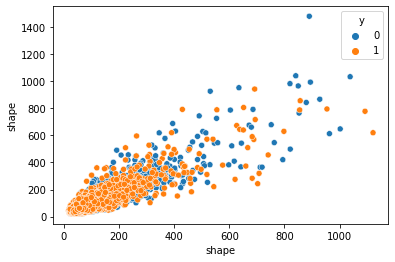

In [8]:
import seaborn as sns
sns.scatterplot(df['shape'].map(lambda x:x[0]),df['shape'].map(lambda x:x[1]),hue='y',data=df)

In [9]:
df.shape

(8338, 3)

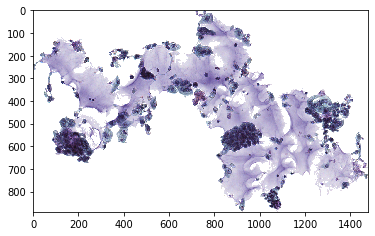

In [33]:
import matplotlib, matplotlib.pyplot as plt

plt.imshow(df.iloc[df['shape'].map(lambda x:x[1]).argsort()[len(df)-1]]['np_image'])

In [90]:
from scipy import ndimage as ndi
import cv2
df['mask']=df['np_image'].map(lambda img: ndi.binary_fill_holes(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)<255))
im2mask=lambda img: ndi.binary_fill_holes(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)<1.)
# img=df.iloc[df['shape'].map(lambda x:x[1]).argsort()[len(df)-1]]['np_image']

# plt.imshow()

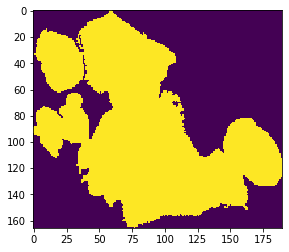

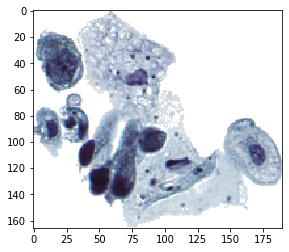

In [68]:
rr=RandRotate(max_angle=30,return_transform=False)
plt.figure()
plt.imshow(df['mask'][0])
plt.figure()
plt.imshow(df['np_image'][0])

In [69]:
rr(torch.tensor(df['np_image'][0]).permute((2,0,1)).float().unsqueeze(0))

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

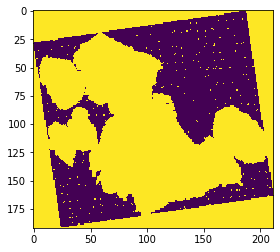

In [88]:
img=rr(torch.tensor(df['np_image'][0]/255.).permute((2,0,1)).float().unsqueeze(0))
plt.imshow(rr.apply_transform(torch.tensor(df['mask'][0]).unsqueeze(0).unsqueeze(0).float(),rr.params).bool()[0][0].numpy())




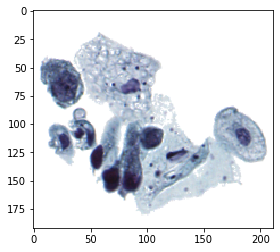

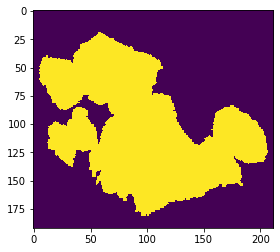

In [92]:
plt.figure()
plt.imshow(img[0].permute((1,2,0)).numpy())

plt.figure()
plt.imshow(im2mask(img[0].permute((1,2,0)).numpy()))


In [56]:
torch.tensor(df['mask'][0]).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 166, 190])

In [93]:
# use mask later